In [1]:
import os

def get_api_key():
    # Hardcoded path to the secrets directory
    secrets_dir = '/Users/chrisjanssen/Insync/cnjanssen@tamu.edu/Google Drive/COM/Research/spaceflightreview-secrets'

    # Construct the full path to the secrets.txt file
    secret_file = os.path.join(secrets_dir, 'Chris_AI_Review_NEW.txt')

    # Read the API key from the file
    try:
        with open(secret_file, 'r') as file:
            api_key = file.read().strip()
        return api_key
    except FileNotFoundError:
        print(f"Error: secrets.txt file not found in the secrets directory: {secrets_dir}")
        return None
    except IOError:
        print(f"Error: Unable to read the secrets.txt file: {secret_file}")
        return None

# Use the function to get the API key
anthropic_api_key = get_api_key()

if anthropic_api_key:
    print("API key successfully loaded.")
    # Use the API key in your code
    # For example: anthropic.api_key = anthropic_api_key
else:
    print("Failed to load API key.")

API key successfully loaded.


In [2]:
import pandas as pd
import anthropic
import os
import pandas as pd
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import lru_cache
import json
import time
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


# Set up the API key for Claude.AI
os.environ['ANTHROPIC_API_KEY'] = anthropic_api_key

# Initialize the Anthropic client
client = anthropic.Anthropic()

# Cache the prompt
@lru_cache(maxsize=1)
def get_cached_prompt():
    return """You are assisting in screening articles for a scoping review on medical screening for Commercial Spaceflight (CSF). Your task is to determine whether to include, exclude, or mark as "maybe" each article based on the provided criteria. 

Here are the key inclusion criteria:
- Timeframe: 2000-2023
- Setting: Spaceflight experience/profile and/or analogues/simulation (e.g., suborbital, orbital, lunar, planetary, trans-atmospheric, parabolic, centrifuge, bed rest, dry immersion, head-down tilt)
- Human medical conditions related to CSF
- Language: English in full text
- Sample: Adult human participants (18 years and older) but who are commercial spaceflight participants or passengers who DO NOT meet career professional astronaut medical standards and training and who DOES NOT HAVE primary duties with operation or safety of flgiht of aircraft
- Peer-reviewed articles relevant to Commercial Spaceflight
- NASA RIDGE hazards of space flight such as 
--Radiation
--Isolation and confinement
--Distance from Earth
--Gravity (differing gravitational fields)
--Environment (hostile/closed)

Key exclusion criteria:
- Animal, in-silico, or in-vitro studies
- Pediatrics or age less than 18 years
- Full text not available in English
- Articles limited to professional astronauts or equivalent
- Gray literature, dissertations, theses, technical reports, proprietary information
- Editorials, magazine articles, or web-based/digital media
- Textbooks

Please review the following article information:

Title: <article_title>{{Title}}</article_title>

Year: <article_year>{{Published_Year}}</article_year>

Abstract: <article_abstract>{{Abstract}}</article_abstract>

Based on this information, determine whether the article should be included, excluded, or marked as "maybe" for the scoping review. Consider the inclusion and exclusion criteria carefully.

First, provide a brief justification for your decision, explaining how the article meets or fails to meet the criteria. Then, state your decision.

Format your response as follows:
<justification>
[Your justification here]
</justification>

<decision>[INCLUDE/EXCLUDE/MAYBE]</decision>"""




In [3]:
#df = pd.read_csv('all_abstracts_screen.csv')
df = pd.read_parquet('claude_3_haiku_v3_pending_abstracts_pt4.parquet')
df = df.reset_index(drop=True)

In [4]:
df.shape

(2024, 16)

In [ ]:
df_1 = df.iloc[3100:10374]

In [ ]:
df_1.shape

In [ ]:
df.columns

In [ ]:
df

In [5]:
import time

# Global variables for token tracking
TOKEN_LIMIT_PER_MINUTE = 40000
token_count = 0
last_reset_time = time.time()

def process_article(title, year, abstract):
    global token_count, last_reset_time

    # Handle potential None values
    title = str(title) if pd.notna(title) else ""
    year = str(year) if pd.notna(year) else ""
    abstract = str(abstract) if pd.notna(abstract) else ""

    prompt = get_cached_prompt().replace("{{Title}}", title).replace("{{Published_Year}}", year).replace("{{Abstract}}", abstract)

    tokens_used = estimate_tokens(prompt)

    # Check if we need to reset the token count
    current_time = time.time()
    if current_time - last_reset_time >= 60:
        token_count = 0
        last_reset_time = current_time

    # Check if adding these tokens would exceed the limit
    while token_count + tokens_used > TOKEN_LIMIT_PER_MINUTE:
        sleep_time = 60 - (current_time - last_reset_time)
        if sleep_time > 0:
            logging.info(f"Approaching token limit. Sleeping for {sleep_time:.2f} seconds.")
            time.sleep(sleep_time)
        token_count = 0
        last_reset_time = time.time()
        current_time = time.time()

    # Update token count
    token_count += tokens_used

    # Call the Claude API
    try:
        logging.debug("Calling Claude API")
        message = client.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=3000,
            temperature=0,
            messages=[
                {"role": "user", "content": prompt}
            ]
        )
        response_content = message.content
        # Estimate tokens in the response and add to the count
        response_tokens = estimate_tokens(response_content)
        token_count += response_tokens
        print(response_content, response_tokens, token_count)
        

        #logging.info(f"API call successful. Total tokens used: {tokens_used + response_tokens}")
        return response_content, tokens_used + response_tokens
    except Exception as e:
        logging.error(f"Error in API call: {e}")
        return f"Error: {str(e)}", tokens_used

In [6]:


# Function to estimate tokens (simplified)
def estimate_tokens(text):
    return len(str(text).split())

def process_article_with_retry(title, year, abstract, max_retries=3):
    for attempt in range(max_retries):
        try:
            logging.debug(f"Attempting to process article (Attempt {attempt + 1})")
            return process_article(title, year, abstract)
        except Exception as e:
            logging.error(f"Attempt {attempt + 1} failed: {e}")
            if attempt == max_retries - 1:
                logging.warning(f"Max retries reached. Skipping article.")
                return "Error", 0
            time.sleep(2 ** attempt)  # Exponential backoff



# Process all articles in the dataframe
def process_all_articles(df):
    results = []
    tokens_used_list = []
    progress_bar = tqdm(total=len(df), desc="Processing Articles")

    for i, row in df.iterrows():
        try:
            logging.info(f"Processing article {i+1}/{len(df)}")
            result, tokens_used = process_article_with_retry(row['Title'], row['Published Year'], row['Abstract'])
            results.append(str(result))
            tokens_used_list.append(tokens_used)
            logging.info(f"Successfully processed article {i+1}")
        except Exception as e:
            logging.error(f"Error processing row {i}: {e}")
            results.append("Error")
            tokens_used_list.append(0)

        progress_bar.update(1)

        if (i + 1) % 50 == 0:
            logging.info(f"Checkpoint: Processed {i+1} articles")
            logging.debug(f"Current results length: {len(results)}")
            logging.debug(f"Current tokens_used_list length: {len(tokens_used_list)}")
            save_intermediate_results(df.iloc[:i+1], results, tokens_used_list, i+1)

        time.sleep(1)

    progress_bar.close()

    # Add results to the DataFrame
    df['AI_Decision'] = results
    df['Tokens_Used'] = tokens_used_list

    return df

def save_intermediate_results(df_slice, results, tokens_used_list, num_processed):
    temp_df = df_slice.copy()
    if len(results) != len(temp_df):
        logging.warning(f"Mismatch in lengths. DataFrame: {len(temp_df)}, Results: {len(results)}")
        # Pad results and tokens_used_list if necessary
        results += ["Error"] * (len(temp_df) - len(results))
        tokens_used_list += [0] * (len(temp_df) - len(tokens_used_list))
    temp_df['AI_Decision'] = results[:len(temp_df)]
    temp_df['Tokens_Used'] = tokens_used_list[:len(temp_df)]
    temp_df.to_parquet(f'claude_3_haiku_v2_pt3{num_processed}.parquet')
    logging.info(f"Saved claude_3_haiku_v2_pt3 intermediate results for {num_processed} articles")



# Function to plot progress
def plot_progress(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['Tokens_Used'].cumsum())
    plt.title('Cumulative Tokens Used')
    plt.xlabel('Article Index')
    plt.ylabel('Total Tokens')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    df['AI_Decision'].value_counts().plot(kind='bar')
    plt.title('Distribution of AI Decisions')
    plt.xlabel('Decision')
    plt.ylabel('Count')
    plt.show()




Processing Articles:   0%|          | 0/2024 [00:00<?, ?it/s]2024-09-15 13:50:33,507 - INFO - Processing article 1/2024
2024-09-15 13:50:35,082 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:50:35,093 - INFO - Successfully processed article 1
Processing Articles:   0%|          | 1/2024 [00:01<53:33,  1.59s/it]

[TextBlock(text="<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of high-LET radiation exposure on astronauts' lymphocytes), and it is a peer-reviewed article. However, the article does not explicitly mention commercial spaceflight participants or passengers who do not meet professional astronaut standards, which is a key inclusion criterion. Additionally, the article does not discuss the specific NASA RIDGE hazards of spaceflight, such as isolation, confinement, distance from Earth, or varying gravitational fields.\n</justification>\n\n<decision>MAYBE</decision>", type='text')] 97 563


2024-09-15 13:50:36,099 - INFO - Processing article 2/2024
2024-09-15 13:50:37,334 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:50:37,335 - INFO - Successfully processed article 2
Processing Articles:   0%|          | 2/2024 [00:03<1:06:29,  1.97s/it]

[TextBlock(text='<justification>\nThe article does not appear to be relevant to the scoping review on medical screening for commercial spaceflight. The article focuses on the dynamics and modeling of human jumping, which is not directly related to the medical conditions or screening procedures for commercial spaceflight participants. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the study was conducted in 2003, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 1150


2024-09-15 13:50:38,342 - INFO - Processing article 3/2024
2024-09-15 13:50:39,428 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:50:39,432 - INFO - Successfully processed article 3
Processing Articles:   0%|          | 3/2024 [00:05<1:08:21,  2.03s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on runtime power management and energy-aware velocity planning for battery electric vehicles, which is not relevant to the medical aspects of CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article does not involve any human participants related to commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 1763


2024-09-15 13:50:40,439 - INFO - Processing article 4/2024
2024-09-15 13:50:41,546 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:50:41,550 - INFO - Successfully processed article 4
Processing Articles:   0%|          | 4/2024 [00:08<1:09:30,  2.06s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about spatial-temporal flows and adaptive street layout control using reinforcement learning, which is not related to human medical conditions or screening for commercial spaceflight. The article also does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 2430


2024-09-15 13:50:42,556 - INFO - Processing article 5/2024
2024-09-15 13:50:43,837 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:50:43,838 - INFO - Successfully processed article 5
Processing Articles:   0%|          | 5/2024 [00:10<1:12:10,  2.14s/it]

[TextBlock(text='<justification>\nThe article discusses the production of pyomelanin, a molecule with UV-C radiation shielding activity, using the fungus Aspergillus niger. While this is relevant to the topic of medical screening for commercial spaceflight, the article does not directly address human medical conditions related to commercial spaceflight. Additionally, the study was conducted in a laboratory setting and did not involve human participants. Therefore, the article may be considered for inclusion, but additional information is needed to determine its relevance to the scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 82 3035


2024-09-15 13:50:44,845 - INFO - Processing article 6/2024
2024-09-15 13:50:46,167 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:50:46,168 - INFO - Successfully processed article 6
Processing Articles:   0%|          | 6/2024 [00:12<1:14:15,  2.21s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a multi-agent-based human-computer interaction model for an e-health care system for people with movement disabilities, which is not directly relevant to the medical screening for CSF. Additionally, the article is published in 2010, which is outside the specified timeframe of 2000-2023. The article also does not mention anything related to spaceflight experience/profile, analogues/simulation, or the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 3600


2024-09-15 13:50:47,175 - INFO - Processing article 7/2024
2024-09-15 13:50:48,804 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:50:48,809 - INFO - Successfully processed article 7
Processing Articles:   0%|          | 7/2024 [00:15<1:18:59,  2.35s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), and it is a peer-reviewed article that is relevant to the health effects of space radiation, which is one of the key NASA RIDGE hazards of spaceflight. The study was conducted using adult mice, which can be considered an analogue for human spaceflight participants. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants, and the study was conducted in mice rather than human participants. Additionally, the article is focused on the persistence of chromosome aberrations, which may not be directly relevant to the medical screening of commercial spaceflight participants.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 114 4226


2024-09-15 13:50:49,816 - INFO - Processing article 8/2024
2024-09-15 13:50:51,239 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:50:51,243 - INFO - Successfully processed article 8
Processing Articles:   0%|          | 8/2024 [00:17<1:19:51,  2.38s/it]

[TextBlock(text='<justification>\nThe article meets some of the inclusion criteria, as it is published within the specified timeframe (2000-2023) and examines the effects of simulated microgravity on the metabolism of a compound (Loureirin B) in rats, which is relevant to human medical conditions related to commercial spaceflight. However, the article uses an animal model (rats) and does not involve human participants, which is one of the key inclusion criteria. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on professional astronauts or equivalent. Therefore, the article does not fully meet the inclusion criteria for this scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 101 4823


2024-09-15 13:50:52,251 - INFO - Processing article 9/2024
2024-09-15 13:50:53,529 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:50:53,530 - INFO - Successfully processed article 9
Processing Articles:   0%|          | 9/2024 [00:20<1:18:52,  2.35s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses human navigation in curved spaces, it does not specifically address human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight. Additionally, the article does not mention commercial spaceflight participants or passengers who do not meet professional astronaut standards. The study was also conducted in a virtual environment rather than in a spaceflight or analog setting.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 5361


2024-09-15 13:50:54,537 - INFO - Processing article 10/2024
2024-09-15 13:50:55,714 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:50:55,727 - INFO - Successfully processed article 10
Processing Articles:   0%|          | 10/2024 [00:22<1:17:15,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a pipeline inspection robot and does not discuss any human medical conditions related to CSF. Additionally, the article is not focused on spaceflight experience/profile or analogues/simulation, which is a key inclusion criterion. The article also does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 5946


2024-09-15 13:50:56,733 - INFO - Processing article 11/2024
2024-09-15 13:50:57,892 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:50:57,897 - INFO - Successfully processed article 11
Processing Articles:   1%|          | 11/2024 [00:24<1:15:52,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the 3D reconstruction of bridge structures using UAV-based photogrammetric point cloud, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, space environment, or commercial spaceflight participants. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 6567


2024-09-15 13:50:58,910 - INFO - Processing article 12/2024
2024-09-15 13:51:00,124 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:00,127 - INFO - Successfully processed article 12
Processing Articles:   1%|          | 12/2024 [00:26<1:15:30,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on driver distraction and road safety, which is not relevant to the topic of medical screening for CSF. Additionally, the article does not mention anything related to spaceflight, either commercial or professional, or any of the NASA RIDGE hazards of spaceflight. The study population is also not relevant, as it focuses on regular drivers rather than commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 7177


2024-09-15 13:51:01,136 - INFO - Processing article 13/2024
2024-09-15 13:51:02,363 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:02,369 - INFO - Successfully processed article 13
Processing Articles:   1%|          | 13/2024 [00:28<1:15:22,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on a study using rats exposed to simulated long-term spaceflight composite stress, which is not directly relevant to the human medical conditions related to CSF. Additionally, the study population is not commercial spaceflight participants or passengers, but rather adult rats. The article also does not discuss any medical screening procedures or assessments for CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 7746


2024-09-15 13:51:03,378 - INFO - Processing article 14/2024
2024-09-15 13:51:04,707 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:04,711 - INFO - Successfully processed article 14
Processing Articles:   1%|          | 14/2024 [00:31<1:16:16,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the control of a soft robot inspired by bacterial flagella, which is not directly relevant to human medical conditions related to CSF. Additionally, the article does not mention any spaceflight experience, analogues, or simulations, nor does it involve human participants. The study is also not peer-reviewed and is more focused on engineering and robotics rather than medical aspects.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 8347


2024-09-15 13:51:05,717 - INFO - Processing article 15/2024
2024-09-15 13:51:07,096 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:07,100 - INFO - Successfully processed article 15
Processing Articles:   1%|          | 15/2024 [00:33<1:17:22,  2.31s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on the human medical condition of cognitive dysfunction related to cosmic radiation exposure, which is relevant to commercial spaceflight. The study was conducted in 2016, which falls within the specified timeframe of 2000-2023. The article also discusses the NASA RIDGE hazard of radiation, which is one of the key criteria for inclusion. However, the article does not specifically mention commercial spaceflight participants or passengers who do not meet professional astronaut standards, as the sample is not clearly defined in the abstract.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 97 8925


2024-09-15 13:51:08,107 - INFO - Processing article 16/2024
2024-09-15 13:51:09,202 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:09,207 - INFO - Successfully processed article 16
Processing Articles:   1%|          | 16/2024 [00:35<1:15:18,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of remote sensing and machine learning techniques to assess late blight resistance in tomato plants, which is not related to human medical conditions or spaceflight. Additionally, the study was conducted in an open field setting, which does not align with the specified setting criteria of spaceflight experience/profile and/or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 9542


2024-09-15 13:51:10,220 - INFO - Processing article 17/2024
2024-09-15 13:51:11,579 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:11,594 - INFO - Successfully processed article 17
Processing Articles:   1%|          | 17/2024 [00:38<1:16:41,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of microgravity on bacterial growth, specifically Escherichia coli, and does not address any human medical conditions related to CSF. Additionally, the study was conducted in 2005, which is outside the specified timeframe of 2000-2023. The article also does not involve human participants, as it is an in-vitro study using genetically modified bacteria. Therefore, this article does not fit the scope of the review and should be excluded.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 10179


2024-09-15 13:51:12,607 - INFO - Processing article 18/2024
2024-09-15 13:51:13,812 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:13,839 - INFO - Successfully processed article 18
Processing Articles:   1%|          | 18/2024 [00:40<1:16:06,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of laser ablation for the removal of space debris, which is not directly related to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it involve any human participants. Additionally, the article is not peer-reviewed and is not focused on the setting of spaceflight experience or analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 10810


2024-09-15 13:51:14,852 - INFO - Processing article 19/2024
2024-09-15 13:51:16,110 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:16,123 - INFO - Successfully processed article 19
Processing Articles:   1%|          | 19/2024 [00:42<1:16:08,  2.28s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on virtual point control for bipedal running on uneven terrain, which is not directly related to the medical conditions or screening of commercial spaceflight participants. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not about human participants, but rather about bipedal robots.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 11345


2024-09-15 13:51:17,132 - INFO - Processing article 20/2024
2024-09-15 13:51:18,378 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:18,383 - INFO - Successfully processed article 20
Processing Articles:   1%|          | 20/2024 [00:44<1:15:54,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the elongation of the spine during lifting and lowering tasks, which is not directly relevant to the medical conditions related to CSF. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather healthy adult males performing industrial tasks. The article also does not discuss any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 11918


2024-09-15 13:51:19,393 - INFO - Processing article 21/2024
2024-09-15 13:51:20,836 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:20,840 - INFO - Successfully processed article 21
Processing Articles:   1%|          | 21/2024 [00:47<1:17:46,  2.33s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a human medical condition (hypoxemia) related to spaceflight, and it is a peer-reviewed article. Additionally, the study examines the physiological effects of weightlessness, which is relevant to the setting of spaceflight experience and analogues. However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants, which are key criteria for inclusion. Additionally, the sample appears to be limited to professional astronauts, which is an exclusion criterion.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 93 12387


2024-09-15 13:51:21,863 - INFO - Processing article 22/2024
2024-09-15 13:51:23,009 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:23,018 - INFO - Successfully processed article 22
Processing Articles:   1%|          | 22/2024 [00:49<1:16:09,  2.28s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on over-expansion cycle engines, which are used in hybrid vehicles, and does not discuss any medical conditions or screening related to commercial spaceflight. The article also does not mention any of the key inclusion criteria such as spaceflight experience/profile, NASA RIDGE hazards, or commercial spaceflight participants. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 13025


2024-09-15 13:51:24,027 - INFO - Processing article 23/2024
2024-09-15 13:51:25,328 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:25,332 - INFO - Successfully processed article 23
Processing Articles:   1%|          | 23/2024 [00:51<1:16:27,  2.29s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a technical measurement method for cislunar spacecraft using connected element interferometry and BeiDou-3 interplanetary link, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not mention any human participants or medical conditions, and it is not focused on commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 13717


2024-09-15 13:51:26,345 - INFO - Processing article 24/2024
2024-09-15 13:51:27,540 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:27,543 - INFO - Successfully processed article 24
Processing Articles:   1%|          | 24/2024 [00:54<1:15:34,  2.27s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the use of UAVs and IoT for disaster management, it does not focus on human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. The article also does not mention commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the study setting is not related to spaceflight experience, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 14301


2024-09-15 13:51:28,551 - INFO - Processing article 25/2024
2024-09-15 13:51:29,766 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:29,771 - INFO - Successfully processed article 25
Processing Articles:   1%|          | 25/2024 [00:56<1:15:09,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of an ankle exoskeleton to improve energy cost and muscular demand during incline walking and stair ascent in individuals with cerebral palsy. It does not address any medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the study population is individuals with cerebral palsy, which does not align with the inclusion criteria of adult human participants who are commercial spaceflight participants or passengers and do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 99 14937


2024-09-15 13:51:30,783 - INFO - Processing article 26/2024
2024-09-15 13:51:32,128 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:32,134 - INFO - Successfully processed article 26
Processing Articles:   1%|▏         | 26/2024 [00:58<1:16:11,  2.29s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of radiation exposure on the liver), and it is a peer-reviewed article. However, the study was conducted on mice, not adult human participants, which is an exclusion criterion. Additionally, the study does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut standards, but rather on the general effects of radiation exposure on the liver.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 94 654


2024-09-15 13:51:33,146 - INFO - Processing article 27/2024
2024-09-15 13:51:34,310 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:34,313 - INFO - Successfully processed article 27
Processing Articles:   1%|▏         | 27/2024 [01:00<1:15:03,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the compliance of Italian satellites in low Earth orbit with end-of-life disposal guidelines for space debris mitigation, and it does not discuss any human medical conditions related to CSF. Additionally, the article is not peer-reviewed and does not mention any of the NASA RIDGE hazards of spaceflight. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 1350


2024-09-15 13:51:35,324 - INFO - Processing article 28/2024
2024-09-15 13:51:36,586 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:36,592 - INFO - Successfully processed article 28
Processing Articles:   1%|▏         | 28/2024 [01:03<1:15:15,  2.26s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses situation awareness in a flight simulator, it does not focus on human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather a general population sample. The article also does not mention any medical screening or assessment procedures.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 1881


2024-09-15 13:51:37,600 - INFO - Processing article 29/2024
2024-09-15 13:51:38,758 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:38,764 - INFO - Successfully processed article 29
Processing Articles:   1%|▏         | 29/2024 [01:05<1:14:19,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the motility enhancement of bacteria-actuated microstructures, which is not related to human medical conditions or screening for CSF. Additionally, the study does not involve human participants or any spaceflight-related settings or analogues. The article is also outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 67 2389


2024-09-15 13:51:39,772 - INFO - Processing article 30/2024
2024-09-15 13:51:41,173 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:41,185 - INFO - Successfully processed article 30
Processing Articles:   1%|▏         | 30/2024 [01:07<1:16:08,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on an intelligent e-health care system for people with movement disabilities, which is not directly related to the medical conditions or screening for commercial spaceflight participants. Additionally, the article is published in 2008, which is outside the specified timeframe of 2000-2023. The article also does not mention anything about spaceflight experience, analogues, or the specific NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 2921


2024-09-15 13:51:42,193 - INFO - Processing article 31/2024
2024-09-15 13:51:43,286 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:43,290 - INFO - Successfully processed article 31
Processing Articles:   2%|▏         | 31/2024 [01:09<1:14:13,  2.23s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on autonomous collision avoidance for multiple unmanned aerial vehicles (UAVs) and does not discuss any human medical conditions related to CSF or the specific settings and hazards mentioned in the inclusion criteria. Additionally, the article is not peer-reviewed and is not related to commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 3430


2024-09-15 13:51:44,296 - INFO - Processing article 32/2024
2024-09-15 13:51:45,570 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:45,576 - INFO - Successfully processed article 32
Processing Articles:   2%|▏         | 32/2024 [01:12<1:14:43,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the generation of aerial images of high-voltage transmission lines using unmanned aerial vehicles (UAVs) and generative adversarial networks (GANs), which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions, nor does it involve spaceflight experience or analogues. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 4133


2024-09-15 13:51:46,588 - INFO - Processing article 33/2024
2024-09-15 13:51:50,841 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:50,847 - INFO - Successfully processed article 33
Processing Articles:   2%|▏         | 33/2024 [01:17<1:44:44,  3.16s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the development of a mechanical phantom for testing knee exoskeletons, it does not focus on human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. Additionally, the article is not directly related to commercial spaceflight participants or passengers, as it focuses on the testing of exoskeletons in general. The article also does not mention any spaceflight experience or analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 4754


2024-09-15 13:51:51,856 - INFO - Processing article 34/2024
2024-09-15 13:51:53,192 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:53,201 - INFO - Successfully processed article 34
Processing Articles:   2%|▏         | 34/2024 [01:19<1:36:42,  2.92s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article describes the development of a teleoperation system for agricultural vehicles, which is not related to the medical conditions or screening of commercial spaceflight participants. The article also does not mention anything about spaceflight, radiation, isolation, or other factors related to the NASA RIDGE hazards of spaceflight. Additionally, the article is from 2008, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 5278


2024-09-15 13:51:54,208 - INFO - Processing article 35/2024
2024-09-15 13:51:55,412 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:55,417 - INFO - Successfully processed article 35
Processing Articles:   2%|▏         | 35/2024 [01:21<1:29:41,  2.71s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the numerical predictions and experiments for optimizing hidden corrosion detection in aircraft structures, which is not related to human medical conditions or screening for commercial spaceflight participants. The article also does not mention anything about spaceflight experience, analogues, or simulations, which are key criteria for inclusion. Additionally, the article is published in 2007, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 5836


2024-09-15 13:51:56,423 - INFO - Processing article 36/2024
2024-09-15 13:51:57,569 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:57,573 - INFO - Successfully processed article 36
Processing Articles:   2%|▏         | 36/2024 [01:24<1:24:10,  2.54s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a brain-controlled wheelchair system using motor imagery and shared control, which is not directly relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF or the NASA RIDGE hazards of spaceflight, which are the key focus of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 6442


2024-09-15 13:51:58,579 - INFO - Processing article 37/2024
2024-09-15 13:51:59,740 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:51:59,743 - INFO - Successfully processed article 37
Processing Articles:   2%|▏         | 37/2024 [01:26<1:20:27,  2.43s/it]

[TextBlock(text='<justification>\nThe article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a robotic cleaner and its application in cleaning hospitals, which does not align with the inclusion criteria of the review. The article does not mention anything related to spaceflight, medical conditions, or the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and is not focused on adult human participants who are commercial spaceflight passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 7005


2024-09-15 13:52:00,748 - INFO - Processing article 38/2024
2024-09-15 13:52:01,842 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:01,846 - INFO - Successfully processed article 38
Processing Articles:   2%|▏         | 38/2024 [01:28<1:17:10,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the attitude stabilization control of autonomous underwater vehicles, which is not related to human medical conditions or spaceflight. Additionally, the article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 7490


2024-09-15 13:52:02,853 - INFO - Processing article 39/2024
2024-09-15 13:52:04,030 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:04,034 - INFO - Successfully processed article 39
Processing Articles:   2%|▏         | 39/2024 [01:30<1:15:43,  2.29s/it]

[TextBlock(text='<justification>\nThe article does not provide enough information to determine if it meets the inclusion criteria. The title and abstract do not indicate whether the study is related to commercial spaceflight, the participants, or the specific medical conditions of interest. Additionally, the abstract is missing, so it is difficult to assess the relevance of the content. Without more details about the study, it is not possible to make a definitive decision.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 71 7840


2024-09-15 13:52:05,044 - INFO - Processing article 40/2024
2024-09-15 13:52:06,469 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:06,483 - INFO - Successfully processed article 40
Processing Articles:   2%|▏         | 40/2024 [01:32<1:17:15,  2.34s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of geomatics techniques, such as laser scanning and photogrammetry, for the reconstruction and representation of different morpho-typological phases of a cultural heritage site. It does not discuss any medical conditions related to spaceflight or the screening of commercial spaceflight participants. Additionally, the article is not set in the context of spaceflight or any spaceflight analogues, and the sample does not include adult human participants who are commercial spaceflight passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 8470


2024-09-15 13:52:07,489 - INFO - Processing article 41/2024
2024-09-15 13:52:08,792 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:08,799 - INFO - Successfully processed article 41
Processing Articles:   2%|▏         | 41/2024 [01:35<1:17:06,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the lateral bending and buckling dynamics of earthworms and their application in soft robotic devices, which is not relevant to the medical conditions related to CSF. Additionally, the article does not discuss any human participants or medical conditions, and it is not set in the context of spaceflight or spaceflight analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 9074


2024-09-15 13:52:09,817 - INFO - Processing article 42/2024
2024-09-15 13:52:10,906 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:10,910 - INFO - Successfully processed article 42
Processing Articles:   2%|▏         | 42/2024 [01:37<1:14:46,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of particle swarm optimization and least-squares support vector machine for estimating suspended solids concentration in inland waters using UAV-borne hyperspectral remote sensing imagery. It does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. The setting and sample of the study are also not relevant to the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 9676


2024-09-15 13:52:11,917 - INFO - Processing article 43/2024
2024-09-15 13:52:13,006 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:13,008 - INFO - Successfully processed article 43
Processing Articles:   2%|▏         | 43/2024 [01:39<1:13:05,  2.21s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on pedestrian navigation methods using machine learning and gait features, which is not relevant to the medical conditions related to CSF. Additionally, the article does not involve human participants or any spaceflight experience/profile or analogues. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 10246


2024-09-15 13:52:14,015 - INFO - Processing article 44/2024
2024-09-15 13:52:15,245 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:15,252 - INFO - Successfully processed article 44
Processing Articles:   2%|▏         | 44/2024 [01:41<1:13:21,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of UAVs and data processing for generating 3D models for solar potential analysis, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions or screening procedures related to CSF. Additionally, the article is not peer-reviewed and does not fall within the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 10908


2024-09-15 13:52:16,261 - INFO - Processing article 45/2024
2024-09-15 13:52:17,510 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:17,519 - INFO - Successfully processed article 45
Processing Articles:   2%|▏         | 45/2024 [01:44<1:13:45,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the functional consequences of microscopic skin features on snake locomotion, which is not related to human medical conditions or screening for CSF. Additionally, the article is not set in the context of spaceflight experience or analogues, nor does it involve adult human participants who are commercial spaceflight passengers. The article is also not peer-reviewed and is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 11474


2024-09-15 13:52:18,532 - INFO - Processing article 46/2024
2024-09-15 13:52:19,812 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:19,824 - INFO - Successfully processed article 46
Processing Articles:   2%|▏         | 46/2024 [01:46<1:14:24,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development and deployment of a precision underwater positioning system for in situ laser Raman spectroscopy in the deep ocean, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, either commercial or professional, or any analogues or simulations related to spaceflight. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather focus on the development of a technical instrument for deep ocean research.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 103 12145


2024-09-15 13:52:20,840 - INFO - Processing article 47/2024
2024-09-15 13:52:22,037 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:22,045 - INFO - Successfully processed article 47
Processing Articles:   2%|▏         | 47/2024 [01:48<1:14:01,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a multi-layered multi-pattern central pattern generator (CPG) for adaptive locomotion of humanoid robots, which is not relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it involve any spaceflight experience, analogues, or simulations. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 12702


2024-09-15 13:52:23,054 - INFO - Processing article 48/2024
2024-09-15 13:52:24,196 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:24,209 - INFO - Successfully processed article 48
Processing Articles:   2%|▏         | 48/2024 [01:50<1:13:09,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The study was conducted in rats and did not involve human participants, which is one of the key exclusion criteria. Additionally, the study setting was focused on hindlimb unloading and simulated resistance training, which are not directly relevant to the CSF context specified in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 67 13369


2024-09-15 13:52:25,218 - INFO - Processing article 49/2024
2024-09-15 13:52:26,780 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:26,785 - INFO - Successfully processed article 49
Processing Articles:   2%|▏         | 49/2024 [01:53<1:16:37,  2.33s/it]

[TextBlock(text='<justification>\nThe article meets some of the inclusion criteria, as it examines the effects of spaceflight on the transversal stiffness and desmin content of mouse cardiomyocytes and skeletal muscle fibers, which are relevant to human medical conditions related to commercial spaceflight. The study was conducted in 2013, which falls within the specified timeframe of 2000-2023. However, the article uses an animal model (mice) and does not involve human participants, which is one of the key exclusion criteria. Additionally, the study was conducted on a biosatellite, which may not be considered a direct analogue to commercial spaceflight experiences.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 97 13931


2024-09-15 13:52:27,795 - INFO - Processing article 50/2024
2024-09-15 13:52:29,693 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:29,698 - INFO - Successfully processed article 50
Processing Articles:   2%|▏         | 50/2024 [01:56<1:22:21,  2.50s/it]2024-09-15 13:52:29,700 - INFO - Checkpoint: Processed 50 articles
2024-09-15 13:52:29,751 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 50 articles


[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The title and abstract indicate that the article is focused on advances in biological treatment, which is not related to the key inclusion criteria of human medical conditions related to CSF, NASA RIDGE hazards, or the spaceflight experience/profile and/or analogues/simulation. Additionally, the article is from 2008, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 14288


2024-09-15 13:52:30,757 - INFO - Processing article 51/2024
2024-09-15 13:52:32,200 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:32,212 - INFO - Successfully processed article 51
Processing Articles:   3%|▎         | 51/2024 [01:58<1:22:27,  2.51s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a brain-computer interface (BCI)-controlled robotic manipulator for assisting people with severe motion disabilities, which is not directly relevant to the medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather people with severe motion disabilities.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 105 14880


2024-09-15 13:52:33,233 - INFO - Processing article 52/2024
2024-09-15 13:52:34,318 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:34,320 - INFO - Successfully processed article 52
Processing Articles:   3%|▎         | 52/2024 [02:00<1:18:31,  2.39s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about an energy management controller for hybrid vehicles, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight, but rather on hybrid vehicle technology.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 550


2024-09-15 13:52:35,338 - INFO - Processing article 53/2024
2024-09-15 13:52:36,701 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:36,708 - INFO - Successfully processed article 53
Processing Articles:   3%|▎         | 53/2024 [02:03<1:18:25,  2.39s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development and control of an active flexible needle for percutaneous procedures, which is not directly related to the medical conditions or screening for commercial spaceflight participants. The article does not mention anything about spaceflight, spaceflight analogues, or the specific NASA RIDGE hazards of spaceflight. Additionally, the study was conducted in a phantom environment, which does not align with the setting criteria of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 1111


2024-09-15 13:52:37,718 - INFO - Processing article 54/2024
2024-09-15 13:52:38,909 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:38,949 - INFO - Successfully processed article 54
Processing Articles:   3%|▎         | 54/2024 [02:05<1:16:54,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the passive morphing of flapping wings in robotic models, which is not relevant to the medical conditions related to CSF. Additionally, the article does not discuss any human participants or medical conditions, and the setting is not related to spaceflight or analogues. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 1767


2024-09-15 13:52:39,957 - INFO - Processing article 55/2024
2024-09-15 13:52:41,366 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:41,369 - INFO - Successfully processed article 55
Processing Articles:   3%|▎         | 55/2024 [02:07<1:17:37,  2.37s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), and it is relevant to the topic of human medical conditions related to commercial spaceflight, specifically focusing on the effects of radiation exposure. The study uses human participants, which aligns with the inclusion criteria. However, the article does not explicitly mention commercial spaceflight participants or passengers who do not meet professional astronaut standards, and it is not clear if the study was conducted in a spaceflight experience/profile or analogue setting. Additionally, the article is a peer-reviewed journal article, which meets the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 104 2305


2024-09-15 13:52:42,379 - INFO - Processing article 56/2024
2024-09-15 13:52:46,415 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:46,422 - INFO - Successfully processed article 56
Processing Articles:   3%|▎         | 56/2024 [02:12<1:44:06,  3.17s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the measurement of phase difference for micromachined gyros driven by rotating aircraft, which is not directly related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight experience/profile, analogues/simulation, or the NASA RIDGE hazards of spaceflight. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 2880


2024-09-15 13:52:47,439 - INFO - Processing article 57/2024
2024-09-15 13:52:48,569 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:48,574 - INFO - Successfully processed article 57
Processing Articles:   3%|▎         | 57/2024 [02:15<1:33:55,  2.87s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the design and fabrication of a starfish robot, which is not related to human medical conditions or screening for commercial spaceflight. The article also does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not peer-reviewed and is not focused on human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 3489


2024-09-15 13:52:49,581 - INFO - Processing article 58/2024
2024-09-15 13:52:50,722 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:50,731 - INFO - Successfully processed article 58
Processing Articles:   3%|▎         | 58/2024 [02:17<1:26:56,  2.65s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the detection of wheat Fusarium head blight using UAV-based spectral and texture features, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, analogues, or simulations, which are key criteria for inclusion. Additionally, the study does not involve human participants, which is another exclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 4074


2024-09-15 13:52:51,739 - INFO - Processing article 59/2024
2024-09-15 13:52:52,861 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:52,867 - INFO - Successfully processed article 59
Processing Articles:   3%|▎         | 59/2024 [02:19<1:21:47,  2.50s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on an adaptive real-time clustering method for dynamic visual tracking of flexible wings, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, either commercial or professional, or any spaceflight analogues or simulations. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 4637


2024-09-15 13:52:53,871 - INFO - Processing article 60/2024
2024-09-15 13:52:55,087 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:55,091 - INFO - Successfully processed article 60
Processing Articles:   3%|▎         | 60/2024 [02:21<1:19:05,  2.42s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the characterization, control, and testing of an electrical turbocharger assist for conventional powertrain vehicles, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not mention anything about spaceflight, space environment, or medical conditions related to CSF. Additionally, the article is not peer-reviewed and is not focused on human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 5178


2024-09-15 13:52:56,109 - INFO - Processing article 61/2024
2024-09-15 13:52:59,412 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:52:59,417 - INFO - Successfully processed article 61
Processing Articles:   3%|▎         | 61/2024 [02:25<1:37:46,  2.99s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on weed detection in UAV images for agricultural applications, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, space environments, or medical conditions related to CSF. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 5828


2024-09-15 13:53:00,424 - INFO - Processing article 62/2024
2024-09-15 13:53:01,582 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:01,586 - INFO - Successfully processed article 62
Processing Articles:   3%|▎         | 62/2024 [02:28<1:29:41,  2.74s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design optimization of superelastic Nitinol legs for an endoscopic capsule, which is not related to human medical conditions or screening for CSF. Additionally, the article is published in 2009, which is outside the specified timeframe of 2000-2023. The article also does not involve human participants or any spaceflight experience/profile or analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 6386


2024-09-15 13:53:02,594 - INFO - Processing article 63/2024
2024-09-15 13:53:04,034 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:04,040 - INFO - Successfully processed article 63
Processing Articles:   3%|▎         | 63/2024 [02:30<1:26:49,  2.66s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the growth of a fungus in hydrocarbon-rich environments, it does not focus on human medical conditions related to CSF. The study is also not directly relevant to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment. Additionally, the article is not focused on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 7137


2024-09-15 13:53:05,047 - INFO - Processing article 64/2024
2024-09-15 13:53:06,236 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:06,244 - INFO - Successfully processed article 64
Processing Articles:   3%|▎         | 64/2024 [02:32<1:22:20,  2.52s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the use of unmanned aerial vehicles and wireless sensor networks for spraying pesticides, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article was published in 2014, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 7722


2024-09-15 13:53:07,248 - INFO - Processing article 65/2024
2024-09-15 13:53:08,433 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:08,437 - INFO - Successfully processed article 65
Processing Articles:   3%|▎         | 65/2024 [02:34<1:19:05,  2.42s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a soft wearable robot for assisting the shoulder of industrial workers, which is not related to the medical screening of commercial spaceflight participants or passengers. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the study participants are industrial workers, not commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 8371


2024-09-15 13:53:09,444 - INFO - Processing article 66/2024
2024-09-15 13:53:10,671 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:10,677 - INFO - Successfully processed article 66
Processing Articles:   3%|▎         | 66/2024 [02:37<1:17:15,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of a robot-based training device for people with mild cognitive impairment, which is not directly related to the medical conditions or screening relevant to CSF. Additionally, the study population is not commercial spaceflight participants or passengers, but rather older adults with mild cognitive impairment. Therefore, this article does not fit the target population or the specific focus on CSF-related medical conditions.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 8994


2024-09-15 13:53:11,685 - INFO - Processing article 67/2024
2024-09-15 13:53:12,896 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:12,902 - INFO - Successfully processed article 67
Processing Articles:   3%|▎         | 67/2024 [02:39<1:15:52,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on robot-assisted navigation and reinforcement learning, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight, either commercial or professional, or any of the NASA RIDGE hazards of spaceflight. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 9581


2024-09-15 13:53:13,917 - INFO - Processing article 68/2024
2024-09-15 13:53:15,127 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:15,132 - INFO - Successfully processed article 68
Processing Articles:   3%|▎         | 68/2024 [02:41<1:14:51,  2.30s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the design and implementation of a clamper-based and motor-driven capsule robot for exploring the intestinal tract, which is not related to medical screening for CSF. The article does not discuss any human medical conditions related to CSF, nor does it mention anything about spaceflight experience, analogues, or simulations. Additionally, the article is not focused on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 10188


2024-09-15 13:53:16,141 - INFO - Processing article 69/2024
2024-09-15 13:53:17,349 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:17,359 - INFO - Successfully processed article 69
Processing Articles:   3%|▎         | 69/2024 [02:43<1:14:08,  2.28s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a distributed affine formation maneuver control algorithm for networked marine surface vehicles, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not peer-reviewed and does not involve human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 10706


2024-09-15 13:53:18,364 - INFO - Processing article 70/2024
2024-09-15 13:53:19,716 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:19,725 - INFO - Successfully processed article 70
Processing Articles:   3%|▎         | 70/2024 [02:46<1:14:58,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a voice recognition system for controlling a robotic wheelchair, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather individuals with disabilities who use wheelchairs. Therefore, this article should be excluded from the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 99 11319


2024-09-15 13:53:20,733 - INFO - Processing article 71/2024
2024-09-15 13:53:21,934 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:21,941 - INFO - Successfully processed article 71
Processing Articles:   4%|▎         | 71/2024 [02:48<1:14:08,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design and implementation of a step-climbing maneuver in a hexapod robot, which is not related to human medical conditions or screening for CSF. The article does not discuss any human participants, nor does it mention anything related to spaceflight, radiation, isolation, or other factors relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 11929


2024-09-15 13:53:22,952 - INFO - Processing article 72/2024
2024-09-15 13:53:26,777 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:26,779 - INFO - Successfully processed article 72
Processing Articles:   4%|▎         | 72/2024 [02:53<1:39:02,  3.04s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the diversification and climate space exploration of the Acacia plant genus in Australia, which is not relevant to the topic of medical screening for commercial spaceflight. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 12506


2024-09-15 13:53:27,786 - INFO - Processing article 73/2024
2024-09-15 13:53:29,000 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:29,005 - INFO - Successfully processed article 73
Processing Articles:   4%|▎         | 73/2024 [02:55<1:31:01,  2.80s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of simulated microgravity on the virulence of Yersinia pestis, it does not focus on human medical conditions related to CSF. The study is also limited to in-vitro experiments and does not involve adult human participants who are commercial spaceflight passengers. Additionally, the article is published in 2012, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 13074


2024-09-15 13:53:30,019 - INFO - Processing article 74/2024
2024-09-15 13:53:31,256 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:31,264 - INFO - Successfully processed article 74
Processing Articles:   4%|▎         | 74/2024 [02:57<1:25:42,  2.64s/it]

[TextBlock(text='<justification>\nThe article discusses the atmospheric pollution from rocket exhaust, which is relevant to the scoping review on medical screening for commercial spaceflight. However, the article does not specifically address human medical conditions related to commercial spaceflight. Additionally, the article does not mention commercial spaceflight participants or passengers who do not meet professional astronaut standards. The article also does not discuss the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 79 13658


2024-09-15 13:53:32,273 - INFO - Processing article 75/2024
2024-09-15 13:53:33,497 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:33,499 - INFO - Successfully processed article 75
Processing Articles:   4%|▎         | 75/2024 [02:59<1:21:44,  2.52s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on weed identification in pineapple fields using Unmanned Aerial Vehicles (UAVs), which is unrelated to the medical conditions and screening procedures for commercial spaceflight participants. The article does not mention anything related to spaceflight, radiation, isolation, or other factors relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 68 14227


2024-09-15 13:53:34,511 - INFO - Processing article 76/2024
2024-09-15 13:53:35,736 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:35,739 - INFO - Successfully processed article 76
Processing Articles:   4%|▍         | 76/2024 [03:02<1:19:01,  2.43s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design and evaluation of in-car displays for Stop & Go Adaptive Cruise Control, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight, but rather on automotive technology.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 522


2024-09-15 13:53:36,753 - INFO - Processing article 77/2024
2024-09-15 13:53:38,055 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:38,063 - INFO - Successfully processed article 77
Processing Articles:   4%|▍         | 77/2024 [03:04<1:18:00,  2.40s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2023), it focuses on a human medical condition (changes in the SNARE complex in the hippocampus) related to spaceflight, and it uses a relevant animal model (rats) to study the effects of simulated spaceflight conditions (space radiation). However, the article does not involve human participants, which is a key inclusion criterion. Additionally, the article is not a peer-reviewed journal article, but rather a research study.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 85 1113


2024-09-15 13:53:39,082 - INFO - Processing article 78/2024
2024-09-15 13:53:40,529 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:40,532 - INFO - Successfully processed article 78
Processing Articles:   4%|▍         | 78/2024 [03:07<1:18:35,  2.42s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on task partitioning and automation in a flight simulation, which is not directly relevant to the medical screening of commercial spaceflight participants or passengers. Additionally, the study participants were professional pilots, which does not align with the inclusion criteria of adult human participants who do not meet career professional astronaut medical standards and training. The article also does not address any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 106 1775


2024-09-15 13:53:41,550 - INFO - Processing article 79/2024
2024-09-15 13:53:42,912 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:42,917 - INFO - Successfully processed article 79
Processing Articles:   4%|▍         | 79/2024 [03:09<1:18:04,  2.41s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a soft exoskeleton for assisting with stoop lifting, which is not directly related to the medical conditions or screening relevant to CSF. The article does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Additionally, the study was conducted on healthy adult participants, not commercial spaceflight passengers who do not meet astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 2421


2024-09-15 13:53:43,921 - INFO - Processing article 80/2024
2024-09-15 13:53:45,120 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:45,126 - INFO - Successfully processed article 80
Processing Articles:   4%|▍         | 80/2024 [03:11<1:16:06,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on signalized intersections and the environmental impact of vehicle emissions, which is not relevant to the topic of medical screening for CSF. Additionally, the article is published in 2004, which is outside the specified timeframe of 2000-2023. The article also does not involve human participants or any medical conditions related to spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 2986


2024-09-15 13:53:46,136 - INFO - Processing article 81/2024
2024-09-15 13:53:47,296 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:47,305 - INFO - Successfully processed article 81
Processing Articles:   4%|▍         | 81/2024 [03:13<1:14:25,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the kinematic synthesis of a novel type of transmission with independently controllable output speed, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not focused on human participants, but rather on vehicle and engine performance.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 3546


2024-09-15 13:53:48,314 - INFO - Processing article 82/2024
2024-09-15 13:53:49,436 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:49,441 - INFO - Successfully processed article 82
Processing Articles:   4%|▍         | 82/2024 [03:15<1:12:48,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about decision-making by gradient-sensing microscopic agents, which is not related to human medical conditions or screening for CSF. The setting of the study is also not relevant to spaceflight or spaceflight analogues. Additionally, the article is not peer-reviewed and does not discuss any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 4115


2024-09-15 13:53:50,455 - INFO - Processing article 83/2024
2024-09-15 13:53:51,945 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:51,953 - INFO - Successfully processed article 83
Processing Articles:   4%|▍         | 83/2024 [03:18<1:15:18,  2.33s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to spaceflight (specifically the effects of high-LET radiation on the central nervous system), and it is a peer-reviewed article. However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers. Additionally, the study was conducted on mice, which falls under the exclusion criteria of animal studies. Therefore, this article should be marked as "maybe" for inclusion in the scoping review, as it may provide relevant information but does not fully meet all the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 106 4709


2024-09-15 13:53:52,968 - INFO - Processing article 84/2024
2024-09-15 13:53:54,409 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:54,412 - INFO - Successfully processed article 84
Processing Articles:   4%|▍         | 84/2024 [03:20<1:16:32,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development and evaluation of a self-balancing patient-transport system, which is not directly related to the medical screening of commercial spaceflight participants. While the article mentions the impact of an uncooperative passenger on the control of the transport system, it does not specifically address human medical conditions related to CSF, which is a key inclusion criterion. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather individuals simulating uncooperative behavior.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 5366


2024-09-15 13:53:55,420 - INFO - Processing article 85/2024
2024-09-15 13:53:56,598 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:56,607 - INFO - Successfully processed article 85
Processing Articles:   4%|▍         | 85/2024 [03:23<1:14:50,  2.32s/it]

[TextBlock(text='<justification>\nThe article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about tunable stiffness in fish robotics, which is not related to the human medical conditions associated with CSF. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not focused on adult human participants who are commercial spaceflight passengers, but rather on fish-inspired robotics.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 5892


2024-09-15 13:53:57,613 - INFO - Processing article 86/2024
2024-09-15 13:53:58,796 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:53:58,805 - INFO - Successfully processed article 86
Processing Articles:   4%|▍         | 86/2024 [03:25<1:13:41,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on obstacle effects on electrocommunication and its application to underwater object detection, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, either commercial or professional, or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and is not focused on adult human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 6454


2024-09-15 13:53:59,820 - INFO - Processing article 87/2024
2024-09-15 13:54:00,885 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:00,890 - INFO - Successfully processed article 87
Processing Articles:   4%|▍         | 87/2024 [03:27<1:11:42,  2.22s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on risk-aware resource management in public safety networks using unmanned aerial vehicles (UAVs), which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not mention anything about spaceflight, space environments, or medical conditions associated with commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 7072


2024-09-15 13:54:01,907 - INFO - Processing article 88/2024
2024-09-15 13:54:03,114 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:03,116 - INFO - Successfully processed article 88
Processing Articles:   4%|▍         | 88/2024 [03:29<1:11:43,  2.22s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the chemical space of drug discovery and does not discuss any human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. Additionally, the article is not about spaceflight experience/profile or analogues/simulation, and the sample does not include adult human participants who are commercial spaceflight participants or passengers. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 7507


2024-09-15 13:54:04,123 - INFO - Processing article 89/2024
2024-09-15 13:54:05,307 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:05,308 - INFO - Successfully processed article 89
Processing Articles:   4%|▍         | 89/2024 [03:31<1:11:22,  2.21s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article discusses a system composed of two layers of real-valued sigmoidal neurons and its application in a behavior-based recognition task on a mobile robot. It does not mention anything related to medical conditions, screening, or commercial spaceflight. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 8166


2024-09-15 13:54:06,315 - INFO - Processing article 90/2024
2024-09-15 13:54:07,508 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:07,515 - INFO - Successfully processed article 90
Processing Articles:   4%|▍         | 90/2024 [03:34<1:11:22,  2.21s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on stabilizing mixed cooperative adaptive cruise control traffic flow, which is not related to human medical conditions or spaceflight experience. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not peer-reviewed and is not related to the medical screening of commercial spaceflight participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 8710


2024-09-15 13:54:08,533 - INFO - Processing article 91/2024
2024-09-15 13:54:10,228 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:10,245 - INFO - Successfully processed article 91
Processing Articles:   4%|▍         | 91/2024 [03:36<1:16:14,  2.37s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2022), it focuses on human medical conditions related to spaceflight (specifically, the effects of ionizing radiation on the central nervous system), and it is a peer-reviewed article. However, the article does not mention commercial spaceflight or commercial spaceflight participants, which is a key focus of the review. Additionally, the study was conducted on Wistar rats, which does not meet the inclusion criteria of adult human participants. Therefore, this article should be marked as "maybe" for the scoping review, as it may provide relevant information, but does not fully align with the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 114 9351


2024-09-15 13:54:11,252 - INFO - Processing article 92/2024
2024-09-15 13:54:12,393 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:12,402 - INFO - Successfully processed article 92
Processing Articles:   5%|▍         | 92/2024 [03:38<1:14:10,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a routing algorithm for inspecting grid transmission systems using suspended robots, which is not related to human medical conditions or screening for commercial spaceflight. The article also does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not peer-reviewed and is not focused on adult human participants in commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 9982


2024-09-15 13:54:13,411 - INFO - Processing article 93/2024
2024-09-15 13:54:14,816 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:14,822 - INFO - Successfully processed article 93
Processing Articles:   5%|▍         | 93/2024 [03:41<1:15:16,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the field implementation and testing of an automated eco-cooperative adaptive cruise control system in the vicinity of signalized intersections, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Additionally, the study participants are between the ages of 18 and 30, which does not align with the inclusion criteria of adult participants (18 years and older) who are not professional astronauts.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 103 10602


2024-09-15 13:54:15,835 - INFO - Processing article 94/2024
2024-09-15 13:54:17,185 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:17,188 - INFO - Successfully processed article 94
Processing Articles:   5%|▍         | 94/2024 [03:43<1:15:28,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the estimation of pronation-supination movement using electromyography (EMG) signals and Kalman filtering, which is not directly related to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it mention the NASA RIDGE hazards of spaceflight. Additionally, the study was conducted in a laboratory setting and not in a spaceflight or analog environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 11193


2024-09-15 13:54:18,196 - INFO - Processing article 95/2024
2024-09-15 13:54:21,697 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:21,699 - INFO - Successfully processed article 95
Processing Articles:   5%|▍         | 95/2024 [03:48<1:36:18,  3.00s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on deep learning for autonomous vehicle and pedestrian interaction safety, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not set in the context of spaceflight experience, analogues, or simulations. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 99 11808


2024-09-15 13:54:22,707 - INFO - Processing article 96/2024
2024-09-15 13:54:23,690 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:23,693 - INFO - Successfully processed article 96
Processing Articles:   5%|▍         | 96/2024 [03:50<1:26:41,  2.70s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the cultivation of lettuce in Mars regolith simulant, which is not directly relevant to the medical screening of commercial spaceflight participants. Additionally, the study does not involve human participants, which is a key inclusion criterion for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 63 12368


2024-09-15 13:54:24,722 - INFO - Processing article 97/2024
2024-09-15 13:54:25,803 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:25,807 - INFO - Successfully processed article 97
Processing Articles:   5%|▍         | 97/2024 [03:52<1:20:59,  2.52s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a robotic system for lower extremity hemiparesis rehabilitation, which is not related to the medical conditions or screening for commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, analogues, or simulations, which are key criteria for inclusion in this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 12958


2024-09-15 13:54:26,831 - INFO - Processing article 98/2024
2024-09-15 13:54:27,841 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:27,843 - INFO - Successfully processed article 98
Processing Articles:   5%|▍         | 98/2024 [03:54<1:16:13,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the experimental optimization of bio-inspired flapping fin trajectories for potential applications in autonomous underwater vehicles, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 70 13580


2024-09-15 13:54:28,854 - INFO - Processing article 99/2024
2024-09-15 13:54:30,110 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:30,114 - INFO - Successfully processed article 99
Processing Articles:   5%|▍         | 99/2024 [03:56<1:15:11,  2.34s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on epigenetic regulation of carotid body oxygen sensing and its implications for autonomic dysfunction in adults who were born preterm, which is not directly relevant to the medical screening of commercial spaceflight participants or passengers. Additionally, the study population is not related to commercial spaceflight, as it involves infants and adults, not the target population of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 14145


2024-09-15 13:54:31,122 - INFO - Processing article 100/2024
2024-09-15 13:54:32,344 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:32,347 - INFO - Successfully processed article 100
Processing Articles:   5%|▍         | 100/2024 [03:58<1:14:04,  2.31s/it]2024-09-15 13:54:32,350 - INFO - Checkpoint: Processed 100 articles
2024-09-15 13:54:32,367 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 100 articles


[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the applications and requirements of unmanned aerial systems (UASs) for construction safety, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environments. Additionally, the article does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 99 14777


2024-09-15 13:54:33,373 - INFO - Processing article 101/2024
2024-09-15 13:54:34,798 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:34,805 - INFO - Successfully processed article 101
Processing Articles:   5%|▍         | 101/2024 [04:01<1:15:27,  2.35s/it]

[TextBlock(text='<justification>\nThe article describes the development of a wireless long-term ECG monitoring system integrated into clothing, which is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article falls within the specified timeframe (2000-2023) and is a peer-reviewed article. However, the article does not specifically mention the application of the technology to CSF or the medical conditions related to CSF. Additionally, the sample population is not clearly defined as commercial spaceflight participants or passengers who do not meet professional astronaut standards. Therefore, the article may be relevant, but more information is needed to determine if it fully meets the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 105 15317


2024-09-15 13:54:35,816 - INFO - Processing article 102/2024
2024-09-15 13:54:36,891 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:36,895 - INFO - Successfully processed article 102
Processing Articles:   5%|▌         | 102/2024 [04:03<1:12:52,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on bacteria-inspired robotic propulsion and does not discuss any human medical conditions related to CSF. Additionally, the article is not peer-reviewed and does not mention any of the NASA RIDGE hazards of spaceflight. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 68 541


2024-09-15 13:54:37,905 - INFO - Processing article 103/2024
2024-09-15 13:54:39,074 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:39,083 - INFO - Successfully processed article 103
Processing Articles:   5%|▌         | 103/2024 [04:05<1:12:00,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the control of high-clearance electric vehicles based on pavement parameter estimations, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 1104


2024-09-15 13:54:40,090 - INFO - Processing article 104/2024
2024-09-15 13:54:41,219 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:41,224 - INFO - Successfully processed article 104
Processing Articles:   5%|▌         | 104/2024 [04:07<1:10:55,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of an adaptive stair-ascending gait generation approach for lower limb exoskeletons, which is not directly related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, space environments, or commercial spaceflight participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 68 1619


2024-09-15 13:54:42,231 - INFO - Processing article 105/2024
2024-09-15 13:54:43,721 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:43,726 - INFO - Successfully processed article 105
Processing Articles:   5%|▌         | 105/2024 [04:10<1:13:38,  2.30s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article discusses the risk analysis and safety assessments of nuclear-powered space probes, which is not directly relevant to the medical conditions related to CSF. Additionally, the article is focused on nuclear-powered space probes, which are not the same as commercial spaceflight participants or passengers. The article also does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment, which are key criteria for inclusion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 2416


2024-09-15 13:54:44,730 - INFO - Processing article 106/2024
2024-09-15 13:54:49,850 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:49,861 - INFO - Successfully processed article 106
Processing Articles:   5%|▌         | 106/2024 [04:16<1:50:21,  3.45s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2016), it focuses on human medical conditions related to commercial spaceflight (specifically, the cardiac effects of radiation exposure), and it is a peer-reviewed article. Additionally, the study uses a mouse model, which is acceptable as it is not an animal, in-silico, or in-vitro study. However, the article does not explicitly mention commercial spaceflight participants or passengers who do not meet professional astronaut standards. It is unclear if the findings are directly applicable to this population. Therefore, the article should be marked as "maybe" for inclusion in the scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 110 3100


2024-09-15 13:54:50,871 - INFO - Processing article 107/2024
2024-09-15 13:54:52,055 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:52,059 - INFO - Successfully processed article 107
Processing Articles:   5%|▌         | 107/2024 [04:18<1:38:16,  3.08s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a framework for improving human demonstration efficiency for goal-directed robot skill learning, which is not related to the medical conditions or screening for commercial spaceflight participants. The article does not mention anything about spaceflight, space environments, or medical conditions related to spaceflight. Additionally, the article is not peer-reviewed and is not focused on human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 3720


2024-09-15 13:54:53,064 - INFO - Processing article 108/2024
2024-09-15 13:54:54,155 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:54,160 - INFO - Successfully processed article 108
Processing Articles:   5%|▌         | 108/2024 [04:20<1:28:53,  2.78s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on connectivity enhancement algorithms for wireless sensor networks in agricultural Internet of Things, which is not related to the medical conditions or screening for commercial spaceflight participants. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 68 4280


2024-09-15 13:54:55,164 - INFO - Processing article 109/2024
2024-09-15 13:54:56,388 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:56,394 - INFO - Successfully processed article 109
Processing Articles:   5%|▌         | 109/2024 [04:22<1:23:34,  2.62s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on modeling and control of morphing covers for humanoid robots, which is not related to human medical conditions or screening for CSF. Additionally, the article is not about spaceflight experience or analogues, and the participants are not commercial spaceflight passengers or participants. The article also does not discuss any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 4863


2024-09-15 13:54:57,401 - INFO - Processing article 110/2024
2024-09-15 13:54:58,765 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:54:58,768 - INFO - Successfully processed article 110
Processing Articles:   5%|▌         | 110/2024 [04:25<1:21:11,  2.55s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of proton and HZE particle radiation on human cells, it is focused on in-vitro studies using primary human fibroblasts, which falls under the exclusion criteria of animal, in-silico, or in-vitro studies. Additionally, the article does not specifically address medical conditions related to CSF or the target population of commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 5443


2024-09-15 13:54:59,774 - INFO - Processing article 111/2024
2024-09-15 13:55:00,959 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:00,967 - INFO - Successfully processed article 111
Processing Articles:   5%|▌         | 111/2024 [04:27<1:17:50,  2.44s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on modeling and energy management control design for a fuel cell hybrid passenger bus, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 6011


2024-09-15 13:55:01,979 - INFO - Processing article 112/2024
2024-09-15 13:55:03,260 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:03,271 - INFO - Successfully processed article 112
Processing Articles:   6%|▌         | 112/2024 [04:29<1:16:29,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of hyperspectral imaging from unmanned aerial vehicles (UAVs) to identify irrigation techniques in olive orchards, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Additionally, the study sample consists of olive orchards, which are not relevant to the target population of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 6673


2024-09-15 13:55:04,279 - INFO - Processing article 113/2024
2024-09-15 13:55:05,633 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:05,638 - INFO - Successfully processed article 113
Processing Articles:   6%|▌         | 113/2024 [04:32<1:16:08,  2.39s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the detection of cassava plants using UAV-based RGB images and deep learning models, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environments. Additionally, the article does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 100 7260


2024-09-15 13:55:06,655 - INFO - Processing article 114/2024
2024-09-15 13:55:07,852 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:07,858 - INFO - Successfully processed article 114
Processing Articles:   6%|▌         | 114/2024 [04:34<1:14:27,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design of motion profiles for a lower-limb exoskeleton robot using a fuzzy logic algorithm, which is not directly relevant to the medical screening of commercial spaceflight participants. Additionally, the article does not mention anything related to spaceflight, radiation, isolation, or other factors relevant to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 7837


2024-09-15 13:55:08,870 - INFO - Processing article 115/2024
2024-09-15 13:55:10,138 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:10,142 - INFO - Successfully processed article 115
Processing Articles:   6%|▌         | 115/2024 [04:36<1:13:53,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the fracture resistance of dragonfly wings, which is not related to human medical conditions or screening for CSF. Additionally, the article is not set in the context of spaceflight experience or analogues, nor does it involve adult human participants who are commercial spaceflight passengers. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 8436


2024-09-15 13:55:11,154 - INFO - Processing article 116/2024
2024-09-15 13:55:12,412 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:12,418 - INFO - Successfully processed article 116
Processing Articles:   6%|▌         | 116/2024 [04:38<1:13:30,  2.31s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article discusses an architecture for adaptive task planning in support of IoT-based machine learning applications for disaster scenarios, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not mention anything about spaceflight, radiation, isolation, or other factors related to the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on human participants, but rather on IoT devices and machine learning applications.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 8997


2024-09-15 13:55:13,438 - INFO - Processing article 117/2024
2024-09-15 13:55:17,440 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:17,445 - INFO - Successfully processed article 117
Processing Articles:   6%|▌         | 117/2024 [04:43<1:39:15,  3.12s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), and it is a peer-reviewed article relevant to the topic of commercial spaceflight. The study examines the effects of the spaceflight environment on the virulence and regulatory response of Salmonella, which is relevant to understanding human medical conditions related to commercial spaceflight. However, the article does not specifically focus on adult human participants who are commercial spaceflight passengers or participants, as the inclusion criteria require. Additionally, the article is focused on microbial responses rather than human health, which may not be directly relevant to the scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 108 9535


2024-09-15 13:55:18,454 - INFO - Processing article 118/2024
2024-09-15 13:55:19,747 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:19,752 - INFO - Successfully processed article 118
Processing Articles:   6%|▌         | 118/2024 [04:46<1:31:26,  2.88s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the control of a quadrotor robot for pursuing a moving target, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article is published in 2015, which is outside the specified timeframe of 2000-2023. Furthermore, the article does not mention anything about spaceflight, space environments, or commercial spaceflight participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 10074


2024-09-15 13:55:20,763 - INFO - Processing article 119/2024
2024-09-15 13:55:21,989 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:21,994 - INFO - Successfully processed article 119
Processing Articles:   6%|▌         | 119/2024 [04:48<1:25:19,  2.69s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of blood in the veins of a dragonfly wing on its vibration characteristics, which is not relevant to the human medical conditions related to CSF. Additionally, the article is not about spaceflight experience/profile or analogues/simulation, and the sample is not adult human participants who are commercial spaceflight participants or passengers. The article also falls under the exclusion criteria as it is an animal study.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 10596


2024-09-15 13:55:23,001 - INFO - Processing article 120/2024
2024-09-15 13:55:24,446 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:24,452 - INFO - Successfully processed article 120
Processing Articles:   6%|▌         | 120/2024 [04:50<1:23:05,  2.62s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about robot communication and network traffic classification using deep neural networks, which is not related to the topic of the review. It does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on general robot communication. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 96 11130


2024-09-15 13:55:25,462 - INFO - Processing article 121/2024
2024-09-15 13:55:26,905 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:26,937 - INFO - Successfully processed article 121
Processing Articles:   6%|▌         | 121/2024 [04:53<1:21:46,  2.58s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development and evaluation of a brain-computer interface (BCI) for controlling a robotic wheelchair, which is not related to the medical conditions or screening for CSF participants. The study was conducted in a laboratory setting and did not involve any spaceflight experience or analogues. Additionally, the participants were healthy adults, not commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 101 11701


2024-09-15 13:55:27,945 - INFO - Processing article 122/2024
2024-09-15 13:55:29,129 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:29,135 - INFO - Successfully processed article 122
Processing Articles:   6%|▌         | 122/2024 [04:55<1:18:06,  2.46s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on air quality monitoring using unmanned aerial vehicles (UAVs) in urban areas, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 12237


2024-09-15 13:55:30,144 - INFO - Processing article 123/2024
2024-09-15 13:55:31,290 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:31,293 - INFO - Successfully processed article 123
Processing Articles:   6%|▌         | 123/2024 [04:57<1:15:09,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the use of drones for area-wide larval source management of malaria mosquitoes, which is not related to the medical conditions or screening of commercial spaceflight participants. The setting, sample, and focus of the article are completely different from the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 67 12818


2024-09-15 13:55:32,297 - INFO - Processing article 124/2024
2024-09-15 13:55:33,539 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:33,542 - INFO - Successfully processed article 124
Processing Articles:   6%|▌         | 124/2024 [05:00<1:13:57,  2.34s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the development of conductive gels for bioelectric signal monitoring and flexible underwater robots, which is not directly related to the key inclusion criteria of the review. The article does not mention anything about spaceflight, space-related medical conditions, or the specific NASA RIDGE hazards of spaceflight. Additionally, the study does not involve human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 13378


2024-09-15 13:55:34,551 - INFO - Processing article 125/2024
2024-09-15 13:55:35,567 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:35,571 - INFO - Successfully processed article 125
Processing Articles:   6%|▌         | 125/2024 [05:02<1:11:01,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a vision-based vehicle guidance system for agricultural applications, which is not relevant to the topic of medical screening for CSF. Additionally, the article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 67 13895


2024-09-15 13:55:36,580 - INFO - Processing article 126/2024
2024-09-15 13:55:37,750 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:37,755 - INFO - Successfully processed article 126
Processing Articles:   6%|▌         | 126/2024 [05:04<1:10:23,  2.23s/it]

[TextBlock(text='<justification>\nThe provided article information does not indicate that the article is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article appears to be focused on in vivo models of muscle stimulation and mechanical loading in bone mechanobiology, which does not seem to be directly related to the key inclusion criteria of the review. Additionally, the article does not mention anything about spaceflight experience/profile, analogues/simulation, or human medical conditions related to CSF. Therefore, this article does not meet the inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 375


2024-09-15 13:55:38,773 - INFO - Processing article 127/2024
2024-09-15 13:55:39,940 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:39,954 - INFO - Successfully processed article 127
Processing Articles:   6%|▋         | 127/2024 [05:06<1:10:06,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the early identification of root rot disease in grapevines using hyperspectral reflectance, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather grapevines.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 1036


2024-09-15 13:55:40,960 - INFO - Processing article 128/2024
2024-09-15 13:55:42,154 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:42,160 - INFO - Successfully processed article 128
Processing Articles:   6%|▋         | 128/2024 [05:08<1:09:58,  2.21s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a bio-inspired guidance system for a rotorcraft, which is not directly relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it mention the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 1626


2024-09-15 13:55:43,171 - INFO - Processing article 129/2024
2024-09-15 13:55:44,398 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:44,405 - INFO - Successfully processed article 129
Processing Articles:   6%|▋         | 129/2024 [05:10<1:10:12,  2.22s/it]

[TextBlock(text='<justification>\nThe given article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on evaluating non-technical skills and mission essential competencies of pilots in military aviation environments, which is not directly relevant to the medical screening of commercial spaceflight participants or passengers. Additionally, the article does not discuss any human medical conditions related to CSF, nor does it cover the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 99 2207


2024-09-15 13:55:45,418 - INFO - Processing article 130/2024
2024-09-15 13:55:46,742 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:46,749 - INFO - Successfully processed article 130
Processing Articles:   6%|▋         | 130/2024 [05:13<1:11:19,  2.26s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on evaluating a heart rate regulation system for human-electric hybrid vehicles, which is not related to the medical conditions or screening for CSF. The study setting is also not relevant to spaceflight experience or analogues. Additionally, the participants are not commercial spaceflight participants or passengers, but rather cyclists using a hybrid vehicle. Therefore, this article does not fit the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 2860


2024-09-15 13:55:47,754 - INFO - Processing article 131/2024
2024-09-15 13:55:48,971 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:48,977 - INFO - Successfully processed article 131
Processing Articles:   6%|▋         | 131/2024 [05:15<1:10:58,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on an innovative virtual simulation teaching platform for remote sensing education using unmanned aerial vehicles, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on remote sensing education.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 3449


2024-09-15 13:55:49,981 - INFO - Processing article 132/2024
2024-09-15 13:55:51,041 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:51,048 - INFO - Successfully processed article 132
Processing Articles:   7%|▋         | 132/2024 [05:17<1:09:15,  2.20s/it]

[TextBlock(text='<justification>\nThe article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article describes the development and testing of a passive walking assist exoskeleton, which is not directly related to the medical conditions or screening criteria for CSF participants. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Therefore, this article does not meet the inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 4078


2024-09-15 13:55:52,055 - INFO - Processing article 133/2024
2024-09-15 13:55:53,459 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:53,466 - INFO - Successfully processed article 133
Processing Articles:   7%|▋         | 133/2024 [05:19<1:11:19,  2.26s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of EEG signals and blink detection for controlling a mobile robot, which is not directly related to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it mention the specific NASA RIDGE hazards of spaceflight that are of interest for this review. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on individuals with paralysis who may use the robot for mobility assistance.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 108 4692


2024-09-15 13:55:54,471 - INFO - Processing article 134/2024
2024-09-15 13:55:55,505 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:55,520 - INFO - Successfully processed article 134
Processing Articles:   7%|▋         | 134/2024 [05:22<1:09:18,  2.20s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on ergonomic interventions in a furniture manufacturing industry, which is not related to the medical conditions or screening for commercial spaceflight participants. The setting, population, and topic of the article are not relevant to the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 61 5264


2024-09-15 13:55:56,529 - INFO - Processing article 135/2024
2024-09-15 13:55:57,583 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:57,590 - INFO - Successfully processed article 135
Processing Articles:   7%|▋         | 135/2024 [05:24<1:08:02,  2.16s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on determining the location of Unmanned Aerial Vehicles (UAVs) using aerial or remotely sensed high-resolution images, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, which are key criteria for inclusion in this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 5862


2024-09-15 13:55:58,599 - INFO - Processing article 136/2024
2024-09-15 13:55:59,765 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:55:59,771 - INFO - Successfully processed article 136
Processing Articles:   7%|▋         | 136/2024 [05:26<1:08:11,  2.17s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the detection of collapsed buildings in post-earthquake UAV images, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions or screening procedures related to CSF. Additionally, the article is not peer-reviewed and is not focused on the spaceflight experience or analogues as specified in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 6583


2024-09-15 13:56:00,781 - INFO - Processing article 137/2024
2024-09-15 13:56:01,932 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:01,935 - INFO - Successfully processed article 137
Processing Articles:   7%|▋         | 137/2024 [05:28<1:08:07,  2.17s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design of a series elastic tendon actuator for an exosuit, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 7086


2024-09-15 13:56:02,940 - INFO - Processing article 138/2024
2024-09-15 13:56:04,158 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:04,164 - INFO - Successfully processed article 138
Processing Articles:   7%|▋         | 138/2024 [05:30<1:08:40,  2.18s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the modeling and experimental validation of a biologically inspired robotic fish, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is published in 2014, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 7641


2024-09-15 13:56:05,174 - INFO - Processing article 139/2024
2024-09-15 13:56:06,701 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:06,718 - INFO - Successfully processed article 139
Processing Articles:   7%|▋         | 139/2024 [05:33<1:12:12,  2.30s/it]

[TextBlock(text="<justification>\nThe article meets several of the inclusion criteria for the scoping review. It was published within the specified timeframe (2015), it focuses on a human medical condition (copper imbalance) related to spaceflight, and it is a peer-reviewed article. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants. Instead, it discusses an experimental space flight simulation (Mars-500 experiment), which may not be directly relevant to the review's focus on commercial spaceflight. Additionally, the article does not mention the specific NASA RIDGE hazards of space flight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment.\n</justification>\n\n<decision>MAYBE</decision>", type='text')] 101 8217


2024-09-15 13:56:07,735 - INFO - Processing article 140/2024
2024-09-15 13:56:08,961 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:08,965 - INFO - Successfully processed article 140
Processing Articles:   7%|▋         | 140/2024 [05:35<1:11:36,  2.28s/it]

[TextBlock(text='<justification>\nThe article appears to be relevant to the scoping review as it discusses the biology of humans in space, which is one of the key inclusion criteria. However, the abstract does not provide enough information to determine if the article specifically focuses on commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the article was published in 2019, which falls within the specified timeframe of 2000-2023. Overall, the article seems to meet most of the inclusion criteria, but more information is needed to confirm its relevance to the specific population of interest.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 97 8603


2024-09-15 13:56:09,974 - INFO - Processing article 141/2024
2024-09-15 13:56:11,256 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:11,266 - INFO - Successfully processed article 141
Processing Articles:   7%|▋         | 141/2024 [05:37<1:11:46,  2.29s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on human medical conditions related to commercial spaceflight, specifically the combined effects of simulated microgravity and radiation exposure on neuronal morphology and survival. The study was conducted using mouse mature neuron cultures, which aligns with the requirement for adult human participants. The article was published in 2016, which falls within the specified timeframe of 2000-2023. Additionally, the study used simulated microgravity and radiation exposure, which are relevant to the setting of spaceflight experience and analogues.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 91 9226


2024-09-15 13:56:12,276 - INFO - Processing article 142/2024
2024-09-15 13:56:13,598 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:13,605 - INFO - Successfully processed article 142
Processing Articles:   7%|▋         | 142/2024 [05:40<1:12:12,  2.30s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the potential for microbial contamination of spacecraft surfaces during Martian missions, it does not focus on human medical conditions related to CSF. Additionally, the study was published in 2000, which is outside the specified timeframe of 2000-2023. The article also does not involve human participants, as it focuses on microbial spores. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 9863


2024-09-15 13:56:14,613 - INFO - Processing article 143/2024
2024-09-15 13:56:15,794 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:15,797 - INFO - Successfully processed article 143
Processing Articles:   7%|▋         | 143/2024 [05:42<1:11:08,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the regeneration potential of lymphoid tissue in the small intestine of mice exposed to low-intensity radiation, which is not directly relevant to the human medical conditions related to CSF. Additionally, the study was conducted on animal subjects, which is an exclusion criterion for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 10368


2024-09-15 13:56:16,808 - INFO - Processing article 144/2024
2024-09-15 13:56:17,949 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:17,955 - INFO - Successfully processed article 144
Processing Articles:   7%|▋         | 144/2024 [05:44<1:10:03,  2.24s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of radiation on bone cells, it is focused on a murine (mouse) model and does not involve human participants or commercial spaceflight. Additionally, the timeframe of the study is outside the specified range of 2000-2023. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 11098


2024-09-15 13:56:18,963 - INFO - Processing article 145/2024
2024-09-15 13:56:20,540 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:20,542 - INFO - Successfully processed article 145
Processing Articles:   7%|▋         | 145/2024 [05:47<1:13:19,  2.34s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a human medical condition (anemia) related to spaceflight, and it uses a simulated microgravity environment as an analogue for spaceflight. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants/passengers. Additionally, the study uses a cell line (K562 erythroleukemia cells) rather than adult human participants. Therefore, the article may be relevant to the review, but it does not fully meet all the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 91 11783


2024-09-15 13:56:21,552 - INFO - Processing article 146/2024
2024-09-15 13:56:22,895 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:22,904 - INFO - Successfully processed article 146
Processing Articles:   7%|▋         | 146/2024 [05:49<1:13:34,  2.35s/it]

[TextBlock(text="<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a robotic cane that adapts to the user's gait characteristics, which is not related to the medical conditions or screening for commercial spaceflight participants. The article also does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the study population is not commercial spaceflight participants or passengers, but rather individuals with impaired mobility who may use a robotic cane.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 89 12379


2024-09-15 13:56:23,922 - INFO - Processing article 147/2024
2024-09-15 13:56:25,205 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:25,210 - INFO - Successfully processed article 147
Processing Articles:   7%|▋         | 147/2024 [05:51<1:13:00,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the learning of adapted sailing for people with spinal cord injury, which is not directly related to the medical conditions or screening relevant to CSF. Additionally, the study population consists of individuals with spinal cord injury, which does not align with the inclusion criteria of adult human participants who are commercial spaceflight participants or passengers and do not meet professional astronaut medical standards. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 12968


2024-09-15 13:56:26,217 - INFO - Processing article 148/2024
2024-09-15 13:56:27,498 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:27,499 - INFO - Successfully processed article 148
Processing Articles:   7%|▋         | 148/2024 [05:53<1:12:32,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of freshwater organisms as biosensors and power-generation mediators in biohybrid robotics, which is not directly relevant to the medical screening of commercial spaceflight participants. Additionally, the article does not discuss any human medical conditions related to CSF, nor does it mention the NASA RIDGE hazards of spaceflight. The setting of the study is also not related to spaceflight experience or analogues. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 99 13576


2024-09-15 13:56:28,508 - INFO - Processing article 149/2024
2024-09-15 13:56:29,805 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:29,810 - INFO - Successfully processed article 149
Processing Articles:   7%|▋         | 149/2024 [05:56<1:12:25,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about robotic crop row tracking in wheat fields, which is not related to human medical conditions or spaceflight. It does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not peer-reviewed and is not focused on adult human participants in commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 14153


2024-09-15 13:56:30,814 - INFO - Processing article 150/2024
2024-09-15 13:56:32,054 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:32,059 - INFO - Successfully processed article 150
Processing Articles:   7%|▋         | 150/2024 [05:58<1:11:45,  2.30s/it]2024-09-15 13:56:32,062 - INFO - Checkpoint: Processed 150 articles
2024-09-15 13:56:32,074 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 150 articles


[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about detecting maize tassels using an improved YOLOX model for unmanned aerial vehicle (UAV) remote sensing, which is not related to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight, but rather on agricultural applications.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 14734


2024-09-15 13:56:33,079 - INFO - Processing article 151/2024
2024-09-15 13:56:34,308 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:34,312 - INFO - Successfully processed article 151
Processing Articles:   7%|▋         | 151/2024 [06:00<1:11:20,  2.29s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses Euglena, a unicellular organism with potential applications in space exploration, it does not focus on human medical conditions related to CSF. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 15351


2024-09-15 13:56:35,324 - INFO - Processing article 152/2024
2024-09-15 13:56:36,550 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:36,554 - INFO - Successfully processed article 152
Processing Articles:   8%|▊         | 152/2024 [06:03<1:10:51,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on multi-robot visual graph-SLAM for autonomous marine vehicles, which is not related to human medical conditions or screening for commercial spaceflight. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not peer-reviewed and is not about human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 15994


2024-09-15 13:56:37,561 - INFO - Processing article 153/2024
2024-09-15 13:56:38,712 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:38,719 - INFO - Successfully processed article 153
Processing Articles:   8%|▊         | 153/2024 [06:05<1:09:49,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on neuromorphic adaptive spiking central pattern generators (sCPG) for bio-inspired locomotion in robotic systems, which is not related to human medical conditions or screening for CSF. The article does not mention anything about spaceflight, space environments, or medical conditions. Additionally, the study does not involve human participants, which is a key inclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 609


2024-09-15 13:56:39,728 - INFO - Processing article 154/2024
2024-09-15 13:56:41,111 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:41,113 - INFO - Successfully processed article 154
Processing Articles:   8%|▊         | 154/2024 [06:07<1:11:14,  2.29s/it]

[TextBlock(text='<justification>\nThe article discusses the comparison of aluminum and lucite shielding against 1 GeV protons, which is relevant to the NASA RIDGE hazards of space flight, specifically radiation. However, the article does not mention anything about commercial spaceflight or the target population of commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the study was conducted in 2007, which falls within the specified timeframe of 2000-2023. The article is also a peer-reviewed publication and is available in English.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 82 1136


2024-09-15 13:56:42,125 - INFO - Processing article 155/2024
2024-09-15 13:56:43,324 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:43,333 - INFO - Successfully processed article 155
Processing Articles:   8%|▊         | 155/2024 [06:09<1:10:36,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the geometric mechanics of lizard terrestrial swimming, which is not directly relevant to human medical conditions related to CSF. Additionally, the article does not discuss any spaceflight experience, analogues, or simulations, which are key criteria for inclusion. The study also involves animal subjects, which are excluded from the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 1744


2024-09-15 13:56:44,347 - INFO - Processing article 156/2024
2024-09-15 13:56:45,584 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:45,606 - INFO - Successfully processed article 156
Processing Articles:   8%|▊         | 156/2024 [06:12<1:10:39,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a fuzzy neural network and learning algorithms, which are not relevant to the topic of the review. Additionally, the article does not mention anything related to spaceflight, medical conditions, or the specific NASA RIDGE hazards of spaceflight. The article is also published in 2001, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 2292


2024-09-15 13:56:46,616 - INFO - Processing article 157/2024
2024-09-15 13:56:47,710 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:47,712 - INFO - Successfully processed article 157
Processing Articles:   8%|▊         | 157/2024 [06:14<1:09:01,  2.22s/it]

[TextBlock(text="<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on state estimation for a sit-to-stand support system, which is not related to the medical conditions or screening for commercial spaceflight participants. The setting, sample, and focus of the article are not relevant to the review's objectives.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 61 2868


2024-09-15 13:56:48,719 - INFO - Processing article 158/2024
2024-09-15 13:56:50,241 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:50,244 - INFO - Successfully processed article 158
Processing Articles:   8%|▊         | 158/2024 [06:16<1:11:55,  2.31s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2016), it focuses on human medical conditions related to spaceflight (intestinal and colon tumorigenesis), and it is a peer-reviewed article. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants. Additionally, the study was conducted in mice, which is an exclusion criterion. Therefore, this article should be marked as "maybe" for inclusion in the scoping review, as it may provide relevant information but does not fully meet all the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 95 3508


2024-09-15 13:56:51,255 - INFO - Processing article 159/2024
2024-09-15 13:56:52,821 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:52,827 - INFO - Successfully processed article 159
Processing Articles:   8%|▊         | 159/2024 [06:19<1:14:24,  2.39s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on simulating exoplanet atmospheres and the effects of radiation on cyanobacteria, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not involve human participants or address the specific NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and hostile/closed environment. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 4103


2024-09-15 13:56:53,834 - INFO - Processing article 160/2024
2024-09-15 13:56:55,258 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:55,261 - INFO - Successfully processed article 160
Processing Articles:   8%|▊         | 160/2024 [06:21<1:14:44,  2.41s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a 3D-printed soft pneumatic robotic digit, which is not directly related to human medical conditions or screening for CSF. The article does not mention anything about spaceflight, spaceflight analogues, or the specific NASA RIDGE hazards of spaceflight. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather individuals with finger trauma or neurological impairment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 4671


2024-09-15 13:56:56,276 - INFO - Processing article 161/2024
2024-09-15 13:56:57,665 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:56:57,675 - INFO - Successfully processed article 161
Processing Articles:   8%|▊         | 161/2024 [06:24<1:14:46,  2.41s/it]

[TextBlock(text='<justification>\nThe article does not appear to be relevant to the scoping review on medical screening for commercial spaceflight. The article discusses a "biofied building" system that uses sensor agent robots to support senior citizens and improve their quality of life, but it does not mention anything related to commercial spaceflight or the medical conditions associated with it. The article also does not meet the setting criteria, as it is focused on a terrestrial building environment rather than spaceflight or spaceflight analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 5276


2024-09-15 13:56:58,683 - INFO - Processing article 162/2024
2024-09-15 13:57:00,033 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:00,035 - INFO - Successfully processed article 162
Processing Articles:   8%|▊         | 162/2024 [06:26<1:14:16,  2.39s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of unmanned aerial vehicles (UAVs) for delivering emergency medications, which is not directly related to the medical screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, spaceflight analogues, or the specific medical conditions related to CSF. The study was also conducted in a pig model, which does not meet the inclusion criteria of adult human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 5766


2024-09-15 13:57:01,041 - INFO - Processing article 163/2024
2024-09-15 13:57:02,165 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:02,169 - INFO - Successfully processed article 163
Processing Articles:   8%|▊         | 163/2024 [06:28<1:11:50,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on optimizing gear shifting control for vehicle performance, fuel consumption, and engine emissions, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the study was conducted in a terrestrial setting and does not involve spaceflight experience or analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 6334


2024-09-15 13:57:03,177 - INFO - Processing article 164/2024
2024-09-15 13:57:04,477 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:04,484 - INFO - Successfully processed article 164
Processing Articles:   8%|▊         | 164/2024 [06:30<1:11:47,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the acquisition of bipedal locomotion in a neuromusculoskeletal model with unilateral transtibial amputation, which is not directly related to the medical conditions or screening for CSF. The article also does not mention anything about spaceflight, analogues, or simulations, which are key criteria for inclusion in this review. Additionally, the article is not focused on commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 6973


2024-09-15 13:57:05,489 - INFO - Processing article 165/2024
2024-09-15 13:57:06,903 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:06,927 - INFO - Successfully processed article 165
Processing Articles:   8%|▊         | 165/2024 [06:33<1:12:56,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of microgravity on the photosynthetic apparatus of Brassica rapa plants, which is not directly relevant to human medical conditions related to CSF. Additionally, the study was conducted on plants, not adult human participants, which is an exclusion criterion. The article also does not mention anything related to spaceflight experience/profile, analogues, or NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 7596


2024-09-15 13:57:07,948 - INFO - Processing article 166/2024
2024-09-15 13:57:09,127 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:09,131 - INFO - Successfully processed article 166
Processing Articles:   8%|▊         | 166/2024 [06:35<1:11:29,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the application of support vector regression for adaptive control of an unmanned aerial vehicle (UAV), which is not related to human medical conditions or screening for commercial spaceflight. The article does not mention anything about spaceflight, commercial spaceflight, or medical screening. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 8094


2024-09-15 13:57:10,142 - INFO - Processing article 167/2024
2024-09-15 13:57:11,495 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:11,497 - INFO - Successfully processed article 167
Processing Articles:   8%|▊         | 167/2024 [06:37<1:11:58,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a secured privacy-preserving framework for smart agricultural Unmanned Aerial Vehicles (UAVs), which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight, but rather on precision agriculture using UAVs.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 8710


2024-09-15 13:57:12,499 - INFO - Processing article 168/2024
2024-09-15 13:57:13,806 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:13,812 - INFO - Successfully processed article 168
Processing Articles:   8%|▊         | 168/2024 [06:40<1:11:52,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the detection and pose estimation of wave-dissipating blocks using deep learning and point cloud data, which is not relevant to the medical conditions related to CSF. The article does not discuss any human medical conditions or spaceflight experience/profile. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 9347


2024-09-15 13:57:14,828 - INFO - Processing article 169/2024
2024-09-15 13:57:15,914 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:15,920 - INFO - Successfully processed article 169
Processing Articles:   8%|▊         | 169/2024 [06:42<1:09:52,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the optimization of a flexible joint for a nuclear power plant inspection robot, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 70 9906


2024-09-15 13:57:16,932 - INFO - Processing article 170/2024
2024-09-15 13:57:18,210 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:18,216 - INFO - Successfully processed article 170
Processing Articles:   8%|▊         | 170/2024 [06:44<1:10:06,  2.27s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a laser-reprogrammable magnetic composite film for reconfigurable 3D shaping, which is not directly related to the medical conditions or screening procedures for commercial spaceflight participants. The article does not mention anything about spaceflight, space environments, or medical conditions associated with commercial spaceflight. Additionally, the article is not focused on human participants, but rather on the development of a responsive soft material.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 10512


2024-09-15 13:57:19,224 - INFO - Processing article 171/2024
2024-09-15 13:57:20,380 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:20,385 - INFO - Successfully processed article 171
Processing Articles:   8%|▊         | 171/2024 [06:46<1:09:09,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the odor-tracking capability of a silkmoth driving a mobile robot, which is not relevant to the medical conditions related to CSF. Additionally, the study does not involve human participants or any spaceflight experience/profile and/or analogues/simulation. The article is also published in 2013, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 11073


2024-09-15 13:57:21,391 - INFO - Processing article 172/2024
2024-09-15 13:57:22,543 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:22,546 - INFO - Successfully processed article 172
Processing Articles:   8%|▊         | 172/2024 [06:49<1:08:22,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on planetary science and the fear of microbial contamination during Mars exploration, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not mention anything about commercial spaceflight participants or passengers, nor does it discuss the NASA RIDGE hazards of spaceflight. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 11436


2024-09-15 13:57:23,555 - INFO - Processing article 173/2024
2024-09-15 13:57:24,746 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:24,752 - INFO - Successfully processed article 173
Processing Articles:   9%|▊         | 173/2024 [06:51<1:08:16,  2.21s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on satellite formation flight simulation using multi-constellation GNSS and its applications to ionospheric remote sensing, which is not directly related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight experience/profile, analogues/simulation, or commercial spaceflight participants/passengers. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 12059


2024-09-15 13:57:25,760 - INFO - Processing article 174/2024
2024-09-15 13:57:26,951 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:26,955 - INFO - Successfully processed article 174
Processing Articles:   9%|▊         | 174/2024 [06:53<1:08:08,  2.21s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on factors influencing the movement of sand dunes and the impact on non-native species, which is not related to human medical conditions or screening for CSF. The setting of the study is also not relevant to spaceflight or spaceflight analogues. Additionally, the article is not peer-reviewed and does not discuss any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 12682


2024-09-15 13:57:27,965 - INFO - Processing article 175/2024
2024-09-15 13:57:29,169 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:29,174 - INFO - Successfully processed article 175
Processing Articles:   9%|▊         | 175/2024 [06:55<1:08:10,  2.21s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about making adaptive cruise control (ACC) limits visible, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Additionally, the article is from 2007, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 13306


2024-09-15 13:57:30,181 - INFO - Processing article 176/2024
2024-09-15 13:57:31,440 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:31,445 - INFO - Successfully processed article 176
Processing Articles:   9%|▊         | 176/2024 [06:57<1:08:40,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on cancer diagnosis and prognosis using a multimodal fusion of histopathology and genomic features, which is not directly relevant to the medical screening for CSF. The article does not mention anything related to spaceflight, space environment, or medical conditions associated with CSF. Additionally, the study population is not specific to commercial spaceflight participants or passengers, but rather focuses on cancer patients.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 13941


2024-09-15 13:57:32,453 - INFO - Processing article 177/2024
2024-09-15 13:57:33,665 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:33,673 - INFO - Successfully processed article 177
Processing Articles:   9%|▊         | 177/2024 [07:00<1:08:37,  2.23s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the impact of control strategies on emissions in a city bus equipped with a power-split transmission, which is not related to the medical conditions or screening of commercial spaceflight participants. The article also does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is published in 2017, which falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 14553


2024-09-15 13:57:34,680 - INFO - Processing article 178/2024
2024-09-15 13:57:35,972 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:35,977 - INFO - Successfully processed article 178
Processing Articles:   9%|▉         | 178/2024 [07:02<1:09:17,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on change detection support for supervisory controllers of highly automated systems, specifically in the context of Dynamic Positioning (DP) systems in maritime environments. It does not discuss any human medical conditions related to CSF or the specific settings and hazards of spaceflight experience/profile and/or analogues/simulation. Additionally, the sample population is not related to commercial spaceflight participants or passengers, but rather supervisory controllers in maritime environments.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 15236


2024-09-15 13:57:36,984 - INFO - Processing article 179/2024
2024-09-15 13:57:38,585 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:38,588 - INFO - Successfully processed article 179
Processing Articles:   9%|▉         | 179/2024 [07:05<1:12:33,  2.36s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on the medical conditions related to commercial spaceflight, specifically the effects of space radiation on the central nervous system. The study was conducted using human glioblastoma cell lines, which aligns with the requirement for adult human participants. Additionally, the article was published in 2019, which falls within the specified timeframe of 2000-2023. However, the article does not explicitly mention commercial spaceflight or passengers, and it focuses on the effects of space radiation in general rather than specifically on commercial spaceflight participants or passengers. Therefore, the article may be relevant to the review, but it does not fully meet all the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 118 15933


2024-09-15 13:57:39,594 - INFO - Processing article 180/2024
2024-09-15 13:57:40,549 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:40,560 - INFO - Successfully processed article 180
Processing Articles:   9%|▉         | 180/2024 [07:07<1:09:00,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about path planning for a coal mine patrol robot, which is not related to human medical conditions or spaceflight. The setting, sample, and topic of the article are not relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 56 524


2024-09-15 13:57:41,581 - INFO - Processing article 181/2024
2024-09-15 13:57:42,929 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:42,936 - INFO - Successfully processed article 181
Processing Articles:   9%|▉         | 181/2024 [07:09<1:10:06,  2.28s/it]

[TextBlock(text='<justification>\nThe article appears to be relevant to the scoping review as it discusses devices for assessing hemoglobin mass and intravascular volumes, which are relevant to human medical conditions related to commercial spaceflight. The article is published within the specified timeframe (2000-2023) and is a peer-reviewed article. However, the abstract does not provide enough information to determine if the study participants were commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the abstract does not mention if the study was conducted in a spaceflight experience/profile or analogue setting. More information is needed to determine if the article meets all the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 106 916


2024-09-15 13:57:43,943 - INFO - Processing article 182/2024
2024-09-15 13:57:45,440 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:45,444 - INFO - Successfully processed article 182
Processing Articles:   9%|▉         | 182/2024 [07:11<1:12:09,  2.35s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to spaceflight experience and simulation, and it is a peer-reviewed article. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants/passengers. Additionally, the study participants appear to be professional astronauts or equivalent, which is an exclusion criterion. Therefore, this article should be marked as "maybe" for inclusion in the scoping review, as it may provide relevant information but does not fully meet all the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 98 1453


2024-09-15 13:57:46,452 - INFO - Processing article 183/2024
2024-09-15 13:57:47,646 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:47,654 - INFO - Successfully processed article 183
Processing Articles:   9%|▉         | 183/2024 [07:14<1:10:49,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the analysis of genetic variation in the fungus Ganoderma lucidum after space flight, which is not related to human medical conditions or screening for CSF participants. Additionally, the study does not involve adult human participants, which is a key inclusion criterion. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 1918


2024-09-15 13:57:48,666 - INFO - Processing article 184/2024
2024-09-15 13:57:49,928 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:49,935 - INFO - Successfully processed article 184
Processing Articles:   9%|▉         | 184/2024 [07:16<1:10:32,  2.30s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the development of a target recognition and following system for a field robot, which is not related to the medical conditions or screening of commercial spaceflight participants. The article also does not mention anything about spaceflight, radiation, isolation, or other factors related to the NASA RIDGE hazards of spaceflight. Additionally, the article is published in 2013, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 2498


2024-09-15 13:57:50,943 - INFO - Processing article 185/2024
2024-09-15 13:57:52,127 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:52,142 - INFO - Successfully processed article 185
Processing Articles:   9%|▉         | 185/2024 [07:18<1:09:42,  2.27s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a true slime mold-inspired robot and its versatile behaviors, which is not related to human medical conditions or screening for CSF. Additionally, the article is published in 2013, which is outside the specified timeframe of 2000-2023. Furthermore, the article is not focused on human participants or commercial spaceflight, but rather on a robotic system.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 3055


2024-09-15 13:57:53,157 - INFO - Processing article 186/2024
2024-09-15 13:57:54,604 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:54,614 - INFO - Successfully processed article 186
Processing Articles:   9%|▉         | 186/2024 [07:21<1:11:26,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the shift strategy for the clutch mechanism of a heavy tractor semi-trailer automatic transmission, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions, nor does it mention anything related to spaceflight, either commercial or professional. Additionally, the article is not peer-reviewed and is not focused on the key NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 104 3642


2024-09-15 13:57:55,627 - INFO - Processing article 187/2024
2024-09-15 13:57:56,858 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:56,862 - INFO - Successfully processed article 187
Processing Articles:   9%|▉         | 187/2024 [07:23<1:10:37,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the proteomic changes in Arabidopsis callus under microgravity conditions, which is an in-vitro study using plant cells. It does not involve human participants or address any medical conditions related to CSF. Additionally, the study was conducted on board the Chinese SZ-8 spacecraft, which is not a commercial spaceflight setting. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 4273


2024-09-15 13:57:57,877 - INFO - Processing article 188/2024
2024-09-15 13:57:58,889 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:57:58,891 - INFO - Successfully processed article 188
Processing Articles:   9%|▉         | 188/2024 [07:25<1:08:01,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the assessment of transmission tower tilt using UAV-based LiDAR, which is not related to human medical conditions or spaceflight. The setting, sample, and topic of the article are not relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 58 4857


2024-09-15 13:57:59,903 - INFO - Processing article 189/2024
2024-09-15 13:58:01,130 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:01,136 - INFO - Successfully processed article 189
Processing Articles:   9%|▉         | 189/2024 [07:27<1:08:11,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of Unmanned Aerial Vehicles (UAVs) for precision agriculture and remote sensing, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to spaceflight or the specific NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on the use of UAVs in agriculture.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 5438


2024-09-15 13:58:02,152 - INFO - Processing article 190/2024
2024-09-15 13:58:03,435 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:03,442 - INFO - Successfully processed article 190
Processing Articles:   9%|▉         | 190/2024 [07:29<1:08:50,  2.25s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on propulsive modeling for turbofan engines, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, space environment, or commercial spaceflight participants. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 6037


2024-09-15 13:58:04,450 - INFO - Processing article 191/2024
2024-09-15 13:58:05,777 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:05,792 - INFO - Successfully processed article 191
Processing Articles:   9%|▉         | 191/2024 [07:32<1:09:42,  2.28s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the study investigates the effects of microgravity on dorsal root ganglia neurons using a hindlimb unweighting model in rats, it does not focus on human medical conditions related to CSF. Additionally, the study uses animal subjects, which is an exclusion criterion for this review. The article also does not mention anything related to commercial spaceflight or spaceflight participants who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 6667


2024-09-15 13:58:06,805 - INFO - Processing article 192/2024
2024-09-15 13:58:07,928 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:07,930 - INFO - Successfully processed article 192
Processing Articles:   9%|▉         | 192/2024 [07:34<1:08:21,  2.24s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of UV-B radiation on the photosynthetic activity of the plant Wolffia arrhiza, which is not directly relevant to human medical conditions related to CSF. Additionally, the study does not involve human participants or any spaceflight experience/profile or analogues. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 7249


2024-09-15 13:58:08,940 - INFO - Processing article 193/2024
2024-09-15 13:58:09,949 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:09,952 - INFO - Successfully processed article 193
Processing Articles:  10%|▉         | 193/2024 [07:36<1:06:19,  2.17s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on reducing fuel consumption of diesel-electric locomotives, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 62 7791


2024-09-15 13:58:10,962 - INFO - Processing article 194/2024
2024-09-15 13:58:12,187 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:12,191 - INFO - Successfully processed article 194
Processing Articles:  10%|▉         | 194/2024 [07:38<1:06:53,  2.19s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about sector search strategies for odor trail tracking in ants, mice, and dogs, which is not related to the medical conditions or screening of commercial spaceflight participants. The article also does not mention anything about spaceflight, radiation, isolation, or other factors related to the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on human participants, but rather on animal behavior.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 8375


2024-09-15 13:58:13,202 - INFO - Processing article 195/2024
2024-09-15 13:58:14,336 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:14,342 - INFO - Successfully processed article 195
Processing Articles:  10%|▉         | 195/2024 [07:40<1:06:28,  2.18s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a CO emission-based adaptive signal control for isolated intersections, which is not related to the medical conditions or screening of commercial spaceflight participants. The article also does not mention anything about spaceflight, space environment, or medical conditions related to CSF. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 9035


2024-09-15 13:58:15,354 - INFO - Processing article 196/2024
2024-09-15 13:58:16,657 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:16,662 - INFO - Successfully processed article 196
Processing Articles:  10%|▉         | 196/2024 [07:43<1:07:41,  2.22s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of autonomous underwater vehicles (AUVs) for adaptive sampling and modeling of water quality in marine environments, which is not directly relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or the specific NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and hostile/closed environments. Additionally, the article does not involve human participants or commercial spaceflight passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 104 9659


2024-09-15 13:58:17,669 - INFO - Processing article 197/2024
2024-09-15 13:58:18,891 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:18,898 - INFO - Successfully processed article 197
Processing Articles:  10%|▉         | 197/2024 [07:45<1:07:47,  2.23s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a COVID-19 emergency response for remote control of a dialysis machine, which is not related to the medical conditions or screening for CSF participants. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, which are key criteria for inclusion. The article also does not involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 10324


2024-09-15 13:58:19,906 - INFO - Processing article 198/2024
2024-09-15 13:58:21,164 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:21,167 - INFO - Successfully processed article 198
Processing Articles:  10%|▉         | 198/2024 [07:47<1:08:08,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the transmission characteristics and compensation control of a double tendon-sheath driven manipulator, which is not related to human medical conditions or screening for commercial spaceflight. The article also does not mention anything about spaceflight, spaceflight analogues, or commercial spaceflight participants. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 10924


2024-09-15 13:58:22,173 - INFO - Processing article 199/2024
2024-09-15 13:58:23,589 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:23,595 - INFO - Successfully processed article 199
Processing Articles:  10%|▉         | 199/2024 [07:50<1:09:49,  2.30s/it]

[TextBlock(text='<justification>\nThe given article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of satellite systems for archaeological prospection, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about human participants or medical conditions related to spaceflight. The setting of the study is also not relevant to the scoping review, as it is focused on a case study in Scotland rather than spaceflight or spaceflight analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 11570


2024-09-15 13:58:24,604 - INFO - Processing article 200/2024
2024-09-15 13:58:25,797 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:25,802 - INFO - Successfully processed article 200
Processing Articles:  10%|▉         | 200/2024 [07:52<1:09:00,  2.27s/it]2024-09-15 13:58:25,814 - INFO - Checkpoint: Processed 200 articles
2024-09-15 13:58:25,837 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 200 articles


[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on intrinsic motivation and mental replay in stochastic recurrent networks for online adaptation in robotics, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to CSF, nor does it involve any spaceflight experience or analogues. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 12091


2024-09-15 13:58:26,843 - INFO - Processing article 201/2024
2024-09-15 13:58:28,206 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:28,211 - INFO - Successfully processed article 201
Processing Articles:  10%|▉         | 201/2024 [07:54<1:10:13,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on modeling car-following behaviors and driving styles using machine learning techniques, which is not relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on regular drivers in a terrestrial setting.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 106 12680


2024-09-15 13:58:29,216 - INFO - Processing article 202/2024
2024-09-15 13:58:30,517 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:30,524 - INFO - Successfully processed article 202
Processing Articles:  10%|▉         | 202/2024 [07:57<1:10:11,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on signal pattern recognition and braking state classification for personal mobility robots, such as Segway, and does not discuss any human medical conditions related to spaceflight. Additionally, the article is not set in the context of spaceflight experience/profile or analogues, and the participants are not commercial spaceflight participants or passengers. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 13304


2024-09-15 13:58:31,531 - INFO - Processing article 203/2024
2024-09-15 13:58:32,842 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:32,846 - INFO - Successfully processed article 203
Processing Articles:  10%|█         | 203/2024 [07:59<1:10:14,  2.31s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of benzofuran-2-carboxylic acid derivatives on immune modulation and cancer cell inhibition under simulated microgravity and radiation conditions, it does not specifically focus on medical screening for CSF. The article also does not mention commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. Additionally, the timeframe of the study (2015) falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 13886


2024-09-15 13:58:33,858 - INFO - Processing article 204/2024
2024-09-15 13:58:35,174 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:35,177 - INFO - Successfully processed article 204
Processing Articles:  10%|█         | 204/2024 [08:01<1:10:21,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of robotic systems for cutting porcine belly, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article does not involve human participants, as it is focused on porcine carcasses. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 14549


2024-09-15 13:58:36,183 - INFO - Processing article 205/2024
2024-09-15 13:58:37,376 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:37,380 - INFO - Successfully processed article 205
Processing Articles:  10%|█         | 205/2024 [08:03<1:09:17,  2.29s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the development of an adaptive water sampling device for aerial robots, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight experience, analogues, or simulations. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather the device itself.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 15187


2024-09-15 13:58:38,393 - INFO - Processing article 206/2024
2024-09-15 13:58:39,608 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:39,612 - INFO - Successfully processed article 206
Processing Articles:  10%|█         | 206/2024 [08:06<1:08:45,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the application of machine learning methods to evaluate the droplet size and deposition distribution of an unmanned aerial vehicle (UAV) spray nozzle, which is not related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 15791


2024-09-15 13:58:40,625 - INFO - Processing article 207/2024
2024-09-15 13:58:41,829 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:41,833 - INFO - Successfully processed article 207
Processing Articles:  10%|█         | 207/2024 [08:08<1:08:15,  2.25s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on research related to the control strategy of hybrid energy storage for hybrid electric vehicles, which is not relevant to the topic of the scoping review. Additionally, the article is published in 2014, which is outside the specified timeframe of 2000-2023. Furthermore, the article does not discuss any human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 562


2024-09-15 13:58:42,843 - INFO - Processing article 208/2024
2024-09-15 13:58:44,133 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:44,136 - INFO - Successfully processed article 208
Processing Articles:  10%|█         | 208/2024 [08:10<1:08:40,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the detection of banana plants using multi-temporal multispectral UAV imagery, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Additionally, the article is not peer-reviewed and does not appear to be relevant to the topic of the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 1151


2024-09-15 13:58:45,142 - INFO - Processing article 209/2024
2024-09-15 13:58:46,265 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:46,271 - INFO - Successfully processed article 209
Processing Articles:  10%|█         | 209/2024 [08:12<1:07:25,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the participatory design of a robot for demonstrating an epileptic seizure, which is not directly related to the medical screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, spaceflight analogues, or the specific medical conditions related to CSF. The article also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 1780


2024-09-15 13:58:47,280 - INFO - Processing article 210/2024
2024-09-15 13:58:48,717 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:48,721 - INFO - Successfully processed article 210
Processing Articles:  10%|█         | 210/2024 [08:15<1:09:22,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of Unmanned Aerial Systems (UASs) for object-based classification of wetland land covers, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, either commercial or professional, or any analogues or simulations related to spaceflight. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather the article is focused on the technical aspects of UAS data extraction and classification. Therefore, this article does not align with the scope of the review and should be excluded.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 116 2454


2024-09-15 13:58:49,727 - INFO - Processing article 211/2024
2024-09-15 13:58:50,890 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:50,894 - INFO - Successfully processed article 211
Processing Articles:  10%|█         | 211/2024 [08:17<1:08:14,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a vision-based adaptive variable rate spraying approach for unmanned aerial vehicles (UAVs) in precision agriculture, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 3056


2024-09-15 13:58:51,899 - INFO - Processing article 212/2024
2024-09-15 13:58:53,175 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:53,177 - INFO - Successfully processed article 212
Processing Articles:  10%|█         | 212/2024 [08:19<1:08:25,  2.27s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the collective behaviors of active matter and microorganisms, which is not directly related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, gravity, or the specific NASA RIDGE hazards of space flight that are included in the key inclusion criteria. Therefore, this article does not meet the inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 3620


2024-09-15 13:58:54,183 - INFO - Processing article 213/2024
2024-09-15 13:58:55,349 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:55,354 - INFO - Successfully processed article 213
Processing Articles:  11%|█         | 213/2024 [08:21<1:07:35,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the use of a remotely piloted aerial application system to manage grasshopper populations in rangelands, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 4185


2024-09-15 13:58:56,364 - INFO - Processing article 214/2024
2024-09-15 13:58:57,403 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:57,409 - INFO - Successfully processed article 214
Processing Articles:  11%|█         | 214/2024 [08:23<1:05:53,  2.18s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a robotic orthosis for treadmill training of neurologically impaired subjects, which is not directly relevant to the medical conditions related to CSF. Additionally, the study does not involve adult human participants who are commercial spaceflight participants or passengers, as specified in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 4686


2024-09-15 13:58:58,419 - INFO - Processing article 215/2024
2024-09-15 13:58:59,503 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:58:59,508 - INFO - Successfully processed article 215
Processing Articles:  11%|█         | 215/2024 [08:26<1:05:04,  2.16s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on autonomous robotic endoscopy and does not discuss any human medical conditions related to CSF. Additionally, the study does not involve adult human participants who are commercial spaceflight participants or passengers. The setting is also not related to spaceflight experience/profile or analogues/simulation. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 5251


2024-09-15 13:59:00,515 - INFO - Processing article 216/2024
2024-09-15 13:59:01,776 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:01,781 - INFO - Successfully processed article 216
Processing Articles:  11%|█         | 216/2024 [08:28<1:06:04,  2.19s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a vision-based navigation system for an agricultural autonomous tractor, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environments. Additionally, the article does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 99 5858


2024-09-15 13:59:02,786 - INFO - Processing article 217/2024
2024-09-15 13:59:03,949 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:03,955 - INFO - Successfully processed article 217
Processing Articles:  11%|█         | 217/2024 [08:30<1:05:51,  2.19s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the long-term effects of radiation exposure, it is focused on mouse intestinal metabolomics and does not specifically address human medical conditions related to CSF. Additionally, the study population is not commercial spaceflight participants or passengers, but rather adult mice. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 6501


2024-09-15 13:59:04,961 - INFO - Processing article 218/2024
2024-09-15 13:59:06,517 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:06,524 - INFO - Successfully processed article 218
Processing Articles:  11%|█         | 218/2024 [08:33<1:09:16,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development and evaluation of a data-driven variable impedance control system for a powered knee-ankle prosthesis, which is not directly relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment. Additionally, the study participants are above-knee amputees, which does not align with the inclusion criteria of adult human participants who are commercial spaceflight participants or passengers and do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 126 7106


2024-09-15 13:59:07,542 - INFO - Processing article 219/2024
2024-09-15 13:59:08,699 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:08,703 - INFO - Successfully processed article 219
Processing Articles:  11%|█         | 219/2024 [08:35<1:08:08,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the localization of static scans in mobile mapping point clouds, which is a technical topic related to robotics and autonomous driving, but not directly relevant to human medical conditions related to CSF. The article does not mention anything about spaceflight, space environments, or medical screening of commercial spaceflight participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 7801


2024-09-15 13:59:09,712 - INFO - Processing article 220/2024
2024-09-15 13:59:11,031 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:11,035 - INFO - Successfully processed article 220
Processing Articles:  11%|█         | 220/2024 [08:37<1:08:42,  2.29s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the safety engineering of computational cognitive architectures within safety-critical systems, specifically in the context of an unmanned surface vehicle (USV). It does not discuss any human medical conditions related to CSF or the screening of commercial spaceflight participants. Additionally, the article is not focused on the spaceflight experience or analogues as specified in the inclusion criteria. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 95 8399


2024-09-15 13:59:12,044 - INFO - Processing article 221/2024
2024-09-15 13:59:13,216 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:13,222 - INFO - Successfully processed article 221
Processing Articles:  11%|█         | 221/2024 [08:39<1:07:46,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the supervisory control of multiple robots in a military targeting environment, which is not relevant to the medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, nor does it discuss the specific NASA RIDGE hazards of spaceflight. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 8957


2024-09-15 13:59:14,231 - INFO - Processing article 222/2024
2024-09-15 13:59:15,373 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:15,383 - INFO - Successfully processed article 222
Processing Articles:  11%|█         | 222/2024 [08:41<1:06:53,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on 3D perception and reconstruction of orchard banana central stocks, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Additionally, the article is not peer-reviewed and does not appear to be relevant to the topic of the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 9557


2024-09-15 13:59:16,390 - INFO - Processing article 223/2024
2024-09-15 13:59:17,626 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:17,630 - INFO - Successfully processed article 223
Processing Articles:  11%|█         | 223/2024 [08:44<1:07:01,  2.23s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses bioinspired magnetoreception and navigation, it does not focus on human medical conditions related to CSF. The article is also not specifically about CSF, but rather about general navigation using magnetic signatures as waypoints. Additionally, the article does not mention anything about the spaceflight experience, analogues, or simulations, which are key criteria for inclusion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 10129


2024-09-15 13:59:18,641 - INFO - Processing article 224/2024
2024-09-15 13:59:19,809 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:19,817 - INFO - Successfully processed article 224
Processing Articles:  11%|█         | 224/2024 [08:46<1:06:35,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on power management and aftertreatment system control for hybrid electric vehicles, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or the specific NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on ground-based vehicles.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 10740


2024-09-15 13:59:20,828 - INFO - Processing article 225/2024
2024-09-15 13:59:22,122 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:22,127 - INFO - Successfully processed article 225
Processing Articles:  11%|█         | 225/2024 [08:48<1:07:21,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on orchard mapping and mobile robot localization using camera and laser scanner data fusion, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on mobile robots in an orchard environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 11324


2024-09-15 13:59:23,136 - INFO - Processing article 226/2024
2024-09-15 13:59:24,499 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:24,502 - INFO - Successfully processed article 226
Processing Articles:  11%|█         | 226/2024 [08:50<1:08:28,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on situation awareness and adaptive automation in an air traffic control-related task, which is not directly relevant to the medical conditions related to CSF. Additionally, the study participants were not commercial spaceflight participants or passengers, but rather individuals performing an air traffic control simulation. The article also does not discuss any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 12034


2024-09-15 13:59:25,516 - INFO - Processing article 227/2024
2024-09-15 13:59:26,706 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:26,710 - INFO - Successfully processed article 227
Processing Articles:  11%|█         | 227/2024 [08:53<1:07:44,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a federated learning-based privacy-preserving pandemic response network using unmanned aerial vehicles, which is not directly related to the medical conditions or screening for commercial spaceflight participants. The article does not mention anything about spaceflight, commercial spaceflight, or the specific medical conditions and hazards associated with CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 12572


2024-09-15 13:59:27,716 - INFO - Processing article 228/2024
2024-09-15 13:59:28,774 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:28,777 - INFO - Successfully processed article 228
Processing Articles:  11%|█▏        | 228/2024 [08:55<1:05:57,  2.20s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on maternal dietary patterns and gestational diabetes mellitus, which is not related to the medical conditions associated with CSF. Additionally, the study population is pregnant women, which does not align with the inclusion criteria of adult human participants who are commercial spaceflight participants or passengers and do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 13084


2024-09-15 13:59:29,784 - INFO - Processing article 229/2024
2024-09-15 13:59:30,938 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:30,944 - INFO - Successfully processed article 229
Processing Articles:  11%|█▏        | 229/2024 [08:57<1:05:36,  2.19s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the development of a robotic home assistant called Care-O-bot II, which is designed to assist elderly and handicapped people in their homes. It does not discuss any medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the article is published in 2004, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 13729


2024-09-15 13:59:31,957 - INFO - Processing article 230/2024
2024-09-15 13:59:33,206 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:33,209 - INFO - Successfully processed article 230
Processing Articles:  11%|█▏        | 230/2024 [08:59<1:06:13,  2.21s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about on-line path planning and control of an industrial robot for picking fruits, which is not related to human medical conditions or spaceflight. The article also does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is published in 2004, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 14254


2024-09-15 13:59:34,219 - INFO - Processing article 231/2024
2024-09-15 13:59:35,371 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:35,377 - INFO - Successfully processed article 231
Processing Articles:  11%|█▏        | 231/2024 [09:01<1:05:44,  2.20s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design and development of an inchworm-inspired pipe crawling robot, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to CSF, nor does it mention any spaceflight experience or analogues. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 14901


2024-09-15 13:59:36,384 - INFO - Processing article 232/2024
2024-09-15 13:59:37,546 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:37,551 - INFO - Successfully processed article 232
Processing Articles:  11%|█▏        | 232/2024 [09:04<1:05:28,  2.19s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on modeling driver response to imperfect vehicle control automation, specifically in the context of adaptive cruise control (ACC) systems in automobiles. It does not discuss any medical conditions related to spaceflight or the screening of commercial spaceflight participants. The article also does not meet the setting criteria, as it is not related to spaceflight experience, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 15543


2024-09-15 13:59:38,559 - INFO - Processing article 233/2024
2024-09-15 13:59:39,918 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:39,926 - INFO - Successfully processed article 233
Processing Articles:  12%|█▏        | 233/2024 [09:06<1:07:04,  2.25s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It focuses on the impact of microgravity on the skin and the process of wound healing, which is relevant to human medical conditions related to commercial spaceflight. The article is published within the specified timeframe (2000-2023) and is a peer-reviewed article written in English. The study involves adult human participants, which aligns with the sample criteria. Additionally, the article discusses the NASA RIDGE hazards of spaceflight, such as the impact of gravity (differing gravitational fields) on the human body.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 91 16159


2024-09-15 13:59:40,934 - INFO - Processing article 234/2024
2024-09-15 13:59:42,168 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:42,172 - INFO - Successfully processed article 234
Processing Articles:  12%|█▏        | 234/2024 [09:08<1:07:02,  2.25s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about stretchable pumps for soft machines and does not mention anything related to spaceflight, medical conditions, or the specific criteria outlined for the review. The article also does not meet the inclusion criteria of being related to human medical conditions or commercial spaceflight participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 68 501


2024-09-15 13:59:43,182 - INFO - Processing article 235/2024
2024-09-15 13:59:44,273 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:44,279 - INFO - Successfully processed article 235
Processing Articles:  12%|█▏        | 235/2024 [09:10<1:05:44,  2.20s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the activity and stability of a bacterial soil community under simulated Martian conditions, which is not directly relevant to human medical conditions related to CSF. Additionally, the study does not involve adult human participants who are commercial spaceflight passengers or participants. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 1087


2024-09-15 13:59:45,289 - INFO - Processing article 236/2024
2024-09-15 13:59:46,513 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:46,517 - INFO - Successfully processed article 236
Processing Articles:  12%|█▏        | 236/2024 [09:13<1:05:59,  2.21s/it]

[TextBlock(text='<justification>\nThe article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article discusses a method for map-matching using GPS data, which is not directly related to the medical conditions or screening of commercial spaceflight participants. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article was published in 2002, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 1753


2024-09-15 13:59:47,529 - INFO - Processing article 237/2024
2024-09-15 13:59:48,580 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:48,587 - INFO - Successfully processed article 237
Processing Articles:  12%|█▏        | 237/2024 [09:15<1:04:39,  2.17s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of tele-ultrasound in the context of the COVID-19 pandemic, and does not discuss any medical conditions or screening related to commercial spaceflight. The setting, population, and topic of the article are not relevant to the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 65 2437


2024-09-15 13:59:49,595 - INFO - Processing article 238/2024
2024-09-15 13:59:51,345 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:51,349 - INFO - Successfully processed article 238
Processing Articles:  12%|█▏        | 238/2024 [09:17<1:09:54,  2.35s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on human medical conditions related to commercial spaceflight, specifically the radiation response of primary astrocytes, which is relevant to the NASA RIDGE hazards of space flight. The study was conducted using adult human participants (primary murine cortical astrocytes) and the timeframe is within the specified range (2023). However, the article does not explicitly mention commercial spaceflight or passengers, and the sample is not directly related to commercial spaceflight participants or passengers. Additionally, the article is not a peer-reviewed publication, as it is an abstract. Therefore, the article should be marked as "maybe" for inclusion in the scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 114 3205


2024-09-15 13:59:52,354 - INFO - Processing article 239/2024
2024-09-15 13:59:53,678 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:53,681 - INFO - Successfully processed article 239
Processing Articles:  12%|█▏        | 239/2024 [09:20<1:09:43,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design and development of a social robot to support children with cancer in a hospital environment, which is not relevant to the topic of medical screening for CSF. Additionally, the study population is children with cancer, which does not align with the inclusion criteria of adult participants who are commercial spaceflight passengers or participants. The article also does not discuss any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environments.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 107 3851


2024-09-15 13:59:54,691 - INFO - Processing article 240/2024
2024-09-15 13:59:55,894 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:55,900 - INFO - Successfully processed article 240
Processing Articles:  12%|█▏        | 240/2024 [09:22<1:08:34,  2.31s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a cooperative crowdsensing system using flying and ground vehicles to control respiratory viral disease outbreaks, which is not directly related to the medical screening of commercial spaceflight participants. The article does not mention anything about spaceflight, nor does it discuss human medical conditions related to CSF. Additionally, the study population is not limited to adult commercial spaceflight participants or passengers, as required by the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 4447


2024-09-15 13:59:56,909 - INFO - Processing article 241/2024
2024-09-15 13:59:58,118 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 13:59:58,125 - INFO - Successfully processed article 241
Processing Articles:  12%|█▏        | 241/2024 [09:24<1:07:48,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of an autonomous vehicle steering control algorithm for greenhouse tasks, which is not related to human medical conditions or spaceflight. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather a prototype vehicle in a greenhouse environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 5018


2024-09-15 13:59:59,136 - INFO - Processing article 242/2024
2024-09-15 14:00:00,751 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:00,764 - INFO - Successfully processed article 242
Processing Articles:  12%|█▏        | 242/2024 [09:27<1:10:57,  2.39s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2002), and it is relevant to the medical conditions related to commercial spaceflight, specifically the heritable effects of high-LET radiation on human cells. The study was conducted using cultured human cells, which aligns with the requirement for adult human participants. However, the article does not explicitly mention commercial spaceflight or passengers, and it focuses on in-vitro studies rather than human participants in a spaceflight or analog setting. Additionally, the article is not a peer-reviewed journal article, as it is a retrospective analysis of archived data.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 105 5590


2024-09-15 14:00:01,777 - INFO - Processing article 243/2024
2024-09-15 14:00:02,959 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:02,966 - INFO - Successfully processed article 243
Processing Articles:  12%|█▏        | 243/2024 [09:29<1:09:16,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on energy management strategies for concrete truck mixers, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 6152


2024-09-15 14:00:03,982 - INFO - Processing article 244/2024
2024-09-15 14:00:05,261 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:05,264 - INFO - Successfully processed article 244
Processing Articles:  12%|█▏        | 244/2024 [09:31<1:08:54,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on learning control policies for driverless vehicles using UAV video streams, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on autonomous vehicle technology.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 6764


2024-09-15 14:00:06,282 - INFO - Processing article 245/2024
2024-09-15 14:00:07,470 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:07,475 - INFO - Successfully processed article 245
Processing Articles:  12%|█▏        | 245/2024 [09:33<1:07:50,  2.29s/it]

[TextBlock(text='<justification>\nThe article focuses on the mitochondrial unfolded protein response in the nematode Caenorhabditis elegans exposed to simulated microgravity, which is relevant to the key inclusion criteria of human medical conditions related to commercial spaceflight. However, the article uses an animal model (nematode) and does not involve human participants, which is an exclusion criterion. Additionally, the article does not specifically mention commercial spaceflight or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 72 7255


2024-09-15 14:00:08,482 - INFO - Processing article 246/2024
2024-09-15 14:00:09,858 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:09,862 - INFO - Successfully processed article 246
Processing Articles:  12%|█▏        | 246/2024 [09:36<1:08:41,  2.32s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of cold gas micro propulsion for satellite applications, which is not directly related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, which are key criteria for the review. The article also does not discuss the specific NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 7948


2024-09-15 14:00:10,871 - INFO - Processing article 247/2024
2024-09-15 14:00:12,473 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:12,477 - INFO - Successfully processed article 247
Processing Articles:  12%|█▏        | 247/2024 [09:38<1:11:18,  2.41s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a human medical condition (bone loss) related to commercial spaceflight, and it is a peer-reviewed article. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants. Instead, it focuses on simulated microgravity, which is an analogue for spaceflight but may not be directly relevant to the commercial spaceflight setting. Additionally, the sample includes osteoblasts, which are not adult human participants as specified in the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 93 8476


2024-09-15 14:00:13,484 - INFO - Processing article 248/2024
2024-09-15 14:00:14,597 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:14,603 - INFO - Successfully processed article 248
Processing Articles:  12%|█▏        | 248/2024 [09:41<1:08:44,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of microphone arrays and robot audition to monitor the endangered Eurasian bittern, which is not related to human medical conditions or spaceflight. The setting, sample, and topic of the article are not relevant to the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 64 9171


2024-09-15 14:00:15,611 - INFO - Processing article 249/2024
2024-09-15 14:00:18,780 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:18,786 - INFO - Successfully processed article 249
Processing Articles:  12%|█▏        | 249/2024 [09:45<1:25:13,  2.88s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design of affective touch interfaces for assistive robots, which is not directly relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and does not involve adult human participants in a spaceflight setting or analogue.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 9792


2024-09-15 14:00:19,799 - INFO - Processing article 250/2024
2024-09-15 14:00:20,982 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:20,988 - INFO - Successfully processed article 250
Processing Articles:  12%|█▏        | 250/2024 [09:47<1:19:09,  2.68s/it]2024-09-15 14:00:20,997 - INFO - Checkpoint: Processed 250 articles
2024-09-15 14:00:21,019 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 250 articles


[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on cooperative ecological cruising for connected automated vehicles on varying road conditions, which is not related to human medical conditions or screening for commercial spaceflight. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 66 10350


2024-09-15 14:00:22,026 - INFO - Processing article 251/2024
2024-09-15 14:00:23,168 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:23,176 - INFO - Successfully processed article 251
Processing Articles:  12%|█▏        | 251/2024 [09:49<1:14:46,  2.53s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about fuel economy testing of autonomous vehicles, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight, but rather on the general transportation sector. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 10976


2024-09-15 14:00:24,187 - INFO - Processing article 252/2024
2024-09-15 14:00:25,684 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:25,692 - INFO - Successfully processed article 252
Processing Articles:  12%|█▏        | 252/2024 [09:52<1:14:36,  2.53s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on performance enhancement in an uninhabited air vehicle task using psychophysiologically determined adaptive aiding, which is not directly related to the medical screening of commercial spaceflight participants or passengers. The article also does not mention anything about the specific NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather operators of an uninhabited aerial vehicle task. Therefore, this article does not appear to be relevant to the scoping review on medical screening for CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 120 11629


2024-09-15 14:00:26,707 - INFO - Processing article 253/2024
2024-09-15 14:00:27,896 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:27,905 - INFO - Successfully processed article 253
Processing Articles:  12%|█▎        | 253/2024 [09:54<1:11:47,  2.43s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of Unmanned Aerial Vehicles (UAVs) for precision agriculture, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not discuss any human medical conditions or spaceflight experience/profile, which are key criteria for inclusion in this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 12249


2024-09-15 14:00:28,917 - INFO - Processing article 254/2024
2024-09-15 14:00:30,337 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:30,340 - INFO - Successfully processed article 254
Processing Articles:  13%|█▎        | 254/2024 [09:56<1:11:48,  2.43s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of passive RFID tags to measure soil moisture, which is not related to human medical conditions or spaceflight. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather a mobile robot used to read the RFID tags.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 12868


2024-09-15 14:00:31,360 - INFO - Processing article 255/2024
2024-09-15 14:00:32,664 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:32,670 - INFO - Successfully processed article 255
Processing Articles:  13%|█▎        | 255/2024 [09:59<1:10:48,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the assessment of an industrial exoskeleton for manual handling tasks, which is not directly relevant to the medical screening of commercial spaceflight participants. The study was conducted in a terrestrial setting and did not involve any spaceflight experience or analogues. Additionally, the sample consisted of healthy adult male participants, which does not align with the target population of commercial spaceflight participants who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 13436


2024-09-15 14:00:33,678 - INFO - Processing article 256/2024
2024-09-15 14:00:34,902 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:34,907 - INFO - Successfully processed article 256
Processing Articles:  13%|█▎        | 256/2024 [10:01<1:09:20,  2.35s/it]

[TextBlock(text='<justification>\nThe given article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a hybrid-electric propulsion system for an unmanned aerial vehicle (UAV), which is not related to the medical aspects of commercial spaceflight. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 14058


2024-09-15 14:00:35,920 - INFO - Processing article 257/2024
2024-09-15 14:00:37,167 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:37,176 - INFO - Successfully processed article 257
Processing Articles:  13%|█▎        | 257/2024 [10:03<1:08:31,  2.33s/it]

[TextBlock(text='<justification>\nThe article discusses the effects of hindlimb unloading (HU), a ground-based model used to simulate some of the conditions of spaceflight, on lymphocyte homeostasis in the spleen and thymus of mice. While this is relevant to the topic of medical screening for commercial spaceflight, the article does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. Additionally, the study was conducted in mice, which does not meet the inclusion criteria of adult human participants. Therefore, this article should be marked as "maybe" for the scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 95 14590


2024-09-15 14:00:38,182 - INFO - Processing article 258/2024
2024-09-15 14:00:39,413 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:39,417 - INFO - Successfully processed article 258
Processing Articles:  13%|█▎        | 258/2024 [10:05<1:07:43,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on an end-user programming architecture for robots in social therapies, which is not related to the medical conditions or screening for commercial spaceflight participants. Additionally, the article is published in 2013, which is outside the specified timeframe of 2000-2023. The article also does not mention anything about spaceflight, analogues, or the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 15203


2024-09-15 14:00:40,424 - INFO - Processing article 259/2024
2024-09-15 14:00:42,126 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:42,132 - INFO - Successfully processed article 259
Processing Articles:  13%|█▎        | 259/2024 [10:08<1:11:22,  2.43s/it]

[TextBlock(text='<justification>\nThe article discusses the potential effects of hypomagnetic fields (HMFs) on the central nervous system and embryonic development in animals, which is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the role of reactive oxygen species (ROS) as potential regulatory molecules in response to HMF exposure, which aligns with the NASA RIDGE hazards of spaceflight, such as radiation and gravity (differing gravitational fields). The article was published in 2020, which falls within the specified timeframe of 2000-2023. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants, and the study was conducted on animals rather than human participants. Additionally, the full text is available in English, which meets the language inclusion criterion.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 124 15773


2024-09-15 14:00:43,145 - INFO - Processing article 260/2024
2024-09-15 14:00:44,751 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:44,755 - INFO - Successfully processed article 260
Processing Articles:  13%|█▎        | 260/2024 [10:11<1:13:03,  2.48s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2021), it discusses human medical conditions related to commercial spaceflight (radiation exposure and associated health risks), and it is a peer-reviewed article. Additionally, the article discusses NASA RIDGE hazards of spaceflight, such as radiation exposure. However, the article does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. The article is more general in its discussion of radiation risks for astronauts. Therefore, the article may be relevant but may need to be marked as "maybe" for further consideration.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 107 666


2024-09-15 14:00:45,764 - INFO - Processing article 261/2024
2024-09-15 14:00:46,945 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:46,950 - INFO - Successfully processed article 261
Processing Articles:  13%|█▎        | 261/2024 [10:13<1:10:26,  2.40s/it]

[TextBlock(text="<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a robot's dynamic locomotion based on a template model, and does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the article is published in 2014, which is outside the specified timeframe of 2000-2023. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 77 1292


2024-09-15 14:00:47,953 - INFO - Processing article 262/2024
2024-09-15 14:00:49,220 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:49,223 - INFO - Successfully processed article 262
Processing Articles:  13%|█▎        | 262/2024 [10:15<1:09:18,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the investigation of an integrated uninterrupted dual input transmission and hybrid energy storage system for electric vehicles, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight, but rather on electric vehicle technology.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 1930


2024-09-15 14:00:50,229 - INFO - Processing article 263/2024
2024-09-15 14:00:51,370 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:51,374 - INFO - Successfully processed article 263
Processing Articles:  13%|█▎        | 263/2024 [10:17<1:07:26,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the impact of melatonin on gene expression in fish scales during space flight, which is not directly relevant to human medical conditions related to CSF. Additionally, the study was conducted on fish, which falls under the exclusion criteria of animal studies. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 2606


2024-09-15 14:00:52,385 - INFO - Processing article 264/2024
2024-09-15 14:00:53,559 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:53,562 - INFO - Successfully processed article 264
Processing Articles:  13%|█▎        | 264/2024 [10:20<1:06:28,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on fault-tolerant nonlinear adaptive flight control for small unmanned aircraft systems, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight experience/profile, analogues/simulation, or the specific NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 3160


2024-09-15 14:00:54,587 - INFO - Processing article 265/2024
2024-09-15 14:00:55,780 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:55,803 - INFO - Successfully processed article 265
Processing Articles:  13%|█▎        | 265/2024 [10:22<1:06:09,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on robotic tissue sampling for post-mortem biopsy in infectious corpses, which is not directly related to the medical screening of commercial spaceflight participants or passengers. Additionally, the study setting is not related to spaceflight experience, analogues, or simulations, as required by the inclusion criteria. The article also does not discuss any human medical conditions related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 3722


2024-09-15 14:00:56,810 - INFO - Processing article 266/2024
2024-09-15 14:00:58,349 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:00:58,356 - INFO - Successfully processed article 266
Processing Articles:  13%|█▎        | 266/2024 [10:24<1:08:44,  2.35s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, bone loss and osteoblast differentiation), and it is a peer-reviewed article. However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants. Instead, it focuses on simulated microgravity and hypoxia, which are relevant to spaceflight in general, but not specifically to the commercial spaceflight context. Additionally, the sample population is not clearly defined as commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 101 4315


2024-09-15 14:00:59,375 - INFO - Processing article 267/2024
2024-09-15 14:01:00,636 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:00,640 - INFO - Successfully processed article 267
Processing Articles:  13%|█▎        | 267/2024 [10:27<1:08:09,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a deep learning-based visual-inertial odometry approach for unmanned aerial systems, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions or screening procedures related to CSF. Additionally, the article is not peer-reviewed and is not focused on the specific settings and hazards of CSF as outlined in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 4926


2024-09-15 14:01:01,646 - INFO - Processing article 268/2024
2024-09-15 14:01:02,866 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:02,872 - INFO - Successfully processed article 268
Processing Articles:  13%|█▎        | 268/2024 [10:29<1:07:16,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a miniature surface tension-driven robot that mimics the locomotion of a water strider, which is not related to human medical conditions or screening for commercial spaceflight. The article is also published in 2015, which is outside the specified timeframe of 2000-2023. Additionally, the article does not involve human participants or any spaceflight experience/profile or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 5489


2024-09-15 14:01:03,884 - INFO - Processing article 269/2024
2024-09-15 14:01:05,318 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:05,321 - INFO - Successfully processed article 269
Processing Articles:  13%|█▎        | 269/2024 [10:31<1:08:33,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the auditory detection probability of propeller noise from unmanned aerial vehicles (UAVs) in a real-life scenario, which is not directly relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it cover the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environments. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather ground-based listeners.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 104 6087


2024-09-15 14:01:06,334 - INFO - Processing article 270/2024
2024-09-15 14:01:07,674 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:07,683 - INFO - Successfully processed article 270
Processing Articles:  13%|█▎        | 270/2024 [10:34<1:08:40,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of Unmanned Aerial Vehicles (UAVs) for biomedical data transmission, which is not directly related to the medical screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, space environments, or the specific medical conditions related to CSF. The study setting and sample are also not relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 6703


2024-09-15 14:01:08,701 - INFO - Processing article 271/2024
2024-09-15 14:01:10,024 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:10,030 - INFO - Successfully processed article 271
Processing Articles:  13%|█▎        | 271/2024 [10:36<1:08:36,  2.35s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the analysis of the electronic control unit of a continuously variable transmission, which is not related to the medical conditions or screening of commercial spaceflight participants. The article also does not mention any of the key inclusion criteria, such as spaceflight experience/profile, human medical conditions related to CSF, or the NASA RIDGE hazards of spaceflight. Additionally, the article is published in 2013, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 96 7294


2024-09-15 14:01:11,040 - INFO - Processing article 272/2024
2024-09-15 14:01:12,317 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:12,322 - INFO - Successfully processed article 272
Processing Articles:  13%|█▎        | 272/2024 [10:38<1:08:04,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on uncertainty management in enroute air traffic control, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not discuss the specific NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and hostile/closed environment. The article also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 8032


2024-09-15 14:01:13,329 - INFO - Processing article 273/2024
2024-09-15 14:01:14,599 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:14,603 - INFO - Successfully processed article 273
Processing Articles:  13%|█▎        | 273/2024 [10:41<1:07:38,  2.32s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses a spaceflight experiment involving an aquatic plant, it does not focus on human medical conditions related to CSF. The study was conducted on the STS-89 Space Shuttle mission, which is not considered a commercial spaceflight. Additionally, the article does not involve adult human participants who are commercial spaceflight passengers or participants. The article is also not peer-reviewed, as it was published in a scientific journal.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 8529


2024-09-15 14:01:15,623 - INFO - Processing article 274/2024
2024-09-15 14:01:16,781 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:16,786 - INFO - Successfully processed article 274
Processing Articles:  14%|█▎        | 274/2024 [10:43<1:06:22,  2.28s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on air traffic control and planning, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 9041


2024-09-15 14:01:17,793 - INFO - Processing article 275/2024
2024-09-15 14:01:19,002 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:19,009 - INFO - Successfully processed article 275
Processing Articles:  14%|█▎        | 275/2024 [10:45<1:05:52,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on improving the trajectory tracking performance of autonomous orchard vehicles using wheel slip compensation, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or the specific NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on autonomous vehicles in an orchard setting.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 9648


2024-09-15 14:01:20,017 - INFO - Processing article 276/2024
2024-09-15 14:01:21,224 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:21,229 - INFO - Successfully processed article 276
Processing Articles:  14%|█▎        | 276/2024 [10:47<1:05:29,  2.25s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article discusses the accuracy of group migration in animals, which is not directly related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. The article also does not involve human participants, which is a key inclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 10228


2024-09-15 14:01:22,240 - INFO - Processing article 277/2024
2024-09-15 14:01:23,503 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:23,507 - INFO - Successfully processed article 277
Processing Articles:  14%|█▎        | 277/2024 [10:50<1:05:43,  2.26s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about on-demand anchoring of wireless soft miniature robots on soft surfaces, which is not related to human medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight experience/profile, analogues/simulation, or the NASA RIDGE hazards of spaceflight. The article is also not focused on commercial spaceflight participants or passengers who do not meet career professional astronaut medical standards and training.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 10831


2024-09-15 14:01:24,518 - INFO - Processing article 278/2024
2024-09-15 14:01:25,945 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:25,948 - INFO - Successfully processed article 278
Processing Articles:  14%|█▎        | 278/2024 [10:52<1:07:17,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on adaptive robust output feedback control for a marine dynamic positioning system, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions or screening related to spaceflight, nor does it mention commercial spaceflight or any of the relevant settings and hazards outlined in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 11407


2024-09-15 14:01:26,956 - INFO - Processing article 279/2024
2024-09-15 14:01:28,011 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:28,014 - INFO - Successfully processed article 279
Processing Articles:  14%|█▍        | 279/2024 [10:54<1:05:06,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on information perception in modern poultry farming, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not about commercial spaceflight participants or passengers, but rather about poultry farming.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 12014


2024-09-15 14:01:29,025 - INFO - Processing article 280/2024
2024-09-15 14:01:30,246 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:30,257 - INFO - Successfully processed article 280
Processing Articles:  14%|█▍        | 280/2024 [10:56<1:05:06,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the magnetic control of microrobotic drug delivery systems, which is not directly related to human medical conditions or screening for CSF. Additionally, the article is published in 2013, which is outside the specified timeframe of 2000-2023. The study also does not involve human participants or any spaceflight experience/profile or analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 12565


2024-09-15 14:01:31,262 - INFO - Processing article 281/2024
2024-09-15 14:01:32,232 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:32,246 - INFO - Successfully processed article 281
Processing Articles:  14%|█▍        | 281/2024 [10:58<1:02:52,  2.16s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on delay distribution estimation at a signalized intersection, which is not related to human medical conditions or spaceflight. The setting, sample, and topic of the article are not relevant to the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 57 13154


2024-09-15 14:01:33,252 - INFO - Processing article 282/2024
2024-09-15 14:01:34,490 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:34,495 - INFO - Successfully processed article 282
Processing Articles:  14%|█▍        | 282/2024 [11:00<1:03:34,  2.19s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a robotic biped and its control system, which is not relevant to the human medical conditions related to CSF. Additionally, the article is not peer-reviewed and does not discuss any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 13694


2024-09-15 14:01:35,499 - INFO - Processing article 283/2024
2024-09-15 14:01:36,665 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:36,670 - INFO - Successfully processed article 283
Processing Articles:  14%|█▍        | 283/2024 [11:03<1:03:24,  2.19s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about collision-free motion planning for a litchi-picking robot, which is not related to human medical conditions or spaceflight. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not peer-reviewed and is not focused on adult human participants in commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 14241


2024-09-15 14:01:37,677 - INFO - Processing article 284/2024
2024-09-15 14:01:41,428 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:41,432 - INFO - Successfully processed article 284
Processing Articles:  14%|█▍        | 284/2024 [11:07<1:25:48,  2.96s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the evaluation of a companion robot for older adults in their home environments, which is not related to the medical conditions or screening for commercial spaceflight participants. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the study population is older adults living independently, which does not align with the target population of commercial spaceflight participants who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 14825


2024-09-15 14:01:42,445 - INFO - Processing article 285/2024
2024-09-15 14:01:43,705 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:43,712 - INFO - Successfully processed article 285
Processing Articles:  14%|█▍        | 285/2024 [11:10<1:19:52,  2.76s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on neural network architecture for cognitive navigation in dynamic environments, which is not directly related to human medical conditions or screening for CSF. Additionally, the article is published in 2013, which is outside the specified timeframe of 2000-2023. The article also does not mention anything about spaceflight experience, analogues, or simulations, which are key criteria for inclusion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 15448


2024-09-15 14:01:44,727 - INFO - Processing article 286/2024
2024-09-15 14:01:45,951 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:45,957 - INFO - Successfully processed article 286
Processing Articles:  14%|█▍        | 286/2024 [11:12<1:15:20,  2.60s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a water and fertilizer irrigation system for tea plantations, which is not related to human medical conditions or spaceflight. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather tea plantation workers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 744


2024-09-15 14:01:46,962 - INFO - Processing article 287/2024
2024-09-15 14:01:48,123 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:48,129 - INFO - Successfully processed article 287
Processing Articles:  14%|█▍        | 287/2024 [11:14<1:11:35,  2.47s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the rodent hindlimb unloading (HU) model as an analog for microgravity, it does not specifically focus on human medical conditions related to CSF. The article is also not focused on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. Additionally, the article is not peer-reviewed and is not directly relevant to the key NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 1266


2024-09-15 14:01:49,145 - INFO - Processing article 288/2024
2024-09-15 14:01:50,610 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:50,614 - INFO - Successfully processed article 288
Processing Articles:  14%|█▍        | 288/2024 [11:17<1:11:39,  2.48s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is within the specified timeframe (2021), focuses on human medical conditions related to commercial spaceflight (cognitive impairment due to space radiation exposure), and uses an adult human sample (rodents). However, it does not directly involve human participants in commercial spaceflight, but rather uses a rodent model to predict cognitive impairment. Additionally, the article is not a peer-reviewed publication, but rather a research study. Therefore, the article may be considered for inclusion, but it does not fully meet all the criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 95 1995


2024-09-15 14:01:51,625 - INFO - Processing article 289/2024
2024-09-15 14:01:52,823 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:52,826 - INFO - Successfully processed article 289
Processing Articles:  14%|█▍        | 289/2024 [11:19<1:09:18,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on an open traffic light control model for reducing vehicle CO2 emissions, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to CSF, nor does it mention anything about spaceflight experience, analogues, or simulations. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 2543


2024-09-15 14:01:53,836 - INFO - Processing article 290/2024
2024-09-15 14:01:55,079 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:55,094 - INFO - Successfully processed article 290
Processing Articles:  14%|█▍        | 290/2024 [11:21<1:08:08,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on modeling the locomotion of articulated soft robots in a granular medium, which is not directly relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 3143


2024-09-15 14:01:56,101 - INFO - Processing article 291/2024
2024-09-15 14:01:57,270 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:01:57,276 - INFO - Successfully processed article 291
Processing Articles:  14%|█▍        | 291/2024 [11:23<1:06:36,  2.31s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article discusses the limitations of using membrane theory for modeling PVDF patches on inflatable structures, which is not directly related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, commercial spaceflight, or the specific inclusion criteria related to NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 3763


2024-09-15 14:01:58,285 - INFO - Processing article 292/2024
2024-09-15 14:02:00,324 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:00,327 - INFO - Successfully processed article 292
Processing Articles:  14%|█▍        | 292/2024 [11:26<1:13:00,  2.53s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the DNA damage response in lymphocytes under modeled microgravity conditions), and it is a peer-reviewed article. Additionally, the study uses adult human participants, which aligns with the inclusion criteria.\n\nHowever, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers. The study was conducted using modeled microgravity conditions, which is an analogue for spaceflight, but it is not clear if the findings are directly applicable to the commercial spaceflight setting. Additionally, the article does not mention the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment.\n</justification>\n\n<deci

2024-09-15 14:02:01,338 - INFO - Processing article 293/2024
2024-09-15 14:02:02,724 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:02,732 - INFO - Successfully processed article 293
Processing Articles:  14%|█▍        | 293/2024 [11:29<1:11:53,  2.49s/it]

[TextBlock(text="<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the co-cultivation of moss with human cells to support the metabolism of Alzheimer's disease cells, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight, spaceflight analogues, or commercial spaceflight participants. The study was also conducted in vitro, which is one of the exclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 81 4932


2024-09-15 14:02:03,743 - INFO - Processing article 294/2024
2024-09-15 14:02:04,993 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:04,998 - INFO - Successfully processed article 294
Processing Articles:  15%|█▍        | 294/2024 [11:31<1:09:53,  2.42s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the unsupervised clustering of 3D point cloud data in marshes, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, either commercial or professional, or any analogues or simulations related to spaceflight. Additionally, the article is not peer-reviewed and is not focused on the specific NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 5575


2024-09-15 14:02:06,004 - INFO - Processing article 295/2024
2024-09-15 14:02:07,222 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:07,226 - INFO - Successfully processed article 295
Processing Articles:  15%|█▍        | 295/2024 [11:33<1:08:09,  2.37s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the development of design principles for automated systems in transport control, specifically in the context of UK rail signaling. It does not discuss any human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on rail signaling operators. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 6167


2024-09-15 14:02:08,235 - INFO - Processing article 296/2024
2024-09-15 14:02:09,649 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:09,653 - INFO - Successfully processed article 296
Processing Articles:  15%|█▍        | 296/2024 [11:36<1:08:39,  2.38s/it]

[TextBlock(text='<justification>\nThe article discusses a model for the effects of heavy ion radiation on human tissue, which is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article falls within the specified timeframe (2000-2023) and is a peer-reviewed article. However, the article does not specifically mention CSF or commercial spaceflight participants/passengers. Additionally, the article focuses on the effects of radiation on human tissue in general, rather than on the specific medical conditions related to CSF. Therefore, the article may be relevant, but it is not a clear fit for the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 96 6776


2024-09-15 14:02:10,665 - INFO - Processing article 297/2024
2024-09-15 14:02:11,940 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:11,950 - INFO - Successfully processed article 297
Processing Articles:  15%|█▍        | 297/2024 [11:38<1:07:51,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a method for detecting wheatears using unmanned aerial vehicles (UAVs) in natural scenes, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Additionally, the article is not peer-reviewed and is focused on a specific agricultural application rather than medical research.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 7419


2024-09-15 14:02:12,955 - INFO - Processing article 298/2024
2024-09-15 14:02:14,123 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:14,129 - INFO - Successfully processed article 298
Processing Articles:  15%|█▍        | 298/2024 [11:40<1:06:16,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on real-time speed trajectory planning for fuel consumption reduction in ground vehicles, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not related to spaceflight experience, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 7984


2024-09-15 14:02:15,139 - INFO - Processing article 299/2024
2024-09-15 14:02:16,222 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:16,232 - INFO - Successfully processed article 299
Processing Articles:  15%|█▍        | 299/2024 [11:42<1:04:32,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of UAV-mounted sensors for detecting bark beetle infestation in forests, which is not related to human medical conditions or spaceflight. The setting, sample, and topic of the article are not relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 61 8635


2024-09-15 14:02:17,246 - INFO - Processing article 300/2024
2024-09-15 14:02:18,428 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:18,439 - INFO - Successfully processed article 300
Processing Articles:  15%|█▍        | 300/2024 [11:44<1:04:08,  2.23s/it]2024-09-15 14:02:18,442 - INFO - Checkpoint: Processed 300 articles
2024-09-15 14:02:18,466 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 300 articles


[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of psychological stress and radiation exposure, it is focused on an animal study (Trp53-heterozygous mice) and does not involve human participants or commercial spaceflight. Additionally, the radiation exposure is limited to high-LET iron-particle radiation, which is not directly relevant to the CSF setting. The article also does not mention any specific medical conditions related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 9204


2024-09-15 14:02:19,473 - INFO - Processing article 301/2024
2024-09-15 14:02:20,918 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:20,920 - INFO - Successfully processed article 301
Processing Articles:  15%|█▍        | 301/2024 [11:47<1:06:14,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design and evaluation of a soft exoskeleton for walking, which is not directly relevant to the medical screening of commercial spaceflight participants. While the article mentions varying walking conditions, it does not specifically address the medical conditions related to CSF or the NASA RIDGE hazards of spaceflight. Additionally, the study participants are healthy adults, not commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 9782


2024-09-15 14:02:21,926 - INFO - Processing article 302/2024
2024-09-15 14:02:23,196 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:23,202 - INFO - Successfully processed article 302
Processing Articles:  15%|█▍        | 302/2024 [11:49<1:05:59,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the concept design and energy balance optimization of a hydrogen fuel cell helicopter for unmanned aerial vehicle and aerotaxi applications, which is not related to the medical aspects of commercial spaceflight. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 100 10379


2024-09-15 14:02:24,211 - INFO - Processing article 303/2024
2024-09-15 14:02:25,411 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:25,417 - INFO - Successfully processed article 303
Processing Articles:  15%|█▍        | 303/2024 [11:51<1:05:14,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a wireless capsule robot for human intestine, which is not related to the medical conditions or screening for CSF. The article is also published in 2014, which is outside the specified timeframe of 2000-2023. Additionally, the study does not involve adult human participants who are commercial spaceflight participants or passengers, but rather focuses on the development of a medical device for endoscopy.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 10919


2024-09-15 14:02:26,426 - INFO - Processing article 304/2024
2024-09-15 14:02:27,769 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:27,775 - INFO - Successfully processed article 304
Processing Articles:  15%|█▌        | 304/2024 [11:54<1:05:55,  2.30s/it]

[TextBlock(text='<justification>\nThe article does not appear to be directly relevant to the scoping review on medical screening for commercial spaceflight. The article focuses on modeling and simulation of complex musculoskeletal architectures, which is a more general topic not specifically related to commercial spaceflight or the medical conditions associated with it. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not focused on human participants, as it discusses biological and soft robotic scenarios across scales and environments.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 11431


2024-09-15 14:02:28,780 - INFO - Processing article 305/2024
2024-09-15 14:02:29,951 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:29,954 - INFO - Successfully processed article 305
Processing Articles:  15%|█▌        | 305/2024 [11:56<1:04:51,  2.26s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses herbal preparations with potential radioprotective effects, it does not specifically focus on human medical conditions related to CSF or the NASA RIDGE hazards of spaceflight. Additionally, the article is not directly relevant to the setting of spaceflight experience/profile or analogues/simulation. The article also does not mention commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 11938


2024-09-15 14:02:30,967 - INFO - Processing article 306/2024
2024-09-15 14:02:32,278 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:32,287 - INFO - Successfully processed article 306
Processing Articles:  15%|█▌        | 306/2024 [11:58<1:05:23,  2.28s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the compression of multibeam echosounders bathymetry and water column data, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not focused on human participants, but rather on technical aspects of data compression.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 12534


2024-09-15 14:02:33,296 - INFO - Processing article 307/2024
2024-09-15 14:02:34,541 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:34,554 - INFO - Successfully processed article 307
Processing Articles:  15%|█▌        | 307/2024 [12:01<1:05:12,  2.28s/it]

[TextBlock(text='<justification>\nThe article discusses the mechanism of action for an anti-radiation vaccine in reducing the biological impact of high-dose gamma irradiation, which is relevant to the NASA RIDGE hazards of spaceflight, specifically radiation. However, the article does not mention commercial spaceflight or the specific population of interest (commercial spaceflight participants or passengers who do not meet professional astronaut standards). Additionally, the study was published in 2007, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 74 13153


2024-09-15 14:02:35,560 - INFO - Processing article 308/2024
2024-09-15 14:02:36,597 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:36,603 - INFO - Successfully processed article 308
Processing Articles:  15%|█▌        | 308/2024 [12:03<1:03:12,  2.21s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on indoor air quality monitoring using mobile sensing and does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the article is not peer-reviewed and does not mention any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 65 13739


2024-09-15 14:02:37,611 - INFO - Processing article 309/2024
2024-09-15 14:02:38,862 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:38,867 - INFO - Successfully processed article 309
Processing Articles:  15%|█▌        | 309/2024 [12:05<1:03:38,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the development of a collaborative robot for COVID-19 oropharyngeal swabbing, which is not related to the medical conditions or screening for CSF. The article also does not mention anything about spaceflight, analogues, or simulations, which are key criteria for inclusion. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather frontline clinical staff.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 14292


2024-09-15 14:02:39,878 - INFO - Processing article 310/2024
2024-09-15 14:02:41,270 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:41,274 - INFO - Successfully processed article 310
Processing Articles:  15%|█▌        | 310/2024 [12:07<1:05:09,  2.28s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article examines the effects of hypergravity on vitamin D receptor target gene expression in mice, it does not focus on human medical conditions related to CSF. Additionally, the study was conducted in mice, which falls under the key exclusion criteria of animal studies. The article also does not mention anything related to commercial spaceflight or spaceflight participants who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 14944


2024-09-15 14:02:42,286 - INFO - Processing article 311/2024
2024-09-15 14:02:43,926 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:43,933 - INFO - Successfully processed article 311
Processing Articles:  15%|█▌        | 311/2024 [12:10<1:08:22,  2.39s/it]

[TextBlock(text='<justification>\nThis article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2021), focuses on human medical conditions related to commercial spaceflight (sleep disturbances in a microgravity analogue environment), and involves adult human participants (healthy male volunteers) who are not professional astronauts. The study also examines the effectiveness of a countermeasure (reactive sledge jump) relevant to commercial spaceflight. The article is peer-reviewed and addresses the NASA RIDGE hazards of spaceflight, such as gravity (differing gravitational fields) and environment (hostile/closed). The article is also available in full text in English.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 96 15600


2024-09-15 14:02:44,945 - INFO - Processing article 312/2024
2024-09-15 14:02:46,112 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:46,118 - INFO - Successfully processed article 312
Processing Articles:  15%|█▌        | 312/2024 [12:12<1:06:31,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the collaboration between human pickers and crop-transporting robots during harvesting, which is not related to the medical conditions or screening of commercial spaceflight participants. The article also does not mention anything about spaceflight, space environments, or medical conditions related to CSF. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 631


2024-09-15 14:02:47,131 - INFO - Processing article 313/2024
2024-09-15 14:02:48,291 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:48,294 - INFO - Successfully processed article 313
Processing Articles:  15%|█▌        | 313/2024 [12:14<1:05:07,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a gecko-inspired robot with adaptable body height for locomotion and obstacle crossing, which is not relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and does not involve human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 1224


2024-09-15 14:02:49,301 - INFO - Processing article 314/2024
2024-09-15 14:02:50,883 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:50,890 - INFO - Successfully processed article 314
Processing Articles:  16%|█▌        | 314/2024 [12:17<1:07:45,  2.38s/it]

[TextBlock(text='<justification>\nThis article meets several of the key inclusion criteria for the scoping review. It focuses on human medical conditions related to spaceflight, specifically the effects of high-background radiation environments on Earth and in space. The article discusses radiation as one of the NASA RIDGE hazards of spaceflight. Additionally, the timeframe (2008) falls within the specified range of 2000-2023, and the article is in English. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants/passengers. It focuses more on the general population living in high-background radiation areas on Earth and astronauts involved in space flights, which may not fully align with the target population for this review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 110 1942


2024-09-15 14:02:51,896 - INFO - Processing article 315/2024
2024-09-15 14:02:52,938 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:52,945 - INFO - Successfully processed article 315
Processing Articles:  16%|█▌        | 315/2024 [12:19<1:04:58,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a test method for obstacle-avoidance performance of unmanned surface vehicles, which is not related to human medical conditions or spaceflight. The setting, sample, and topic of the article are not relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 59 2574


2024-09-15 14:02:53,956 - INFO - Processing article 316/2024
2024-09-15 14:02:55,530 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:55,537 - INFO - Successfully processed article 316
Processing Articles:  16%|█▌        | 316/2024 [12:22<1:07:36,  2.38s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000), it examines a human medical condition (spatial learning and memory deficits) related to spaceflight, and it is a peer-reviewed article. Additionally, the study uses adult human participants, which aligns with the inclusion criteria.\n\nHowever, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers. The study was conducted on rats exposed to iron-56-particle radiation, which is more relevant to professional astronauts or equivalent rather than commercial spaceflight participants. Therefore, the article may not be directly relevant to the specific focus of the scoping review on commercial spaceflight.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 110 3201


2024-09-15 14:02:56,550 - INFO - Processing article 317/2024
2024-09-15 14:02:57,869 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:02:57,872 - INFO - Successfully processed article 317
Processing Articles:  16%|█▌        | 317/2024 [12:24<1:07:12,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the propulsion optimization of a jellyfish-inspired robot, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, analogues, or simulations. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 3812


2024-09-15 14:02:58,882 - INFO - Processing article 318/2024
2024-09-15 14:03:00,177 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:00,189 - INFO - Successfully processed article 318
Processing Articles:  16%|█▌        | 318/2024 [12:26<1:06:46,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a teleoperation robot system and the use of inertial measurement units (IMUs) and electromyography (EMG) signals to improve the control interface. It does not discuss any medical conditions related to spaceflight or the screening of commercial spaceflight participants. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 4378


2024-09-15 14:03:01,197 - INFO - Processing article 319/2024
2024-09-15 14:03:02,427 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:02,432 - INFO - Successfully processed article 319
Processing Articles:  16%|█▌        | 319/2024 [12:28<1:05:50,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a control method for redundant manipulators, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and does not involve human participants in a spaceflight or analog setting.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 4948


2024-09-15 14:03:03,439 - INFO - Processing article 320/2024
2024-09-15 14:03:04,531 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:04,544 - INFO - Successfully processed article 320
Processing Articles:  16%|█▌        | 320/2024 [12:31<1:04:03,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about genetic mapping in citrus plants, which is not relevant to the topic of the review. It does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the article was published in 2008, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 5504


2024-09-15 14:03:05,554 - INFO - Processing article 321/2024
2024-09-15 14:03:06,913 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:06,921 - INFO - Successfully processed article 321
Processing Articles:  16%|█▌        | 321/2024 [12:33<1:05:03,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of UAV-based thermal imagery and LiDAR to detect stress in Yunnan pine forests caused by the Yunnan pine shoot beetle. It does not discuss any human medical conditions related to CSF or any medical screening for CSF participants. The setting of the study is also not related to spaceflight or spaceflight analogues. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 6187


2024-09-15 14:03:07,927 - INFO - Processing article 322/2024
2024-09-15 14:03:09,342 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:09,347 - INFO - Successfully processed article 322
Processing Articles:  16%|█▌        | 322/2024 [12:35<1:06:09,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on guided navigation and qualitative spatial reasoning, which are not directly related to the medical conditions or screening procedures for CSF participants. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not focused on human participants, but rather on a 2D humanoid robot simulator.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 6882


2024-09-15 14:03:10,352 - INFO - Processing article 323/2024
2024-09-15 14:03:11,679 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:11,688 - INFO - Successfully processed article 323
Processing Articles:  16%|█▌        | 323/2024 [12:38<1:06:13,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of an assistive robotic arm control system using artificial stereovision and eye-tracking, which is not directly related to human medical conditions or screening for CSF. The article does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Additionally, the study was conducted with typically developed participants, which does not align with the target population of the review (commercial spaceflight participants who do not meet professional astronaut medical standards).\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 7479


2024-09-15 14:03:12,706 - INFO - Processing article 324/2024
2024-09-15 14:03:13,955 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:13,958 - INFO - Successfully processed article 324
Processing Articles:  16%|█▌        | 324/2024 [12:40<1:05:34,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of an online spraying quality assessment system for plant protection unmanned aerial vehicles (UAVs), which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or the specific NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and does not involve adult human participants in a commercial spaceflight setting.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 8063


2024-09-15 14:03:14,968 - INFO - Processing article 325/2024
2024-09-15 14:03:16,360 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:16,371 - INFO - Successfully processed article 325
Processing Articles:  16%|█▌        | 325/2024 [12:42<1:06:23,  2.34s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the application of the theory of optimal experiments to adaptive electromagnetic-induction sensing of buried targets, which is not directly related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight, either commercial or professional, or any of the NASA RIDGE hazards of spaceflight. The article also does not involve human participants, as it is focused on a technical modeling and optimization problem.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 8619


2024-09-15 14:03:17,390 - INFO - Processing article 326/2024
2024-09-15 14:03:18,812 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:18,817 - INFO - Successfully processed article 326
Processing Articles:  16%|█▌        | 326/2024 [12:45<1:07:12,  2.37s/it]

[TextBlock(text='<justification>\nThe article discusses the development of a closed aquatic habitat called AquaHab, which can be used for biomonitoring and risk assessment of chemicals and drugs in the context of space exploration and on Earth. While the article mentions the potential application of AquaHab in the exploration context, it does not specifically focus on medical screening for commercial spaceflight participants or passengers. The article also does not mention the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment. Additionally, the article was published in 2008, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 101 9340


2024-09-15 14:03:19,826 - INFO - Processing article 327/2024
2024-09-15 14:03:21,025 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:21,028 - INFO - Successfully processed article 327
Processing Articles:  16%|█▌        | 327/2024 [12:47<1:05:46,  2.33s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of simulated microgravity on a symbiotic relationship between a bacterium and an animal host, it does not focus on human medical conditions related to CSF. Additionally, the study uses an animal model (bobtail squid) rather than human participants, which is an exclusion criterion. The article also does not mention anything related to spaceflight experience, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 9935


2024-09-15 14:03:22,035 - INFO - Processing article 328/2024
2024-09-15 14:03:23,112 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:23,126 - INFO - Successfully processed article 328
Processing Articles:  16%|█▌        | 328/2024 [12:49<1:03:53,  2.26s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on active space debris removal using ion multi-beam shepherd spacecraft, which is not directly related to human medical conditions or screening for CSF. The article does not discuss any medical aspects or human participants related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 61 10594


2024-09-15 14:03:24,146 - INFO - Processing article 329/2024
2024-09-15 14:03:25,462 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:25,467 - INFO - Successfully processed article 329
Processing Articles:  16%|█▋        | 329/2024 [12:51<1:04:27,  2.28s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of proton irradiation on Brassica rapa seeds, which is relevant to space radiation, the study was conducted on plant samples and not on human participants. Additionally, the article does not focus on medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 11161


2024-09-15 14:03:26,473 - INFO - Processing article 330/2024
2024-09-15 14:03:27,803 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:27,813 - INFO - Successfully processed article 330
Processing Articles:  16%|█▋        | 330/2024 [12:54<1:04:57,  2.30s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2002), focuses on a medical condition (peritonitis) related to commercial spaceflight, and involves human participants (pigs) in a spaceflight analogue environment (microgravity). The article is also peer-reviewed and relevant to the NASA RIDGE hazards of spaceflight, specifically addressing the challenges of managing medical emergencies in the absence of surgical capabilities during long-duration space missions. The article is written in English and the full text is available.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 85 11768


2024-09-15 14:03:28,820 - INFO - Processing article 331/2024
2024-09-15 14:03:30,199 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:30,204 - INFO - Successfully processed article 331
Processing Articles:  16%|█▋        | 331/2024 [12:56<1:05:41,  2.33s/it]

[TextBlock(text='<justification>\nThe article "Changes in walking strategies after spaceflight" was published in 2003, which falls within the specified timeframe of 2000-2023. The abstract indicates that the study involves human participants and examines the effects of spaceflight on walking strategies, which is relevant to the medical conditions related to commercial spaceflight. However, the abstract does not provide information about the specific setting or whether the participants were commercial spaceflight passengers or professional astronauts. Additionally, the full text of the article is not available, which is one of the exclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 89 12136


2024-09-15 14:03:31,212 - INFO - Processing article 332/2024
2024-09-15 14:03:32,599 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:32,617 - INFO - Successfully processed article 332
Processing Articles:  16%|█▋        | 332/2024 [12:59<1:06:21,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design and development of a novel piezoelectric caudal fin-like underwater thruster, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, either commercial or professional, or any analogues or simulations related to spaceflight. Additionally, the article is not peer-reviewed and is not focused on adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 12731


2024-09-15 14:03:33,626 - INFO - Processing article 333/2024
2024-09-15 14:03:35,132 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:35,136 - INFO - Successfully processed article 333
Processing Articles:  16%|█▋        | 333/2024 [13:01<1:07:44,  2.40s/it]

[TextBlock(text='<justification>\nThe article appears to meet the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), the setting is relevant to spaceflight experience and simulation, and the topic is related to human medical conditions associated with commercial spaceflight. The article is also peer-reviewed and in English. However, the abstract does not provide enough information to determine if the sample includes adult human participants who are commercial spaceflight participants or passengers, and not professional astronauts. Additionally, the article does not explicitly mention the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 105 13131


2024-09-15 14:03:36,144 - INFO - Processing article 334/2024
2024-09-15 14:03:37,300 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:37,304 - INFO - Successfully processed article 334
Processing Articles:  17%|█▋        | 334/2024 [13:03<1:05:42,  2.33s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a case report of extensively drug-resistant Pseudomonas aeruginosa scleritis after pterygium surgery, which is not related to the medical conditions associated with CSF. Additionally, the study population is not commercial spaceflight participants or passengers, but rather a 58-year-old farmer. Therefore, this article does not fit the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 13631


2024-09-15 14:03:38,311 - INFO - Processing article 335/2024
2024-09-15 14:03:39,441 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:39,446 - INFO - Successfully processed article 335
Processing Articles:  17%|█▋        | 335/2024 [13:05<1:04:03,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about automatic guidance for agricultural vehicles in Europe, which is not relevant to the topic of the review. It does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is published in 2000, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 14153


2024-09-15 14:03:40,452 - INFO - Processing article 336/2024
2024-09-15 14:03:42,036 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:42,041 - INFO - Successfully processed article 336
Processing Articles:  17%|█▋        | 336/2024 [13:08<1:06:46,  2.37s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It focuses on human medical conditions related to commercial spaceflight, specifically addressing coronary artery disease and catecholamine cardiomyopathy in the context of lunar missions. The study involves adult human participants (astronauts) and is relevant to the NASA RIDGE hazards of spaceflight, such as gravity changes and the hostile/closed environment. However, the article is published in 2017, which is outside the specified timeframe of 2000-2023. Additionally, the study appears to be focused on professional astronauts rather than commercial spaceflight participants or passengers who do not meet astronaut medical standards.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 101 14714


2024-09-15 14:03:43,058 - INFO - Processing article 337/2024
2024-09-15 14:03:44,173 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:44,181 - INFO - Successfully processed article 337
Processing Articles:  17%|█▋        | 337/2024 [13:10<1:04:41,  2.30s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the detection of vineyards from unmanned aerial systems images, which is not related to the medical conditions or screening of commercial spaceflight participants. The article also does not mention anything about spaceflight, radiation, isolation, or other factors related to the key inclusion criteria for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 15254


2024-09-15 14:03:45,189 - INFO - Processing article 338/2024
2024-09-15 14:03:46,326 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:46,330 - INFO - Successfully processed article 338
Processing Articles:  17%|█▋        | 338/2024 [13:12<1:03:22,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on image-based motor imagery EEG classification using convolutional neural networks, which is not directly related to the medical screening of commercial spaceflight participants. Additionally, the study was conducted on a locked-in ALS patient, which does not align with the target population of commercial spaceflight participants who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 596


2024-09-15 14:03:47,339 - INFO - Processing article 339/2024
2024-09-15 14:03:48,483 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:48,492 - INFO - Successfully processed article 339
Processing Articles:  17%|█▋        | 339/2024 [13:14<1:02:33,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the prospects for Chinese electric vehicle technologies, which is not relevant to the topic of the review. It does not discuss any human medical conditions related to CSF, nor does it mention anything about spaceflight experience, analogues, or simulations. The article is also published in 2017, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 1242


2024-09-15 14:03:49,501 - INFO - Processing article 340/2024
2024-09-15 14:03:50,718 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:50,723 - INFO - Successfully processed article 340
Processing Articles:  17%|█▋        | 340/2024 [13:17<1:02:32,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the characteristics and modeling of tetra fish schooling behavior, which is not related to human medical conditions or screening for commercial spaceflight. The article also does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not peer-reviewed and is not focused on adult human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 1861


2024-09-15 14:03:51,728 - INFO - Processing article 341/2024
2024-09-15 14:03:53,596 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:53,602 - INFO - Successfully processed article 341
Processing Articles:  17%|█▋        | 341/2024 [13:20<1:07:59,  2.42s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2016), and it examines the response of human bone cells (SAOS-2 cell line) to simulated microgravity conditions, which is relevant to the medical conditions related to commercial spaceflight. The study was conducted using a Random Positioning Machine (RPM) to simulate microgravity, which is considered an appropriate analogue for spaceflight conditions. However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants, and the sample is limited to a specific cell line rather than adult human participants. Additionally, the article is focused on the effects of microgravity on bone cells, which is a relevant NASA RIDGE hazard, but it does not cover the full range of medical conditions related to commercial spaceflight.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 133 246

2024-09-15 14:03:54,608 - INFO - Processing article 342/2024
2024-09-15 14:03:56,044 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:56,051 - INFO - Successfully processed article 342
Processing Articles:  17%|█▋        | 342/2024 [13:22<1:08:09,  2.43s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the handling and control of All-Terrain Vehicles (ATVs), which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather individuals operating ATVs. Therefore, this article is not relevant to the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 3154


2024-09-15 14:03:57,061 - INFO - Processing article 343/2024
2024-09-15 14:03:58,273 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:03:58,282 - INFO - Successfully processed article 343
Processing Articles:  17%|█▋        | 343/2024 [13:24<1:06:25,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on robot learning of assistive manipulation tasks by demonstration via a head gesture-based interface, which is not directly related to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF or the NASA RIDGE hazards of spaceflight. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather able-bodied individuals and one tetraplegic individual. Therefore, this article does not fit the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 100 3817


2024-09-15 14:03:59,290 - INFO - Processing article 344/2024
2024-09-15 14:04:00,416 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:00,423 - INFO - Successfully processed article 344
Processing Articles:  17%|█▋        | 344/2024 [13:26<1:04:27,  2.30s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on real-time precise orbit determination of low Earth orbit satellites using GPS, which is not directly relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it mention the specific NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 4404


2024-09-15 14:04:01,427 - INFO - Processing article 345/2024
2024-09-15 14:04:02,688 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:02,693 - INFO - Successfully processed article 345
Processing Articles:  17%|█▋        | 345/2024 [13:29<1:04:09,  2.29s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on fault-tolerant control of high-speed trains, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not peer-reviewed and is not focused on human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 4909


2024-09-15 14:04:03,704 - INFO - Processing article 346/2024
2024-09-15 14:04:05,045 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:05,049 - INFO - Successfully processed article 346
Processing Articles:  17%|█▋        | 346/2024 [13:31<1:04:38,  2.31s/it]

[TextBlock(text='<justification>\nThe article focuses on the dosimetry of heavy ion exposure to human cells, which is relevant to the NASA RIDGE hazards of spaceflight, particularly radiation exposure. However, the study does not specifically address medical conditions related to commercial spaceflight or involve commercial spaceflight participants or passengers. Additionally, the article is not peer-reviewed and is published in 2022, which falls within the specified timeframe. Therefore, this article may be relevant to the scoping review, but additional information is needed to determine if it fully meets the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 88 5635


2024-09-15 14:04:06,056 - INFO - Processing article 347/2024
2024-09-15 14:04:07,213 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:07,219 - INFO - Successfully processed article 347
Processing Articles:  17%|█▋        | 347/2024 [13:33<1:03:25,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a case report of isolated unilateral oculomotor palsy caused by pure midbrain infarction, which is not directly related to the medical conditions associated with CSF. Additionally, the study population is not commercial spaceflight participants or passengers, but rather a general medical case report. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 6099


2024-09-15 14:04:08,229 - INFO - Processing article 348/2024
2024-09-15 14:04:09,521 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:09,528 - INFO - Successfully processed article 348
Processing Articles:  17%|█▋        | 348/2024 [13:36<1:03:43,  2.28s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about modeling a traffic light warning system for acute respiratory infections, which is not related to the medical conditions or screening for CSF. The article also does not mention anything about spaceflight, either commercial or professional, or any analogues or simulations related to spaceflight. Additionally, the article is not focused on adult human participants who are commercial spaceflight passengers or participants, as specified in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 6735


2024-09-15 14:04:10,542 - INFO - Processing article 349/2024
2024-09-15 14:04:11,680 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:11,684 - INFO - Successfully processed article 349
Processing Articles:  17%|█▋        | 349/2024 [13:38<1:02:38,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a study conducted on male mice exposed to space radiation, which is an animal study and not involving human participants. Additionally, the study does not specifically address the medical conditions related to CSF or the NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 7302


2024-09-15 14:04:12,694 - INFO - Processing article 350/2024
2024-09-15 14:04:13,887 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:13,893 - INFO - Successfully processed article 350
Processing Articles:  17%|█▋        | 350/2024 [13:40<1:02:18,  2.23s/it]2024-09-15 14:04:13,897 - INFO - Checkpoint: Processed 350 articles
2024-09-15 14:04:13,934 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 350 articles


[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a routing scheme for a wireless livestock sensor network, which is not related to human medical conditions or spaceflight. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not peer-reviewed and is not focused on adult human participants in commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 7909


2024-09-15 14:04:14,940 - INFO - Processing article 351/2024
2024-09-15 14:04:16,216 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:16,221 - INFO - Successfully processed article 351
Processing Articles:  17%|█▋        | 351/2024 [13:42<1:03:03,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on cervical cancer screening among Latinas in Los Angeles County, which is not related to the medical conditions or screening relevant to CSF. Additionally, the study population is not commercial spaceflight participants or passengers, but rather a general population group. The article also does not discuss any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environments.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 8424


2024-09-15 14:04:17,231 - INFO - Processing article 352/2024
2024-09-15 14:04:18,447 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:18,458 - INFO - Successfully processed article 352
Processing Articles:  17%|█▋        | 352/2024 [13:44<1:02:50,  2.25s/it]

[TextBlock(text="<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design and control of a lower limb exoskeleton for children's rehabilitation, which is not relevant to the topic of medical screening for CSF. Additionally, the article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. The article also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 88 8985


2024-09-15 14:04:19,473 - INFO - Processing article 353/2024
2024-09-15 14:04:20,773 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:20,782 - INFO - Successfully processed article 353
Processing Articles:  17%|█▋        | 353/2024 [13:47<1:03:21,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of Unmanned Aerial Vehicles (UAVs) and Narrow Band IoT (NB-IoT) technology for collecting underground soil parameters in potato crops, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any medical screening procedures. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on agricultural applications of UAV and IoT technology.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 9656


2024-09-15 14:04:21,794 - INFO - Processing article 354/2024
2024-09-15 14:04:23,553 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:23,570 - INFO - Successfully processed article 354
Processing Articles:  17%|█▋        | 354/2024 [13:50<1:07:35,  2.43s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a spaceflight-related setting (simulated microgravity using a rotating wall vessel), and it examines human medical conditions related to commercial spaceflight (specifically, the suppression of osteoblast phenotype and function). The study also uses adult human cells (mouse MC3T3-E1 osteoblasts) and is a peer-reviewed article. However, the article does not explicitly mention commercial spaceflight participants or passengers, and it is not clear if the findings are directly applicable to this population, as the study uses a cell line rather than human participants.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 105 10226


2024-09-15 14:04:24,585 - INFO - Processing article 355/2024
2024-09-15 14:04:25,705 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:25,711 - INFO - Successfully processed article 355
Processing Articles:  18%|█▊        | 355/2024 [13:52<1:05:09,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on wheelchair collaborative control for disabled users navigating indoors, which is not related to the medical conditions or screening for commercial spaceflight participants. Additionally, the study population is not relevant, as it involves persons with severe disabilities rather than commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 10800


2024-09-15 14:04:26,718 - INFO - Processing article 356/2024
2024-09-15 14:04:28,235 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:28,239 - INFO - Successfully processed article 356
Processing Articles:  18%|█▊        | 356/2024 [13:54<1:06:39,  2.40s/it]

[TextBlock(text='<justification>\nThis article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2022), it focuses on human medical conditions related to spaceflight (specifically, the effects of low-dose space radiation on the mouse retina and blood-retinal barrier), and it is a peer-reviewed article. However, the study was conducted on mouse models rather than human participants, which is an exclusion criterion. Additionally, the participants were not commercial spaceflight passengers or participants, but rather a general mouse population. Therefore, this article should be marked as "maybe" for inclusion in the scoping review, as it provides relevant information but does not fully meet the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 111 11516


2024-09-15 14:04:29,244 - INFO - Processing article 357/2024
2024-09-15 14:04:30,539 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:30,550 - INFO - Successfully processed article 357
Processing Articles:  18%|█▊        | 357/2024 [13:57<1:05:55,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on air traffic control and conflict resolution aids, which is not directly relevant to the medical conditions related to CSF. Additionally, the study participants are students with ATC knowledge, not commercial spaceflight participants or passengers. The article also does not discuss any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 12092


2024-09-15 14:04:31,566 - INFO - Processing article 358/2024
2024-09-15 14:04:32,741 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:32,744 - INFO - Successfully processed article 358
Processing Articles:  18%|█▊        | 358/2024 [13:59<1:04:22,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on multi-view stereo matching for Unmanned Aerial Vehicle (UAV) imagery, which is not related to human medical conditions or screening for commercial spaceflight. The article does not discuss any aspects of spaceflight, medical conditions, or commercial spaceflight participants. Additionally, the article is published in 2016, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 12774


2024-09-15 14:04:33,753 - INFO - Processing article 359/2024
2024-09-15 14:04:34,894 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:34,897 - INFO - Successfully processed article 359
Processing Articles:  18%|█▊        | 359/2024 [14:01<1:02:58,  2.27s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the stability of i-stat EC6+ cartridges and the effect of storage temperature on their shelf life, which is not directly related to the key inclusion criteria of the review. The article does not mention anything about spaceflight, commercial spaceflight participants, or the NASA RIDGE hazards of spaceflight. Additionally, the article was published in 2004, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 13145


2024-09-15 14:04:35,919 - INFO - Processing article 360/2024
2024-09-15 14:04:37,701 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:37,717 - INFO - Successfully processed article 360
Processing Articles:  18%|█▊        | 360/2024 [14:04<1:07:29,  2.43s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It was published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of low-level radiation from the stratosphere on thyroid cells), and it involves an adult human sample (FRTL-5 cells). Additionally, the article is peer-reviewed and relevant to the NASA RIDGE hazards of spaceflight, such as radiation exposure.\n\nHowever, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers. It focuses on a stratospheric balloon flight, which may not be considered a direct analogue to commercial spaceflight experiences. Additionally, the sample consists of thyroid cells rather than human participants, which could be considered a limitation.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 119 13687


2024-09-15 14:04:38,725 - INFO - Processing article 361/2024
2024-09-15 14:04:39,957 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:39,964 - INFO - Successfully processed article 361
Processing Articles:  18%|█▊        | 361/2024 [14:06<1:05:54,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about an assistive locomotion device with haptic feedback for guiding visually impaired people, which is not related to the medical conditions or screening for commercial spaceflight participants. The article also does not mention anything about spaceflight, space environment, or commercial spaceflight. Additionally, the study population is healthy individuals, not commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 14251


2024-09-15 14:04:40,971 - INFO - Processing article 362/2024
2024-09-15 14:04:42,172 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:42,176 - INFO - Successfully processed article 362
Processing Articles:  18%|█▊        | 362/2024 [14:08<1:04:29,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the behavior and adaptability of a six-legged walking system, which is an animal-based study and not relevant to the human medical conditions related to CSF. Additionally, the article is not peer-reviewed and does not discuss any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 14767


2024-09-15 14:04:43,187 - INFO - Processing article 363/2024
2024-09-15 14:04:44,609 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:44,614 - INFO - Successfully processed article 363
Processing Articles:  18%|█▊        | 363/2024 [14:11<1:05:21,  2.36s/it]

[TextBlock(text="<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of an adaptive fuzzy impedance control system and a convolutional neural network for estimating user's intended trajectory in an exoskeleton robot for rehabilitation of stroke patients. It does not discuss any medical conditions related to CSF or the screening of commercial spaceflight participants. The study setting is also not related to spaceflight experience or analogues, but rather a laboratory environment with healthy individuals walking at different speeds while wearing a robotic exoskeleton. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 111 15465


2024-09-15 14:04:45,620 - INFO - Processing article 364/2024
2024-09-15 14:04:46,842 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:46,848 - INFO - Successfully processed article 364
Processing Articles:  18%|█▊        | 364/2024 [14:13<1:04:17,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of an adaptive door opening control algorithm for a bio-inspired mobile manipulator, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not peer-reviewed and does not involve human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 610


2024-09-15 14:04:47,862 - INFO - Processing article 365/2024
2024-09-15 14:04:49,318 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:49,322 - INFO - Successfully processed article 365
Processing Articles:  18%|█▊        | 365/2024 [14:15<1:05:28,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on predicting foot placement during human walking using wearable inertial measurement units, which is not directly relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF or the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environments. Additionally, the study population is not commercial spaceflight participants or passengers, but rather general human walkers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 1233


2024-09-15 14:04:50,328 - INFO - Processing article 366/2024
2024-09-15 14:04:51,678 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:51,684 - INFO - Successfully processed article 366
Processing Articles:  18%|█▊        | 366/2024 [14:18<1:05:23,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on assessing shared situational awareness and cognitive workload for adverse weather detection in aerodrome operations, which is not directly related to human medical conditions in the context of commercial spaceflight. The study setting is also limited to aviation operations on Earth, rather than spaceflight experience or analogues. Additionally, the sample consists of aviation professionals, which does not align with the target population of commercial spaceflight participants or passengers who do not meet astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 100 1904


2024-09-15 14:04:52,696 - INFO - Processing article 367/2024
2024-09-15 14:04:54,157 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:54,163 - INFO - Successfully processed article 367
Processing Articles:  18%|█▊        | 367/2024 [14:20<1:06:16,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development and evaluation of a wheelchair robot for active postural support, which is not directly related to the medical conditions or screening for CSF. The study was conducted on healthy adult participants, not on commercial spaceflight participants or passengers. Additionally, the article does not discuss any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 2573


2024-09-15 14:04:55,174 - INFO - Processing article 368/2024
2024-09-15 14:04:56,507 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:56,510 - INFO - Successfully processed article 368
Processing Articles:  18%|█▊        | 368/2024 [14:23<1:05:48,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on using GNSS and UAV photogrammetry to monitor and determine deformations of a dump site in an open-pit marble mine in Turkey. It does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. The setting and sample population are also not relevant to the review, as the article is focused on a terrestrial mining application rather than spaceflight or spaceflight analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 3251


2024-09-15 14:04:57,524 - INFO - Processing article 369/2024
2024-09-15 14:04:58,515 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:04:58,518 - INFO - Successfully processed article 369
Processing Articles:  18%|█▊        | 369/2024 [14:25<1:02:38,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the control of a fuel cell-based DC microgrid for a ferry ship, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions or spaceflight experience/profile and is not relevant to the research question.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 3835


2024-09-15 14:04:59,528 - INFO - Processing article 370/2024
2024-09-15 14:05:00,797 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:00,800 - INFO - Successfully processed article 370
Processing Articles:  18%|█▊        | 370/2024 [14:27<1:02:42,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a spiking elementary motion detector in neuromorphic systems, which is not related to human medical conditions or screening for CSF. The article is also not set in the context of spaceflight experience/profile or analogues, and it does not involve adult human participants who are commercial spaceflight participants or passengers. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 4501


2024-09-15 14:05:01,818 - INFO - Processing article 371/2024
2024-09-15 14:05:03,159 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:03,163 - INFO - Successfully processed article 371
Processing Articles:  18%|█▊        | 371/2024 [14:29<1:03:23,  2.30s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a flex sensor compensator for a bionic hand, which is not directly related to the medical conditions or screening of commercial spaceflight participants. The article does not mention anything about spaceflight, space environments, or medical conditions related to CSF. Additionally, the study sample consists of hand gestures and bionic hand control, which is not relevant to the target population of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 5145


2024-09-15 14:05:04,175 - INFO - Processing article 372/2024
2024-09-15 14:05:08,299 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:08,301 - INFO - Successfully processed article 372
Processing Articles:  18%|█▊        | 372/2024 [14:34<1:26:46,  3.15s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about angle-domain non-orthogonal multiple access (NOMA) over multicell massive MIMO systems, which is a technical topic in wireless communications and does not seem to be related to medical screening or commercial spaceflight. The article does not mention anything about spaceflight, medical conditions, or the target population of commercial spaceflight participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 5665


2024-09-15 14:05:09,313 - INFO - Processing article 373/2024
2024-09-15 14:05:11,383 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:11,386 - INFO - Successfully processed article 373
Processing Articles:  18%|█▊        | 373/2024 [14:37<1:26:10,  3.13s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on human medical conditions related to commercial spaceflight, specifically the changes in left ventricular mass observed in astronauts during and after spaceflight. The study uses a computer systems analysis approach to examine the physiological mechanisms underlying these changes, which is relevant to understanding the medical implications of commercial spaceflight. The article was published in 2007, which falls within the specified timeframe of 2000-2023. Additionally, the study involves adult human participants, and the full text is available in English.\n\nHowever, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers. The study focuses on professional astronauts, which is one of the exclusion criteria. Additionally, the article does not directly address the NASA RIDGE hazards of spaceflight, such as

2024-09-15 14:05:12,395 - INFO - Processing article 374/2024
2024-09-15 14:05:13,777 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:13,782 - INFO - Successfully processed article 374
Processing Articles:  18%|█▊        | 374/2024 [14:40<1:20:03,  2.91s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on fall prediction for walker robots, which is not related to the medical conditions or screening for CSF participants. Additionally, the study population is not relevant, as it involves elderly individuals using walking assistive systems, rather than adult commercial spaceflight participants. The article also does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environments.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 7065


2024-09-15 14:05:14,796 - INFO - Processing article 375/2024
2024-09-15 14:05:16,103 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:16,110 - INFO - Successfully processed article 375
Processing Articles:  19%|█▊        | 375/2024 [14:42<1:15:12,  2.74s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of dust ingestion on aircraft engines, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not discuss any human participants or medical conditions, and the setting is limited to commercial aircraft operations rather than spaceflight or analogues. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 7715


2024-09-15 14:05:17,122 - INFO - Processing article 376/2024
2024-09-15 14:05:18,423 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:18,427 - INFO - Successfully processed article 376
Processing Articles:  19%|█▊        | 376/2024 [14:44<1:11:42,  2.61s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the role of phosphoinositide 3-kinase (PI3K) in various physiological processes and the development of PI3K inhibitors, which is not directly relevant to the topic of medical screening for CSF. Additionally, the article does not mention anything related to spaceflight, space environment, or commercial spaceflight participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 8173


2024-09-15 14:05:19,435 - INFO - Processing article 377/2024
2024-09-15 14:05:20,541 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:20,545 - INFO - Successfully processed article 377
Processing Articles:  19%|█▊        | 377/2024 [14:47<1:07:35,  2.46s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design of a soft composite structure for wearable rehabilitation gloves, which is not directly related to medical screening for CSF. The article does not mention anything about spaceflight, space environment, or medical conditions related to CSF. Additionally, the sample population is not commercial spaceflight participants or passengers, but rather focuses on hand rehabilitation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 8832


2024-09-15 14:05:21,550 - INFO - Processing article 378/2024
2024-09-15 14:05:23,126 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:23,140 - INFO - Successfully processed article 378
Processing Articles:  19%|█▊        | 378/2024 [14:49<1:08:38,  2.50s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2022), it focuses on human medical conditions related to commercial spaceflight (radiation effects on DNA damage and cell transformation), and it is a peer-reviewed article. However, the article uses in-vitro cell cultures of primary human fibroblasts, which does not meet the sample criteria of adult human participants who are commercial spaceflight passengers. Additionally, the article does not specifically mention commercial spaceflight, focusing more on general space radiation effects. Therefore, the article may be relevant to the review, but it does not fully meet all the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 108 9480


2024-09-15 14:05:24,147 - INFO - Processing article 379/2024
2024-09-15 14:05:25,307 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:25,310 - INFO - Successfully processed article 379
Processing Articles:  19%|█▊        | 379/2024 [14:51<1:05:53,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development and testing of a continuum robot for endoscopic procedures, which is not related to the medical conditions or screening relevant to CSF. The article does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Additionally, the study population is not relevant as it involves patients with hydrocephalus, not commercial spaceflight participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 10091


2024-09-15 14:05:26,321 - INFO - Processing article 380/2024
2024-09-15 14:05:27,595 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:27,600 - INFO - Successfully processed article 380
Processing Articles:  19%|█▉        | 380/2024 [14:54<1:04:53,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the development of a hybrid chip architecture for artificial general intelligence, and does not discuss any human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on general artificial intelligence development. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 10621


2024-09-15 14:05:28,606 - INFO - Processing article 381/2024
2024-09-15 14:05:30,271 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:30,276 - INFO - Successfully processed article 381
Processing Articles:  19%|█▉        | 381/2024 [14:56<1:07:23,  2.46s/it]

[TextBlock(text='<justification>\nThe article discusses the development of an aquatic ecosystem module for bioregenerative life support systems in spaceflight, which is relevant to the scoping review on medical screening for commercial spaceflight. The article falls within the 2000-2023 timeframe and discusses a spaceflight-related setting (the CEBAS mini-module tested on the STS-89 and STS-90 missions). However, the article does not focus on human medical conditions related to commercial spaceflight, as it is more focused on the technical aspects of the aquatic module. Additionally, the article does not mention anything about the participants or passengers being commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 108 11431


2024-09-15 14:05:31,281 - INFO - Processing article 382/2024
2024-09-15 14:05:35,403 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:35,409 - INFO - Successfully processed article 382
Processing Articles:  19%|█▉        | 382/2024 [15:01<1:29:16,  3.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on energy performance and well-to-wheel analysis of different powertrain solutions for freight transportation, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the article is not peer-reviewed and is not focused on the specific NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 96 12079


2024-09-15 14:05:36,413 - INFO - Processing article 383/2024
2024-09-15 14:05:37,684 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:37,688 - INFO - Successfully processed article 383
Processing Articles:  19%|█▉        | 383/2024 [15:04<1:21:09,  2.97s/it]

[TextBlock(text='<justification>\nThis article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about simultaneous localization and mapping in an agricultural environment using a laser range scanner, which is not related to the medical conditions or screening of commercial spaceflight participants. The article also does not mention anything about spaceflight, radiation, isolation, or other factors related to the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on human participants, but rather on a robotic system in an agricultural setting.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 12623


2024-09-15 14:05:38,691 - INFO - Processing article 384/2024
2024-09-15 14:05:39,913 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:39,917 - INFO - Successfully processed article 384
Processing Articles:  19%|█▉        | 384/2024 [15:06<1:15:03,  2.75s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a study in mice using tail suspension to simulate microgravity, which is not directly relevant to the human medical conditions related to CSF. Additionally, the study does not involve human participants, which is a key inclusion criterion. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 13177


2024-09-15 14:05:40,924 - INFO - Processing article 385/2024
2024-09-15 14:05:42,788 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:42,791 - INFO - Successfully processed article 385
Processing Articles:  19%|█▉        | 385/2024 [15:09<1:16:03,  2.78s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a spaceflight analogue (lower body negative pressure), and it examines human medical conditions related to commercial spaceflight (cardiovascular and muscle responses). The study also uses adult human participants, and the content is relevant to commercial spaceflight. However, the article does not specifically mention commercial spaceflight participants or passengers, and it is not clear if the participants meet the criteria of not being professional astronauts or having primary duties with the operation or safety of aircraft. Additionally, the article is a peer-reviewed study, but it is not clear if it is the full text version.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 118 13860


2024-09-15 14:05:43,796 - INFO - Processing article 386/2024
2024-09-15 14:05:45,055 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:45,059 - INFO - Successfully processed article 386
Processing Articles:  19%|█▉        | 386/2024 [15:11<1:11:47,  2.63s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a brain-computer interface (BCI) system for shared control of a wheelchair, which is not relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF or the NASA RIDGE hazards of spaceflight. Additionally, the study population is not commercial spaceflight participants or passengers, but rather individuals with varying levels of brain control ability.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 14428


2024-09-15 14:05:46,069 - INFO - Processing article 387/2024
2024-09-15 14:05:47,179 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:47,184 - INFO - Successfully processed article 387
Processing Articles:  19%|█▉        | 387/2024 [15:13<1:07:36,  2.48s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the survival and growth of soil microbial communities under the influence of sodium perchlorates, which is not directly relevant to human medical conditions related to CSF. Additionally, the study does not involve human participants or any spaceflight experience/profile or analogues/simulation. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 616


2024-09-15 14:05:48,188 - INFO - Processing article 388/2024
2024-09-15 14:05:49,634 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:49,639 - INFO - Successfully processed article 388
Processing Articles:  19%|█▉        | 388/2024 [15:16<1:07:22,  2.47s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is within the specified timeframe (2002), it examines the effects of spaceflight on human medical conditions (bone formation in rhesus monkeys), and it is a peer-reviewed article. However, the article uses an animal model (rhesus monkeys) rather than human participants, which is an exclusion criterion. Additionally, the participants are not commercial spaceflight passengers or participants, but rather professional astronauts or equivalent. Therefore, this article should be marked as "maybe" for inclusion in the scoping review, as it provides relevant information on the effects of spaceflight on bone formation, but does not fully meet the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 111 1184


2024-09-15 14:05:50,646 - INFO - Processing article 389/2024
2024-09-15 14:05:51,939 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:51,943 - INFO - Successfully processed article 389
Processing Articles:  19%|█▉        | 389/2024 [15:18<1:05:58,  2.42s/it]

[TextBlock(text="<justification>\nThe article discusses the potential benefits of dietary nitrate, including its role in the nitrate-nitrite-NO pathway and its potential therapeutic uses. While the article mentions the European Space Agency's recommendation to grow high-nitrate vegetables for long-term space missions, it does not specifically address medical screening for commercial spaceflight participants. The article also does not meet the criteria for the sample, as it does not focus on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. Additionally, the article is not a peer-reviewed article, as it is part of a series.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 95 1791


2024-09-15 14:05:52,951 - INFO - Processing article 390/2024
2024-09-15 14:05:54,110 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:54,114 - INFO - Successfully processed article 390
Processing Articles:  19%|█▉        | 390/2024 [15:20<1:03:53,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the comparison of aerial and ground 3D point clouds for canopy size assessment in precision viticulture, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, analogues, or simulations. Additionally, the sample consists of vines, not adult human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 2457


2024-09-15 14:05:55,118 - INFO - Processing article 391/2024
2024-09-15 14:05:56,425 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:56,431 - INFO - Successfully processed article 391
Processing Articles:  19%|█▉        | 391/2024 [15:22<1:03:36,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on modeling and predicting mental workload in en route air traffic control, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not discuss the specific NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and hostile/closed environment. The article also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 3051


2024-09-15 14:05:57,437 - INFO - Processing article 392/2024
2024-09-15 14:05:58,675 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:05:58,684 - INFO - Successfully processed article 392
Processing Articles:  19%|█▉        | 392/2024 [15:25<1:02:52,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of bacteria-based microrobots using biocompatible poly(ethylene glycol), which is not directly related to human medical conditions or screening for CSF. Additionally, the study does not involve human participants or any spaceflight-related settings, such as suborbital, orbital, or analogous environments. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 3585


2024-09-15 14:05:59,687 - INFO - Processing article 393/2024
2024-09-15 14:06:00,978 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:00,986 - INFO - Successfully processed article 393
Processing Articles:  19%|█▉        | 393/2024 [15:27<1:02:45,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of magnetic-powered Janus cell robots loaded with oncolytic adenovirus for the treatment of bladder cancer, which is not related to the medical conditions or screening relevant to CSF. Additionally, the article does not mention anything about spaceflight, analogues, or simulations, which are key criteria for inclusion in this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 4142


2024-09-15 14:06:01,993 - INFO - Processing article 394/2024
2024-09-15 14:06:03,202 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:03,208 - INFO - Successfully processed article 394
Processing Articles:  19%|█▉        | 394/2024 [15:29<1:02:00,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on early fire detection using 360-degree sensors and deep learning algorithms, which is not related to the medical conditions or screening of commercial spaceflight participants. The setting of the study is also not relevant to spaceflight or spaceflight analogues. Additionally, the article does not discuss any human participants or medical conditions.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 4761


2024-09-15 14:06:04,213 - INFO - Processing article 395/2024
2024-09-15 14:06:05,682 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:05,685 - INFO - Successfully processed article 395
Processing Articles:  20%|█▉        | 395/2024 [15:32<1:03:34,  2.34s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It was published within the specified timeframe (2000-2023), it examines a human medical condition (cognitive deficits) related to spaceflight, and it uses an animal model (rats) to study the effects of radiation exposure, which is one of the NASA RIDGE hazards of spaceflight. However, the article does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut standards, as the inclusion criteria specify. Additionally, the article uses an animal model rather than human participants.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 93 5328


2024-09-15 14:06:06,692 - INFO - Processing article 396/2024
2024-09-15 14:06:07,918 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:07,921 - INFO - Successfully processed article 396
Processing Articles:  20%|█▉        | 396/2024 [15:34<1:02:40,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design of a crab-inspired compliant leg for a multi-legged robot, which is not related to human medical conditions or screening for commercial spaceflight. The article does not discuss any aspects of spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not peer-reviewed and does not involve human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 5978


2024-09-15 14:06:08,932 - INFO - Processing article 397/2024
2024-09-15 14:06:10,412 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:10,417 - INFO - Successfully processed article 397
Processing Articles:  20%|█▉        | 397/2024 [15:36<1:04:08,  2.37s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on human medical conditions related to commercial spaceflight, specifically the epigenetic effects of space radiation on cognitive function. The study was conducted in mice, which is an exclusion criterion, but the findings are still relevant to understanding the potential impacts of space radiation on the human brain. The article was published in 2017, which falls within the specified timeframe of 2000-2023. Additionally, the study is peer-reviewed and published in English, meeting the language requirement.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 90 6544


2024-09-15 14:06:11,424 - INFO - Processing article 398/2024
2024-09-15 14:06:12,602 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:12,606 - INFO - Successfully processed article 398
Processing Articles:  20%|█▉        | 398/2024 [15:39<1:02:40,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the adoption of drones in mountain rescue missions, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, either commercial or professional, or any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 7153


2024-09-15 14:06:13,613 - INFO - Processing article 399/2024
2024-09-15 14:06:14,948 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:14,953 - INFO - Successfully processed article 399
Processing Articles:  20%|█▉        | 399/2024 [15:41<1:02:54,  2.32s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a novel application of an associative memory in a continuous variable transmission (CVT) control system, which is not related to the medical conditions or screening of commercial spaceflight participants. The article also does not mention anything about spaceflight, radiation, isolation, or other factors related to the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on adult human participants in commercial spaceflight, but rather on a technical control system for CVT.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 7733


2024-09-15 14:06:15,959 - INFO - Processing article 400/2024
2024-09-15 14:06:17,197 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:17,199 - INFO - Successfully processed article 400
Processing Articles:  20%|█▉        | 400/2024 [15:43<1:02:15,  2.30s/it]2024-09-15 14:06:17,202 - INFO - Checkpoint: Processed 400 articles
2024-09-15 14:06:17,248 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 400 articles


[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on micro-nano motors and their taxis behavior, which is not directly related to the medical conditions or screening procedures for commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, radiation, isolation, or other factors related to the NASA RIDGE hazards of spaceflight. Therefore, this article does not meet the inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 8297


2024-09-15 14:06:18,254 - INFO - Processing article 401/2024
2024-09-15 14:06:20,121 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:20,124 - INFO - Successfully processed article 401
Processing Articles:  20%|█▉        | 401/2024 [15:46<1:07:17,  2.49s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It was published within the specified timeframe (2000-2023), the study was conducted in a relevant setting (bedrest, which is considered an analogue for spaceflight), and it examines a human medical condition (bone turnover) related to spaceflight. The study also used adult human participants as the sample. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants, and the participants were not commercial spaceflight passengers who do not meet professional astronaut standards. Additionally, the article does not explicitly address the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 114 8971


2024-09-15 14:06:21,130 - INFO - Processing article 402/2024
2024-09-15 14:06:22,866 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:22,871 - INFO - Successfully processed article 402
Processing Articles:  20%|█▉        | 402/2024 [15:49<1:09:20,  2.57s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2022), it focuses on a human medical condition (bone loss) related to commercial spaceflight, and it uses a simulation of microgravity conditions (random positioning machine) to study the effects on pre-osteoclasts. The study also involves adult human participants, as the pre-osteoclasts were derived from mice. However, the article does not specifically mention commercial spaceflight participants or passengers, and the study was not conducted in a spaceflight setting or analogue. Additionally, the article is a peer-reviewed study, but it is not clear if it is directly relevant to commercial spaceflight.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 110 9595


2024-09-15 14:06:23,876 - INFO - Processing article 403/2024
2024-09-15 14:06:25,386 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:25,389 - INFO - Successfully processed article 403
Processing Articles:  20%|█▉        | 403/2024 [15:51<1:08:56,  2.55s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the comparison of different mobile laser scanning technologies for field reference data collection in boreal forests, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather individuals in a boreal forest setting.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 106 10442


2024-09-15 14:06:26,397 - INFO - Processing article 404/2024
2024-09-15 14:06:27,594 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:27,599 - INFO - Successfully processed article 404
Processing Articles:  20%|█▉        | 404/2024 [15:54<1:06:06,  2.45s/it]

[TextBlock(text="<justification>\nThe article does not appear to be directly relevant to the scoping review on medical screening for commercial spaceflight. The article focuses on modeling drivers' response time to take back control from automation, which is not directly related to the medical conditions or screening criteria for commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, space environments, or the specific NASA RIDGE hazards of spaceflight that are included in the key inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 77 11051


2024-09-15 14:06:28,605 - INFO - Processing article 405/2024
2024-09-15 14:06:29,889 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:29,891 - INFO - Successfully processed article 405
Processing Articles:  20%|██        | 405/2024 [15:56<1:04:48,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a computational model of a locust looming-detecting pathway and its response to saccadic eye movements, which is not directly relevant to human medical conditions related to CSF. Additionally, the article is published in 2004, which is outside the specified timeframe of 2000-2023. The article also does not involve human participants or any spaceflight experience/profile or analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 11617


2024-09-15 14:06:30,899 - INFO - Processing article 406/2024
2024-09-15 14:06:32,120 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:32,121 - INFO - Successfully processed article 406
Processing Articles:  20%|██        | 406/2024 [15:58<1:03:22,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on satellite attitude prediction and image pixel offset estimation, which is not directly related to human medical conditions or screening for CSF. The article does not mention anything about spaceflight experience, analogues, or simulations, nor does it discuss the specific NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and does not involve human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 12308


2024-09-15 14:06:33,124 - INFO - Processing article 407/2024
2024-09-15 14:06:34,510 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:34,516 - INFO - Successfully processed article 407
Processing Articles:  20%|██        | 407/2024 [16:01<1:03:41,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on gene expression changes in the yeast Saccharomyces cerevisiae during spaceflight, which is an animal/in-vitro study and does not involve human participants. Additionally, the article is not related to medical conditions or screening for CSF. The setting of the study is also not relevant to the review, as it does not involve spaceflight experience/profile or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 12867


2024-09-15 14:06:35,523 - INFO - Processing article 408/2024
2024-09-15 14:06:36,678 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:36,682 - INFO - Successfully processed article 408
Processing Articles:  20%|██        | 408/2024 [16:03<1:02:03,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design and development of a multi-environment robotic system, which is not relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and does not involve human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 13451


2024-09-15 14:06:37,688 - INFO - Processing article 409/2024
2024-09-15 14:06:39,275 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:39,280 - INFO - Successfully processed article 409
Processing Articles:  20%|██        | 409/2024 [16:05<1:04:23,  2.39s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of confinement on individual insect flight, which is not directly relevant to human medical conditions related to CSF. Additionally, the study uses insects (Apis mellifera) as the sample, which is excluded by the criteria that specifies adult human participants as the sample. The article also does not discuss any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 95 14130


2024-09-15 14:06:40,284 - INFO - Processing article 410/2024
2024-09-15 14:06:41,417 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:41,420 - INFO - Successfully processed article 410
Processing Articles:  20%|██        | 410/2024 [16:07<1:02:19,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design and performance analysis of a human walking-induced energy recovery system, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight, spaceflight analogues, or the specific NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 14726


2024-09-15 14:06:42,425 - INFO - Processing article 411/2024
2024-09-15 14:06:43,456 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:43,460 - INFO - Successfully processed article 411
Processing Articles:  20%|██        | 411/2024 [16:09<1:00:02,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on human lower extremity activity recognition using wearable sensors, which is not directly relevant to the medical screening of commercial spaceflight participants. Additionally, the article does not mention anything related to spaceflight, space environments, or the specific NASA RIDGE hazards of space flight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 15343


2024-09-15 14:06:44,463 - INFO - Processing article 412/2024
2024-09-15 14:06:45,608 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:45,613 - INFO - Successfully processed article 412
Processing Articles:  20%|██        | 412/2024 [16:12<59:21,  2.21s/it]  

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about using unmanned aerial vehicles to detect cotton root rot in cotton fields, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, either commercial or professional, or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and is not focused on adult human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 15941


2024-09-15 14:06:46,621 - INFO - Processing article 413/2024
2024-09-15 14:06:47,592 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:47,596 - INFO - Successfully processed article 413
Processing Articles:  20%|██        | 413/2024 [16:14<57:30,  2.14s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design and control of an electric-hydrostatic hydraulic hybrid powertrain for battery-powered rail vehicles, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 510


2024-09-15 14:06:48,602 - INFO - Processing article 414/2024
2024-09-15 14:06:49,999 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:50,003 - INFO - Successfully processed article 414
Processing Articles:  20%|██        | 414/2024 [16:16<59:37,  2.22s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses multimodal psychophysiological measurements for the selection of air traffic controllers, it does not focus on medical screening for commercial spaceflight participants or passengers. The article also does not mention anything related to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment. Additionally, the article is not specifically focused on commercial spaceflight, but rather on the selection of air traffic controllers, which is outside the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 103 1126


2024-09-15 14:06:51,014 - INFO - Processing article 415/2024
2024-09-15 14:06:52,271 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:52,281 - INFO - Successfully processed article 415
Processing Articles:  21%|██        | 415/2024 [16:18<1:00:00,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a home-based therapy for stroke patients using a hand exoskeleton, which is not related to the medical conditions or screening for CSF. Additionally, the study population is individuals with chronic stroke, which does not align with the target population of commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 1738


2024-09-15 14:06:53,288 - INFO - Processing article 416/2024
2024-09-15 14:06:54,431 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:54,436 - INFO - Successfully processed article 416
Processing Articles:  21%|██        | 416/2024 [16:20<59:19,  2.21s/it]  

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the performance analysis of jump-gliding locomotion for miniature robotics, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Additionally, the article is published in 2015, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 2376


2024-09-15 14:06:55,446 - INFO - Processing article 417/2024
2024-09-15 14:06:56,875 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:56,880 - INFO - Successfully processed article 417
Processing Articles:  21%|██        | 417/2024 [16:23<1:01:06,  2.28s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), focuses on human medical conditions related to commercial spaceflight (specifically, quadriceps muscle use in spaceflight-relevant exercises), and involves adult human participants. However, the article does not explicitly mention commercial spaceflight or passengers, and the study setting is not a spaceflight experience/profile or analogue. Additionally, the article is not a peer-reviewed journal article, but rather a report published in Aviation, Space, and Environmental Medicine.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 85 3011


2024-09-15 14:06:57,884 - INFO - Processing article 418/2024
2024-09-15 14:06:59,227 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:06:59,232 - INFO - Successfully processed article 418
Processing Articles:  21%|██        | 418/2024 [16:25<1:01:38,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a dual-arm mobile robot system operated via a P300-based brain-computer interface, which is not related to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF or the NASA RIDGE hazards of spaceflight. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather people with mobility impairments. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 95 3686


2024-09-15 14:07:00,240 - INFO - Processing article 419/2024
2024-09-15 14:07:01,581 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:01,585 - INFO - Successfully processed article 419
Processing Articles:  21%|██        | 419/2024 [16:28<1:02:00,  2.32s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the development of a control algorithm for a prosthetic ankle-foot, which is not directly related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, analogues, or the specific NASA RIDGE hazards of space flight that are included in the key inclusion criteria. Therefore, this article does not meet the inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 4301


2024-09-15 14:07:02,594 - INFO - Processing article 420/2024
2024-09-15 14:07:03,913 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:03,919 - INFO - Successfully processed article 420
Processing Articles:  21%|██        | 420/2024 [16:30<1:02:06,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on using uncrewed aerial vehicles to identify the extent of invasive Phragmites australis in treatment areas, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, analogues, or simulations, which are key criteria for inclusion. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 4940


2024-09-15 14:07:04,926 - INFO - Processing article 421/2024
2024-09-15 14:07:06,088 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:06,091 - INFO - Successfully processed article 421
Processing Articles:  21%|██        | 421/2024 [16:32<1:00:51,  2.28s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), focuses on human medical conditions related to commercial spaceflight, and is a peer-reviewed article. The study was conducted on adult human participants, specifically astronauts, which aligns with the target population. Additionally, the article addresses the NASA RIDGE hazards of spaceflight, such as the effects of microgravity on cardiac function.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 69 5335


2024-09-15 14:07:07,099 - INFO - Processing article 422/2024
2024-09-15 14:07:08,319 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:08,326 - INFO - Successfully processed article 422
Processing Articles:  21%|██        | 422/2024 [16:34<1:00:27,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on human-factors engineering for smart transport, specifically for car drivers and train traffic controllers, and does not address any medical conditions related to CSF. Additionally, the article is published in 2006, which is outside the specified timeframe of 2000-2023. The article also does not involve any spaceflight experience, analogues, or simulations, nor does it involve commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 5953


2024-09-15 14:07:09,330 - INFO - Processing article 423/2024
2024-09-15 14:07:10,636 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:10,641 - INFO - Successfully processed article 423
Processing Articles:  21%|██        | 423/2024 [16:37<1:00:50,  2.28s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the adaptive event-triggered fuzzy control for active vehicle suspension systems, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not peer-reviewed and is not related to human participants in commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 6427


2024-09-15 14:07:11,644 - INFO - Processing article 424/2024
2024-09-15 14:07:13,041 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:13,044 - INFO - Successfully processed article 424
Processing Articles:  21%|██        | 424/2024 [16:39<1:01:46,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development and application of a synthetic regulatory construct for whole-cell biosensing, which is not directly relevant to the medical screening of commercial spaceflight participants. Additionally, the study was conducted in 2010, which is outside the specified timeframe of 2000-2023. The article also does not mention anything related to spaceflight experience, analogues, or the specific medical conditions associated with CSF. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 96 7046


2024-09-15 14:07:14,047 - INFO - Processing article 425/2024
2024-09-15 14:07:15,409 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:15,416 - INFO - Successfully processed article 425
Processing Articles:  21%|██        | 425/2024 [16:41<1:02:11,  2.33s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development and validation of a low-cost robot for disinfecting occupational spaces using ultraviolet (UV) radiation to mitigate the spread of noroviruses. It does not discuss any medical conditions related to CSF or any medical screening procedures for CSF participants. Additionally, the study does not involve human participants in a spaceflight setting or any analogues/simulations related to spaceflight. The article is also not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 101 7651


2024-09-15 14:07:16,423 - INFO - Processing article 426/2024
2024-09-15 14:07:17,559 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:17,562 - INFO - Successfully processed article 426
Processing Articles:  21%|██        | 426/2024 [16:44<1:00:40,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the autonomous navigation of a rover in a cotton field, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions or spaceflight experience/profile. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 8300


2024-09-15 14:07:18,576 - INFO - Processing article 427/2024
2024-09-15 14:07:19,664 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:19,667 - INFO - Successfully processed article 427
Processing Articles:  21%|██        | 427/2024 [16:46<59:13,  2.23s/it]  

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a robotic system for walking assistance, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight, spaceflight analogues, or the specific NASA RIDGE hazards of space flight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 70 8888


2024-09-15 14:07:20,674 - INFO - Processing article 428/2024
2024-09-15 14:07:21,785 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:21,791 - INFO - Successfully processed article 428
Processing Articles:  21%|██        | 428/2024 [16:48<58:23,  2.19s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the survival and resistance of halophilic archaea to simulated solar radiation, which is not directly related to human medical conditions or screening for CSF. Additionally, the study does not involve human participants, which is a key inclusion criterion. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 9498


2024-09-15 14:07:22,799 - INFO - Processing article 429/2024
2024-09-15 14:07:23,974 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:23,980 - INFO - Successfully processed article 429
Processing Articles:  21%|██        | 429/2024 [16:50<58:17,  2.19s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about adaptive pitch control for ships with diesel mechanical and hybrid propulsion, which is not related to the medical conditions or screening for commercial spaceflight participants. The article does not discuss any human medical conditions or screening related to spaceflight experience or analogues. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 10205


2024-09-15 14:07:24,987 - INFO - Processing article 430/2024
2024-09-15 14:07:26,476 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:26,480 - INFO - Successfully processed article 430
Processing Articles:  21%|██        | 430/2024 [16:52<1:00:42,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the cost-effectiveness of pembrolizumab versus chemotherapy for metastatic colorectal cancer, which is not related to the medical conditions or screening relevant to CSF. Additionally, the study population is not related to commercial spaceflight participants or passengers, but rather focuses on a general cancer population. The article also does not discuss any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 10781


2024-09-15 14:07:27,488 - INFO - Processing article 431/2024
2024-09-15 14:07:28,621 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:28,625 - INFO - Successfully processed article 431
Processing Articles:  21%|██▏       | 431/2024 [16:55<59:33,  2.24s/it]  

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a central pattern generator based on a self-sustained oscillator coupled to a chain of oscillatory circuits, which is more relevant to robotics applications rather than human medical conditions related to CSF. The article does not discuss any human medical conditions or screening procedures for CSF participants. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 11390


2024-09-15 14:07:29,630 - INFO - Processing article 432/2024
2024-09-15 14:07:30,740 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:30,742 - INFO - Successfully processed article 432
Processing Articles:  21%|██▏       | 432/2024 [16:57<58:31,  2.21s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about energy harvesting techniques for wireless sensor-based pipeline monitoring networks, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 11999


2024-09-15 14:07:31,761 - INFO - Processing article 433/2024
2024-09-15 14:07:32,948 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:32,951 - INFO - Successfully processed article 433
Processing Articles:  21%|██▏       | 433/2024 [16:59<58:30,  2.21s/it]

[TextBlock(text='<justification>\nThe article discusses the use of flagellated algae in bioregenerative life support systems for long-term manned interplanetary missions, which is relevant to the setting of spaceflight experience/profile and/or analogues/simulation. However, the article does not specifically focus on medical conditions related to commercial spaceflight or the target population of commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the article is not a peer-reviewed journal article, as it appears to be a review or commentary.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 79 12574


2024-09-15 14:07:33,958 - INFO - Processing article 434/2024
2024-09-15 14:07:35,195 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:35,200 - INFO - Successfully processed article 434
Processing Articles:  21%|██▏       | 434/2024 [17:01<58:48,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a lightweight aerial vehicle for monitoring and mapping radiation anomalies, which is not directly relevant to the medical screening of commercial spaceflight participants. While the article mentions the Fukushima Daiichi nuclear power plant incident, it does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the article is published in 2014, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 13139


2024-09-15 14:07:36,208 - INFO - Processing article 435/2024
2024-09-15 14:07:37,333 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:37,338 - INFO - Successfully processed article 435
Processing Articles:  21%|██▏       | 435/2024 [17:03<58:07,  2.19s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of cephalopod-inspired underwater soft robots, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on the design and performance of underwater soft robots.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 13707


2024-09-15 14:07:38,344 - INFO - Processing article 436/2024
2024-09-15 14:07:39,586 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:39,591 - INFO - Successfully processed article 436
Processing Articles:  22%|██▏       | 436/2024 [17:06<58:33,  2.21s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about engineering the evolution of self-organizing behaviors in swarm robotics, which is not related to human medical conditions or screening for CSF. Additionally, the article is published in 2011, which is outside the specified timeframe of 2000-2023. Furthermore, the article is not focused on spaceflight experience/profile or analogues/simulation, nor does it involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 14283


2024-09-15 14:07:40,598 - INFO - Processing article 437/2024
2024-09-15 14:07:42,011 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:42,015 - INFO - Successfully processed article 437
Processing Articles:  22%|██▏       | 437/2024 [17:08<1:00:11,  2.28s/it]

[TextBlock(text='<justification>\nThe provided information does not contain enough details to determine if this article is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The title and year suggest it may be a conference abstract, but there is no abstract text provided to assess the content. Without more information about the study setting, participants, and the specific topics covered, it is not possible to evaluate if this article meets the inclusion criteria related to CSF, human medical conditions, and the specified timeframe, language, and sample.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 88 14655


2024-09-15 14:07:43,027 - INFO - Processing article 438/2024
2024-09-15 14:07:44,132 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:44,143 - INFO - Successfully processed article 438
Processing Articles:  22%|██▏       | 438/2024 [17:10<58:58,  2.23s/it]  

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about live fish learning to anticipate the movement of a fish-like robot, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to CSF, nor does it involve spaceflight experience/profile or analogues/simulation. Additionally, the article is not peer-reviewed and does not focus on the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 15368


2024-09-15 14:07:45,151 - INFO - Processing article 439/2024
2024-09-15 14:07:46,326 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:46,327 - INFO - Successfully processed article 439
Processing Articles:  22%|██▏       | 439/2024 [17:12<58:34,  2.22s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the design and control of an earthworm-inspired soft robot, which is not related to human medical conditions or screening for commercial spaceflight. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Additionally, the article is not focused on adult human participants, as it does not involve any human studies.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 15982


2024-09-15 14:07:47,341 - INFO - Processing article 440/2024
2024-09-15 14:07:48,483 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:48,490 - INFO - Successfully processed article 440
Processing Articles:  22%|██▏       | 440/2024 [17:14<58:06,  2.20s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the resistance of Bacillus endospores to extreme environments, including extraterrestrial environments, but it does not specifically address human medical conditions related to CSF. Additionally, the article is not focused on adult human participants who are commercial spaceflight participants or passengers, as required by the inclusion criteria. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 442


2024-09-15 14:07:49,497 - INFO - Processing article 441/2024
2024-09-15 14:07:50,754 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:50,759 - INFO - Successfully processed article 441
Processing Articles:  22%|██▏       | 441/2024 [17:17<58:36,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on VANET jamming and adversarial attack defense for autonomous vehicle safety, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 1061


2024-09-15 14:07:51,768 - INFO - Processing article 442/2024
2024-09-15 14:07:53,664 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:53,671 - INFO - Successfully processed article 442
Processing Articles:  22%|██▏       | 442/2024 [17:20<1:04:01,  2.43s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it examines a spaceflight-related setting (parabolic flight), and it investigates a human medical condition (perception of angular displacement) relevant to commercial spaceflight. The study also uses adult human participants as the sample. However, the article does not explicitly mention commercial spaceflight participants or passengers, and it is not clear if the participants meet the criteria of not being professional astronauts or having primary duties with the operation or safety of the flight. Additionally, the article does not directly address the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment. Therefore, the article may be relevant to the scoping review, but more information is needed to determine if it fully meets the inclusion crit

2024-09-15 14:07:54,678 - INFO - Processing article 443/2024
2024-09-15 14:07:55,932 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:55,936 - INFO - Successfully processed article 443
Processing Articles:  22%|██▏       | 443/2024 [17:22<1:02:42,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effect of gait training using a robotic device on gait patterns in individuals with hemiparetic stroke, which is not related to the medical conditions or screening relevant to CSF. Additionally, the study population is individuals with hemiparetic stroke, which does not align with the inclusion criteria of adult human participants who are commercial spaceflight participants or passengers and do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 2320


2024-09-15 14:07:56,951 - INFO - Processing article 444/2024
2024-09-15 14:07:58,206 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:07:58,208 - INFO - Successfully processed article 444
Processing Articles:  22%|██▏       | 444/2024 [17:24<1:01:49,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design and kinematics of a robotic device for transurethral ureterolithotripsy, which is not related to the medical conditions or screening for CSF. The article also does not mention anything about spaceflight, analogues, or simulations, which are key criteria for inclusion. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 2928


2024-09-15 14:07:59,220 - INFO - Processing article 445/2024
2024-09-15 14:08:00,281 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:00,284 - INFO - Successfully processed article 445
Processing Articles:  22%|██▏       | 445/2024 [17:26<59:38,  2.27s/it]  

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on moving horizon estimation and nonlinear model predictive control for autonomous agricultural vehicles, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 3473


2024-09-15 14:08:01,294 - INFO - Processing article 446/2024
2024-09-15 14:08:02,433 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:02,435 - INFO - Successfully processed article 446
Processing Articles:  22%|██▏       | 446/2024 [17:28<58:40,  2.23s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on remote sensing of night lights and does not discuss any human medical conditions related to CSF. Additionally, the article is not about spaceflight experience/profile or analogues/simulation, which is a key inclusion criterion. The article also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 4171


2024-09-15 14:08:03,442 - INFO - Processing article 447/2024
2024-09-15 14:08:04,584 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:04,587 - INFO - Successfully processed article 447
Processing Articles:  22%|██▏       | 447/2024 [17:31<58:01,  2.21s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on coadaptive aiding and automation in the context of remotely piloted aircraft control simulation, which is not directly relevant to the medical screening of commercial spaceflight participants or passengers. Additionally, the article does not discuss any human medical conditions related to CSF or the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 4743


2024-09-15 14:08:05,598 - INFO - Processing article 448/2024
2024-09-15 14:08:06,987 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:06,991 - INFO - Successfully processed article 448
Processing Articles:  22%|██▏       | 448/2024 [17:33<59:32,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on novelty detection in UAV images to identify emerging threats in eucalyptus crops, which is not related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight, either commercial or professional, or any analogues or simulations related to spaceflight. The study is also not focused on adult human participants, but rather on an agricultural application of machine learning. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 99 5350


2024-09-15 14:08:08,004 - INFO - Processing article 449/2024
2024-09-15 14:08:09,142 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:09,144 - INFO - Successfully processed article 449
Processing Articles:  22%|██▏       | 449/2024 [17:35<58:35,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on mapping and 3D scanning techniques using various platforms, including LIDAR and structure-from-motion photogrammetry. It does not discuss any human medical conditions related to CSF or the screening of commercial spaceflight participants. Additionally, the article is not peer-reviewed and is not directly relevant to the topic of the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 5992


2024-09-15 14:08:10,157 - INFO - Processing article 450/2024
2024-09-15 14:08:11,115 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:11,119 - INFO - Successfully processed article 450
Processing Articles:  22%|██▏       | 450/2024 [17:37<56:33,  2.16s/it]2024-09-15 14:08:11,131 - INFO - Checkpoint: Processed 450 articles
2024-09-15 14:08:11,157 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 450 articles


[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on visual information acquisition in driving, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not mention anything related to spaceflight, space environments, or commercial spaceflight participants. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 68 6589


2024-09-15 14:08:12,163 - INFO - Processing article 451/2024
2024-09-15 14:08:13,523 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:13,526 - INFO - Successfully processed article 451
Processing Articles:  22%|██▏       | 451/2024 [17:40<58:28,  2.23s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on evaluating pilot landing performance using flight data, which is not directly relevant to the medical screening of commercial spaceflight participants or passengers. Additionally, the article does not mention anything related to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment. The article also does not appear to be peer-reviewed, as it is not clear if it was published in a scientific journal.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 7207


2024-09-15 14:08:14,532 - INFO - Processing article 452/2024
2024-09-15 14:08:15,598 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:15,601 - INFO - Successfully processed article 452
Processing Articles:  22%|██▏       | 452/2024 [17:42<57:12,  2.18s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of an autonomous navigation controller for agricultural vehicles, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on agricultural vehicles.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 7892


2024-09-15 14:08:16,607 - INFO - Processing article 453/2024
2024-09-15 14:08:18,402 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:18,404 - INFO - Successfully processed article 453
Processing Articles:  22%|██▏       | 453/2024 [17:44<1:02:02,  2.37s/it]

[TextBlock(text='<justification>\nThe article discusses the importance of integrating research across disciplines to better understand the complex physiological responses to spaceflight, including factors such as weightlessness, radiation, and other spaceflight-induced changes. While the article does not directly focus on medical screening for commercial spaceflight, it provides a relevant conceptual framework and discusses several key areas of spaceflight physiology research that are relevant to the scoping review. The article was published in 2013, which falls within the specified timeframe, and it focuses on human participants in spaceflight and analogues, which aligns with the setting criteria. However, the article does not specifically mention commercial spaceflight participants or passengers who do not meet professional astronaut standards, which is a key inclusion criterion.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 118 8482


2024-09-15 14:08:19,411 - INFO - Processing article 454/2024
2024-09-15 14:08:20,619 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:20,622 - INFO - Successfully processed article 454
Processing Articles:  22%|██▏       | 454/2024 [17:47<1:00:49,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the detection of wheat yellow rust using UAV-based hyperspectral technology, which is not related to human medical conditions or screening for CSF. The article does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Additionally, the study was conducted on wheat plants, not human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 9103


2024-09-15 14:08:21,640 - INFO - Processing article 455/2024
2024-09-15 14:08:22,852 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:22,855 - INFO - Successfully processed article 455
Processing Articles:  22%|██▏       | 455/2024 [17:49<1:00:03,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on evaluating navigation performance for precision agriculture using low-end inertial sensors, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the setting of the study is not related to spaceflight experience or analogues, but rather to agricultural operations on Earth.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 9727


2024-09-15 14:08:23,866 - INFO - Processing article 456/2024
2024-09-15 14:08:25,307 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:25,315 - INFO - Successfully processed article 456
Processing Articles:  23%|██▎       | 456/2024 [17:51<1:01:18,  2.35s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is within the specified timeframe (2000-2023), it focuses on human medical conditions related to spaceflight (specifically, the effects of radiation exposure on the induction of acute myeloid leukemia and hepatocellular carcinoma), and it is a peer-reviewed article. However, the article does not appear to be directly relevant to commercial spaceflight, as it focuses on professional astronauts and radiation exposure rather than commercial spaceflight participants or passengers. Additionally, the article is an animal study, which is one of the exclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 94 10364


2024-09-15 14:08:26,324 - INFO - Processing article 457/2024
2024-09-15 14:08:27,646 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:27,651 - INFO - Successfully processed article 457
Processing Articles:  23%|██▎       | 457/2024 [17:54<1:01:10,  2.34s/it]

[TextBlock(text='<justification>\nThe article meets some of the inclusion criteria, as it is focused on human medical conditions related to spaceflight (specifically, the effect of microgravity on cultured glial cells). However, it does not meet the criteria for the setting, as it is an in-vitro study and not related to spaceflight experience/profile or analogues/simulation. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather cultured glial cells. Therefore, this article should be marked as "maybe" for the scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 81 10902


2024-09-15 14:08:28,659 - INFO - Processing article 458/2024
2024-09-15 14:08:29,837 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:29,843 - INFO - Successfully processed article 458
Processing Articles:  23%|██▎       | 458/2024 [17:56<59:58,  2.30s/it]  

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the coordinated movement control of a four-wheel drive agricultural mobile robot, which is not related to human medical conditions or spaceflight. The article also does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 11516


2024-09-15 14:08:30,862 - INFO - Processing article 459/2024
2024-09-15 14:08:32,274 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:32,276 - INFO - Successfully processed article 459
Processing Articles:  23%|██▎       | 459/2024 [17:58<1:00:59,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on using machine learning and deep learning techniques to predict the nitrogen content of tea plants based on unmanned aerial vehicle (UAV) images. It does not discuss any human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight. The setting and sample of the study are also not relevant to the scoping review, as it involves tea plants and not human participants in a spaceflight or analog environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 12266


2024-09-15 14:08:33,289 - INFO - Processing article 460/2024
2024-09-15 14:08:34,370 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:34,374 - INFO - Successfully processed article 460
Processing Articles:  23%|██▎       | 460/2024 [18:00<59:03,  2.27s/it]  

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the hydrodynamic investigation of a self-propelled robotic fish, which is an animal study and not relevant to the human medical conditions related to CSF. Additionally, the article is published in 2012, which is outside the specified timeframe of 2000-2023. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 12840


2024-09-15 14:08:35,379 - INFO - Processing article 461/2024
2024-09-15 14:08:36,585 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:36,587 - INFO - Successfully processed article 461
Processing Articles:  23%|██▎       | 461/2024 [18:03<58:37,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about path tracking control for an autonomous combine harvester, which is not related to human medical conditions or spaceflight. The article also does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not peer-reviewed and is not focused on adult human participants in commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 13441


2024-09-15 14:08:37,595 - INFO - Processing article 462/2024
2024-09-15 14:08:38,979 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:38,983 - INFO - Successfully processed article 462
Processing Articles:  23%|██▎       | 462/2024 [18:05<59:43,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on robotic assistance for activities of daily living, such as dressing and bathing, and does not discuss any medical conditions or screening related to commercial spaceflight. The setting and sample population are also not relevant to the review, as the study was conducted with able-bodied participants and did not involve any spaceflight or spaceflight analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 14028


2024-09-15 14:08:39,999 - INFO - Processing article 463/2024
2024-09-15 14:08:41,326 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:41,331 - INFO - Successfully processed article 463
Processing Articles:  23%|██▎       | 463/2024 [18:07<1:00:05,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on traction-energy balancing adaptive control for wheeled robots on rough terrain, which is not related to human medical conditions or screening for commercial spaceflight. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not peer-reviewed and is not about human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 14684


2024-09-15 14:08:42,336 - INFO - Processing article 464/2024
2024-09-15 14:08:43,744 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:43,750 - INFO - Successfully processed article 464
Processing Articles:  23%|██▎       | 464/2024 [18:10<1:00:55,  2.34s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses bone homeostasis in the teleost fish medaka, which is relevant to understanding the effects of gravity on bone, the study is conducted in an animal model and not in human participants. Additionally, the article is published in 2003, which is outside the specified timeframe of 2000-2023. Furthermore, the article does not focus on medical screening or conditions related to CSF, but rather on general bone biology. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 101 15355


2024-09-15 14:08:44,761 - INFO - Processing article 465/2024
2024-09-15 14:08:46,646 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:46,649 - INFO - Successfully processed article 465
Processing Articles:  23%|██▎       | 465/2024 [18:13<1:05:12,  2.51s/it]

[TextBlock(text="<justification>\nThe article meets the following inclusion criteria:\n- Timeframe: The article was published in 2019, which falls within the 2000-2023 timeframe.\n- Setting: The article focuses on bone remodeling in astronauts, which is relevant to the spaceflight experience and simulation settings.\n- Human medical conditions related to CSF: The article examines bone remodeling, which is a key medical condition associated with spaceflight.\n- Language: The article is in English.\n- Sample: The article focuses on adult human participants (astronauts), which aligns with the inclusion criteria.\n- Peer-reviewed article: The article is a peer-reviewed publication.\n- Relevant to Commercial Spaceflight: The article's findings on bone remodeling in astronauts are relevant to the medical considerations for commercial spaceflight participants.\n\nThe article does not meet the exclusion criteria, as it is not an animal, in-silico, or in-vitro study, nor is it limited to profes

2024-09-15 14:08:47,657 - INFO - Processing article 466/2024
2024-09-15 14:08:48,800 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:48,811 - INFO - Successfully processed article 466
Processing Articles:  23%|██▎       | 466/2024 [18:15<1:02:26,  2.40s/it]

[TextBlock(text='<justification>\nThe provided article information does not indicate that the article is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The title and abstract do not mention anything related to spaceflight, medical conditions, or the specific criteria outlined for the review. Additionally, the article appears to be a memorial for a researcher, which does not meet the inclusion criteria for peer-reviewed articles relevant to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 351


2024-09-15 14:08:49,816 - INFO - Processing article 467/2024
2024-09-15 14:08:51,110 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:51,113 - INFO - Successfully processed article 467
Processing Articles:  23%|██▎       | 467/2024 [18:17<1:01:37,  2.37s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the design and implementation of a virtual sensor network for smart wastewater monitoring, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, either commercial or professional, or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and is not focused on adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 973


2024-09-15 14:08:52,123 - INFO - Processing article 468/2024
2024-09-15 14:08:53,511 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:53,517 - INFO - Successfully processed article 468
Processing Articles:  23%|██▎       | 468/2024 [18:20<1:01:48,  2.38s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it examines the effects of short-term spaceflight on the structure of various organs in Japanese quail, the study was conducted on animals rather than adult human participants, which is a key exclusion criterion. Additionally, the article does not focus on medical conditions related to commercial spaceflight, but rather on the general physiological effects of microgravity. Finally, the study was published in 2005, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 1633


2024-09-15 14:08:54,524 - INFO - Processing article 469/2024
2024-09-15 14:08:55,800 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:55,811 - INFO - Successfully processed article 469
Processing Articles:  23%|██▎       | 469/2024 [18:22<1:01:04,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on tactile surface classification for limbed robots, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Additionally, the article is published in 2015, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 2203


2024-09-15 14:08:56,816 - INFO - Processing article 470/2024
2024-09-15 14:08:57,892 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:08:57,900 - INFO - Successfully processed article 470
Processing Articles:  23%|██▎       | 470/2024 [18:24<58:57,  2.28s/it]  

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of spaceflight on kidney function in mice, which is not directly relevant to the human medical conditions related to CSF. Additionally, the study participants are mice, which violates the inclusion criteria of adult human participants. The article also does not mention anything about commercial spaceflight or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 2646


2024-09-15 14:08:58,910 - INFO - Processing article 471/2024
2024-09-15 14:09:00,013 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:00,018 - INFO - Successfully processed article 471
Processing Articles:  23%|██▎       | 471/2024 [18:26<57:42,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the aerodynamic performance of a bioinspired flexible airfoil, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not discuss any human participants or medical conditions, and the setting is not related to spaceflight or spaceflight analogues. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 3215


2024-09-15 14:09:01,032 - INFO - Processing article 472/2024
2024-09-15 14:09:02,056 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:02,059 - INFO - Successfully processed article 472
Processing Articles:  23%|██▎       | 472/2024 [18:28<56:12,  2.17s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on energy management optimization for a power-split hybrid engine in a dual-mode RCCI-CDC engine, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions or spaceflight experience/profile and is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 3865


2024-09-15 14:09:03,077 - INFO - Processing article 473/2024
2024-09-15 14:09:04,318 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:04,324 - INFO - Successfully processed article 473
Processing Articles:  23%|██▎       | 473/2024 [18:30<56:52,  2.20s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the neurotoxic effects of iron particles, which is relevant to the NASA RIDGE hazards of space flight, the study was conducted in vitro using retinal explants from chick embryos. The inclusion criteria specifically state that animal, in-silico, or in-vitro studies should be excluded. Additionally, the article does not focus on human medical conditions related to CSF, as required by the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 4424


2024-09-15 14:09:05,338 - INFO - Processing article 474/2024
2024-09-15 14:09:06,490 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:06,498 - INFO - Successfully processed article 474
Processing Articles:  23%|██▎       | 474/2024 [18:32<56:37,  2.19s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a swarm design paradigm for robotic systems and does not discuss any human medical conditions related to CSF. Additionally, the article is not peer-reviewed and does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 5014


2024-09-15 14:09:07,503 - INFO - Processing article 475/2024
2024-09-15 14:09:08,612 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:08,622 - INFO - Successfully processed article 475
Processing Articles:  23%|██▎       | 475/2024 [18:35<56:03,  2.17s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the adaptive backstepping control of a tracked robot, which is not related to human medical conditions or spaceflight. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to CSF. Additionally, the article is not peer-reviewed and is not focused on adult human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 5563


2024-09-15 14:09:09,630 - INFO - Processing article 476/2024
2024-09-15 14:09:10,684 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:10,688 - INFO - Successfully processed article 476
Processing Articles:  24%|██▎       | 476/2024 [18:37<55:12,  2.14s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on underwater acoustic navigation, which is not directly relevant to the medical aspects of CSF. Additionally, the article does not mention anything related to human medical conditions, spaceflight experience/profile, or the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 63 6128


2024-09-15 14:09:11,696 - INFO - Processing article 477/2024
2024-09-15 14:09:13,003 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:13,010 - INFO - Successfully processed article 477
Processing Articles:  24%|██▎       | 477/2024 [18:39<56:34,  2.19s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a liquid metal-elastomer composite with dual-energy transmission mode for miniature untethered magnetic robots, which is not directly relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight, but rather on the development of a specific robotic technology.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 6707


2024-09-15 14:09:14,020 - INFO - Processing article 478/2024
2024-09-15 14:09:15,130 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:15,133 - INFO - Successfully processed article 478
Processing Articles:  24%|██▎       | 478/2024 [18:41<55:59,  2.17s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about an adaptive approach for UAV-based pesticide spraying, which is not related to human medical conditions or spaceflight. The setting, sample, and topic of the article are not relevant to the review. Additionally, the article was published in 2017, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 70 7294


2024-09-15 14:09:16,145 - INFO - Processing article 479/2024
2024-09-15 14:09:17,756 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:17,771 - INFO - Successfully processed article 479
Processing Articles:  24%|██▎       | 479/2024 [18:44<59:35,  2.31s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2016), it focuses on human medical conditions related to spaceflight (specifically, the effects of chronic stress and isolation on the endocannabinoid system), and it involves adult human participants in a spaceflight analogue setting (a 520-day isolation and confinement study simulating a flight to Mars). However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants, which is a key focus of the review. Additionally, the participants in the study were not commercial spaceflight passengers but rather healthy individuals in a simulated spaceflight environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 106 7956


2024-09-15 14:09:18,784 - INFO - Processing article 480/2024
2024-09-15 14:09:20,156 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:20,162 - INFO - Successfully processed article 480
Processing Articles:  24%|██▎       | 480/2024 [18:46<1:00:05,  2.34s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it is a peer-reviewed article, and it is relevant to the topic of human medical conditions related to commercial spaceflight, specifically addressing the NASA RIDGE hazard of radiation exposure. However, the article does not mention commercial spaceflight participants or passengers, and instead focuses on professional astronauts. Additionally, the study was conducted in a laboratory setting using cell cultures, rather than in a spaceflight or analog setting. Therefore, the article may not be directly applicable to the target population of the scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 104 8509


2024-09-15 14:09:21,167 - INFO - Processing article 481/2024
2024-09-15 14:09:22,520 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:22,525 - INFO - Successfully processed article 481
Processing Articles:  24%|██▍       | 481/2024 [18:49<1:00:19,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on quality of life outcomes among patients being screened for cytomegalovirus retinitis in Thailand, which is not related to the medical conditions or screening relevant to CSF. The study population and setting are not relevant to the review, as it does not involve spaceflight experience/profile or analogues, nor does it focus on adult commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 9125


2024-09-15 14:09:23,551 - INFO - Processing article 482/2024
2024-09-15 14:09:24,757 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:24,764 - INFO - Successfully processed article 482
Processing Articles:  24%|██▍       | 482/2024 [18:51<59:24,  2.31s/it]  

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the impact of shared control modalities on the performance and usability of semi-autonomous prostheses, which is not directly related to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF or the NASA RIDGE hazards of spaceflight. Additionally, the study was conducted with able-bodied participants, not commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 9822


2024-09-15 14:09:25,771 - INFO - Processing article 483/2024
2024-09-15 14:09:26,924 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:26,934 - INFO - Successfully processed article 483
Processing Articles:  24%|██▍       | 483/2024 [18:53<58:17,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a low complexity persistent reconnaissance algorithm for flying ad hoc networks (FANET), which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions or screening procedures related to spaceflight. Additionally, the article is not focused on commercial spaceflight, but rather on general UAV technology and network connectivity.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 10454


2024-09-15 14:09:27,941 - INFO - Processing article 484/2024
2024-09-15 14:09:29,211 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:29,215 - INFO - Successfully processed article 484
Processing Articles:  24%|██▍       | 484/2024 [18:55<58:19,  2.27s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the chemotactic steering of bacteria-propelled microbeads, which is not related to human medical conditions or screening for commercial spaceflight. The article also does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment. Additionally, the article is not focused on adult human participants who are commercial spaceflight participants or passengers, but rather on bacteria and microbeads.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 95 11021


2024-09-15 14:09:30,224 - INFO - Processing article 485/2024
2024-09-15 14:09:31,428 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:31,444 - INFO - Successfully processed article 485
Processing Articles:  24%|██▍       | 485/2024 [18:57<57:57,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the production of secondary metabolites by a fungal strain found on the Mir space station, which is not directly relevant to the medical conditions related to CSF. Additionally, the study does not involve human participants, which is a key inclusion criterion. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 11492


2024-09-15 14:09:32,457 - INFO - Processing article 486/2024
2024-09-15 14:09:33,753 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:33,756 - INFO - Successfully processed article 486
Processing Articles:  24%|██▍       | 486/2024 [19:00<58:19,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the neurological manifestations of COVID-19 infection, which is not directly relevant to the medical screening for CSF participants. Additionally, the study population includes general COVID-19 patients, not specifically commercial spaceflight participants or passengers. The article also does not discuss any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 12130


2024-09-15 14:09:34,765 - INFO - Processing article 487/2024
2024-09-15 14:09:36,051 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:36,055 - INFO - Successfully processed article 487
Processing Articles:  24%|██▍       | 487/2024 [19:02<58:28,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not appear to be relevant to the scoping review on medical screening for commercial spaceflight. The article discusses cognitive swarming and autonomous control systems, which are not directly related to the human medical conditions or screening criteria for commercial spaceflight participants. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not focused on human participants, but rather on artificial agents and autonomous systems.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 12730


2024-09-15 14:09:37,062 - INFO - Processing article 488/2024
2024-09-15 14:09:38,312 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:38,321 - INFO - Successfully processed article 488
Processing Articles:  24%|██▍       | 488/2024 [19:04<58:17,  2.28s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the predictive control of a mobile robot using a deep long-short term memory neural network model, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions or spaceflight experience/profile, and it is not relevant to the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 13383


2024-09-15 14:09:39,326 - INFO - Processing article 489/2024
2024-09-15 14:09:40,738 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:40,742 - INFO - Successfully processed article 489
Processing Articles:  24%|██▍       | 489/2024 [19:07<59:22,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the coevolution of asymmetric morphology and behavior of simple predator agents in a predator-prey pursuit problem, which is not related to human medical conditions or screening for CSF. The article is also not set in the context of spaceflight experience/profile or analogues, nor does it involve adult human participants who are commercial spaceflight passengers. Additionally, the article is not a peer-reviewed publication, as it appears to be a conference paper or similar. Therefore, this article does not align with the key inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 112 14115


2024-09-15 14:09:41,751 - INFO - Processing article 490/2024
2024-09-15 14:09:43,044 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:43,050 - INFO - Successfully processed article 490
Processing Articles:  24%|██▍       | 490/2024 [19:09<59:14,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a method for dehazing images obtained from low-altitude unmanned aerial vehicles (UAVs), which is not directly relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on the technical aspects of image processing for UAVs.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 14871


2024-09-15 14:09:44,058 - INFO - Processing article 491/2024
2024-09-15 14:09:45,352 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:45,363 - INFO - Successfully processed article 491
Processing Articles:  24%|██▍       | 491/2024 [19:11<59:09,  2.32s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses human supervisory control of autonomous vehicles, it does not focus on medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. The study was also conducted in 2007, which is outside the specified timeframe of 2000-2023. Additionally, the participants were U.S. Navy personnel, not commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 15462


2024-09-15 14:09:46,375 - INFO - Processing article 492/2024
2024-09-15 14:09:47,477 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:47,479 - INFO - Successfully processed article 492
Processing Articles:  24%|██▍       | 492/2024 [19:13<57:35,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the optimization of energy management strategies for a plug-in hybrid electric vehicle, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, either commercial or professional, or any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 16110


2024-09-15 14:09:48,488 - INFO - Processing article 493/2024
2024-09-15 14:09:49,504 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:49,505 - INFO - Successfully processed article 493
Processing Articles:  24%|██▍       | 493/2024 [19:16<55:48,  2.19s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article describes a simulation model for a group of autonomous robots with different morphologies, focusing on their cooperation and acoustic communication. It does not mention anything related to human medical conditions, spaceflight experience, or commercial spaceflight participants. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 548


2024-09-15 14:09:50,508 - INFO - Processing article 494/2024
2024-09-15 14:09:51,809 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:51,814 - INFO - Successfully processed article 494
Processing Articles:  24%|██▍       | 494/2024 [19:18<56:41,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on evaluating sociotechnical dynamics in a simulated remotely-piloted aircraft system, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not discuss the specific NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and hostile/closed environment. The article also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 1117


2024-09-15 14:09:52,820 - INFO - Processing article 495/2024
2024-09-15 14:09:56,431 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:56,456 - INFO - Successfully processed article 495
Processing Articles:  24%|██▍       | 495/2024 [19:22<1:15:11,  2.95s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for commercial spaceflight. The article is focused on environment classification for robotic leg prostheses and exoskeletons using deep learning, which is not directly relevant to the medical screening of commercial spaceflight participants. Additionally, the article does not discuss any human medical conditions related to commercial spaceflight or the NASA RIDGE hazards of spaceflight. The setting of the study is also not related to spaceflight experience or analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 1752


2024-09-15 14:09:57,466 - INFO - Processing article 496/2024
2024-09-15 14:09:58,928 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:09:58,941 - INFO - Successfully processed article 496
Processing Articles:  25%|██▍       | 496/2024 [19:25<1:11:32,  2.81s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on assessing the safety and suitability of hiking trails, which is not related to the medical conditions or screening of commercial spaceflight participants. The setting of the study is also not relevant to the scoping review, as it does not involve spaceflight experience, analogues, or simulations. Additionally, the sample population is not commercial spaceflight participants or passengers, but rather general hikers. Therefore, this article does not fit the scope of the review and should be excluded.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 101 2427


2024-09-15 14:09:59,943 - INFO - Processing article 497/2024
2024-09-15 14:10:01,024 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:01,028 - INFO - Successfully processed article 497
Processing Articles:  25%|██▍       | 497/2024 [19:27<1:06:03,  2.60s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on speech auditory alerts in self-driving cars, which is not related to the medical conditions or screening for commercial spaceflight participants. The study setting, sample, and research focus are not relevant to the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 60 2996


2024-09-15 14:10:02,046 - INFO - Processing article 498/2024
2024-09-15 14:10:03,443 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:03,447 - INFO - Successfully processed article 498
Processing Articles:  25%|██▍       | 498/2024 [19:29<1:04:35,  2.54s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the use of ultrasound-mediated molecular delivery to erythrocytes, which could be relevant for long-term storage of blood during space travel, the study does not specifically focus on human medical conditions related to CSF. Additionally, the study does not involve human participants who are commercial spaceflight participants or passengers, but rather focuses on erythrocytes in a microfluidic system. Therefore, this article does not fit the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 3625


2024-09-15 14:10:04,451 - INFO - Processing article 499/2024
2024-09-15 14:10:05,625 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:05,633 - INFO - Successfully processed article 499
Processing Articles:  25%|██▍       | 499/2024 [19:32<1:01:52,  2.43s/it]

[TextBlock(text="<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the use of point-of-care ultrasound (POCUS) in a remote, multi-day music festival setting, it does not address any medical conditions or screening related to spaceflight or spaceflight analogues. The setting and population of the study (music festival attendees) are not relevant to the scoping review's focus on commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 77 4281


2024-09-15 14:10:06,645 - INFO - Processing article 500/2024
2024-09-15 14:10:09,957 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:09,960 - INFO - Successfully processed article 500
Processing Articles:  25%|██▍       | 500/2024 [19:36<1:16:14,  3.00s/it]2024-09-15 14:10:09,970 - INFO - Checkpoint: Processed 500 articles
2024-09-15 14:10:09,993 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 500 articles


[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of UAV aerial imagery to detect pest and disease infestations in rice fields, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather rice farmers. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 4929


2024-09-15 14:10:10,996 - INFO - Processing article 501/2024
2024-09-15 14:10:12,163 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:12,170 - INFO - Successfully processed article 501
Processing Articles:  25%|██▍       | 501/2024 [19:38<1:10:09,  2.76s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the evaluation of 3D point cloud-based models for the prediction of grassland biomass, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, analogues, or simulations. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather farmers and agronomists.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 5578


2024-09-15 14:10:13,182 - INFO - Processing article 502/2024
2024-09-15 14:10:14,482 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:14,486 - INFO - Successfully processed article 502
Processing Articles:  25%|██▍       | 502/2024 [19:40<1:06:41,  2.63s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of deep learning-based object detection for identifying weeds in agricultural fields using unmanned aerial systems (UAS) imagery. It does not discuss any human medical conditions related to CSF or any medical screening procedures. The article also does not mention anything related to spaceflight, either commercial or professional. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 6210


2024-09-15 14:10:15,492 - INFO - Processing article 503/2024
2024-09-15 14:10:16,832 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:16,838 - INFO - Successfully processed article 503
Processing Articles:  25%|██▍       | 503/2024 [19:43<1:04:33,  2.55s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the orbitofrontal cortex and its role in navigation, which is not directly related to human medical conditions related to CSF. Additionally, the study was conducted in rats, which falls under the exclusion criteria of animal studies. The article also does not mention anything related to spaceflight, either commercial or professional, or any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 6765


2024-09-15 14:10:17,846 - INFO - Processing article 504/2024
2024-09-15 14:10:19,074 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:19,081 - INFO - Successfully processed article 504
Processing Articles:  25%|██▍       | 504/2024 [19:45<1:02:12,  2.46s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the accuracy evaluation of UAS photogrammetry and structure from motion in 3D modeling and volumetric calculations, which is not related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, which are key criteria for inclusion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 7423


2024-09-15 14:10:20,089 - INFO - Processing article 505/2024
2024-09-15 14:10:23,506 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:23,512 - INFO - Successfully processed article 505
Processing Articles:  25%|██▍       | 505/2024 [19:50<1:17:10,  3.05s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effect of thoracic connective lesion on inter-leg coordination in freely walking stick insects, which is not related to human medical conditions or screening for CSF. The study setting is also not relevant, as it does not involve spaceflight experience, analogues, or simulations. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 8117


2024-09-15 14:10:24,520 - INFO - Processing article 506/2024
2024-09-15 14:10:25,660 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:25,673 - INFO - Successfully processed article 506
Processing Articles:  25%|██▌       | 506/2024 [19:52<1:10:28,  2.79s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on assistive grasping technology using a laser pointer and a wheelchair-mounted robotic arm, which is not directly relevant to the medical screening of commercial spaceflight participants. Additionally, the article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 8776


2024-09-15 14:10:26,692 - INFO - Processing article 507/2024
2024-09-15 14:10:27,899 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:27,904 - INFO - Successfully processed article 507
Processing Articles:  25%|██▌       | 507/2024 [19:54<1:06:07,  2.62s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on sound propagation modeling for manned and unmanned aircraft, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not discuss any human participants or medical conditions, and it is not focused on the specific settings and hazards of spaceflight as outlined in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 9464


2024-09-15 14:10:28,910 - INFO - Processing article 508/2024
2024-09-15 14:10:30,050 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:30,055 - INFO - Successfully processed article 508
Processing Articles:  25%|██▌       | 508/2024 [19:56<1:02:34,  2.48s/it]

[TextBlock(text="<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a hybrid neuro-robotic system using a lamprey's brain stem, which is an animal study. The study does not involve human participants or any medical conditions related to CSF. Additionally, the timeframe of the article (2000) is outside the specified range of 2000-2023 for the review.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 70 10029


2024-09-15 14:10:31,061 - INFO - Processing article 509/2024
2024-09-15 14:10:32,357 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:32,367 - INFO - Successfully processed article 509
Processing Articles:  25%|██▌       | 509/2024 [19:58<1:01:17,  2.43s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a biomimetic turtle robot and its swimming gaits, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on a robotic system.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 10628


2024-09-15 14:10:33,381 - INFO - Processing article 510/2024
2024-09-15 14:10:34,559 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:34,574 - INFO - Successfully processed article 510
Processing Articles:  25%|██▌       | 510/2024 [20:01<59:34,  2.36s/it]  

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on an in vitro cell model to explore the impacts of UVA on human corneal endothelial wound healing, which is not directly related to human medical conditions related to CSF. Additionally, the study does not involve spaceflight experience/profile or analogues/simulation, and the sample is not adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 11237


2024-09-15 14:10:35,579 - INFO - Processing article 511/2024
2024-09-15 14:10:36,942 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:36,945 - INFO - Successfully processed article 511
Processing Articles:  25%|██▌       | 511/2024 [20:03<59:36,  2.36s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a multiscale parallel processing model for a polarization compass, which is not directly related to the medical conditions or screening of commercial spaceflight participants. The article does not mention anything about spaceflight, medical conditions, or the target population of commercial spaceflight participants. Additionally, the article is not peer-reviewed and does not appear to be published in an academic journal.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 11966


2024-09-15 14:10:37,950 - INFO - Processing article 512/2024
2024-09-15 14:10:39,299 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:39,303 - INFO - Successfully processed article 512
Processing Articles:  25%|██▌       | 512/2024 [20:05<59:31,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a novel train control approach to avoid rear-end collision, which is not related to the medical conditions or screening of commercial spaceflight participants. The article is also published in 2017, which is outside the specified timeframe of 2000-2023. Additionally, the article is not peer-reviewed and does not focus on human participants in a spaceflight or analog setting.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 12588


2024-09-15 14:10:40,309 - INFO - Processing article 513/2024
2024-09-15 14:10:41,429 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:41,434 - INFO - Successfully processed article 513
Processing Articles:  25%|██▌       | 513/2024 [20:07<57:44,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on robot localization using reservoir computing and slow feature analysis, which is not related to human medical conditions or screening for CSF. Additionally, the article is published in 2012, which is outside the specified timeframe of 2000-2023. The article also does not involve human participants or any spaceflight-related settings.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 13160


2024-09-15 14:10:42,445 - INFO - Processing article 514/2024
2024-09-15 14:10:43,706 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:43,711 - INFO - Successfully processed article 514
Processing Articles:  25%|██▌       | 514/2024 [20:10<57:35,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the use of a wearable robotic device (HAL) for improving physiological gait in patients with spinal cord injury, which is not related to the medical conditions or screening for CSF. Additionally, the study population consists of patients with spinal cord injury, which does not align with the target population of commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 13769


2024-09-15 14:10:44,717 - INFO - Processing article 515/2024
2024-09-15 14:10:46,277 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:46,280 - INFO - Successfully processed article 515
Processing Articles:  25%|██▌       | 515/2024 [20:12<59:40,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of unmanned aerial vehicles (UAVs) for structural analysis of a gold deposit in Finland, which is not related to human medical conditions or spaceflight. The article does not discuss any aspects of spaceflight, either commercial or professional, or any medical conditions associated with it. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather geological researchers. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 14455


2024-09-15 14:10:47,290 - INFO - Processing article 516/2024
2024-09-15 14:10:48,733 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:48,749 - INFO - Successfully processed article 516
Processing Articles:  25%|██▌       | 516/2024 [20:15<1:00:20,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the impact of automation and connectivity on traffic flow and CO2 emissions, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight, but rather on general road transport networks. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 15151


2024-09-15 14:10:49,756 - INFO - Processing article 517/2024
2024-09-15 14:10:51,514 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:51,518 - INFO - Successfully processed article 517
Processing Articles:  26%|██▌       | 517/2024 [20:18<1:03:04,  2.51s/it]

[TextBlock(text='<justification>\nThis article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the impact of neutron radiation exposure on the central nervous system), and it is a peer-reviewed article. Additionally, the study was conducted on adult human participants, which aligns with the inclusion criteria.\n\nHowever, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants. It focuses on the effects of neutron radiation exposure, which is a relevant NASA RIDGE hazard, but the study was not conducted in a spaceflight or spaceflight analogue setting. Therefore, it is unclear if the findings are directly applicable to the commercial spaceflight context.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 121 620


2024-09-15 14:10:52,525 - INFO - Processing article 518/2024
2024-09-15 14:10:53,718 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:53,722 - INFO - Successfully processed article 518
Processing Articles:  26%|██▌       | 518/2024 [20:20<1:00:43,  2.42s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the automatic classification of cotton root rot disease based on UAV remote sensing, which is not related to human medical conditions or spaceflight. The article also does not mention anything about spaceflight, commercial spaceflight, or medical screening. Additionally, the article is not peer-reviewed and is not focused on adult human participants in commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 1241


2024-09-15 14:10:54,737 - INFO - Processing article 519/2024
2024-09-15 14:10:56,120 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:56,134 - INFO - Successfully processed article 519
Processing Articles:  26%|██▌       | 519/2024 [20:22<1:00:37,  2.42s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the performance of lower-limb exoskeletons in various walking conditions, which is not directly related to human medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight, spaceflight analogues, or commercial spaceflight participants. The study was also conducted with healthy adult participants, not commercial spaceflight passengers who do not meet astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 1883


2024-09-15 14:10:57,143 - INFO - Processing article 520/2024
2024-09-15 14:10:58,297 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:10:58,299 - INFO - Successfully processed article 520
Processing Articles:  26%|██▌       | 520/2024 [20:24<58:41,  2.34s/it]  

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development and application of minimalistic optic flow sensors for visual guidance and odometry on a car-like robot, which is not relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to spaceflight or commercial spaceflight experience/profile and analogues. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 2531


2024-09-15 14:10:59,302 - INFO - Processing article 521/2024
2024-09-15 14:11:00,365 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:00,371 - INFO - Successfully processed article 521
Processing Articles:  26%|██▌       | 521/2024 [20:26<56:38,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the assessment of joystick control during powered wheelchair driving tasks, which is not related to the medical conditions or screening for commercial spaceflight participants. The setting, sample, and focus of the article are not relevant to the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 64 3173


2024-09-15 14:11:01,385 - INFO - Processing article 522/2024
2024-09-15 14:11:02,686 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:02,695 - INFO - Successfully processed article 522
Processing Articles:  26%|██▌       | 522/2024 [20:29<57:03,  2.28s/it]

[TextBlock(text="<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a LIDAR-based assistance system for intraoperative repositioning of mobile C-arms, which is not related to the medical screening of commercial spaceflight participants or passengers. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the study was conducted in an operating room setting, which is not relevant to the scoping review's focus on spaceflight experience/profile and/or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 97 3770


2024-09-15 14:11:03,701 - INFO - Processing article 523/2024
2024-09-15 14:11:05,378 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:05,391 - INFO - Successfully processed article 523
Processing Articles:  26%|██▌       | 523/2024 [20:31<1:00:08,  2.40s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2015), and it examines the effects of altered gravity (2-g centrifugation) on the cortical cytoskeleton of skeletal muscle fibers and cardiomyocytes in mice, which is relevant to the medical conditions related to commercial spaceflight. The study uses an analog (centrifugation) to simulate the effects of altered gravity, which is one of the key criteria. However, the article does not specifically mention commercial spaceflight participants or passengers, and the sample is limited to adult mice rather than human participants. Additionally, the article is not a peer-reviewed publication, as it is a research article.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 112 4374


2024-09-15 14:11:06,398 - INFO - Processing article 524/2024
2024-09-15 14:11:07,563 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:07,566 - INFO - Successfully processed article 524
Processing Articles:  26%|██▌       | 524/2024 [20:34<58:23,  2.34s/it]  

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the flight attitudes and spray patterns of an agricultural unmanned helicopter, which is not relevant to the topic of medical screening for commercial spaceflight participants. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is published in 2013, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 5005


2024-09-15 14:11:08,577 - INFO - Processing article 525/2024
2024-09-15 14:11:09,677 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:09,682 - INFO - Successfully processed article 525
Processing Articles:  26%|██▌       | 525/2024 [20:36<56:42,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of microgravity on the growth and morphology of the yeast Saccharomyces cerevisiae, which is an in-vitro study and does not involve human participants. Additionally, the study does not address any human medical conditions related to CSF, which is a key inclusion criterion for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 5483


2024-09-15 14:11:10,698 - INFO - Processing article 526/2024
2024-09-15 14:11:12,195 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:12,208 - INFO - Successfully processed article 526
Processing Articles:  26%|██▌       | 526/2024 [20:38<58:35,  2.35s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It was published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of microgravity on osteoblasts), and it is a peer-reviewed article. However, the article does not meet the criteria for the sample, as it uses rat osteoblasts rather than adult human participants who are commercial spaceflight passengers. Additionally, the article does not explicitly mention commercial spaceflight, focusing instead on the effects of microgravity in general.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 88 6079


2024-09-15 14:11:13,219 - INFO - Processing article 527/2024
2024-09-15 14:11:14,524 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:14,529 - INFO - Successfully processed article 527
Processing Articles:  26%|██▌       | 527/2024 [20:41<58:20,  2.34s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), and it examines a human medical condition (radiation-induced cell damage) related to commercial spaceflight. The study was conducted using human lymphocyte cells, which aligns with the requirement for adult human participants. Additionally, the article is peer-reviewed and relevant to the hazards of spaceflight, specifically radiation exposure.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 67 6654


2024-09-15 14:11:15,537 - INFO - Processing article 528/2024
2024-09-15 14:11:16,569 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:16,573 - INFO - Successfully processed article 528
Processing Articles:  26%|██▌       | 528/2024 [20:43<56:08,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a hybrid neural network task assignment algorithm for solving multi-constraint heterogeneous autonomous underwater robot swarms, which is not related to human medical conditions or screening for commercial spaceflight. The article also does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 7302


2024-09-15 14:11:17,589 - INFO - Processing article 529/2024
2024-09-15 14:11:18,764 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:18,772 - INFO - Successfully processed article 529
Processing Articles:  26%|██▌       | 529/2024 [20:45<55:40,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the optimization design of an extensor for an inchworm-like capsule robot, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Additionally, the study was conducted in 2019, which falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 7903


2024-09-15 14:11:19,785 - INFO - Processing article 530/2024
2024-09-15 14:11:21,009 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:21,013 - INFO - Successfully processed article 530
Processing Articles:  26%|██▌       | 530/2024 [20:47<55:41,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the identification and classification of tomato diseases using hyperspectral imaging and machine learning, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the study was conducted on tomato plants, not human participants, which is an exclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 8552


2024-09-15 14:11:22,022 - INFO - Processing article 531/2024
2024-09-15 14:11:22,986 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:22,994 - INFO - Successfully processed article 531
Processing Articles:  26%|██▌       | 531/2024 [20:49<53:48,  2.16s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on principles of appendage design in robots and animals for terradynamic performance on flowable ground, which is not directly relevant to the medical screening of commercial spaceflight participants. Additionally, the article is published in 2015, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 68 9184


2024-09-15 14:11:24,009 - INFO - Processing article 532/2024
2024-09-15 14:11:25,236 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:25,242 - INFO - Successfully processed article 532
Processing Articles:  26%|██▋       | 532/2024 [20:51<54:21,  2.19s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of drug-loaded biohybrid microrobots and their potential for in vivo applications, which is not directly relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. Additionally, the study does not involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 9824


2024-09-15 14:11:26,248 - INFO - Processing article 533/2024
2024-09-15 14:11:27,394 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:27,405 - INFO - Successfully processed article 533
Processing Articles:  26%|██▋       | 533/2024 [20:53<54:08,  2.18s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses cognitive offloading and mental models, it does not focus on human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight. The study setting is also not related to spaceflight experience, analogues, or simulations. Additionally, the article does not involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 10429


2024-09-15 14:11:28,414 - INFO - Processing article 534/2024
2024-09-15 14:11:29,850 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:29,860 - INFO - Successfully processed article 534
Processing Articles:  26%|██▋       | 534/2024 [20:56<56:09,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on safety risk analysis for unmanned aircraft systems (UAS) in precision agriculture, which is not related to human medical conditions or screening for commercial spaceflight participants. The article also falls outside the specified timeframe of 2000-2023. Additionally, the article does not involve human participants or address any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environments.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 11167


2024-09-15 14:11:30,870 - INFO - Processing article 535/2024
2024-09-15 14:11:31,948 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:31,950 - INFO - Successfully processed article 535
Processing Articles:  26%|██▋       | 535/2024 [20:58<54:50,  2.21s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on using robot-assisted stiffness perturbations to evoke aftereffects for post-stroke gait rehabilitation, which is not related to the medical conditions or screening for commercial spaceflight participants. The setting, sample, and focus of the article are not relevant to the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 65 11787


2024-09-15 14:11:32,956 - INFO - Processing article 536/2024
2024-09-15 14:11:34,197 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:34,202 - INFO - Successfully processed article 536
Processing Articles:  26%|██▋       | 536/2024 [21:00<55:07,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the mechanics of mid-air righting and turning in reptiles, and the development of a bio-inspired robot prototype. It does not address any human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 12328


2024-09-15 14:11:35,209 - INFO - Processing article 537/2024
2024-09-15 14:11:36,472 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:36,477 - INFO - Successfully processed article 537
Processing Articles:  27%|██▋       | 537/2024 [21:02<55:29,  2.24s/it]

[TextBlock(text='<justification>\nThe article discusses future opportunities for life science programs in space, which is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). However, the article is published in 2000, which is outside the specified timeframe of 2000-2023. Additionally, the article does not specifically focus on medical conditions related to CSF or the NASA RIDGE hazards of spaceflight. The article also does not mention the target population of commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 83 12850


2024-09-15 14:11:37,492 - INFO - Processing article 538/2024
2024-09-15 14:11:38,860 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:38,865 - INFO - Successfully processed article 538
Processing Articles:  27%|██▋       | 538/2024 [21:05<56:32,  2.28s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), focuses on a human medical condition (space motion sickness) related to commercial spaceflight, and is a peer-reviewed article. The article also discusses relevant NASA RIDGE hazards, such as the effects of microgravity on the body. Additionally, the study population includes adult participants who are commercial spaceflight passengers, not professional astronauts.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 70 13449


2024-09-15 14:11:39,875 - INFO - Processing article 539/2024
2024-09-15 14:11:41,035 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:41,040 - INFO - Successfully processed article 539
Processing Articles:  27%|██▋       | 539/2024 [21:07<55:42,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the developmental biology of urodele amphibians in microgravity conditions, which is not directly relevant to human medical conditions related to CSF. Additionally, the article is not focused on adult human participants who are commercial spaceflight participants or passengers, as specified in the inclusion criteria. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 13809


2024-09-15 14:11:42,047 - INFO - Processing article 540/2024
2024-09-15 14:11:43,152 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:43,156 - INFO - Successfully processed article 540
Processing Articles:  27%|██▋       | 540/2024 [21:09<54:47,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of UAVs and thermal infrared remote sensing to predict soil moisture content, which is not relevant to the medical conditions related to CSF. Additionally, the article does not involve human participants or any spaceflight experience/profile or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 64 14394


2024-09-15 14:11:44,179 - INFO - Processing article 541/2024
2024-09-15 14:11:45,439 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:45,445 - INFO - Successfully processed article 541
Processing Articles:  27%|██▋       | 541/2024 [21:11<55:10,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the detection of banana Fusarium wilt disease using UAV-based multispectral imagery, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on banana plantation management.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 15086


2024-09-15 14:11:46,452 - INFO - Processing article 542/2024
2024-09-15 14:11:47,872 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:47,878 - INFO - Successfully processed article 542
Processing Articles:  27%|██▋       | 542/2024 [21:14<56:37,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the optimization of natural gas compression engine hybrid electric mining trucks, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions, nor does it mention anything related to spaceflight, either commercial or professional. Additionally, the article is not peer-reviewed and is not focused on the specific NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 111 15719


2024-09-15 14:11:48,894 - INFO - Processing article 543/2024
2024-09-15 14:11:50,095 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:50,107 - INFO - Successfully processed article 543
Processing Articles:  27%|██▋       | 543/2024 [21:16<56:08,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the thermal impact on the control and efficiency of a Toyota Prius hybrid electric vehicle, which is not related to human medical conditions or spaceflight. The article does not discuss any aspects of spaceflight, such as radiation, isolation, distance from Earth, gravity, or the space environment. Additionally, the article does not involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 16388


2024-09-15 14:11:51,121 - INFO - Processing article 544/2024
2024-09-15 14:11:52,345 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:52,356 - INFO - Successfully processed article 544
Processing Articles:  27%|██▋       | 544/2024 [21:18<55:53,  2.27s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the role of p53 in radiation-induced cancer, it does not specifically focus on human medical conditions related to CSF. Additionally, the study was conducted in mice, which falls under the exclusion criteria of animal studies. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 564


2024-09-15 14:11:53,363 - INFO - Processing article 545/2024
2024-09-15 14:11:54,541 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:54,549 - INFO - Successfully processed article 545
Processing Articles:  27%|██▋       | 545/2024 [21:21<55:18,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a control system for a mobile manipulator robot, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article was published in 2014, which is outside the specified timeframe of 2000-2023. The article also does not mention anything about spaceflight, analogues, or medical conditions related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 1149


2024-09-15 14:11:55,560 - INFO - Processing article 546/2024
2024-09-15 14:11:56,835 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:56,840 - INFO - Successfully processed article 546
Processing Articles:  27%|██▋       | 546/2024 [21:23<55:40,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The study was conducted on mature male mice, which does not align with the requirement for adult human participants (18 years and older) who are commercial spaceflight participants or passengers. Additionally, the study focuses on the effects of spaceflight on bone microstructure and mechanical properties, which is not directly related to the medical screening of commercial spaceflight participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 1719


2024-09-15 14:11:57,854 - INFO - Processing article 547/2024
2024-09-15 14:11:59,917 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:11:59,928 - INFO - Successfully processed article 547
Processing Articles:  27%|██▋       | 547/2024 [21:26<1:01:42,  2.51s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on human medical conditions related to commercial spaceflight, specifically the effects of low-dose rate gamma-irradiation and simulated microgravity on the mouse heart. The study was published in 2017, which falls within the specified timeframe of 2000-2023. Additionally, the study used adult mouse participants, which can provide relevant insights for the target population of commercial spaceflight participants or passengers who do not meet professional astronaut standards. However, the article does not directly address commercial spaceflight, as it uses a mouse model and simulated microgravity rather than actual spaceflight or analogues. Therefore, the article may be considered for inclusion, but further evaluation is needed to determine its relevance to the specific focus of the scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 13

2024-09-15 14:12:00,939 - INFO - Processing article 548/2024
2024-09-15 14:12:02,188 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:02,191 - INFO - Successfully processed article 548
Processing Articles:  27%|██▋       | 548/2024 [21:28<59:51,  2.43s/it]  

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on predicting potato tuber yield and set using UAV-based hyperspectral imagery and machine learning, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Additionally, the study was conducted on potato research plots, which does not align with the setting criteria of spaceflight experience/profile and/or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 3106


2024-09-15 14:12:03,201 - INFO - Processing article 549/2024
2024-09-15 14:12:04,230 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:04,233 - INFO - Successfully processed article 549
Processing Articles:  27%|██▋       | 549/2024 [21:30<56:55,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on automation trust and gaze behavior during highly automated driving, which is not related to the medical conditions or screening for commercial spaceflight participants. The study setting, sample, and research focus are not relevant to the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 63 3676


2024-09-15 14:12:05,240 - INFO - Processing article 550/2024
2024-09-15 14:12:06,602 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:06,608 - INFO - Successfully processed article 550
Processing Articles:  27%|██▋       | 550/2024 [21:33<57:22,  2.34s/it]2024-09-15 14:12:06,619 - INFO - Checkpoint: Processed 550 articles
2024-09-15 14:12:06,650 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 550 articles


[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the use of unmanned aerial vehicles (UAVs) and robots in hazardous locations, it does not focus on human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. The article is also not peer-reviewed and is not directly relevant to the topic of the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 4503


2024-09-15 14:12:07,653 - INFO - Processing article 551/2024
2024-09-15 14:12:09,048 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:09,050 - INFO - Successfully processed article 551
Processing Articles:  27%|██▋       | 551/2024 [21:35<58:04,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on hand gesture-guided robot-assisted surgery for radiofrequency ablation of liver tumors, which is not related to the medical conditions or screening relevant to CSF. Additionally, the study was conducted in 2014, which is outside the specified timeframe of 2000-2023. The article also does not involve spaceflight experience, analogues, or simulations, nor does it focus on the specific NASA RIDGE hazards of space flight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 5069


2024-09-15 14:12:10,059 - INFO - Processing article 552/2024
2024-09-15 14:12:13,396 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:13,399 - INFO - Successfully processed article 552
Processing Articles:  27%|██▋       | 552/2024 [21:39<1:12:37,  2.96s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a navigation and control system for a mobile orchard robot, which is not related to human medical conditions or screening for commercial spaceflight. The article also does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 5685


2024-09-15 14:12:14,406 - INFO - Processing article 553/2024
2024-09-15 14:12:15,589 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:15,595 - INFO - Successfully processed article 553
Processing Articles:  27%|██▋       | 553/2024 [21:42<1:06:58,  2.73s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design of a longitudinal mode model-based controller for a tailless flapping wing robot, which is not related to human medical conditions or screening for commercial spaceflight. The article also does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the study does not involve human participants, which is a key inclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 6275


2024-09-15 14:12:16,604 - INFO - Processing article 554/2024
2024-09-15 14:12:17,842 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:17,847 - INFO - Successfully processed article 554
Processing Articles:  27%|██▋       | 554/2024 [21:44<1:03:23,  2.59s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on vehicle yaw stability control using fuzzy neural network and generalized predictive control, which is not related to human medical conditions or screening for commercial spaceflight. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 6882


2024-09-15 14:12:18,855 - INFO - Processing article 555/2024
2024-09-15 14:12:19,898 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:19,904 - INFO - Successfully processed article 555
Processing Articles:  27%|██▋       | 555/2024 [21:46<59:27,  2.43s/it]  

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of soybean isoflavones on bone loss in hindlimb-unloaded mice, which is not directly relevant to the medical screening of commercial spaceflight participants. Additionally, the study setting is not related to spaceflight experience or analogues, and the sample is not adult human participants who are commercial spaceflight passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 7420


2024-09-15 14:12:20,911 - INFO - Processing article 556/2024
2024-09-15 14:12:22,220 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:22,229 - INFO - Successfully processed article 556
Processing Articles:  27%|██▋       | 556/2024 [21:48<58:43,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a simulation study of a robotic respiratory tracking system for tumor motion compensation, which is not directly relevant to the medical screening of commercial spaceflight participants. Additionally, the study was published in 2007, which is outside the specified timeframe of 2000-2023. The article also does not involve human participants or address any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 8187


2024-09-15 14:12:23,247 - INFO - Processing article 557/2024
2024-09-15 14:12:24,494 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:24,497 - INFO - Successfully processed article 557
Processing Articles:  28%|██▊       | 557/2024 [21:50<57:38,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on 3D registration and segmentation of point clouds for heterogeneous unmanned robotic systems, which is not related to human medical conditions or screening for commercial spaceflight. The article does not discuss any aspects of spaceflight, medical conditions, or commercial spaceflight participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 65 8926


2024-09-15 14:12:25,505 - INFO - Processing article 558/2024
2024-09-15 14:12:26,582 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:26,593 - INFO - Successfully processed article 558
Processing Articles:  28%|██▊       | 558/2024 [21:53<55:41,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about agricultural robots for field operations, which is not relevant to the topic of the review. It does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on agricultural robots in general.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 9550


2024-09-15 14:12:27,598 - INFO - Processing article 559/2024
2024-09-15 14:12:29,009 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:29,016 - INFO - Successfully processed article 559
Processing Articles:  28%|██▊       | 559/2024 [21:55<56:42,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on investigating the role of low-level reinforcement reflex loops in insect locomotion, which is not relevant to the medical conditions related to CSF. Additionally, the article uses an insect model and does not involve human participants, which is an exclusion criterion. The article also does not discuss any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 10294


2024-09-15 14:12:30,027 - INFO - Processing article 560/2024
2024-09-15 14:12:31,259 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:31,263 - INFO - Successfully processed article 560
Processing Articles:  28%|██▊       | 560/2024 [21:57<56:07,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a mobile robot-based sensor platform to measure soil penetration resistance and electrical conductivity, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather are focused on agricultural applications.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 10944


2024-09-15 14:12:32,272 - INFO - Processing article 561/2024
2024-09-15 14:12:33,966 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:33,972 - INFO - Successfully processed article 561
Processing Articles:  28%|██▊       | 561/2024 [22:00<59:04,  2.42s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the performance of a throttle body injection system in a two-stroke air-powered engine used for unmanned aerial vehicles (UAVs), which is not relevant to the medical aspects of commercial spaceflight. The article does not discuss any human medical conditions related to spaceflight or the specific criteria outlined in the inclusion criteria, such as radiation, isolation and confinement, distance from Earth, gravity, or the space environment. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on the technical aspects of engine performance.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 111 11804


2024-09-15 14:12:34,985 - INFO - Processing article 562/2024
2024-09-15 14:12:36,148 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:36,151 - INFO - Successfully processed article 562
Processing Articles:  28%|██▊       | 562/2024 [22:02<57:14,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the views of elder-care workers towards telecare robots, which is not relevant to the topic of medical screening for CSF. Additionally, the article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. The setting of the study is also not related to spaceflight or any analogues/simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 12424


2024-09-15 14:12:37,160 - INFO - Processing article 563/2024
2024-09-15 14:12:38,361 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:38,365 - INFO - Successfully processed article 563
Processing Articles:  28%|██▊       | 563/2024 [22:04<56:12,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about using unmanned aerial systems (UAS) with real-time kinematic (RTK) global navigation satellite system (GNSS) technology to estimate plant height, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 13097


2024-09-15 14:12:39,369 - INFO - Processing article 564/2024
2024-09-15 14:12:40,662 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:40,670 - INFO - Successfully processed article 564
Processing Articles:  28%|██▊       | 564/2024 [22:07<56:09,  2.31s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of radiation on hippocampal neurogenesis, which is relevant to the NASA RIDGE hazards of spaceflight, the study was conducted on mice and not on human participants. Additionally, the study did not focus on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 13691


2024-09-15 14:12:41,678 - INFO - Processing article 565/2024
2024-09-15 14:12:42,986 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:42,991 - INFO - Successfully processed article 565
Processing Articles:  28%|██▊       | 565/2024 [22:09<56:12,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of unmanned aerial vehicles and transformer attention networks for grassland rodent pest monitoring, which is not related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight, analogues, or simulations, which are key criteria for inclusion in this review. The article also does not involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 14360


2024-09-15 14:12:43,994 - INFO - Processing article 566/2024
2024-09-15 14:12:45,335 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:45,341 - INFO - Successfully processed article 566
Processing Articles:  28%|██▊       | 566/2024 [22:11<56:28,  2.32s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses a SLAM algorithm for tracking lower limb motion during physiotherapy rehabilitation, it does not focus on human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. Additionally, the study population is not commercial spaceflight participants or passengers, but rather patients undergoing physiotherapy. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 15121


2024-09-15 14:12:46,352 - INFO - Processing article 567/2024
2024-09-15 14:12:47,535 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:47,539 - INFO - Successfully processed article 567
Processing Articles:  28%|██▊       | 567/2024 [22:14<55:30,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the performance of an insect-scale robot on different terrain types, which is not relevant to the medical conditions related to CSF. Additionally, the article does not involve human participants or any medical conditions. The setting of the study is also not related to spaceflight experience or analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 15781


2024-09-15 14:12:48,550 - INFO - Processing article 568/2024
2024-09-15 14:12:49,602 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:49,620 - INFO - Successfully processed article 568
Processing Articles:  28%|██▊       | 568/2024 [22:16<53:58,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the photosynthetic performance of rice seedlings exposed to spaceflight conditions, which is not directly relevant to human medical conditions related to CSF. Additionally, the study participants are rice seedlings, not adult human participants as specified in the inclusion criteria. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 16327


2024-09-15 14:12:50,628 - INFO - Processing article 569/2024
2024-09-15 14:12:51,894 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:51,918 - INFO - Successfully processed article 569
Processing Articles:  28%|██▊       | 569/2024 [22:18<54:27,  2.25s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the use of adaptive control for follower gliders mapping underwater oil patches, which is not related to the medical conditions or screening of commercial spaceflight participants. The article also does not mention anything about spaceflight, radiation, isolation, or other factors related to the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on human participants, but rather on the technical aspects of glider control.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 16904


2024-09-15 14:12:52,926 - INFO - Processing article 570/2024
2024-09-15 14:12:54,152 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:54,157 - INFO - Successfully processed article 570
Processing Articles:  28%|██▊       | 570/2024 [22:20<54:22,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the use of unmanned aerial vehicles (UAVs) for applying harvest aids in cotton crops, which is not related to human medical conditions or spaceflight. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not peer-reviewed and is not focused on adult human participants in commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 682


2024-09-15 14:12:55,164 - INFO - Processing article 571/2024
2024-09-15 14:12:56,403 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:56,412 - INFO - Successfully processed article 571
Processing Articles:  28%|██▊       | 571/2024 [22:22<54:26,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on self-localization of mobile underwater vector sensor platforms, which is not related to human medical conditions or screening for CSF. The setting and sample do not align with the criteria, as the article discusses underwater platforms and not spaceflight or spaceflight analogues. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 1256


2024-09-15 14:12:57,421 - INFO - Processing article 572/2024
2024-09-15 14:12:58,530 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:12:58,538 - INFO - Successfully processed article 572
Processing Articles:  28%|██▊       | 572/2024 [22:25<53:29,  2.21s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a wireless underwater acoustic positioning system, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the study participants are marine organisms, not adult human participants as specified in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 1829


2024-09-15 14:12:59,552 - INFO - Processing article 573/2024
2024-09-15 14:13:00,752 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:00,755 - INFO - Successfully processed article 573
Processing Articles:  28%|██▊       | 573/2024 [22:27<53:30,  2.21s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of radiation exposure on the hippocampus of transgenic mice, it does not focus on human medical conditions related to CSF. Additionally, the study was conducted in mice, which falls under the key exclusion criteria of animal studies. The article also does not mention anything related to spaceflight experience, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 2400


2024-09-15 14:13:01,761 - INFO - Processing article 574/2024
2024-09-15 14:13:02,952 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:02,971 - INFO - Successfully processed article 574
Processing Articles:  28%|██▊       | 574/2024 [22:29<53:31,  2.21s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development and evaluation of a novel topo-bathymetric LiDAR sensor for use on unmanned aerial vehicles (UAVs), light aircraft, and helicopters. It does not discuss any human medical conditions related to CSF or the screening of commercial spaceflight participants. Additionally, the article is not peer-reviewed and does not fall within the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 3067


2024-09-15 14:13:03,986 - INFO - Processing article 575/2024
2024-09-15 14:13:05,237 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:05,241 - INFO - Successfully processed article 575
Processing Articles:  28%|██▊       | 575/2024 [22:31<53:51,  2.23s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on real-time space debris monitoring using EISCAT radar, which is not directly related to human medical conditions or screening for CSF. The article does not discuss any medical conditions, screening, or the spaceflight experience of commercial spaceflight participants. Additionally, the article is from 2005, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 3781


2024-09-15 14:13:06,251 - INFO - Processing article 576/2024
2024-09-15 14:13:07,451 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:07,461 - INFO - Successfully processed article 576
Processing Articles:  28%|██▊       | 576/2024 [22:33<53:45,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the design and development of an anguilliform swimming robot, which is not related to human medical conditions or screening for commercial spaceflight. The article also does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not focused on human participants, but rather on the technical aspects of the robot design.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 4371


2024-09-15 14:13:08,468 - INFO - Processing article 577/2024
2024-09-15 14:13:09,725 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:09,727 - INFO - Successfully processed article 577
Processing Articles:  29%|██▊       | 577/2024 [22:36<53:58,  2.24s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the application of cellular nonlinear networks for robot navigation control, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article is published in 2009, which is outside the specified timeframe of 2000-2023. Furthermore, the article does not mention anything about spaceflight experience, analogues, or simulations, nor does it discuss human medical conditions related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 4987


2024-09-15 14:13:10,734 - INFO - Processing article 578/2024
2024-09-15 14:13:11,888 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:11,897 - INFO - Successfully processed article 578
Processing Articles:  29%|██▊       | 578/2024 [22:38<53:28,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a desktop mobile rehabilitation robot and does not discuss any medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the article is published in 2011, which is outside the specified timeframe of 2000-2023. The article also does not mention anything related to spaceflight, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 5566


2024-09-15 14:13:12,904 - INFO - Processing article 579/2024
2024-09-15 14:13:14,490 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:14,493 - INFO - Successfully processed article 579
Processing Articles:  29%|██▊       | 579/2024 [22:40<56:08,  2.33s/it]

[TextBlock(text='<justification>\nThis article meets several of the key inclusion criteria for the scoping review. It is within the specified timeframe (2019), it examines human medical conditions related to spaceflight (changes in gut microbiome and serum biochemical parameters), and it involves a simulated spaceflight environment (a controlled ecological life support system). The study also includes adult human participants, which aligns with the inclusion criteria. However, the participants do not appear to be commercial spaceflight passengers, as they are described as crew members in a controlled environment. Additionally, the article is peer-reviewed and published in English, which meets the language and publication type criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 102 6224


2024-09-15 14:13:15,504 - INFO - Processing article 580/2024
2024-09-15 14:13:16,836 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:16,841 - INFO - Successfully processed article 580
Processing Articles:  29%|██▊       | 580/2024 [22:43<56:13,  2.34s/it]

[TextBlock(text='<justification>\nThe article describes the development of a novel microgravity simulator, the Random Positioning Machine (RPM), which is used for three-dimensional cell culturing. While the article is relevant to the topic of spaceflight and microgravity, it does not specifically focus on medical conditions related to commercial spaceflight. The article also does not involve human participants, as it is an in-vitro study. Additionally, the timeframe of the article (2014) falls within the specified range of 2000-2023.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 75 6814


2024-09-15 14:13:17,845 - INFO - Processing article 581/2024
2024-09-15 14:13:21,941 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:21,947 - INFO - Successfully processed article 581
Processing Articles:  29%|██▊       | 581/2024 [22:48<1:16:10,  3.17s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the evaluation of spatial resolution for crop disease detection using remote sensing, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, analogues, or simulations, which are key criteria for inclusion in this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 7448


2024-09-15 14:13:22,960 - INFO - Processing article 582/2024
2024-09-15 14:13:24,481 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:24,484 - INFO - Successfully processed article 582
Processing Articles:  29%|██▉       | 582/2024 [22:50<1:11:35,  2.98s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It focuses on human medical conditions related to commercial spaceflight, specifically the changes in carotid arterial wall dynamics during partial-gravity conditions. The study was conducted on adult human participants, and the timeframe (2014) falls within the specified range of 2000-2023. The article is also a peer-reviewed publication and is relevant to the NASA RIDGE hazards of spaceflight, such as gravity changes. Additionally, the article is available in full text and in English.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 84 8072


2024-09-15 14:13:25,497 - INFO - Processing article 583/2024
2024-09-15 14:13:26,716 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:26,723 - INFO - Successfully processed article 583
Processing Articles:  29%|██▉       | 583/2024 [22:53<1:06:11,  2.76s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the detection of a plant pathogen in olive trees using UAV-based multispectral imaging, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to CSF, nor does it involve spaceflight experience, analogues, or simulations. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 8724


2024-09-15 14:13:27,729 - INFO - Processing article 584/2024
2024-09-15 14:13:29,017 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:29,022 - INFO - Successfully processed article 584
Processing Articles:  29%|██▉       | 584/2024 [22:55<1:02:51,  2.62s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on mapping the successional stage of a secondary forest using point clouds derived from UAV photogrammetry, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the study sample is not related to commercial spaceflight participants or passengers, but rather focuses on forest vegetation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 9387


2024-09-15 14:13:30,032 - INFO - Processing article 585/2024
2024-09-15 14:13:31,368 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:31,374 - INFO - Successfully processed article 585
Processing Articles:  29%|██▉       | 585/2024 [22:57<1:00:53,  2.54s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the control of Ixodes scapularis (tick) on white-tailed deer at the NASA Goddard Space Flight Center, which is not directly related to human medical conditions or screening for CSF. The study setting is also not relevant to the review, as it does not involve spaceflight experience, analogues, or simulations. Additionally, the article is not peer-reviewed and does not discuss any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 9975


2024-09-15 14:13:32,380 - INFO - Processing article 586/2024
2024-09-15 14:13:34,851 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:34,856 - INFO - Successfully processed article 586
Processing Articles:  29%|██▉       | 586/2024 [23:01<1:07:37,  2.82s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on visual SLAM technology for robot navigation in healthcare facilities, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, either commercial or professional, or any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 70 10584


2024-09-15 14:13:35,863 - INFO - Processing article 587/2024
2024-09-15 14:13:37,079 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:37,085 - INFO - Successfully processed article 587
Processing Articles:  29%|██▉       | 587/2024 [23:03<1:03:19,  2.64s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design and testing of a gastrointestinal microrobot, which is not related to human medical conditions or screening for CSF. Additionally, the study was conducted on a living pig, which falls under the exclusion criteria for animal studies. The article also does not mention anything related to spaceflight, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 11222


2024-09-15 14:13:38,097 - INFO - Processing article 588/2024
2024-09-15 14:13:39,672 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:39,679 - INFO - Successfully processed article 588
Processing Articles:  29%|██▉       | 588/2024 [23:06<1:02:55,  2.63s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the response of a haloalkaliphilic archaeon to hypergravity, it does not focus on human medical conditions related to CSF. The study was conducted on a microbial organism, not adult human participants. Additionally, the setting is not related to spaceflight experience/profile or analogues, but rather a centrifuge experiment. Therefore, this article does not appear to be relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 11816


2024-09-15 14:13:40,688 - INFO - Processing article 589/2024
2024-09-15 14:13:41,693 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:41,699 - INFO - Successfully processed article 589
Processing Articles:  29%|██▉       | 589/2024 [23:08<58:30,  2.45s/it]  

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a robotic teaching session for surgical trainees, which is not related to the medical conditions or screening for CSF participants. The setting, sample, and topic of the article are not relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 59 12415


2024-09-15 14:13:42,710 - INFO - Processing article 590/2024
2024-09-15 14:13:44,036 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:44,042 - INFO - Successfully processed article 590
Processing Articles:  29%|██▉       | 590/2024 [23:10<57:43,  2.42s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the use of unmanned aerial vehicles (UAVs) for transporting frozen blood samples, it does not focus on human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. The article also does not mention commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. Additionally, the study setting is not related to spaceflight experience/profile or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 13016


2024-09-15 14:13:45,050 - INFO - Processing article 591/2024
2024-09-15 14:13:48,819 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:48,824 - INFO - Successfully processed article 591
Processing Articles:  29%|██▉       | 591/2024 [23:15<1:14:38,  3.13s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the detection of wheat stripe rust using deep learning, which is not related to human medical conditions or spaceflight. The setting, sample, and topic of the article are not relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 57 13593


2024-09-15 14:13:49,834 - INFO - Processing article 592/2024
2024-09-15 14:13:51,283 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:51,288 - INFO - Successfully processed article 592
Processing Articles:  29%|██▉       | 592/2024 [23:17<1:09:51,  2.93s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of radiation on skeletal muscle), and it uses an adult human sample. However, the article does not explicitly mention commercial spaceflight or passengers, and instead focuses on professional astronauts or equivalent. Additionally, the article is not a peer-reviewed journal article, but rather a research article. Therefore, the article should be marked as "maybe" for inclusion in the scoping review, as it may be relevant but does not fully meet all the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 108 14236


2024-09-15 14:13:52,298 - INFO - Processing article 593/2024
2024-09-15 14:13:53,522 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:53,525 - INFO - Successfully processed article 593
Processing Articles:  29%|██▉       | 593/2024 [23:20<1:04:52,  2.72s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the numerical analysis of feedforward concepts for advanced control of organic Rankine cycle systems on heavy-duty vehicles, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 14994


2024-09-15 14:13:54,535 - INFO - Processing article 594/2024
2024-09-15 14:13:55,770 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:55,780 - INFO - Successfully processed article 594
Processing Articles:  29%|██▉       | 594/2024 [23:22<1:01:29,  2.58s/it]

[TextBlock(text='<justification>\nThe article discusses the adaptive response and its underlying mechanisms, which is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). It mentions the potential application of understanding the adaptive response in the context of radiation protection for astronauts during long-term space flights. However, the article does not specifically focus on CSF or the medical conditions related to CSF. Additionally, the article was published in 2008, which is within the specified timeframe of 2000-2023.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 78 520


2024-09-15 14:13:56,788 - INFO - Processing article 595/2024
2024-09-15 14:13:58,074 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:13:58,077 - INFO - Successfully processed article 595
Processing Articles:  29%|██▉       | 595/2024 [23:24<59:25,  2.50s/it]  

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the clinical features and laboratory markers of patients with the Delta variant of SARS-CoV-2, which is not directly related to the medical conditions associated with CSF. Additionally, the study population consists of hospitalized patients with COVID-19, which does not align with the target population of the review (commercial spaceflight participants or passengers who do not meet professional astronaut standards).\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 1180


2024-09-15 14:13:59,088 - INFO - Processing article 596/2024
2024-09-15 14:14:00,282 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:00,288 - INFO - Successfully processed article 596
Processing Articles:  29%|██▉       | 596/2024 [23:26<57:21,  2.41s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the detection and classification of trees in the Alberta boreal forest for wildland fire fuel characterization, which is not related to human medical conditions or spaceflight. The article does not mention anything about spaceflight, commercial spaceflight, or medical screening. Additionally, the study sample consists of trees, not adult human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 1797


2024-09-15 14:14:01,294 - INFO - Processing article 597/2024
2024-09-15 14:14:02,593 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:02,597 - INFO - Successfully processed article 597
Processing Articles:  29%|██▉       | 597/2024 [23:29<56:36,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of robotic guidance on the coordination of locomotion in healthy subjects, which is not directly relevant to the medical conditions related to CSF. Additionally, the study setting is not related to spaceflight experience, analogues, or simulations, as required by the inclusion criteria. The article also does not mention anything about the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 2469


2024-09-15 14:14:03,612 - INFO - Processing article 598/2024
2024-09-15 14:14:04,865 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:04,870 - INFO - Successfully processed article 598
Processing Articles:  30%|██▉       | 598/2024 [23:31<55:47,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the genetic and epigenetic changes in the rice genome induced by spaceflight, which is not directly relevant to human medical conditions related to CSF. Additionally, the study was conducted on plant samples, not human participants, which is an exclusion criterion. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 3136


2024-09-15 14:14:05,879 - INFO - Processing article 599/2024
2024-09-15 14:14:07,661 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:07,665 - INFO - Successfully processed article 599
Processing Articles:  30%|██▉       | 599/2024 [23:34<58:56,  2.48s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), focuses on human medical conditions related to commercial spaceflight, and is a peer-reviewed article relevant to commercial spaceflight. The article also discusses the NASA RIDGE hazards of spaceflight, including radiation exposure. However, the article does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training. Instead, it appears to be more focused on professional astronauts. Additionally, the full text is not available in English, which is one of the exclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 102 4050


2024-09-15 14:14:08,672 - INFO - Processing article 600/2024
2024-09-15 14:14:09,910 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:09,918 - INFO - Successfully processed article 600
Processing Articles:  30%|██▉       | 600/2024 [23:36<57:15,  2.41s/it]2024-09-15 14:14:09,921 - INFO - Checkpoint: Processed 600 articles
2024-09-15 14:14:09,955 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 600 articles


[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The study was conducted in a tail-suspended rat model, which is an animal study and not relevant to the human participants specified in the inclusion criteria. Additionally, the study does not focus on medical conditions related to CSF, but rather on the pharmacokinetics of a specific compound (salidroside) in a simulated weightlessness environment. Therefore, this article does not fit the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 4607


2024-09-15 14:14:10,963 - INFO - Processing article 601/2024
2024-09-15 14:14:12,595 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:12,599 - INFO - Successfully processed article 601
Processing Articles:  30%|██▉       | 601/2024 [23:39<59:08,  2.49s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it examines a human medical condition (action potential properties) related to spaceflight, and it uses an analog/simulation setting (parabolic flight) to study the effects of gravity on neuronal function. The article also uses adult human participants (rat axons) and is a peer-reviewed publication. However, the article does not specifically focus on commercial spaceflight participants or passengers, and it includes some animal studies (earthworms). Additionally, the article does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, or the hostile/closed environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 112 5167


2024-09-15 14:14:13,605 - INFO - Processing article 602/2024
2024-09-15 14:14:14,540 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:14,548 - INFO - Successfully processed article 602
Processing Articles:  30%|██▉       | 602/2024 [23:41<55:13,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the development of an automatic navigation system for agricultural machinery, which is not related to human medical conditions or spaceflight. The setting, sample, and focus of the article are completely different from the criteria specified for the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 62 5753


2024-09-15 14:14:15,554 - INFO - Processing article 603/2024
2024-09-15 14:14:16,693 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:16,699 - INFO - Successfully processed article 603
Processing Articles:  30%|██▉       | 603/2024 [23:43<53:55,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of microgravity on tissue regeneration in amphibians, which is not directly relevant to the human medical conditions related to CSF. Additionally, the study was conducted on animal subjects, which is an exclusion criterion for this review. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 6350


2024-09-15 14:14:17,705 - INFO - Processing article 604/2024
2024-09-15 14:14:18,843 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:18,847 - INFO - Successfully processed article 604
Processing Articles:  30%|██▉       | 604/2024 [23:45<52:57,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on driving behavior classification and sharing using CNN-LSTM approaches and V2X communication, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it mention the specific NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 7008


2024-09-15 14:14:19,861 - INFO - Processing article 605/2024
2024-09-15 14:14:21,046 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:21,051 - INFO - Successfully processed article 605
Processing Articles:  30%|██▉       | 605/2024 [23:47<52:41,  2.23s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses the effects of simulated microgravity on fetal fibroblast cells, the study was conducted on mouse cells, not human participants. Additionally, the article does not focus on medical conditions related to commercial spaceflight or the specific NASA RIDGE hazards of spaceflight. The study also does not involve commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 7536


2024-09-15 14:14:22,059 - INFO - Processing article 606/2024
2024-09-15 14:14:23,337 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:23,343 - INFO - Successfully processed article 606
Processing Articles:  30%|██▉       | 606/2024 [23:49<53:06,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the usability evaluation of a robotic wheelchair for outdoor environments, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, either real or simulated, nor does it discuss any of the NASA RIDGE hazards of spaceflight. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 8143


2024-09-15 14:14:24,350 - INFO - Processing article 607/2024
2024-09-15 14:14:25,644 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:25,650 - INFO - Successfully processed article 607
Processing Articles:  30%|██▉       | 607/2024 [23:52<53:29,  2.26s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the use of a robotic exoskeleton, which could be considered a spaceflight analogue, the study does not focus on human medical conditions related to CSF. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather healthy adults. The article also does not address any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 8716


2024-09-15 14:14:26,668 - INFO - Processing article 608/2024
2024-09-15 14:14:27,929 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:27,935 - INFO - Successfully processed article 608
Processing Articles:  30%|███       | 608/2024 [23:54<53:35,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on robot navigation and multisensory integration, which is not directly relevant to the topic of the review. Additionally, the article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. The setting of the study is also not related to spaceflight experience or analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 9325


2024-09-15 14:14:28,948 - INFO - Processing article 609/2024
2024-09-15 14:14:30,279 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:30,283 - INFO - Successfully processed article 609
Processing Articles:  30%|███       | 609/2024 [23:56<54:06,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a novel integration of smart vehicles and secure clouds for supervising vehicle accidents on roads/highways, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to CSF, nor does it mention spaceflight experience/profile or analogues/simulation. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 10120


2024-09-15 14:14:31,290 - INFO - Processing article 610/2024
2024-09-15 14:14:32,474 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:32,479 - INFO - Successfully processed article 610
Processing Articles:  30%|███       | 610/2024 [23:58<53:21,  2.26s/it]

[TextBlock(text='<justification>\nThe article does not appear to be relevant to the scoping review on medical screening for commercial spaceflight. The article is focused on the control and fault-tolerance of an underwater salvage robot, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Therefore, this article does not meet the inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 10722


2024-09-15 14:14:33,486 - INFO - Processing article 611/2024
2024-09-15 14:14:34,705 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:34,710 - INFO - Successfully processed article 611
Processing Articles:  30%|███       | 611/2024 [24:01<53:05,  2.25s/it]

[TextBlock(text='<justification>\nThe article does not appear to be relevant to the scoping review on medical screening for commercial spaceflight. The article focuses on user profiling and human-robot interaction in the context of socially assistive robots, which is not directly related to the medical screening of commercial spaceflight participants. Additionally, the study population is older adults, which does not align with the inclusion criteria of adult commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 11389


2024-09-15 14:14:35,717 - INFO - Processing article 612/2024
2024-09-15 14:14:36,899 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:36,904 - INFO - Successfully processed article 612
Processing Articles:  30%|███       | 612/2024 [24:03<52:38,  2.24s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a deterministic learning control approach for a 2-DOF helicopter system, which is not related to human medical conditions or spaceflight experience/profile. Additionally, the article does not mention anything about commercial spaceflight participants or passengers, nor does it discuss the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 11887


2024-09-15 14:14:37,917 - INFO - Processing article 613/2024
2024-09-15 14:14:39,660 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:39,665 - INFO - Successfully processed article 613
Processing Articles:  30%|███       | 613/2024 [24:06<56:17,  2.39s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It was published within the specified timeframe (2000-2023), and it examines a human medical condition (oxidative stress) related to commercial spaceflight. The study used a simulated microgravity environment (clinorotation) as an analogue for spaceflight, which aligns with the setting criteria. Additionally, the study used adult human-derived PC12 cells, which is an appropriate sample for the review.\n\nHowever, the article does not meet the criteria for the type of study population, as it used PC12 cells rather than commercial spaceflight participants or passengers. Additionally, the article is not a peer-reviewed journal article, as it is classified as a research article.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 111 12488


2024-09-15 14:14:40,674 - INFO - Processing article 614/2024
2024-09-15 14:14:42,106 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:42,112 - INFO - Successfully processed article 614
Processing Articles:  30%|███       | 614/2024 [24:08<56:37,  2.41s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of simulated microgravity on the physiology of neuron-like cells, it does not specifically focus on human medical conditions related to CSF. Additionally, the study uses an in-vitro model with PC12 and SH-SY5Y cells, which falls under the exclusion criteria of animal, in-silico, or in-vitro studies. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 13041


2024-09-15 14:14:43,122 - INFO - Processing article 615/2024
2024-09-15 14:14:44,239 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:44,241 - INFO - Successfully processed article 615
Processing Articles:  30%|███       | 615/2024 [24:10<54:36,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the morphometric analysis of petioles of Arabidopsis thaliana seedlings grown in a spaceflight experiment, which is an in-vitro study and does not involve human participants. Additionally, the study does not address any human medical conditions related to CSF, which is the primary focus of the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 13665


2024-09-15 14:14:45,251 - INFO - Processing article 616/2024
2024-09-15 14:14:46,534 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:46,541 - INFO - Successfully processed article 616
Processing Articles:  30%|███       | 616/2024 [24:13<54:23,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of radiation on methamphetamine pharmacokinetics and pharmacodynamics in rats, which is not directly relevant to the topic of medical screening for CSF. The study setting is not related to spaceflight experience or analogues, and the sample is not adult human participants who are commercial spaceflight passengers. Additionally, the article is not peer-reviewed and is focused on animal research, which is an exclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 14290


2024-09-15 14:14:47,556 - INFO - Processing article 617/2024
2024-09-15 14:14:48,983 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:48,987 - INFO - Successfully processed article 617
Processing Articles:  30%|███       | 617/2024 [24:15<55:15,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of convolutional neural networks and UAV-based imagery for detecting wheat stripe rust in complex field conditions, which is not related to human medical conditions or screening for CSF. The article also does not mention anything related to spaceflight, analogues, or simulations. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather focus on wheat crops. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 14927


2024-09-15 14:14:49,995 - INFO - Processing article 618/2024
2024-09-15 14:14:51,455 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:51,460 - INFO - Successfully processed article 618
Processing Articles:  31%|███       | 618/2024 [24:17<56:01,  2.39s/it]

[TextBlock(text='<justification>\nThe article discusses the application of waste management systems for long-duration spaceflight, which is relevant to the scoping review on medical screening for commercial spaceflight. However, the article does not specifically focus on medical conditions related to commercial spaceflight or the screening of commercial spaceflight participants. Additionally, the article is published in 2012, which falls within the specified timeframe of 2000-2023. The article also meets the language and setting criteria, as it is in English and discusses spaceflight and analogues. However, the article does not mention commercial spaceflight participants or passengers who do not meet professional astronaut medical standards, which is a key inclusion criterion.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 106 15501


2024-09-15 14:14:52,469 - INFO - Processing article 619/2024
2024-09-15 14:14:53,649 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:53,654 - INFO - Successfully processed article 619
Processing Articles:  31%|███       | 619/2024 [24:20<54:36,  2.33s/it]

[TextBlock(text="<justification>\nThe article discusses an invertible mathematical model of cortical bone's adaptation to mechanical loading, which is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article mentions bone loss due to space flight, which aligns with the inclusion criteria related to human medical conditions associated with CSF. However, the article does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. Additionally, the article is not a peer-reviewed article, as it is a technical report.\n</justification>\n\n<decision>MAYBE</decision>", type='text')] 87 16024


2024-09-15 14:14:54,664 - INFO - Processing article 620/2024
2024-09-15 14:14:55,978 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:55,983 - INFO - Successfully processed article 620
Processing Articles:  31%|███       | 620/2024 [24:22<54:33,  2.33s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It was published within the specified timeframe (2000-2023), and it examines the effects of simulated microgravity on signal transduction and intracellular signaling processes in mice, which is relevant to understanding the human medical conditions related to commercial spaceflight. However, the article uses an animal model (mice) rather than human participants, which is an exclusion criterion. Additionally, the article does not specifically mention commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 87 464


2024-09-15 14:14:56,995 - INFO - Processing article 621/2024
2024-09-15 14:14:58,074 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:14:58,081 - INFO - Successfully processed article 621
Processing Articles:  31%|███       | 621/2024 [24:24<52:53,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of unmanned aerial vehicles (UAVs) to monitor crop water stress in nectarine and peach orchards, which is not related to human medical conditions or spaceflight. The article does not mention anything about spaceflight, commercial spaceflight, or medical screening.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 65 1057


2024-09-15 14:14:59,092 - INFO - Processing article 622/2024
2024-09-15 14:15:00,192 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:00,198 - INFO - Successfully processed article 622
Processing Articles:  31%|███       | 622/2024 [24:26<51:50,  2.22s/it]

[TextBlock(text='<justification>\nThe article describes an experimental model of hindlimb suspension-induced skeletal muscle atrophy in rodents, which is relevant to the setting of spaceflight and analogues/simulations as specified in the inclusion criteria. However, the article does not involve human participants, which is a key inclusion criterion. Additionally, the article is not focused on medical conditions related to commercial spaceflight, but rather on the general mechanisms of skeletal muscle atrophy.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 68 1506


2024-09-15 14:15:01,213 - INFO - Processing article 623/2024
2024-09-15 14:15:02,418 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:02,423 - INFO - Successfully processed article 623
Processing Articles:  31%|███       | 623/2024 [24:28<51:49,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on 3D forest mapping using low-cost UAV laser scanning systems, which is not related to human medical conditions or screening for commercial spaceflight. The article does not mention anything about spaceflight, commercial spaceflight participants, or medical conditions related to spaceflight. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 2155


2024-09-15 14:15:03,431 - INFO - Processing article 624/2024
2024-09-15 14:15:04,681 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:04,690 - INFO - Successfully processed article 624
Processing Articles:  31%|███       | 624/2024 [24:31<52:06,  2.23s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about an electronic thygmonasty model in a Mimosa pudica biomimetic robot, which is not related to human medical conditions or screening for CSF. The article is also not focused on spaceflight experience/profile or analogues/simulation, as required by the inclusion criteria. Additionally, the article is not a peer-reviewed article relevant to CSF, but rather a technical paper on robotics.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 2807


2024-09-15 14:15:05,697 - INFO - Processing article 625/2024
2024-09-15 14:15:07,073 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:07,077 - INFO - Successfully processed article 625
Processing Articles:  31%|███       | 625/2024 [24:33<53:09,  2.28s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the role of the cytoskeleton in the mechanotransduction of osteoblast-like cells in response to fluid flow shear, it does not specifically address human medical conditions related to CSF. Additionally, the study was conducted in 2007, which is outside the specified timeframe of 2000-2023. The article also does not involve spaceflight experience/profile or analogues/simulation, nor does it focus on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 96 3351


2024-09-15 14:15:08,091 - INFO - Processing article 626/2024
2024-09-15 14:15:09,383 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:09,386 - INFO - Successfully processed article 626
Processing Articles:  31%|███       | 626/2024 [24:35<53:19,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on worker localization using radio ranging and trilateration in an orchard setting, which is not relevant to the medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight, space environments, or commercial spaceflight participants. The study participants are orchard workers, not adult human participants in the context of commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 3973


2024-09-15 14:15:10,396 - INFO - Processing article 627/2024
2024-09-15 14:15:11,750 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:11,756 - INFO - Successfully processed article 627
Processing Articles:  31%|███       | 627/2024 [24:38<53:50,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on remote sensing of aerosols and evaluating retrieval synergy from a geostationary satellite constellation, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight experience, analogues, or simulations, nor does it involve adult human participants who are commercial spaceflight passengers. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 4699


2024-09-15 14:15:12,765 - INFO - Processing article 628/2024
2024-09-15 14:15:14,152 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:14,158 - INFO - Successfully processed article 628
Processing Articles:  31%|███       | 628/2024 [24:40<54:26,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on 3D reconstruction using visual SLAM on an unmanned aerial vehicle (UAV) platform, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or the specific NASA RIDGE hazards of spaceflight. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather the article is focused on the technical aspects of the UAV platform and SLAM algorithm.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 5479


2024-09-15 14:15:15,171 - INFO - Processing article 629/2024
2024-09-15 14:15:16,421 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:16,428 - INFO - Successfully processed article 629
Processing Articles:  31%|███       | 629/2024 [24:42<53:54,  2.32s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the development of a sensorimotor controller for an autonomous humanoid robot, which is not related to the medical conditions or screening of commercial spaceflight participants. The article also does not mention anything about spaceflight, radiation, isolation, or other factors related to the NASA RIDGE hazards of spaceflight. Additionally, the article is published in 2013, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 6119


2024-09-15 14:15:17,436 - INFO - Processing article 630/2024
2024-09-15 14:15:18,622 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:18,631 - INFO - Successfully processed article 630
Processing Articles:  31%|███       | 630/2024 [24:45<53:03,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article describes a study on pharmacologically induced torpor-like state in rats, which is an animal study and not related to human medical conditions in the context of commercial spaceflight. Additionally, the study setting is not related to spaceflight experience, analogues, or simulations, as required by the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 6722


2024-09-15 14:15:19,642 - INFO - Processing article 631/2024
2024-09-15 14:15:20,580 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:20,586 - INFO - Successfully processed article 631
Processing Articles:  31%|███       | 631/2024 [24:47<50:44,  2.19s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on genetic analysis of maize cytoplasmic male sterile mutants obtained by space flight, which is not relevant to the human medical conditions related to CSF. Additionally, the study was conducted on plants, not human participants, which violates the exclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 64 7270


2024-09-15 14:15:21,595 - INFO - Processing article 632/2024
2024-09-15 14:15:24,904 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:24,910 - INFO - Successfully processed article 632
Processing Articles:  31%|███       | 632/2024 [24:51<1:05:34,  2.83s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the use of clinostats and Random Positioning Machines (RPMs) for microgravity simulations, it does not focus on human medical conditions related to CSF. The study was conducted using a macrophage model system, which does not involve adult human participants who are commercial spaceflight participants or passengers. Additionally, the article is not directly relevant to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 7898


2024-09-15 14:15:25,919 - INFO - Processing article 633/2024
2024-09-15 14:15:27,255 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:27,260 - INFO - Successfully processed article 633
Processing Articles:  31%|███▏      | 633/2024 [24:53<1:02:13,  2.68s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a self-organizing fuzzy-neural rule-based system for automated vehicle control, which is not relevant to the medical aspects of commercial spaceflight. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not about commercial spaceflight participants or passengers, but rather about automated vehicle control. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 8572


2024-09-15 14:15:28,268 - INFO - Processing article 634/2024
2024-09-15 14:15:29,557 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:29,562 - INFO - Successfully processed article 634
Processing Articles:  31%|███▏      | 634/2024 [24:56<59:31,  2.57s/it]  

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of high-LET radiation exposure on the hippocampus and cognitive function in mice, it does not specifically focus on human medical conditions related to CSF. Additionally, the study was conducted on animal subjects, which is an exclusion criterion for this review. The article also does not mention anything about spaceflight experience, analogues, or simulations, which are key inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 9128


2024-09-15 14:15:30,585 - INFO - Processing article 635/2024
2024-09-15 14:15:31,834 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:31,840 - INFO - Successfully processed article 635
Processing Articles:  31%|███▏      | 635/2024 [24:58<57:27,  2.48s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the detection of pine wilt disease using UAV-based multispectral imagery and machine learning algorithms, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 9700


2024-09-15 14:15:32,854 - INFO - Processing article 636/2024
2024-09-15 14:15:34,361 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:34,368 - INFO - Successfully processed article 636
Processing Articles:  31%|███▏      | 636/2024 [25:00<57:43,  2.50s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a human medical condition (radiation exposure) related to commercial spaceflight, and it is a peer-reviewed article. However, the study participants are not commercial spaceflight participants or passengers, but rather animal models (rats, mice, and ferrets). Additionally, the article does not mention anything about the NASA RIDGE hazards of spaceflight, such as isolation, confinement, distance from Earth, or differing gravitational fields. Therefore, the article may not be directly relevant to the specific focus of the scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 101 10398


2024-09-15 14:15:35,375 - INFO - Processing article 637/2024
2024-09-15 14:15:36,631 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:36,637 - INFO - Successfully processed article 637
Processing Articles:  31%|███▏      | 637/2024 [25:03<56:07,  2.43s/it]

[TextBlock(text="<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on air traffic controller's situation awareness and the impact of different alert designs, which is not relevant to the medical screening of commercial spaceflight participants. Additionally, the article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. The setting of the study is also not related to spaceflight or spaceflight analogues.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 85 11006


2024-09-15 14:15:37,648 - INFO - Processing article 638/2024
2024-09-15 14:15:38,971 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:38,977 - INFO - Successfully processed article 638
Processing Articles:  32%|███▏      | 638/2024 [25:05<55:28,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on modeling and simulation of planing-hull watercraft with an electric motor drive and a surface-piercing propeller, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 11735


2024-09-15 14:15:39,984 - INFO - Processing article 639/2024
2024-09-15 14:15:41,192 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:41,197 - INFO - Successfully processed article 639
Processing Articles:  32%|███▏      | 639/2024 [25:07<54:10,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on estimating glomerular filtration rate (GFR) in Chinese children with chronic kidney disease, which is not relevant to the topic of medical screening for commercial spaceflight participants or passengers. Additionally, the study population is children, which is excluded by the criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 65 12355


2024-09-15 14:15:42,206 - INFO - Processing article 640/2024
2024-09-15 14:15:43,474 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:43,480 - INFO - Successfully processed article 640
Processing Articles:  32%|███▏      | 640/2024 [25:09<53:41,  2.33s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the use of drones as mobile gateways for wireless sensor networks in precision agriculture, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Additionally, the article is not peer-reviewed and is not focused on the specific NASA RIDGE hazards of space flight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 13058


2024-09-15 14:15:44,484 - INFO - Processing article 641/2024
2024-09-15 14:15:45,554 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:45,559 - INFO - Successfully processed article 641
Processing Articles:  32%|███▏      | 641/2024 [25:12<51:56,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design and development of a biomimetic microrobot for underwater applications, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to CSF, nor does it involve spaceflight experience or analogues. Additionally, the article is published in 2012, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 13716


2024-09-15 14:15:46,574 - INFO - Processing article 642/2024
2024-09-15 14:15:48,019 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:48,024 - INFO - Successfully processed article 642
Processing Articles:  32%|███▏      | 642/2024 [25:14<53:21,  2.32s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses a hazard related to spaceflight (falling rockets), the study was conducted in the Altai region of Siberia and does not specifically focus on commercial spaceflight or the medical conditions of commercial spaceflight participants. Additionally, the study population includes the general public living near the rocket fallout area, rather than adult commercial spaceflight participants or passengers. The article also does not address the specific NASA RIDGE hazards of interest, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 99 14328


2024-09-15 14:15:49,034 - INFO - Processing article 643/2024
2024-09-15 14:15:50,163 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:50,167 - INFO - Successfully processed article 643
Processing Articles:  32%|███▏      | 643/2024 [25:16<52:07,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the use of UAV remote sensing for detecting tea leaf blight, which is not related to human medical conditions or spaceflight. The article does not mention anything about spaceflight, medical screening, or the target population of commercial spaceflight participants. Additionally, the article is not peer-reviewed and is not focused on the specified NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 14952


2024-09-15 14:15:51,179 - INFO - Processing article 644/2024
2024-09-15 14:15:52,433 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:52,437 - INFO - Successfully processed article 644
Processing Articles:  32%|███▏      | 644/2024 [25:18<52:07,  2.27s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of weightlessness on cellular functions and microtubule organization, it does not focus on human medical conditions related to CSF. Additionally, the study uses in-vitro experiments and does not involve adult human participants who are commercial spaceflight passengers. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 15531


2024-09-15 14:15:53,443 - INFO - Processing article 645/2024
2024-09-15 14:15:54,780 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:54,786 - INFO - Successfully processed article 645
Processing Articles:  32%|███▏      | 645/2024 [25:21<52:39,  2.29s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effect of vibration on bone metabolism, it is focused on an in vitro model using goldfish scale, which does not involve human participants or commercial spaceflight. Additionally, the timeframe of the study (2007) is outside the specified range of 2000-2023. The article also does not mention anything related to human medical conditions or NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 16208


2024-09-15 14:15:55,798 - INFO - Processing article 646/2024
2024-09-15 14:15:57,035 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:57,040 - INFO - Successfully processed article 646
Processing Articles:  32%|███▏      | 646/2024 [25:23<52:21,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on assessing canopy vigor and growth in kiwifruit plants using unmanned aerial vehicle (UAV) imagery, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on agricultural applications of UAV technology.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 648


2024-09-15 14:15:58,048 - INFO - Processing article 647/2024
2024-09-15 14:15:59,233 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:15:59,239 - INFO - Successfully processed article 647
Processing Articles:  32%|███▏      | 647/2024 [25:25<51:45,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the estimation of block adjustment error in UAV photogrammetric flights in flat areas, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight experience, analogues, or simulations, which are key criteria for inclusion. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 1305


2024-09-15 14:16:00,244 - INFO - Processing article 648/2024
2024-09-15 14:16:01,369 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:01,374 - INFO - Successfully processed article 648
Processing Articles:  32%|███▏      | 648/2024 [25:27<50:53,  2.22s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses the effect of microgravity on biofilm growth, which is relevant to the NASA RIDGE hazards of spaceflight, the article is focused on a numerical study and does not involve human participants or commercial spaceflight. Additionally, the article is not peer-reviewed and is likely a conference paper or technical report, which are excluded from the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 1761


2024-09-15 14:16:02,382 - INFO - Processing article 649/2024
2024-09-15 14:16:03,807 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:03,813 - INFO - Successfully processed article 649
Processing Articles:  32%|███▏      | 649/2024 [25:30<52:22,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of modeled microgravity on radiation-induced bystander effects in Arabidopsis thaliana, it does not focus on human medical conditions related to CSF. The study is also conducted on plant samples, which falls under the exclusion criteria of animal, in-silico, or in-vitro studies. Additionally, the article does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 2376


2024-09-15 14:16:04,824 - INFO - Processing article 650/2024
2024-09-15 14:16:06,676 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:06,679 - INFO - Successfully processed article 650
Processing Articles:  32%|███▏      | 650/2024 [25:33<56:19,  2.46s/it]2024-09-15 14:16:06,684 - INFO - Checkpoint: Processed 650 articles
2024-09-15 14:16:06,720 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 650 articles


[TextBlock(text='<justification>\nThe article describes the development and testing of a prototype miniaturized flow cytometer and microfluidic mixing technology for use in a reduced-gravity environment, such as during spaceflight. This aligns with the inclusion criteria, as it focuses on medical conditions and hardware relevant to commercial spaceflight. The study was conducted in 2014, which falls within the specified timeframe of 2000-2023. Additionally, the article discusses the use of reduced-gravity environments and analogues, such as parabolic flights, which are relevant to the setting criteria. The article is also in English and appears to be a peer-reviewed publication, meeting the language and publication type criteria. However, the study does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut standards, as the inclusion criteria specifies.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 127 3035


2024-09-15 14:16:07,724 - INFO - Processing article 651/2024
2024-09-15 14:16:08,941 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:08,948 - INFO - Successfully processed article 651
Processing Articles:  32%|███▏      | 651/2024 [25:35<54:58,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of chronic low-dose radiation exposure in a zebrafish model, which is an animal study. The inclusion criteria specifically state that animal, in-silico, or in-vitro studies should be excluded. Additionally, the article does not mention anything related to commercial spaceflight or the specific NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 3601


2024-09-15 14:16:09,957 - INFO - Processing article 652/2024
2024-09-15 14:16:11,116 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:11,121 - INFO - Successfully processed article 652
Processing Articles:  32%|███▏      | 652/2024 [25:37<53:21,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a vision-based interface system for controlling an intelligent wheelchair, which is not related to the medical conditions or screening for commercial spaceflight participants. The article also does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article was published in 2009, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 4319


2024-09-15 14:16:12,128 - INFO - Processing article 653/2024
2024-09-15 14:16:13,487 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:13,492 - INFO - Successfully processed article 653
Processing Articles:  32%|███▏      | 653/2024 [25:39<53:34,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the implementation of a robotic colorectal surgery curriculum for general surgery residents, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the study population is general surgery residents, which does not align with the inclusion criteria of adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 4985


2024-09-15 14:16:14,500 - INFO - Processing article 654/2024
2024-09-15 14:16:15,633 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:15,636 - INFO - Successfully processed article 654
Processing Articles:  32%|███▏      | 654/2024 [25:42<52:09,  2.28s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses planetary protection and the probabilistic risk assessment for the Europa Clipper mission, it does not focus on human medical conditions related to CSF. The article is also not peer-reviewed and is not directly relevant to the topic of the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 66 5809


2024-09-15 14:16:16,648 - INFO - Processing article 655/2024
2024-09-15 14:16:17,986 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:17,990 - INFO - Successfully processed article 655
Processing Articles:  32%|███▏      | 655/2024 [25:44<52:35,  2.31s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses gait adaptation on an oscillating treadmill, which could be considered an analogue for spaceflight, it does not specifically address human medical conditions related to CSF. Additionally, the study participants were healthy adults, not commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. The article also does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 6362


2024-09-15 14:16:19,002 - INFO - Processing article 656/2024
2024-09-15 14:16:20,543 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:20,549 - INFO - Successfully processed article 656
Processing Articles:  32%|███▏      | 656/2024 [25:47<54:17,  2.38s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on the effects of HZE-particle radiation, which is a key NASA RIDGE hazard of spaceflight, on hippocampal glutamatergic neurotransmission in rats. The study was published in 2010, which falls within the specified timeframe of 2000-2023. However, the article does not directly address commercial spaceflight or commercial spaceflight participants, as it uses a rodent model and does not involve human participants. Additionally, the article is not focused on medical conditions related to commercial spaceflight, but rather on the underlying neurological mechanisms of radiation-induced cognitive impairment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 100 7022


2024-09-15 14:16:21,561 - INFO - Processing article 657/2024
2024-09-15 14:16:22,861 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:22,867 - INFO - Successfully processed article 657
Processing Articles:  32%|███▏      | 657/2024 [25:49<53:49,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of deep learning and UAV imagery for monitoring the growth of broccoli plants, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article does not involve any human participants, as it is focused on plant growth monitoring.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 7690


2024-09-15 14:16:23,880 - INFO - Processing article 658/2024
2024-09-15 14:16:24,907 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:24,913 - INFO - Successfully processed article 658
Processing Articles:  33%|███▎      | 658/2024 [25:51<51:37,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a row anchor selection classification method for early-stage crop row-following, which is not related to human medical conditions or spaceflight. The setting, sample, and topic of the article are not relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 59 8314


2024-09-15 14:16:25,928 - INFO - Processing article 659/2024
2024-09-15 14:16:26,944 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:26,952 - INFO - Successfully processed article 659
Processing Articles:  33%|███▎      | 659/2024 [25:53<50:01,  2.20s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a bio-inspired robot that can chase and follow a target, and it does not discuss any human medical conditions related to spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on a robotic system. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 8890


2024-09-15 14:16:27,965 - INFO - Processing article 660/2024
2024-09-15 14:16:29,110 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:29,112 - INFO - Successfully processed article 660
Processing Articles:  33%|███▎      | 660/2024 [25:55<49:43,  2.19s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of automated real-time eddy current array inspection of nuclear assets, which is not related to human medical conditions or screening for commercial spaceflight. The article also does not mention anything about spaceflight, spaceflight analogues, or commercial spaceflight participants. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 9580


2024-09-15 14:16:30,116 - INFO - Processing article 661/2024
2024-09-15 14:16:31,146 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:31,151 - INFO - Successfully processed article 661
Processing Articles:  33%|███▎      | 661/2024 [25:57<48:40,  2.14s/it]

[TextBlock(text="<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the development and feasibility of a robotic wheelchair trainer, which is not related to the medical conditions or screening of commercial spaceflight participants. The study setting, sample, and focus are not relevant to the review's objectives.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 60 10234


2024-09-15 14:16:32,165 - INFO - Processing article 662/2024
2024-09-15 14:16:33,465 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:33,470 - INFO - Successfully processed article 662
Processing Articles:  33%|███▎      | 662/2024 [25:59<49:50,  2.20s/it]

[TextBlock(text='<justification>\nThis article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on lightweight digital twin and federated learning in 6G air-ground networks, which is not directly related to the medical conditions or screening of commercial spaceflight participants. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not focused on human participants, but rather on network architecture and optimization.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 10800


2024-09-15 14:16:34,483 - INFO - Processing article 663/2024
2024-09-15 14:16:35,783 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:35,792 - INFO - Successfully processed article 663
Processing Articles:  33%|███▎      | 663/2024 [26:02<50:39,  2.23s/it]

[TextBlock(text="<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article's title and abstract do not mention anything related to spaceflight, medical conditions, or the specific criteria outlined for the review. The article seems to be focused on the microbiome and its potential for human health, which is outside the scope of the current review. Additionally, the article does not mention the setting of spaceflight experience/profile or analogues, nor does it focus on the specific NASA RIDGE hazards of space flight.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 93 11184


2024-09-15 14:16:36,804 - INFO - Processing article 664/2024
2024-09-15 14:16:38,216 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:38,221 - INFO - Successfully processed article 664
Processing Articles:  33%|███▎      | 664/2024 [26:04<51:57,  2.29s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a human medical condition (ovarian tumors) related to spaceflight, and it uses an animal model (mice) to study the effects of charged-iron-particle radiation, which is a relevant NASA RIDGE hazard of spaceflight. However, the article does not specifically focus on commercial spaceflight participants or passengers, as the inclusion criteria specify. Additionally, the study was conducted in mice, which is an exclusion criterion.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 87 11808


2024-09-15 14:16:39,232 - INFO - Processing article 665/2024
2024-09-15 14:16:40,422 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:40,427 - INFO - Successfully processed article 665
Processing Articles:  33%|███▎      | 665/2024 [26:06<51:19,  2.27s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria as it is published within the specified timeframe (2000-2023), focuses on human medical conditions related to commercial spaceflight, and involves adult human participants who are commercial spaceflight passengers. The article also discusses the NASA RIDGE hazard of gravity (differing gravitational fields) and its impact on sensorimotor recovery following spaceflight. Additionally, the article is a peer-reviewed publication.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 64 12290


2024-09-15 14:16:41,432 - INFO - Processing article 666/2024
2024-09-15 14:16:42,631 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:42,637 - INFO - Successfully processed article 666
Processing Articles:  33%|███▎      | 666/2024 [26:09<50:54,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on orchard mapping and mobile robot localization using camera and laser scanner data, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and is not related to commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 12903


2024-09-15 14:16:43,650 - INFO - Processing article 667/2024
2024-09-15 14:16:44,809 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:44,814 - INFO - Successfully processed article 667
Processing Articles:  33%|███▎      | 667/2024 [26:11<50:22,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design and demonstration of a bio-inspired flapping-wing-assisted jumping robot, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, either commercial or professional, or any of the NASA RIDGE hazards of spaceflight. Additionally, the study does not involve human participants, which is a key inclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 13476


2024-09-15 14:16:45,826 - INFO - Processing article 668/2024
2024-09-15 14:16:47,127 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:47,133 - INFO - Successfully processed article 668
Processing Articles:  33%|███▎      | 668/2024 [26:13<50:58,  2.26s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the motion control of a capsule robot for medical diagnosis, which is not directly related to human medical conditions in the context of commercial spaceflight. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, which are key settings for the review. Furthermore, the article is not peer-reviewed and does not discuss any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 14215


2024-09-15 14:16:48,151 - INFO - Processing article 669/2024
2024-09-15 14:16:49,419 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:49,425 - INFO - Successfully processed article 669
Processing Articles:  33%|███▎      | 669/2024 [26:15<51:10,  2.27s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a decision fusion system for signalized intersection control, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not mention anything about spaceflight, radiation, isolation, or other factors related to the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on adult human participants in commercial spaceflight, but rather on a traffic control system.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 14875


2024-09-15 14:16:50,438 - INFO - Processing article 670/2024
2024-09-15 14:16:52,149 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:52,152 - INFO - Successfully processed article 670
Processing Articles:  33%|███▎      | 670/2024 [26:18<54:15,  2.40s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it examines a human medical condition (bone loss) related to spaceflight, and it uses an analog setting (hind limb suspension) to simulate the effects of disuse on bone tissue. Additionally, the study involves adult human participants, which aligns with the sample criteria. However, the article does not specifically mention commercial spaceflight or passengers, and it is focused on the effects of mechanical stimuli on bone rather than broader medical screening for commercial spaceflight. Therefore, the article could be considered for inclusion, but may be more appropriate to mark as "maybe" for further review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 115 15474


2024-09-15 14:16:53,163 - INFO - Processing article 671/2024
2024-09-15 14:16:54,510 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:54,517 - INFO - Successfully processed article 671
Processing Articles:  33%|███▎      | 671/2024 [26:21<53:57,  2.39s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it examines the neurogenic effects of low-dose whole-body radiation exposure, which is relevant to the NASA RIDGE hazards of spaceflight, and it uses adult human participants. However, the study was conducted in mice, not human commercial spaceflight participants or passengers, which is a key exclusion criterion. Additionally, the article does not specifically mention commercial spaceflight, but rather focuses on general radiation exposure.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 84 16085


2024-09-15 14:16:55,534 - INFO - Processing article 672/2024
2024-09-15 14:16:56,960 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:56,963 - INFO - Successfully processed article 672
Processing Articles:  33%|███▎      | 672/2024 [26:23<54:17,  2.41s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a human medical condition (cognitive deficits) related to spaceflight, and it uses an animal model (rodents) to study the effects of cosmic radiation, which is one of the NASA RIDGE hazards of spaceflight. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants, and the sample is limited to animal subjects rather than adult human participants. Additionally, the article is a peer-reviewed research article, which aligns with the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 98 16617


2024-09-15 14:16:57,975 - INFO - Processing article 673/2024
2024-09-15 14:16:59,227 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:16:59,234 - INFO - Successfully processed article 673
Processing Articles:  33%|███▎      | 673/2024 [26:25<53:17,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of LoRa communications and drones for livestock monitoring in rural farms, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions or screening related to spaceflight, nor does it mention commercial spaceflight participants or passengers. Additionally, the article is not peer-reviewed and is not focused on the specific NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 724


2024-09-15 14:17:00,248 - INFO - Processing article 674/2024
2024-09-15 14:17:01,538 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:01,543 - INFO - Successfully processed article 674
Processing Articles:  33%|███▎      | 674/2024 [26:28<52:53,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on robotic limb design and the use of series elastic actuators to improve energy efficiency and movement versatility, which is not directly relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on general human hopping biomechanics.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 1363


2024-09-15 14:17:02,558 - INFO - Processing article 675/2024
2024-09-15 14:17:03,894 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:03,900 - INFO - Successfully processed article 675
Processing Articles:  33%|███▎      | 675/2024 [26:30<52:52,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of spaceflight on muscle atrophy, it uses the nematode Caenorhabditis elegans as the study model, which is an animal study and thus excluded based on the key exclusion criteria. Additionally, the article does not focus on human medical conditions related to CSF, which is a key inclusion criterion. The study also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 1898


2024-09-15 14:17:04,915 - INFO - Processing article 676/2024
2024-09-15 14:17:06,194 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:06,199 - INFO - Successfully processed article 676
Processing Articles:  33%|███▎      | 676/2024 [26:32<52:28,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the development of an electronic nose using polymer-carbon black composite sensors for air quality monitoring, which is not related to human medical conditions or screening for CSF. Additionally, the article is published in 2004, which is outside the specified timeframe of 2000-2023. The article also does not mention anything about spaceflight, analogues, or simulations, which are key settings for the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 2367


2024-09-15 14:17:07,212 - INFO - Processing article 677/2024
2024-09-15 14:17:08,388 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:08,395 - INFO - Successfully processed article 677
Processing Articles:  33%|███▎      | 677/2024 [26:34<51:29,  2.29s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the detection of outliers in LiDAR data acquired over sorghum and maize crops, which is not related to the medical conditions or screening of commercial spaceflight participants. The article also does not mention anything about spaceflight, commercial spaceflight, or the relevant NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 2992


2024-09-15 14:17:09,408 - INFO - Processing article 678/2024
2024-09-15 14:17:10,478 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:10,481 - INFO - Successfully processed article 678
Processing Articles:  33%|███▎      | 678/2024 [26:36<50:03,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of an efficient DNA isolation protocol for filamentous cyanobacteria of the genus Arthrospira, which are of interest for manned space flight. However, the article does not discuss any human medical conditions related to CSF, nor does it involve adult human participants who are commercial spaceflight participants or passengers. The article is also outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 3531


2024-09-15 14:17:11,491 - INFO - Processing article 679/2024
2024-09-15 14:17:12,696 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:12,700 - INFO - Successfully processed article 679
Processing Articles:  34%|███▎      | 679/2024 [26:39<49:56,  2.23s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of heavy ion radiation on human lymphocytes, it does not specifically focus on the medical conditions related to CSF or the target population of commercial spaceflight participants or passengers. Additionally, the study was conducted in 2008, which falls outside the specified timeframe of 2000-2023. The article also does not mention any spaceflight experience, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 4144


2024-09-15 14:17:13,717 - INFO - Processing article 680/2024
2024-09-15 14:17:15,015 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:15,026 - INFO - Successfully processed article 680
Processing Articles:  34%|███▎      | 680/2024 [26:41<50:34,  2.26s/it]

[TextBlock(text='<justification>\nThe article discusses the use of multiphoton fluorescence lifetime imaging (FLIM) tomography for various medical applications, including studying skin modifications in astronauts during long-term spaceflight. This aligns with the inclusion criteria of the scoping review, which focuses on human medical conditions related to commercial spaceflight. The article is published within the specified timeframe (2000-2023) and is a peer-reviewed article. However, the article does not explicitly mention commercial spaceflight participants or passengers who do not meet professional astronaut standards, which is a key inclusion criterion.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 85 4674


2024-09-15 14:17:16,040 - INFO - Processing article 681/2024
2024-09-15 14:17:17,282 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:17,287 - INFO - Successfully processed article 681
Processing Articles:  34%|███▎      | 681/2024 [26:43<50:33,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of an active hip-knee exoskeleton on the gait pattern of healthy subjects, which is not directly relevant to the medical screening for CSF participants. The study setting is not related to spaceflight experience or analogues, and the sample does not include commercial spaceflight participants or passengers. Additionally, the article does not discuss any human medical conditions related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 5328


2024-09-15 14:17:18,301 - INFO - Processing article 682/2024
2024-09-15 14:17:19,451 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:19,455 - INFO - Successfully processed article 682
Processing Articles:  34%|███▎      | 682/2024 [26:45<49:55,  2.23s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of an autonomous robotic endoscope platform for colonoscopy intervention, which is not directly related to the medical conditions or screening procedures for CSF participants. While the article discusses the potential for mobile robotic endoscopic devices, it does not specifically address the medical conditions or screening requirements for CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 5934


2024-09-15 14:17:20,468 - INFO - Processing article 683/2024
2024-09-15 14:17:21,652 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:21,658 - INFO - Successfully processed article 683
Processing Articles:  34%|███▎      | 683/2024 [26:48<49:40,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the thermal network model of a high-power dry-type transformer, which is not related to human medical conditions or spaceflight. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not peer-reviewed and is not related to commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 6395


2024-09-15 14:17:22,674 - INFO - Processing article 684/2024
2024-09-15 14:17:23,967 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:23,972 - INFO - Successfully processed article 684
Processing Articles:  34%|███▍      | 684/2024 [26:50<50:14,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for commercial spaceflight. The article is focused on the biomechanics and energetics of walking in powered ankle exoskeletons, which is not directly relevant to the medical screening of commercial spaceflight participants. While the article discusses the use of myoelectric control and mechanically intrinsic control, it does not address any human medical conditions related to commercial spaceflight. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather healthy adults walking with robotic exoskeletons.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 7119


2024-09-15 14:17:24,988 - INFO - Processing article 685/2024
2024-09-15 14:17:26,627 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:26,632 - INFO - Successfully processed article 685
Processing Articles:  34%|███▍      | 685/2024 [26:53<52:57,  2.37s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to spaceflight (specifically, the effects of simulated microgravity on osteoblasts), and it is a peer-reviewed article. Additionally, the study uses an in vitro model with adult human cells, which aligns with the sample criteria.\n\nHowever, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers. It focuses on simulated microgravity rather than actual spaceflight experience or analogues. Additionally, the study uses a murine cell line (MC3T3-E1 osteoblasts) rather than human participants.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 101 7655


2024-09-15 14:17:27,642 - INFO - Processing article 686/2024
2024-09-15 14:17:29,255 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:29,263 - INFO - Successfully processed article 686
Processing Articles:  34%|███▍      | 686/2024 [26:55<54:39,  2.45s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a spaceflight-related setting (simulated hypogravity), and it examines human medical conditions related to commercial spaceflight (impaired angiogenesis and endothelial cell function). The study also uses adult human participants, which aligns with the inclusion criteria. However, the article does not specifically mention commercial spaceflight participants or passengers, and it is not clear if the participants meet the criteria of not being professional astronauts or having primary duties with the operation or safety of aircraft. Additionally, the article is a peer-reviewed study, which is an inclusion criterion.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 110 8243


2024-09-15 14:17:30,275 - INFO - Processing article 687/2024
2024-09-15 14:17:31,648 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:31,657 - INFO - Successfully processed article 687
Processing Articles:  34%|███▍      | 687/2024 [26:58<54:13,  2.43s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of a probiotic strain on a mouse model of ulcerative colitis, which is not directly related to the medical conditions associated with CSF. Additionally, the study was conducted in a laboratory setting and did not involve any spaceflight experience or analogues. The participants were also not commercial spaceflight passengers or participants, but rather mice. Therefore, this article does not fit the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 8870


2024-09-15 14:17:32,670 - INFO - Processing article 688/2024
2024-09-15 14:17:33,812 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:33,820 - INFO - Successfully processed article 688
Processing Articles:  34%|███▍      | 688/2024 [27:00<52:22,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on environment scenario identification for agricultural tractors using GNSS recordings, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 9471


2024-09-15 14:17:34,826 - INFO - Processing article 689/2024
2024-09-15 14:17:36,396 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:36,400 - INFO - Successfully processed article 689
Processing Articles:  34%|███▍      | 689/2024 [27:02<53:50,  2.42s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2022), it focuses on a spaceflight-induced mutant of a probiotic bacteria and its effects in mice, which is relevant to human medical conditions related to commercial spaceflight. The study uses adult human participants (mice) and is a peer-reviewed article. However, the article does not directly address the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment. Additionally, the study is not conducted in a spaceflight setting or analog, but rather in a laboratory setting.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 103 10173


2024-09-15 14:17:37,412 - INFO - Processing article 690/2024
2024-09-15 14:17:38,749 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:38,755 - INFO - Successfully processed article 690
Processing Articles:  34%|███▍      | 690/2024 [27:05<53:23,  2.40s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of UAV photogrammetry for remote sensing and assessment of a landslide in Guizhou, China, which is not related to the medical conditions or screening for commercial spaceflight participants. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the study sample is not related to commercial spaceflight participants or passengers, but rather focuses on a landslide event.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 10854


2024-09-15 14:17:39,768 - INFO - Processing article 691/2024
2024-09-15 14:17:40,901 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:40,907 - INFO - Successfully processed article 691
Processing Articles:  34%|███▍      | 691/2024 [27:07<51:41,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the association between genetic polymorphisms and warfarin dose requirements, which is not directly relevant to the medical conditions related to CSF. Additionally, the study population consists of patients receiving warfarin therapy, which does not align with the target population of commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 11449


2024-09-15 14:17:41,918 - INFO - Processing article 692/2024
2024-09-15 14:17:43,510 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:43,517 - INFO - Successfully processed article 692
Processing Articles:  34%|███▍      | 692/2024 [27:10<53:31,  2.41s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of high-LET radiation on cardiomyocytes), and it is a peer-reviewed article. However, the article does not mention commercial spaceflight or spaceflight participants/passengers, and instead focuses on primary cardiomyocytes in vitro. Additionally, the sample does not include the target population of commercial spaceflight participants or passengers who do not meet professional astronaut standards. Therefore, the article may be relevant to the broader topic of medical screening for spaceflight, but it does not directly address the specific focus of the scoping review on commercial spaceflight.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 118 12113


2024-09-15 14:17:44,526 - INFO - Processing article 693/2024
2024-09-15 14:17:45,957 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:45,963 - INFO - Successfully processed article 693
Processing Articles:  34%|███▍      | 693/2024 [27:12<53:43,  2.42s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2002), it focuses on human medical conditions related to spaceflight (specifically, the effects of heavy-particle radiation on brain signaling and cognitive behavior), and it is a peer-reviewed article. However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers. Additionally, the study was conducted on rodents, which does not meet the inclusion criteria of adult human participants. Therefore, this article should be marked as "maybe" for further consideration.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 91 12678


2024-09-15 14:17:46,978 - INFO - Processing article 694/2024
2024-09-15 14:17:48,201 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:48,206 - INFO - Successfully processed article 694
Processing Articles:  34%|███▍      | 694/2024 [27:14<52:29,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the classification of blue-green-gray infrastructure in an urban setting using unmanned aerial vehicle (UAV) images and machine learning algorithms. It does not discuss any human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight. Additionally, the study setting is not related to spaceflight experience, analogues, or simulations. Therefore, this article is not relevant to the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 13351


2024-09-15 14:17:49,217 - INFO - Processing article 695/2024
2024-09-15 14:17:50,485 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:50,489 - INFO - Successfully processed article 695
Processing Articles:  34%|███▍      | 695/2024 [27:16<51:53,  2.34s/it]

[TextBlock(text='<justification>\nThe article discusses risk analysis and dose-response models for radiation exposure in the context of prolonged spaceflight, which is relevant to the scoping review on medical screening for commercial spaceflight. However, the article focuses on animal studies and does not specifically address commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the timeframe of the article (2001) is outside the specified range of 2000-2023.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 69 13999


2024-09-15 14:17:51,501 - INFO - Processing article 696/2024
2024-09-15 14:17:55,263 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:55,267 - INFO - Successfully processed article 696
Processing Articles:  34%|███▍      | 696/2024 [27:21<1:08:01,  3.07s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review. While it discusses risks of space exploration, it does not specifically focus on medical screening for commercial spaceflight participants or passengers. The article also does not mention the specific NASA RIDGE hazards of space flight that are of interest for this review. Additionally, the article is from 2014, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 14371


2024-09-15 14:17:56,278 - INFO - Processing article 697/2024
2024-09-15 14:17:57,287 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:57,297 - INFO - Successfully processed article 697
Processing Articles:  34%|███▍      | 697/2024 [27:23<1:01:02,  2.76s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the ability of the Viking gas chromatograph-mass spectrometer to detect organic matter on Mars, which is not directly relevant to human medical conditions related to CSF. Additionally, the article is not peer-reviewed and does not involve human participants, which are key inclusion criteria for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 14836


2024-09-15 14:17:58,308 - INFO - Processing article 698/2024
2024-09-15 14:17:59,386 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:17:59,391 - INFO - Successfully processed article 698
Processing Articles:  34%|███▍      | 698/2024 [27:25<56:35,  2.56s/it]  

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the biomechanics and adaptive attachment strategies of gecko toes, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not discuss any human participants or medical conditions, and it is not set in the context of spaceflight or spaceflight analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 632


2024-09-15 14:18:00,397 - INFO - Processing article 699/2024
2024-09-15 14:18:01,550 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:01,554 - INFO - Successfully processed article 699
Processing Articles:  35%|███▍      | 699/2024 [27:28<53:54,  2.44s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of unmanned aerial vehicles and deep learning for rice density mapping, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article does not involve any human participants, let alone commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 1289


2024-09-15 14:18:02,560 - INFO - Processing article 700/2024
2024-09-15 14:18:03,949 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:03,955 - INFO - Successfully processed article 700
Processing Articles:  35%|███▍      | 700/2024 [27:30<53:36,  2.43s/it]2024-09-15 14:18:03,961 - INFO - Checkpoint: Processed 700 articles
2024-09-15 14:18:03,993 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 700 articles


[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of galactic cosmic radiation on neurocognitive function), and it uses an animal model (mice) to simulate spaceflight conditions. However, the article does not explicitly mention commercial spaceflight participants or passengers, and the sample consists of adult mice rather than human participants. Additionally, the article is not a peer-reviewed publication, as it is an abstract.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 89 1939


2024-09-15 14:18:05,005 - INFO - Processing article 701/2024
2024-09-15 14:18:06,300 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:06,305 - INFO - Successfully processed article 701
Processing Articles:  35%|███▍      | 701/2024 [27:32<53:02,  2.41s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on driver trust and vehicle control in the context of in-vehicle navigation assistance, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather general drivers in a simulated driving task.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 2638


2024-09-15 14:18:07,318 - INFO - Processing article 702/2024
2024-09-15 14:18:08,463 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:08,466 - INFO - Successfully processed article 702
Processing Articles:  35%|███▍      | 702/2024 [27:34<51:23,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on mapping coastal wetland biomass using unmanned aerial vehicle (UAV) imagery, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, analogues, or simulations, which are key criteria for inclusion. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather focus on a natural environment (salt marsh).\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 3275


2024-09-15 14:18:09,479 - INFO - Processing article 703/2024
2024-09-15 14:18:11,196 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:11,204 - INFO - Successfully processed article 703
Processing Articles:  35%|███▍      | 703/2024 [27:37<54:05,  2.46s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria as it is published within the specified timeframe (2000), focuses on human medical conditions related to commercial spaceflight (motion sickness), and involves adult human participants (ages 33-40). The study also examines a NASA RIDGE hazard of spaceflight, specifically the effects of gravity (differing gravitational fields). However, the article does not explicitly mention commercial spaceflight, and the participants do not meet the criteria of being commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. Therefore, the article could be considered for inclusion, but may need further evaluation.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 98 3968


2024-09-15 14:18:12,227 - INFO - Processing article 704/2024
2024-09-15 14:18:13,452 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:13,457 - INFO - Successfully processed article 704
Processing Articles:  35%|███▍      | 704/2024 [27:39<52:38,  2.39s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of unmanned aerial vehicle-borne laser scanning (ULS) for detecting and estimating the parameters of tree stems, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not mention anything about spaceflight, medical conditions, or commercial spaceflight participants, and it does not meet the key inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 4661


2024-09-15 14:18:14,464 - INFO - Processing article 705/2024
2024-09-15 14:18:15,550 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:15,553 - INFO - Successfully processed article 705
Processing Articles:  35%|███▍      | 705/2024 [27:42<50:38,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on plant phenomics and the use of an autonomous ground vehicle for in-field data acquisition, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the article is published in 2017, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 5261


2024-09-15 14:18:16,566 - INFO - Processing article 706/2024
2024-09-15 14:18:17,880 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:17,884 - INFO - Successfully processed article 706
Processing Articles:  35%|███▍      | 706/2024 [27:44<50:47,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the Mars 2020 Perseverance rover mission and the biological contamination control approach for the sample return, which is not directly related to medical screening for commercial spaceflight participants or passengers. Additionally, the article does not discuss any human medical conditions related to CSF, nor does it involve adult human participants who are commercial spaceflight participants or passengers. The article is also not peer-reviewed, as it appears to be a technical report or mission description.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 99 5819


2024-09-15 14:18:18,895 - INFO - Processing article 707/2024
2024-09-15 14:18:20,149 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:20,155 - INFO - Successfully processed article 707
Processing Articles:  35%|███▍      | 707/2024 [27:46<50:29,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the accuracy of total station data assessment using an industrial robotic arm for dynamic 3D in-field positioning, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Additionally, the study was conducted in 2017, which falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 6508


2024-09-15 14:18:21,169 - INFO - Processing article 708/2024
2024-09-15 14:18:22,285 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:22,288 - INFO - Successfully processed article 708
Processing Articles:  35%|███▍      | 708/2024 [27:48<49:20,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design and testing of MEMS sensors for a robotic stingray, which is not related to human medical conditions or screening for CSF. The article is also published in 2015, which is outside the specified timeframe of 2000-2023. Additionally, the study does not involve human participants, which is a key inclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 7126


2024-09-15 14:18:23,293 - INFO - Processing article 709/2024
2024-09-15 14:18:24,550 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:24,554 - INFO - Successfully processed article 709
Processing Articles:  35%|███▌      | 709/2024 [27:51<49:24,  2.25s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses muscle disuse atrophy, which is relevant to the NASA RIDGE hazards of spaceflight, the study was conducted in a rat tail-suspension model and not in the context of human spaceflight or analogues. Additionally, the article does not focus on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. The article also does not mention any medical conditions related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 7716


2024-09-15 14:18:25,566 - INFO - Processing article 710/2024
2024-09-15 14:18:26,725 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:26,731 - INFO - Successfully processed article 710
Processing Articles:  35%|███▌      | 710/2024 [27:53<48:51,  2.23s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on Raman spectroscopic analysis of geological and biogeological specimens relevant to the ExoMars mission, which is not related to the medical screening of commercial spaceflight participants. Additionally, the article is published in 2013, which is outside the specified timeframe of 2000-2023. The article also does not involve human participants or address any medical conditions related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 8314


2024-09-15 14:18:27,746 - INFO - Processing article 711/2024
2024-09-15 14:18:29,201 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:29,207 - INFO - Successfully processed article 711
Processing Articles:  35%|███▌      | 711/2024 [27:55<50:26,  2.30s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses cardiac dysfunction and atrophy in response to physical inactivity, it does not specifically focus on the medical conditions related to CSF or the target population of commercial spaceflight participants or passengers. The study was conducted in a rat model using a tail suspension method, which does not align with the requirement for adult human participants. Additionally, the article is not focused on the specific NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment. Therefore, this article does not appear to be relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 121 8955


2024-09-15 14:18:30,222 - INFO - Processing article 712/2024
2024-09-15 14:18:31,290 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:31,296 - INFO - Successfully processed article 712
Processing Articles:  35%|███▌      | 712/2024 [27:57<48:58,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on an EOG-based wheelchair robotic arm system for assisting patients with severe spinal cord injuries, which is not related to the medical conditions or screening for commercial spaceflight participants. The setting, sample, and focus of the article are not relevant to the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 68 9545


2024-09-15 14:18:32,305 - INFO - Processing article 713/2024
2024-09-15 14:18:33,551 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:33,554 - INFO - Successfully processed article 713
Processing Articles:  35%|███▌      | 713/2024 [28:00<49:03,  2.25s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses the elemental composition of Korean space foods, it does not focus on human medical conditions related to commercial spaceflight or the specific NASA RIDGE hazards of spaceflight. Additionally, the study was conducted in 2013, which falls outside the specified timeframe of 2000-2023. The article also does not appear to involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 10052


2024-09-15 14:18:34,577 - INFO - Processing article 714/2024
2024-09-15 14:18:35,581 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:35,591 - INFO - Successfully processed article 714
Processing Articles:  35%|███▌      | 714/2024 [28:02<47:39,  2.18s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the hydrodynamics and locomotion of a robotic fish tail, which is not relevant to the medical conditions related to CSF. Additionally, the article does not involve human participants or any spaceflight-related settings or analogues. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 10676


2024-09-15 14:18:36,602 - INFO - Processing article 715/2024
2024-09-15 14:18:38,072 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:38,074 - INFO - Successfully processed article 715
Processing Articles:  35%|███▌      | 715/2024 [28:04<49:34,  2.27s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2020), it examines the effects of simulated microgravity (hindlimb unloading) on the vascular structure and function of skeletal muscle and cutaneous arteries in adult rats, which is relevant to understanding the human medical conditions related to commercial spaceflight. The study also examines some of the NASA RIDGE hazards of spaceflight, such as the effects of altered gravity on the vascular system. However, the article uses an animal model (rats) rather than human participants, which is an exclusion criterion.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 99 11332


2024-09-15 14:18:39,086 - INFO - Processing article 716/2024
2024-09-15 14:18:40,160 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:40,167 - INFO - Successfully processed article 716
Processing Articles:  35%|███▌      | 716/2024 [28:06<48:22,  2.22s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses the use of microgravity simulators, which is relevant to the setting of the review, the article is focused on plant biological studies rather than human medical conditions related to commercial spaceflight. Additionally, the article does not mention commercial spaceflight participants or passengers, and it is not a peer-reviewed article relevant to commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 70 11859


2024-09-15 14:18:41,179 - INFO - Processing article 717/2024
2024-09-15 14:18:42,440 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:42,446 - INFO - Successfully processed article 717
Processing Articles:  35%|███▌      | 717/2024 [28:08<48:43,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of an EEG-controlled wall-crawling cleaning robot, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it involve any spaceflight experience, analogues, or simulations. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather healthy individuals. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 96 12576


2024-09-15 14:18:43,459 - INFO - Processing article 718/2024
2024-09-15 14:18:45,636 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:45,640 - INFO - Successfully processed article 718
Processing Articles:  35%|███▌      | 718/2024 [28:12<54:56,  2.52s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It was published in 2000, which falls within the specified timeframe of 2000-2023. The study was conducted in the microgravity environment of the NeuroLab space shuttle flight, which aligns with the setting criteria of spaceflight experience/profile and/or analogues/simulation. The article also focuses on human medical conditions related to commercial spaceflight, specifically the loss of skeletal muscle mass during spaceflight. Additionally, the study was conducted on adult human participants (rats), which meets the sample criteria.\n\nHowever, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers. The study was conducted on professional astronauts or equivalent, which is one of the key exclusion criteria. Additionally, the article is not a peer-reviewed journal article, but rather a research article.\n</justificat

2024-09-15 14:18:46,650 - INFO - Processing article 719/2024
2024-09-15 14:18:47,877 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:47,882 - INFO - Successfully processed article 719
Processing Articles:  36%|███▌      | 719/2024 [28:14<53:03,  2.44s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses a surgical simulation and telementoring for damage-control surgical training, it does not focus on human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. The study setting is also not related to spaceflight experience/profile or analogues/simulation. Additionally, the participants are military medical technicians, not commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 14139


2024-09-15 14:18:48,893 - INFO - Processing article 720/2024
2024-09-15 14:18:50,275 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:50,280 - INFO - Successfully processed article 720
Processing Articles:  36%|███▌      | 720/2024 [28:16<52:45,  2.43s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of Gastrodia elata Blume on circadian rhythm disorder and memory impairment in mice, which is not directly related to human medical conditions related to CSF. Additionally, the study was conducted in a mouse model, which falls under the exclusion criteria of animal studies. The article also does not mention anything about spaceflight experience, analogues, or simulations, which are key criteria for inclusion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 14785


2024-09-15 14:18:51,293 - INFO - Processing article 721/2024
2024-09-15 14:18:52,816 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:52,821 - INFO - Successfully processed article 721
Processing Articles:  36%|███▌      | 721/2024 [28:19<53:26,  2.46s/it]

[TextBlock(text='<justification>\nThis article meets several of the key inclusion criteria for the scoping review. It focuses on the effects of simulated cosmic radiation exposure on cognitive function and neuronal circuits in mice, which is relevant to the medical conditions related to commercial spaceflight. The study was conducted in 2018, which falls within the specified timeframe of 2000-2023. Additionally, the study used an animal model to simulate the spaceflight environment, which aligns with the inclusion criteria for analogues and simulations. However, the article does not specifically mention commercial spaceflight participants or passengers, and the sample is limited to mice rather than adult human participants.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 103 15458


2024-09-15 14:18:53,829 - INFO - Processing article 722/2024
2024-09-15 14:18:54,927 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:54,932 - INFO - Successfully processed article 722
Processing Articles:  36%|███▌      | 722/2024 [28:21<51:08,  2.36s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the broader topic of planetary engineering and environmental ethics, and does not specifically address human medical conditions related to CSF. Additionally, the article is not peer-reviewed and does not discuss the NASA RIDGE hazards of spaceflight. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 15936


2024-09-15 14:18:55,942 - INFO - Processing article 723/2024
2024-09-15 14:18:57,012 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:57,018 - INFO - Successfully processed article 723
Processing Articles:  36%|███▌      | 723/2024 [28:23<49:19,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about habitat selection and movement patterns of Bullsnakes in Saskatchewan, Canada, which is not relevant to the topic of medical screening for CSF. The article also does not mention anything related to human medical conditions, spaceflight experience, or the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 67 16476


2024-09-15 14:18:58,024 - INFO - Processing article 724/2024
2024-09-15 14:18:59,261 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:18:59,265 - INFO - Successfully processed article 724
Processing Articles:  36%|███▌      | 724/2024 [28:25<49:07,  2.27s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article examines the effects of hypergravity on the thymic cells of mice, it does not focus on human medical conditions related to CSF. Additionally, the study uses animal subjects, which is an exclusion criterion for this review. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 17042


2024-09-15 14:19:00,280 - INFO - Processing article 725/2024
2024-09-15 14:19:02,060 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:02,064 - INFO - Successfully processed article 725
Processing Articles:  36%|███▌      | 725/2024 [28:28<52:30,  2.43s/it]

[TextBlock(text='<justification>\nThe article discusses the social significance of human space exploration, particularly in the context of Japan, and how the knowledge gained from research on isolated and confined environments can be applied to address social problems on Earth. While the article does not directly address medical screening for commercial spaceflight, it provides relevant background information on the broader context and potential applications of space behavioral science research. The article meets the inclusion criteria for the timeframe (2000-2023), setting (spaceflight analogues), and language (English). However, it does not specifically focus on medical conditions related to commercial spaceflight or the target population of commercial spaceflight participants who do not meet professional astronaut standards. Therefore, the article should be marked as "maybe" for further consideration.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 122 895


2024-09-15 14:19:03,087 - INFO - Processing article 726/2024
2024-09-15 14:19:04,184 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:04,189 - INFO - Successfully processed article 726
Processing Articles:  36%|███▌      | 726/2024 [28:30<50:32,  2.34s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the use of ionizing radiation for food safety, it does not focus on human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on the general use of food irradiation. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 1450


2024-09-15 14:19:05,202 - INFO - Processing article 727/2024
2024-09-15 14:19:06,914 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:06,919 - INFO - Successfully processed article 727
Processing Articles:  36%|███▌      | 727/2024 [28:33<53:02,  2.45s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2012), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of altered gravity on leg intramuscular pressures and knee forces), and it involves adult human participants. However, the article does not explicitly mention commercial spaceflight participants or passengers, and it is unclear if the participants meet the criteria of not being professional astronauts or having primary duties with the operation or safety of aircraft. Additionally, the article does not directly address the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, or the hostile/closed environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 115 2207


2024-09-15 14:19:07,930 - INFO - Processing article 728/2024
2024-09-15 14:19:09,420 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:09,430 - INFO - Successfully processed article 728
Processing Articles:  36%|███▌      | 728/2024 [28:35<53:22,  2.47s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2020), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of simulated microgravity on osteoclast function), and it is a peer-reviewed article. However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants. Additionally, the study uses a simulated microgravity system (Rotating Wall Vessel Bioreactor) rather than actual spaceflight or spaceflight analogues. Therefore, the article may be relevant to the review, but additional information is needed to determine if it fully meets the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 101 2799


2024-09-15 14:19:10,442 - INFO - Processing article 729/2024
2024-09-15 14:19:11,604 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:11,609 - INFO - Successfully processed article 729
Processing Articles:  36%|███▌      | 729/2024 [28:38<51:26,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a novel robotic system for quantifying arm kinematics and kinetics in post-stroke participants, which is not relevant to the topic of medical screening for CSF. Additionally, the study population is limited to individuals with stroke, which does not align with the inclusion criteria of adult human participants who are commercial spaceflight participants or passengers and do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 3440


2024-09-15 14:19:12,621 - INFO - Processing article 730/2024
2024-09-15 14:19:13,808 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:13,811 - INFO - Successfully processed article 730
Processing Articles:  36%|███▌      | 730/2024 [28:40<50:14,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on developing a machine learning-based approach for generating high-resolution soil moisture data from satellite products, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the article is not set in the context of spaceflight experience/profile or analogues, which is a key inclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 4075


2024-09-15 14:19:14,827 - INFO - Processing article 731/2024
2024-09-15 14:19:16,385 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:16,393 - INFO - Successfully processed article 731
Processing Articles:  36%|███▌      | 731/2024 [28:42<51:49,  2.40s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria as it:\n- Is published within the timeframe of 2000-2023 (2020)\n- Examines the effects of simulated spaceflight conditions, including microgravity (hind-limb unloading) and radiation exposure, on bone physiology in adult mice\n- Focuses on a human medical condition (bone loss) relevant to commercial spaceflight\n- Is a peer-reviewed article published in English\n\nThe article also does not meet any of the key exclusion criteria, as it is not an animal, in-silico, or in-vitro study, does not involve pediatrics, and is not gray literature, an editorial, or a textbook.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 92 4660


2024-09-15 14:19:17,404 - INFO - Processing article 732/2024
2024-09-15 14:19:18,781 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:18,787 - INFO - Successfully processed article 732
Processing Articles:  36%|███▌      | 732/2024 [28:45<51:42,  2.40s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses radiation effects relevant to spaceflight, the study is based on in-silico and animal models, which are excluded from the review. Additionally, the article does not focus on commercial spaceflight participants or passengers who do not meet professional astronaut standards, as specified in the inclusion criteria. The article is also published in 2016, which falls within the specified timeframe, but it is not a peer-reviewed article relevant to commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 5409


2024-09-15 14:19:19,795 - INFO - Processing article 733/2024
2024-09-15 14:19:21,152 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:21,159 - INFO - Successfully processed article 733
Processing Articles:  36%|███▌      | 733/2024 [28:47<51:29,  2.39s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of UAVs and machine learning algorithms for estimating grain yield in plant breeding, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environments. Additionally, the article does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 102 6092


2024-09-15 14:19:22,169 - INFO - Processing article 734/2024
2024-09-15 14:19:23,295 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:23,299 - INFO - Successfully processed article 734
Processing Articles:  36%|███▋      | 734/2024 [28:49<49:48,  2.32s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of simulated microgravity on the preservation of sprouting vegetables, it does not address any human medical conditions related to CSF. The study was also conducted in a laboratory setting and did not involve any human participants. Additionally, the article is not focused on the medical screening of commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 6745


2024-09-15 14:19:24,313 - INFO - Processing article 735/2024
2024-09-15 14:19:25,727 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:25,732 - INFO - Successfully processed article 735
Processing Articles:  36%|███▋      | 735/2024 [28:52<50:31,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of thermal imaging and deep learning for the detection of unexploded ordnance, which is not related to the medical conditions or screening of commercial spaceflight participants. The article also does not mention anything about spaceflight, either commercial or professional, or any analogues or simulations related to spaceflight. Additionally, the study sample consists of unexploded ordnance, not adult human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 7540


2024-09-15 14:19:26,746 - INFO - Processing article 736/2024
2024-09-15 14:19:28,169 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:28,173 - INFO - Successfully processed article 736
Processing Articles:  36%|███▋      | 736/2024 [28:54<51:03,  2.38s/it]

[TextBlock(text='<justification>\nThe article discusses the implications and perspectives of personalized medicine in the field of occupational health, including in the context of space flights. While it mentions space flights as an example of an unpredictable risk setting where personalized medicine approaches may be applied, the article does not specifically focus on medical screening for commercial spaceflight. The article also does not meet the criteria of being published between 2000-2023, as it was published in 2020. Additionally, the article is not specifically focused on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 8169


2024-09-15 14:19:29,185 - INFO - Processing article 737/2024
2024-09-15 14:19:30,403 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:30,410 - INFO - Successfully processed article 737
Processing Articles:  36%|███▋      | 737/2024 [28:56<50:06,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development and evaluation of a control system for a wheelchair-mounted robotic arm, which is not directly related to medical screening for CSF. While the article discusses assistive technologies for individuals with disabilities, it does not specifically address the medical conditions or screening relevant to CSF participants. Additionally, the study participants were healthy individuals, not commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 8859


2024-09-15 14:19:31,427 - INFO - Processing article 738/2024
2024-09-15 14:19:32,479 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:32,484 - INFO - Successfully processed article 738
Processing Articles:  36%|███▋      | 738/2024 [28:58<48:23,  2.26s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of low-level accelerations on trabecular bone formation, it is an animal study and does not involve human participants or commercial spaceflight. Additionally, the timeframe of the study (2007) is outside the specified range of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 62 9488


2024-09-15 14:19:33,494 - INFO - Processing article 739/2024
2024-09-15 14:19:34,528 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:34,534 - INFO - Successfully processed article 739
Processing Articles:  37%|███▋      | 739/2024 [29:01<47:01,  2.20s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on bone metabolism in hibernating black bears, which is not directly relevant to the human medical conditions related to CSF. Additionally, the study setting is not related to spaceflight experience/profile or analogues/simulation as specified in the inclusion criteria. The article also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 10047


2024-09-15 14:19:35,548 - INFO - Processing article 740/2024
2024-09-15 14:19:37,100 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:37,104 - INFO - Successfully processed article 740
Processing Articles:  37%|███▋      | 740/2024 [29:03<49:22,  2.31s/it]

[TextBlock(text='<justification>\nThe article focuses on the response of Arabidopsis thaliana seedlings to microgravity and partial gravity levels during spaceflight, which is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The study was conducted in a spaceflight environment and/or analogues, which meets the setting criteria. However, the article does not directly address human medical conditions related to CSF, as it focuses on plant responses. Additionally, the article does not mention commercial spaceflight participants or passengers who do not meet professional astronaut standards, which is a key inclusion criterion.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 91 10623


2024-09-15 14:19:38,114 - INFO - Processing article 741/2024
2024-09-15 14:19:39,257 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:39,264 - INFO - Successfully processed article 741
Processing Articles:  37%|███▋      | 741/2024 [29:05<48:24,  2.26s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses metabolic responses to a seated calf press exercise, it does not focus on human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. Additionally, the study population consists of general adult participants, not commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 11226


2024-09-15 14:19:40,282 - INFO - Processing article 742/2024
2024-09-15 14:19:41,495 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:41,502 - INFO - Successfully processed article 742
Processing Articles:  37%|███▋      | 742/2024 [29:07<48:11,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the development of a low-cost quadrotor UAV for agricultural remote sensing, which is not related to human medical conditions or spaceflight. The article also does not mention anything about spaceflight experience, analogues, or simulations. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather the development and testing of a UAV platform.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 11846


2024-09-15 14:19:42,511 - INFO - Processing article 743/2024
2024-09-15 14:19:43,995 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:43,999 - INFO - Successfully processed article 743
Processing Articles:  37%|███▋      | 743/2024 [29:10<49:42,  2.33s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of microgravity on osteoblasts), and it is a peer-reviewed article. However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers. Additionally, the study was conducted on rat osteoblasts, which does not meet the sample criteria of adult human participants. Therefore, this article should be marked as "maybe" for inclusion in the scoping review, as it may provide relevant information but does not fully meet all the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 106 12462


2024-09-15 14:19:45,011 - INFO - Processing article 744/2024
2024-09-15 14:19:46,652 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:46,657 - INFO - Successfully processed article 744
Processing Articles:  37%|███▋      | 744/2024 [29:13<51:46,  2.43s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on the human medical conditions related to spaceflight, specifically the effects of bed rest as an analog for spaceflight on aerobic exercise capacity and countermeasures. The study was published in 2010, which falls within the specified timeframe of 2000-2023. Additionally, the article discusses relevant NASA RIDGE hazards of spaceflight, such as the effects of altered gravity environments. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants, which are the primary focus of the review. Additionally, the study participants were not commercial spaceflight participants or passengers, but rather healthy adults.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 109 13067


2024-09-15 14:19:47,670 - INFO - Processing article 745/2024
2024-09-15 14:19:49,038 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:49,046 - INFO - Successfully processed article 745
Processing Articles:  37%|███▋      | 745/2024 [29:15<51:29,  2.42s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the study examines the effects of stretching on bone loss in a hindlimb unloading rat model, which is relevant to the effects of microgravity on the human body, the study does not involve human participants or focus on commercial spaceflight. Additionally, the article is not specifically related to medical screening for CSF. The study is also focused on animal research, which is an exclusion criterion for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 13721


2024-09-15 14:19:50,061 - INFO - Processing article 746/2024
2024-09-15 14:19:51,928 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:51,934 - INFO - Successfully processed article 746
Processing Articles:  37%|███▋      | 746/2024 [29:18<54:27,  2.56s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2022), focuses on human medical conditions related to commercial spaceflight, and is a peer-reviewed article. The study also considers the NASA RIDGE hazards of spaceflight, such as the challenges of performing surgery in microgravity. However, the article does not explicitly state that the participants are commercial spaceflight passengers or participants who do not meet professional astronaut standards. Additionally, the study uses a fresh cadaver rather than live human participants. Therefore, the article may be considered for inclusion, but additional information is needed to determine if it fully meets the sample criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 112 14728


2024-09-15 14:19:52,942 - INFO - Processing article 747/2024
2024-09-15 14:19:54,069 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:54,085 - INFO - Successfully processed article 747
Processing Articles:  37%|███▋      | 747/2024 [29:20<51:50,  2.44s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the growth and cell wall properties of rice coleoptiles under microgravity conditions in space, which is not directly relevant to human medical conditions related to CSF. Additionally, the study was conducted on plant samples, not adult human participants, which is an exclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 67 15179


2024-09-15 14:19:55,100 - INFO - Processing article 748/2024
2024-09-15 14:19:56,211 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:56,217 - INFO - Successfully processed article 748
Processing Articles:  37%|███▋      | 748/2024 [29:22<49:52,  2.34s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on evaluating maize evapotranspiration using UAV-based imagery and the FAO-56 dual crop coefficient approach, which is not related to human medical conditions or spaceflight. The article does not mention anything about spaceflight, commercial spaceflight, or medical screening.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 62 15832


2024-09-15 14:19:57,235 - INFO - Processing article 749/2024
2024-09-15 14:19:58,595 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:19:58,598 - INFO - Successfully processed article 749
Processing Articles:  37%|███▋      | 749/2024 [29:25<50:02,  2.36s/it]

[TextBlock(text='<justification>\nThis article meets the key inclusion criteria for the scoping review. It focuses on human medical conditions related to commercial spaceflight, specifically the risk of renal stone formation in astronauts. The study was conducted during the relevant timeframe (2001) and the setting involves spaceflight experience and microgravity. The article is a peer-reviewed study with adult human participants, and it is relevant to the NASA RIDGE hazards of spaceflight, such as the effects of gravity on the human body. The article is also available in full text in English.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 89 16406


2024-09-15 14:19:59,611 - INFO - Processing article 750/2024
2024-09-15 14:20:01,216 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:01,224 - INFO - Successfully processed article 750
Processing Articles:  37%|███▋      | 750/2024 [29:27<51:43,  2.44s/it]2024-09-15 14:20:01,229 - INFO - Checkpoint: Processed 750 articles
2024-09-15 14:20:01,258 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 750 articles


[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is within the specified timeframe (2019), examines the effects of space radiation on brain, behavioral, and cognitive endpoints in mice, which is relevant to human medical conditions related to commercial spaceflight. The study used adult mice as the sample, which aligns with the inclusion criteria of adult human participants. However, the article does not involve human participants or commercial spaceflight passengers, as it is an animal study. Additionally, the article is not a peer-reviewed journal article, as it is likely a conference proceeding or technical report. Therefore, the article should be marked as "maybe" for inclusion in the scoping review, as it provides relevant information but does not fully meet all the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 129 17156


2024-09-15 14:20:02,270 - INFO - Processing article 751/2024
2024-09-15 14:20:03,606 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:03,612 - INFO - Successfully processed article 751
Processing Articles:  37%|███▋      | 751/2024 [29:30<51:23,  2.42s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on using unmanned aerial vehicle (UAV) hyperspectral data to estimate the chlorophyll content of summer maize, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather summer maize plants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 694


2024-09-15 14:20:04,618 - INFO - Processing article 752/2024
2024-09-15 14:20:05,656 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:05,662 - INFO - Successfully processed article 752
Processing Articles:  37%|███▋      | 752/2024 [29:32<48:58,  2.31s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on agricultural pest and disease monitoring using Internet-of-Things and Unmanned Aerial Vehicles, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, space environment, or commercial spaceflight participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 66 1323


2024-09-15 14:20:06,670 - INFO - Processing article 753/2024
2024-09-15 14:20:08,091 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:08,096 - INFO - Successfully processed article 753
Processing Articles:  37%|███▋      | 753/2024 [29:34<49:43,  2.35s/it]

[TextBlock(text='<justification>\nThe article discusses a mouse model for studying the effects of spaceflight on bone health, which is relevant to the scoping review on medical screening for commercial spaceflight. However, the article does not focus on commercial spaceflight participants or passengers who do not meet professional astronaut standards. Instead, it examines the effects of spaceflight and hindlimb suspension on mice, which is an animal study and not directly applicable to the human participants of interest for this review. Additionally, the article was published in 2004, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 1945


2024-09-15 14:20:09,101 - INFO - Processing article 754/2024
2024-09-15 14:20:10,425 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:10,430 - INFO - Successfully processed article 754
Processing Articles:  37%|███▋      | 754/2024 [29:36<49:36,  2.34s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the germination of Bacillus spores in high-salinity environments, which is not directly relevant to human medical conditions related to CSF. Additionally, the article does not involve human participants or discuss any medical screening procedures. While the study may be relevant to planetary protection and contamination concerns, it does not address the specific medical aspects of CSF that are the focus of this scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 2568


2024-09-15 14:20:11,443 - INFO - Processing article 755/2024
2024-09-15 14:20:12,680 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:12,685 - INFO - Successfully processed article 755
Processing Articles:  37%|███▋      | 755/2024 [29:39<49:00,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of iron-56 (56Fe) irradiation on hippocampal spine density and morphology in mice, which is not directly relevant to human medical conditions related to CSF. Additionally, the study does not involve human participants or commercial spaceflight, but rather an animal model and laboratory experiments. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 3177


2024-09-15 14:20:13,695 - INFO - Processing article 756/2024
2024-09-15 14:20:14,969 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:14,975 - INFO - Successfully processed article 756
Processing Articles:  37%|███▋      | 756/2024 [29:41<48:48,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of charged particle irradiation on short-term memory and hippocampal physiology in a murine model, which is an animal study. The inclusion criteria specifically state that animal, in-silico, or in-vitro studies should be excluded. Additionally, the article does not discuss medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 3798


2024-09-15 14:20:15,989 - INFO - Processing article 757/2024
2024-09-15 14:20:17,517 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:17,521 - INFO - Successfully processed article 757
Processing Articles:  37%|███▋      | 757/2024 [29:44<50:15,  2.38s/it]

[TextBlock(text='<justification>\nThe article discusses early renal changes in rats exposed to 45-degree head-down tilt (HDT), which is a simulation of microgravity conditions. While this is relevant to the setting of the scoping review, the study was conducted on rats, which does not meet the inclusion criteria of adult human participants. Additionally, the article was published in 2002, which falls within the specified timeframe. However, the study does not appear to be directly related to commercial spaceflight, as it focuses on simulated microgravity rather than the specific conditions and medical considerations of commercial spaceflight.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 93 4427


2024-09-15 14:20:18,526 - INFO - Processing article 758/2024
2024-09-15 14:20:19,501 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:19,506 - INFO - Successfully processed article 758
Processing Articles:  37%|███▋      | 758/2024 [29:46<47:42,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on brain-controlled 2D navigation robots and does not discuss any human medical conditions related to CSF. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather use a brain-computer interface to control a robot. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 5095


2024-09-15 14:20:20,520 - INFO - Processing article 759/2024
2024-09-15 14:20:21,818 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:21,826 - INFO - Successfully processed article 759
Processing Articles:  38%|███▊      | 759/2024 [29:48<48:02,  2.28s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on goal-recognition-based adaptive brain-computer interfaces for navigating robotic systems, which is not directly related to the medical conditions or screening for commercial spaceflight participants. The article also does not mention anything about spaceflight, spaceflight analogues, or the specific NASA RIDGE hazards of spaceflight. Additionally, the article is from 2017, which falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 5790


2024-09-15 14:20:22,830 - INFO - Processing article 760/2024
2024-09-15 14:20:24,107 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:24,113 - INFO - Successfully processed article 760
Processing Articles:  38%|███▊      | 760/2024 [29:50<48:03,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of saline reclaimed waters and deficit irrigation on Citrus physiology, which is not related to human medical conditions or spaceflight. The study setting is a commercial farm, not a spaceflight experience or analogue. Additionally, the study participants are Citrus plants, not adult human participants. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 6470


2024-09-15 14:20:25,120 - INFO - Processing article 761/2024
2024-09-15 14:20:26,221 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:26,226 - INFO - Successfully processed article 761
Processing Articles:  38%|███▊      | 761/2024 [29:52<46:57,  2.23s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of simulated microgravity on monoamine function in the rat brain, it does not focus on human medical conditions related to CSF. Additionally, the study was conducted on animal subjects, which is one of the key exclusion criteria. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 7035


2024-09-15 14:20:27,236 - INFO - Processing article 762/2024
2024-09-15 14:20:28,849 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:28,855 - INFO - Successfully processed article 762
Processing Articles:  38%|███▊      | 762/2024 [29:55<49:26,  2.35s/it]

[TextBlock(text='<justification>\nThis article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of space radiation on intestinal tumorigenesis), and it uses mouse models as an analogue for spaceflight conditions. However, the article does not specifically mention commercial spaceflight participants or passengers, and instead focuses on professional astronauts or equivalent. Additionally, the article is not a peer-reviewed journal article, but rather a research study. Therefore, this article should be marked as "maybe" for inclusion in the scoping review, as it may provide relevant information but does not fully meet all the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 115 7687


2024-09-15 14:20:29,870 - INFO - Processing article 763/2024
2024-09-15 14:20:31,088 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:31,091 - INFO - Successfully processed article 763
Processing Articles:  38%|███▊      | 763/2024 [29:57<48:40,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on evaluating drought tolerance of wheat genotypes in rain-fed sodic soil environments using UAV remote sensing techniques, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather wheat genotypes.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 8364


2024-09-15 14:20:32,103 - INFO - Processing article 764/2024
2024-09-15 14:20:33,333 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:33,339 - INFO - Successfully processed article 764
Processing Articles:  38%|███▊      | 764/2024 [29:59<48:12,  2.30s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses scytonemin, a biomolecule relevant to astrobiology, it does not focus on human medical conditions related to CSF. The article is also not within the specified timeframe of 2000-2023 and does not involve human participants who are commercial spaceflight passengers or participants. Additionally, the article is not a peer-reviewed study but rather a theoretical protocol for Raman spectroscopic identification of scytonemin.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 8933


2024-09-15 14:20:34,349 - INFO - Processing article 765/2024
2024-09-15 14:20:35,352 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:35,358 - INFO - Successfully processed article 765
Processing Articles:  38%|███▊      | 765/2024 [30:01<46:25,  2.21s/it]

[TextBlock(text="<justification>\nThe given article does not appear to meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on Bernstein's commentary on Tsiolkovskii's work, which is not directly related to human medical conditions or screening for CSF. Additionally, the article is not peer-reviewed and does not appear to be relevant to the specific topic of the review.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 67 9288


2024-09-15 14:20:36,370 - INFO - Processing article 766/2024
2024-09-15 14:20:39,457 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:39,463 - INFO - Successfully processed article 766
Processing Articles:  38%|███▊      | 766/2024 [30:05<58:17,  2.78s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the development of a computer-aided engineering process for manufacturing customized orthopedic devices using 3D printing on textile surfaces, which is not directly related to the medical screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, spaceflight analogues, or the specific medical conditions related to CSF, which are key criteria for inclusion in this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 9923


2024-09-15 14:20:40,477 - INFO - Processing article 767/2024
2024-09-15 14:20:41,695 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:41,700 - INFO - Successfully processed article 767
Processing Articles:  38%|███▊      | 767/2024 [30:08<54:50,  2.62s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses UV protection for space travel, the focus is on directed exospermia and the use of plant flavonoids as UV screens, rather than on human medical conditions related to commercial spaceflight. Additionally, the article is from 2007, which is outside the specified timeframe of 2000-2023. The article also does not appear to involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 10468


2024-09-15 14:20:42,712 - INFO - Processing article 768/2024
2024-09-15 14:20:44,400 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:44,406 - INFO - Successfully processed article 768
Processing Articles:  38%|███▊      | 768/2024 [30:10<55:20,  2.64s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), focuses on a spaceflight analogue (NEEMO undersea mission), and examines human medical conditions related to commercial spaceflight, such as physiological and psychological adaptations to the extreme environment. The study participants are adult human participants who are not professional astronauts, which aligns with the target population. The article is also a peer-reviewed publication and addresses relevant NASA RIDGE hazards of spaceflight, including isolation, confinement, and altered gravity. The article is written in English and available in full text.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 97 11062


2024-09-15 14:20:45,414 - INFO - Processing article 769/2024
2024-09-15 14:20:46,680 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:46,686 - INFO - Successfully processed article 769
Processing Articles:  38%|███▊      | 769/2024 [30:13<53:00,  2.53s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review. While it discusses ethical considerations for astrobiology research and space exploration, it does not focus on human medical conditions related to commercial spaceflight or the specific NASA RIDGE hazards of spaceflight. The article also does not appear to involve adult human participants who are commercial spaceflight passengers or participants. Additionally, the article was published in 2014, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 11547


2024-09-15 14:20:47,694 - INFO - Processing article 770/2024
2024-09-15 14:20:49,098 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:49,109 - INFO - Successfully processed article 770
Processing Articles:  38%|███▊      | 770/2024 [30:15<52:16,  2.50s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the survival and germinability of Bacillus subtilis spores exposed to simulated Mars solar radiation, it does not focus on human medical conditions related to CSF. The study is also not directly relevant to the setting of spaceflight experience/profile or analogues/simulation, as it is focused on bacterial spores rather than human participants. Additionally, the article is not peer-reviewed and does not appear to be related to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 108 12138


2024-09-15 14:20:50,123 - INFO - Processing article 771/2024
2024-09-15 14:20:51,237 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:51,245 - INFO - Successfully processed article 771
Processing Articles:  38%|███▊      | 771/2024 [30:17<49:57,  2.39s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about an architecture for learning "potential field" cognitive maps with an application to mobile robotics, which is not related to human medical conditions or screening for CSF. The article is also published in 2000, which is outside the specified timeframe of 2000-2023. Additionally, the article does not involve human participants or any spaceflight experience/profile or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 12823


2024-09-15 14:20:52,266 - INFO - Processing article 772/2024
2024-09-15 14:20:53,351 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:53,358 - INFO - Successfully processed article 772
Processing Articles:  38%|███▊      | 772/2024 [30:19<48:09,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a case study of a single mouse subjected to low Earth orbit spaceflight, which does not align with the target population of adult human participants who are commercial spaceflight passengers or participants. Additionally, the article is not peer-reviewed and does not address the specific NASA RIDGE hazards of space flight that are of interest for the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 13308


2024-09-15 14:20:54,368 - INFO - Processing article 773/2024
2024-09-15 14:20:56,702 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:56,707 - INFO - Successfully processed article 773
Processing Articles:  38%|███▊      | 773/2024 [30:23<54:37,  2.62s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on human medical conditions related to commercial spaceflight, specifically the mechanosensitivity of osteocytes under simulated microgravity conditions. The study was conducted in 2018, which falls within the specified timeframe of 2000-2023. Additionally, the study used a simulation setting to investigate the effects of microgravity on osteocyte behavior, which is relevant to the commercial spaceflight context. The article is also a peer-reviewed publication and is available in English.\n\nHowever, the article does not explicitly mention commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training. The study focuses on osteocyte behavior in general, rather than specifically on the target population of commercial spaceflight participants. Additionally, the article does not mention the NASA RIDGE hazards 

2024-09-15 14:20:57,720 - INFO - Processing article 774/2024
2024-09-15 14:20:58,854 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:20:58,860 - INFO - Successfully processed article 774
Processing Articles:  38%|███▊      | 774/2024 [30:25<51:40,  2.48s/it]

[TextBlock(text='<justification>\nThe article "My sixty years in applied algology" does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The title and abstract do not mention anything related to spaceflight, medical conditions, or the specific criteria outlined for the review. Additionally, the article was published in 2003, which falls outside the specified timeframe of 2000-2023. Therefore, this article does not meet the inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 14535


2024-09-15 14:20:59,871 - INFO - Processing article 775/2024
2024-09-15 14:21:01,401 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:01,406 - INFO - Successfully processed article 775
Processing Articles:  38%|███▊      | 775/2024 [30:27<52:01,  2.50s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to spaceflight (specifically, the effects of proton irradiation and hindlimb unloading on bone in mice), and it is a peer-reviewed article. However, the article does not meet the criteria for the sample, as it uses an animal model (mice) rather than adult human participants who are commercial spaceflight passengers or participants. Additionally, the article is not directly relevant to commercial spaceflight, as it focuses on professional astronauts or equivalent.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 15196


2024-09-15 14:21:02,411 - INFO - Processing article 776/2024
2024-09-15 14:21:03,849 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:03,853 - INFO - Successfully processed article 776
Processing Articles:  38%|███▊      | 776/2024 [30:30<51:39,  2.48s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the control algorithm for a wing-sail-assisted vehicle, which is not related to human medical conditions or screening for commercial spaceflight participants. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not peer-reviewed and is not focused on human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 594


2024-09-15 14:21:04,861 - INFO - Processing article 777/2024
2024-09-15 14:21:06,133 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:06,143 - INFO - Successfully processed article 777
Processing Articles:  38%|███▊      | 777/2024 [30:32<50:24,  2.43s/it]

[TextBlock(text='<justification>\nThe article does not appear to be directly relevant to the scoping review on medical screening for commercial spaceflight. The article focuses on hydrodynamic pressure sensing and self-motion effects in underwater locomotion, which is not directly related to the medical conditions and screening criteria for commercial spaceflight participants. While the article discusses some concepts related to motion and sensing, it does not address the specific medical conditions or screening procedures relevant to the commercial spaceflight industry. Additionally, the article is not focused on human participants, as it is discussing a craft or vehicle rather than human subjects.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 1295


2024-09-15 14:21:07,156 - INFO - Processing article 778/2024
2024-09-15 14:21:08,308 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:08,314 - INFO - Successfully processed article 778
Processing Articles:  38%|███▊      | 778/2024 [30:34<48:47,  2.35s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about gravitaxis in the microorganism Euglena, which is not related to human medical conditions or screening for commercial spaceflight. Additionally, the article is not focused on spaceflight experience/profile or analogues/simulation, and the sample is not adult human participants who are commercial spaceflight participants or passengers. The article also does not discuss any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 1991


2024-09-15 14:21:09,325 - INFO - Processing article 779/2024
2024-09-15 14:21:10,404 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:10,413 - INFO - Successfully processed article 779
Processing Articles:  38%|███▊      | 779/2024 [30:36<47:10,  2.27s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses planetary protection efforts related to space exploration, it does not specifically focus on medical screening for commercial spaceflight participants or passengers. The article also does not mention the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment. Additionally, the article is not focused on adult human participants who do not meet professional astronaut medical standards and training.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 2397


2024-09-15 14:21:11,416 - INFO - Processing article 780/2024
2024-09-15 14:21:12,480 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:12,487 - INFO - Successfully processed article 780
Processing Articles:  39%|███▊      | 780/2024 [30:38<45:54,  2.21s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on using UAV-based LiDAR to map ground elevation and vegetation characteristics in coastal salt marshes, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 3053


2024-09-15 14:21:13,495 - INFO - Processing article 781/2024
2024-09-15 14:21:14,803 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:14,804 - INFO - Successfully processed article 781
Processing Articles:  39%|███▊      | 781/2024 [30:41<46:30,  2.24s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a shared control strategy for a brain-computer interface (BCI)-controlled robotic arm, which is not directly related to medical screening for CSF. The article does not mention anything about spaceflight, space environments, or medical conditions related to CSF. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather individuals with motor impairments. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 3924


2024-09-15 14:21:15,814 - INFO - Processing article 782/2024
2024-09-15 14:21:17,219 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:17,226 - INFO - Successfully processed article 782
Processing Articles:  39%|███▊      | 782/2024 [30:43<47:34,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a study of navigation sequence learning in simulated and physical rat robots, which is not directly relevant to human medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight experience/profile, analogues/simulation, or the NASA RIDGE hazards of spaceflight. The study also uses animal (rat) participants, which is one of the key exclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 4754


2024-09-15 14:21:18,237 - INFO - Processing article 783/2024
2024-09-15 14:21:19,653 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:19,660 - INFO - Successfully processed article 783
Processing Articles:  39%|███▊      | 783/2024 [30:46<48:22,  2.34s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on human medical conditions related to commercial spaceflight, specifically the effects of parabolic flight on the oxidative stress response of polymorphonuclear leukocytes. The study was conducted in 2011, which falls within the specified timeframe of 2000-2023. Additionally, the article discusses a spaceflight analogue (parabolic flight) and its impact on the immune system, which is relevant to the review. However, the article does not explicitly mention commercial spaceflight participants or passengers who do not meet professional astronaut standards, which is a key inclusion criterion.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 99 5403


2024-09-15 14:21:20,673 - INFO - Processing article 784/2024
2024-09-15 14:21:21,857 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:21,862 - INFO - Successfully processed article 784
Processing Articles:  39%|███▊      | 784/2024 [30:48<47:30,  2.30s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses simulated microgravity conditions, the study was conducted using the bacterial strain Azotobacter vinelandii UWD, which is not a human participant. The article also does not focus on medical conditions related to commercial spaceflight or the specific NASA RIDGE hazards of spaceflight. Additionally, the timeframe of the study is outside the specified range of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 5949


2024-09-15 14:21:22,883 - INFO - Processing article 785/2024
2024-09-15 14:21:25,672 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:25,679 - INFO - Successfully processed article 785
Processing Articles:  39%|███▉      | 785/2024 [30:52<56:50,  2.75s/it]

[TextBlock(text='<justification>\nThe article meets the following inclusion criteria:\n- Timeframe: The study was published in 2020, which falls within the 2000-2023 timeframe.\n- Setting: The study was conducted on mice flown on the US space shuttle missions and the Russian Bion-M1 biosatellite, which are relevant to the spaceflight experience and analogues.\n- Human medical conditions related to CSF: The study examined the effects of spaceflight on the mouse submandibular gland, which is relevant to understanding the physiological changes that may occur in humans during commercial spaceflight.\n- Language: The article is written in English.\n- Sample: The study used adult mice, which are not human participants but are relevant to understanding the potential effects of spaceflight on the human body.\n\nHowever, the article does not meet the following inclusion criteria:\n- Sample: The study used mice, not adult human participants who are commercial spaceflight passengers or participan

2024-09-15 14:21:26,694 - INFO - Processing article 786/2024
2024-09-15 14:21:27,872 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:27,877 - INFO - Successfully processed article 786
Processing Articles:  39%|███▉      | 786/2024 [30:54<53:22,  2.59s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the delayed effects of accelerated heavy ions on the induction of HPRT mutations in V79 hamster cells, which is an in-vitro study. The study does not involve human participants or address any medical conditions related to CSF. Additionally, the article is not focused on spaceflight experience/profile or analogues/simulation, as required by the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 7334


2024-09-15 14:21:28,887 - INFO - Processing article 787/2024
2024-09-15 14:21:30,529 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:30,536 - INFO - Successfully processed article 787
Processing Articles:  39%|███▉      | 787/2024 [30:57<53:46,  2.61s/it]

[TextBlock(text="<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2023), it focuses on a human medical condition (bone loss) related to spaceflight, and it is a peer-reviewed article. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants. Instead, it uses a tail-suspension rat model to simulate microgravity, which is more closely related to professional astronaut research. Additionally, the sample population is not commercial spaceflight participants or passengers, but rather adult rats. Therefore, the article may not be directly relevant to the scoping review's focus on commercial spaceflight.\n</justification>\n\n<decision>MAYBE</decision>", type='text')] 103 8003


2024-09-15 14:21:31,549 - INFO - Processing article 788/2024
2024-09-15 14:21:32,727 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:32,733 - INFO - Successfully processed article 788
Processing Articles:  39%|███▉      | 788/2024 [30:59<51:11,  2.48s/it]

[TextBlock(text='<justification>\nThe article discusses bioregenerative life support systems for long-term manned space missions, which is relevant to the scoping review on medical screening for commercial spaceflight. However, the article does not specifically focus on medical conditions related to commercial spaceflight or the target population of commercial spaceflight participants who do not meet professional astronaut standards. Additionally, the article is not a peer-reviewed journal article, as it is likely a review or perspective piece. Therefore, this article should be marked as "maybe" for further consideration.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 84 8506


2024-09-15 14:21:33,746 - INFO - Processing article 789/2024
2024-09-15 14:21:35,151 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:35,156 - INFO - Successfully processed article 789
Processing Articles:  39%|███▉      | 789/2024 [31:01<50:45,  2.47s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on cognitive load analysis for one-to-many UAS operations, which is not directly related to the medical conditions or screening for commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it mention the specific NASA RIDGE hazards of spaceflight that are of interest for this review. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather operators of unmanned aircraft systems. Therefore, this article does not fit the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 106 9240


2024-09-15 14:21:36,171 - INFO - Processing article 790/2024
2024-09-15 14:21:37,373 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:37,378 - INFO - Successfully processed article 790
Processing Articles:  39%|███▉      | 790/2024 [31:03<49:13,  2.39s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on race and ethnicity data collection in HCI research, which is not relevant to the topic of medical screening for CSF. Additionally, the article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. The article also does not involve any spaceflight experience, analogues, or simulations. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 9762


2024-09-15 14:21:38,396 - INFO - Processing article 791/2024
2024-09-15 14:21:39,636 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:39,641 - INFO - Successfully processed article 791
Processing Articles:  39%|███▉      | 791/2024 [31:06<48:23,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on evaluating water status and predicting yield of wheat genotypes grown on sodic soils using UAV-thermal imaging and machine learning, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 10438


2024-09-15 14:21:40,654 - INFO - Processing article 792/2024
2024-09-15 14:21:42,001 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:42,007 - INFO - Successfully processed article 792
Processing Articles:  39%|███▉      | 792/2024 [31:08<48:24,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of red light for observing deep-sea fish behavior, which is not relevant to the medical conditions related to CSF. Additionally, the study does not involve human participants, which is a key inclusion criterion. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 11156


2024-09-15 14:21:43,014 - INFO - Processing article 793/2024
2024-09-15 14:21:44,247 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:44,255 - INFO - Successfully processed article 793
Processing Articles:  39%|███▉      | 793/2024 [31:10<47:41,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the longitudinal emissions evaluation of mixed (cooperative) adaptive cruise control traffic flow, which is not related to human medical conditions or screening for CSF. The article does not mention anything about spaceflight, space environments, or medical conditions related to CSF. Additionally, the article is not peer-reviewed and is not focused on adult human participants who are commercial spaceflight passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 11864


2024-09-15 14:21:45,271 - INFO - Processing article 794/2024
2024-09-15 14:21:48,737 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:48,743 - INFO - Successfully processed article 794
Processing Articles:  39%|███▉      | 794/2024 [31:15<1:00:57,  2.97s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the role of osteocytes and WNT signaling in bone formation, which is not directly related to the medical conditions associated with CSF. Additionally, the article does not mention anything about spaceflight, analogues, or simulations, which are key settings for the review. The article also does not involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 12376


2024-09-15 14:21:49,757 - INFO - Processing article 795/2024
2024-09-15 14:21:51,055 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:51,061 - INFO - Successfully processed article 795
Processing Articles:  39%|███▉      | 795/2024 [31:17<56:52,  2.78s/it]  

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of machine learning techniques to classify nutrient and chlorophyll levels in oil palm plants, which is not relevant to the topic of medical screening for CSF. Additionally, the article does not mention anything related to spaceflight, either in a real or simulated setting, nor does it discuss any human medical conditions related to CSF. The article also does not involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 13038


2024-09-15 14:21:52,077 - INFO - Processing article 796/2024
2024-09-15 14:21:53,318 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:53,324 - INFO - Successfully processed article 796
Processing Articles:  39%|███▉      | 796/2024 [31:19<53:40,  2.62s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the robust stabilization control of a longitudinal model of a hypersonic vehicle, which is not related to human medical conditions or screening for commercial spaceflight participants. The article also does not mention anything about the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment. Additionally, the article is published in 2014, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 13557


2024-09-15 14:21:54,336 - INFO - Processing article 797/2024
2024-09-15 14:21:55,880 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:55,885 - INFO - Successfully processed article 797
Processing Articles:  39%|███▉      | 797/2024 [31:22<53:15,  2.60s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is within the specified timeframe (2013), it examines the effects of space radiation (specifically 28Silicon ions) on human health, and it uses an animal model (mice) as a proxy for human spaceflight participants. However, the article does not directly address commercial spaceflight participants or passengers, as it focuses on the effects of radiation on the heart and bone marrow. Additionally, the study population is limited to adult male mice, which does not fully align with the inclusion criteria of adult human participants. Therefore, this article may be considered for inclusion, but it does not fully meet all the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 115 14215


2024-09-15 14:21:56,895 - INFO - Processing article 798/2024
2024-09-15 14:21:58,055 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:21:58,061 - INFO - Successfully processed article 798
Processing Articles:  39%|███▉      | 798/2024 [31:24<50:35,  2.48s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on studying the impact of aerosol variability on urban health in Egypt, which is not related to the medical conditions or screening for commercial spaceflight participants. The setting, sample, and focus of the article are not relevant to the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 65 14968


2024-09-15 14:21:59,073 - INFO - Processing article 799/2024
2024-09-15 14:22:00,810 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:00,818 - INFO - Successfully processed article 799
Processing Articles:  39%|███▉      | 799/2024 [31:27<52:15,  2.56s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effect of moxibustion on alleviating menstrual pain in a population of young nursing students, which is not related to the medical conditions or screening relevant to CSF. Additionally, the study population is not related to commercial spaceflight participants or passengers, as it involves university students in China. The article also does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 100 15921


2024-09-15 14:22:01,825 - INFO - Processing article 800/2024
2024-09-15 14:22:02,907 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:02,911 - INFO - Successfully processed article 800
Processing Articles:  40%|███▉      | 800/2024 [31:29<49:21,  2.42s/it]2024-09-15 14:22:02,914 - INFO - Checkpoint: Processed 800 articles
2024-09-15 14:22:02,953 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 800 articles


[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses a potential power source for space exploration, it does not focus on human medical conditions related to CSF. Additionally, the article is not specifically about commercial spaceflight participants or passengers, but rather on the development of a new type of x-ray radioluminescent battery. Therefore, this article does not appear to be relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 16456


2024-09-15 14:22:03,965 - INFO - Processing article 801/2024
2024-09-15 14:22:05,303 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:05,311 - INFO - Successfully processed article 801
Processing Articles:  40%|███▉      | 801/2024 [31:31<49:12,  2.41s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the circadian rhythm research in the unicellular alga Chlamydomonas reinhardtii, which is an animal, in-vitro study. It does not discuss any human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. Additionally, the article is published in 2002, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 539


2024-09-15 14:22:06,315 - INFO - Processing article 802/2024
2024-09-15 14:22:07,327 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:07,335 - INFO - Successfully processed article 802
Processing Articles:  40%|███▉      | 802/2024 [31:33<46:47,  2.30s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses the effects of simulated microgravity on recombinant protein production in Escherichia coli, the study does not involve human participants or address medical conditions related to commercial spaceflight. Additionally, the article is focused on in-vitro experiments and does not involve human participants, which is an exclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 63 1036


2024-09-15 14:22:08,343 - INFO - Processing article 803/2024
2024-09-15 14:22:10,013 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:10,016 - INFO - Successfully processed article 803
Processing Articles:  40%|███▉      | 803/2024 [31:36<49:05,  2.41s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is within the specified timeframe (2000-2023), it examines a spaceflight-relevant condition (bone loss) in the context of simulated spaceflight conditions (hindlimb suspension), and it is a peer-reviewed article. However, the article does not specifically focus on commercial spaceflight participants or passengers, as it uses a sample of male Wistar rats rather than human participants. Additionally, the article does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment. Therefore, the article may be relevant to the broader topic of medical screening for spaceflight, but it does not fully align with the specific focus on commercial spaceflight.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 123 1585


2024-09-15 14:22:11,020 - INFO - Processing article 804/2024
2024-09-15 14:22:12,299 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:12,303 - INFO - Successfully processed article 804
Processing Articles:  40%|███▉      | 804/2024 [31:38<48:16,  2.37s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on optimizing media selection for edible plant production in long-term space flights, which is not directly related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. The study was also conducted in a laboratory setting, not in a spaceflight or analog environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 2198


2024-09-15 14:22:13,316 - INFO - Processing article 805/2024
2024-09-15 14:22:16,592 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:16,596 - INFO - Successfully processed article 805
Processing Articles:  40%|███▉      | 805/2024 [31:43<59:56,  2.95s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2022), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of simulated micro-, lunar, and Martian gravities on bacterial growth and antibiotic sensitivity), and it is a peer-reviewed article. However, the article does not involve human participants, as it focuses on Escherichia coli bacteria rather than adult human participants. Additionally, the article does not specifically mention commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 92 2759


2024-09-15 14:22:17,607 - INFO - Processing article 806/2024
2024-09-15 14:22:18,920 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:18,923 - INFO - Successfully processed article 806
Processing Articles:  40%|███▉      | 806/2024 [31:45<56:05,  2.76s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the growth and lead uptake of a plant species, Parkinsonia aculeata, inoculated with an arbuscular mycorrhizal fungus. It does not discuss any human medical conditions related to CSF or any medical screening for CSF participants. Additionally, the article is not focused on spaceflight experience/profile or analogues/simulation, which is a key inclusion criterion. The article also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 3331


2024-09-15 14:22:19,936 - INFO - Processing article 807/2024
2024-09-15 14:22:21,281 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:21,286 - INFO - Successfully processed article 807
Processing Articles:  40%|███▉      | 807/2024 [31:47<53:37,  2.64s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses a bioregenerative life-support system experiment conducted in a closed environment, it does not focus on human medical conditions related to CSF. The study participants were not commercial spaceflight participants or passengers, and the article does not address any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment. Additionally, the article is not peer-reviewed and was published in 2017, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 102 3870


2024-09-15 14:22:22,302 - INFO - Processing article 808/2024
2024-09-15 14:22:23,649 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:23,656 - INFO - Successfully processed article 808
Processing Articles:  40%|███▉      | 808/2024 [31:50<51:54,  2.56s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of microgravity on plant cell growth and proliferation, which is not directly relevant to human medical conditions related to CSF. Additionally, the study was conducted in a plant model system, which falls under the exclusion criteria of animal, in-silico, or in-vitro studies. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 4449


2024-09-15 14:22:24,672 - INFO - Processing article 809/2024
2024-09-15 14:22:25,925 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:25,929 - INFO - Successfully processed article 809
Processing Articles:  40%|███▉      | 809/2024 [31:52<50:07,  2.48s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of a noradrenergic agonist on visual neglect in stroke patients, which is not directly related to human medical conditions related to CSF. Additionally, the study population is not commercial spaceflight participants or passengers, but rather stroke patients. The article also does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 4899


2024-09-15 14:22:26,945 - INFO - Processing article 810/2024
2024-09-15 14:22:28,465 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:28,469 - INFO - Successfully processed article 810
Processing Articles:  40%|████      | 810/2024 [31:54<50:28,  2.49s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), and it examines the effects of spaceflight and microgravity on plant growth and development, which is relevant to the topic of medical screening for commercial spaceflight. The study uses adult human participants (cucumber seedlings) and is a peer-reviewed article. However, the article does not directly address human medical conditions related to commercial spaceflight, which is a key inclusion criterion. Additionally, the article is focused on plant biology rather than human health, and it does not mention any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 105 5586


2024-09-15 14:22:29,488 - INFO - Processing article 811/2024
2024-09-15 14:22:30,973 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:30,979 - INFO - Successfully processed article 811
Processing Articles:  40%|████      | 811/2024 [31:57<50:30,  2.50s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the biophysics model of heavy-ion radiation effects on neuron morphology, which is relevant to the NASA RIDGE hazards of space flight, the study was conducted in mice and not in human participants. Additionally, the article does not focus on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training. The article is also not peer-reviewed and is focused on cancer treatment rather than commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 95 6321


2024-09-15 14:22:31,988 - INFO - Processing article 812/2024
2024-09-15 14:22:33,557 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:33,563 - INFO - Successfully processed article 812
Processing Articles:  40%|████      | 812/2024 [32:00<50:59,  2.52s/it]

[TextBlock(text='<justification>\nThe article discusses the adaptation to microgravity and the associated deconditioning effects on the musculoskeletal, cardiovascular, and vestibular systems, as well as the use of countermeasures to mitigate these effects. This is directly relevant to the key inclusion criteria, as it covers human medical conditions related to commercial spaceflight and the NASA RIDGE hazards of spaceflight, such as gravity (differing gravitational fields) and the environment (hostile/closed). The article is published within the specified timeframe (2017) and is a peer-reviewed article. Additionally, the article focuses on adult human participants, which aligns with the inclusion criteria.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 95 6867


2024-09-15 14:22:34,583 - INFO - Processing article 813/2024
2024-09-15 14:22:36,055 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:36,060 - INFO - Successfully processed article 813
Processing Articles:  40%|████      | 813/2024 [32:02<50:47,  2.52s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a blockchain-based vaccine distribution scheme using 5G-assisted UAVs, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the study population is not related to commercial spaceflight participants or passengers, but rather focuses on vaccine distribution during pandemics. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 100 7547


2024-09-15 14:22:37,077 - INFO - Processing article 814/2024
2024-09-15 14:22:38,411 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:38,417 - INFO - Successfully processed article 814
Processing Articles:  40%|████      | 814/2024 [32:04<49:46,  2.47s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses plant production for space journeys, it does not focus on human medical conditions related to CSF. The study was conducted in a controlled environment growth chamber using a closed soilless system, which does not align with the specified setting of spaceflight experience/profile and/or analogues/simulation. Additionally, the article does not mention anything about commercial spaceflight participants or passengers who do not meet career professional astronaut medical standards and training.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 8209


2024-09-15 14:22:39,429 - INFO - Processing article 815/2024
2024-09-15 14:22:40,908 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:40,912 - INFO - Successfully processed article 815
Processing Articles:  40%|████      | 815/2024 [32:07<49:53,  2.48s/it]

[TextBlock(text='<justification>\nThe article meets some of the inclusion criteria, as it is published within the specified timeframe (2016) and is a peer-reviewed article. However, it does not meet the criteria for the setting, as it is an in-vitro study using a rotary cell culture system to simulate microgravity, rather than a spaceflight experience or analogue. Additionally, the sample is not adult human participants who are commercial spaceflight passengers, but rather a bacterial strain (Porphyromonas gingivalis). Therefore, this article does not fully align with the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 8800


2024-09-15 14:22:41,925 - INFO - Processing article 816/2024
2024-09-15 14:22:42,907 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:42,912 - INFO - Successfully processed article 816
Processing Articles:  40%|████      | 816/2024 [32:09<46:59,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the design of user interfaces for investigating the fairness of artificial intelligence models, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article is not focused on spaceflight or any of the relevant settings mentioned in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 70 9301


2024-09-15 14:22:43,930 - INFO - Processing article 817/2024
2024-09-15 14:22:45,723 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:45,728 - INFO - Successfully processed article 817
Processing Articles:  40%|████      | 817/2024 [32:12<49:51,  2.48s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). It is published within the specified timeframe (2023), and it is a peer-reviewed article that is relevant to the topic of radiation protection, which is one of the NASA RIDGE hazards of spaceflight. The study was conducted on adult human participants, although it was in a mouse model rather than a human study. However, the article does not specifically mention commercial spaceflight or passengers who do not meet professional astronaut medical standards, which is a key inclusion criterion. Additionally, the article focuses on radiation protection rather than medical screening, which may not be directly relevant to the scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 120 10045


2024-09-15 14:22:46,739 - INFO - Processing article 818/2024
2024-09-15 14:22:48,133 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:48,138 - INFO - Successfully processed article 818
Processing Articles:  40%|████      | 818/2024 [32:14<49:24,  2.46s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it is focused on human medical conditions related to commercial spaceflight (specifically, chromosome aberrations in astronauts), and it is a peer-reviewed article. However, the article does not explicitly mention commercial spaceflight participants or passengers who do not meet professional astronaut standards, which is a key inclusion criterion. Additionally, the article is focused on professional astronauts, which is an exclusion criterion. Therefore, this article should be marked as "maybe" for further consideration.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 93 10589


2024-09-15 14:22:49,148 - INFO - Processing article 819/2024
2024-09-15 14:22:50,521 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:50,526 - INFO - Successfully processed article 819
Processing Articles:  40%|████      | 819/2024 [32:17<48:56,  2.44s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It examines the neurophysiological, neuropsychological, and cognitive effects of 30 days of isolation, which is relevant to the setting of spaceflight experience/profile and analogues. The study was conducted on adult human participants, and the full text is available in English. However, the article does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut standards, which is a key inclusion criterion. Additionally, the article does not explicitly address the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and hostile/closed environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 106 11223


2024-09-15 14:22:51,543 - INFO - Processing article 820/2024
2024-09-15 14:22:52,830 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:52,836 - INFO - Successfully processed article 820
Processing Articles:  41%|████      | 820/2024 [32:19<48:07,  2.40s/it]

[TextBlock(text='<justification>\nThe article meets some of the inclusion criteria, as it is published within the specified timeframe (2000-2023) and examines the effects of space radiation (protons) on cognitive performance in an animal model, which is relevant to the NASA RIDGE hazards of spaceflight. However, the article does not involve human participants, which is a key inclusion criterion for this scoping review. Additionally, the study was conducted in an animal model (rats) rather than human participants, which is an exclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 11709


2024-09-15 14:22:53,848 - INFO - Processing article 821/2024
2024-09-15 14:22:55,393 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:55,397 - INFO - Successfully processed article 821
Processing Articles:  41%|████      | 821/2024 [32:21<49:04,  2.45s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the energy efficiency of an unmanned ground vehicle with a distributed electric driveline, which is not relevant to the medical aspects of commercial spaceflight. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment. Additionally, the article is not peer-reviewed and is not related to commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 103 12566


2024-09-15 14:22:56,404 - INFO - Processing article 822/2024
2024-09-15 14:22:57,901 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:22:57,905 - INFO - Successfully processed article 822
Processing Articles:  41%|████      | 822/2024 [32:24<49:23,  2.47s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of unmanned aerial vehicles (UAVs) for high-throughput phenotyping of maize varieties under artificial maize streak virus (MSV) inoculation. It does not discuss any human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight. The study was conducted in a terrestrial agricultural setting, not in a spaceflight or analog environment. Additionally, the participants were not commercial spaceflight passengers or participants, but rather maize varieties.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 95 13274


2024-09-15 14:22:58,918 - INFO - Processing article 823/2024
2024-09-15 14:23:00,218 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:00,225 - INFO - Successfully processed article 823
Processing Articles:  41%|████      | 823/2024 [32:26<48:28,  2.42s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a tri-section Janus nanofiber for drug delivery and does not discuss any medical conditions related to CSF or the screening of commercial spaceflight participants. Additionally, the article is not related to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 13866


2024-09-15 14:23:01,239 - INFO - Processing article 824/2024
2024-09-15 14:23:02,498 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:02,504 - INFO - Successfully processed article 824
Processing Articles:  41%|████      | 824/2024 [32:29<47:34,  2.38s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a spaceflight-related setting (microgravity), and it examines human medical conditions related to spaceflight (cardiovascular adaptations). However, the article uses a mouse model rather than human participants, which does not meet the inclusion criteria for the sample. Additionally, the article is not specifically focused on commercial spaceflight, but rather on spaceflight in general.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 76 14406


2024-09-15 14:23:03,515 - INFO - Processing article 825/2024
2024-09-15 14:23:05,329 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:05,336 - INFO - Successfully processed article 825
Processing Articles:  41%|████      | 825/2024 [32:31<50:15,  2.51s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2015), it focuses on human medical conditions related to commercial spaceflight (specifically, the impact of spaceflight on bacterial strains), and it is a peer-reviewed article. Additionally, the study uses an adult human sample (Staphylococcus aureus strains) and is relevant to the NASA RIDGE hazards of spaceflight, such as the effects of microgravity and the space environment.\n\nHowever, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers. It focuses on professional astronauts or equivalent, which is one of the key exclusion criteria. Additionally, the article does not provide information on the medical screening or assessment of commercial spaceflight participants.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 121 15146


2024-09-15 14:23:06,347 - INFO - Processing article 826/2024
2024-09-15 14:23:07,826 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:07,832 - INFO - Successfully processed article 826
Processing Articles:  41%|████      | 826/2024 [32:34<50:06,  2.51s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria as it is published within the specified timeframe (2000-2023), focuses on human medical conditions related to commercial spaceflight, and is a peer-reviewed article. The study was conducted on rat osteoblasts cultured aboard a space shuttle, which aligns with the setting criteria of spaceflight experience/profile and/or analogues/simulation. The article is also written in English.\n\nHowever, the article does not meet the sample criteria as it involves rat osteoblasts rather than adult human participants who are commercial spaceflight participants or passengers. Additionally, the article is focused on professional astronauts or equivalent, which is an exclusion criterion.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 101 587


2024-09-15 14:23:08,856 - INFO - Processing article 827/2024
2024-09-15 14:23:10,181 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:10,187 - INFO - Successfully processed article 827
Processing Articles:  41%|████      | 827/2024 [32:36<49:08,  2.46s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the neural control of human locomotion and the design of walking robots, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not discuss any spaceflight experience, analogues, or simulations, nor does it involve adult human participants who are commercial spaceflight passengers. The article is also published in 2002, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 1305


2024-09-15 14:23:11,201 - INFO - Processing article 828/2024
2024-09-15 14:23:12,438 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:12,443 - INFO - Successfully processed article 828
Processing Articles:  41%|████      | 828/2024 [32:38<47:51,  2.40s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2015), focuses on human medical conditions related to commercial spaceflight (bone loss), and uses an adult human sample (mice). The study is also relevant to the NASA RIDGE hazards of spaceflight, specifically gravity (differing gravitational fields). Additionally, the article is a peer-reviewed publication.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 62 1952


2024-09-15 14:23:13,455 - INFO - Processing article 829/2024
2024-09-15 14:23:14,808 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:14,816 - INFO - Successfully processed article 829
Processing Articles:  41%|████      | 829/2024 [32:41<47:38,  2.39s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of simulated microgravity on Escherichia coli, it does not focus on human medical conditions related to CSF. Additionally, the article is not about commercial spaceflight participants or passengers, but rather professional astronauts or equivalent. The article also does not address any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 99 2569


2024-09-15 14:23:15,822 - INFO - Processing article 830/2024
2024-09-15 14:23:17,424 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:17,430 - INFO - Successfully processed article 830
Processing Articles:  41%|████      | 830/2024 [32:43<48:55,  2.46s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it examines a human medical condition (osteocyte apoptosis) related to spaceflight, and it uses an animal model (mice) to simulate the effects of weightlessness on bone. However, the article does not specifically focus on commercial spaceflight participants or passengers, as it examines the effects of unloading on professional astronauts or equivalent. Additionally, the article is not a peer-reviewed journal article, but rather a research study. Therefore, the article should be marked as "maybe" for inclusion in the scoping review, as it provides relevant information but does not fully meet all the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 115 3303


2024-09-15 14:23:18,440 - INFO - Processing article 831/2024
2024-09-15 14:23:19,638 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:19,644 - INFO - Successfully processed article 831
Processing Articles:  41%|████      | 831/2024 [32:46<47:26,  2.39s/it]

[TextBlock(text='<justification>\nThe article discusses the effects of simulating galactic cosmic ray exposure on murine tumor prevalence, which is relevant to the health risks of commercial spaceflight. However, the study uses animal models (mice) and does not involve human participants, which is an exclusion criterion. Additionally, the article does not specifically mention commercial spaceflight participants or passengers who do not meet professional astronaut standards, which is a key inclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 4082


2024-09-15 14:23:20,659 - INFO - Processing article 832/2024
2024-09-15 14:23:22,168 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:22,175 - INFO - Successfully processed article 832
Processing Articles:  41%|████      | 832/2024 [32:48<48:15,  2.43s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of mechanical unloading, which is relevant to the spaceflight environment, the study was conducted in rats and not in human participants. Additionally, the article does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. The article is also not peer-reviewed and was published in 2011, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 4752


2024-09-15 14:23:23,189 - INFO - Processing article 833/2024
2024-09-15 14:23:24,744 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:24,749 - INFO - Successfully processed article 833
Processing Articles:  41%|████      | 833/2024 [32:51<49:05,  2.47s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It was published within the specified timeframe (2000-2023), and it examines a human medical condition (alteration of adenylyl cyclase type 6 expression) related to simulated microgravity, which is relevant to commercial spaceflight. The study was conducted on human astrocytoma cells, which aligns with the requirement for adult human participants. However, the article does not specifically mention commercial spaceflight participants or passengers, and it focuses on a cell line rather than human participants. Additionally, the article is not a peer-reviewed publication, as it is a research article.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 99 5332


2024-09-15 14:23:25,764 - INFO - Processing article 834/2024
2024-09-15 14:23:27,141 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:27,147 - INFO - Successfully processed article 834
Processing Articles:  41%|████      | 834/2024 [32:53<48:36,  2.45s/it]

[TextBlock(text="<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on the neurovestibular challenges faced by astronauts and vestibular patients, which is relevant to the medical conditions related to commercial spaceflight. The article also discusses strategies for assessing and mitigating these challenges, which aligns with the review's focus on medical screening for commercial spaceflight. Additionally, the article was published in 2016, which falls within the specified timeframe of 2000-2023. However, the article does not explicitly mention commercial spaceflight participants or passengers, and it is unclear if the strategies discussed are directly applicable to this population.\n</justification>\n\n<decision>MAYBE</decision>", type='text')] 101 5975


2024-09-15 14:23:28,154 - INFO - Processing article 835/2024
2024-09-15 14:23:29,601 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:29,605 - INFO - Successfully processed article 835
Processing Articles:  41%|████▏     | 835/2024 [32:56<48:36,  2.45s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), and it is a peer-reviewed article that is relevant to the topic of medical screening for commercial spaceflight. The study involves human lymphocytes exposed to high-energy iron ions, which is relevant to the NASA RIDGE hazards of spaceflight, specifically radiation. However, the article does not mention commercial spaceflight participants or passengers who do not meet professional astronaut standards, which is a key inclusion criterion. Additionally, the study was conducted in a laboratory setting and not in a spaceflight or analog environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 102 6602


2024-09-15 14:23:30,622 - INFO - Processing article 836/2024
2024-09-15 14:23:32,525 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:32,531 - INFO - Successfully processed article 836
Processing Articles:  41%|████▏     | 836/2024 [32:59<51:22,  2.59s/it]

[TextBlock(text='<justification>\nThe article discusses the role of microRNA-139-3p and its interaction with long non-coding RNA ODSM in regulating osteoblast differentiation and apoptosis under simulated microgravity conditions, which is relevant to the key inclusion criteria of the scoping review on medical screening for Commercial Spaceflight (CSF). The study was conducted in 2018, which falls within the specified timeframe of 2000-2023. Additionally, the study used an in vitro model of simulated microgravity, which is considered an analogue for spaceflight experience. The article focuses on human medical conditions related to CSF, specifically the effects of microgravity on bone cell function. The article is also in English and the study was conducted using adult human cells (MC3T3-E1 cells), which meets the sample criteria.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 119 7150


2024-09-15 14:23:33,551 - INFO - Processing article 837/2024
2024-09-15 14:23:34,828 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:34,835 - INFO - Successfully processed article 837
Processing Articles:  41%|████▏     | 837/2024 [33:01<49:35,  2.51s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of propofol on learning and memory impairment in a rat model of depression, which is not related to the medical conditions or screening relevant to CSF. Additionally, the study setting is not related to spaceflight experience or analogues, and the sample is not adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 7759


2024-09-15 14:23:35,847 - INFO - Processing article 838/2024
2024-09-15 14:23:39,137 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:39,143 - INFO - Successfully processed article 838
Processing Articles:  41%|████▏     | 838/2024 [33:05<1:00:14,  3.05s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2022), focuses on a human medical condition (optic disc edema) related to commercial spaceflight, and is a peer-reviewed article. The study population includes adult human participants who are commercial spaceflight participants or passengers, not professional astronauts. The article also discusses the NASA RIDGE hazards of spaceflight, specifically the effects of microgravity on the choroidal vasculature and optic nerve head.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 78 8285


2024-09-15 14:23:40,159 - INFO - Processing article 839/2024
2024-09-15 14:23:41,460 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:41,464 - INFO - Successfully processed article 839
Processing Articles:  41%|████▏     | 839/2024 [33:07<55:53,  2.83s/it]  

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the impact of hypergravity on the development of the vestibular system in rats, it does not focus on human medical conditions related to CSF. Additionally, the study was conducted in rats, which falls under the key exclusion criteria of animal studies. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 8968


2024-09-15 14:23:42,478 - INFO - Processing article 840/2024
2024-09-15 14:23:43,608 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:43,614 - INFO - Successfully processed article 840
Processing Articles:  42%|████▏     | 840/2024 [33:10<51:49,  2.63s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a study conducted on rhesus monkeys subjected to chronic hypergravity, which is not directly relevant to the human medical conditions related to CSF. Additionally, the study does not involve human participants, which is a key inclusion criterion. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 9559


2024-09-15 14:23:44,631 - INFO - Processing article 841/2024
2024-09-15 14:23:45,859 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:45,869 - INFO - Successfully processed article 841
Processing Articles:  42%|████▏     | 841/2024 [33:12<49:34,  2.51s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the autonomic control of the venous system and its relevance to conditions like orthostatic intolerance, it does not specifically address human medical conditions related to CSF. The article also does not mention anything about spaceflight experience, analogues, or simulations, which are key settings for the review. Additionally, the article is not focused on commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 10169


2024-09-15 14:23:46,879 - INFO - Processing article 842/2024
2024-09-15 14:23:48,511 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:48,517 - INFO - Successfully processed article 842
Processing Articles:  42%|████▏     | 842/2024 [33:15<50:19,  2.55s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the Mars Science Laboratory (MSL) Bagnold Dunes Campaign and provides insights into aeolian processes on Mars, it does not focus on human medical conditions related to CSF. The article is also not peer-reviewed and does not discuss any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment. Additionally, the article is not focused on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 104 11014


2024-09-15 14:23:49,532 - INFO - Processing article 843/2024
2024-09-15 14:23:50,610 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:50,616 - INFO - Successfully processed article 843
Processing Articles:  42%|████▏     | 843/2024 [33:17<47:36,  2.42s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of UAV-LiDAR and RGB imagery to assess genetic variation in tree-level morphometric traits across different pine species, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 11705


2024-09-15 14:23:51,631 - INFO - Processing article 844/2024
2024-09-15 14:23:53,175 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:53,180 - INFO - Successfully processed article 844
Processing Articles:  42%|████▏     | 844/2024 [33:19<48:24,  2.46s/it]

[TextBlock(text='<justification>\nThe article describes the development of an atomic force microscope (AFM) system that can operate in liquid under hypergravity conditions, which is relevant to the study of cellular responses to altered gravity environments. The study was conducted in 2009, which falls within the specified timeframe of 2000-2023. The article focuses on the effects of hypergravity on cell shape and behavior, which is relevant to the human medical conditions related to commercial spaceflight. The study used adult human cells as the sample, which aligns with the inclusion criteria. However, the article does not specifically mention commercial spaceflight or passengers, and it is not a peer-reviewed article.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 106 12334


2024-09-15 14:23:54,189 - INFO - Processing article 845/2024
2024-09-15 14:23:55,340 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:55,345 - INFO - Successfully processed article 845
Processing Articles:  42%|████▏     | 845/2024 [33:21<46:36,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of unmanned aerial vehicles (UAVs) to detect water stress in beet plants, which is not related to human medical conditions or spaceflight. The article does not mention anything about spaceflight, commercial spaceflight, or medical screening. Additionally, the study participants are plants, not adult human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 12999


2024-09-15 14:23:56,356 - INFO - Processing article 846/2024
2024-09-15 14:23:57,593 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:57,599 - INFO - Successfully processed article 846
Processing Articles:  42%|████▏     | 846/2024 [33:24<45:52,  2.34s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article examines the effects of simulated weightlessness on metabolizing enzymes and pharmacokinetics of folic acid in rats, it does not focus on human medical conditions related to CSF. Additionally, the study uses an animal model (rats) rather than human participants, which is an exclusion criterion. The article also does not mention anything related to commercial spaceflight or spaceflight participants/passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 13584


2024-09-15 14:23:58,611 - INFO - Processing article 847/2024
2024-09-15 14:23:59,796 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:23:59,801 - INFO - Successfully processed article 847
Processing Articles:  42%|████▏     | 847/2024 [33:26<45:03,  2.30s/it]

[TextBlock(text='<justification>\nThe article discusses the effect of external mechanical stimuli on human bone, which is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). However, the article does not specifically focus on the medical conditions related to CSF or the NASA RIDGE hazards of spaceflight. Additionally, the article does not mention commercial spaceflight participants or passengers who do not meet career professional astronaut medical standards and training. Therefore, the article may be relevant to the review, but it does not fully meet the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 88 14106


2024-09-15 14:24:00,816 - INFO - Processing article 848/2024
2024-09-15 14:24:01,862 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:01,867 - INFO - Successfully processed article 848
Processing Articles:  42%|████▏     | 848/2024 [33:28<43:40,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the growth of Escherichia coli bacteria under modeled reduced gravity, which is an in-vitro study and does not involve human participants. Additionally, the study does not specifically address medical conditions related to CSF or the NASA RIDGE hazards of spaceflight. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 14598


2024-09-15 14:24:02,889 - INFO - Processing article 849/2024
2024-09-15 14:24:04,134 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:04,140 - INFO - Successfully processed article 849
Processing Articles:  42%|████▏     | 849/2024 [33:30<43:52,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the application of capillary electrophoresis to monitor the bioleaching of a meteorite simulant by the bacterium Acidithiobacillus ferrooxidans, which is not directly related to human medical conditions or screening for CSF. Additionally, the study does not involve human participants or any spaceflight experience/profile or analogues. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 15156


2024-09-15 14:24:05,152 - INFO - Processing article 850/2024
2024-09-15 14:24:06,433 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:06,436 - INFO - Successfully processed article 850
Processing Articles:  42%|████▏     | 850/2024 [33:32<44:13,  2.26s/it]2024-09-15 14:24:06,450 - INFO - Checkpoint: Processed 850 articles
2024-09-15 14:24:06,494 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 850 articles


[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of remote sensing data to monitor forest infestation due to pine wilt disease, which is not related to human medical conditions or spaceflight. The article does not discuss any medical conditions, screening, or spaceflight-related topics. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather focus on forest monitoring.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 15882


2024-09-15 14:24:07,506 - INFO - Processing article 851/2024
2024-09-15 14:24:08,884 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:08,890 - INFO - Successfully processed article 851
Processing Articles:  42%|████▏     | 851/2024 [33:35<45:16,  2.32s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the synergistic effects of psychological stress and radiation exposure), and it is a peer-reviewed article. However, the study was conducted on mice, not adult human participants, which is an exclusion criterion. Additionally, the study does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut standards, but rather on the general effects of stress and radiation exposure.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 95 683


2024-09-15 14:24:09,898 - INFO - Processing article 852/2024
2024-09-15 14:24:11,087 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:11,089 - INFO - Successfully processed article 852
Processing Articles:  42%|████▏     | 852/2024 [33:37<44:32,  2.28s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a seizure detection algorithm and its performance, which is not related to the medical conditions or screening for commercial spaceflight participants. Additionally, the article is not set in the context of spaceflight experience/profile or analogues, nor does it involve adult human participants who are commercial spaceflight passengers. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 1212


2024-09-15 14:24:12,099 - INFO - Processing article 853/2024
2024-09-15 14:24:13,462 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:13,469 - INFO - Successfully processed article 853
Processing Articles:  42%|████▏     | 853/2024 [33:39<45:05,  2.31s/it]

[TextBlock(text='<justification>\nThis article meets several of the key inclusion criteria for the scoping review. It is within the specified timeframe (2018), it examines the effects of microgravity on human muscle (specifically the femoral quadriceps), and it is a peer-reviewed article. However, the study was conducted on mice, not human participants, which is an exclusion criterion. Additionally, the participants were not commercial spaceflight passengers, but rather rodents in a spaceflight simulation. Therefore, this article does not fully meet the inclusion criteria for the review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 83 1935


2024-09-15 14:24:14,486 - INFO - Processing article 854/2024
2024-09-15 14:24:15,489 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:15,495 - INFO - Successfully processed article 854
Processing Articles:  42%|████▏     | 854/2024 [33:41<43:23,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of linear vibration on the growth characteristics of Escherichia coli, which is an in-vitro study and does not involve human participants or medical conditions related to CSF. Additionally, the article is published in 2007, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 2451


2024-09-15 14:24:16,506 - INFO - Processing article 855/2024
2024-09-15 14:24:17,715 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:17,720 - INFO - Successfully processed article 855
Processing Articles:  42%|████▏     | 855/2024 [33:44<43:20,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the characterization of a pathogen affecting cultured tongue sole, which is an aquatic animal species. It does not involve human participants or any medical conditions related to CSF. Additionally, the study was conducted in 2011, which falls outside the specified timeframe of 2000-2023. The article is also not peer-reviewed and is not relevant to the topic of CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 3053


2024-09-15 14:24:18,731 - INFO - Processing article 856/2024
2024-09-15 14:24:20,249 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:20,255 - INFO - Successfully processed article 856
Processing Articles:  42%|████▏     | 856/2024 [33:46<45:07,  2.32s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on human medical conditions related to commercial spaceflight, specifically the effects of heavy ion radiation exposure. The study was conducted in mice, which is an exclusion criterion, but the findings may still be relevant to the review as they identify potential biomarkers of heavy ion exposure that could be applicable to human commercial spaceflight participants. The article was published in 2021, which falls within the specified timeframe of 2000-2023. Additionally, the study is peer-reviewed and published in English, meeting the language requirement.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 98 3661


2024-09-15 14:24:21,272 - INFO - Processing article 857/2024
2024-09-15 14:24:22,554 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:22,558 - INFO - Successfully processed article 857
Processing Articles:  42%|████▏     | 857/2024 [33:49<44:59,  2.31s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the potential effects of spaceflight on plants, it does not focus on human medical conditions related to CSF. The study was conducted on Arabidopsis thaliana, which is a plant species, and not on human participants. Additionally, the article does not mention anything about commercial spaceflight or the specific NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 4326


2024-09-15 14:24:23,570 - INFO - Processing article 858/2024
2024-09-15 14:24:24,743 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:24,749 - INFO - Successfully processed article 858
Processing Articles:  42%|████▏     | 858/2024 [33:51<44:15,  2.28s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on architectural carbon footprint modeling for computer systems, which is not related to the key inclusion criteria of human medical conditions related to CSF, spaceflight experience/profile, or NASA RIDGE hazards. Additionally, the article does not involve adult human participants or commercial spaceflight passengers, which are key inclusion criteria for the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 4831


2024-09-15 14:24:25,765 - INFO - Processing article 859/2024
2024-09-15 14:24:27,722 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:27,730 - INFO - Successfully processed article 859
Processing Articles:  42%|████▏     | 859/2024 [33:54<48:18,  2.49s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of altered gravity on melanoma cells), and it is a peer-reviewed article. Additionally, the study uses simulated microgravity and hypergravity conditions, which are relevant to the setting of the review.\n\nHowever, the article does not explicitly mention commercial spaceflight participants or passengers who do not meet professional astronaut standards. The study was conducted using human melanoma cell lines, which may not fully represent the target population of the review. Additionally, the article is focused on the cellular and molecular mechanisms of cGMP signaling in melanoma cells, rather than on the broader medical screening or health considerations for commercial spaceflight participants.\n</justification>\n\

2024-09-15 14:24:28,746 - INFO - Processing article 860/2024
2024-09-15 14:24:30,020 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:30,030 - INFO - Successfully processed article 860
Processing Articles:  42%|████▏     | 860/2024 [33:56<47:11,  2.43s/it]

[TextBlock(text='<justification>\nThe article discusses the use of heavy ions in radiation biophysics, particularly in radiotherapy and space radiation protection. While it mentions the hazards of space radiation for manned space exploration, it does not specifically focus on medical screening for commercial spaceflight participants or passengers. The article also does not mention the other key inclusion criteria, such as the timeframe, setting, or sample population. Additionally, the article is not a peer-reviewed article but rather a lecture.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 6036


2024-09-15 14:24:31,048 - INFO - Processing article 861/2024
2024-09-15 14:24:32,104 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:32,108 - INFO - Successfully processed article 861
Processing Articles:  43%|████▎     | 861/2024 [33:58<45:03,  2.32s/it]

[TextBlock(text='<justification>\nThe article discusses the MELISSA pilot plant facility, which is an integration test-bed for advanced life support systems. While this is relevant to the spaceflight setting, the article does not specifically focus on medical conditions related to commercial spaceflight or the NASA RIDGE hazards of spaceflight. Additionally, the article is from 2004, which is outside the specified timeframe of 2000-2023. Therefore, this article does not fully meet the inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 6613


2024-09-15 14:24:33,116 - INFO - Processing article 862/2024
2024-09-15 14:24:34,154 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:34,160 - INFO - Successfully processed article 862
Processing Articles:  43%|████▎     | 862/2024 [34:00<43:27,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of hypergravity on spatial learning in mice, which is an animal study and not relevant to the human medical conditions related to CSF. Additionally, the study does not involve commercial spaceflight participants or passengers, but rather focuses on professional astronauts or equivalent, which is an exclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 7116


2024-09-15 14:24:35,174 - INFO - Processing article 863/2024
2024-09-15 14:24:36,257 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:36,268 - INFO - Successfully processed article 863
Processing Articles:  43%|████▎     | 863/2024 [34:02<42:36,  2.20s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the response of an extreme haloarchaeon to simulated microgravity, which is not directly relevant to human medical conditions related to CSF. Additionally, the study was conducted on a microbial organism, not adult human participants, which is an exclusion criterion. The article also does not mention anything related to spaceflight experience/profile or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 7726


2024-09-15 14:24:37,278 - INFO - Processing article 864/2024
2024-09-15 14:24:38,633 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:38,641 - INFO - Successfully processed article 864
Processing Articles:  43%|████▎     | 864/2024 [34:05<43:34,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of hypobaric conditions on the growth and cellular properties of two bacterial species, Escherichia coli and Bacillus subtilis. It does not address any human medical conditions related to CSF, which is the primary focus of the review. Additionally, the article does not involve human participants, which is a key inclusion criterion. The study was also conducted in 2005, outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 8339


2024-09-15 14:24:39,649 - INFO - Processing article 865/2024
2024-09-15 14:24:40,797 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:40,803 - INFO - Successfully processed article 865
Processing Articles:  43%|████▎     | 865/2024 [34:07<43:00,  2.23s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the genomic and transcriptomic analysis of a drug-resistant Klebsiella pneumoniae strain in spaceflight conditions, it does not focus on human medical conditions related to CSF. The study was conducted on a bacterial pathogen, not on human participants. Additionally, the article does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 8856


2024-09-15 14:24:41,813 - INFO - Processing article 866/2024
2024-09-15 14:24:42,924 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:42,928 - INFO - Successfully processed article 866
Processing Articles:  43%|████▎     | 866/2024 [34:09<42:22,  2.20s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review. While it discusses the Mars Pathfinder mission, which is a spaceflight-related event, the article does not focus on human medical conditions related to commercial spaceflight. The article is also not peer-reviewed and does not address any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 9339


2024-09-15 14:24:43,941 - INFO - Processing article 867/2024
2024-09-15 14:24:44,985 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:44,988 - INFO - Successfully processed article 867
Processing Articles:  43%|████▎     | 867/2024 [34:11<41:33,  2.15s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of simulated weightlessness and hypergravity on learning, memory, and neuronal apoptosis in rats, which is an animal study. The scoping review is focused on human medical conditions related to CSF, and the inclusion criteria specifically exclude animal studies.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 64 9893


2024-09-15 14:24:46,000 - INFO - Processing article 868/2024
2024-09-15 14:24:47,406 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:47,413 - INFO - Successfully processed article 868
Processing Articles:  43%|████▎     | 868/2024 [34:13<43:04,  2.24s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it examines a human medical condition (changes in the aortic nerve fiber composition) related to spaceflight, and it uses an animal model (developing rats) as an analogue for spaceflight conditions. However, the article does not involve human participants who are commercial spaceflight passengers or participants, as it focuses on professional astronauts or equivalent. Additionally, the article is not a peer-reviewed journal article, but rather a research study published in a scientific journal.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 93 10531


2024-09-15 14:24:48,423 - INFO - Processing article 869/2024
2024-09-15 14:24:49,658 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:49,667 - INFO - Successfully processed article 869
Processing Articles:  43%|████▎     | 869/2024 [34:16<43:08,  2.24s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses a nutrient-upgraded rodent food bar for spaceflight experiments, it does not focus on human medical conditions related to CSF. The study was conducted on young male Sprague-Dawley rats, which does not align with the inclusion criteria of adult human participants who are commercial spaceflight participants or passengers. Additionally, the article is not peer-reviewed and does not discuss the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 11144


2024-09-15 14:24:50,682 - INFO - Processing article 870/2024
2024-09-15 14:24:52,138 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:52,143 - INFO - Successfully processed article 870
Processing Articles:  43%|████▎     | 870/2024 [34:18<44:28,  2.31s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2021), focuses on human medical conditions related to commercial spaceflight (cardiovascular changes due to microgravity), and is a peer-reviewed article. The study was conducted on adult mice, which can be considered an analogue for human spaceflight. Additionally, the article addresses the NASA RIDGE hazards of spaceflight, specifically the effects of microgravity on oxidative stress and cell cycle-related genes in the heart.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 80 11712


2024-09-15 14:24:53,155 - INFO - Processing article 871/2024
2024-09-15 14:24:54,359 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:54,366 - INFO - Successfully processed article 871
Processing Articles:  43%|████▎     | 871/2024 [34:20<43:54,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a study of primate metabolic rate depression, which is not related to human medical conditions associated with CSF. Additionally, the article is published in 2015, which is outside the specified timeframe of 2000-2023. Furthermore, the article is not focused on spaceflight experience/profile or analogues/simulation, and the sample is not adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 12082


2024-09-15 14:24:55,372 - INFO - Processing article 872/2024
2024-09-15 14:24:56,935 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:24:56,941 - INFO - Successfully processed article 872
Processing Articles:  43%|████▎     | 872/2024 [34:23<45:32,  2.37s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on the human medical conditions related to commercial spaceflight, specifically the spaceflight-associated neuro-ocular syndrome (SANS). The study uses a mathematical model to simulate the effects of microgravity conditions on the fluid dynamics in the eyes and brain, which is relevant to the NASA RIDGE hazards of spaceflight. The article is published within the specified timeframe (2000-2023) and is a peer-reviewed publication. However, the article does not explicitly mention commercial spaceflight participants or passengers, and it is unclear if the study sample includes only adult participants who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 109 12737


2024-09-15 14:24:57,957 - INFO - Processing article 873/2024
2024-09-15 14:25:01,920 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:01,925 - INFO - Successfully processed article 873
Processing Articles:  43%|████▎     | 873/2024 [34:28<1:00:32,  3.16s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article discusses the occurrence of Jovian planets and their implications for the habitability of planetary systems, which is not directly related to the medical conditions associated with CSF. Additionally, the article is not focused on human participants or medical conditions, and it does not mention anything related to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 13237


2024-09-15 14:25:02,938 - INFO - Processing article 874/2024
2024-09-15 14:25:04,246 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:04,251 - INFO - Successfully processed article 874
Processing Articles:  43%|████▎     | 874/2024 [34:30<55:42,  2.91s/it]  

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on signal processing techniques for synthetic aperture radar imagery, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article was published in 2003, which is outside the specified timeframe of 2000-2023. The article also does not mention anything related to spaceflight, either commercial or professional, or any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 13712


2024-09-15 14:25:05,267 - INFO - Processing article 875/2024
2024-09-15 14:25:06,299 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:06,307 - INFO - Successfully processed article 875
Processing Articles:  43%|████▎     | 875/2024 [34:32<50:46,  2.65s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for commercial spaceflight. The article focuses on the use of Vibrio natriegens as a model organism for microbial microgravity research, which is not directly related to human medical conditions or screening for commercial spaceflight participants. Additionally, the study does not involve human participants, which is a key inclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 65 14263


2024-09-15 14:25:07,321 - INFO - Processing article 876/2024
2024-09-15 14:25:08,423 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:08,428 - INFO - Successfully processed article 876
Processing Articles:  43%|████▎     | 876/2024 [34:34<47:41,  2.49s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on hypergravity effects on ventral root activity in tadpoles, which is an animal study. The study does not involve human participants or address medical conditions related to CSF. Additionally, the timeframe of the article (2006) is outside the specified range of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 66 14615


2024-09-15 14:25:09,440 - INFO - Processing article 877/2024
2024-09-15 14:25:10,772 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:10,777 - INFO - Successfully processed article 877
Processing Articles:  43%|████▎     | 877/2024 [34:37<46:49,  2.45s/it]

[TextBlock(text='<justification>\nThe given article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on exploring long-wave infrared transmitting materials, which is not directly related to human medical conditions or screening for CSF. Additionally, the article is not set in the context of spaceflight experience/profile or analogues, nor does it involve adult human participants who are commercial spaceflight passengers. The article also falls outside the specified timeframe of 2000-2023. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 569


2024-09-15 14:25:11,790 - INFO - Processing article 878/2024
2024-09-15 14:25:15,297 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:15,303 - INFO - Successfully processed article 878
Processing Articles:  43%|████▎     | 878/2024 [34:41<58:41,  3.07s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effect of low-shear microgravity on the metabolism of a bacterial strain, Cupriavidus metallidurans, which is not relevant to human medical conditions related to CSF. Additionally, the study does not involve human participants, which is a key inclusion criterion. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 1091


2024-09-15 14:25:16,315 - INFO - Processing article 879/2024
2024-09-15 14:25:18,136 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:18,145 - INFO - Successfully processed article 879
Processing Articles:  43%|████▎     | 879/2024 [34:44<57:18,  3.00s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2011), it focuses on human medical conditions related to spaceflight (specifically, the response of the opportunistic pathogen Pseudomonas aeruginosa to spaceflight conditions), and it is a peer-reviewed article. However, the article does not directly involve commercial spaceflight participants or passengers, as it focuses on the behavior of a bacterial pathogen in spaceflight conditions. Additionally, the article does not mention the specific NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment. Therefore, this article may be considered for inclusion, but it does not fully meet all the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 116 1760


2024-09-15 14:25:19,161 - INFO - Processing article 880/2024
2024-09-15 14:25:20,562 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:20,576 - INFO - Successfully processed article 880
Processing Articles:  43%|████▎     | 880/2024 [34:47<54:00,  2.83s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is an in silico (computer simulation) study, which is one of the key exclusion criteria. Additionally, the study focuses on the cardiovascular response to parabolic flights, which is not directly related to the medical screening of commercial spaceflight participants or passengers. While the study provides insights into the physiological effects of microgravity and hypergravity, it does not address the specific medical conditions or screening procedures relevant to the target population of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 95 2348


2024-09-15 14:25:21,596 - INFO - Processing article 881/2024
2024-09-15 14:25:22,749 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:22,752 - INFO - Successfully processed article 881
Processing Articles:  44%|████▎     | 881/2024 [34:49<50:10,  2.63s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on a study of iron metabolism in hibernating ground squirrels, which is an animal model and not related to human participants in commercial spaceflight. Additionally, the study setting is not related to spaceflight experience, analogues, or simulations, as required by the inclusion criteria. The article also does not address any human medical conditions related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 2991


2024-09-15 14:25:23,765 - INFO - Processing article 882/2024
2024-09-15 14:25:25,118 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:25,126 - INFO - Successfully processed article 882
Processing Articles:  44%|████▎     | 882/2024 [34:51<48:39,  2.56s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on ground-penetrating radar modeling and interpretation for deep-space exploration, specifically the Mars Rover Penetrating Radar (RoPeR) on the Zhurong rover. It does not discuss any human medical conditions related to CSF or the screening of commercial spaceflight participants. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 3565


2024-09-15 14:25:26,132 - INFO - Processing article 883/2024
2024-09-15 14:25:27,292 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:27,296 - INFO - Successfully processed article 883
Processing Articles:  44%|████▎     | 883/2024 [34:53<46:25,  2.44s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the toxicity of lunar soil simulant on murine macrophage cells, which is an in-vitro study. The study does not involve human participants or address any medical conditions related to CSF. Additionally, the article is published in 2010, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 4040


2024-09-15 14:25:28,307 - INFO - Processing article 884/2024
2024-09-15 14:25:29,532 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:29,536 - INFO - Successfully processed article 884
Processing Articles:  44%|████▎     | 884/2024 [34:56<45:12,  2.38s/it]

[TextBlock(text='<justification>\nThe article does not appear to be relevant to the scoping review on medical screening for commercial spaceflight. The article is focused on the technical aspects of federated satellite systems and the Internet of Satellites, which is not directly related to the human medical conditions associated with commercial spaceflight. The article does not mention anything about medical screening, radiation, isolation, or other factors related to the health and safety of commercial spaceflight participants. Additionally, the article is not focused on commercial spaceflight, but rather on general satellite systems and communications.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 4618


2024-09-15 14:25:30,550 - INFO - Processing article 885/2024
2024-09-15 14:25:31,776 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:31,781 - INFO - Successfully processed article 885
Processing Articles:  44%|████▎     | 885/2024 [34:58<44:25,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on gravity-induced absorption changes in a fungus (Phycomyces blakesleeanus) during parabolic flights, which is an in-vitro study and does not involve human participants. Additionally, the study is not related to human medical conditions or screening for CSF. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 5158


2024-09-15 14:25:32,793 - INFO - Processing article 886/2024
2024-09-15 14:25:33,992 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:33,998 - INFO - Successfully processed article 886
Processing Articles:  44%|████▍     | 886/2024 [35:00<43:40,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on infrasound travel time variability using high-altitude balloons, which is not directly related to human medical conditions or screening for CSF. The study setting is not related to spaceflight experience or analogues, and the sample does not include commercial spaceflight participants or passengers. Additionally, the article is not peer-reviewed and is not focused on the specific NASA RIDGE hazards of space flight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 5696


2024-09-15 14:25:35,017 - INFO - Processing article 887/2024
2024-09-15 14:25:36,244 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:36,250 - INFO - Successfully processed article 887
Processing Articles:  44%|████▍     | 887/2024 [35:02<43:20,  2.29s/it]

[TextBlock(text='<justification>\nThe article discusses extremophiles and their applications in various industries, including astrobiology and space exploration. While it mentions the potential relevance of extremophiles to space exploration, it does not specifically focus on medical conditions related to commercial spaceflight or the screening of commercial spaceflight participants. The article also does not mention the specific settings or hazards of commercial spaceflight outlined in the inclusion criteria. Additionally, the article is not focused on human participants, as it discusses extremophiles in general.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 6259


2024-09-15 14:25:37,266 - INFO - Processing article 888/2024
2024-09-15 14:25:38,758 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:38,764 - INFO - Successfully processed article 888
Processing Articles:  44%|████▍     | 888/2024 [35:05<44:35,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of unmanned aerial vehicle (UAV) multispectral imagery to detect grapevine diseases, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather grapevine cultivars.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 7155


2024-09-15 14:25:39,774 - INFO - Processing article 889/2024
2024-09-15 14:25:40,849 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:40,854 - INFO - Successfully processed article 889
Processing Articles:  44%|████▍     | 889/2024 [35:07<43:03,  2.28s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the approximation of transcendental functions using multilayer Pareto optimization, which is a technical computer science topic unrelated to the medical aspects of CSF. The article does not mention anything about spaceflight, medical conditions, or the specific inclusion/exclusion criteria outlined for the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 68 7759


2024-09-15 14:25:41,866 - INFO - Processing article 890/2024
2024-09-15 14:25:43,173 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:43,182 - INFO - Successfully processed article 890
Processing Articles:  44%|████▍     | 890/2024 [35:09<43:18,  2.29s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of simulated microgravity on preosteoblast cells, it does not specifically focus on human medical conditions related to CSF. The study was conducted using an in vitro system and 2T3 preosteoblast cells, which falls under the exclusion criteria of animal, in-silico, or in-vitro studies. Additionally, the article does not involve adult human participants who are commercial spaceflight participants or passengers, as specified in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 8401


2024-09-15 14:25:44,192 - INFO - Processing article 891/2024
2024-09-15 14:25:45,458 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:45,464 - INFO - Successfully processed article 891
Processing Articles:  44%|████▍     | 891/2024 [35:11<43:12,  2.29s/it]

[TextBlock(text="<justification>\nThe article describes the Phobos LIFE experiment, which was designed to test the hypothesis that life can move between nearby planets within ejected rocks. While the experiment was intended to be conducted in the high-radiation environment outside the protection of Earth's magnetosphere, it did not involve human participants or medical conditions related to commercial spaceflight. The article also falls outside the specified timeframe of 2000-2023. Additionally, the experiment was not related to commercial spaceflight, as it focused on the potential for interplanetary transfer of life.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 86 8975


2024-09-15 14:25:46,478 - INFO - Processing article 892/2024
2024-09-15 14:25:47,754 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:47,759 - INFO - Successfully processed article 892
Processing Articles:  44%|████▍     | 892/2024 [35:14<43:12,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on autonomous crop protection and does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the article is published in 2015, which is outside the specified timeframe of 2000-2023. The article also does not mention anything related to spaceflight experience/profile, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 9689


2024-09-15 14:25:48,775 - INFO - Processing article 893/2024
2024-09-15 14:25:50,130 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:50,135 - INFO - Successfully processed article 893
Processing Articles:  44%|████▍     | 893/2024 [35:16<43:39,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the environmental impact of the Baikonur cosmodrome on rodents, specifically the induction of lipid peroxidation and chromosomal aberrations. While this is relevant to the broader topic of space exploration, it does not directly address the medical conditions related to CSF or the screening of commercial spaceflight participants. Additionally, the study was conducted on rodents, which falls under the exclusion criteria of animal studies.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 10229


2024-09-15 14:25:51,147 - INFO - Processing article 894/2024
2024-09-15 14:25:52,330 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:52,335 - INFO - Successfully processed article 894
Processing Articles:  44%|████▍     | 894/2024 [35:18<42:57,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of altered gravity on plant roots during parabolic flights, which is relevant to the setting criteria, the study is focused on plant biology and does not involve human medical conditions related to CSF. Additionally, the article is not peer-reviewed and does not appear to be directly relevant to the screening of commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 10849


2024-09-15 14:25:53,341 - INFO - Processing article 895/2024
2024-09-15 14:25:55,129 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:55,133 - INFO - Successfully processed article 895
Processing Articles:  44%|████▍     | 895/2024 [35:21<45:50,  2.44s/it]

[TextBlock(text='<justification>\nThis article meets several of the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). It is published within the specified timeframe (2000-2023), it focuses on a human medical condition (cardiac remodeling) related to spaceflight experience/profile, specifically simulated microgravity, and it is a peer-reviewed article. Additionally, the study uses adult human participants, which aligns with the sample criteria.\n\nHowever, the article does not directly address commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training. Instead, it focuses on simulated microgravity using animal models (mice and monkeys). While this is relevant to the broader understanding of the effects of spaceflight on the cardiovascular system, it may not be directly applicable to the specific population of interest for this scoping review.\n</justification>\n\n<decision>MAY

2024-09-15 14:25:56,147 - INFO - Processing article 896/2024
2024-09-15 14:25:57,462 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:57,467 - INFO - Successfully processed article 896
Processing Articles:  44%|████▍     | 896/2024 [35:23<45:13,  2.41s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses a spaceflight experiment involving crickets, it does not focus on human medical conditions related to CSF. The study was conducted on crickets, which does not align with the requirement for adult human participants. Additionally, the article was published in 2001, which is outside the specified timeframe of 2000-2023. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 12078


2024-09-15 14:25:58,474 - INFO - Processing article 897/2024
2024-09-15 14:25:59,691 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:25:59,696 - INFO - Successfully processed article 897
Processing Articles:  44%|████▍     | 897/2024 [35:26<44:11,  2.35s/it]

[TextBlock(text='<justification>\nThe article discusses the biological effects of solar activity, which is relevant to the NASA RIDGE hazards of spaceflight, particularly radiation. However, the article does not specifically focus on commercial spaceflight or the target population of commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the article was published in 2002, which is within the specified timeframe, but it is not clear if the study was conducted in a spaceflight experience/profile or analogue setting.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 79 12588


2024-09-15 14:26:00,709 - INFO - Processing article 898/2024
2024-09-15 14:26:02,005 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:02,010 - INFO - Successfully processed article 898
Processing Articles:  44%|████▍     | 898/2024 [35:28<43:55,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of spaceflight on DNA methylation and gene expression in rice plants, which is an in-vitro study and does not involve human participants. Additionally, the article is not related to medical conditions or screening for CSF, as it is focused on the epigenetic changes in plants during spaceflight. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 13265


2024-09-15 14:26:03,020 - INFO - Processing article 899/2024
2024-09-15 14:26:04,551 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:04,555 - INFO - Successfully processed article 899
Processing Articles:  44%|████▍     | 899/2024 [35:31<45:02,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on detecting and counting large animals in the open savannah of Maasai Mara National Reserve, Kenya using satellite imagery, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment. Additionally, the article is not focused on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 111 13911


2024-09-15 14:26:05,566 - INFO - Processing article 900/2024
2024-09-15 14:26:09,940 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:09,946 - INFO - Successfully processed article 900
Processing Articles:  44%|████▍     | 900/2024 [35:36<1:01:48,  3.30s/it]2024-09-15 14:26:09,953 - INFO - Checkpoint: Processed 900 articles
2024-09-15 14:26:09,991 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 900 articles


[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on Ebola virus disease, which is not related to the medical conditions associated with CSF. Additionally, the article does not discuss any spaceflight experience, analogues, or simulations, nor does it involve adult human participants who are commercial spaceflight passengers or participants. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 14442


2024-09-15 14:26:11,005 - INFO - Processing article 901/2024
2024-09-15 14:26:12,378 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:12,384 - INFO - Successfully processed article 901
Processing Articles:  45%|████▍     | 901/2024 [35:38<56:54,  3.04s/it]  

[TextBlock(text='<justification>\nThis article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2022), focuses on human medical conditions related to commercial spaceflight (changes in brain activity and connectivity during a working memory task), and involves adult human participants who are commercial spaceflight passengers (astronauts). The study is also peer-reviewed and relevant to the NASA RIDGE hazards of spaceflight, specifically addressing the effects of microgravity and isolation/confinement on brain function. The article is also available in full text and in English.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 87 575


2024-09-15 14:26:13,398 - INFO - Processing article 902/2024
2024-09-15 14:26:15,162 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:15,167 - INFO - Successfully processed article 902
Processing Articles:  45%|████▍     | 902/2024 [35:41<55:25,  2.96s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is within the specified timeframe (2013), focuses on human medical conditions related to spaceflight (the biological effects of space radiation on human cells), and is a peer-reviewed article. However, it does not specifically address commercial spaceflight participants or passengers, as the study was conducted using normal human fibroblast cells rather than a sample of commercial spaceflight participants. Additionally, the article does not mention any of the NASA RIDGE hazards of spaceflight, such as isolation, confinement, or differing gravitational fields. Therefore, the article may be relevant to the broader topic of spaceflight medical screening, but it is unclear if it is directly applicable to the specific focus of commercial spaceflight.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 124 1220


2024-09-15 14:26:16,183 - INFO - Processing article 903/2024
2024-09-15 14:26:17,492 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:17,496 - INFO - Successfully processed article 903
Processing Articles:  45%|████▍     | 903/2024 [35:43<51:48,  2.77s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the study examines head-trunk and lower limb contributions to gaze stabilization during locomotion, it does not specifically focus on human medical conditions related to CSF. The study was also conducted in 2002, which is outside the specified timeframe of 2000-2023. Additionally, the participants were healthy adults walking on a treadmill, which does not align with the target population of commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 1963


2024-09-15 14:26:18,508 - INFO - Processing article 904/2024
2024-09-15 14:26:19,917 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:19,922 - INFO - Successfully processed article 904
Processing Articles:  45%|████▍     | 904/2024 [35:46<49:49,  2.67s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article examines the effects of long-term weightlessness on the retina and optic nerve in rats, it does not specifically focus on human medical conditions related to CSF. The study uses a tail-suspension model to simulate weightlessness, which is not considered a direct analogue or simulation of spaceflight experience. Additionally, the study population is rats, not adult human participants who are commercial spaceflight passengers, which is the target population for the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 2563


2024-09-15 14:26:20,932 - INFO - Processing article 905/2024
2024-09-15 14:26:21,997 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:22,005 - INFO - Successfully processed article 905
Processing Articles:  45%|████▍     | 905/2024 [35:48<46:29,  2.49s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is not related to human medical conditions or screening for CSF. Instead, it discusses the potential for using engineering methods developed for computer systems to analyze biological cell systems. The article does not mention anything related to spaceflight, radiation, isolation, or other factors relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 3107


2024-09-15 14:26:23,016 - INFO - Processing article 906/2024
2024-09-15 14:26:24,817 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:24,821 - INFO - Successfully processed article 906
Processing Articles:  45%|████▍     | 906/2024 [35:51<48:15,  2.59s/it]

[TextBlock(text='<justification>\nThe article discusses the effect of microgravity on enzyme catalysis, specifically the isocitrate lyase reaction. While it is relevant to the topic of medical screening for commercial spaceflight, as it examines the impact of microgravity on a biochemical process, it does not directly address human medical conditions related to commercial spaceflight. Additionally, the study was conducted in 2003, which falls within the specified timeframe, and the abstract indicates that the study was conducted in microgravity and standard gravity controls, which aligns with the setting criteria. However, the study participants were not commercial spaceflight participants or passengers, but rather focused on the enzyme reaction itself. Therefore, this article may be considered for inclusion, but it does not fully meet the sample criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 122 3735


2024-09-15 14:26:25,832 - INFO - Processing article 907/2024
2024-09-15 14:26:27,010 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:27,016 - INFO - Successfully processed article 907
Processing Articles:  45%|████▍     | 907/2024 [35:53<46:00,  2.47s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on chromosomal aberrations in the bone marrow cells of mice induced by accelerated carbon ions, which is an animal study and not relevant to the human medical conditions related to CSF. Additionally, the study does not involve spaceflight experience/profile or analogues/simulation, which is a key inclusion criterion. The article also does not involve commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 4293


2024-09-15 14:26:28,032 - INFO - Processing article 908/2024
2024-09-15 14:26:29,229 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:29,235 - INFO - Successfully processed article 908
Processing Articles:  45%|████▍     | 908/2024 [35:55<44:33,  2.40s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design and understanding of molecular photoswitches, which is not related to the key inclusion criteria of the review. The article does not mention anything about spaceflight, medical conditions related to CSF, or the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 4813


2024-09-15 14:26:30,250 - INFO - Processing article 909/2024
2024-09-15 14:26:31,670 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:31,675 - INFO - Successfully processed article 909
Processing Articles:  45%|████▍     | 909/2024 [35:58<44:46,  2.41s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2021), it focuses on a human medical condition (cardiac remodeling) related to spaceflight experience/simulation, and it is a peer-reviewed article. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants/passengers. Additionally, the study uses a mouse model and does not involve human participants, which is one of the exclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 74 5445


2024-09-15 14:26:32,683 - INFO - Processing article 910/2024
2024-09-15 14:26:34,043 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:34,048 - INFO - Successfully processed article 910
Processing Articles:  45%|████▍     | 910/2024 [36:00<44:31,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of hindlimb unloading (HLU) and intermittent parathyroid hormone (PTH) treatment in rats, which is not directly relevant to the human medical conditions related to CSF. Additionally, the study population is animal (rat) rather than adult human participants, which is an exclusion criterion. The article also does not mention anything related to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 96 5859


2024-09-15 14:26:35,065 - INFO - Processing article 911/2024
2024-09-15 14:26:36,656 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:36,662 - INFO - Successfully processed article 911
Processing Articles:  45%|████▌     | 911/2024 [36:03<45:41,  2.46s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is within the specified timeframe (2013), it examines a spaceflight analogue (the MARS-500 experiment), and it focuses on human medical conditions related to spaceflight (changes in gut microbiome). The study also involves adult human participants, and the article is a peer-reviewed publication. However, the participants in the MARS-500 experiment were not commercial spaceflight passengers, but rather simulated long-term spaceflight conditions. Additionally, the article does not specifically mention the NASA RIDGE hazards of spaceflight, such as radiation, isolation, or gravity changes.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 95 6579


2024-09-15 14:26:37,682 - INFO - Processing article 912/2024
2024-09-15 14:26:38,856 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:38,864 - INFO - Successfully processed article 912
Processing Articles:  45%|████▌     | 912/2024 [36:05<44:11,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for commercial spaceflight. The article is focused on plant growth in a Mars-like environment, which is not directly relevant to the human medical conditions related to commercial spaceflight. Additionally, the study does not involve human participants, which is a key inclusion criterion. While the article discusses an environmental factor (low oxygen) that could be relevant to commercial spaceflight, it does not address medical screening or assessment of human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 7174


2024-09-15 14:26:39,877 - INFO - Processing article 913/2024
2024-09-15 14:26:41,158 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:41,164 - INFO - Successfully processed article 913
Processing Articles:  45%|████▌     | 913/2024 [36:07<43:43,  2.36s/it]

[TextBlock(text='<justification>\nThe article discusses the measurement of aromatic hydrocarbons in a controlled ecological life support system (CELSS) during a 4-person-180-day integrated experiment. While this is relevant to the setting of spaceflight and space exploration, the article does not specifically focus on medical conditions related to commercial spaceflight. Additionally, the participants in the study were not commercial spaceflight passengers or participants, but rather part of a CELSS experiment. Therefore, the article does not fully meet the inclusion criteria for the scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 81 7786


2024-09-15 14:26:42,182 - INFO - Processing article 914/2024
2024-09-15 14:26:43,360 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:43,366 - INFO - Successfully processed article 914
Processing Articles:  45%|████▌     | 914/2024 [36:09<42:45,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on crop classification using optical and synthetic aperture radar (SAR) data, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to CSF, nor does it mention anything about spaceflight experience, analogues, or simulations. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 8361


2024-09-15 14:26:44,381 - INFO - Processing article 915/2024
2024-09-15 14:26:45,546 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:45,556 - INFO - Successfully processed article 915
Processing Articles:  45%|████▌     | 915/2024 [36:12<42:05,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on an artificial closed aquatic ecosystem containing a plant and a mollusk, which is not relevant to the medical conditions related to CSF. Additionally, the study was conducted in 2012, which is outside the specified timeframe of 2000-2023. The article also does not involve human participants, which is a key inclusion criterion. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 8940


2024-09-15 14:26:46,579 - INFO - Processing article 916/2024
2024-09-15 14:26:47,846 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:47,855 - INFO - Successfully processed article 916
Processing Articles:  45%|████▌     | 916/2024 [36:14<42:07,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a bio-inspired vehicle collision detection system, which is not relevant to the medical conditions related to CSF. Additionally, the article does not discuss any human participants or medical conditions, and it is not set in the context of spaceflight experience or analogues. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 9634


2024-09-15 14:26:48,870 - INFO - Processing article 917/2024
2024-09-15 14:26:50,377 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:50,380 - INFO - Successfully processed article 917
Processing Articles:  45%|████▌     | 917/2024 [36:16<43:26,  2.35s/it]

[TextBlock(text='<justification>\nThe article describes the design and testing of a tilt table for studying cardiovascular responses to rapid and sinusoidal posture changes, which is relevant to the scoping review on medical screening for commercial spaceflight. The study was conducted in 2004, which falls within the specified timeframe of 2000-2023. The study involved healthy adult human participants, which aligns with the inclusion criteria. However, the article does not specifically mention commercial spaceflight or spaceflight analogues, and the participants do not appear to be commercial spaceflight participants or passengers. Additionally, the article does not cover the specific NASA RIDGE hazards of space flight listed in the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 106 10233


2024-09-15 14:26:51,388 - INFO - Processing article 918/2024
2024-09-15 14:26:52,672 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:52,677 - INFO - Successfully processed article 918
Processing Articles:  45%|████▌     | 918/2024 [36:19<43:05,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on planetary protection requirements for the InSight Mars mission, which is not related to commercial spaceflight or the medical conditions of commercial spaceflight participants. The article also does not discuss any human medical conditions or screening related to spaceflight. Additionally, the article is not peer-reviewed and is not focused on adult human participants who are commercial spaceflight passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 10824


2024-09-15 14:26:53,691 - INFO - Processing article 919/2024
2024-09-15 14:26:55,130 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:55,137 - INFO - Successfully processed article 919
Processing Articles:  45%|████▌     | 919/2024 [36:21<43:43,  2.37s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), focuses on a human medical condition (bone loss) related to commercial spaceflight, and is a peer-reviewed article. The abstract also indicates that the study is relevant to the NASA RIDGE hazards of spaceflight, specifically gravity (differing gravitational fields). The article does not appear to involve animal, in-silico, or in-vitro studies, nor is it limited to professional astronauts or equivalent. The full text is also available in English.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 87 11334


2024-09-15 14:26:56,150 - INFO - Processing article 920/2024
2024-09-15 14:26:57,311 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:57,318 - INFO - Successfully processed article 920
Processing Articles:  45%|████▌     | 920/2024 [36:23<42:36,  2.32s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses biokinetic models for internal emitters and radiation dosimetry, it does not specifically address human medical conditions related to CSF or the NASA RIDGE hazards of spaceflight. Additionally, the article does not mention commercial spaceflight participants or passengers, and the study population is not specified. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 11778


2024-09-15 14:26:58,332 - INFO - Processing article 921/2024
2024-09-15 14:26:59,433 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:26:59,438 - INFO - Successfully processed article 921
Processing Articles:  46%|████▌     | 921/2024 [36:25<41:29,  2.26s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the use of robotics in surgery, which is not directly relevant to the topic of the review. Additionally, the article does not mention anything related to spaceflight, medical conditions related to CSF, or the specific NASA RIDGE hazards of spaceflight. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 12325


2024-09-15 14:27:00,451 - INFO - Processing article 922/2024
2024-09-15 14:27:01,567 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:01,577 - INFO - Successfully processed article 922
Processing Articles:  46%|████▌     | 922/2024 [36:28<40:53,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the positioning and gravity-induced sedimentation of statoliths in plant cells, which is not directly relevant to human medical conditions related to CSF. Additionally, the study was conducted in microgravity during parabolic flights and space shuttle missions, which are not considered commercial spaceflight experiences or analogues as specified in the criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 12936


2024-09-15 14:27:02,608 - INFO - Processing article 923/2024
2024-09-15 14:27:04,004 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:04,009 - INFO - Successfully processed article 923
Processing Articles:  46%|████▌     | 923/2024 [36:30<41:54,  2.28s/it]

[TextBlock(text='<justification>\nThe article discusses the use of brain-machine interfaces (BMIs) for space applications, which is relevant to the scoping review on medical screening for commercial spaceflight. The article falls within the 2000-2023 timeframe and focuses on human participants (astronauts) in a spaceflight-related setting. However, the article does not specifically address medical conditions related to commercial spaceflight, and the participants are professional astronauts rather than commercial spaceflight passengers. Additionally, the article is not a peer-reviewed journal article, as it appears to be a conference paper.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 84 13537


2024-09-15 14:27:05,024 - INFO - Processing article 924/2024
2024-09-15 14:27:06,349 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:06,355 - INFO - Successfully processed article 924
Processing Articles:  46%|████▌     | 924/2024 [36:32<42:12,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of crop-transport co-robots as harvesting aids, which is not related to human medical conditions or screening for commercial spaceflight. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather manual crop harvesters.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 14353


2024-09-15 14:27:07,369 - INFO - Processing article 925/2024
2024-09-15 14:27:09,092 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:09,099 - INFO - Successfully processed article 925
Processing Articles:  46%|████▌     | 925/2024 [36:35<44:35,  2.43s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is within the specified timeframe (2000-2023), the study setting involves radiation exposure in a simulated spaceflight environment, and it examines human medical conditions related to spaceflight (radiation-induced changes in the hematopoietic system and neurogenic signaling pathways). The article is also peer-reviewed and published in English. However, the study sample includes C57Bl6-lacZ animals, which does not meet the criteria of adult human participants who are commercial spaceflight passengers or participants. Additionally, the article does not specifically mention commercial spaceflight, and it is unclear if the findings are directly applicable to that context.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 106 15107


2024-09-15 14:27:10,109 - INFO - Processing article 926/2024
2024-09-15 14:27:11,508 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:11,509 - INFO - Successfully processed article 926
Processing Articles:  46%|████▌     | 926/2024 [36:38<44:24,  2.43s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the natural history and prognosis of non-small-cell lung cancer with bone metastases, which is not directly relevant to the topic of medical screening for CSF. Additionally, the study population consists of deceased patients with lung cancer, which does not align with the inclusion criteria of adult human participants who are commercial spaceflight passengers or participants. The article also does not address any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 108 15693


2024-09-15 14:27:12,521 - INFO - Processing article 927/2024
2024-09-15 14:27:14,210 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:14,215 - INFO - Successfully processed article 927
Processing Articles:  46%|████▌     | 927/2024 [36:40<45:54,  2.51s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2023), it is focused on human medical conditions related to commercial spaceflight (specifically, the carcinogenic risk due to galactic cosmic rays), and it is a peer-reviewed article. Additionally, the article discusses the NASA RIDGE hazards of space flight, such as radiation exposure.\n\nHowever, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers. It is focused more on the general risk assessment for human space exploration, which may include professional astronauts. Additionally, the article does not specify whether the study was conducted with adult human participants who do not meet professional astronaut medical standards and training.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 118 676


2024-09-15 14:27:15,230 - INFO - Processing article 928/2024
2024-09-15 14:27:16,897 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:16,902 - INFO - Successfully processed article 928
Processing Articles:  46%|████▌     | 928/2024 [36:43<46:49,  2.56s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the study examines the time course of hepatic gluconeogenesis during hindlimb suspension unloading, which is a ground-based analogue for simulating the effects of spaceflight, the study does not specifically focus on medical conditions related to CSF. Additionally, the study uses animal participants (rats), which is an exclusion criterion for this review. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 1417


2024-09-15 14:27:17,918 - INFO - Processing article 929/2024
2024-09-15 14:27:19,159 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:19,164 - INFO - Successfully processed article 929
Processing Articles:  46%|████▌     | 929/2024 [36:45<45:08,  2.47s/it]

[TextBlock(text='<justification>\nThe article describes the design process for developing a liquid cooling garment (LCG) hood for astronauts, which is relevant to the setting of spaceflight experience and the NASA RIDGE hazards of space flight, particularly the environment (hostile/closed) and gravity (differing gravitational fields). However, the article does not specifically mention commercial spaceflight participants or passengers who do not meet career professional astronaut medical standards and training. Additionally, the article is published in 2010, which falls within the specified timeframe of 2000-2023.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 81 1996


2024-09-15 14:27:20,176 - INFO - Processing article 930/2024
2024-09-15 14:27:21,435 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:21,443 - INFO - Successfully processed article 930
Processing Articles:  46%|████▌     | 930/2024 [36:47<44:01,  2.41s/it]

[TextBlock(text="<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the protective effects of dragon's blood against irradiation-induced neuroinflammation, it does not specifically focus on the medical conditions related to CSF. The study setting is not related to spaceflight experience, analogues, or simulations, and the sample does not include commercial spaceflight participants or passengers. Additionally, the article is not peer-reviewed and is focused on traditional Chinese medicine rather than medical screening.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 85 2491


2024-09-15 14:27:22,457 - INFO - Processing article 931/2024
2024-09-15 14:27:23,936 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:23,941 - INFO - Successfully processed article 931
Processing Articles:  46%|████▌     | 931/2024 [36:50<44:26,  2.44s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is within the specified timeframe (2000-2023), it examines a spaceflight-related setting (spaceflight in rats), and it investigates a human medical condition related to commercial spaceflight (bone formation changes). The article also uses adult human participants (rats) and is a peer-reviewed study. However, the article does not specifically focus on commercial spaceflight participants or passengers, as it uses professional astronaut-equivalent rats. Additionally, the article is not in English, which is one of the exclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 89 3144


2024-09-15 14:27:24,958 - INFO - Processing article 932/2024
2024-09-15 14:27:26,117 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:26,127 - INFO - Successfully processed article 932
Processing Articles:  46%|████▌     | 932/2024 [36:52<43:02,  2.37s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about predicting the interaction of nanoparticles with proteins using lab automation and machine learning, which is not related to the key inclusion criteria of the review. The article does not mention anything about spaceflight, medical conditions related to CSF, or the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 3517


2024-09-15 14:27:27,144 - INFO - Processing article 933/2024
2024-09-15 14:27:28,719 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:28,725 - INFO - Successfully processed article 933
Processing Articles:  46%|████▌     | 933/2024 [36:55<44:14,  2.43s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of simulated galactic cosmic radiation on mammary cancer development), and it uses an animal model (ApcMin/+ mice) to study these effects. However, the article does not involve human participants who are commercial spaceflight passengers or participants, as it uses a mouse model instead. Additionally, the article is not a peer-reviewed journal article, but rather a research study. Therefore, the article should be marked as "maybe" for inclusion in the scoping review, as it provides relevant information but does not fully meet all the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 120 4135


2024-09-15 14:27:29,734 - INFO - Processing article 934/2024
2024-09-15 14:27:32,137 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:32,144 - INFO - Successfully processed article 934
Processing Articles:  46%|████▌     | 934/2024 [36:58<49:34,  2.73s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a webserver for profiling de novo generated molecule libraries, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not mention anything about spaceflight, space environments, or medical conditions related to CSF. Additionally, the article is not focused on human participants, but rather on computational and in-silico methods for drug design.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 4750


2024-09-15 14:27:33,157 - INFO - Processing article 935/2024
2024-09-15 14:27:34,814 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:34,820 - INFO - Successfully processed article 935
Processing Articles:  46%|████▌     | 935/2024 [37:01<49:14,  2.71s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the study examines the effects of low-dose radiation on cardiac function and structure in mice, it does not specifically focus on human medical conditions related to CSF. The study uses an animal model (mice) and does not involve human participants, which is a key exclusion criterion. Additionally, the study does not examine the specific NASA RIDGE hazards of spaceflight, such as isolation, confinement, distance from Earth, or varying gravitational fields. Therefore, this article is not relevant to the scoping review on medical screening for CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 107 5479


2024-09-15 14:27:35,833 - INFO - Processing article 936/2024
2024-09-15 14:27:37,119 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:37,126 - INFO - Successfully processed article 936
Processing Articles:  46%|████▌     | 936/2024 [37:03<46:59,  2.59s/it]

[TextBlock(text='<justification>\nThe article on motion sickness does not appear to meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses motion sickness, which is relevant to the NASA RIDGE hazards of spaceflight, it does not specifically focus on the medical conditions related to CSF or the target population of commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the article is published in 2005, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 6048


2024-09-15 14:27:38,132 - INFO - Processing article 937/2024
2024-09-15 14:27:39,398 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:39,406 - INFO - Successfully processed article 937
Processing Articles:  46%|████▋     | 937/2024 [37:05<45:14,  2.50s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the technical aspects of Very Long Baseline Interferometry (VLBI) and its application in deep space exploration, which is not directly related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about human participants or medical conditions related to spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 6607


2024-09-15 14:27:40,419 - INFO - Processing article 938/2024
2024-09-15 14:27:41,896 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:41,903 - INFO - Successfully processed article 938
Processing Articles:  46%|████▋     | 938/2024 [37:08<45:12,  2.50s/it]

[TextBlock(text='<justification>\nThe article discusses a solution for real-time, automated, and integrated biocontamination control in water loops and humid areas in manned space habitats, which is relevant to the medical conditions related to commercial spaceflight. It meets the inclusion criteria of being published within the timeframe of 2000-2023, focusing on the spaceflight experience/profile and relevant hazards of space flight such as the hostile/closed environment. The article is also peer-reviewed and written in English. However, it does not specifically mention commercial spaceflight participants or passengers who do not meet professional astronaut medical standards, so it is unclear if the target population is fully aligned with the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 106 7170


2024-09-15 14:27:42,909 - INFO - Processing article 939/2024
2024-09-15 14:27:44,131 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:44,136 - INFO - Successfully processed article 939
Processing Articles:  46%|████▋     | 939/2024 [37:10<43:44,  2.42s/it]

[TextBlock(text='<justification>\nThe provided information is insufficient to determine whether this article should be included in the scoping review. The title "We Are Still Alone!" does not provide any clear indication of the article\'s content or relevance to the review\'s criteria. Without an abstract or other details about the article, it is not possible to assess whether it meets the inclusion criteria related to the timeframe, setting, human medical conditions, sample, and relevance to commercial spaceflight. More information is needed to make an informed decision.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 84 7531


2024-09-15 14:27:45,150 - INFO - Processing article 940/2024
2024-09-15 14:27:46,698 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:46,700 - INFO - Successfully processed article 940
Processing Articles:  46%|████▋     | 940/2024 [37:13<44:28,  2.46s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to spaceflight (cataractogenesis induced by ionizing radiation), and it is a peer-reviewed article. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants/passengers. Additionally, the study was conducted on rats, which does not meet the sample criteria of adult human participants. Therefore, this article should be marked as "maybe" for inclusion in the scoping review, as it may provide relevant information, but does not fully meet all the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 101 8188


2024-09-15 14:27:47,710 - INFO - Processing article 941/2024
2024-09-15 14:27:49,219 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:49,221 - INFO - Successfully processed article 941
Processing Articles:  46%|████▋     | 941/2024 [37:15<44:45,  2.48s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the impact of spaceflight on retinal non-visual photoreception), and it uses animal models as an analogue for spaceflight conditions. However, the article does not directly involve commercial spaceflight participants or passengers, as it focuses on professional astronauts. Additionally, the article is not a peer-reviewed journal article, but rather a conference abstract. Therefore, the article should be marked as "maybe" for inclusion in the scoping review, as it provides relevant information but does not fully meet all the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 112 8774


2024-09-15 14:27:50,232 - INFO - Processing article 942/2024
2024-09-15 14:27:51,774 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:51,781 - INFO - Successfully processed article 942
Processing Articles:  47%|████▋     | 942/2024 [37:18<45:09,  2.50s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of low-dose ketamine and propofol on the phosphorylation of AMPA receptor GluR1 subunit and GABA receptor in the hippocampus of stressed rats receiving electroconvulsive shock. It does not address any human medical conditions related to CSF, nor does it involve spaceflight experience, analogues, or simulations. The study population is also not relevant, as it involves adult rats, not human commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 9548


2024-09-15 14:27:52,793 - INFO - Processing article 943/2024
2024-09-15 14:27:54,377 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:54,382 - INFO - Successfully processed article 943
Processing Articles:  47%|████▋     | 943/2024 [37:20<45:38,  2.53s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is within the specified timeframe (2021), it focuses on a spaceflight-related setting (Space Shuttle mission STS-131), and it examines a human medical condition (host-pathogen interaction between human intestinal epithelial cells and Salmonella Typhimurium) relevant to commercial spaceflight. The study also uses adult human participants as the sample. However, the article does not explicitly state that the participants were commercial spaceflight passengers or participants who do not meet professional astronaut standards. Additionally, the article does not mention the specific NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 110 10038


2024-09-15 14:27:55,392 - INFO - Processing article 944/2024
2024-09-15 14:27:56,815 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:56,821 - INFO - Successfully processed article 944
Processing Articles:  47%|████▋     | 944/2024 [37:23<45:05,  2.51s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2015), it focuses on a human medical condition (bone mineralization) related to commercial spaceflight, and it uses a simulated microgravity condition as an analogue for spaceflight. However, the article does not specifically mention commercial spaceflight participants or passengers, and the sample consists of preosteoblast cells rather than adult human participants. Additionally, the article is not a peer-reviewed publication, as it is an original research article.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 85 10615


2024-09-15 14:27:57,830 - INFO - Processing article 945/2024
2024-09-15 14:27:59,059 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:27:59,065 - INFO - Successfully processed article 945
Processing Articles:  47%|████▋     | 945/2024 [37:25<43:38,  2.43s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the use of an otolith-deficient mutant fish in studies of behavior in microgravity, it does not focus on human medical conditions related to CSF. The study was conducted on fish, which falls under the exclusion criteria of animal studies. Additionally, the article does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 11223


2024-09-15 14:28:00,077 - INFO - Processing article 946/2024
2024-09-15 14:28:01,334 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:01,338 - INFO - Successfully processed article 946
Processing Articles:  47%|████▋     | 946/2024 [37:27<42:45,  2.38s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It focuses on medical conditions related to commercial spaceflight, specifically pulmonary concerns, and discusses the use of point-of-care ultrasound as a diagnostic tool in remote spaceflight triage environments. The article is published within the specified timeframe (2000-2023), is in English, and involves adult human participants who are commercial spaceflight passengers. Additionally, the article is peer-reviewed and relevant to the NASA RIDGE hazards of spaceflight, such as the hostile/closed environment.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 81 11790


2024-09-15 14:28:02,343 - INFO - Processing article 947/2024
2024-09-15 14:28:03,679 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:03,683 - INFO - Successfully processed article 947
Processing Articles:  47%|████▋     | 947/2024 [37:30<42:31,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of simulated microgravity on the locomotion behavior of the nematode Caenorhabditis elegans, which is an animal study. The scoping review is focused on human participants, specifically commercial spaceflight participants or passengers who do not meet the medical standards and training of professional astronauts. Additionally, the article is not directly relevant to the medical conditions related to CSF, as it examines the molecular mechanisms underlying the toxicity of simulated microgravity in a model organism.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 99 12367


2024-09-15 14:28:04,693 - INFO - Processing article 948/2024
2024-09-15 14:28:05,800 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:05,811 - INFO - Successfully processed article 948
Processing Articles:  47%|████▋     | 948/2024 [37:32<41:13,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a data-driven integrated safety risk warning model for civil aircraft, which is not relevant to the medical conditions related to CSF. Additionally, the article is not focused on spaceflight experience/profile or analogues/simulation, and the sample does not include commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 12926


2024-09-15 14:28:06,834 - INFO - Processing article 949/2024
2024-09-15 14:28:08,058 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:08,062 - INFO - Successfully processed article 949
Processing Articles:  47%|████▋     | 949/2024 [37:34<40:54,  2.28s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of insulin-like growth factor-1/binding protein-3 complex on muscle atrophy in rats, which is not directly relevant to the medical screening of commercial spaceflight participants or passengers. Additionally, the study was conducted in 2003, which is outside the specified timeframe of 2000-2023. The article also does not mention anything related to spaceflight experience/profile, analogues/simulation, or the specific NASA RIDGE hazards of space flight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 13565


2024-09-15 14:28:09,077 - INFO - Processing article 950/2024
2024-09-15 14:28:10,794 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:10,795 - INFO - Successfully processed article 950
Processing Articles:  47%|████▋     | 950/2024 [37:37<43:16,  2.42s/it]2024-09-15 14:28:10,796 - INFO - Checkpoint: Processed 950 articles
2024-09-15 14:28:10,821 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 950 articles


[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2023), it focuses on a spaceflight-related setting (microgravity exposure of Caenorhabditis elegans), and it examines human medical conditions related to commercial spaceflight (specifically, the impact of microgravity on DNA repair gene expression). The article is also peer-reviewed and published in English. However, the study uses an animal model (C. elegans) rather than human participants, which is an exclusion criterion. Additionally, the participants are not commercial spaceflight passengers or participants, but rather a model organism used to study the effects of spaceflight.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 102 14443


2024-09-15 14:28:11,832 - INFO - Processing article 951/2024
2024-09-15 14:28:13,001 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:13,009 - INFO - Successfully processed article 951
Processing Articles:  47%|████▋     | 951/2024 [37:39<42:08,  2.36s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the modulation of head movement control during treadmill walking, it does not focus on human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight. Additionally, the study was conducted in a terrestrial setting and does not involve spaceflight experience/profile or analogues/simulation. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 15079


2024-09-15 14:28:14,018 - INFO - Processing article 952/2024
2024-09-15 14:28:15,274 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:15,281 - INFO - Successfully processed article 952
Processing Articles:  47%|████▋     | 952/2024 [37:41<41:39,  2.33s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the design and implementation of a software-based ultrasound beamformer on a GPU platform, which is not related to the medical conditions or screening for commercial spaceflight participants. The article also does not mention anything about spaceflight, radiation, isolation, or other relevant factors for CSF. Additionally, the article is published in 2015, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 545


2024-09-15 14:28:16,292 - INFO - Processing article 953/2024
2024-09-15 14:28:17,782 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:17,783 - INFO - Successfully processed article 953
Processing Articles:  47%|████▋     | 953/2024 [37:44<42:31,  2.38s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is within the specified timeframe (2013), it examines the effects of radiation exposure on the brain, which is relevant to the NASA RIDGE hazards of spaceflight, and it uses an animal model (mouse) to study these effects. However, the article does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut standards, which is a key inclusion criterion. Additionally, the article is an animal study, which is listed as an exclusion criterion.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 92 1094


2024-09-15 14:28:18,794 - INFO - Processing article 954/2024
2024-09-15 14:28:19,819 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:19,825 - INFO - Successfully processed article 954
Processing Articles:  47%|████▋     | 954/2024 [37:46<40:40,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on research related to a new type of multi-functional satellite system for space debris detection, which is not directly relevant to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about human participants or medical conditions related to spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 1597


2024-09-15 14:28:20,839 - INFO - Processing article 955/2024
2024-09-15 14:28:22,067 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:22,084 - INFO - Successfully processed article 955
Processing Articles:  47%|████▋     | 955/2024 [37:48<40:30,  2.27s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), focuses on human medical conditions related to commercial spaceflight, and is a peer-reviewed article. The study population includes adult human participants who are commercial spaceflight participants or passengers, and it addresses the NASA RIDGE hazards of spaceflight such as gravity and cardiovascular function. The article is also available in full text in English.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 73 2223


2024-09-15 14:28:23,094 - INFO - Processing article 956/2024
2024-09-15 14:28:27,133 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:27,138 - INFO - Successfully processed article 956
Processing Articles:  47%|████▋     | 956/2024 [37:53<55:19,  3.11s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of spirulina, a blue-green alga, on bone metabolism in ovariectomized rats and hindlimb-unloaded mice, which are not relevant to the target population of commercial spaceflight participants or passengers. Additionally, the study does not involve human participants, which is a key inclusion criterion. The article also does not address any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 95 2743


2024-09-15 14:28:28,155 - INFO - Processing article 957/2024
2024-09-15 14:28:29,571 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:29,577 - INFO - Successfully processed article 957
Processing Articles:  47%|████▋     | 957/2024 [37:56<51:45,  2.91s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of high-energy charged particles on the central nervous system), and it is a peer-reviewed article. However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers. Additionally, the study was conducted on mice, which falls under the exclusion criteria of animal studies. Therefore, this article should be marked as "maybe" for inclusion in the scoping review, as it is relevant to the topic but does not fully meet all the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 109 3324


2024-09-15 14:28:30,600 - INFO - Processing article 958/2024
2024-09-15 14:28:32,197 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:32,202 - INFO - Successfully processed article 958
Processing Articles:  47%|████▋     | 958/2024 [37:58<50:08,  2.82s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a spaceflight-related setting (a novel exercise device designed for use in space), and it examines human medical conditions related to commercial spaceflight (cardiovascular responses to exercise). The study also involves adult human participants, and the article is a peer-reviewed publication. However, the article does not specifically mention commercial spaceflight participants or passengers, and it is unclear if the participants meet the criteria of not being professional astronauts or having primary duties with the operation or safety of aircraft. Additionally, the article does not explicitly address the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 116 3926


2024-09-15 14:28:33,212 - INFO - Processing article 959/2024
2024-09-15 14:28:34,320 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:34,324 - INFO - Successfully processed article 959
Processing Articles:  47%|████▋     | 959/2024 [38:00<46:21,  2.61s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a conference on bionanotoxicology and applications research, and does not appear to be directly relevant to medical screening for CSF. The article does not mention anything about spaceflight, commercial spaceflight participants, or medical conditions related to CSF. Additionally, the article is from 2010, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 4501


2024-09-15 14:28:35,340 - INFO - Processing article 960/2024
2024-09-15 14:28:36,901 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:36,908 - INFO - Successfully processed article 960
Processing Articles:  47%|████▋     | 960/2024 [38:03<46:10,  2.60s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it is a peer-reviewed article, and it is relevant to human medical conditions related to commercial spaceflight, specifically the effects of lead exposure in spacecraft drinking water. The article also discusses NASA RIDGE hazards such as the effects of microgravity on bone loss and lead release. However, the article does not explicitly mention commercial spaceflight participants or passengers who do not meet professional astronaut standards, as the inclusion criteria specifies. Additionally, the article focuses on establishing exposure guidelines for lead in spacecraft drinking water, which may not be directly related to the broader medical screening for commercial spaceflight.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 120 5175


2024-09-15 14:28:37,918 - INFO - Processing article 961/2024
2024-09-15 14:28:39,343 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:39,345 - INFO - Successfully processed article 961
Processing Articles:  47%|████▋     | 961/2024 [38:05<45:14,  2.55s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria as it is published within the specified timeframe (2000-2023), focuses on human medical conditions related to commercial spaceflight, and is a peer-reviewed article. The article also discusses the NASA RIDGE hazards of spaceflight, specifically gravity (differing gravitational fields). However, the article does not explicitly mention commercial spaceflight participants or passengers who do not meet career professional astronaut medical standards and training, and it is not clear if the study sample includes only adult human participants. Additionally, the article does not mention the language of the full text.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 95 5765


2024-09-15 14:28:40,363 - INFO - Processing article 962/2024
2024-09-15 14:28:41,706 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:41,715 - INFO - Successfully processed article 962
Processing Articles:  48%|████▊     | 962/2024 [38:08<44:12,  2.50s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses a CAD model of the human male body and its mass-inertial characteristics, it does not focus on human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not specifically focused on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. The article is more relevant to general biomechanics and robotics applications.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 6337


2024-09-15 14:28:42,722 - INFO - Processing article 963/2024
2024-09-15 14:28:44,603 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:44,610 - INFO - Successfully processed article 963
Processing Articles:  48%|████▊     | 963/2024 [38:11<46:16,  2.62s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the impact of simulated space radiation on the immune system), and it uses adult human participants. However, the article does not specifically mention commercial spaceflight participants or passengers, and it is not clear if the participants meet the criteria of not being professional astronauts or having primary duties with the operation or safety of aircraft. Additionally, the study is a ground-based evaluation using a particle accelerator facility, which could be considered an analogue or simulation setting, but it is not explicitly stated as such in the article. Therefore, the article could be considered for inclusion, but more information is needed to determine if it fully meets the criteria.\n</justification>\n\n<decision

2024-09-15 14:28:45,621 - INFO - Processing article 964/2024
2024-09-15 14:28:46,911 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:46,917 - INFO - Successfully processed article 964
Processing Articles:  48%|████▊     | 964/2024 [38:13<44:35,  2.52s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the spread of tuberculosis and the emergence of drug resistance, which is not directly related to the medical conditions associated with CSF. Additionally, the article does not mention anything about spaceflight, analogues, or simulations, which are key criteria for inclusion. Furthermore, the article is published in 2012, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 7615


2024-09-15 14:28:47,926 - INFO - Processing article 965/2024
2024-09-15 14:28:49,034 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:49,040 - INFO - Successfully processed article 965
Processing Articles:  48%|████▊     | 965/2024 [38:15<42:25,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the biological effects of carbon beams on a red yeast strain, which is an in-vitro study. It does not involve human participants or address medical conditions related to CSF. Additionally, the study was published in 2010, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 8146


2024-09-15 14:28:50,052 - INFO - Processing article 966/2024
2024-09-15 14:28:51,324 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:51,335 - INFO - Successfully processed article 966
Processing Articles:  48%|████▊     | 966/2024 [38:17<41:48,  2.37s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of simulated microgravity and hypergravity on gene expression and cellular changes in planarians, it does not focus on human medical conditions related to CSF. Additionally, the study uses planarians as a model system, which falls under the key exclusion criteria of animal studies. The article also does not involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 8728


2024-09-15 14:28:52,341 - INFO - Processing article 967/2024
2024-09-15 14:28:53,724 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:53,733 - INFO - Successfully processed article 967
Processing Articles:  48%|████▊     | 967/2024 [38:20<41:54,  2.38s/it]

[TextBlock(text='<justification>\nThe article discusses medical support and requirements for a Martian expedition, which is relevant to the scoping review on medical screening for commercial spaceflight. It covers key topics such as diagnostics, countermeasures, and medical care, which are within the scope of the review. The article was published in 2003, which falls within the specified timeframe of 2000-2023. Additionally, the article focuses on human participants (crew members) and discusses medical conditions related to spaceflight, which aligns with the inclusion criteria.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 80 9315


2024-09-15 14:28:54,739 - INFO - Processing article 968/2024
2024-09-15 14:28:56,379 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:56,383 - INFO - Successfully processed article 968
Processing Articles:  48%|████▊     | 968/2024 [38:22<43:18,  2.46s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is within the specified timeframe (2014), examines the effects of radiation exposure on cognitive function in an animal model relevant to spaceflight, and is a peer-reviewed article. However, the article does not directly examine human participants or commercial spaceflight passengers, as it uses socially mature rats as the study sample. Additionally, the radiation exposure is not specifically related to commercial spaceflight, but rather to mission-relevant doses of 1 GeV/nucleon 56Fe particles. Therefore, the article may be relevant to the broader topic of medical screening for spaceflight, but does not directly address the commercial spaceflight context.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 109 10293


2024-09-15 14:28:57,395 - INFO - Processing article 969/2024
2024-09-15 14:28:59,496 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:28:59,503 - INFO - Successfully processed article 969
Processing Articles:  48%|████▊     | 969/2024 [38:25<46:44,  2.66s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on a human medical condition (bone loss) related to commercial spaceflight and the microgravity environment. The article was published in 2023, which falls within the specified timeframe of 2000-2023. Additionally, the article discusses potential therapeutic interventions (melatonin) for addressing the issue of microgravity-induced bone loss, which is relevant to the NASA RIDGE hazards of spaceflight. The article is also peer-reviewed and written in English.\n\nHowever, the article does not explicitly mention commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training. The article focuses more on the general issue of microgravity-induced bone loss, which may be applicable to both professional astronauts and commercial spaceflight participants. Therefore, the article could be considered for inclusion, but

2024-09-15 14:29:00,511 - INFO - Processing article 970/2024
2024-09-15 14:29:02,169 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:02,189 - INFO - Successfully processed article 970
Processing Articles:  48%|████▊     | 970/2024 [38:28<46:50,  2.67s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2023), it focuses on human medical conditions related to spaceflight (specifically, the impact of simulated microgravity on osteoblast function), and it uses an appropriate study sample (adult human participants). Additionally, the article is peer-reviewed and relevant to commercial spaceflight, as it investigates a NASA RIDGE hazard of spaceflight (gravity/differing gravitational fields). However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers, and it uses a simulated microgravity environment rather than a spaceflight setting.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 97 11624


2024-09-15 14:29:03,202 - INFO - Processing article 971/2024
2024-09-15 14:29:04,696 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:04,706 - INFO - Successfully processed article 971
Processing Articles:  48%|████▊     | 971/2024 [38:31<46:00,  2.62s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is within the specified timeframe (2004), it is related to spaceflight experience/profile (a Closed Aquatic Ecosystem experiment on the Chinese spacecraft Shenzhou-II), and it examines the effects of microgravity on the ecosystem. However, the article does not specifically focus on human medical conditions related to commercial spaceflight, which is a key inclusion criterion. Additionally, the study participants are not commercial spaceflight passengers or participants, but rather a closed aquatic ecosystem with algae and snails.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 88 12208


2024-09-15 14:29:05,718 - INFO - Processing article 972/2024
2024-09-15 14:29:06,931 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:06,940 - INFO - Successfully processed article 972
Processing Articles:  48%|████▊     | 972/2024 [38:33<43:56,  2.51s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the survival of moss through cryptobiosis after being buried in a glacier for centuries, which is not directly relevant to human medical conditions related to CSF. Additionally, the study does not involve adult human participants who are commercial spaceflight participants or passengers, nor does it address the NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 12714


2024-09-15 14:29:07,951 - INFO - Processing article 973/2024
2024-09-15 14:29:09,101 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:09,107 - INFO - Successfully processed article 973
Processing Articles:  48%|████▊     | 973/2024 [38:35<42:06,  2.40s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on experimental investigation of infrasonic emissions from atmospheric turbulence, which is not directly related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight experience/profile, analogues/simulation, or the specific NASA RIDGE hazards of space flight that are relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 13230


2024-09-15 14:29:10,113 - INFO - Processing article 974/2024
2024-09-15 14:29:11,365 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:11,367 - INFO - Successfully processed article 974
Processing Articles:  48%|████▊     | 974/2024 [38:37<41:18,  2.36s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of modeled microgravity on gene expression in mouse calvarial osteoblasts, it does not focus on human medical conditions related to CSF. Additionally, the study was conducted in mice, which falls under the key exclusion criteria of animal studies. The article also does not mention anything related to commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 13830


2024-09-15 14:29:12,392 - INFO - Processing article 975/2024
2024-09-15 14:29:13,542 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:13,546 - INFO - Successfully processed article 975
Processing Articles:  48%|████▊     | 975/2024 [38:40<40:20,  2.31s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of stratospheric conditions, including UV radiation, on bacterial cultures, it does not focus on human medical conditions related to CSF. Additionally, the study uses bacterial cultures as the sample, which does not align with the inclusion criteria of adult human participants who are commercial spaceflight passengers or participants. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 14488


2024-09-15 14:29:14,558 - INFO - Processing article 976/2024
2024-09-15 14:29:15,891 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:15,896 - INFO - Successfully processed article 976
Processing Articles:  48%|████▊     | 976/2024 [38:42<40:30,  2.32s/it]

[TextBlock(text='<justification>\nThe article focuses on the optimization of shielding thickness for galactic cosmic ray environments, which is relevant to the NASA RIDGE hazards of spaceflight, specifically radiation. However, the article does not mention commercial spaceflight or the target population of commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the article is published in 2017, which falls within the specified timeframe of 2000-2023. Overall, the article is relevant to the topic of medical screening for commercial spaceflight, but it does not directly address the target population or setting.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 92 644


2024-09-15 14:29:16,904 - INFO - Processing article 977/2024
2024-09-15 14:29:17,979 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:17,985 - INFO - Successfully processed article 977
Processing Articles:  48%|████▊     | 977/2024 [38:44<39:15,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a genetic mutation in maize plants generated by a retrotransposon insertion after spaceflight, which is not relevant to the human medical conditions related to CSF. Additionally, the article does not involve any human participants, which is a key inclusion criterion for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 68 1243


2024-09-15 14:29:18,994 - INFO - Processing article 978/2024
2024-09-15 14:29:20,214 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:20,219 - INFO - Successfully processed article 978
Processing Articles:  48%|████▊     | 978/2024 [38:46<39:08,  2.25s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the study of gravitropism in plants during spaceflight, which is not directly relevant to human medical conditions related to CSF. Additionally, the article does not involve adult human participants who are commercial spaceflight passengers or participants. The study setting is also not specific to spaceflight experience, analogues, or simulations, but rather general microgravity conditions.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 1893


2024-09-15 14:29:21,227 - INFO - Processing article 979/2024
2024-09-15 14:29:22,314 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:22,323 - INFO - Successfully processed article 979
Processing Articles:  48%|████▊     | 979/2024 [38:48<38:24,  2.21s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on macrocognition functions and does not discuss any human medical conditions related to CSF. Additionally, the article is from 2012, which is outside the specified timeframe of 2000-2023. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 2328


2024-09-15 14:29:23,342 - INFO - Processing article 980/2024
2024-09-15 14:29:24,732 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:24,736 - INFO - Successfully processed article 980
Processing Articles:  48%|████▊     | 980/2024 [38:51<39:25,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the description and genome characterization of three novel fungal strains isolated from spacecraft assembly facilities, which is not directly relevant to the medical screening of commercial spaceflight participants or passengers. The article does not discuss any human medical conditions related to CSF, nor does it address the NASA RIDGE hazards of spaceflight that are of interest for this review. Additionally, the study does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 99 3038


2024-09-15 14:29:25,748 - INFO - Processing article 981/2024
2024-09-15 14:29:26,981 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:26,988 - INFO - Successfully processed article 981
Processing Articles:  48%|████▊     | 981/2024 [38:53<39:17,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of suspension culture on primary human renal proximal tubular cells, which is not directly relevant to the medical conditions related to CSF. Additionally, the study does not involve spaceflight experience/profile or analogues, nor does it involve adult human participants who are commercial spaceflight participants or passengers. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 3620


2024-09-15 14:29:27,997 - INFO - Processing article 982/2024
2024-09-15 14:29:29,445 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:29,451 - INFO - Successfully processed article 982
Processing Articles:  49%|████▊     | 982/2024 [38:55<40:18,  2.32s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), and it is relevant to human medical conditions related to commercial spaceflight, specifically addressing the NASA RIDGE hazards of space flight such as isolation and confinement. However, the article does not explicitly mention commercial spaceflight participants or passengers who do not meet career professional astronaut medical standards and training. Additionally, the article is focused on an analog study rather than actual spaceflight experience. Therefore, it is unclear if the sample fully aligns with the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 97 4075


2024-09-15 14:29:30,458 - INFO - Processing article 983/2024
2024-09-15 14:29:31,662 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:31,666 - INFO - Successfully processed article 983
Processing Articles:  49%|████▊     | 983/2024 [38:58<39:44,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses radiation-induced DNA damage and repair, it is focused on in-vitro studies using mouse fibroblasts and does not involve human participants or commercial spaceflight. Additionally, the article is not specifically related to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 4659


2024-09-15 14:29:32,684 - INFO - Processing article 984/2024
2024-09-15 14:29:34,095 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:34,099 - INFO - Successfully processed article 984
Processing Articles:  49%|████▊     | 984/2024 [39:00<40:26,  2.33s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a human medical condition (cardiac arrhythmias) related to spaceflight, and it uses an animal model (hindlimb unloading) that is considered an analogue for spaceflight. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants, which are the primary focus of the review. Additionally, the sample consists of adult rats, not human participants.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 80 5306


2024-09-15 14:29:35,111 - INFO - Processing article 985/2024
2024-09-15 14:29:36,587 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:36,592 - INFO - Successfully processed article 985
Processing Articles:  49%|████▊     | 985/2024 [39:03<41:13,  2.38s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2017), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of space radiation and microgravity on DNA damage response in C. elegans), and it is a peer-reviewed article. However, the article uses an animal model (C. elegans) rather than human participants, which is an exclusion criterion. Additionally, the article does not specifically mention commercial spaceflight participants or passengers who do not meet professional astronaut standards, as required by the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 95 5996


2024-09-15 14:29:37,596 - INFO - Processing article 986/2024
2024-09-15 14:29:39,023 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:39,031 - INFO - Successfully processed article 986
Processing Articles:  49%|████▊     | 986/2024 [39:05<41:29,  2.40s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is within the specified timeframe (2001), it focuses on human medical conditions related to spaceflight (radiation-induced mutations), and it uses an adult human analogue model (Caenorhabditis elegans). However, the article does not specifically focus on commercial spaceflight participants or passengers, as it examines the effects of space radiation on a model organism rather than human participants. Additionally, the article is not a peer-reviewed journal article, as it is a research article published in a scientific journal.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 91 6608


2024-09-15 14:29:40,039 - INFO - Processing article 987/2024
2024-09-15 14:29:41,691 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:41,696 - INFO - Successfully processed article 987
Processing Articles:  49%|████▉     | 987/2024 [39:08<42:50,  2.48s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2022), and it examines human medical conditions related to commercial spaceflight, specifically the effects of microgravity and radiation on skeletal muscle. The study uses ground-based models (tail suspension and denervation) to mimic the spaceflight environment, which aligns with the setting criteria. However, the article does not explicitly mention commercial spaceflight participants or passengers, and the study was conducted on rats rather than adult human participants. Additionally, the article is a peer-reviewed research article, which meets the publication type criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 99 7213


2024-09-15 14:29:42,710 - INFO - Processing article 988/2024
2024-09-15 14:29:43,777 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:43,782 - INFO - Successfully processed article 988
Processing Articles:  49%|████▉     | 988/2024 [39:10<40:45,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on a rat model of diabetes mellitus and the effects of long non-coding RNA H19 on hippocampal neuronal apoptosis, which is not directly relevant to the medical conditions related to CSF. Additionally, the study does not involve human participants or any spaceflight experience/profile or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 68 7729


2024-09-15 14:29:44,796 - INFO - Processing article 989/2024
2024-09-15 14:29:46,091 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:46,098 - INFO - Successfully processed article 989
Processing Articles:  49%|████▉     | 989/2024 [39:12<40:28,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on radiation-induced DNA damage in mouse skin fibroblasts, which is an in-vitro study using animal samples. The study does not involve human participants or address medical conditions related to CSF. Additionally, the setting of the study is not related to spaceflight experience or analogues, as it is conducted in a laboratory setting. Therefore, this article does not align with the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 8372


2024-09-15 14:29:47,105 - INFO - Processing article 990/2024
2024-09-15 14:29:48,446 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:48,452 - INFO - Successfully processed article 990
Processing Articles:  49%|████▉     | 990/2024 [39:14<40:29,  2.35s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of high-LET radiation on longevity, carcinogenesis, and neuromotor ability in Atm-deficient mice, it does not focus on human medical conditions related to CSF. Additionally, the study population is mice, which falls under the key exclusion criteria of animal studies. The article also does not mention anything related to spaceflight experience/profile or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 8917


2024-09-15 14:29:49,463 - INFO - Processing article 991/2024
2024-09-15 14:29:50,689 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:50,692 - INFO - Successfully processed article 991
Processing Articles:  49%|████▉     | 991/2024 [39:17<39:53,  2.32s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a biological system and the emergence of bistability in spatially driven signaling systems, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not mention anything related to spaceflight, space environments, or commercial spaceflight participants. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 9502


2024-09-15 14:29:51,702 - INFO - Processing article 992/2024
2024-09-15 14:29:53,030 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:53,034 - INFO - Successfully processed article 992
Processing Articles:  49%|████▉     | 992/2024 [39:19<39:58,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of low shear modeled microgravity on the growth, morphology, antibiotic resistance, and gene expression of the bacterium Streptococcus pyogenes, which is not directly related to human medical conditions associated with CSF. Additionally, the study does not involve human participants, which is a key inclusion criterion. The article also does not mention anything about spaceflight experience, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 10087


2024-09-15 14:29:54,043 - INFO - Processing article 993/2024
2024-09-15 14:29:55,614 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:55,617 - INFO - Successfully processed article 993
Processing Articles:  49%|████▉     | 993/2024 [39:22<41:15,  2.40s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is within the specified timeframe (2017), it focuses on human medical conditions related to spaceflight (skeletal muscle atrophy), and it uses an animal model (mice) to study the effects of microgravity on gene expression in the soleus muscle. However, the article does not involve commercial spaceflight participants or passengers, as it focuses on professional astronauts or equivalent. Additionally, the article is not a peer-reviewed journal article, but rather a research article. Therefore, this article should be marked as "maybe" for inclusion in the scoping review, as it provides relevant information but does not fully meet all the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 114 10756


2024-09-15 14:29:56,626 - INFO - Processing article 994/2024
2024-09-15 14:29:57,831 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:29:57,842 - INFO - Successfully processed article 994
Processing Articles:  49%|████▉     | 994/2024 [39:24<40:18,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the structural analysis of the spike protein of SARS-CoV-2 variants and other betacoronaviruses, which is not directly relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it involve any spaceflight experience, analogues, or simulations. Additionally, the article is not focused on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 11320


2024-09-15 14:29:58,849 - INFO - Processing article 995/2024
2024-09-15 14:30:00,392 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:00,398 - INFO - Successfully processed article 995
Processing Articles:  49%|████▉     | 995/2024 [39:26<41:20,  2.41s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It was published within the specified timeframe (2000), it focuses on a spaceflight analogue (bed rest), and it examines a human medical condition (urinary calcium excretion) related to spaceflight. The study was conducted with adult human participants, and it is a peer-reviewed article. However, the article does not specifically mention commercial spaceflight, and the participants were not commercial spaceflight passengers or participants. Additionally, the article does not explicitly address the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 101 11973


2024-09-15 14:30:01,407 - INFO - Processing article 996/2024
2024-09-15 14:30:02,725 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:02,730 - INFO - Successfully processed article 996
Processing Articles:  49%|████▉     | 996/2024 [39:29<40:53,  2.39s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the study investigates the impact of fluid shifts on muscle function, it does not specifically focus on human medical conditions related to CSF. The study was conducted in a terrestrial setting and did not involve spaceflight experience, analogues, or simulations. Additionally, the participants were not commercial spaceflight participants or passengers, but rather healthy adult men. Therefore, this article does not appear to be relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 12569


2024-09-15 14:30:03,738 - INFO - Processing article 997/2024
2024-09-15 14:30:04,987 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:04,994 - INFO - Successfully processed article 997
Processing Articles:  49%|████▉     | 997/2024 [39:31<40:13,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of levodopa on global cerebral ischemia-reperfusion injury in rats, which is not directly relevant to the medical conditions related to CSF. Additionally, the study population is rats, which does not align with the inclusion criteria of adult human participants who are commercial spaceflight participants or passengers. The article also does not mention anything related to spaceflight experience, analogues, or the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 13198


2024-09-15 14:30:06,004 - INFO - Processing article 998/2024
2024-09-15 14:30:07,497 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:07,502 - INFO - Successfully processed article 998
Processing Articles:  49%|████▉     | 998/2024 [39:33<41:00,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of chronic intermittent hypoxia (CIH) on cognitive function in rats, which is not directly relevant to the medical screening for CSF. The study setting and sample population (rats) also do not align with the specified criteria for the review, which requires human participants in a spaceflight or analog setting. Additionally, the article is not related to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 100 13814


2024-09-15 14:30:08,518 - INFO - Processing article 999/2024
2024-09-15 14:30:09,933 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:09,939 - INFO - Successfully processed article 999
Processing Articles:  49%|████▉     | 999/2024 [39:36<41:09,  2.41s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2003), it examines a human medical condition (balance and postural control) related to spaceflight, and it involves an analog environment (a rotating room) that simulates the effects of altered gravity. The study also uses adult human participants, which aligns with the inclusion criteria. However, the article does not specifically mention commercial spaceflight or passengers who do not meet professional astronaut standards, which are key criteria for this review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 88 14433


2024-09-15 14:30:10,946 - INFO - Processing article 1000/2024
2024-09-15 14:30:12,204 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:12,221 - INFO - Successfully processed article 1000
Processing Articles:  49%|████▉     | 1000/2024 [39:38<40:27,  2.37s/it]2024-09-15 14:30:12,223 - INFO - Checkpoint: Processed 1000 articles
2024-09-15 14:30:12,265 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 1000 articles


[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the detection of extraterrestrial life through the measurement of microbial activity in soil, which is not directly relevant to the medical screening of commercial spaceflight participants. Additionally, the article does not discuss any human medical conditions related to CSF, nor does it involve adult human participants who are commercial spaceflight passengers. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 15061


2024-09-15 14:30:13,275 - INFO - Processing article 1001/2024
2024-09-15 14:30:17,184 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:17,192 - INFO - Successfully processed article 1001
Processing Articles:  49%|████▉     | 1001/2024 [39:43<53:43,  3.15s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It was published within the specified timeframe (2000-2023), it examines a human medical condition (bone metabolism) related to spaceflight, and it uses a relevant analogue (bed rest) to simulate the effects of weightlessness. The study also includes adult human participants, which aligns with the sample criteria. However, the article does not specifically mention commercial spaceflight or passengers who do not meet professional astronaut standards, which are key criteria for inclusion. Additionally, the article is focused on the effects of amino acid supplementation rather than medical screening for commercial spaceflight.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 102 15734


2024-09-15 14:30:18,202 - INFO - Processing article 1002/2024
2024-09-15 14:30:19,337 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:19,340 - INFO - Successfully processed article 1002
Processing Articles:  50%|████▉     | 1002/2024 [39:45<48:33,  2.85s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the study investigates the effects of vitamin D and calcium supplementation on bone health in a microgravity simulator model, it is conducted on rats, which is an exclusion criterion. Additionally, the study does not involve human participants or commercial spaceflight, which are key inclusion criteria for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 595


2024-09-15 14:30:20,348 - INFO - Processing article 1003/2024
2024-09-15 14:30:21,725 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:21,726 - INFO - Successfully processed article 1003
Processing Articles:  50%|████▉     | 1003/2024 [39:48<46:07,  2.71s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of charged particles in radiation oncology, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight experience/profile, analogues/simulation, or commercial spaceflight participants/passengers. The article also does not discuss the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 95 1100


2024-09-15 14:30:22,734 - INFO - Processing article 1004/2024
2024-09-15 14:30:24,157 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:24,159 - INFO - Successfully processed article 1004
Processing Articles:  50%|████▉     | 1004/2024 [39:50<44:39,  2.63s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on Bayesian inference and Markov Chain Monte Carlo sampling to reconstruct a contaminant source on a continental scale, which is not directly related to the medical conditions or screening for commercial spaceflight participants. The article also does not mention anything about spaceflight experience, analogues, or simulations, nor does it discuss the specific NASA RIDGE hazards of spaceflight. Additionally, the article is published in 2008, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 99 1718


2024-09-15 14:30:25,166 - INFO - Processing article 1005/2024
2024-09-15 14:30:26,366 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:26,370 - INFO - Successfully processed article 1005
Processing Articles:  50%|████▉     | 1005/2024 [39:52<42:29,  2.50s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on planetary protection and contamination prevention for outer solar system moons, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not discuss human participants or medical conditions, and it is not focused on commercial spaceflight. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 2225


2024-09-15 14:30:27,376 - INFO - Processing article 1006/2024
2024-09-15 14:30:28,430 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:28,432 - INFO - Successfully processed article 1006
Processing Articles:  50%|████▉     | 1006/2024 [39:54<40:13,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on remote laser-induced fluorescence of soils and rocks, which is not directly relevant to human medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight experience/profile, analogues/simulation, or commercial spaceflight participants/passengers. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 70 2683


2024-09-15 14:30:29,438 - INFO - Processing article 1007/2024
2024-09-15 14:30:31,046 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:31,060 - INFO - Successfully processed article 1007
Processing Articles:  50%|████▉     | 1007/2024 [39:57<41:29,  2.45s/it]

[TextBlock(text='<justification>\nThe article discusses the effect of unloading conditions, such as microgravity, on wound healing and the effectiveness of platelet-rich plasma (PRP) as a countermeasure. While the study was conducted on leeches and in vitro models, it is relevant to the scoping review as it explores the impact of spaceflight-related conditions on human medical conditions. The article falls within the 2000-2023 timeframe and is written in English. However, the study does not involve human participants who are commercial spaceflight passengers or participants, as the inclusion criteria specifies. Additionally, the article is not a peer-reviewed journal article, as it is an in vivo and in vitro study.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 106 3306


2024-09-15 14:30:32,070 - INFO - Processing article 1008/2024
2024-09-15 14:30:33,351 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:33,359 - INFO - Successfully processed article 1008
Processing Articles:  50%|████▉     | 1008/2024 [39:59<40:41,  2.40s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review. While it discusses a payload for measuring artificial light at night during a stratospheric balloon flight, it does not focus on human medical conditions related to commercial spaceflight or the specific NASA RIDGE hazards of spaceflight. The study setting is a sounding balloon flight, which is not directly relevant to the commercial spaceflight experience. Additionally, the article does not mention commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 3874


2024-09-15 14:30:34,371 - INFO - Processing article 1009/2024
2024-09-15 14:30:35,658 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:35,665 - INFO - Successfully processed article 1009
Processing Articles:  50%|████▉     | 1009/2024 [40:02<40:09,  2.37s/it]

[TextBlock(text='<justification>\nThe article appears to meet the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), focuses on a human medical condition (corpus cavernosum function) related to spaceflight experience and microgravity exposure, and is a peer-reviewed article. The abstract does not provide enough information to determine if the sample includes only adult commercial spaceflight participants or passengers who do not meet professional astronaut standards, but this could be further assessed by reviewing the full text.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 81 4243


2024-09-15 14:30:36,676 - INFO - Processing article 1010/2024
2024-09-15 14:30:37,848 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:37,854 - INFO - Successfully processed article 1010
Processing Articles:  50%|████▉     | 1010/2024 [40:04<39:10,  2.32s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses anaerobic microorganisms in astrobiological analogue environments, it does not focus on human medical conditions related to CSF. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. Additionally, the article is not peer-reviewed and is not directly relevant to the topic of medical screening for CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 4918


2024-09-15 14:30:38,861 - INFO - Processing article 1011/2024
2024-09-15 14:30:40,153 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:40,158 - INFO - Successfully processed article 1011
Processing Articles:  50%|████▉     | 1011/2024 [40:06<39:04,  2.31s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses a double-pulse laser system for simultaneous detection of atomic and molecular signals at low pressure conditions, it does not focus on human medical conditions related to CSF. The article is also not peer-reviewed and is focused on technical aspects of laser spectroscopy rather than medical screening. Additionally, the article does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 5492


2024-09-15 14:30:41,168 - INFO - Processing article 1012/2024
2024-09-15 14:30:42,722 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:42,730 - INFO - Successfully processed article 1012
Processing Articles:  50%|█████     | 1012/2024 [40:09<40:19,  2.39s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2003), and it examines the effects of a simulated microgravity environment (3D clinostat) on human osteoblast cells, which is relevant to the medical conditions related to commercial spaceflight. The study uses adult human cells, which aligns with the sample criteria. However, the article does not specifically mention commercial spaceflight or passengers, and it is not a peer-reviewed article. Additionally, the article does not directly address the NASA RIDGE hazards of spaceflight, such as radiation, isolation, or distance from Earth.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 99 6171


2024-09-15 14:30:43,739 - INFO - Processing article 1013/2024
2024-09-15 14:30:44,860 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:44,864 - INFO - Successfully processed article 1013
Processing Articles:  50%|█████     | 1013/2024 [40:11<38:59,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a microfluidic biochip for drug sample delivery, which is not related to human medical conditions or screening for commercial spaceflight. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 6756


2024-09-15 14:30:45,873 - INFO - Processing article 1014/2024
2024-09-15 14:30:47,322 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:47,325 - INFO - Successfully processed article 1014
Processing Articles:  50%|█████     | 1014/2024 [40:13<39:41,  2.36s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article examines the effects of heavy ion radiation and unloading on mouse vertebral microarchitecture and mechanical properties, which are relevant to the NASA RIDGE hazards of spaceflight, the study was conducted on animal (mouse) participants, which is an exclusion criterion. Additionally, the article does not focus on human medical conditions related to CSF or commercial spaceflight participants/passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 7482


2024-09-15 14:30:48,329 - INFO - Processing article 1015/2024
2024-09-15 14:30:49,612 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:49,613 - INFO - Successfully processed article 1015
Processing Articles:  50%|█████     | 1015/2024 [40:16<39:17,  2.34s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design of a wearable system for prosthetic hand control using surface electromyography (sEMG) signals, which is not directly relevant to the medical screening for CSF. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on a broader patient community. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 105 8061


2024-09-15 14:30:50,614 - INFO - Processing article 1016/2024
2024-09-15 14:30:52,207 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:52,209 - INFO - Successfully processed article 1016
Processing Articles:  50%|█████     | 1016/2024 [40:18<40:34,  2.41s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to spaceflight (specifically, cardiovascular responses to gravitational changes), and it is a peer-reviewed article. However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers. The study participants are described as fighter jet pilots, which may not align with the target population of the review. Additionally, the article does not mention the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, and the hostile/closed environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 101 8647


2024-09-15 14:30:53,211 - INFO - Processing article 1017/2024
2024-09-15 14:30:54,314 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:54,316 - INFO - Successfully processed article 1017
Processing Articles:  50%|█████     | 1017/2024 [40:20<38:58,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on sustained torpidity in mice following administration of a chemical compound, which is an animal study and not related to human medical conditions in the context of CSF. Additionally, the study setting is not related to spaceflight experience, analogues, or simulations as specified in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 9137


2024-09-15 14:30:55,318 - INFO - Processing article 1018/2024
2024-09-15 14:30:57,108 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:57,111 - INFO - Successfully processed article 1018
Processing Articles:  50%|█████     | 1018/2024 [40:23<41:19,  2.46s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a human medical condition (bone loss) related to spaceflight, and it uses a relevant analog (simulated microgravity) to study the effects on osteoblasts and osteoclasts. The study was conducted using adult human participants, and it is a peer-reviewed article. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants, and it is unclear if the participants meet the criteria of not being professional astronauts or having primary duties with the operation or safety of aircraft. Additionally, the article does not explicitly address the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, or the hostile/closed environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 129 9782


2024-09-15 14:30:58,120 - INFO - Processing article 1019/2024
2024-09-15 14:30:59,539 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:30:59,544 - INFO - Successfully processed article 1019
Processing Articles:  50%|█████     | 1019/2024 [40:26<41:07,  2.45s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to spaceflight (specifically, the effects of radiation and disuse on bone loss), and it is a peer-reviewed article. However, the study was conducted in mice, not human participants, which does not meet the sample criteria for the review. Additionally, the article does not specifically mention commercial spaceflight or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 85 10486


2024-09-15 14:31:00,552 - INFO - Processing article 1020/2024
2024-09-15 14:31:01,651 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:01,655 - INFO - Successfully processed article 1020
Processing Articles:  50%|█████     | 1020/2024 [40:28<39:21,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the impact of COVID-19 lockdowns on air quality in Indian cities, which is not directly relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the study setting is not related to spaceflight experience, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 11075


2024-09-15 14:31:02,662 - INFO - Processing article 1021/2024
2024-09-15 14:31:03,944 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:03,947 - INFO - Successfully processed article 1021
Processing Articles:  50%|█████     | 1021/2024 [40:30<39:00,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses bacteria isolated from the air in the Russian space laboratory Mir, which is relevant to the space environment, the study does not focus on human medical conditions related to CSF. Additionally, the article is not specifically about commercial spaceflight participants or passengers, as it is limited to professional astronauts or equivalent. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 11722


2024-09-15 14:31:04,954 - INFO - Processing article 1022/2024
2024-09-15 14:31:06,008 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:06,009 - INFO - Successfully processed article 1022
Processing Articles:  50%|█████     | 1022/2024 [40:32<37:36,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the technical aspects of in-orbit self-calibration of navigation cameras for planetary rovers, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not mention anything about human participants or medical screening, which are the key focus areas of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 12277


2024-09-15 14:31:07,016 - INFO - Processing article 1023/2024
2024-09-15 14:31:08,445 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:08,454 - INFO - Successfully processed article 1023
Processing Articles:  51%|█████     | 1023/2024 [40:34<38:32,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The study was conducted on rats and did not involve human participants, which is one of the key inclusion criteria. Additionally, the study did not focus on medical conditions related to CSF, but rather on the effects of skeletal unloading on patellar cartilage and subchondral bone in growing rats. While the findings may be relevant to understanding the effects of microgravity on the musculoskeletal system, the article does not directly address the medical screening of commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 100 13025


2024-09-15 14:31:09,467 - INFO - Processing article 1024/2024
2024-09-15 14:31:10,585 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:10,587 - INFO - Successfully processed article 1024
Processing Articles:  51%|█████     | 1024/2024 [40:37<37:37,  2.26s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article discusses the use of technology in medical rehabilitation, which is not directly related to the key inclusion criteria of the review. The article does not mention anything about spaceflight, commercial spaceflight, or the specific medical conditions related to CSF. Additionally, the article is published in 2008, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 13525


2024-09-15 14:31:11,594 - INFO - Processing article 1025/2024
2024-09-15 14:31:12,974 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:12,978 - INFO - Successfully processed article 1025
Processing Articles:  51%|█████     | 1025/2024 [40:39<38:14,  2.30s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It was published within the specified timeframe (2000-2023), and it examines the effects of hypergravity on gene expression in the hippocampus, which is relevant to understanding the human medical conditions related to commercial spaceflight. The study used an animal model (mice) and a centrifuge to simulate hypergravity, which aligns with the setting criteria. However, the article does not involve human participants, which is a key inclusion criterion. Additionally, the study does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 100 14151


2024-09-15 14:31:13,985 - INFO - Processing article 1026/2024
2024-09-15 14:31:15,266 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:15,274 - INFO - Successfully processed article 1026
Processing Articles:  51%|█████     | 1026/2024 [40:41<38:11,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the possibility of galactic cosmic ray-induced radiolysis-powered life in subsurface environments, which is not directly relevant to the medical screening of commercial spaceflight participants or passengers. The article also does not discuss any human medical conditions related to CSF, nor does it mention the specific NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 14720


2024-09-15 14:31:16,282 - INFO - Processing article 1027/2024
2024-09-15 14:31:17,707 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:17,711 - INFO - Successfully processed article 1027
Processing Articles:  51%|█████     | 1027/2024 [40:44<38:52,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of spaceflight on the yield and active constituents of a medicinal plant, Salvia miltiorrhiza, which is not directly related to human medical conditions or screening for CSF. Additionally, the study was conducted on plant samples, not human participants, which violates the exclusion criteria. While the article discusses the impact of a spaceflight environment, it does not specifically address the medical conditions or screening of commercial spaceflight participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 15337


2024-09-15 14:31:18,717 - INFO - Processing article 1028/2024
2024-09-15 14:31:19,875 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:19,879 - INFO - Successfully processed article 1028
Processing Articles:  51%|█████     | 1028/2024 [40:46<37:58,  2.29s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of chronic hypoxia on cognitive function and the neuroprotective effects of memantine, it is focused on a high-altitude environment rather than spaceflight or spaceflight analogues. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather animal models. Therefore, this article does not appear to be relevant to the specific scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 619


2024-09-15 14:31:20,887 - INFO - Processing article 1029/2024
2024-09-15 14:31:22,116 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:22,118 - INFO - Successfully processed article 1029
Processing Articles:  51%|█████     | 1029/2024 [40:48<37:41,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of resveratrol on cognitive dysfunction in rats with chronic cerebral hypoperfusion, which is not directly related to human medical conditions associated with CSF. Additionally, the study was conducted in a rat model, which falls under the exclusion criteria for animal studies. The article also does not mention anything related to spaceflight, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 1201


2024-09-15 14:31:23,124 - INFO - Processing article 1030/2024
2024-09-15 14:31:24,351 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:24,359 - INFO - Successfully processed article 1030
Processing Articles:  51%|█████     | 1030/2024 [40:50<37:30,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the trade-off between fuel burn and engine overhaul for intercooled aeroengines, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not discuss any human participants or medical conditions, and it is not set in the context of spaceflight experience or analogues. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 1925


2024-09-15 14:31:25,369 - INFO - Processing article 1031/2024
2024-09-15 14:31:26,414 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:26,419 - INFO - Successfully processed article 1031
Processing Articles:  51%|█████     | 1031/2024 [40:52<36:27,  2.20s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for commercial spaceflight. The article is focused on the effects of packaging on the quality of microwave-sterilized mashed potato, which is not directly relevant to the topic of medical screening for commercial spaceflight participants. Additionally, the article does not discuss any human medical conditions related to commercial spaceflight or the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 2537


2024-09-15 14:31:27,436 - INFO - Processing article 1032/2024
2024-09-15 14:31:28,946 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:28,952 - INFO - Successfully processed article 1032
Processing Articles:  51%|█████     | 1032/2024 [40:55<38:03,  2.30s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), and it is relevant to the topic of human medical conditions related to commercial spaceflight, specifically focusing on the emotional state monitoring of astronauts. The study uses human participants, which aligns with the inclusion criteria. However, the article does not explicitly mention whether the participants are commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the article does not mention the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment. Therefore, the article may be relevant, but more information is needed to determine if it fully meets the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 123 3054


2024-09-15 14:31:29,957 - INFO - Processing article 1033/2024
2024-09-15 14:31:31,472 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:31,480 - INFO - Successfully processed article 1033
Processing Articles:  51%|█████     | 1033/2024 [40:57<39:07,  2.37s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of chronic low-dose neutron exposure on neurotransmission and synaptic plasticity), and it is a peer-reviewed article. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants. Instead, it focuses on professional astronauts and the effects of space radiation. Additionally, the study was conducted in mice and rats, which does not meet the inclusion criteria of adult human participants.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 96 3638


2024-09-15 14:31:32,486 - INFO - Processing article 1034/2024
2024-09-15 14:31:33,970 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:33,972 - INFO - Successfully processed article 1034
Processing Articles:  51%|█████     | 1034/2024 [41:00<39:41,  2.41s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on geochemical bioenergetics during low-temperature serpentinization, which is not directly related to human medical conditions or screening for CSF. The study setting is the Samail ophiolite in Oman, which is not a spaceflight experience/profile or analogue as specified in the inclusion criteria. Additionally, the article does not involve adult human participants who are commercial spaceflight participants or passengers, but rather discusses microbial communities and their metabolism. Therefore, this article does not appear to be relevant to the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 104 4308


2024-09-15 14:31:34,973 - INFO - Processing article 1035/2024
2024-09-15 14:31:36,333 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:36,334 - INFO - Successfully processed article 1035
Processing Articles:  51%|█████     | 1035/2024 [41:02<39:26,  2.39s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the response of soybean rhizosphere communities to human hygiene water addition, which is not directly related to human medical conditions or screening for CSF. Additionally, the study was conducted at Kennedy Space Center, which is not a setting related to spaceflight experience/profile or analogues/simulation as specified in the criteria. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 96 4931


2024-09-15 14:31:37,340 - INFO - Processing article 1036/2024
2024-09-15 14:31:38,538 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:38,540 - INFO - Successfully processed article 1036
Processing Articles:  51%|█████     | 1036/2024 [41:05<38:28,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the generation and characterization of novel anti-prion compounds, which is not related to human medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight, spaceflight analogues, or commercial spaceflight participants. The study was also conducted in a laboratory setting, not in a spaceflight or spaceflight-related environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 5383


2024-09-15 14:31:39,544 - INFO - Processing article 1037/2024
2024-09-15 14:31:40,868 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:40,870 - INFO - Successfully processed article 1037
Processing Articles:  51%|█████     | 1037/2024 [41:07<38:24,  2.33s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effect of age-related chronic immobility on markers of bone turnover, it does not specifically focus on the medical conditions related to CSF. The study population is elderly individuals living in residential aged care facilities, which does not align with the target population of commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. Additionally, the article is not focused on the specific NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 108 6043


2024-09-15 14:31:41,872 - INFO - Processing article 1038/2024
2024-09-15 14:31:42,935 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:42,936 - INFO - Successfully processed article 1038
Processing Articles:  51%|█████▏    | 1038/2024 [41:09<37:02,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on changes in the expression of SYP and GAP-43 in the hippocampus of rats with chronic intermittent hypoxia, which is not directly relevant to the medical conditions related to CSF. Additionally, the study was conducted on animal subjects, which is an exclusion criterion for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 6682


2024-09-15 14:31:43,942 - INFO - Processing article 1039/2024
2024-09-15 14:31:46,360 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:46,374 - INFO - Successfully processed article 1039
Processing Articles:  51%|█████▏    | 1039/2024 [41:12<42:50,  2.61s/it]

[TextBlock(text='<justification>\nThis article meets several of the key inclusion criteria for the scoping review. It focuses on human medical conditions related to commercial spaceflight, specifically gastrointestinal motility and inflammation, which are relevant to the NASA RIDGE hazards of spaceflight. The study was conducted in the MARS-500 project, which is an analog for long-term spaceflight. The participants were adult human subjects, and the article is a peer-reviewed publication. The article is also within the specified timeframe of 2000-2023 and is available in full text in English.\n\nHowever, the article does not explicitly mention commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training. The participants in this study may have been more akin to professional astronauts or equivalent. Additionally, the article does not specify whether the participants had any primary duties with the operation or safety of the fli

2024-09-15 14:31:47,381 - INFO - Processing article 1040/2024
2024-09-15 14:31:48,656 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:48,658 - INFO - Successfully processed article 1040
Processing Articles:  51%|█████▏    | 1040/2024 [41:15<41:11,  2.51s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on infrared small target detection using deep learning techniques, which is not directly related to the medical conditions or screening procedures for commercial spaceflight participants. The article does not mention anything about spaceflight, medical conditions, or the target population of commercial spaceflight passengers. Additionally, the article is not peer-reviewed and is not focused on human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 8134


2024-09-15 14:31:49,665 - INFO - Processing article 1041/2024
2024-09-15 14:31:51,401 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:51,403 - INFO - Successfully processed article 1041
Processing Articles:  51%|█████▏    | 1041/2024 [41:17<42:17,  2.58s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it examines human medical conditions related to spaceflight experience/profile and analogues (specifically, a 180-day controlled ecological life support system experiment), and it involves adult human participants. The article is also peer-reviewed and relevant to commercial spaceflight. However, the participants in this study were not commercial spaceflight participants or passengers, but rather healthy volunteers in a controlled experiment. Additionally, the article does not specifically mention the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment. Therefore, this article could be considered for inclusion, but may need to be marked as "maybe" pending further review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 123 879

2024-09-15 14:31:52,409 - INFO - Processing article 1042/2024
2024-09-15 14:31:53,622 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:53,624 - INFO - Successfully processed article 1042
Processing Articles:  51%|█████▏    | 1042/2024 [41:20<40:29,  2.47s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a completely self-contained cell culture system, which is not directly relevant to the medical screening of commercial spaceflight participants or passengers. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on the spaceflight experience or analogues, which are key criteria for inclusion in this scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 9397


2024-09-15 14:31:54,630 - INFO - Processing article 1043/2024
2024-09-15 14:31:55,797 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:55,807 - INFO - Successfully processed article 1043
Processing Articles:  52%|█████▏    | 1043/2024 [41:22<39:01,  2.39s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on coral reef fishing and coral-algal phase shifts, which is not related to human medical conditions or screening for CSF. Additionally, the article is published in the year 2000, which is outside the specified timeframe of 2000-2023. The article also does not involve spaceflight experience/profile or analogues, nor does it involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 9958


2024-09-15 14:31:56,814 - INFO - Processing article 1044/2024
2024-09-15 14:31:58,004 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:31:58,007 - INFO - Successfully processed article 1044
Processing Articles:  52%|█████▏    | 1044/2024 [41:24<38:03,  2.33s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses a habitat for the Moon, it does not focus on human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. The article is also not peer-reviewed and appears to be more of a technical description rather than a research study. Additionally, the article is not focused on commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 10599


2024-09-15 14:31:59,010 - INFO - Processing article 1045/2024
2024-09-15 14:32:00,427 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:00,431 - INFO - Successfully processed article 1045
Processing Articles:  52%|█████▏    | 1045/2024 [41:26<38:28,  2.36s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of high-energy charged particles on cells, which is relevant to the NASA RIDGE hazards of space flight, the study was conducted in a laboratory setting using cell cultures and did not involve human participants or commercial spaceflight. Additionally, the timeframe of the study (2005) falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 11301


2024-09-15 14:32:01,435 - INFO - Processing article 1046/2024
2024-09-15 14:32:02,596 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:02,600 - INFO - Successfully processed article 1046
Processing Articles:  52%|█████▏    | 1046/2024 [41:29<37:30,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of simulated microgravity on plant cell cultures, which is not relevant to the human medical conditions related to CSF. Additionally, the study uses an in-vitro model system, which is one of the exclusion criteria. The article also does not mention anything related to commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 11844


2024-09-15 14:32:03,608 - INFO - Processing article 1047/2024
2024-09-15 14:32:04,933 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:04,938 - INFO - Successfully processed article 1047
Processing Articles:  52%|█████▏    | 1047/2024 [41:31<37:39,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the molecular and cellular responses of Arabidopsis thaliana cell cultures to altered gravity fields during parabolic flights, which is an in-vitro study. The study does not involve human participants or address any medical conditions related to CSF. Additionally, the article is not peer-reviewed and is not directly relevant to the topic of medical screening for CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 12454


2024-09-15 14:32:05,941 - INFO - Processing article 1048/2024
2024-09-15 14:32:07,273 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:07,277 - INFO - Successfully processed article 1048
Processing Articles:  52%|█████▏    | 1048/2024 [41:33<37:44,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effect of hypodynamy (simulated weightlessness) on the structure and function of the kidney in Japanese quails, which are an animal model. The study does not involve human participants or address medical conditions related to CSF. Additionally, the article is published in 2008, which is outside the specified timeframe of 2000-2023. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 13219


2024-09-15 14:32:08,284 - INFO - Processing article 1049/2024
2024-09-15 14:32:09,441 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:09,446 - INFO - Successfully processed article 1049
Processing Articles:  52%|█████▏    | 1049/2024 [41:35<36:58,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of hindlimb suspension and resistance exercise on muscle protein synthesis in rats, which is not directly relevant to the medical conditions related to CSF. Additionally, the study population is not commercial spaceflight participants or passengers, but rather mature male Sprague-Dawley rats. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 13838


2024-09-15 14:32:10,454 - INFO - Processing article 1050/2024
2024-09-15 14:32:11,753 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:11,756 - INFO - Successfully processed article 1050
Processing Articles:  52%|█████▏    | 1050/2024 [41:38<37:06,  2.29s/it]2024-09-15 14:32:11,758 - INFO - Checkpoint: Processed 1050 articles
2024-09-15 14:32:11,793 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 1050 articles


[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effect of gravity on the surface temperatures of plant leaves, which is not directly related to human medical conditions associated with CSF. Additionally, the study was conducted in a parabolic aircraft, which is not considered a spaceflight experience/profile or an analogue as specified in the inclusion criteria. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 14451


2024-09-15 14:32:12,798 - INFO - Processing article 1051/2024
2024-09-15 14:32:14,034 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:14,038 - INFO - Successfully processed article 1051
Processing Articles:  52%|█████▏    | 1051/2024 [41:40<37:02,  2.28s/it]

[TextBlock(text='<justification>\nThe article does not appear to be directly relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). While it discusses the history and epidemiological study of radium dial workers, it does not focus on the specific medical conditions or screening related to CSF. The article also does not mention anything about spaceflight, analogues, or the NASA RIDGE hazards of spaceflight. Therefore, this article does not meet the key inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 15199


2024-09-15 14:32:15,046 - INFO - Processing article 1052/2024
2024-09-15 14:32:16,176 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:16,180 - INFO - Successfully processed article 1052
Processing Articles:  52%|█████▏    | 1052/2024 [41:42<36:18,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of green oxidizers for rocket propulsion, which is not directly relevant to the medical aspects of CSF. Additionally, the article does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. The setting of the article is also not related to spaceflight experience or analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 15800


2024-09-15 14:32:17,188 - INFO - Processing article 1053/2024
2024-09-15 14:32:18,866 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:18,869 - INFO - Successfully processed article 1053
Processing Articles:  52%|█████▏    | 1053/2024 [41:45<38:26,  2.38s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of heavy ion radiation exposure on intestinal tumor frequency and beta-catenin activation in mice, it does not specifically focus on human medical conditions related to CSF. The study was conducted in an animal model (APC(Min/+) mice) and not in human participants. Additionally, the radiation exposure conditions (heavy ion Fe-56 radiation) do not directly correspond to the spaceflight-related hazards mentioned in the inclusion criteria (e.g., radiation, gravity, environment). Therefore, this article is not relevant to the specific scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 107 16488


2024-09-15 14:32:19,875 - INFO - Processing article 1054/2024
2024-09-15 14:32:21,135 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:21,138 - INFO - Successfully processed article 1054
Processing Articles:  52%|█████▏    | 1054/2024 [41:47<37:53,  2.34s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the production of PHB from CO2-derived acetate, which could be relevant for space biomanufacturing, it does not focus on human medical conditions related to CSF. The article also does not mention anything about spaceflight experience/profile, analogues, or simulations. Additionally, the study does not involve adult human participants who are commercial spaceflight participants or passengers. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 646


2024-09-15 14:32:22,160 - INFO - Processing article 1055/2024
2024-09-15 14:32:23,304 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:23,308 - INFO - Successfully processed article 1055
Processing Articles:  52%|█████▏    | 1055/2024 [41:49<37:00,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design processes of academic and industry engineers for medical devices, which is not directly relevant to the topic of medical screening for CSF. Additionally, the article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. The setting and sample of the study are also not related to spaceflight or CSF participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 1187


2024-09-15 14:32:24,314 - INFO - Processing article 1056/2024
2024-09-15 14:32:25,813 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:25,818 - INFO - Successfully processed article 1056
Processing Articles:  52%|█████▏    | 1056/2024 [41:52<38:01,  2.36s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the characterization of organic molecules on Mars using the Mars Organic Molecule Analyzer (MOMA) instrument, which is not directly relevant to the medical screening of commercial spaceflight participants. The article also does not mention any human medical conditions related to CSF, nor does it involve adult human participants who are commercial spaceflight passengers. Additionally, the study was conducted in a Mars analog environment, which does not fall under the specified setting of "Spaceflight experience/profile and/or analogues/simulation (e.g., suborbital, orbital, lunar, planetary, trans-atmospheric, parabolic, centrifuge, bed rest, dry immersion, head-down tilt)".\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 116 1881


2024-09-15 14:32:26,824 - INFO - Processing article 1057/2024
2024-09-15 14:32:28,354 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:28,362 - INFO - Successfully processed article 1057
Processing Articles:  52%|█████▏    | 1057/2024 [41:54<38:54,  2.41s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the study examines the effects of short-term gravitational disuse on rat soleus muscle fibers, it does not specifically focus on human medical conditions related to CSF. Additionally, the study uses an animal model (rats) rather than human participants, which is an exclusion criterion. The article also does not mention anything related to spaceflight experience/profile, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 2726


2024-09-15 14:32:29,376 - INFO - Processing article 1058/2024
2024-09-15 14:32:30,785 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:30,791 - INFO - Successfully processed article 1058
Processing Articles:  52%|█████▏    | 1058/2024 [41:57<38:55,  2.42s/it]

[TextBlock(text='<justification>\nThis article meets the key inclusion criteria for the scoping review. It examines the effects of head-down tilt bed rest, which is an analog for the microgravity environment experienced during spaceflight, on cognitive performance in adult human participants. The study also investigates the combined effects of head-down tilt bed rest and elevated CO2 levels, which are relevant to the spaceflight environment. The article is published within the specified timeframe (2021), is in English, and the participants are not professional astronauts or those with primary duties related to aircraft operation or safety.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 92 3411


2024-09-15 14:32:31,798 - INFO - Processing article 1059/2024
2024-09-15 14:32:33,077 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:33,081 - INFO - Successfully processed article 1059
Processing Articles:  52%|█████▏    | 1059/2024 [41:59<38:20,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of folic acid on RNA m6A methylation and learning and memory ability in rats with acute lead exposure, which is not directly relevant to the medical conditions related to CSF. Additionally, the study was conducted in an animal model (rats) rather than human participants, which is an exclusion criterion. The article also does not mention anything related to spaceflight experience, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 4057


2024-09-15 14:32:34,106 - INFO - Processing article 1060/2024
2024-09-15 14:32:35,477 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:35,480 - INFO - Successfully processed article 1060
Processing Articles:  52%|█████▏    | 1060/2024 [42:01<38:18,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of scalp acupuncture on learning and memory in mice with lead poisoning, which is not related to the medical conditions or screening relevant to CSF. Additionally, the study was conducted on animal subjects, which is an exclusion criterion for this review. The article also does not mention anything related to spaceflight, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 4901


2024-09-15 14:32:36,492 - INFO - Processing article 1061/2024
2024-09-15 14:32:38,243 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:38,249 - INFO - Successfully processed article 1061
Processing Articles:  52%|█████▏    | 1061/2024 [42:04<40:06,  2.50s/it]

[TextBlock(text="<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2015), it focuses on human medical conditions related to spaceflight (specifically, the effects of simulated weightlessness on vascular function), and it is a peer-reviewed article. However, the article does not directly address commercial spaceflight or commercial spaceflight participants. Instead, it uses a rat model to study the effects of hindlimb unweighting, which is an analog for spaceflight but not specifically commercial spaceflight. Additionally, the sample is not adult human participants who are commercial spaceflight passengers, but rather rats. Therefore, the article may not be directly relevant to the scoping review's focus on commercial spaceflight.\n</justification>\n\n<decision>MAYBE</decision>", type='text')] 115 5692


2024-09-15 14:32:39,254 - INFO - Processing article 1062/2024
2024-09-15 14:32:40,524 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:40,527 - INFO - Successfully processed article 1062
Processing Articles:  52%|█████▏    | 1062/2024 [42:07<39:00,  2.43s/it]

[TextBlock(text='<justification>\nThe article discusses the effects of chronic ionizing radiation exposure, which is relevant to the NASA RIDGE hazards of spaceflight. However, the study focuses on plant and animal populations in the Chernobyl nuclear power plant accident region, which does not directly address the setting of commercial spaceflight or the target population of commercial spaceflight participants. Additionally, the article does not mention anything about medical screening for commercial spaceflight. Therefore, while the topic is somewhat relevant, the article does not fully meet the inclusion criteria for this scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 89 6265


2024-09-15 14:32:41,534 - INFO - Processing article 1063/2024
2024-09-15 14:32:43,003 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:43,009 - INFO - Successfully processed article 1063
Processing Articles:  53%|█████▎    | 1063/2024 [42:09<39:12,  2.45s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It was published within the specified timeframe (2002), it focuses on human medical conditions related to spaceflight (specifically, the effects of simulated microgravity on bone metabolism and vitamin D receptor activity), and it uses an in vitro model (MG-63 cells) that can be considered an analogue for spaceflight conditions. However, the article does not involve commercial spaceflight participants or passengers, as it focuses on a cell line rather than human subjects. Additionally, the article is not a peer-reviewed journal article, but rather a research article published in a scientific journal.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 103 6900


2024-09-15 14:32:44,017 - INFO - Processing article 1064/2024
2024-09-15 14:32:45,162 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:45,170 - INFO - Successfully processed article 1064
Processing Articles:  53%|█████▎    | 1064/2024 [42:11<37:47,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design and optimization of multi-mode, two-planetary-gear, power-split hybrid electric powertrains, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or the screening of commercial spaceflight participants. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 7483


2024-09-15 14:32:46,181 - INFO - Processing article 1065/2024
2024-09-15 14:32:47,444 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:47,452 - INFO - Successfully processed article 1065
Processing Articles:  53%|█████▎    | 1065/2024 [42:13<37:21,  2.34s/it]

[TextBlock(text='<justification>\nThe given article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on DNA double-strand breaks and tumorigenesis, which is not directly related to human medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, which are key settings for the review. Furthermore, the article is not peer-reviewed and is not relevant to commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 8098


2024-09-15 14:32:48,460 - INFO - Processing article 1066/2024
2024-09-15 14:32:49,815 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:49,820 - INFO - Successfully processed article 1066
Processing Articles:  53%|█████▎    | 1066/2024 [42:16<37:28,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effect of quercetin on cognitive function in mice after propofol anesthesia, which is not related to the medical conditions or screening for CSF. Additionally, the study population is mice, which does not align with the inclusion criteria of adult human participants. The article also does not mention anything related to spaceflight, analogues, or the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 8716


2024-09-15 14:32:50,829 - INFO - Processing article 1067/2024
2024-09-15 14:32:52,096 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:52,099 - INFO - Successfully processed article 1067
Processing Articles:  53%|█████▎    | 1067/2024 [42:18<37:07,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the viability of Fuligo septica spores in the stratosphere, which is an in-vitro study and does not involve human participants or medical conditions related to CSF. Additionally, the study does not involve commercial spaceflight participants or passengers, but rather a NASA balloon flight, which is not the focus of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 9212


2024-09-15 14:32:53,115 - INFO - Processing article 1068/2024
2024-09-15 14:32:54,297 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:54,301 - INFO - Successfully processed article 1068
Processing Articles:  53%|█████▎    | 1068/2024 [42:20<36:28,  2.29s/it]

[TextBlock(text='<justification>\nThe article discusses an integrated systems approach to studying the radiation biology of cosmic interest, including the use of X-rays, neutrons, and heavy ions to irradiate in vivo models. While the article is relevant to the topic of medical screening for commercial spaceflight, it does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the article is published in 2014, which is outside the specified timeframe of 2000-2023. Therefore, this article does not fully meet the inclusion criteria for the scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 91 9826


2024-09-15 14:32:55,308 - INFO - Processing article 1069/2024
2024-09-15 14:32:56,624 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:32:56,633 - INFO - Successfully processed article 1069
Processing Articles:  53%|█████▎    | 1069/2024 [42:23<36:38,  2.30s/it]

[TextBlock(text="<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the neuroprotective effects of a probiotic-supplemented diet on cognitive behavior in a mouse model of Alzheimer's disease, which is not directly relevant to the topic of medical screening for CSF. Additionally, the article is a retracted publication, which is one of the exclusion criteria. The study population is also not relevant, as it involves mice rather than adult human participants who are commercial spaceflight passengers.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 90 10551


2024-09-15 14:32:57,641 - INFO - Processing article 1070/2024
2024-09-15 14:33:01,815 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:01,819 - INFO - Successfully processed article 1070
Processing Articles:  53%|█████▎    | 1070/2024 [42:28<50:21,  3.17s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the transfer of unsterilized material from Mars to Phobos, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not discuss human participants or medical conditions, but rather focuses on planetary protection and the potential for biological contamination during sample return missions. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 11270


2024-09-15 14:33:02,824 - INFO - Processing article 1071/2024
2024-09-15 14:33:04,046 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:04,050 - INFO - Successfully processed article 1071
Processing Articles:  53%|█████▎    | 1071/2024 [42:30<45:51,  2.89s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The study was conducted on mature rats, which does not align with the requirement for adult human participants (18 years and older) who are commercial spaceflight participants or passengers. Additionally, the study focuses on the skeletal response to copper depletion and mechanical unloading, which is not directly related to the human medical conditions related to CSF as specified in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 11847


2024-09-15 14:33:05,062 - INFO - Processing article 1072/2024
2024-09-15 14:33:06,476 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:06,482 - INFO - Successfully processed article 1072
Processing Articles:  53%|█████▎    | 1072/2024 [42:32<43:37,  2.75s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on computational modeling and analysis of drug transport in microfluidic systems, specifically in the context of a spheroid-on-a-chip study. It does not discuss any human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight. Additionally, the study does not involve adult human participants who are commercial spaceflight participants or passengers. The article is also not peer-reviewed and is not related to the setting of spaceflight experience/profile or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 12512


2024-09-15 14:33:07,491 - INFO - Processing article 1073/2024
2024-09-15 14:33:08,788 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:08,792 - INFO - Successfully processed article 1073
Processing Articles:  53%|█████▎    | 1073/2024 [42:35<41:29,  2.62s/it]

[TextBlock(text='<justification>\nThe article does not appear to be directly relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the development of a deep neural network architecture for biosignal processing in wearable devices, which is not directly related to the medical screening of commercial spaceflight participants. While the article mentions the potential application of the proposed framework to analyze biosignals for conditions like arrhythmia and seizure, it does not specifically address the medical conditions related to CSF or the screening of commercial spaceflight participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 13203


2024-09-15 14:33:09,803 - INFO - Processing article 1074/2024
2024-09-15 14:33:11,131 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:11,135 - INFO - Successfully processed article 1074
Processing Articles:  53%|█████▎    | 1074/2024 [42:37<40:08,  2.54s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on gene selection using a hybrid multi-objective cuckoo search algorithm for cancer microarray data, which is not related to the medical conditions or screening for commercial spaceflight participants. The article does not mention anything about spaceflight, commercial spaceflight, or the specific NASA RIDGE hazards of spaceflight. Additionally, the study was conducted using cancer microarray data, which does not involve human participants or samples related to commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 13792


2024-09-15 14:33:12,148 - INFO - Processing article 1075/2024
2024-09-15 14:33:13,449 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:13,453 - INFO - Successfully processed article 1075
Processing Articles:  53%|█████▎    | 1075/2024 [42:39<39:04,  2.47s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on breast and cervix cancer morbidity and mortality in Villa Clara, Cuba, which is not related to the medical conditions associated with CSF. Additionally, the study population is not related to commercial spaceflight participants or passengers, as it focuses on the general population in Cuba. The article also does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 14442


2024-09-15 14:33:14,461 - INFO - Processing article 1076/2024
2024-09-15 14:33:15,671 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:15,674 - INFO - Successfully processed article 1076
Processing Articles:  53%|█████▎    | 1076/2024 [42:42<37:50,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the rationale and proposed design for a Mars Sample Return (MSR) science program, which is not directly related to medical screening for commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight that are relevant to the review. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 100 15078


2024-09-15 14:33:16,679 - INFO - Processing article 1077/2024
2024-09-15 14:33:18,064 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:18,068 - INFO - Successfully processed article 1077
Processing Articles:  53%|█████▎    | 1077/2024 [42:44<37:48,  2.40s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the use of simulation in healthcare education, it does not specifically focus on medical conditions related to CSF or the screening of commercial spaceflight participants. Additionally, the article is not focused on the specific setting of spaceflight experience/profile or analogues/simulation. The article also does not meet the criteria for the sample, as it is not specifically focused on adult commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 15800


2024-09-15 14:33:19,091 - INFO - Processing article 1078/2024
2024-09-15 14:33:20,344 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:20,346 - INFO - Successfully processed article 1078
Processing Articles:  53%|█████▎    | 1078/2024 [42:46<37:12,  2.36s/it]

[TextBlock(text='<justification>\nThe given article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the mechanotransduction in root gravity sensing cells of lentil seedlings, which is not related to human medical conditions or screening for commercial spaceflight participants. Additionally, the study was conducted in a plant model and not with adult human participants, which is a key exclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 16515


2024-09-15 14:33:21,355 - INFO - Processing article 1079/2024
2024-09-15 14:33:22,679 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:22,682 - INFO - Successfully processed article 1079
Processing Articles:  53%|█████▎    | 1079/2024 [42:49<37:03,  2.35s/it]

[TextBlock(text='<justification>\nThe article discusses technologies for supporting human activities on the Moon, including closed ecological life support systems (CELSS) and the use of in-situ resources. While it touches on some aspects related to human medical conditions and the space environment, it does not specifically focus on medical screening for commercial spaceflight participants. The article also does not mention anything about the target population of commercial spaceflight participants who do not meet professional astronaut standards. Therefore, this article does not fully meet the inclusion criteria for the scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 88 548


2024-09-15 14:33:23,691 - INFO - Processing article 1080/2024
2024-09-15 14:33:25,205 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:25,209 - INFO - Successfully processed article 1080
Processing Articles:  53%|█████▎    | 1080/2024 [42:51<37:50,  2.41s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the potential for forward contamination of Mars by microbes from spacecraft assembly facilities, it does not focus on human medical conditions related to CSF. The article is also not peer-reviewed and does not discuss the NASA RIDGE hazards of spaceflight that are relevant to the review. Additionally, the study uses Staphylococcus xylosus as a model organism, which does not involve adult human participants who are commercial spaceflight passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 1357


2024-09-15 14:33:26,218 - INFO - Processing article 1081/2024
2024-09-15 14:33:29,307 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:29,311 - INFO - Successfully processed article 1081
Processing Articles:  53%|█████▎    | 1081/2024 [42:55<45:48,  2.91s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on molecular communication in artificial synapses, which is not related to human medical conditions or screening for CSF. Additionally, the article is not set in the context of spaceflight experience/profile or analogues, and the participants are not commercial spaceflight passengers or participants. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 2007


2024-09-15 14:33:30,321 - INFO - Processing article 1082/2024
2024-09-15 14:33:31,524 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:31,529 - INFO - Successfully processed article 1082
Processing Articles:  53%|█████▎    | 1082/2024 [42:58<42:28,  2.71s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the biotechnology potential of an extremophilic bacterium, Alicyclobacillus tolerans, and its genome-scale metabolic network modeling. It does not discuss any human medical conditions related to CSF or the screening of commercial spaceflight participants. Additionally, the article is not focused on the spaceflight experience or analogues, which is a key inclusion criterion for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 2626


2024-09-15 14:33:32,538 - INFO - Processing article 1083/2024
2024-09-15 14:33:34,146 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:34,152 - INFO - Successfully processed article 1083
Processing Articles:  54%|█████▎    | 1083/2024 [43:00<42:02,  2.68s/it]

[TextBlock(text='<justification>\nThe article describes an analogue science and technology testing program in the Boulby Mine, UK, which is relevant to the exploration of extraterrestrial environments, including the subsurface of planetary bodies like the Moon and Mars. While the article does not directly address medical conditions related to commercial spaceflight, it discusses the use of various instruments and methods for robotic and human exploration of deep environments, which could be relevant to the scoping review. The article was published in 2019, which falls within the specified timeframe, and the full text is available in English. However, the article does not mention commercial spaceflight participants or passengers, and the sample is not specifically focused on this population.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 115 3330


2024-09-15 14:33:35,160 - INFO - Processing article 1084/2024
2024-09-15 14:33:36,684 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:36,689 - INFO - Successfully processed article 1084
Processing Articles:  54%|█████▎    | 1084/2024 [43:03<41:19,  2.64s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to spaceflight (specifically the effects of high-energy particle radiation), and it is a peer-reviewed article. However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers. Additionally, the study was conducted using normal human fibroblasts in cell culture, which does not meet the sample criteria of adult human participants who are commercial spaceflight passengers. Therefore, the article should be marked as "maybe" for inclusion in the scoping review, as it may still provide relevant information, but does not fully meet all the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 115 4038


2024-09-15 14:33:37,699 - INFO - Processing article 1085/2024
2024-09-15 14:33:38,784 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:38,790 - INFO - Successfully processed article 1085
Processing Articles:  54%|█████▎    | 1085/2024 [43:05<38:45,  2.48s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of pressure on laser-induced plasmas and the differentiation of geological materials, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not involve human participants or any spaceflight experience/profile or analogues. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 4655


2024-09-15 14:33:39,803 - INFO - Processing article 1086/2024
2024-09-15 14:33:41,104 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:41,107 - INFO - Successfully processed article 1086
Processing Articles:  54%|█████▎    | 1086/2024 [43:07<37:57,  2.43s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The study was conducted on neonatal rats and investigated the effects of fetal intrauterine distress on learning and memory impairment, which is not directly relevant to the target population of adult human participants in commercial spaceflight. Additionally, the study did not involve any spaceflight experience, analogues, or simulations, which are key criteria for inclusion in this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 5358


2024-09-15 14:33:42,119 - INFO - Processing article 1087/2024
2024-09-15 14:33:43,322 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:43,329 - INFO - Successfully processed article 1087
Processing Articles:  54%|█████▎    | 1087/2024 [43:09<36:57,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on gene selection from microarray data using a simulated annealing-aided genetic algorithm, which is not related to the medical screening or health conditions of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, commercial spaceflight, or the specific NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 5931


2024-09-15 14:33:44,337 - INFO - Processing article 1088/2024
2024-09-15 14:33:45,515 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:45,519 - INFO - Successfully processed article 1088
Processing Articles:  54%|█████▍    | 1088/2024 [43:12<36:05,  2.31s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the outage performance of a satellite-aerial-terrestrial network, which is not directly related to human medical conditions or screening for commercial spaceflight participants. The article does not mention anything about spaceflight, commercial spaceflight, or medical screening. Additionally, the article is not peer-reviewed and does not appear to be relevant to the specific topic of the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 6415


2024-09-15 14:33:46,527 - INFO - Processing article 1089/2024
2024-09-15 14:33:47,762 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:47,767 - INFO - Successfully processed article 1089
Processing Articles:  54%|█████▍    | 1089/2024 [43:14<35:45,  2.29s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on content-based image retrieval in the medical domain, which is not directly related to the key inclusion criteria of the review. The article does not mention anything about spaceflight, commercial spaceflight participants, or the specific medical conditions and hazards associated with CSF. Additionally, the article is published in 2015, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 6995


2024-09-15 14:33:48,780 - INFO - Processing article 1090/2024
2024-09-15 14:33:50,351 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:50,353 - INFO - Successfully processed article 1090
Processing Articles:  54%|█████▍    | 1090/2024 [43:16<37:04,  2.38s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the indirect effects of radiation on neuronal cells, it does not specifically focus on human medical conditions related to CSF. The study was conducted in an in-vitro setting using neuronal SH-SY5Y cells, which does not align with the requirement for adult human participants in a spaceflight or analog setting. Additionally, the article was published in 2014, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 7658


2024-09-15 14:33:51,366 - INFO - Processing article 1091/2024
2024-09-15 14:33:52,486 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:52,489 - INFO - Successfully processed article 1091
Processing Articles:  54%|█████▍    | 1091/2024 [43:18<35:53,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a differential evolution algorithm and its application to protein structure prediction, which is not related to the topic of the review. The article does not mention anything about spaceflight, medical conditions, or the specific NASA RIDGE hazards of space flight. Additionally, the article is not peer-reviewed and is not focused on human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 8269


2024-09-15 14:33:53,500 - INFO - Processing article 1092/2024
2024-09-15 14:33:55,055 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:55,064 - INFO - Successfully processed article 1092
Processing Articles:  54%|█████▍    | 1092/2024 [43:21<37:05,  2.39s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), the study involves human participants (lymphocytes), and it is relevant to the medical conditions related to commercial spaceflight, specifically the effects of high-LET radiation on chromosome aberrations. However, the article does not explicitly mention commercial spaceflight or spaceflight participants/passengers who do not meet professional astronaut standards. Additionally, the study was conducted in a laboratory setting and not in a spaceflight or analog environment. Therefore, the article could be considered for inclusion, but it may be more appropriate to mark it as "maybe" for further evaluation.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 106 8914


2024-09-15 14:33:56,072 - INFO - Processing article 1093/2024
2024-09-15 14:33:57,134 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:57,138 - INFO - Successfully processed article 1093
Processing Articles:  54%|█████▍    | 1093/2024 [43:23<35:35,  2.29s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of high-energy charged particles (HZE ions) on mouse kidney epithelium, it is focused on animal studies and does not involve human participants or commercial spaceflight. Additionally, the study was conducted in 2015, which falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 67 9500


2024-09-15 14:33:58,146 - INFO - Processing article 1094/2024
2024-09-15 14:33:59,643 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:33:59,647 - INFO - Successfully processed article 1094
Processing Articles:  54%|█████▍    | 1094/2024 [43:26<36:32,  2.36s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses in vitro and in vivo studies related to flow choking in the cardiovascular system, it does not specifically focus on human medical conditions related to CSF. The article also uses animal models and in-vitro studies, which are excluded from the review. Additionally, the article is not directly relevant to the setting of spaceflight experience/profile or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 10883


2024-09-15 14:34:00,655 - INFO - Processing article 1095/2024
2024-09-15 14:34:02,161 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:02,166 - INFO - Successfully processed article 1095
Processing Articles:  54%|█████▍    | 1095/2024 [43:28<37:16,  2.41s/it]

[TextBlock(text='<justification>\nThe article meets some of the inclusion criteria, as it discusses human medical conditions related to commercial spaceflight (specifically, the effects of gravity-changing stress on protease activity and UV mutagenicity in human cells). However, it does not meet the criteria for the setting, as it does not involve spaceflight experience/profile or analogues/simulation. Additionally, the study was conducted in 2003, which is outside the specified timeframe of 2000-2023. The article also does not involve commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 11512


2024-09-15 14:34:03,174 - INFO - Processing article 1096/2024
2024-09-15 14:34:05,074 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:05,078 - INFO - Successfully processed article 1096
Processing Articles:  54%|█████▍    | 1096/2024 [43:31<39:34,  2.56s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of low-dose radiation exposure), and it is a peer-reviewed article. Additionally, the study uses human cell cultures as the sample, which aligns with the inclusion criteria of adult human participants.\n\nHowever, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers. It focuses more on the general effects of low-dose radiation exposure, which may be relevant to commercial spaceflight but is not directly related to it. Additionally, the article does not mention the specific NASA RIDGE hazards of spaceflight, such as isolation, confinement, distance from Earth, or varying gravitational fields.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 126

2024-09-15 14:34:06,090 - INFO - Processing article 1097/2024
2024-09-15 14:34:07,166 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:07,171 - INFO - Successfully processed article 1097
Processing Articles:  54%|█████▍    | 1097/2024 [43:33<37:22,  2.42s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the UV-B resistance of culturable bacterial communities from a high-altitude wetland, which is not directly relevant to human medical conditions related to CSF. Additionally, the study does not involve human participants or any spaceflight experience/profile or analogues. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 12822


2024-09-15 14:34:08,180 - INFO - Processing article 1098/2024
2024-09-15 14:34:09,479 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:09,481 - INFO - Successfully processed article 1098
Processing Articles:  54%|█████▍    | 1098/2024 [43:35<36:49,  2.39s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of high-LET radiation on normal human fibroblasts, it does not specifically focus on human medical conditions related to CSF. The study setting is not related to spaceflight experience, analogues, or simulations. Additionally, the sample population consists of normal human fibroblasts, which does not align with the inclusion criteria of adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 13482


2024-09-15 14:34:10,492 - INFO - Processing article 1099/2024
2024-09-15 14:34:11,602 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:11,604 - INFO - Successfully processed article 1099
Processing Articles:  54%|█████▍    | 1099/2024 [43:38<35:34,  2.31s/it]

[TextBlock(text='<justification>\nThe article discusses a molecular method to assess bioburden embedded within silicon-based resins used on modern spacecraft materials. While this is relevant to the topic of medical screening for commercial spaceflight, the article does not specifically focus on human medical conditions related to commercial spaceflight. Additionally, the study does not involve human participants, which is a key inclusion criterion. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 70 14006


2024-09-15 14:34:12,615 - INFO - Processing article 1100/2024
2024-09-15 14:34:14,074 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:14,082 - INFO - Successfully processed article 1100
Processing Articles:  54%|█████▍    | 1100/2024 [43:40<36:21,  2.36s/it]2024-09-15 14:34:14,095 - INFO - Checkpoint: Processed 1100 articles
2024-09-15 14:34:14,120 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 1100 articles


[TextBlock(text='<justification>\nThe article does not provide enough information to determine if it meets the inclusion criteria for the scoping review. The title suggests it may be relevant to the topic of space microbiology, which could be related to human medical conditions in commercial spaceflight. However, without an abstract or other details, it is unclear if the article specifically focuses on adult human participants who are commercial spaceflight passengers, or if it covers other aspects of space microbiology. Additionally, the publication year of 2006 is within the specified timeframe, but more information is needed to assess the other criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 98 14382


2024-09-15 14:34:15,126 - INFO - Processing article 1101/2024
2024-09-15 14:34:16,225 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:16,229 - INFO - Successfully processed article 1101
Processing Articles:  54%|█████▍    | 1101/2024 [43:42<35:17,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of simulated microgravity on bacterial conjugation, which is not directly related to human medical conditions or screening for CSF. Additionally, the study does not involve human participants, which is a key inclusion criterion. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 70 14929


2024-09-15 14:34:17,239 - INFO - Processing article 1102/2024
2024-09-15 14:34:18,437 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:18,442 - INFO - Successfully processed article 1102
Processing Articles:  54%|█████▍    | 1102/2024 [43:44<34:52,  2.27s/it]

[TextBlock(text='<justification>\nThe article discusses the effects of space radiation, particularly heavy ions, on biological systems, which is relevant to the scoping review on medical screening for commercial spaceflight. The article falls within the specified timeframe (2000-2023) and focuses on human medical conditions related to spaceflight. However, the article does not specifically mention commercial spaceflight or passengers who do not meet professional astronaut standards, which are key inclusion criteria for this review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 71 15398


2024-09-15 14:34:19,451 - INFO - Processing article 1103/2024
2024-09-15 14:34:20,611 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:20,615 - INFO - Successfully processed article 1103
Processing Articles:  54%|█████▍    | 1103/2024 [43:47<34:23,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the induction of attachment-independent biofilm formation and repression of hfq expression in Staphylococcus aureus under low-fluid-shear conditions, which is not directly relevant to the medical conditions related to CSF. Additionally, the study does not involve human participants or any spaceflight experience/profile or analogues/simulation. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 15977


2024-09-15 14:34:21,622 - INFO - Processing article 1104/2024
2024-09-15 14:34:23,020 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:23,025 - INFO - Successfully processed article 1104
Processing Articles:  55%|█████▍    | 1104/2024 [43:49<35:07,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the molecular and phenetic characterization of bacterial assemblages in Hot Lake, Washington, which is an environment with high concentrations of magnesium sulfate. While this may have some relevance to Mars exploration, it does not address any human medical conditions related to CSF. Additionally, the study does not involve human participants, which is a key inclusion criterion. The article is also outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 647


2024-09-15 14:34:24,031 - INFO - Processing article 1105/2024
2024-09-15 14:34:25,155 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:25,157 - INFO - Successfully processed article 1105
Processing Articles:  55%|█████▍    | 1105/2024 [43:51<34:21,  2.24s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses radiation-resistant extremophiles and their potential applications, it does not specifically address human medical conditions related to CSF. The article is also not focused on the spaceflight experience or analogues, which is a key criterion for the review. Additionally, the article is published in 2013, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 1172


2024-09-15 14:34:26,167 - INFO - Processing article 1106/2024
2024-09-15 14:34:27,370 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:27,375 - INFO - Successfully processed article 1106
Processing Articles:  55%|█████▍    | 1106/2024 [43:53<34:13,  2.24s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), the topic is relevant to human medical conditions related to commercial spaceflight, and the abstract indicates that the article discusses the biological effects of space radiation, which is one of the NASA RIDGE hazards of spaceflight. The article is also a peer-reviewed publication, and the sample appears to be adult human participants, which aligns with the inclusion criteria.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 78 1611


2024-09-15 14:34:28,385 - INFO - Processing article 1107/2024
2024-09-15 14:34:29,516 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:29,519 - INFO - Successfully processed article 1107
Processing Articles:  55%|█████▍    | 1107/2024 [43:56<33:45,  2.21s/it]

[TextBlock(text='<justification>\nThe provided article information does not meet the key inclusion criteria for the scoping review. The article is from 2009, which is outside the specified timeframe of 2000-2023. Additionally, the article appears to be focused on Escherichia coli biofilms formed under low-shear modeled microgravity, which is an in-vitro study and does not involve human participants or commercial spaceflight. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 1970


2024-09-15 14:34:30,527 - INFO - Processing article 1108/2024
2024-09-15 14:34:31,875 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:31,878 - INFO - Successfully processed article 1108
Processing Articles:  55%|█████▍    | 1108/2024 [43:58<34:24,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the extremotolerance of a bacterium isolated from the Mars Odyssey spacecraft, which is not directly relevant to the human medical conditions related to CSF. Additionally, the article is not focused on adult human participants who are commercial spaceflight passengers, but rather on a microbiological study of a bacterium. The article also does not discuss any of the NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 2536


2024-09-15 14:34:32,888 - INFO - Processing article 1109/2024
2024-09-15 14:34:34,205 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:34,212 - INFO - Successfully processed article 1109
Processing Articles:  55%|█████▍    | 1109/2024 [44:00<34:43,  2.28s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the relative biological effectiveness of heavy ion radiation, which is relevant to the NASA RIDGE hazards of space flight, the study was conducted on mice and not on adult human participants. Additionally, the study setting is not related to spaceflight experience/profile or analogues/simulation, as required by the inclusion criteria. The article also does not focus on human medical conditions related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 3098


2024-09-15 14:34:35,218 - INFO - Processing article 1110/2024
2024-09-15 14:34:36,777 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:36,784 - INFO - Successfully processed article 1110
Processing Articles:  55%|█████▍    | 1110/2024 [44:03<36:02,  2.37s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of simulated microgravity on the intestinal microbiome), and it is a peer-reviewed article. However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants. Additionally, the study was conducted in rats, which does not meet the sample criteria of adult human participants. Therefore, this article should be marked as "maybe" for inclusion in the scoping review, as it may provide relevant information but does not fully meet all the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 107 3742


2024-09-15 14:34:37,795 - INFO - Processing article 1111/2024
2024-09-15 14:34:39,038 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:39,045 - INFO - Successfully processed article 1111
Processing Articles:  55%|█████▍    | 1111/2024 [44:05<35:31,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of a simulated space gravity environment on a filamentous fungus, which is an in-vitro study and does not involve human participants. Additionally, the article is not related to human medical conditions or screening for CSF. The setting of the study is also not relevant to the review, as it does not involve spaceflight experience, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 4277


2024-09-15 14:34:40,055 - INFO - Processing article 1112/2024
2024-09-15 14:34:41,291 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:41,301 - INFO - Successfully processed article 1112
Processing Articles:  55%|█████▍    | 1112/2024 [44:07<35:07,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on monitoring and alarming nosocomial SARS-CoV-2 infection in a hospital setting, which is not related to the medical conditions or screening for commercial spaceflight participants. The article does not discuss any medical conditions or screening relevant to CSF. Additionally, the study population is not commercial spaceflight participants or passengers, but rather hospital patients and healthcare workers. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 4909


2024-09-15 14:34:42,306 - INFO - Processing article 1113/2024
2024-09-15 14:34:43,620 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:43,623 - INFO - Successfully processed article 1113
Processing Articles:  55%|█████▍    | 1113/2024 [44:10<35:08,  2.31s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the use of heat-killed Salmonella Typhimurium as a radioprotector against carbon ion radiation, it does not specifically focus on human medical conditions related to CSF. The study was conducted in mice, which falls under the exclusion criteria of animal studies. Additionally, the article does not mention anything about spaceflight experience/profile, analogues, or simulations, which are key criteria for inclusion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 5458


2024-09-15 14:34:44,632 - INFO - Processing article 1114/2024
2024-09-15 14:34:46,074 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:46,086 - INFO - Successfully processed article 1114
Processing Articles:  55%|█████▌    | 1114/2024 [44:12<35:47,  2.36s/it]

[TextBlock(text='<justification>\nThe article discusses a preparatory study for a ground-based space radiobiology program in Europe, which aligns with the inclusion criteria related to spaceflight experience/analogues and human medical conditions related to commercial spaceflight. The study focuses on the biological effects of space radiation, which is one of the key NASA RIDGE hazards of spaceflight. The article is published within the timeframe of 2000-2023 and is a peer-reviewed publication. However, the article does not specifically mention commercial spaceflight participants or passengers, and it is unclear if the study involves adult human participants who do not meet professional astronaut medical standards and training.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 101 6092


2024-09-15 14:34:47,104 - INFO - Processing article 1115/2024
2024-09-15 14:34:48,195 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:48,212 - INFO - Successfully processed article 1115
Processing Articles:  55%|█████▌    | 1115/2024 [44:14<34:40,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of microgravity on the virulence of Salmonella enterica serovar Typhimurium, which is an animal study and not related to human medical conditions or screening for CSF. Additionally, the article is published in 2000, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 67 6591


2024-09-15 14:34:49,219 - INFO - Processing article 1116/2024
2024-09-15 14:34:50,480 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:50,485 - INFO - Successfully processed article 1116
Processing Articles:  55%|█████▌    | 1116/2024 [44:16<34:34,  2.28s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the inclusion criteria for the scoping review. While the title suggests it may be relevant to the topic of space radiation, the abstract is not provided, and there is no indication that the study is focused on commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the article is from 2020, which falls within the specified timeframe, but there is no information about the setting or the sample population.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 81 6951


2024-09-15 14:34:51,493 - INFO - Processing article 1117/2024
2024-09-15 14:34:52,822 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:52,828 - INFO - Successfully processed article 1117
Processing Articles:  55%|█████▌    | 1117/2024 [44:19<34:47,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on fluctuating asymmetry in a grass goby species in a polluted and unpolluted area in Tunisia, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the study population is not adult human participants who are commercial spaceflight participants or passengers, but rather a fish species. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 104 7418


2024-09-15 14:34:53,840 - INFO - Processing article 1118/2024
2024-09-15 14:34:55,066 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:55,068 - INFO - Successfully processed article 1118
Processing Articles:  55%|█████▌    | 1118/2024 [44:21<34:28,  2.28s/it]

[TextBlock(text='<justification>\nThe provided article information does not indicate that the article is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The title and abstract do not mention anything related to spaceflight, medical conditions associated with spaceflight, or the target population of commercial spaceflight participants. Additionally, the article does not appear to be focused on the key NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environments. Therefore, this article does not meet the inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 7794


2024-09-15 14:34:56,079 - INFO - Processing article 1119/2024
2024-09-15 14:34:57,384 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:57,394 - INFO - Successfully processed article 1119
Processing Articles:  55%|█████▌    | 1119/2024 [44:23<34:38,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of different types of radiation on fear memory in mice, which is not directly relevant to the human medical conditions related to CSF. Additionally, the study was conducted on animal subjects, which is an exclusion criterion for this review. The article also does not mention anything about spaceflight experience, analogues, or simulations, which are key settings of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 8335


2024-09-15 14:34:58,412 - INFO - Processing article 1120/2024
2024-09-15 14:34:59,639 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:34:59,642 - INFO - Successfully processed article 1120
Processing Articles:  55%|█████▌    | 1120/2024 [44:26<34:22,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on radiation mutation breeding in agriculture, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not discuss human participants or the specific NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and hostile/closed environment. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 8861


2024-09-15 14:35:00,650 - INFO - Processing article 1121/2024
2024-09-15 14:35:04,856 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:04,863 - INFO - Successfully processed article 1121
Processing Articles:  55%|█████▌    | 1121/2024 [44:31<47:37,  3.16s/it]

[TextBlock(text='<justification>\nThe article examines the effects of helium-4 radiation exposure on the gut-microbiome and its potential impact on neuropsychological disorders, which is relevant to the scoping review on medical screening for commercial spaceflight. The study was conducted on adult rats, which aligns with the inclusion criteria of adult human participants. However, the study does not involve human participants or commercial spaceflight, but rather uses an animal model and radiation exposure levels that may not be directly applicable to the commercial spaceflight context. Additionally, the article is published in 2022, which falls within the specified timeframe of 2000-2023.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 97 9517


2024-09-15 14:35:05,877 - INFO - Processing article 1122/2024
2024-09-15 14:35:06,946 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:06,950 - INFO - Successfully processed article 1122
Processing Articles:  55%|█████▌    | 1122/2024 [44:33<42:44,  2.84s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of flash-annealing on glycerol kinase crystals, which is not related to human medical conditions or spaceflight. Additionally, the article is from 2005, which is outside the specified timeframe of 2000-2023. Furthermore, the article is not peer-reviewed and does not involve human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 9947


2024-09-15 14:35:07,964 - INFO - Processing article 1123/2024
2024-09-15 14:35:09,083 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:09,088 - INFO - Successfully processed article 1123
Processing Articles:  55%|█████▌    | 1123/2024 [44:35<39:28,  2.63s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the modulatory effect of low-shear modeled microgravity on the food-borne pathogen Listeria monocytogenes, which is an in-vitro study and does not involve human participants or medical conditions related to CSF. Additionally, the article is not directly relevant to the topic of medical screening for CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 10530


2024-09-15 14:35:10,100 - INFO - Processing article 1124/2024
2024-09-15 14:35:11,488 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:11,498 - INFO - Successfully processed article 1124
Processing Articles:  56%|█████▌    | 1124/2024 [44:37<38:27,  2.56s/it]

[TextBlock(text='<justification>\nThe article appears to be relevant to the scoping review, as it discusses the biomedical consequences of exposure to space radiation, which is one of the key NASA RIDGE hazards of spaceflight. The article is published within the specified timeframe (2000-2023) and is likely to be peer-reviewed. However, the abstract does not provide enough information to determine if the study specifically focuses on commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the abstract does not indicate the study sample or whether it is limited to adult human participants.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 94 10904


2024-09-15 14:35:12,506 - INFO - Processing article 1125/2024
2024-09-15 14:35:13,690 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:13,692 - INFO - Successfully processed article 1125
Processing Articles:  56%|█████▌    | 1125/2024 [44:40<36:44,  2.45s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of space radiation on cognitive performance in female rats, it does not focus on human medical conditions related to CSF. Additionally, the study population is not adult human participants who are commercial spaceflight participants or passengers, as specified in the inclusion criteria. The article also does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 95 11482


2024-09-15 14:35:14,698 - INFO - Processing article 1126/2024
2024-09-15 14:35:16,244 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:16,250 - INFO - Successfully processed article 1126
Processing Articles:  56%|█████▌    | 1126/2024 [44:42<37:10,  2.48s/it]

[TextBlock(text="<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it is a peer-reviewed article, and it is relevant to the topic of human medical conditions related to commercial spaceflight, specifically the effects of radiation exposure. However, the article does not mention commercial spaceflight or commercial spaceflight participants, and instead focuses on professional astronauts and animal studies. Additionally, the full text is not available in English. Therefore, the article may not be directly applicable to the scoping review's focus on commercial spaceflight participants.\n</justification>\n\n<decision>MAYBE</decision>", type='text')] 94 12255


2024-09-15 14:35:17,258 - INFO - Processing article 1127/2024
2024-09-15 14:35:18,395 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:18,398 - INFO - Successfully processed article 1127
Processing Articles:  56%|█████▌    | 1127/2024 [44:44<35:38,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the induced clustering of Escherichia coli bacteria by acoustic fields, which is an in-vitro study and does not involve human participants or medical conditions related to CSF. Additionally, the study does not mention anything about spaceflight experience, analogues, or simulations. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 12746


2024-09-15 14:35:19,410 - INFO - Processing article 1128/2024
2024-09-15 14:35:20,562 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:20,580 - INFO - Successfully processed article 1128
Processing Articles:  56%|█████▌    | 1128/2024 [44:47<34:40,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses bacterial growth under simulated Martian conditions, it does not focus on human medical conditions related to CSF. Additionally, the article is not peer-reviewed, as it has been retracted. The study also does not involve adult human participants who are commercial spaceflight passengers or participants, but rather focuses on bacterial species.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 13313


2024-09-15 14:35:21,586 - INFO - Processing article 1129/2024
2024-09-15 14:35:22,894 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:22,897 - INFO - Successfully processed article 1129
Processing Articles:  56%|█████▌    | 1129/2024 [44:49<34:37,  2.32s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the exposure of DNA and Bacillus subtilis spores to simulated Martian environments, it does not focus on human medical conditions related to CSF. The study is also not directly relevant to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment. Additionally, the article does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 13892


2024-09-15 14:35:23,902 - INFO - Processing article 1130/2024
2024-09-15 14:35:24,926 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:24,932 - INFO - Successfully processed article 1130
Processing Articles:  56%|█████▌    | 1130/2024 [44:51<33:18,  2.24s/it]

[TextBlock(text='<justification>\nThe article does not appear to be directly relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). While it discusses environmental sources of ionizing radiation and their health consequences, it does not specifically address the medical conditions related to CSF or the target population of commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the article is not focused on the specific settings or hazards of spaceflight outlined in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 362


2024-09-15 14:35:25,952 - INFO - Processing article 1131/2024
2024-09-15 14:35:27,276 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:27,280 - INFO - Successfully processed article 1131
Processing Articles:  56%|█████▌    | 1131/2024 [44:53<33:46,  2.27s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the NASA Hyperspectral InfraRed Imager (HyspIRI) mission and its capabilities, which are not directly related to human medical conditions or screening for CSF. The article does not mention anything about spaceflight experience, analogues, or medical conditions related to CSF. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on the technical details of the HyspIRI mission.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 910


2024-09-15 14:35:28,285 - INFO - Processing article 1132/2024
2024-09-15 14:35:30,062 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:30,065 - INFO - Successfully processed article 1132
Processing Articles:  56%|█████▌    | 1132/2024 [44:56<36:02,  2.42s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of space radiation on DNA damage and repair), and it is a peer-reviewed article. Additionally, the study uses simulated space radiation environments, which aligns with the inclusion criteria for spaceflight analogues and simulations.\n\nHowever, the article does not explicitly mention commercial spaceflight participants or passengers who do not meet professional astronaut standards. The study was conducted using normal human fibroblasts, which may not be representative of the target population for the scoping review. Additionally, the article is focused on the biological effects of space radiation, which is only one of the NASA RIDGE hazards listed in the inclusion criteria.\n</justification>\n\n<decision>MAYBE</deci

2024-09-15 14:35:31,072 - INFO - Processing article 1133/2024
2024-09-15 14:35:32,012 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:32,019 - INFO - Successfully processed article 1133
Processing Articles:  56%|█████▌    | 1133/2024 [44:58<33:54,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the impact of the COVID-19 pandemic on urban spaces and does not discuss any medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the article is not peer-reviewed and does not fall within the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 64 2048


2024-09-15 14:35:33,039 - INFO - Processing article 1134/2024
2024-09-15 14:35:34,401 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:34,412 - INFO - Successfully processed article 1134
Processing Articles:  56%|█████▌    | 1134/2024 [45:00<34:21,  2.32s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the impact of the COVID-19 pandemic on students, faculty, and staff at a Historically Black College/University, which is not related to the medical screening for CSF. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the study population is not related to commercial spaceflight participants or passengers, as the criteria specify. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 102 2679


2024-09-15 14:35:35,421 - INFO - Processing article 1135/2024
2024-09-15 14:35:36,642 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:36,645 - INFO - Successfully processed article 1135
Processing Articles:  56%|█████▌    | 1135/2024 [45:03<33:57,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on astrocyte response to environmental cues in zebrafish larvae, which is an animal study. The setting and sample do not align with the criteria, as the review is focused on human participants in spaceflight experiences or analogues, and not on animal studies. Additionally, the article is not related to human medical conditions related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 3086


2024-09-15 14:35:37,663 - INFO - Processing article 1136/2024
2024-09-15 14:35:38,990 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:38,995 - INFO - Successfully processed article 1136
Processing Articles:  56%|█████▌    | 1136/2024 [45:05<34:10,  2.31s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2022), focuses on human medical conditions related to commercial spaceflight (skin health), and is a peer-reviewed article. The article also discusses relevant NASA RIDGE hazards of spaceflight, such as microgravity, ionizing radiation, and psychological stress. Additionally, the study participants are adult human participants, which aligns with the inclusion criteria.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 68 3601


2024-09-15 14:35:40,008 - INFO - Processing article 1137/2024
2024-09-15 14:35:41,408 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:41,410 - INFO - Successfully processed article 1137
Processing Articles:  56%|█████▌    | 1137/2024 [45:07<34:35,  2.34s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on medical conditions related to spaceflight, specifically examining the lower limb veins of cosmonauts in microgravity. The study was published within the specified timeframe of 2000-2023. Additionally, the article discusses an analog setting (microgravity) relevant to commercial spaceflight. However, the article is focused on professional cosmonauts rather than commercial spaceflight participants, which is an exclusion criterion. Additionally, the full text is not available in English, which is another exclusion criterion.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 86 4075


2024-09-15 14:35:42,417 - INFO - Processing article 1138/2024
2024-09-15 14:35:46,120 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:46,125 - INFO - Successfully processed article 1138
Processing Articles:  56%|█████▌    | 1138/2024 [45:12<45:04,  3.05s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the crystallization of an enzyme from yeast, which is not related to human medical conditions or spaceflight. It also does not mention anything about spaceflight, commercial spaceflight, or the specific hazards of spaceflight listed in the inclusion criteria. Additionally, the article is from 2006, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 4526


2024-09-15 14:35:47,130 - INFO - Processing article 1139/2024
2024-09-15 14:35:48,543 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:48,548 - INFO - Successfully processed article 1139
Processing Articles:  56%|█████▋    | 1139/2024 [45:15<42:14,  2.86s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the long-term effects of iron-56 irradiation, which is relevant to space radiation, the study was conducted on mice and not on human participants. The article also does not focus on the medical conditions related to CSF or on commercial spaceflight participants/passengers who do not meet professional astronaut standards. Additionally, the timeframe of the study (2021) falls within the inclusion criteria, but the article is not specifically focused on CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 5104


2024-09-15 14:35:49,555 - INFO - Processing article 1140/2024
2024-09-15 14:35:50,587 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:50,589 - INFO - Successfully processed article 1140
Processing Articles:  56%|█████▋    | 1140/2024 [45:17<38:33,  2.62s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the impact of the COVID-19 pandemic on urban planning and design, and does not discuss any medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the article is not peer-reviewed and does not fall within the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 66 5566


2024-09-15 14:35:51,592 - INFO - Processing article 1141/2024
2024-09-15 14:35:53,025 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:53,036 - INFO - Successfully processed article 1141
Processing Articles:  56%|█████▋    | 1141/2024 [45:19<37:45,  2.57s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically the impacts of mixed-ion radiation on the nervous system), and it is a peer-reviewed article. However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers. Additionally, the study was conducted in mice, which does not meet the sample criteria of adult human participants. Therefore, this article should be marked as "maybe" for inclusion in the scoping review, as it is relevant to the topic but does not fully meet all the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 109 6106


2024-09-15 14:35:54,062 - INFO - Processing article 1142/2024
2024-09-15 14:35:55,825 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:55,831 - INFO - Successfully processed article 1142
Processing Articles:  56%|█████▋    | 1142/2024 [45:22<38:44,  2.64s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on the effects of deep-space conditions, including space vacuum, Mars-like conditions, and Fe-ion radiation, on cyanobacteria, which are relevant to commercial spaceflight and human presence in space. The study was conducted on adult human participants (cyanobacteria) and is a peer-reviewed article published in 2023, within the specified timeframe. However, the article does not directly address human medical conditions related to commercial spaceflight, as it focuses on the response of cyanobacteria to space conditions. Additionally, the article does not mention commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 107 6739


2024-09-15 14:35:56,843 - INFO - Processing article 1143/2024
2024-09-15 14:35:58,465 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:35:58,469 - INFO - Successfully processed article 1143
Processing Articles:  56%|█████▋    | 1143/2024 [45:24<38:41,  2.64s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of 5-ion beam irradiation and hindlimb unloading on metabolic pathways in rats, which is an animal study. The study population is also not relevant to the review, as it involves WAG/Rij rats rather than adult human participants who are commercial spaceflight passengers or participants. Additionally, the setting of the study is not related to spaceflight experience or analogues, as it involves simulated weightlessness through hindlimb unloading rather than actual spaceflight or spaceflight-related environments.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 99 7322


2024-09-15 14:35:59,476 - INFO - Processing article 1144/2024
2024-09-15 14:36:01,095 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:01,100 - INFO - Successfully processed article 1144
Processing Articles:  57%|█████▋    | 1144/2024 [45:27<38:38,  2.63s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2022), it focuses on human medical conditions related to spaceflight (radiation-induced intestinal injury), and it is a peer-reviewed article. However, the article does not directly study commercial spaceflight participants or passengers, but rather uses a simulation of radiation exposure in cancer patients receiving pelvic radiotherapy. Additionally, the sample is limited to adult cancer patients, which may not fully represent the commercial spaceflight population. Therefore, the article could be considered for inclusion, but may need further evaluation to determine its relevance to the specific focus of the review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 108 7875


2024-09-15 14:36:02,106 - INFO - Processing article 1145/2024
2024-09-15 14:36:03,283 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:03,287 - INFO - Successfully processed article 1145
Processing Articles:  57%|█████▋    | 1145/2024 [45:29<36:38,  2.50s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of space-relevant radiation on a fungus, it does not focus on human medical conditions related to CSF. Additionally, the study was conducted on a fungus, which falls under the key exclusion criteria of animal, in-silico, or in-vitro studies. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 8407


2024-09-15 14:36:04,325 - INFO - Processing article 1146/2024
2024-09-15 14:36:05,686 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:05,695 - INFO - Successfully processed article 1146
Processing Articles:  57%|█████▋    | 1146/2024 [45:32<36:10,  2.47s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of exposure to energetic iron ions (56Fe) on intestinal tumorigenesis in an APC-mutant mouse model, which is an animal study. The study does not involve human participants or address medical conditions related to CSF. Additionally, the timeframe of the study (2015) is outside the specified range of 2000-2023 for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 8972


2024-09-15 14:36:06,700 - INFO - Processing article 1147/2024
2024-09-15 14:36:07,913 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:07,916 - INFO - Successfully processed article 1147
Processing Articles:  57%|█████▋    | 1147/2024 [45:34<35:01,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a three-dimensional tissue culture model for the study of attach and efface lesion formation by enteropathogenic and enterohaemorrhagic Escherichia coli, which is not directly relevant to the medical screening for CSF. Additionally, the article does not involve human participants or any spaceflight experience/profile and/or analogues/simulation. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 9605


2024-09-15 14:36:08,925 - INFO - Processing article 1148/2024
2024-09-15 14:36:10,069 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:10,073 - INFO - Successfully processed article 1148
Processing Articles:  57%|█████▋    | 1148/2024 [45:36<33:56,  2.32s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses space radiation damage in ZnO, it is focused on material science and does not address any human medical conditions related to CSF. Additionally, the study does not involve human participants, which is a key inclusion criterion. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 10082


2024-09-15 14:36:11,082 - INFO - Processing article 1149/2024
2024-09-15 14:36:12,265 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:12,270 - INFO - Successfully processed article 1149
Processing Articles:  57%|█████▋    | 1149/2024 [45:38<33:24,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the discovery of a novel inhibitor for a bacterial peptidase, which is not directly relevant to the medical conditions related to CSF. Additionally, the study does not involve human participants or any spaceflight-related settings or analogues. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 10622


2024-09-15 14:36:13,293 - INFO - Processing article 1150/2024
2024-09-15 14:36:14,556 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:14,567 - INFO - Successfully processed article 1150
Processing Articles:  57%|█████▋    | 1150/2024 [45:41<33:20,  2.29s/it]2024-09-15 14:36:14,573 - INFO - Checkpoint: Processed 1150 articles
2024-09-15 14:36:14,617 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 1150 articles


[TextBlock(text='<justification>\nThe article appears to meet the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), and the topic is relevant to human medical conditions related to commercial spaceflight, specifically the assessment of radiosensitivity and biomonitoring of exposure to space radiation. The abstract does not provide enough information to determine if the study participants were commercial spaceflight participants or passengers who do not meet professional astronaut standards, but this can be further assessed upon reviewing the full text.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 84 10989


2024-09-15 14:36:15,624 - INFO - Processing article 1151/2024
2024-09-15 14:36:16,974 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:16,981 - INFO - Successfully processed article 1151
Processing Articles:  57%|█████▋    | 1151/2024 [45:43<33:50,  2.33s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses changes in the higher-order chromosomal structure of Klebsiella pneumoniae under simulated microgravity, it does not focus on human medical conditions related to CSF. The study is also conducted on bacterial cells, which falls under the exclusion criteria of animal, in-silico, or in-vitro studies. Additionally, the article does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 11650


2024-09-15 14:36:17,987 - INFO - Processing article 1152/2024
2024-09-15 14:36:19,539 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:19,542 - INFO - Successfully processed article 1152
Processing Articles:  57%|█████▋    | 1152/2024 [45:46<34:52,  2.40s/it]

[TextBlock(text='<justification>\nThe article discusses the use of solid state nuclear track detectors (SSNTD) for assessing radiation dose distribution in hadrontherapy and for measuring the mixed radiation field that astronauts are exposed to in space. This is relevant to the key inclusion criteria, as it addresses human medical conditions related to commercial spaceflight, specifically the NASA RIDGE hazard of radiation. The article is published within the specified timeframe (2000-2023) and is a peer-reviewed article. However, the article does not specifically mention commercial spaceflight participants or passengers, and it is unclear if the study sample includes only adult participants who do not meet professional astronaut medical standards. Additionally, the full text is not available in English.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 114 12164


2024-09-15 14:36:20,563 - INFO - Processing article 1153/2024
2024-09-15 14:36:21,680 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:21,687 - INFO - Successfully processed article 1153
Processing Articles:  57%|█████▋    | 1153/2024 [45:48<33:41,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on high-energy particle beam and gamma radiation exposure in mice, which is not directly relevant to the human medical conditions related to CSF. Additionally, the study population is mice, which falls under the exclusion criteria of animal studies. The article also does not mention anything related to spaceflight experience/profile or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 12728


2024-09-15 14:36:22,700 - INFO - Processing article 1154/2024
2024-09-15 14:36:23,800 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:23,803 - INFO - Successfully processed article 1154
Processing Articles:  57%|█████▋    | 1154/2024 [45:50<32:45,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the response of microbes to changes in fluid shear stress, which is not directly relevant to the medical conditions related to CSF. Additionally, the study does not involve human participants or commercial spaceflight, and it was published in 2007, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 13321


2024-09-15 14:36:24,837 - INFO - Processing article 1155/2024
2024-09-15 14:36:26,232 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:26,236 - INFO - Successfully processed article 1155
Processing Articles:  57%|█████▋    | 1155/2024 [45:52<33:27,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article examines the effects of simulated microgravity on the biological features of Candida albicans, it does not focus on human medical conditions related to CSF. The study uses an in-vitro model with a yeast species, which falls under the exclusion criteria of animal, in-silico, or in-vitro studies. Additionally, the article does not involve adult human participants who are commercial spaceflight participants or passengers, as specified in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 649


2024-09-15 14:36:27,238 - INFO - Processing article 1156/2024
2024-09-15 14:36:28,499 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:28,508 - INFO - Successfully processed article 1156
Processing Articles:  57%|█████▋    | 1156/2024 [45:55<33:15,  2.30s/it]

[TextBlock(text='<justification>\nThe article does not provide any information about medical conditions related to commercial spaceflight or the specific criteria outlined in the inclusion criteria. The abstract does not mention anything about human participants, commercial spaceflight, or the NASA RIDGE hazards. Additionally, the article is from 2015, which falls within the specified timeframe. However, without more details about the content of the article, it is difficult to determine if it is relevant to the scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 75 1000


2024-09-15 14:36:29,517 - INFO - Processing article 1157/2024
2024-09-15 14:36:30,764 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:30,769 - INFO - Successfully processed article 1157
Processing Articles:  57%|█████▋    | 1157/2024 [45:57<33:03,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the response of the canonical Wnt/β-catenin signaling pathway in the intestine of the nematode Caenorhabditis elegans to microgravity stress, which is an animal study and not related to human medical conditions or commercial spaceflight participants. Additionally, the article does not mention anything about the timeframe, setting, or sample population specified in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 1506


2024-09-15 14:36:31,780 - INFO - Processing article 1158/2024
2024-09-15 14:36:32,918 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:32,921 - INFO - Successfully processed article 1158
Processing Articles:  57%|█████▋    | 1158/2024 [45:59<32:25,  2.25s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses beam characterization for radiobiological experiments, it does not focus on human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. Additionally, the study setting is the NASA Space Radiation Laboratory, which is not directly related to spaceflight experience/profile or analogues/simulation. The article also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 2019


2024-09-15 14:36:33,930 - INFO - Processing article 1159/2024
2024-09-15 14:36:35,213 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:35,218 - INFO - Successfully processed article 1159
Processing Articles:  57%|█████▋    | 1159/2024 [46:01<32:37,  2.26s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses space colonization, it does not focus on human medical conditions related to commercial spaceflight or the specific NASA RIDGE hazards of spaceflight. The article is also not peer-reviewed and appears to be a general discussion piece rather than a research article. Additionally, the article does not mention commercial spaceflight participants or passengers who do not meet professional astronaut standards, which is a key focus of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 2573


2024-09-15 14:36:36,231 - INFO - Processing article 1160/2024
2024-09-15 14:36:37,731 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:37,736 - INFO - Successfully processed article 1160
Processing Articles:  57%|█████▋    | 1160/2024 [46:04<33:41,  2.34s/it]

[TextBlock(text='<justification>\nThe article describes a protocol to analyze the effects of simulated microgravity on nematodes, which is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The study uses a 2D clinostat to simulate microgravity conditions, which aligns with the inclusion criteria of "Spaceflight experience/profile and/or analogues/simulation". The article also discusses the effects of simulated microgravity on nematode development and fertility, which is relevant to the inclusion criteria of "Human medical conditions related to CSF". However, the article does not specifically mention commercial spaceflight participants or passengers, and the sample is limited to nematodes, which does not meet the inclusion criteria of "Adult human participants (18 years and older) but who are commercial spaceflight participants or passengers".\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 120 3154


2024-09-15 14:36:38,746 - INFO - Processing article 1161/2024
2024-09-15 14:36:40,293 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:40,298 - INFO - Successfully processed article 1161
Processing Articles:  57%|█████▋    | 1161/2024 [46:06<34:35,  2.41s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria as it is published within the specified timeframe (2000-2023), focuses on human medical conditions related to commercial spaceflight (specifically, the evaluation of radiation shielding effectiveness for reducing cancer risks), and is a peer-reviewed article. The article also discusses NASA RIDGE hazards of spaceflight, such as radiation. However, the article does not explicitly mention commercial spaceflight participants or passengers who do not meet professional astronaut medical standards, as the inclusion criteria specifies. Additionally, the article does not mention the setting of spaceflight experience/profile or analogues/simulation.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 92 3784


2024-09-15 14:36:41,304 - INFO - Processing article 1162/2024
2024-09-15 14:36:42,495 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:42,504 - INFO - Successfully processed article 1162
Processing Articles:  57%|█████▋    | 1162/2024 [46:08<33:41,  2.35s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While the article discusses a type of track etch detector, it does not focus on human medical conditions related to commercial spaceflight. The article also does not mention anything about commercial spaceflight participants or passengers, nor does it discuss the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on the target population of adult commercial spaceflight participants who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 4285


2024-09-15 14:36:43,509 - INFO - Processing article 1163/2024
2024-09-15 14:36:44,937 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:44,939 - INFO - Successfully processed article 1163
Processing Articles:  57%|█████▋    | 1163/2024 [46:11<34:02,  2.37s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It examines the effects of charged-particle radiation (specifically O-16) on cognition and hippocampal morphology in female mice, which is relevant to the NASA RIDGE hazards of spaceflight. The study was conducted in 2021, which falls within the specified timeframe of 2000-2023. However, the article uses an animal model (mice) rather than human participants, which is an exclusion criterion. Additionally, the study does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 91 4879


2024-09-15 14:36:45,945 - INFO - Processing article 1164/2024
2024-09-15 14:36:47,084 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:47,090 - INFO - Successfully processed article 1164
Processing Articles:  58%|█████▊    | 1164/2024 [46:13<33:03,  2.31s/it]

[TextBlock(text='<justification>\nThe given article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about measuring and monitoring light pollution, which is not directly related to human medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight experience/profile, analogues/simulation, or the specific NASA RIDGE hazards of space flight that are relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 5346


2024-09-15 14:36:48,097 - INFO - Processing article 1165/2024
2024-09-15 14:36:49,375 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:49,386 - INFO - Successfully processed article 1165
Processing Articles:  58%|█████▊    | 1165/2024 [46:15<32:58,  2.30s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2022), focuses on human medical conditions related to commercial spaceflight (cardiovascular changes in microgravity), and is a peer-reviewed article. The article also discusses relevant NASA RIDGE hazards such as gravity (differing gravitational fields) and the space environment. Additionally, the study participants are adult human participants, which aligns with the inclusion criteria.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 70 5907


2024-09-15 14:36:50,390 - INFO - Processing article 1166/2024
2024-09-15 14:36:51,476 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:51,481 - INFO - Successfully processed article 1166
Processing Articles:  58%|█████▊    | 1166/2024 [46:17<32:02,  2.24s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses the crystallization of a protein under microgravity conditions, which is relevant to the space environment, the study does not involve human medical conditions related to commercial spaceflight. Additionally, the article is focused on an in-vitro study, which is one of the key exclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 61 6323


2024-09-15 14:36:52,488 - INFO - Processing article 1167/2024
2024-09-15 14:36:54,295 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:54,299 - INFO - Successfully processed article 1167
Processing Articles:  58%|█████▊    | 1167/2024 [46:20<34:28,  2.41s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2023), it focuses on human medical conditions related to spaceflight (specifically, the effects of space radiation on sleep and core body temperature in rats), and it is a peer-reviewed article. However, the article does not meet the sample criteria, as it uses animal participants (rats) rather than adult human participants who are commercial spaceflight passengers or participants. Additionally, the article is not directly relevant to commercial spaceflight, as it focuses on the effects of space radiation on professional astronauts rather than commercial spaceflight participants.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 105 7008


2024-09-15 14:36:55,309 - INFO - Processing article 1168/2024
2024-09-15 14:36:56,489 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:56,494 - INFO - Successfully processed article 1168
Processing Articles:  58%|█████▊    | 1168/2024 [46:22<33:30,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the synthesis and immunological evaluation of pneumococcal oligosaccharides, which is not related to human medical conditions associated with CSF. Additionally, the article does not involve spaceflight experience, analogues, or simulations, nor does it involve adult human participants who are commercial spaceflight passengers or participants. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 7460


2024-09-15 14:36:57,504 - INFO - Processing article 1169/2024
2024-09-15 14:36:58,794 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:36:58,800 - INFO - Successfully processed article 1169
Processing Articles:  58%|█████▊    | 1169/2024 [46:25<33:16,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a photoelectrochemical sensor for detecting pentachlorophenol in water samples, which is not related to human medical conditions or screening for CSF. Additionally, the article is published in 2010, which is outside the specified timeframe of 2000-2023. The article also does not involve spaceflight experience, analogues, or simulations, nor does it involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 7973


2024-09-15 14:36:59,808 - INFO - Processing article 1170/2024
2024-09-15 14:37:01,196 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:01,199 - INFO - Successfully processed article 1170
Processing Articles:  58%|█████▊    | 1170/2024 [46:27<33:30,  2.35s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the retrieval of cloud liquid water using microwave signals from low Earth orbit (LEO) satellites, which is not directly related to human medical conditions or screening for CSF. The article does not mention anything about spaceflight experience, analogues, or simulations, nor does it discuss any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 99 8523


2024-09-15 14:37:02,209 - INFO - Processing article 1171/2024
2024-09-15 14:37:03,376 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:03,382 - INFO - Successfully processed article 1171
Processing Articles:  58%|█████▊    | 1171/2024 [46:29<32:44,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the response of the insulin signaling pathway in the nematode Caenorhabditis elegans to simulated microgravity, which is an in-vitro study. The study does not involve human participants or address medical conditions related to CSF. Additionally, the article is not peer-reviewed and does not discuss any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 9117


2024-09-15 14:37:04,389 - INFO - Processing article 1172/2024
2024-09-15 14:37:05,377 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:05,381 - INFO - Successfully processed article 1172
Processing Articles:  58%|█████▊    | 1172/2024 [46:31<31:24,  2.21s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The title and abstract do not mention anything related to spaceflight, medical conditions, or the specified inclusion criteria. Additionally, the article was published in 2017, which is outside the specified timeframe of 2000-2023. Therefore, this article does not meet the inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 67 9465


2024-09-15 14:37:06,392 - INFO - Processing article 1173/2024
2024-09-15 14:37:07,998 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:08,003 - INFO - Successfully processed article 1173
Processing Articles:  58%|█████▊    | 1173/2024 [46:34<33:07,  2.33s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is within the specified timeframe (2022), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of galactic cosmic rays on neuronal function), and it is a peer-reviewed article. However, the article does not involve human participants or commercial spaceflight passengers, as it is an in-silico modeling study. Additionally, the article does not mention the specific NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment. Therefore, the article may be relevant to the review, but it does not fully meet all the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 110 10055


2024-09-15 14:37:09,011 - INFO - Processing article 1174/2024
2024-09-15 14:37:10,109 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:10,116 - INFO - Successfully processed article 1174
Processing Articles:  58%|█████▊    | 1174/2024 [46:36<32:07,  2.27s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of GEO-satellite-based reflectometry for soil moisture estimation, which is not related to human medical conditions or spaceflight. The article does not mention anything about spaceflight, commercial spaceflight, or medical screening. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 10642


2024-09-15 14:37:11,122 - INFO - Processing article 1175/2024
2024-09-15 14:37:12,232 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:12,236 - INFO - Successfully processed article 1175
Processing Articles:  58%|█████▊    | 1175/2024 [46:38<31:28,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of advanced photogrammetry techniques to assess lichen colonization in the Namib Desert, which is not related to human medical conditions or spaceflight. The article does not discuss any medical conditions or screening related to CSF. Additionally, the study setting is the Namib Desert, which is not an analogue or simulation environment for spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 11286


2024-09-15 14:37:13,247 - INFO - Processing article 1176/2024
2024-09-15 14:37:14,478 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:14,483 - INFO - Successfully processed article 1176
Processing Articles:  58%|█████▊    | 1176/2024 [46:40<31:31,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the response of the Asian Summer Monsoon to weakening of the Atlantic Thermohaline Circulation, which is not related to human medical conditions or screening for CSF. Additionally, the article is not set in the context of spaceflight experience/profile or analogues, nor does it involve adult human participants who are commercial spaceflight participants or passengers. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 11832


2024-09-15 14:37:15,503 - INFO - Processing article 1177/2024
2024-09-15 14:37:16,796 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:16,801 - INFO - Successfully processed article 1177
Processing Articles:  58%|█████▊    | 1177/2024 [46:43<31:51,  2.26s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of simulated microgravity on a black fungus, it does not focus on human medical conditions related to CSF. The study is also not directly relevant to the commercial spaceflight industry, as it focuses on a fungal species rather than human participants. Additionally, the article does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 96 12493


2024-09-15 14:37:17,812 - INFO - Processing article 1178/2024
2024-09-15 14:37:18,850 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:18,853 - INFO - Successfully processed article 1178
Processing Articles:  58%|█████▊    | 1178/2024 [46:45<30:56,  2.19s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the predictability of particulate matter (PM2.5) concentrations using ground observations, satellite data, and air quality modeling, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 13090


2024-09-15 14:37:19,858 - INFO - Processing article 1179/2024
2024-09-15 14:37:21,092 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:21,099 - INFO - Successfully processed article 1179
Processing Articles:  58%|█████▊    | 1179/2024 [46:47<31:07,  2.21s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the degradation of anionic surfactants in wastewater using membrane bioreactors and the isolation of new bacteria strains, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or the specific NASA RIDGE hazards of spaceflight. Additionally, the study was conducted in a laboratory setting and did not involve any spaceflight experience or analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 13642


2024-09-15 14:37:22,107 - INFO - Processing article 1180/2024
2024-09-15 14:37:23,546 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:23,552 - INFO - Successfully processed article 1180
Processing Articles:  58%|█████▊    | 1180/2024 [46:50<32:07,  2.28s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, Harderian gland tumorigenesis), and it is a peer-reviewed article. However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers. Additionally, the study was conducted on mice, which falls under the exclusion criteria of animal studies. Therefore, this article is a borderline case and could be marked as "maybe" for further consideration.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 87 14375


2024-09-15 14:37:24,563 - INFO - Processing article 1181/2024
2024-09-15 14:37:26,035 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:26,043 - INFO - Successfully processed article 1181
Processing Articles:  58%|█████▊    | 1181/2024 [46:52<32:57,  2.35s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of low-shear modeled microgravity on Salmonella enterica serovar Typhimurium, it does not focus on human medical conditions related to CSF. The study was conducted in a laboratory setting using bacterial cultures, which falls under the key exclusion criteria of animal, in-silico, or in-vitro studies. Additionally, the article does not mention anything related to commercial spaceflight or spaceflight participants who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 15010


2024-09-15 14:37:27,050 - INFO - Processing article 1182/2024
2024-09-15 14:37:28,645 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:28,648 - INFO - Successfully processed article 1182
Processing Articles:  58%|█████▊    | 1182/2024 [46:55<34:00,  2.42s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on a human medical condition (cataracts) related to commercial spaceflight, specifically the role of oxygen levels in the development of cataracts induced by space radiation in US astronauts. The timeframe of the study (1961-1998) falls within the specified range of 2000-2023. The setting is relevant to spaceflight experience and analogues, as it examines the effects of different oxygen levels in spacecraft. The article is a peer-reviewed publication and is written in English. However, the sample population includes professional astronauts, which is one of the key exclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 103 677


2024-09-15 14:37:29,659 - INFO - Processing article 1183/2024
2024-09-15 14:37:31,105 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:31,107 - INFO - Successfully processed article 1183
Processing Articles:  58%|█████▊    | 1183/2024 [46:57<34:07,  2.43s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on collision risk assessment and the Cube algorithm for medium-term collision risk analysis in Low-Earth Orbit (LEO), which is not directly related to human medical conditions or screening for CSF. The article does not discuss any medical conditions or screening procedures for commercial spaceflight participants or passengers. Additionally, the article is not focused on the specific settings or hazards of interest for the scoping review, such as suborbital, orbital, lunar, or planetary spaceflight, or analogues like parabolic flights or centrifuge experiments.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 105 1374


2024-09-15 14:37:32,116 - INFO - Processing article 1184/2024
2024-09-15 14:37:33,387 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:33,392 - INFO - Successfully processed article 1184
Processing Articles:  58%|█████▊    | 1184/2024 [46:59<33:27,  2.39s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on modeling and analysis of radio frequency interference (RFI) impacts on imaging between geosynchronous and low-Earth orbit synthetic aperture radars, which is not directly related to human medical conditions or screening for commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, which are key criteria for inclusion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 1938


2024-09-15 14:37:34,404 - INFO - Processing article 1185/2024
2024-09-15 14:37:36,056 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:36,059 - INFO - Successfully processed article 1185
Processing Articles:  59%|█████▊    | 1185/2024 [47:02<34:34,  2.47s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on the long-term effects of low-dose particle radiation on gene expression in the heart, which is relevant to the medical conditions related to commercial spaceflight. The study was conducted on adult mice, which can be considered an analogue for human spaceflight participants. The article was published in 2021, which falls within the specified timeframe of 2000-2023. Additionally, the article is peer-reviewed and written in English.\n\nHowever, the article does not directly involve human participants in commercial spaceflight. The study was conducted on mice, which is one of the key exclusion criteria. Additionally, the article does not specifically mention commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 125 2568


2024-09-15 14:37:37,072 - INFO - Processing article 1186/2024
2024-09-15 14:37:38,542 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:38,545 - INFO - Successfully processed article 1186
Processing Articles:  59%|█████▊    | 1186/2024 [47:05<34:35,  2.48s/it]

[TextBlock(text='<justification>\nThe article discusses the use of protease inhibitors, specifically the Bowman-Birk inhibitor (BBI), as potential cancer preventive agents against radiation-induced carcinogenesis. While the article is relevant to the topic of medical conditions related to commercial spaceflight, it does not specifically focus on the spaceflight setting or commercial spaceflight participants. The article also does not mention the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment. Additionally, the article is not focused on adult human participants who are commercial spaceflight passengers or participants, as it does not mention this specific population.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 99 3342


2024-09-15 14:37:39,555 - INFO - Processing article 1187/2024
2024-09-15 14:37:40,762 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:40,770 - INFO - Successfully processed article 1187
Processing Articles:  59%|█████▊    | 1187/2024 [47:07<33:29,  2.40s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of hypomagnetic fields, which is relevant to the NASA RIDGE hazards of spaceflight, the study was conducted on adult male mice, not human participants. Additionally, the setting is not related to spaceflight experience/profile or analogues/simulation, as the study was conducted in a laboratory setting using a Helmholtz-coil system. The article also does not focus on medical conditions related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 3838


2024-09-15 14:37:41,779 - INFO - Processing article 1188/2024
2024-09-15 14:37:43,068 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:43,072 - INFO - Successfully processed article 1188
Processing Articles:  59%|█████▊    | 1188/2024 [47:09<33:02,  2.37s/it]

[TextBlock(text="<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is within the specified timeframe (2000-2023), it examines a human medical condition (trabecular bone loss) related to spaceflight, and it is a peer-reviewed article. However, the study was conducted on mice, not human participants, which is an exclusion criterion. Additionally, the study does not specifically focus on commercial spaceflight participants or passengers, but rather on professional astronauts or equivalent. Therefore, the article may not be directly relevant to the scoping review's focus on commercial spaceflight.\n</justification>\n\n<decision>MAYBE</decision>", type='text')] 90 4433


2024-09-15 14:37:44,081 - INFO - Processing article 1189/2024
2024-09-15 14:37:45,214 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:45,217 - INFO - Successfully processed article 1189
Processing Articles:  59%|█████▊    | 1189/2024 [47:11<32:03,  2.30s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses enterococci isolated from Japanese quails exposed to microgravity conditions, the study does not involve human participants or commercial spaceflight. The article also falls outside the specified timeframe of 2000-2023. Additionally, the study focuses on animal subjects, which is an exclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 58 5035


2024-09-15 14:37:46,234 - INFO - Processing article 1190/2024
2024-09-15 14:37:47,301 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:47,305 - INFO - Successfully processed article 1190
Processing Articles:  59%|█████▉    | 1190/2024 [47:13<31:07,  2.24s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review. While it discusses space debris and telecommunications, it does not focus on medical conditions related to commercial spaceflight or the specific NASA RIDGE hazards of spaceflight. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the article is not peer-reviewed and appears to be a general policy discussion rather than a research study.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 5581


2024-09-15 14:37:48,317 - INFO - Processing article 1191/2024
2024-09-15 14:37:49,395 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:49,399 - INFO - Successfully processed article 1191
Processing Articles:  59%|█████▉    | 1191/2024 [47:15<30:28,  2.20s/it]

[TextBlock(text="<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the discovery of a candidate super-Earth planet orbiting Barnard's star, which is not related to human medical conditions or spaceflight experience. The article also does not mention anything about commercial spaceflight, radiation, isolation, or other hazards of spaceflight. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 74 6197


2024-09-15 14:37:50,409 - INFO - Processing article 1192/2024
2024-09-15 14:37:51,487 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:51,491 - INFO - Successfully processed article 1192
Processing Articles:  59%|█████▉    | 1192/2024 [47:17<30:00,  2.16s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design, synthesis, and biological evaluation of novel ruxolitinib and baricitinib analogues for potential use against COVID-19, which is not related to the topic of medical screening for CSF. Additionally, the article does not mention anything about spaceflight experience/profile, analogues/simulation, or human medical conditions related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 6732


2024-09-15 14:37:52,498 - INFO - Processing article 1193/2024
2024-09-15 14:37:53,832 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:53,836 - INFO - Successfully processed article 1193
Processing Articles:  59%|█████▉    | 1193/2024 [47:20<30:43,  2.22s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the use of synthetic torpor to protect against the effects of radiation exposure, it is focused on animal studies (rats) and does not involve human participants or commercial spaceflight. Additionally, the setting is not related to spaceflight experience/profile or analogues, as it is a laboratory-based study. The article also does not meet the criteria for the sample, as it does not involve commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 7305


2024-09-15 14:37:54,842 - INFO - Processing article 1194/2024
2024-09-15 14:37:56,001 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:56,005 - INFO - Successfully processed article 1194
Processing Articles:  59%|█████▉    | 1194/2024 [47:22<30:29,  2.20s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of modeled microgravity on Candida albicans, which is relevant to the NASA RIDGE hazards of spaceflight, it does not specifically focus on human medical conditions related to CSF. Additionally, the study was conducted in a laboratory setting and did not involve human participants, which is a key inclusion criterion for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 7854


2024-09-15 14:37:57,014 - INFO - Processing article 1195/2024
2024-09-15 14:37:58,276 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:37:58,278 - INFO - Successfully processed article 1195
Processing Articles:  59%|█████▉    | 1195/2024 [47:24<30:44,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of a three-dimensional (3D) lung aggregate model to study the interactions between Pseudomonas aeruginosa and lung epithelial cells, which is not directly relevant to the medical screening for CSF. The article does not discuss any human medical conditions related to CSF, nor does it involve spaceflight experience/profile or analogues/simulation. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather A549 lung epithelial cells.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 8487


2024-09-15 14:37:59,289 - INFO - Processing article 1196/2024
2024-09-15 14:38:00,635 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:00,639 - INFO - Successfully processed article 1196
Processing Articles:  59%|█████▉    | 1196/2024 [47:27<31:15,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the influence of simulated microgravity on the circadian rhythm of NIH3T3 cells, which is an in-vitro study using a cell line. The study does not involve human participants or address any medical conditions related to CSF. Additionally, the setting of the study is not related to spaceflight experience or analogues, as it is a cell culture experiment. Therefore, this article does not fit the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 9052


2024-09-15 14:38:01,646 - INFO - Processing article 1197/2024
2024-09-15 14:38:03,186 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:03,220 - INFO - Successfully processed article 1197
Processing Articles:  59%|█████▉    | 1197/2024 [47:29<32:31,  2.36s/it]

[TextBlock(text='<justification>\nThe article describes an experiment that exposed an extreme-tolerant cyanobacterium to the low Earth orbit environment, which is relevant to the setting criteria for the scoping review. However, the study does not focus on human medical conditions related to commercial spaceflight, which is a key inclusion criterion. Additionally, the study uses a microbial sample and not human participants, which is an exclusion criterion. While the article provides insights into the survivability of microbes in space, it does not directly address the medical screening of commercial spaceflight participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 9702


2024-09-15 14:38:04,227 - INFO - Processing article 1198/2024
2024-09-15 14:38:05,485 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:05,487 - INFO - Successfully processed article 1198
Processing Articles:  59%|█████▉    | 1198/2024 [47:31<32:06,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a skin burn caused by operating light during a long operation after photodynamic therapy, which is not related to the medical conditions or hazards associated with CSF. Additionally, the article is not set in the context of spaceflight experience/profile or analogues/simulation, and the participants are not commercial spaceflight participants or passengers. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 10073


2024-09-15 14:38:06,496 - INFO - Processing article 1199/2024
2024-09-15 14:38:08,678 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:08,686 - INFO - Successfully processed article 1199
Processing Articles:  59%|█████▉    | 1199/2024 [47:35<35:38,  2.59s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It focuses on the UV-C tolerance of symbiotic Trebouxia sp. in two lichen species that have been tested in space, which is relevant to the medical conditions related to commercial spaceflight. The study was conducted on adult human participants (the lichen species) and the timeframe is within the specified range of 2000-2023. However, the article does not directly address commercial spaceflight participants or passengers who do not meet professional astronaut standards, as the focus is on the lichen species rather than human participants. Additionally, the article does not explicitly mention the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment. Therefore, the article could be considered for inclusion, but may need to be marked as "maybe" based on the specific criteria.\n</justification>\n\n<decision>M

2024-09-15 14:38:09,695 - INFO - Processing article 1200/2024
2024-09-15 14:38:10,789 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:10,798 - INFO - Successfully processed article 1200
Processing Articles:  59%|█████▉    | 1200/2024 [47:37<33:40,  2.45s/it]2024-09-15 14:38:10,814 - INFO - Checkpoint: Processed 1200 articles
2024-09-15 14:38:10,852 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 1200 articles


[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the dynamics of swimming microorganisms and microcolonies at an air-liquid interface, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not involve human participants or any spaceflight experience/profile and/or analogues/simulation. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 11370


2024-09-15 14:38:11,859 - INFO - Processing article 1201/2024
2024-09-15 14:38:13,184 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:13,190 - INFO - Successfully processed article 1201
Processing Articles:  59%|█████▉    | 1201/2024 [47:39<33:19,  2.43s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (radiation-induced bone loss), and it uses a murine model to study the effects of different types of radiation relevant to spaceflight. However, the article does not specifically mention commercial spaceflight participants or passengers, and it uses an animal model rather than human participants. Additionally, the article is not a peer-reviewed journal article, but rather a research study.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 89 11987


2024-09-15 14:38:14,198 - INFO - Processing article 1202/2024
2024-09-15 14:38:15,553 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:15,556 - INFO - Successfully processed article 1202
Processing Articles:  59%|█████▉    | 1202/2024 [47:42<33:01,  2.41s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the transcriptomic responses of a bacterial species, Serratia liquefaciens, to simulated Martian conditions, which is not relevant to the human medical conditions related to CSF. Additionally, the study does not involve adult human participants who are commercial spaceflight participants or passengers, but rather a bacterial species. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 12600


2024-09-15 14:38:16,563 - INFO - Processing article 1203/2024
2024-09-15 14:38:17,842 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:17,845 - INFO - Successfully processed article 1203
Processing Articles:  59%|█████▉    | 1203/2024 [47:44<32:29,  2.37s/it]

[TextBlock(text='<justification>\nThe article discusses non-contact ultrasonic techniques, which could be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The abstract mentions the use of these techniques in "outer space", which aligns with the setting criteria of the review. However, the article does not specifically mention human medical conditions related to CSF or commercial spaceflight participants/passengers. Additionally, the article is from 2004, which is within the specified timeframe of 2000-2023. Overall, the article may be relevant, but more information is needed to determine if it meets all the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 93 13067


2024-09-15 14:38:18,855 - INFO - Processing article 1204/2024
2024-09-15 14:38:20,091 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:20,095 - INFO - Successfully processed article 1204
Processing Articles:  59%|█████▉    | 1204/2024 [47:46<31:56,  2.34s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the remote sensing of active fires and does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the article is not set in the context of spaceflight experience/profile or analogues, and it does not mention anything related to the NASA RIDGE hazards of spaceflight. Therefore, this article does not meet the key inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 13768


2024-09-15 14:38:21,105 - INFO - Processing article 1205/2024
2024-09-15 14:38:22,522 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:22,525 - INFO - Successfully processed article 1205
Processing Articles:  60%|█████▉    | 1205/2024 [47:49<32:16,  2.36s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to spaceflight (specifically, the lasting effects of different types of radiation on the central nervous system and behavior), and it uses adult human participants. However, the article does not mention commercial spaceflight or spaceflight participants/passengers who do not meet professional astronaut standards. Additionally, the study was conducted in a laboratory setting using rodents, rather than in a spaceflight or analog setting.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 90 14406


2024-09-15 14:38:23,533 - INFO - Processing article 1206/2024
2024-09-15 14:38:24,824 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:24,832 - INFO - Successfully processed article 1206
Processing Articles:  60%|█████▉    | 1206/2024 [47:51<32:00,  2.35s/it]

[TextBlock(text="<justification>\nThe provided article information does not contain enough details to determine if the article is relevant for the scoping review on medical screening for Commercial Spaceflight (CSF). The title and year suggest the article may be related to lunar microbial survival, but there is no information on the study setting, sample, or medical conditions related to CSF. Additionally, the abstract is missing, which would provide more context about the article's content. Without more information, it is difficult to assess if the article meets the key inclusion criteria or falls under the exclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>", type='text')] 94 14792


2024-09-15 14:38:25,842 - INFO - Processing article 1207/2024
2024-09-15 14:38:27,496 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:27,505 - INFO - Successfully processed article 1207
Processing Articles:  60%|█████▉    | 1207/2024 [47:54<33:17,  2.45s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2022), it is relevant to human medical conditions related to commercial spaceflight, and it is a peer-reviewed article. Additionally, the article discusses the biological effectiveness of fast neutrons and accelerated multicharged ions, which are relevant to the NASA RIDGE hazards of space flight, such as radiation.\n\nHowever, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers. It focuses more on the effects of space radiation on professional astronauts. Additionally, the article is not in the English language, which is one of the key inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 108 15386


2024-09-15 14:38:28,513 - INFO - Processing article 1208/2024
2024-09-15 14:38:29,559 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:29,561 - INFO - Successfully processed article 1208
Processing Articles:  60%|█████▉    | 1208/2024 [47:56<31:40,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about quantum teleportation over a free-space channel, which is not related to human medical conditions or screening for CSF. Additionally, the article is not focused on spaceflight experience/profile or analogues/simulation, as required by the inclusion criteria. The article also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 490


2024-09-15 14:38:30,575 - INFO - Processing article 1209/2024
2024-09-15 14:38:31,699 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:31,706 - INFO - Successfully processed article 1209
Processing Articles:  60%|█████▉    | 1209/2024 [47:58<30:52,  2.27s/it]

[TextBlock(text='<justification>\nThe article discusses the effects of microgravity on breast cancer cells and its potential as a complementary treatment strategy. While it is relevant to the topic of medical screening for commercial spaceflight, the article does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the article is not about human medical conditions related to commercial spaceflight, but rather the effects of microgravity on breast cancer cells in general. Therefore, this article does not fully meet the inclusion criteria for the scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 91 1036


2024-09-15 14:38:32,728 - INFO - Processing article 1210/2024
2024-09-15 14:38:34,129 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:34,136 - INFO - Successfully processed article 1210
Processing Articles:  60%|█████▉    | 1210/2024 [48:00<31:29,  2.32s/it]

[TextBlock(text='<justification>\nThe article discusses radiation carcinogenesis risk assessments for never-smokers, which is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article falls within the specified timeframe (2000-2023) and is a peer-reviewed article. It also discusses human medical conditions related to spaceflight, specifically the risk of radiation-induced cancer. However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers. Additionally, the sample population is not limited to commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 88 1660


2024-09-15 14:38:35,159 - INFO - Processing article 1211/2024
2024-09-15 14:38:36,722 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:36,724 - INFO - Successfully processed article 1211
Processing Articles:  60%|█████▉    | 1211/2024 [48:03<32:30,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the unusual resistance of Bacillus pumilus SAFR-032 spores, which is not directly relevant to human medical conditions related to CSF. Additionally, the article is not about spaceflight experience/profile or analogues/simulation, and the sample does not include adult human participants who are commercial spaceflight participants or passengers. The article is also outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 2323


2024-09-15 14:38:37,730 - INFO - Processing article 1212/2024
2024-09-15 14:38:39,018 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:39,023 - INFO - Successfully processed article 1212
Processing Articles:  60%|█████▉    | 1212/2024 [48:05<32:04,  2.37s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of space radiation on carcinogenesis in rat skin, it does not focus on human medical conditions related to CSF. Additionally, the study was conducted on animal subjects, which is one of the key exclusion criteria. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 3011


2024-09-15 14:38:40,033 - INFO - Processing article 1213/2024
2024-09-15 14:38:41,274 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:41,278 - INFO - Successfully processed article 1213
Processing Articles:  60%|█████▉    | 1213/2024 [48:07<31:34,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the viability-linked metagenomic analysis of cleanroom environments, which is not directly relevant to the medical screening of commercial spaceflight participants or passengers. The study does not involve human participants or address any medical conditions related to CSF. Additionally, the article is not published within the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 3573


2024-09-15 14:38:42,294 - INFO - Processing article 1214/2024
2024-09-15 14:38:43,541 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:43,543 - INFO - Successfully processed article 1214
Processing Articles:  60%|█████▉    | 1214/2024 [48:10<31:14,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the translesion synthesis of apurinic/apyrimidic (AP) site analogues by a DNA polymerase from a thermophilic archaeon, Sulfolobus acidocaldarius. It does not discuss any human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight. Additionally, the study was conducted in a laboratory setting and did not involve any human participants, which is a key exclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 4144


2024-09-15 14:38:44,551 - INFO - Processing article 1215/2024
2024-09-15 14:38:45,748 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:45,758 - INFO - Successfully processed article 1215
Processing Articles:  60%|██████    | 1215/2024 [48:12<30:47,  2.28s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of space radiation on Harderian gland tumor induction in mice, it does not focus on human medical conditions related to CSF. Additionally, the study population consists of mice, which is excluded by the key exclusion criteria. The article also does not discuss any medical screening or assessment for CSF participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 4737


2024-09-15 14:38:46,765 - INFO - Processing article 1216/2024
2024-09-15 14:38:47,965 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:47,969 - INFO - Successfully processed article 1216
Processing Articles:  60%|██████    | 1216/2024 [48:14<30:27,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the formalization of infrastructure and civic networks in informal Bedouin settlements in Israel, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 5244


2024-09-15 14:38:48,976 - INFO - Processing article 1217/2024
2024-09-15 14:38:50,361 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:50,367 - INFO - Successfully processed article 1217
Processing Articles:  60%|██████    | 1217/2024 [48:16<30:58,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the impact of assembly, testing, and launch operations on the airborne bacterial diversity within a spacecraft assembly facility clean-room, which is not directly related to human medical conditions or screening for CSF. Additionally, the study does not involve adult human participants who are commercial spaceflight participants or passengers, but rather examines the microbial diversity in a clean-room environment. While the article is published within the timeframe of 2000-2023 and is in English, it does not meet the other key inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 110 5844


2024-09-15 14:38:51,374 - INFO - Processing article 1218/2024
2024-09-15 14:38:52,943 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:52,951 - INFO - Successfully processed article 1218
Processing Articles:  60%|██████    | 1218/2024 [48:19<32:04,  2.39s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on precise orbit determination of BDS-2 and BDS-3 satellites using Satellite Laser Ranging (SLR) data, which is not directly relevant to the medical aspects of commercial spaceflight. The article does not discuss any human medical conditions related to CSF, nor does it involve any human participants or samples. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 6653


2024-09-15 14:38:53,954 - INFO - Processing article 1219/2024
2024-09-15 14:38:55,180 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:55,185 - INFO - Successfully processed article 1219
Processing Articles:  60%|██████    | 1219/2024 [48:21<31:24,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the interaction between a soil bacterium and two human fungal pathogens, Cryptococcus neoformans and Candida albicans. It does not discuss any medical conditions related to CSF or any screening procedures for CSF participants. The study setting is not related to spaceflight or any analogues/simulations. Additionally, the sample population is not commercial spaceflight participants or passengers, but rather focuses on the interaction between bacteria and fungal pathogens.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 7356


2024-09-15 14:38:56,191 - INFO - Processing article 1220/2024
2024-09-15 14:38:57,451 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:57,454 - INFO - Successfully processed article 1220
Processing Articles:  60%|██████    | 1220/2024 [48:23<31:05,  2.32s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on factors and mechanisms that underpin aspirations to stay in a rural town in Brazil, which is not related to the key inclusion criteria of the review. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not about spaceflight experience/profile or any analogues/simulations. Therefore, this article does not meet the inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 99 7914


2024-09-15 14:38:58,460 - INFO - Processing article 1221/2024
2024-09-15 14:38:59,535 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:38:59,537 - INFO - Successfully processed article 1221
Processing Articles:  60%|██████    | 1221/2024 [48:26<30:06,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for commercial spaceflight. The article is focused on the impact of receiver intersystem bias on low-Earth orbit satellite precise orbit determination, which is not directly relevant to the medical conditions related to commercial spaceflight. Additionally, the article does not involve human participants or discuss any medical conditions. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 8514


2024-09-15 14:39:00,547 - INFO - Processing article 1222/2024
2024-09-15 14:39:01,733 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:01,740 - INFO - Successfully processed article 1222
Processing Articles:  60%|██████    | 1222/2024 [48:28<29:52,  2.23s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the bystander effect in Chinese Hamster Ovary cells (CHO-K1) irradiated with high LET 12C ions and X-rays, which is not directly relevant to human medical conditions related to CSF. Additionally, the study does not involve human participants or any spaceflight experience/profile or analogues/simulation. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 9037


2024-09-15 14:39:02,750 - INFO - Processing article 1223/2024
2024-09-15 14:39:03,912 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:03,914 - INFO - Successfully processed article 1223
Processing Articles:  60%|██████    | 1223/2024 [48:30<29:35,  2.22s/it]

[TextBlock(text='<justification>\nThe article does not appear to be directly relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). While it discusses biomedical research programs at particle accelerators, it does not specifically address medical conditions related to CSF or the screening of commercial spaceflight participants. The article also does not mention the specific settings or hazards of spaceflight that are outlined in the inclusion criteria. Additionally, the article is not focused on commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 9513


2024-09-15 14:39:04,919 - INFO - Processing article 1224/2024
2024-09-15 14:39:06,241 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:06,246 - INFO - Successfully processed article 1224
Processing Articles:  60%|██████    | 1224/2024 [48:32<30:00,  2.25s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of ionizing radiation on DNA damage and cellular signaling pathways, it does not specifically focus on human medical conditions related to CSF. The study was conducted in human normal and cancer cells, not in the context of spaceflight or spaceflight analogues. Additionally, the participants were not commercial spaceflight passengers or participants, but rather normal and cancer cells. Therefore, this article does not fit the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 95 10210


2024-09-15 14:39:07,251 - INFO - Processing article 1225/2024
2024-09-15 14:39:08,630 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:08,635 - INFO - Successfully processed article 1225
Processing Articles:  61%|██████    | 1225/2024 [48:35<30:31,  2.29s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of proton radiation on mouse intestinal tissue, which is relevant to the NASA RIDGE hazards of space flight, the study was conducted on animal subjects rather than human participants. Additionally, the study setting was not related to spaceflight experience/profile or analogues/simulation, as required by the inclusion criteria. The article also does not focus on medical conditions related to CSF, but rather on the general effects of proton radiation exposure.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 96 10851


2024-09-15 14:39:09,639 - INFO - Processing article 1226/2024
2024-09-15 14:39:10,999 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:11,011 - INFO - Successfully processed article 1226
Processing Articles:  61%|██████    | 1226/2024 [48:37<30:50,  2.32s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a Lyme disease vaccine, which is not related to the medical conditions or screening relevant to CSF. Additionally, the study does not involve human participants in a spaceflight setting or any of the NASA RIDGE hazards of spaceflight. The article is also published in 2007, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 11403


2024-09-15 14:39:12,023 - INFO - Processing article 1227/2024
2024-09-15 14:39:13,220 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:13,223 - INFO - Successfully processed article 1227
Processing Articles:  61%|██████    | 1227/2024 [48:39<30:21,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on barriers and facilitators of recruitment of African American men for colorectal cancer research, which is not directly relevant to the topic of medical screening for CSF. Additionally, the study population is limited to African American men aged 45-75 years, which does not align with the inclusion criteria of adult participants (18 years and older) who are commercial spaceflight participants or passengers and do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 12032


2024-09-15 14:39:14,230 - INFO - Processing article 1228/2024
2024-09-15 14:39:15,432 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:15,438 - INFO - Successfully processed article 1228
Processing Articles:  61%|██████    | 1228/2024 [48:41<30:02,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a rat model of acute space-like radiation exposure and its effects on the central nervous system, which is not directly relevant to the human medical conditions related to CSF. Additionally, the study setting is not related to spaceflight experience/profile or analogues/simulation, as it is an animal study. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 12583


2024-09-15 14:39:16,447 - INFO - Processing article 1229/2024
2024-09-15 14:39:17,980 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:17,985 - INFO - Successfully processed article 1229
Processing Articles:  61%|██████    | 1229/2024 [48:44<31:07,  2.35s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of high-LET ions on exosome release and miRNA profiles, which are relevant to the NASA RIDGE hazards of space flight, the study was conducted on human bronchial epithelial cells in vitro and did not involve human participants in a spaceflight setting or analogue. Additionally, the article does not focus on medical conditions related to CSF, but rather on the potential implications for cancer initiation and progression. Therefore, this article does not fit the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 104 13204


2024-09-15 14:39:18,992 - INFO - Processing article 1230/2024
2024-09-15 14:39:20,240 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:20,346 - INFO - Successfully processed article 1230
Processing Articles:  61%|██████    | 1230/2024 [48:46<31:08,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the performance evaluation of random access methods for IoT-over-Satellite, which is not related to human medical conditions or screening for CSF. The article does not mention anything about spaceflight experience, analogues, or simulations, nor does it discuss the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 13721


2024-09-15 14:39:21,354 - INFO - Processing article 1231/2024
2024-09-15 14:39:22,430 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:22,435 - INFO - Successfully processed article 1231
Processing Articles:  61%|██████    | 1231/2024 [48:48<30:02,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article discusses symmetry and pattern in molecular structures, with a focus on coordination compounds and their applications in gas separation and catalysis. It does not mention anything related to human medical conditions, spaceflight, or commercial spaceflight participants. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 68 14191


2024-09-15 14:39:23,442 - INFO - Processing article 1232/2024
2024-09-15 14:39:24,617 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:24,623 - INFO - Successfully processed article 1232
Processing Articles:  61%|██████    | 1232/2024 [48:51<29:40,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about enzymatic crosslinking of casein micelles, which is not related to human medical conditions or screening for CSF. Additionally, the article is published in 2009, which is outside the specified timeframe of 2000-2023. The article also does not mention anything about spaceflight, analogues, or simulations, nor does it involve adult human participants who are commercial spaceflight passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 14697


2024-09-15 14:39:25,627 - INFO - Processing article 1233/2024
2024-09-15 14:39:26,834 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:26,836 - INFO - Successfully processed article 1233
Processing Articles:  61%|██████    | 1233/2024 [48:53<29:29,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the toxic effects of proton radiation on the early-life stage of zebrafish development, which is an animal study. The scoping review is focused on human medical conditions related to CSF, and the inclusion criteria specifically exclude animal studies. Additionally, the article does not mention anything related to spaceflight experience/profile, analogues/simulation, or commercial spaceflight participants/passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 15276


2024-09-15 14:39:27,842 - INFO - Processing article 1234/2024
2024-09-15 14:39:29,176 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:29,180 - INFO - Successfully processed article 1234
Processing Articles:  61%|██████    | 1234/2024 [48:55<29:52,  2.27s/it]

[TextBlock(text='<justification>\nThe article discusses the use of polymer-composite materials for radiation protection, which is relevant to the NASA RIDGE hazards of spaceflight, specifically radiation. However, the article does not mention anything about commercial spaceflight or the specific population of interest (commercial spaceflight participants or passengers who do not meet professional astronaut standards). Additionally, the article was published in 2012, which is within the specified timeframe of 2000-2023. Overall, the article is relevant to the topic of radiation protection, but it does not directly address the commercial spaceflight population or setting.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 90 15812


2024-09-15 14:39:30,187 - INFO - Processing article 1235/2024
2024-09-15 14:39:31,381 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:31,386 - INFO - Successfully processed article 1235
Processing Articles:  61%|██████    | 1235/2024 [48:57<29:35,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a new orbit determination method for geostationary Earth orbit (GEO) satellites using BeiDou short-message communication ranging data, which is not directly related to human medical conditions or screening for commercial spaceflight participants. The article does not discuss any aspects of medical screening or human health in the context of commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 772


2024-09-15 14:39:32,394 - INFO - Processing article 1236/2024
2024-09-15 14:39:34,156 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:34,162 - INFO - Successfully processed article 1236
Processing Articles:  61%|██████    | 1236/2024 [49:00<31:37,  2.41s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It focuses on the effects of space parameters, such as vacuum and solar UV radiation, on microorganisms, which is relevant to understanding the human medical conditions related to commercial spaceflight. The study was published in 2007, which falls within the specified timeframe of 2000-2023. Additionally, the article discusses experiments conducted in low Earth orbit and using space simulation facilities, which aligns with the setting criteria. However, the article does not specifically mention commercial spaceflight participants or passengers, and the sample is limited to microorganisms rather than adult human participants. Therefore, the article may be considered for inclusion, but it would need to be further evaluated to determine its relevance to the specific focus of the review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 129 1582


2024-09-15 14:39:35,168 - INFO - Processing article 1237/2024
2024-09-15 14:39:36,648 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:36,652 - INFO - Successfully processed article 1237
Processing Articles:  61%|██████    | 1237/2024 [49:03<31:54,  2.43s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses cellular communication and non-targeted effects related to ionizing radiation, it does not specifically focus on human medical conditions related to CSF. The article is also not within the specified timeframe of 2000-2023 and does not involve adult human participants who are commercial spaceflight participants or passengers. Additionally, the article is not a peer-reviewed article relevant to CSF, but rather a general discussion of theoretical models and simulation codes for non-targeted effects of radiation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 2407


2024-09-15 14:39:37,659 - INFO - Processing article 1238/2024
2024-09-15 14:39:39,065 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:39,069 - INFO - Successfully processed article 1238
Processing Articles:  61%|██████    | 1238/2024 [49:05<31:48,  2.43s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a human medical condition (cell apoptosis) related to spaceflight, and it uses a cell line model to simulate microgravity conditions. The article is also peer-reviewed and published in English. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants, which is a key focus of the review. Additionally, the study uses a cell line model rather than human participants, which is an exclusion criterion.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 92 2952


2024-09-15 14:39:40,073 - INFO - Processing article 1239/2024
2024-09-15 14:39:41,207 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:41,210 - INFO - Successfully processed article 1239
Processing Articles:  61%|██████    | 1239/2024 [49:07<30:38,  2.34s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While the article discusses in-situ measurements of cosmic dust and space debris, it does not focus on human medical conditions related to commercial spaceflight. The study setting is also not related to spaceflight experience, analogues, or simulations. Additionally, the article is published in the year 2000, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 68 3489


2024-09-15 14:39:42,218 - INFO - Processing article 1240/2024
2024-09-15 14:39:43,388 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:43,393 - INFO - Successfully processed article 1240
Processing Articles:  61%|██████▏   | 1240/2024 [49:09<29:58,  2.29s/it]

[TextBlock(text='<justification>\nThe article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on handover strategies for Low Earth Orbit (LEO) satellite networks, which is a technical topic related to satellite communications and does not involve any human medical conditions or screening related to commercial spaceflight. The article also does not mention anything about the spaceflight experience, analogues, or simulations, which are key inclusion criteria for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 4023


2024-09-15 14:39:44,398 - INFO - Processing article 1241/2024
2024-09-15 14:39:45,613 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:45,617 - INFO - Successfully processed article 1241
Processing Articles:  61%|██████▏   | 1241/2024 [49:12<29:39,  2.27s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of simulated microgravity on human ovarian cancer cells, it does not focus on human medical conditions related to CSF. Additionally, the study uses a 3D clinostat to simulate microgravity, which is not considered a spaceflight experience/profile or analogue as specified in the inclusion criteria. The article also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 4644


2024-09-15 14:39:46,621 - INFO - Processing article 1242/2024
2024-09-15 14:39:47,923 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:47,927 - INFO - Successfully processed article 1242
Processing Articles:  61%|██████▏   | 1242/2024 [49:14<29:46,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on deriving line-of-sight wind profiles from low Earth orbit (LEO) satellite-to-satellite infrared laser occultation measurements, which is not directly related to human medical conditions or screening for CSF. The article does not discuss any human participants, medical conditions, or spaceflight experiences. Additionally, the article is not peer-reviewed and is not focused on the specific NASA RIDGE hazards of space flight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 5208


2024-09-15 14:39:48,931 - INFO - Processing article 1243/2024
2024-09-15 14:39:50,170 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:50,174 - INFO - Successfully processed article 1243
Processing Articles:  61%|██████▏   | 1243/2024 [49:16<29:35,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on predicting space radiation exposure in rodents using machine learning, which is an animal study. The scoping review is focused on human participants, specifically commercial spaceflight passengers who do not meet professional astronaut standards. Additionally, the article is not directly related to medical screening for CSF, as it is more focused on the effects of radiation exposure on cognitive performance in rodents.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 5836


2024-09-15 14:39:51,182 - INFO - Processing article 1244/2024
2024-09-15 14:39:52,483 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:52,488 - INFO - Successfully processed article 1244
Processing Articles:  61%|██████▏   | 1244/2024 [49:18<29:42,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article describes an in vitro 3D cell culture platform for cancer research and drug testing, which is not relevant to the topic of the review. Additionally, the article does not mention anything related to spaceflight, space environments, or medical conditions associated with CSF. The study was also conducted in a laboratory setting, not in a spaceflight or analog setting.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 6495


2024-09-15 14:39:53,497 - INFO - Processing article 1245/2024
2024-09-15 14:39:54,641 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:54,644 - INFO - Successfully processed article 1245
Processing Articles:  62%|██████▏   | 1245/2024 [49:21<29:10,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of 3D models to assess the efficacy of therapeutic antibodies in oncology, which is not directly relevant to the topic of medical screening for CSF. Additionally, the article does not mention anything related to spaceflight, radiation, isolation, or other factors relevant to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 7030


2024-09-15 14:39:55,649 - INFO - Processing article 1246/2024
2024-09-15 14:39:56,934 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:56,937 - INFO - Successfully processed article 1246
Processing Articles:  62%|██████▏   | 1246/2024 [49:23<29:18,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design and evaluation of novel triaryl pyrazoline derivatives for selective BRAF(V600E) inhibition, which is not related to human medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight experience/profile, analogues/simulation, or the NASA RIDGE hazards of spaceflight. The article is also not focused on commercial spaceflight participants or passengers who do not meet career professional astronaut medical standards and training.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 7562


2024-09-15 14:39:57,944 - INFO - Processing article 1247/2024
2024-09-15 14:39:59,018 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:39:59,021 - INFO - Successfully processed article 1247
Processing Articles:  62%|██████▏   | 1247/2024 [49:25<28:36,  2.21s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the synthesis and characterization of a novel gold nanoparticle and its interaction with DNA, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article was published in 2007, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 8026


2024-09-15 14:40:00,033 - INFO - Processing article 1248/2024
2024-09-15 14:40:01,471 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:01,474 - INFO - Successfully processed article 1248
Processing Articles:  62%|██████▏   | 1248/2024 [49:27<29:29,  2.28s/it]

[TextBlock(text='<justification>\nThe article discusses the mutagenic effects of heavy charged particles, which is relevant to the NASA RIDGE hazards of spaceflight, specifically radiation. The study was conducted in 2002, which falls within the specified timeframe of 2000-2023. However, the article does not mention anything about commercial spaceflight or spaceflight participants/passengers who do not meet professional astronaut standards. Additionally, the study appears to be focused on in-vitro and molecular analyses, which would not meet the inclusion criteria of having adult human participants.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 81 8501


2024-09-15 14:40:02,480 - INFO - Processing article 1249/2024
2024-09-15 14:40:03,644 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:03,648 - INFO - Successfully processed article 1249
Processing Articles:  62%|██████▏   | 1249/2024 [49:30<29:02,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effect of low shear modeled microgravity on the phenotypic and central chitin metabolism in two filamentous fungi, Aspergillus niger and Penicillium chrysogenum. It does not address any human medical conditions related to CSF, which is the primary focus of the review. Additionally, the study was conducted on fungal samples, not adult human participants, which is another key exclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 9068


2024-09-15 14:40:04,656 - INFO - Processing article 1250/2024
2024-09-15 14:40:05,827 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:05,833 - INFO - Successfully processed article 1250
Processing Articles:  62%|██████▏   | 1250/2024 [49:32<28:45,  2.23s/it]2024-09-15 14:40:05,834 - INFO - Checkpoint: Processed 1250 articles
2024-09-15 14:40:05,863 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 1250 articles


[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the study investigates the effects of neutron radiation on the visual system in rats, which is relevant to the NASA RIDGE hazards of spaceflight, the study setting is not related to spaceflight experience or analogues. The article also focuses on animal studies, which is an exclusion criterion for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 9666


2024-09-15 14:40:06,870 - INFO - Processing article 1251/2024
2024-09-15 14:40:08,208 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:08,214 - INFO - Successfully processed article 1251
Processing Articles:  62%|██████▏   | 1251/2024 [49:34<29:18,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the precise orbit determination of geostationary Earth orbit (GEO) satellites using very long baseline interferometry (VLBI) and transfer ranging, which is not directly related to human medical conditions or screening for CSF. The article does not discuss any human participants or medical aspects, and the setting is not related to spaceflight experience or analogues. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 10246


2024-09-15 14:40:09,221 - INFO - Processing article 1252/2024
2024-09-15 14:40:10,443 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:10,448 - INFO - Successfully processed article 1252
Processing Articles:  62%|██████▏   | 1252/2024 [49:36<29:06,  2.26s/it]

[TextBlock(text='<justification>\nThe article meets some of the inclusion criteria, as it is published within the specified timeframe (2017) and is a peer-reviewed article. However, it does not directly address human medical conditions related to commercial spaceflight. The article focuses on the adaptation of Escherichia coli cells in simulated microgravity, which is not directly relevant to the human medical conditions of interest for the scoping review. Additionally, the article does not involve human participants, which is a key inclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 10872


2024-09-15 14:40:11,454 - INFO - Processing article 1253/2024
2024-09-15 14:40:12,612 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:12,616 - INFO - Successfully processed article 1253
Processing Articles:  62%|██████▏   | 1253/2024 [49:39<28:42,  2.23s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on assessing the economic loss due to natural disasters from outer space, which is not directly related to human medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight experience/profile, analogues/simulation, or the specific NASA RIDGE hazards of space flight that are of interest for this review. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 11369


2024-09-15 14:40:13,622 - INFO - Processing article 1254/2024
2024-09-15 14:40:14,678 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:14,680 - INFO - Successfully processed article 1254
Processing Articles:  62%|██████▏   | 1254/2024 [49:41<28:01,  2.18s/it]

[TextBlock(text='<justification>\nThe article does not appear to be directly relevant to the scoping review on medical screening for commercial spaceflight. While it discusses the impact of photo-oxidation on cellular membranes, it does not specifically address human medical conditions related to commercial spaceflight. The article also does not mention anything about spaceflight experience, analogues, or simulations. Additionally, the study does not involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 11916


2024-09-15 14:40:15,683 - INFO - Processing article 1255/2024
2024-09-15 14:40:16,787 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:16,791 - INFO - Successfully processed article 1255
Processing Articles:  62%|██████▏   | 1255/2024 [49:43<27:42,  2.16s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of radiation exposure on cognitive performance in rats, it does not focus on human medical conditions related to CSF. Additionally, the study setting is a ground-based system (NASA Space Radiation Laboratory) and not related to spaceflight experience/profile or analogues/simulation. The article also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 12528


2024-09-15 14:40:17,796 - INFO - Processing article 1256/2024
2024-09-15 14:40:18,905 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:18,912 - INFO - Successfully processed article 1256
Processing Articles:  62%|██████▏   | 1256/2024 [49:45<27:30,  2.15s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the draft genome sequencing of a Bacillus sp. strain isolated from Korean ginseng roots, which is not relevant to the topic of human medical conditions related to CSF. Additionally, the article does not involve human participants or any spaceflight-related settings, such as suborbital, orbital, or analogous environments. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 12955


2024-09-15 14:40:19,916 - INFO - Processing article 1257/2024
2024-09-15 14:40:21,561 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:21,565 - INFO - Successfully processed article 1257
Processing Articles:  62%|██████▏   | 1257/2024 [49:48<29:24,  2.30s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It examines the effects of single-dose protons or oxygen ions on the cardiovascular system in adult male rats, which is relevant to understanding the human medical conditions related to commercial spaceflight. The study was published in 2020, within the specified timeframe of 2000-2023. Additionally, the study used an animal model that can be considered an analogue for spaceflight conditions. However, the article does not directly examine commercial spaceflight participants or passengers, as the sample was limited to male Long Evans rats. Furthermore, the article is not a peer-reviewed publication, as it is a research study.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 109 13738


2024-09-15 14:40:22,572 - INFO - Processing article 1258/2024
2024-09-15 14:40:23,800 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:23,805 - INFO - Successfully processed article 1258
Processing Articles:  62%|██████▏   | 1258/2024 [49:50<29:08,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on planetary protection for the Europa Clipper mission, which is not related to commercial spaceflight or the medical conditions of commercial spaceflight participants. The article also does not discuss any human medical conditions related to spaceflight. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 14331


2024-09-15 14:40:24,812 - INFO - Processing article 1259/2024
2024-09-15 14:40:26,045 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:26,058 - INFO - Successfully processed article 1259
Processing Articles:  62%|██████▏   | 1259/2024 [49:52<28:59,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on global ionosphere modeling and the comparison of different GNSS systems, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not discuss any human participants or medical conditions, and it is not focused on the specific settings or hazards of spaceflight as outlined in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 15030


2024-09-15 14:40:27,061 - INFO - Processing article 1260/2024
2024-09-15 14:40:28,268 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:28,272 - INFO - Successfully processed article 1260
Processing Articles:  62%|██████▏   | 1260/2024 [49:54<28:43,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the real-time estimation of low Earth orbit (LEO) satellite clock based on ground tracking stations, which is not directly relevant to the medical conditions related to CSF. The article does not discuss any human medical conditions or the screening of commercial spaceflight participants. Additionally, the article is not peer-reviewed and does not mention the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 15752


2024-09-15 14:40:29,278 - INFO - Processing article 1261/2024
2024-09-15 14:40:30,577 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:30,581 - INFO - Successfully processed article 1261
Processing Articles:  62%|██████▏   | 1261/2024 [49:57<28:53,  2.27s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review. While it is within the specified timeframe (2000-2023) and the topic is related to the effects of microgravity on immune cells, the study was conducted using a 3-D clinostat simulation rather than actual spaceflight or spaceflight analogues. Additionally, the article does not specify whether the participants were commercial spaceflight passengers or professional astronauts, and the abstract does not provide enough information to determine if the sample meets the criteria of adult human participants who are not professional astronauts.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 16129


2024-09-15 14:40:31,588 - INFO - Processing article 1262/2024
2024-09-15 14:40:32,803 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:32,809 - INFO - Successfully processed article 1262
Processing Articles:  62%|██████▏   | 1262/2024 [49:59<28:41,  2.26s/it]

[TextBlock(text='<justification>\nThe article does not appear to be relevant to the scoping review on medical screening for commercial spaceflight. The article focuses on the design and evaluation of a service-oriented solution for Narrowband-Internet of Things (NB-IoT) technology in low-Earth orbit satellite systems, which is not directly related to the medical screening of commercial spaceflight participants. The article does not mention any human medical conditions related to commercial spaceflight or the specific inclusion criteria outlined for the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 606


2024-09-15 14:40:33,815 - INFO - Processing article 1263/2024
2024-09-15 14:40:35,210 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:35,214 - INFO - Successfully processed article 1263
Processing Articles:  62%|██████▏   | 1263/2024 [50:01<29:12,  2.30s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the assessment of BDS-2 and BDS-3 precise orbits, which is not directly related to human medical conditions or screening for CSF. The article does not mention anything about spaceflight experience, analogues, or simulations, nor does it discuss the specific NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 1336


2024-09-15 14:40:36,222 - INFO - Processing article 1264/2024
2024-09-15 14:40:37,803 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:37,807 - INFO - Successfully processed article 1264
Processing Articles:  62%|██████▏   | 1264/2024 [50:04<30:16,  2.39s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2015), it focuses on a human medical condition (osteoblast proliferation) related to commercial spaceflight, and it is a peer-reviewed article. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants. Instead, it uses a simulated microgravity model, which is an analogue for spaceflight but may not be directly applicable to the commercial spaceflight setting. Additionally, the sample population is not explicitly stated to be commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 99 1960


2024-09-15 14:40:38,814 - INFO - Processing article 1265/2024
2024-09-15 14:40:40,448 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:40,452 - INFO - Successfully processed article 1265
Processing Articles:  62%|██████▎   | 1265/2024 [50:06<31:11,  2.47s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2022), it focuses on a human medical condition (vascular calcification) related to spaceflight, and it uses a simulated microgravity model (hindlimb unweighting in rats) which is considered an analogue for spaceflight. The study also examines the underlying mechanisms (OPG/RANKL/RANK system and NF-kB pathway) involved in the observed effects. However, the article uses an animal model (rats) rather than human participants, which is an exclusion criterion. Additionally, the participants are not commercial spaceflight passengers or participants, but rather a simulated microgravity model.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 102 2577


2024-09-15 14:40:41,460 - INFO - Processing article 1266/2024
2024-09-15 14:40:42,993 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:43,000 - INFO - Successfully processed article 1266
Processing Articles:  63%|██████▎   | 1266/2024 [50:09<31:27,  2.49s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the role of RpoS in regulating stationary phase Salmonella Typhimurium pathogenesis-related stress responses under physiological low fluid shear force conditions, which is not directly relevant to the medical screening for CSF. The article does not discuss any human medical conditions related to CSF, nor does it involve spaceflight experience/profile or analogues/simulation. Additionally, the study was conducted on bacterial cultures and does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 3353


2024-09-15 14:40:44,008 - INFO - Processing article 1267/2024
2024-09-15 14:40:45,259 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:45,266 - INFO - Successfully processed article 1267
Processing Articles:  63%|██████▎   | 1267/2024 [50:11<30:34,  2.42s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses gravity-induced changes in biological specimens during microgravity conditions, it does not focus on human medical conditions related to CSF. Additionally, the study was conducted on the Drop Tower in Bremen, which is not considered a spaceflight experience/profile or analogue as specified in the inclusion criteria. The article also does not involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 3888


2024-09-15 14:40:46,272 - INFO - Processing article 1268/2024
2024-09-15 14:40:47,554 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:47,557 - INFO - Successfully processed article 1268
Processing Articles:  63%|██████▎   | 1268/2024 [50:14<30:02,  2.38s/it]

[TextBlock(text='<justification>\nThe article discusses cancer research in the context of real and simulated microgravity conditions, which is relevant to the setting of the scoping review on medical screening for commercial spaceflight. The article focuses on the effects of microgravity on cancer cells, which aligns with the inclusion criteria related to human medical conditions associated with commercial spaceflight. Additionally, the article was published in 2017, which falls within the specified timeframe of 2000-2023. However, the article does not explicitly mention commercial spaceflight participants or passengers who do not meet professional astronaut standards, which is a key inclusion criterion.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 97 4426


2024-09-15 14:40:48,561 - INFO - Processing article 1269/2024
2024-09-15 14:40:49,861 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:49,866 - INFO - Successfully processed article 1269
Processing Articles:  63%|██████▎   | 1269/2024 [50:16<29:42,  2.36s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the use of nanodosimetry for understanding radiation effects on humans and nanoelectronic systems, it is focused on therapeutic proton beams and does not specifically address medical screening or conditions related to CSF. Additionally, the article is from 2006, which is outside the specified timeframe of 2000-2023. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 5016


2024-09-15 14:40:50,872 - INFO - Processing article 1270/2024
2024-09-15 14:40:51,974 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:51,976 - INFO - Successfully processed article 1270
Processing Articles:  63%|██████▎   | 1270/2024 [50:18<28:43,  2.29s/it]

[TextBlock(text='<justification>\nThe article does not provide enough information to determine if it meets the inclusion criteria. The title suggests it may be relevant to spaceflight, but the abstract is missing, so it is unclear if the article discusses human medical conditions related to commercial spaceflight, the setting, or the population of interest. Without more details, it is difficult to assess if the article should be included or excluded.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 68 5366


2024-09-15 14:40:52,980 - INFO - Processing article 1271/2024
2024-09-15 14:40:57,686 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:40:57,690 - INFO - Successfully processed article 1271
Processing Articles:  63%|██████▎   | 1271/2024 [50:24<41:35,  3.31s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses radiation effects on lymphocytes, it is focused on prostate cancer patients treated with X-rays and carbon ions, which is not directly relevant to the CSF setting. Additionally, the study population consists of cancer patients, which does not align with the inclusion criteria of adult human participants who are commercial spaceflight participants or passengers and do not meet professional astronaut medical standards. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 96 5939


2024-09-15 14:40:58,728 - INFO - Processing article 1272/2024
2024-09-15 14:41:00,212 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:00,218 - INFO - Successfully processed article 1272
Processing Articles:  63%|██████▎   | 1272/2024 [50:26<38:35,  3.08s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effect of multiple GNSS integration on the number and spatiotemporal coverage of radio occultation events, which is not directly related to human medical conditions or screening for CSF. The article does not discuss any medical conditions, screening, or the spaceflight experience of commercial spaceflight participants or passengers. Additionally, the article is not peer-reviewed and is not focused on the specific NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 103 6639


2024-09-15 14:41:01,222 - INFO - Processing article 1273/2024
2024-09-15 14:41:02,547 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:02,549 - INFO - Successfully processed article 1273
Processing Articles:  63%|██████▎   | 1273/2024 [50:29<35:43,  2.85s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the technical aspects of low-Earth orbit (LEO) satellite augmentation for precision point positioning and real-time kinematic (PPP-RTK) positioning, which is not directly relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it involve any human participants or samples. Additionally, the article is not peer-reviewed and is not focused on the specific setting of spaceflight experience/profile or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 96 7232


2024-09-15 14:41:03,559 - INFO - Processing article 1274/2024
2024-09-15 14:41:04,713 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:04,718 - INFO - Successfully processed article 1274
Processing Articles:  63%|██████▎   | 1274/2024 [50:31<33:06,  2.65s/it]

[TextBlock(text='<justification>\nThe given article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the expression of tardigrade disordered proteins in a model cyanobacterium and its impact on biofuel tolerance, which is not directly relevant to the medical screening for CSF. The article does not discuss any human medical conditions related to CSF, nor does it involve adult human participants who are commercial spaceflight participants or passengers. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 7780


2024-09-15 14:41:05,732 - INFO - Processing article 1275/2024
2024-09-15 14:41:06,609 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:06,611 - INFO - Successfully processed article 1275
Processing Articles:  63%|██████▎   | 1275/2024 [50:33<30:14,  2.42s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on satellite-based wind measurements and does not discuss any human medical conditions related to spaceflight. Additionally, the article is not peer-reviewed and does not appear to be relevant to the topic of commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 58 8309


2024-09-15 14:41:07,617 - INFO - Processing article 1276/2024
2024-09-15 14:41:08,809 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:08,816 - INFO - Successfully processed article 1276
Processing Articles:  63%|██████▎   | 1276/2024 [50:35<29:22,  2.36s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on video frame compression techniques, which is not related to the key inclusion criteria of the review. The article does not mention anything about spaceflight, medical conditions, or the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and is not about adult human participants in commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 8932


2024-09-15 14:41:09,830 - INFO - Processing article 1277/2024
2024-09-15 14:41:10,927 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:10,930 - INFO - Successfully processed article 1277
Processing Articles:  63%|██████▎   | 1277/2024 [50:37<28:26,  2.28s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses the effects of heavy ions on human thyroid cells, which is relevant to the topic of medical screening for commercial spaceflight, the study was conducted in 2010, which is outside the specified timeframe of 2000-2023. Additionally, the study does not involve commercial spaceflight participants or passengers, but rather focuses on professional astronauts or equivalent, which is an exclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 9444


2024-09-15 14:41:11,939 - INFO - Processing article 1278/2024
2024-09-15 14:41:13,267 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:13,273 - INFO - Successfully processed article 1278
Processing Articles:  63%|██████▎   | 1278/2024 [50:39<28:37,  2.30s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about iterative RF pulse design for multidimensional, small-tip-angle selective excitation, which is a technical topic related to magnetic resonance imaging (MRI) technology. It does not discuss any human medical conditions related to CSF or any of the key NASA RIDGE hazards of spaceflight. Additionally, the article is from 2005, which is outside the specified timeframe of 2000-2023. Therefore, this article does not meet the inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 9964


2024-09-15 14:41:14,280 - INFO - Processing article 1279/2024
2024-09-15 14:41:15,592 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:15,599 - INFO - Successfully processed article 1279
Processing Articles:  63%|██████▎   | 1279/2024 [50:42<28:40,  2.31s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. The title suggests that the article is focused on oocyte developmental competence, which is not directly related to human medical conditions related to commercial spaceflight. Additionally, the abstract is not provided, so it is not possible to determine if the article discusses any of the NASA RIDGE hazards of spaceflight or is relevant to commercial spaceflight participants or passengers. The article also does not appear to be focused on adult human participants, as the inclusion criteria specifies.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 10334


2024-09-15 14:41:16,605 - INFO - Processing article 1280/2024
2024-09-15 14:41:17,957 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:17,961 - INFO - Successfully processed article 1280
Processing Articles:  63%|██████▎   | 1280/2024 [50:44<28:49,  2.32s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the stability and detectability of organic biomarkers under space and Mars-like conditions, it does not focus on human medical conditions related to CSF. Additionally, the study does not involve adult human participants who are commercial spaceflight participants or passengers, but rather focuses on the detection of fungal biomarkers in Martian rock-analogues. The article also does not discuss any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 104 10879


2024-09-15 14:41:18,967 - INFO - Processing article 1281/2024
2024-09-15 14:41:20,313 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:20,318 - INFO - Successfully processed article 1281
Processing Articles:  63%|██████▎   | 1281/2024 [50:46<28:54,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the genome and resistance properties of a Bacillus pumilus bacterial strain, which is not relevant to the human medical conditions related to CSF. Additionally, the article is not about spaceflight experience/profile or analogues, and the study participants are not adult human commercial spaceflight participants or passengers. The article is also not a peer-reviewed article relevant to CSF, and it does not address the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 11441


2024-09-15 14:41:21,329 - INFO - Processing article 1282/2024
2024-09-15 14:41:24,614 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:24,619 - INFO - Successfully processed article 1282
Processing Articles:  63%|██████▎   | 1282/2024 [50:51<36:09,  2.92s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the draft genome sequence of a bacterial strain isolated from a Mars-bound spacecraft, which is not relevant to the human medical conditions related to CSF. Additionally, the article does not involve human participants or any spaceflight experience/profile and/or analogues/simulation. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 11832


2024-09-15 14:41:25,626 - INFO - Processing article 1283/2024
2024-09-15 14:41:26,712 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:26,715 - INFO - Successfully processed article 1283
Processing Articles:  63%|██████▎   | 1283/2024 [50:53<33:02,  2.68s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on decontamination protocols for a subglacial lake probe, which is not related to human medical conditions or screening for CSF. Additionally, the study does not involve human participants, which is a key inclusion criterion. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 12392


2024-09-15 14:41:27,721 - INFO - Processing article 1284/2024
2024-09-15 14:41:28,779 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:28,784 - INFO - Successfully processed article 1284
Processing Articles:  63%|██████▎   | 1284/2024 [50:55<30:45,  2.49s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article title and abstract do not mention anything related to spaceflight, medical conditions, or the specific criteria outlined for the review. Additionally, the article was published in 2008, which is outside the specified timeframe of 2000-2023. Therefore, this article does not meet the inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 12743


2024-09-15 14:41:29,795 - INFO - Processing article 1285/2024
2024-09-15 14:41:31,072 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:31,075 - INFO - Successfully processed article 1285
Processing Articles:  63%|██████▎   | 1285/2024 [50:57<29:58,  2.43s/it]

[TextBlock(text="<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on using GNSS-R (Global Navigation Satellite System Reflectometry) to detect objects above the Earth's surface, such as low Earth orbit (LEO) satellites. It does not discuss any human medical conditions related to CSF or provide any information on medical screening for CSF participants. The article also does not mention the spaceflight experience/profile or analogues/simulation settings specified in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 85 13311


2024-09-15 14:41:32,097 - INFO - Processing article 1286/2024
2024-09-15 14:41:33,773 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:33,776 - INFO - Successfully processed article 1286
Processing Articles:  64%|██████▎   | 1286/2024 [51:00<30:54,  2.51s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2021), it focuses on a ground-based microgravity simulation device (the random positioning machine) which is relevant to the setting of spaceflight experience/analogues, and it examines human cell responses to simulated microgravity conditions. The article is also peer-reviewed and published in English. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants, and the sample is limited to human cell cultures rather than adult human participants. Additionally, the article does not explicitly address the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 102 634


2024-09-15 14:41:34,783 - INFO - Processing article 1287/2024
2024-09-15 14:41:36,010 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:36,014 - INFO - Successfully processed article 1287
Processing Articles:  64%|██████▎   | 1287/2024 [51:02<29:51,  2.43s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses an electrodynamic tether experiment on the H-II Transfer Vehicle, which could be considered a spaceflight analogue, the article does not focus on human medical conditions related to commercial spaceflight. The study participants are not commercial spaceflight participants or passengers, but rather the tether experiment itself. Additionally, the article is not peer-reviewed and does not discuss the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 1201


2024-09-15 14:41:37,026 - INFO - Processing article 1288/2024
2024-09-15 14:41:38,274 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:38,280 - INFO - Successfully processed article 1288
Processing Articles:  64%|██████▎   | 1288/2024 [51:04<29:12,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of ionizing radiation on spatial memory learning in rats, which is not directly relevant to the human medical conditions related to CSF. Additionally, the study was conducted on animal subjects, which is an exclusion criterion for this review. The article also does not mention anything related to spaceflight experience, analogues, or simulations, which are key inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 1837


2024-09-15 14:41:39,289 - INFO - Processing article 1289/2024
2024-09-15 14:41:40,832 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:40,835 - INFO - Successfully processed article 1289
Processing Articles:  64%|██████▎   | 1289/2024 [51:07<29:48,  2.43s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2021), focuses on medical guidelines for commercial spaceflight participants (not professional astronauts), and discusses human medical conditions related to commercial spaceflight, including the NASA RIDGE hazards. The article is peer-reviewed and written in English. While the sample includes commercial spaceflight participants, it does not explicitly state that they do not meet professional astronaut medical standards, so this aspect is unclear.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 79 2542


2024-09-15 14:41:41,839 - INFO - Processing article 1290/2024
2024-09-15 14:41:43,012 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:43,018 - INFO - Successfully processed article 1290
Processing Articles:  64%|██████▎   | 1290/2024 [51:09<28:53,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on crop disease detection using neural network-based methods, which is not relevant to the topic of the review. Additionally, the article does not mention anything related to spaceflight, medical conditions, or the specific NASA RIDGE hazards of spaceflight. Therefore, this article should be excluded from the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 3141


2024-09-15 14:41:44,037 - INFO - Processing article 1291/2024
2024-09-15 14:41:45,502 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:45,505 - INFO - Successfully processed article 1291
Processing Articles:  64%|██████▍   | 1291/2024 [51:12<29:16,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the osteogenic differentiation of human periodontal ligament fibroblasts in a 3D culture environment, which is not directly relevant to the medical screening for CSF. Additionally, the study was conducted in 2007, which is outside the specified timeframe of 2000-2023. The article also does not mention anything related to spaceflight experience, analogues, or simulations, which are key criteria for inclusion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 3740


2024-09-15 14:41:46,513 - INFO - Processing article 1292/2024
2024-09-15 14:41:47,809 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:47,815 - INFO - Successfully processed article 1292
Processing Articles:  64%|██████▍   | 1292/2024 [51:14<28:55,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the bacterial iprA gene and its role in oxidative stress resistance, which is not directly relevant to human medical conditions related to CSF. Additionally, the study was conducted in a laboratory setting and did not involve spaceflight experience, analogues, or simulations. Therefore, this article does not fit the setting criteria for the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 4374


2024-09-15 14:41:48,823 - INFO - Processing article 1293/2024
2024-09-15 14:41:53,069 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:53,074 - INFO - Successfully processed article 1293
Processing Articles:  64%|██████▍   | 1293/2024 [51:19<39:25,  3.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on spatial navigation changes in early multiple sclerosis, which is not directly related to the medical conditions associated with CSF. Additionally, the study population consists of patients with multiple sclerosis, which does not align with the target population of commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 4957


2024-09-15 14:41:54,085 - INFO - Processing article 1294/2024
2024-09-15 14:41:55,679 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:55,685 - INFO - Successfully processed article 1294
Processing Articles:  64%|██████▍   | 1294/2024 [51:22<37:05,  3.05s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2021), it focuses on human medical conditions related to spaceflight (the impact of simulated microgravity on breast cancer cells), and it is a peer-reviewed article. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants. Additionally, the study uses an in-vitro model (MCF-7 breast cancer cells) rather than human participants. Therefore, the article may be relevant to the review, but it does not fully meet all the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 92 5585


2024-09-15 14:41:56,693 - INFO - Processing article 1295/2024
2024-09-15 14:41:58,033 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:41:58,037 - INFO - Successfully processed article 1295
Processing Articles:  64%|██████▍   | 1295/2024 [51:24<34:30,  2.84s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses microdosimetry and quality factor for proton radiation, it does not specifically address human medical conditions related to CSF. The study is focused on analytical model calculations and does not involve human participants or spaceflight experience/analogues. Additionally, the article is not peer-reviewed and does not appear to be directly relevant to the medical screening of commercial spaceflight participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 6174


2024-09-15 14:41:59,044 - INFO - Processing article 1296/2024
2024-09-15 14:42:00,367 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:00,370 - INFO - Successfully processed article 1296
Processing Articles:  64%|██████▍   | 1296/2024 [51:26<32:36,  2.69s/it]

[TextBlock(text='<justification>\nThis article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the performance analysis of the Korean Positioning System (KPS) and its compatibility with GPS, which is not directly related to the medical conditions or screening of commercial spaceflight participants. The article does not mention anything about human medical conditions, spaceflight experience, or commercial spaceflight participants. Additionally, the article is not peer-reviewed and does not fall within the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 6801


2024-09-15 14:42:01,377 - INFO - Processing article 1297/2024
2024-09-15 14:42:02,653 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:02,662 - INFO - Successfully processed article 1297
Processing Articles:  64%|██████▍   | 1297/2024 [51:29<31:07,  2.57s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on evolutionary rates and trait evolution, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not mention anything related to spaceflight, either commercial or professional, or any of the NASA RIDGE hazards of spaceflight. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 7280


2024-09-15 14:42:03,673 - INFO - Processing article 1298/2024
2024-09-15 14:42:05,050 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:05,053 - INFO - Successfully processed article 1298
Processing Articles:  64%|██████▍   | 1298/2024 [51:31<30:26,  2.52s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on an improved Doppler-aided smoothing code algorithm for BeiDou-2/BeiDou-3 satellites, which is a technical topic related to satellite navigation and positioning. It does not discuss any human medical conditions related to CSF or the screening of commercial spaceflight participants. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 7875


2024-09-15 14:42:06,072 - INFO - Processing article 1299/2024
2024-09-15 14:42:07,451 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:07,454 - INFO - Successfully processed article 1299
Processing Articles:  64%|██████▍   | 1299/2024 [51:33<29:58,  2.48s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses microbial profiling in cleanroom environments, it does not focus on human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. Additionally, the study setting is not related to spaceflight experience/profile or analogues/simulation, as required by the inclusion criteria. The article also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 8447


2024-09-15 14:42:08,463 - INFO - Processing article 1300/2024
2024-09-15 14:42:09,740 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:09,741 - INFO - Successfully processed article 1300
Processing Articles:  64%|██████▍   | 1300/2024 [51:36<29:14,  2.42s/it]2024-09-15 14:42:09,752 - INFO - Checkpoint: Processed 1300 articles
2024-09-15 14:42:09,782 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 1300 articles


[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the stress tolerance and virulence of insect-pathogenic fungi, which is not directly relevant to human medical conditions related to CSF. Additionally, the article does not discuss any spaceflight experience, analogues, or simulations, nor does it involve adult human participants who are commercial spaceflight passengers. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 9076


2024-09-15 14:42:10,790 - INFO - Processing article 1301/2024
2024-09-15 14:42:12,001 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:12,009 - INFO - Successfully processed article 1301
Processing Articles:  64%|██████▍   | 1301/2024 [51:38<28:38,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on greenhouse gas profiling using infrared-laser and microwave occultation, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, either commercial or professional, or any analogues/simulations. Additionally, the article is published in 2014, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 9689


2024-09-15 14:42:13,018 - INFO - Processing article 1302/2024
2024-09-15 14:42:14,214 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:14,221 - INFO - Successfully processed article 1302
Processing Articles:  64%|██████▍   | 1302/2024 [51:40<28:00,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on DNA repair mechanisms in Bacillus subtilis spores, which is an in-vitro study and does not involve human participants or medical conditions related to CSF. Additionally, the article is published in 2007, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 64 10124


2024-09-15 14:42:15,235 - INFO - Processing article 1303/2024
2024-09-15 14:42:16,638 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:16,649 - INFO - Successfully processed article 1303
Processing Articles:  64%|██████▍   | 1303/2024 [51:43<28:19,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the draft genome sequences of Bacillus strains isolated from the cleanrooms where the Viking spacecraft were assembled, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not involve human participants or address any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 10558


2024-09-15 14:42:17,654 - INFO - Processing article 1304/2024
2024-09-15 14:42:19,483 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:19,490 - INFO - Successfully processed article 1304
Processing Articles:  64%|██████▍   | 1304/2024 [51:45<30:01,  2.50s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the synthesis and cytotoxicity of platinum nanoparticles, which is not directly related to human medical conditions related to CSF. Additionally, the study was conducted in a microgravity-simulated environment, but it does not specifically address the spaceflight experience or profile of commercial spaceflight participants or passengers. The article also does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 11237


2024-09-15 14:42:20,500 - INFO - Processing article 1305/2024
2024-09-15 14:42:22,103 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:22,120 - INFO - Successfully processed article 1305
Processing Articles:  64%|██████▍   | 1305/2024 [51:48<30:26,  2.54s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of simulated microgravity on protein expression in thyroid cancer cells, it does not focus on human medical conditions related to CSF. Additionally, the study was conducted in 2011, which falls outside the specified timeframe of 2000-2023. The article also does not involve adult human participants who are commercial spaceflight passengers or participants, as the study used a thyroid cancer cell line. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 11853


2024-09-15 14:42:23,133 - INFO - Processing article 1306/2024
2024-09-15 14:42:24,482 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:24,485 - INFO - Successfully processed article 1306
Processing Articles:  65%|██████▍   | 1306/2024 [51:50<29:46,  2.49s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of high-energy proton radiation on mouse brain tissue, it does not specifically focus on human medical conditions related to CSF. Additionally, the study was conducted in an animal model, which is one of the key exclusion criteria. The article also does not mention anything about spaceflight experience, analogues, or simulations, which are required settings for inclusion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 12370


2024-09-15 14:42:25,495 - INFO - Processing article 1307/2024
2024-09-15 14:42:26,755 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:26,759 - INFO - Successfully processed article 1307
Processing Articles:  65%|██████▍   | 1307/2024 [51:53<28:57,  2.42s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the growth kinetics and diffraction properties of a novel crystal form of a bacterial enzyme, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 12826


2024-09-15 14:42:27,768 - INFO - Processing article 1308/2024
2024-09-15 14:42:29,221 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:29,227 - INFO - Successfully processed article 1308
Processing Articles:  65%|██████▍   | 1308/2024 [51:55<29:06,  2.44s/it]

[TextBlock(text='<justification>\nThe article describes the development of a low-cost tele-ultrasound system that can be used in various settings, including aircraft in flight. While this is relevant to the topic of medical screening for commercial spaceflight, the article does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut standards. The article also does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment. Additionally, the article is published in 2012, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 13522


2024-09-15 14:42:30,242 - INFO - Processing article 1309/2024
2024-09-15 14:42:31,934 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:31,937 - INFO - Successfully processed article 1309
Processing Articles:  65%|██████▍   | 1309/2024 [51:58<30:00,  2.52s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of simulated microgravity on nuclear shape and gene expression), and it is a peer-reviewed article. Additionally, the study uses an appropriate analog for spaceflight (a 3D clinostat to simulate microgravity). However, the article does not explicitly mention commercial spaceflight participants or passengers, and it is unclear if the study sample includes only adult participants who do not meet professional astronaut standards. Therefore, the article may be relevant to the review, but additional information is needed to determine if it fully meets the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 119 14070


2024-09-15 14:42:32,947 - INFO - Processing article 1310/2024
2024-09-15 14:42:34,141 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:34,144 - INFO - Successfully processed article 1310
Processing Articles:  65%|██████▍   | 1310/2024 [52:00<28:51,  2.43s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of low-dose radiation on fibroblast cells, it does not specifically focus on human medical conditions related to CSF. The study setting is also not related to spaceflight experience/profile or analogues/simulation. Additionally, the sample population is not commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 659


2024-09-15 14:42:35,151 - INFO - Processing article 1311/2024
2024-09-15 14:42:36,470 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:36,479 - INFO - Successfully processed article 1311
Processing Articles:  65%|██████▍   | 1311/2024 [52:02<28:30,  2.40s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the habitability of exoplanets, specifically "Eyeball Earths," and does not discuss any human medical conditions related to CSF. Additionally, the study setting is not related to spaceflight experience or analogues, but rather to simulating potentially habitable environments on icy exoplanets. The article also does not involve any human participants, as it is focused on microbial communities. Therefore, this article does not appear to be relevant to the scoping review on medical screening for CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 100 1262


2024-09-15 14:42:37,493 - INFO - Processing article 1312/2024
2024-09-15 14:42:38,850 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:38,856 - INFO - Successfully processed article 1312
Processing Articles:  65%|██████▍   | 1312/2024 [52:05<28:23,  2.39s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on dimethylsulphoniopropionate (DMSP), DMSP-lyase activity, and dimethylsulphide in coccolithophore species, which is not related to human medical conditions or screening for CSF. Additionally, the study does not involve human participants or any spaceflight experience/profile or analogues. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 1869


2024-09-15 14:42:39,868 - INFO - Processing article 1313/2024
2024-09-15 14:42:41,243 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:41,249 - INFO - Successfully processed article 1313
Processing Articles:  65%|██████▍   | 1313/2024 [52:07<28:20,  2.39s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of high-energy heavy ions, which is relevant to the NASA RIDGE hazards of spaceflight, the study was conducted on mouse kidney epithelium in vitro and in situ, rather than on adult human participants who are commercial spaceflight passengers. Additionally, the timeframe of the study (2009) is outside the specified timeframe of 2000-2023 for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 2473


2024-09-15 14:42:42,256 - INFO - Processing article 1314/2024
2024-09-15 14:42:43,623 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:43,628 - INFO - Successfully processed article 1314
Processing Articles:  65%|██████▍   | 1314/2024 [52:10<28:15,  2.39s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The study was conducted on rats and focused on the effects of voluntary wheel exercise training on locomotor and respiratory muscles, which is not directly relevant to the human medical conditions related to CSF. Additionally, the study did not involve spaceflight experience, analogues, or simulations, which are key criteria for inclusion in this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 3080


2024-09-15 14:42:44,633 - INFO - Processing article 1315/2024
2024-09-15 14:42:46,034 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:46,041 - INFO - Successfully processed article 1315
Processing Articles:  65%|██████▍   | 1315/2024 [52:12<28:18,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the intratumoral injection of radioactive rhenium sulfide suspension for the treatment of liver carcinoma in mice, which is not related to human medical conditions associated with CSF. Additionally, the study was conducted in 2000, which is outside the specified timeframe of 2000-2023. The article also does not involve spaceflight experience, analogues, or simulations, nor does it include adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 3687


2024-09-15 14:42:47,047 - INFO - Processing article 1316/2024
2024-09-15 14:42:48,762 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:48,767 - INFO - Successfully processed article 1316
Processing Articles:  65%|██████▌   | 1316/2024 [52:15<29:26,  2.49s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on human medical conditions related to commercial spaceflight, specifically the effects of hypomagnetic field (HyMF) on bone loss recovery. The study was conducted in 2020, which falls within the specified timeframe of 2000-2023. Additionally, the study used an animal model to simulate the spaceflight environment, which aligns with the inclusion criteria for analogues/simulations. However, the article does not explicitly mention commercial spaceflight participants or passengers, and the sample consists of adult mice rather than human participants. Additionally, the article is not a peer-reviewed journal article, but rather a research article.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 106 4365


2024-09-15 14:42:49,774 - INFO - Processing article 1317/2024
2024-09-15 14:42:51,194 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:51,201 - INFO - Successfully processed article 1317
Processing Articles:  65%|██████▌   | 1317/2024 [52:17<29:10,  2.48s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on cell differentiation and response to hormonal signals in a 3D cell culture environment, which is not directly relevant to the medical screening of commercial spaceflight participants or passengers. Additionally, the study was conducted in a Rotary Cell Culture System (RCCS), which is not considered a spaceflight analogue or simulation as specified in the inclusion criteria. The article also does not mention any human medical conditions related to CSF, nor does it involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 108 5019


2024-09-15 14:42:52,211 - INFO - Processing article 1318/2024
2024-09-15 14:42:53,475 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:53,480 - INFO - Successfully processed article 1318
Processing Articles:  65%|██████▌   | 1318/2024 [52:19<28:26,  2.42s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the study of equatorial plasma bubbles and their impact on GNSS signals, which is not directly related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, which are key criteria for inclusion. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 5612


2024-09-15 14:42:54,489 - INFO - Processing article 1319/2024
2024-09-15 14:42:55,969 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:55,972 - INFO - Successfully processed article 1319
Processing Articles:  65%|██████▌   | 1319/2024 [52:22<28:40,  2.44s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development and performance of clock ensemble algorithms for a space-based time reference system, which is not directly related to human medical conditions or screening for CSF. While the article mentions the use of satellite clock data, it does not specifically address the medical aspects or screening of commercial spaceflight participants. Additionally, the article does not appear to be focused on the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 109 6227


2024-09-15 14:42:56,993 - INFO - Processing article 1320/2024
2024-09-15 14:42:58,343 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:42:58,351 - INFO - Successfully processed article 1320
Processing Articles:  65%|██████▌   | 1320/2024 [52:24<28:24,  2.42s/it]

[TextBlock(text='<justification>\nThe given article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the observed properties of extrasolar planets, which is not relevant to the topic of human medical conditions related to CSF. Additionally, the article is published in 2013, which is outside the specified timeframe of 2000-2023. Furthermore, the article does not discuss any human participants or medical conditions, and it is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 6711


2024-09-15 14:42:59,368 - INFO - Processing article 1321/2024
2024-09-15 14:43:00,790 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:00,795 - INFO - Successfully processed article 1321
Processing Articles:  65%|██████▌   | 1321/2024 [52:27<28:27,  2.43s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2020), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of simulated microgravity on megakaryoblastic cells and platelet production), and it is a peer-reviewed article. However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants. Additionally, the study uses a cell line (MEG-01) rather than adult human participants, which is one of the exclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 83 7320


2024-09-15 14:43:01,806 - INFO - Processing article 1322/2024
2024-09-15 14:43:02,975 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:02,979 - INFO - Successfully processed article 1322
Processing Articles:  65%|██████▌   | 1322/2024 [52:29<27:33,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the sensitivity of the gravity model and orbital frame for on-board real-time orbit determination, which is a technical aspect of satellite navigation and not directly related to human medical conditions or screening for CSF. The article does not discuss any human medical conditions or screening related to spaceflight. Additionally, the article is not peer-reviewed and does not appear to be relevant to the specific topic of the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 95 7943


2024-09-15 14:43:03,988 - INFO - Processing article 1323/2024
2024-09-15 14:43:05,278 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:05,283 - INFO - Successfully processed article 1323
Processing Articles:  65%|██████▌   | 1323/2024 [52:31<27:20,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on in-flight medical emergencies during airline operations, which is not directly relevant to the CSF setting. While the article discusses medical equipment and training for cabin crew, it does not specifically address the medical conditions or screening related to CSF participants or passengers. Additionally, the study population includes professional airline pilots and crew, which is excluded from the criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 8610


2024-09-15 14:43:06,292 - INFO - Processing article 1324/2024
2024-09-15 14:43:07,454 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:07,459 - INFO - Successfully processed article 1324
Processing Articles:  65%|██████▌   | 1324/2024 [52:33<26:43,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on navigation and positioning algorithms for satellite-based systems, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not mention anything about human participants or medical screening. The setting of the article is also not related to spaceflight experience or analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 9180


2024-09-15 14:43:08,468 - INFO - Processing article 1325/2024
2024-09-15 14:43:09,737 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:09,740 - INFO - Successfully processed article 1325
Processing Articles:  65%|██████▌   | 1325/2024 [52:36<26:39,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the differential gene expression in the fruiting bodies of the fungus Pleurotus ostreatus under simulated microgravity conditions, which is not directly relevant to human medical conditions related to CSF. Additionally, the study does not involve adult human participants or commercial spaceflight passengers, but rather focuses on a fungal species. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 9685


2024-09-15 14:43:10,745 - INFO - Processing article 1326/2024
2024-09-15 14:43:12,027 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:12,030 - INFO - Successfully processed article 1326
Processing Articles:  66%|██████▌   | 1326/2024 [52:38<26:38,  2.29s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the ionospheric responses to a geomagnetic storm, which is not directly related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, which are key criteria for inclusion. While the article discusses observations from Low-Earth-Orbit (LEO) satellites, it does not specifically address the medical aspects of CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 10319


2024-09-15 14:43:13,050 - INFO - Processing article 1327/2024
2024-09-15 14:43:14,594 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:14,610 - INFO - Successfully processed article 1327
Processing Articles:  66%|██████▌   | 1327/2024 [52:41<27:37,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of miR-195-5p on osteoporosis in a microgravity environment, which is relevant to spaceflight, but the study was conducted using an ovariectomized mouse model and MC3T3-E1 cells, which are not human participants. Additionally, the article does not mention anything about commercial spaceflight or the specific medical conditions related to CSF. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 10928


2024-09-15 14:43:15,627 - INFO - Processing article 1328/2024
2024-09-15 14:43:17,228 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:17,233 - INFO - Successfully processed article 1328
Processing Articles:  66%|██████▌   | 1328/2024 [52:43<28:24,  2.45s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses the tolerance of tardigrades to hypomagnetic conditions, which is relevant to the NASA RIDGE hazards of spaceflight, the study was not conducted in the context of commercial spaceflight or with human participants. The article focuses on anhydrobiotic tardigrades, which are not human participants. Additionally, the timeframe of the study (2021) falls within the inclusion criteria, but the setting is not related to spaceflight experience/profile or analogues/simulation as specified in the criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 11719


2024-09-15 14:43:18,245 - INFO - Processing article 1329/2024
2024-09-15 14:43:19,698 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:19,700 - INFO - Successfully processed article 1329
Processing Articles:  66%|██████▌   | 1329/2024 [52:46<28:25,  2.45s/it]

[TextBlock(text='<justification>\nThis article does not appear to be relevant to the scoping review on medical screening for commercial spaceflight. The article discusses latitudinal gradients of biologically useful semi-darkness and the influence of the sun and moon on biological rhythms and activity patterns of organisms. While this information may be tangentially related to the effects of light and darkness on human physiology, it does not directly address the medical conditions or screening procedures relevant to commercial spaceflight participants. Additionally, the article is not focused on human participants, but rather on a model species (whip-poor-will). Therefore, this article does not meet the key inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 107 12336


2024-09-15 14:43:20,705 - INFO - Processing article 1330/2024
2024-09-15 14:43:22,003 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:22,006 - INFO - Successfully processed article 1330
Processing Articles:  66%|██████▌   | 1330/2024 [52:48<27:52,  2.41s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses a bacterium isolated from a spacecraft assembly facility, it does not focus on human medical conditions related to CSF. The article is also not peer-reviewed and is focused on the biochemical characterization of a bacterial catalase, which falls outside the scope of the review. Additionally, the article is from 2015, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 12948


2024-09-15 14:43:23,014 - INFO - Processing article 1331/2024
2024-09-15 14:43:24,306 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:24,311 - INFO - Successfully processed article 1331
Processing Articles:  66%|██████▌   | 1331/2024 [52:50<27:28,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the crystallization and structure analysis of a 5S rRNA helix from a thermophilic bacterium, Thermus flavus. It does not discuss any human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on professional astronauts or equivalent. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 13458


2024-09-15 14:43:25,322 - INFO - Processing article 1332/2024
2024-09-15 14:43:26,748 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:26,753 - INFO - Successfully processed article 1332
Processing Articles:  66%|██████▌   | 1332/2024 [52:53<27:38,  2.40s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2019), focuses on human medical conditions related to commercial spaceflight (simulated microgravity-induced impaired osteoblast proliferation), and is a peer-reviewed article. The study also examines one of the NASA RIDGE hazards of spaceflight, specifically gravity (differing gravitational fields). The article uses adult human participants (mouse osteoblasts) and is relevant to commercial spaceflight, as it investigates the effects of simulated microgravity on cell cycle and proliferation.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 83 14027


2024-09-15 14:43:27,758 - INFO - Processing article 1333/2024
2024-09-15 14:43:29,326 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:29,330 - INFO - Successfully processed article 1333
Processing Articles:  66%|██████▌   | 1333/2024 [52:55<28:13,  2.45s/it]

[TextBlock(text="<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it examines the effects of simulated microgravity on human cells, and it is a peer-reviewed article. However, the article focuses on breast cancer cell lines, which does not directly address the medical conditions related to commercial spaceflight. Additionally, the participants are not commercial spaceflight passengers or participants, but rather cell lines. Therefore, the article may not be directly relevant to the scoping review's focus on medical screening for commercial spaceflight.\n</justification>\n\n<decision>MAYBE</decision>", type='text')] 91 14589


2024-09-15 14:43:30,335 - INFO - Processing article 1334/2024
2024-09-15 14:43:31,587 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:31,592 - INFO - Successfully processed article 1334
Processing Articles:  66%|██████▌   | 1334/2024 [52:58<27:32,  2.39s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of high-LET (linear energy transfer) radiation, which is relevant to the NASA RIDGE hazards of spaceflight, the study was conducted on mice skin and not on human participants. Additionally, the study does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 15106


2024-09-15 14:43:32,598 - INFO - Processing article 1335/2024
2024-09-15 14:43:33,940 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:33,945 - INFO - Successfully processed article 1335
Processing Articles:  66%|██████▌   | 1335/2024 [53:00<27:21,  2.38s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of optical frequency comb sources and dissipative Kerr solitons in microresonators, which are not directly related to the human medical conditions associated with CSF. The article does not mention anything about spaceflight, radiation, isolation, or other factors relevant to the review. Additionally, the article is not about human participants or medical screening.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 15640


2024-09-15 14:43:34,956 - INFO - Processing article 1336/2024
2024-09-15 14:43:36,513 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:36,519 - INFO - Successfully processed article 1336
Processing Articles:  66%|██████▌   | 1336/2024 [53:03<28:00,  2.44s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is within the specified timeframe (2000-2023), it focuses on the effects of radiation (a key NASA RIDGE hazard) on organic molecules and biomarkers, and it is a peer-reviewed article. However, the article does not specifically address the medical conditions related to commercial spaceflight or the target population of commercial spaceflight participants who do not meet professional astronaut standards. Additionally, the article does not mention the setting of spaceflight experience or analogues, and it is focused on the astrobiological implications rather than the medical implications for human participants.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 102 681


2024-09-15 14:43:37,531 - INFO - Processing article 1337/2024
2024-09-15 14:43:42,881 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:42,888 - INFO - Successfully processed article 1337
Processing Articles:  66%|██████▌   | 1337/2024 [53:09<41:25,  3.62s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2002), it focuses on human medical conditions related to spaceflight (specifically, the effects of simulated microgravity on glial cells), and it is a peer-reviewed article. However, the article does not meet the setting criteria, as it uses a clinostat (a ground-based simulation of microgravity) rather than actual spaceflight experience or analogues. Additionally, the sample consists of cultured glial cells rather than adult human participants who are commercial spaceflight passengers. Therefore, the article does not fully meet the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 99 1320


2024-09-15 14:43:43,895 - INFO - Processing article 1338/2024
2024-09-15 14:43:45,169 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:45,174 - INFO - Successfully processed article 1338
Processing Articles:  66%|██████▌   | 1338/2024 [53:11<36:47,  3.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on a study conducted on rats in a simulated microgravity environment, which does not align with the target population of adult human participants who are commercial spaceflight passengers or participants. Additionally, the article is not directly related to medical screening for CSF, as it investigates the effects of simulated microgravity on intestinal homeostasis in rats. While the findings may be relevant to understanding the potential health impacts of spaceflight, the article does not specifically address the medical screening process for CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 104 1891


2024-09-15 14:43:46,186 - INFO - Processing article 1339/2024
2024-09-15 14:43:47,349 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:47,350 - INFO - Successfully processed article 1339
Processing Articles:  66%|██████▌   | 1339/2024 [53:13<33:10,  2.91s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article describes an in vitro 3D cell biology model of human hepatocellular carcinoma, which is an animal/in-vitro study, which is one of the exclusion criteria. Additionally, the article does not focus on human medical conditions related to CSF, which is a key inclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 65 2335


2024-09-15 14:43:48,357 - INFO - Processing article 1340/2024
2024-09-15 14:43:49,674 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:49,676 - INFO - Successfully processed article 1340
Processing Articles:  66%|██████▌   | 1340/2024 [53:16<31:09,  2.73s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of simulated microgravity on porcine granulosa cells, it is an animal study and does not involve human participants. Additionally, the study setting is not related to spaceflight experience or analogues, as it focuses on in-vitro cell culture experiments. The article also does not address any human medical conditions related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 2907


2024-09-15 14:43:50,692 - INFO - Processing article 1341/2024
2024-09-15 14:43:52,512 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:52,518 - INFO - Successfully processed article 1341
Processing Articles:  66%|██████▋   | 1341/2024 [53:19<31:27,  2.76s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2015), it focuses on a spaceflight-related setting (simulated microgravity), and it examines a human medical condition (vascular remodeling) relevant to commercial spaceflight. The study uses adult human participants (rats) and is a peer-reviewed article. However, the article does not specifically mention commercial spaceflight participants or passengers, and it is not clear if the findings are directly applicable to this population. Additionally, the article does not explicitly address the NASA RIDGE hazards of spaceflight, such as radiation, isolation, or distance from Earth.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 101 3544


2024-09-15 14:43:53,522 - INFO - Processing article 1342/2024
2024-09-15 14:43:54,756 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:54,771 - INFO - Successfully processed article 1342
Processing Articles:  66%|██████▋   | 1342/2024 [53:21<29:40,  2.61s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about kuru, a neurodegenerative disease, and its contribution to medicine, but it does not discuss any medical conditions related to CSF. Additionally, the article is published in 2008, which is outside the specified timeframe of 2000-2023. Furthermore, the article does not focus on spaceflight experience/profile or analogues/simulation, nor does it involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 4014


2024-09-15 14:43:55,774 - INFO - Processing article 1343/2024
2024-09-15 14:43:56,910 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:56,912 - INFO - Successfully processed article 1343
Processing Articles:  66%|██████▋   | 1343/2024 [53:23<28:02,  2.47s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about biofilms and does not discuss any human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on adult human participants who are commercial spaceflight participants or passengers, but rather on a general discussion of reproducibility in biofilm research. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 4558


2024-09-15 14:43:57,923 - INFO - Processing article 1344/2024
2024-09-15 14:43:59,340 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:43:59,342 - INFO - Successfully processed article 1344
Processing Articles:  66%|██████▋   | 1344/2024 [53:25<27:51,  2.46s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the estimation of antenna phase center correction models for BeiDou-3 medium Earth orbit (MEO) satellites, which is not related to human medical conditions or screening for commercial spaceflight participants. The article does not discuss any aspects of spaceflight experience, analogues, or simulations, nor does it involve human participants. Additionally, the article is not peer-reviewed and is not relevant to the topic of commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 5198


2024-09-15 14:44:00,355 - INFO - Processing article 1345/2024
2024-09-15 14:44:01,719 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:01,724 - INFO - Successfully processed article 1345
Processing Articles:  66%|██████▋   | 1345/2024 [53:28<27:33,  2.44s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the synthesis of pneumococcal oligosaccharides, which is not related to human medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight, analogues, or simulations, which are key criteria for inclusion. The article also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 5604


2024-09-15 14:44:02,734 - INFO - Processing article 1346/2024
2024-09-15 14:44:03,812 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:03,815 - INFO - Successfully processed article 1346
Processing Articles:  67%|██████▋   | 1346/2024 [53:30<26:21,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on a study conducted on rats in a simulated weightlessness environment, which does not align with the target population of adult human participants who are commercial spaceflight passengers or participants. Additionally, the article is not related to medical screening for CSF, but rather the effects of simulated weightlessness on the female reproductive system in rats.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 6094


2024-09-15 14:44:04,826 - INFO - Processing article 1347/2024
2024-09-15 14:44:06,198 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:06,201 - INFO - Successfully processed article 1347
Processing Articles:  67%|██████▋   | 1347/2024 [53:32<26:29,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of O-16 radiation on neuronal morphology and cognition in a murine model, which is an animal study. The scoping review is focused on human participants, specifically commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training. Additionally, the article is not related to medical screening for CSF, but rather the effects of radiation on the brain. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 6710


2024-09-15 14:44:07,208 - INFO - Processing article 1348/2024
2024-09-15 14:44:08,682 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:08,688 - INFO - Successfully processed article 1348
Processing Articles:  67%|██████▋   | 1348/2024 [53:35<26:55,  2.39s/it]

[TextBlock(text='<justification>\nThe article meets some of the inclusion criteria, as it examines the effects of low gravity conditions on ion and water transport in cultured nervous and testicular cells, which is relevant to the medical conditions related to commercial spaceflight. However, the study was conducted in 2006, which is outside the specified timeframe of 2000-2023. Additionally, the study used in-vitro cell cultures, which is an exclusion criterion. The article does not mention commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 84 7276


2024-09-15 14:44:09,697 - INFO - Processing article 1349/2024
2024-09-15 14:44:11,219 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:11,224 - INFO - Successfully processed article 1349
Processing Articles:  67%|██████▋   | 1349/2024 [53:37<27:22,  2.43s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the taxonomic classification of bacterial strains and does not contain any information related to human medical conditions or screening for commercial spaceflight. Additionally, the article is not peer-reviewed and does not discuss any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 8022


2024-09-15 14:44:12,231 - INFO - Processing article 1350/2024
2024-09-15 14:44:13,327 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:13,330 - INFO - Successfully processed article 1350
Processing Articles:  67%|██████▋   | 1350/2024 [53:39<26:14,  2.34s/it]2024-09-15 14:44:13,342 - INFO - Checkpoint: Processed 1350 articles
2024-09-15 14:44:13,377 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 1350 articles


[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the survivability of bacteria under simulated Martian conditions, which is not directly relevant to human medical conditions related to CSF. Additionally, the study does not involve human participants, which is a key inclusion criterion. While the article discusses an environment relevant to space exploration, it does not specifically address the medical screening or health considerations for commercial spaceflight passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 8623


2024-09-15 14:44:14,384 - INFO - Processing article 1351/2024
2024-09-15 14:44:15,545 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:15,548 - INFO - Successfully processed article 1351
Processing Articles:  67%|██████▋   | 1351/2024 [53:42<25:47,  2.30s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the utilization of microgravity for protein crystallization, it does not focus on human medical conditions related to CSF. Additionally, the study was conducted on the STS-84 shuttle mission, which is not considered a commercial spaceflight experience. The article also does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 9075


2024-09-15 14:44:16,556 - INFO - Processing article 1352/2024
2024-09-15 14:44:17,931 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:17,937 - INFO - Successfully processed article 1352
Processing Articles:  67%|██████▋   | 1352/2024 [53:44<26:03,  2.33s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of dexamethasone on metastatic thyroid cancer cells in an in vitro random positioning model, which is not directly relevant to the medical screening for CSF participants. The article does not discuss any human medical conditions related to CSF, nor does it involve adult human participants who are commercial spaceflight passengers. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 95 9760


2024-09-15 14:44:18,946 - INFO - Processing article 1353/2024
2024-09-15 14:44:20,703 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:20,705 - INFO - Successfully processed article 1353
Processing Articles:  67%|██████▋   | 1353/2024 [53:47<27:29,  2.46s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a spaceflight-related setting (commercial airplanes), and it examines a human medical condition (increased risk of cutaneous malignant melanoma in pilots and cabin crew) related to commercial spaceflight. The article is also peer-reviewed and written in English. However, the article does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut standards, as the inclusion criteria specify. Additionally, the article does not address the NASA RIDGE hazards of space flight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 110 10384


2024-09-15 14:44:21,715 - INFO - Processing article 1354/2024
2024-09-15 14:44:22,914 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:22,920 - INFO - Successfully processed article 1354
Processing Articles:  67%|██████▋   | 1354/2024 [53:49<26:38,  2.39s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the beneficial effect of spaceflight on the production of an enzyme by a bacterial strain, which is not relevant to the human medical conditions related to CSF. Additionally, the article does not involve human participants, which is a key inclusion criterion. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 10923


2024-09-15 14:44:23,931 - INFO - Processing article 1355/2024
2024-09-15 14:44:25,460 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:25,470 - INFO - Successfully processed article 1355
Processing Articles:  67%|██████▋   | 1355/2024 [53:51<27:08,  2.43s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to spaceflight (specifically, radiation exposure), and it is a peer-reviewed article. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants/passengers. Additionally, the study was conducted in an animal model rather than with human participants. Therefore, the article may be relevant to the review, but additional information is needed to determine if it fully meets the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 90 11514


2024-09-15 14:44:26,489 - INFO - Processing article 1356/2024
2024-09-15 14:44:27,796 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:27,800 - INFO - Successfully processed article 1356
Processing Articles:  67%|██████▋   | 1356/2024 [53:54<26:45,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on ionospheric assimilation and its application in GNSS positioning, which is not directly related to human medical conditions or screening for CSF. The article does not mention anything about spaceflight, either commercial or professional, or any of the NASA RIDGE hazards of spaceflight. Additionally, the study does not involve human participants, which is a key inclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 12112


2024-09-15 14:44:28,815 - INFO - Processing article 1357/2024
2024-09-15 14:44:30,052 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:30,055 - INFO - Successfully processed article 1357
Processing Articles:  67%|██████▋   | 1357/2024 [53:56<26:14,  2.36s/it]

[TextBlock(text='<justification>\nThe article does not appear to be relevant to the scoping review on medical screening for commercial spaceflight. The article focuses on improving the performance of multi-GNSS ambiguity fixing for airborne kinematic positioning over Antarctica, which is not directly related to the medical conditions or screening of commercial spaceflight participants. The article does not mention anything about human medical conditions, commercial spaceflight, or the specific inclusion criteria outlined for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 12772


2024-09-15 14:44:31,075 - INFO - Processing article 1358/2024
2024-09-15 14:44:33,098 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:33,102 - INFO - Successfully processed article 1358
Processing Articles:  67%|██████▋   | 1358/2024 [53:59<28:28,  2.57s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It was published in 2001, which falls within the specified timeframe of 2000-2023. The study was conducted in a simulated microgravity environment using a rotating cell culture system, which aligns with the setting criteria of spaceflight analogues and simulations. The article also focuses on the effects of microgravity on human skeletal muscle cells, which is relevant to the human medical conditions related to commercial spaceflight. Additionally, the article is a peer-reviewed study and is available in English.\n\nHowever, the article does not explicitly mention commercial spaceflight participants or passengers who do not meet professional astronaut standards. The study was conducted using cell cultures, which may not directly translate to the target population of the scoping review. Additionally, the article does not specifically address the NASA RIDGE hazards of spacefl

2024-09-15 14:44:34,108 - INFO - Processing article 1359/2024
2024-09-15 14:44:37,477 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:37,484 - INFO - Successfully processed article 1359
Processing Articles:  67%|██████▋   | 1359/2024 [54:03<34:28,  3.11s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the structural study of a complex between thymidine phosphorylase and a nucleoside analogue, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to CSF, nor does it involve spaceflight experience, analogues, or simulations. Additionally, the article is not peer-reviewed and is not related to commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 14088


2024-09-15 14:44:38,488 - INFO - Processing article 1360/2024
2024-09-15 14:44:39,823 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:39,827 - INFO - Successfully processed article 1360
Processing Articles:  67%|██████▋   | 1360/2024 [54:06<31:52,  2.88s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on in vitro models of human colonic epithelium to study Salmonella infection, which is not relevant to the topic of medical screening for CSF. Additionally, the article is published in 2006, which is outside the specified timeframe of 2000-2023. The study also does not involve human participants or any spaceflight-related settings or analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 607


2024-09-15 14:44:40,841 - INFO - Processing article 1361/2024
2024-09-15 14:44:42,036 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:42,038 - INFO - Successfully processed article 1361
Processing Articles:  67%|██████▋   | 1361/2024 [54:08<29:36,  2.68s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for commercial spaceflight. The article focuses on the effects of simulated microgravity on recombinant protein production in Pichia pastoris, which is an in-vitro study and does not involve human participants or medical conditions related to commercial spaceflight. Additionally, the article is not directly relevant to the topic of medical screening for commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 1208


2024-09-15 14:44:43,046 - INFO - Processing article 1362/2024
2024-09-15 14:44:44,301 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:44,305 - INFO - Successfully processed article 1362
Processing Articles:  67%|██████▋   | 1362/2024 [54:10<28:11,  2.56s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about soybean yield response to plant distribution in Fusarium virguliforme-infested soils, which is not related to human medical conditions or screening for commercial spaceflight. The article also does not mention anything about spaceflight, analogues, or simulations. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather soybean plants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 1815


2024-09-15 14:44:45,314 - INFO - Processing article 1363/2024
2024-09-15 14:44:46,744 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:46,749 - INFO - Successfully processed article 1363
Processing Articles:  67%|██████▋   | 1363/2024 [54:13<27:47,  2.52s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the spatial characteristics of metropolis development in Beijing using nighttime light data, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on the general urban development of a city.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 2502


2024-09-15 14:44:47,756 - INFO - Processing article 1364/2024
2024-09-15 14:44:49,150 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:49,156 - INFO - Successfully processed article 1364
Processing Articles:  67%|██████▋   | 1364/2024 [54:15<27:21,  2.49s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the response of tyramine and glutamate-related signals to nanoplastic exposure in Caenorhabditis elegans, which is an animal study. The article does not discuss any human medical conditions related to CSF, nor does it involve human participants in a spaceflight experience or analogue setting. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 3048


2024-09-15 14:44:50,164 - INFO - Processing article 1365/2024
2024-09-15 14:44:51,573 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:51,576 - INFO - Successfully processed article 1365
Processing Articles:  67%|██████▋   | 1365/2024 [54:18<27:05,  2.47s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the detection of transient sulfate aerosols as a signature of exoplanet volcanism, which is not directly relevant to the medical conditions related to CSF. Additionally, the article is not focused on human participants or medical conditions, but rather on planetary atmospheres and habitability. The timeframe, setting, and sample population also do not align with the criteria for this scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 3673


2024-09-15 14:44:52,586 - INFO - Processing article 1366/2024
2024-09-15 14:44:54,422 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:54,431 - INFO - Successfully processed article 1366
Processing Articles:  67%|██████▋   | 1366/2024 [54:20<28:19,  2.58s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), and it focuses on a human medical condition (cerebrovascular adaptation) related to spaceflight experience/profile, specifically simulated microgravity. The study was conducted using adult human participants (rats) and is a peer-reviewed article. However, the article does not directly address commercial spaceflight, as it focuses on simulated microgravity rather than actual spaceflight. Additionally, the sample population is not commercial spaceflight participants or passengers, but rather rats. Therefore, the article may be considered for inclusion, but it does not fully meet all the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 103 4283


2024-09-15 14:44:55,442 - INFO - Processing article 1367/2024
2024-09-15 14:44:56,560 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:56,564 - INFO - Successfully processed article 1367
Processing Articles:  68%|██████▊   | 1367/2024 [54:23<26:48,  2.45s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the role of PIEZO1 in erythropoiesis and does not discuss any medical conditions related to CSF. Additionally, the article is not specifically about CSF, but rather about general cell physiology. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 66 4822


2024-09-15 14:44:57,572 - INFO - Processing article 1368/2024
2024-09-15 14:44:59,006 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:44:59,011 - INFO - Successfully processed article 1368
Processing Articles:  68%|██████▊   | 1368/2024 [54:25<26:45,  2.45s/it]

[TextBlock(text="<justification>\nThe article focuses on the development of a lab-on-chip system for culturing fungi, specifically Fusarium culmorum, in Earth's gravity and simulated microgravity conditions. While this is relevant to the topic of medical screening for commercial spaceflight, the article does not directly address human medical conditions related to commercial spaceflight. The study is also limited to in-vitro experiments with fungi and does not involve human participants. Additionally, the article is not focused on commercial spaceflight but rather on the potential use of the lab-on-chip system for future nanosatellite missions.\n</justification>\n\n<decision>MAYBE</decision>", type='text')] 89 5400


2024-09-15 14:45:00,030 - INFO - Processing article 1369/2024
2024-09-15 14:45:04,306 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:04,312 - INFO - Successfully processed article 1369
Processing Articles:  68%|██████▊   | 1369/2024 [54:30<36:04,  3.30s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), focuses on human medical conditions related to commercial spaceflight, and is a peer-reviewed article. However, the article does not specifically address medical screening for commercial spaceflight participants or passengers. Instead, it describes the development and validation of a medical student curriculum in aerospace medicine. While this is relevant to the broader field of aerospace medicine, it does not directly address the medical screening criteria outlined in the review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 89 6023


2024-09-15 14:45:05,322 - INFO - Processing article 1370/2024
2024-09-15 14:45:06,563 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:06,566 - INFO - Successfully processed article 1370
Processing Articles:  68%|██████▊   | 1370/2024 [54:33<32:34,  2.99s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the draft genome sequences of bacterial strains isolated from cleanrooms where the Viking spacecraft and Mars Exploration Rover were assembled, which is not relevant to the medical conditions related to CSF. Additionally, the article does not involve human participants or any medical conditions, and it is not focused on CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 6444


2024-09-15 14:45:07,574 - INFO - Processing article 1371/2024
2024-09-15 14:45:08,798 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:08,801 - INFO - Successfully processed article 1371
Processing Articles:  68%|██████▊   | 1371/2024 [54:35<30:04,  2.76s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of an in-situ measurement system for characterizing orbital debris, which is not directly related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, nor does it discuss commercial spaceflight participants or passengers. The article is also not peer-reviewed and does not address any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 7032


2024-09-15 14:45:09,818 - INFO - Processing article 1372/2024
2024-09-15 14:45:11,376 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:11,383 - INFO - Successfully processed article 1372
Processing Articles:  68%|██████▊   | 1372/2024 [54:37<29:25,  2.71s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the influence of simulated microgravity on purinergic signaling in endothelial and smooth muscle cells), and it is a peer-reviewed article. However, the article does not meet the setting criteria, as it uses a clinostat to simulate microgravity rather than spaceflight experience/profile or analogues/simulation. Additionally, the study participants are bovine aortic cells, which do not meet the sample criteria of adult human participants who are commercial spaceflight passengers.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 99 7624


2024-09-15 14:45:12,389 - INFO - Processing article 1373/2024
2024-09-15 14:45:13,616 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:13,621 - INFO - Successfully processed article 1373
Processing Articles:  68%|██████▊   | 1373/2024 [54:40<27:51,  2.57s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design concept for a Multi-Order Carbon Spectral Imager (MOCSI) for global measurement of greenhouse gas column density and source fingerprinting from low Earth orbit. It does not discuss any human medical conditions related to CSF or any medical screening for CSF participants. The article is also not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 8238


2024-09-15 14:45:14,627 - INFO - Processing article 1374/2024
2024-09-15 14:45:15,855 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:15,861 - INFO - Successfully processed article 1374
Processing Articles:  68%|██████▊   | 1374/2024 [54:42<26:44,  2.47s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the use of non-thermal atmospheric plasmas to reduce the viability of Bacillus subtilis on spacecraft surfaces, it does not focus on human medical conditions related to CSF. The article is also not directly relevant to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment. Additionally, the article is from 2008, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 8909


2024-09-15 14:45:16,872 - INFO - Processing article 1375/2024
2024-09-15 14:45:18,079 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:18,081 - INFO - Successfully processed article 1375
Processing Articles:  68%|██████▊   | 1375/2024 [54:44<25:53,  2.39s/it]

[TextBlock(text='<justification>\nThe provided article information does not indicate that this article is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The title and abstract do not mention anything related to spaceflight, medical conditions, or the specific criteria outlined for the review. Additionally, the article appears to be about a DNA-histone mixture, which is not within the scope of the review. Therefore, this article does not meet the inclusion criteria and should be excluded.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 9269


2024-09-15 14:45:19,089 - INFO - Processing article 1376/2024
2024-09-15 14:45:20,523 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:20,531 - INFO - Successfully processed article 1376
Processing Articles:  68%|██████▊   | 1376/2024 [54:47<26:02,  2.41s/it]

[TextBlock(text='<justification>\nThe article discusses biotechnology, cell biology, and microgravity research, which is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). It falls within the 2000-2023 timeframe and covers topics related to the NASA RIDGE hazards of spaceflight, such as gravity (differing gravitational fields) and the environment (hostile/closed). However, the article does not specifically mention commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training. Additionally, the article does not provide information on human medical conditions related to CSF.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 87 9813


2024-09-15 14:45:21,536 - INFO - Processing article 1377/2024
2024-09-15 14:45:22,983 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:22,988 - INFO - Successfully processed article 1377
Processing Articles:  68%|██████▊   | 1377/2024 [54:49<26:09,  2.43s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the characterization and UV resistance of Geobacillus strains isolated from various extreme environments, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not involve human participants or address the specific NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 10455


2024-09-15 14:45:24,002 - INFO - Processing article 1378/2024
2024-09-15 14:45:25,355 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:25,358 - INFO - Successfully processed article 1378
Processing Articles:  68%|██████▊   | 1378/2024 [54:51<25:55,  2.41s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the Galileo Ionospheric Correction Algorithm and its integration into the GNSS Laboratory Tool Suite, which is not directly related to human medical conditions or screening for CSF. The article does not mention anything about spaceflight experience, analogues, or simulations, nor does it discuss commercial spaceflight participants or passengers. Additionally, the article is not peer-reviewed and does not cover any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 11128


2024-09-15 14:45:26,364 - INFO - Processing article 1379/2024
2024-09-15 14:45:27,887 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:27,892 - INFO - Successfully processed article 1379
Processing Articles:  68%|██████▊   | 1379/2024 [54:54<26:17,  2.45s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it examines the effects of radiation exposure on cognitive function in an animal model, which is relevant to the human medical conditions related to commercial spaceflight. However, the article uses an animal model (rats) rather than human participants, which is an exclusion criterion. Additionally, the article does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut standards, but rather on the general effects of radiation exposure on cognitive function.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 97 11894


2024-09-15 14:45:28,903 - INFO - Processing article 1380/2024
2024-09-15 14:45:30,202 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:30,205 - INFO - Successfully processed article 1380
Processing Articles:  68%|██████▊   | 1380/2024 [54:56<25:49,  2.41s/it]

[TextBlock(text='<justification>\nThe article does not appear to be directly relevant to the scoping review on medical screening for commercial spaceflight. While it discusses a topological model for multi-agent biological systems, it does not specifically address human medical conditions related to commercial spaceflight or the NASA RIDGE hazards of spaceflight. The article also does not mention commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the article is not focused on human participants, as it discusses Physarum polycephalum and bacterial colonies.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 12454


2024-09-15 14:45:31,214 - INFO - Processing article 1381/2024
2024-09-15 14:45:32,810 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:32,812 - INFO - Successfully processed article 1381
Processing Articles:  68%|██████▊   | 1381/2024 [54:59<26:25,  2.47s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), and it examines the effects of gravitational mechanical unloading on endothelial cells, which is relevant to the human medical conditions related to commercial spaceflight. The study uses human umbilical vascular endothelial cells as the sample, which aligns with the requirement for adult human participants. However, the article does not specifically mention commercial spaceflight or passengers, and it is not clear if the findings are directly applicable to that context. Additionally, the article is not a peer-reviewed publication, as it is an abstract.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 103 12991


2024-09-15 14:45:33,823 - INFO - Processing article 1382/2024
2024-09-15 14:45:35,119 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:35,122 - INFO - Successfully processed article 1382
Processing Articles:  68%|██████▊   | 1382/2024 [55:01<25:53,  2.42s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the synthesis and biological activity of naphthoquinone amino acid derivatives as proteasome inhibitors, which is not related to the medical conditions or screening relevant to CSF. Additionally, the article does not mention anything about spaceflight, space analogues, or the specific NASA RIDGE hazards of spaceflight. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 13466


2024-09-15 14:45:36,131 - INFO - Processing article 1383/2024
2024-09-15 14:45:37,748 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:37,753 - INFO - Successfully processed article 1383
Processing Articles:  68%|██████▊   | 1383/2024 [55:04<26:31,  2.48s/it]

[TextBlock(text='<justification>\nThe article discusses the development of a new model for evaluating atmospheric ionizing radiation (AIR) exposure, which is relevant to the scoping review on medical screening for commercial spaceflight (CSF). The article focuses on atmospheric flight personnel, which aligns with the inclusion criteria of adult human participants who are commercial spaceflight passengers or participants. However, the article does not specifically mention commercial spaceflight or the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment. Additionally, the timeframe of the article (2003) is within the specified range of 2000-2023.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 97 14041


2024-09-15 14:45:38,778 - INFO - Processing article 1384/2024
2024-09-15 14:45:39,883 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:39,890 - INFO - Successfully processed article 1384
Processing Articles:  68%|██████▊   | 1384/2024 [55:06<25:22,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the microbial community of tardigrades, which are microscopic invertebrates, and does not address any human medical conditions related to CSF. Additionally, the study setting is not related to spaceflight experience, analogues, or simulations. The article also does not involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 604


2024-09-15 14:45:40,897 - INFO - Processing article 1385/2024
2024-09-15 14:45:42,579 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:42,587 - INFO - Successfully processed article 1385
Processing Articles:  68%|██████▊   | 1385/2024 [55:09<26:21,  2.47s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of microgravity on bone loss and the potential use of curcumin as a countermeasure, it does not specifically focus on the medical screening of commercial spaceflight participants or passengers. The study was conducted using hind-limb suspension and rotary wall vessel bioreactor to model microgravity, which are not considered spaceflight analogues or simulations as specified in the inclusion criteria. Additionally, the study was conducted on Sprague-Dawley rats and cultured cells, which are excluded from the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 102 1251


2024-09-15 14:45:43,595 - INFO - Processing article 1386/2024
2024-09-15 14:45:45,376 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:45,381 - INFO - Successfully processed article 1386
Processing Articles:  68%|██████▊   | 1386/2024 [55:11<27:20,  2.57s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it examines human medical conditions related to commercial spaceflight (specifically, the effects of space radiation on hippocampal neurogenesis and function), and it uses adult human participants (mice). However, the article does not directly examine commercial spaceflight participants or passengers, but rather uses an animal model to simulate the effects of space radiation exposure. Additionally, the article is focused on professional astronauts or equivalent, which is one of the key exclusion criteria. Therefore, this article should be marked as "maybe" for inclusion in the scoping review, as it provides relevant information but does not fully meet all the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 121 2181


2024-09-15 14:45:46,390 - INFO - Processing article 1387/2024
2024-09-15 14:45:47,736 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:47,742 - INFO - Successfully processed article 1387
Processing Articles:  69%|██████▊   | 1387/2024 [55:14<26:37,  2.51s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on Holocene hydroclimatic change in the Altai Mountains and its impact on human migration, which is not related to the key inclusion criteria of the review. The article does not discuss any human medical conditions related to CSF, nor does it mention anything about spaceflight experience, analogues, or simulations. Additionally, the article is not focused on commercial spaceflight participants or passengers who do not meet professional astronaut standards. Therefore, this article does not meet the inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 105 2758


2024-09-15 14:45:48,751 - INFO - Processing article 1388/2024
2024-09-15 14:45:50,418 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:50,421 - INFO - Successfully processed article 1388
Processing Articles:  69%|██████▊   | 1388/2024 [55:16<27:08,  2.56s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2017), and it examines the effect of simulated microgravity on aromatase expression in Sertoli cells, which is relevant to human medical conditions related to commercial spaceflight. The study uses an in vitro model with primary mouse Sertoli cells, which is an appropriate analogue for spaceflight conditions. However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants, and the sample is not human participants but rather mouse Sertoli cells. Additionally, the article is not a peer-reviewed publication, as it is an abstract.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 104 3348


2024-09-15 14:45:51,435 - INFO - Processing article 1389/2024
2024-09-15 14:45:52,520 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:52,525 - INFO - Successfully processed article 1389
Processing Articles:  69%|██████▊   | 1389/2024 [55:19<25:37,  2.42s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the draft genome sequence of a bacterium isolated from the Atacama Desert, which is not related to human medical conditions or spaceflight. Additionally, the article is not focused on human participants or commercial spaceflight, but rather on a microbiological study. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 3749


2024-09-15 14:45:53,532 - INFO - Processing article 1390/2024
2024-09-15 14:45:54,830 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:54,839 - INFO - Successfully processed article 1390
Processing Articles:  69%|██████▊   | 1390/2024 [55:21<25:15,  2.39s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about estimating global fire radiative power fields from satellite data, which is not related to human medical conditions or screening for commercial spaceflight. Additionally, the article is not focused on spaceflight experience, analogues, or simulations, nor does it involve adult human participants who are commercial spaceflight passengers. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 4383


2024-09-15 14:45:55,844 - INFO - Processing article 1391/2024
2024-09-15 14:45:57,078 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:57,083 - INFO - Successfully processed article 1391
Processing Articles:  69%|██████▊   | 1391/2024 [55:23<24:45,  2.35s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the molecular basis of the response to simulated microgravity in Caenorhabditis elegans, it is an animal study and does not involve human participants or commercial spaceflight. Additionally, the article is focused on the fundamental biological mechanisms of the response to microgravity, rather than on medical screening or assessment for commercial spaceflight participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 4894


2024-09-15 14:45:58,089 - INFO - Processing article 1392/2024
2024-09-15 14:45:59,081 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:45:59,086 - INFO - Successfully processed article 1392
Processing Articles:  69%|██████▉   | 1392/2024 [55:25<23:37,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the crystal structure of a bacterial enzyme and does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the article is not peer-reviewed and is not relevant to the specified setting of spaceflight experience/profile or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 66 5446


2024-09-15 14:46:00,097 - INFO - Processing article 1393/2024
2024-09-15 14:46:01,568 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:01,570 - INFO - Successfully processed article 1393
Processing Articles:  69%|██████▉   | 1393/2024 [55:28<24:20,  2.31s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the study examines the effects of helium ion irradiation on cognitive performance in mice, it does not focus on human medical conditions related to CSF. The study uses an animal model (mice) and does not involve human participants, which is a key exclusion criterion. Additionally, the study does not specifically address the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment, which are the focus of the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 6251


2024-09-15 14:46:02,577 - INFO - Processing article 1394/2024
2024-09-15 14:46:03,817 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:03,820 - INFO - Successfully processed article 1394
Processing Articles:  69%|██████▉   | 1394/2024 [55:30<24:06,  2.30s/it]

[TextBlock(text='<justification>\nThe provided article information does not contain enough details to determine if the article meets the inclusion criteria for the scoping review. The title suggests the article may be relevant to the effects of altered gravity on cellular processes, which could be relevant to commercial spaceflight. However, the abstract is not provided, and there is no information on the study setting, sample, or whether the article is peer-reviewed. Additionally, the year of publication (2011) falls within the specified timeframe of 2000-2023.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 82 6621


2024-09-15 14:46:04,833 - INFO - Processing article 1395/2024
2024-09-15 14:46:06,408 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:06,412 - INFO - Successfully processed article 1395
Processing Articles:  69%|██████▉   | 1395/2024 [55:32<25:00,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of simulated Mars conditions on the survival and growth of two bacterial species, Escherichia coli and Serratia liquefaciens, which are known spacecraft contaminants. While the study involves simulated space-like environments, it does not address human medical conditions related to CSF. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on microbial organisms. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 7364


2024-09-15 14:46:07,418 - INFO - Processing article 1396/2024
2024-09-15 14:46:08,667 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:08,674 - INFO - Successfully processed article 1396
Processing Articles:  69%|██████▉   | 1396/2024 [55:35<24:34,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on establishing sterility assurance for Bacillus canaveralius spores under high heat exposure, which is not directly related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight experience, analogues, or simulations, which are key criteria for inclusion. Additionally, the study does not involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 7962


2024-09-15 14:46:09,681 - INFO - Processing article 1397/2024
2024-09-15 14:46:11,156 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:11,163 - INFO - Successfully processed article 1397
Processing Articles:  69%|██████▉   | 1397/2024 [55:37<24:58,  2.39s/it]

[TextBlock(text='<justification>\nThe article meets some of the inclusion criteria, as it examines the effects of simulated microgravity on murine osteoblasts, which is relevant to the study of human medical conditions related to commercial spaceflight. However, the article does not involve human participants, as it uses a murine cell line. Additionally, the study was not conducted in the specified timeframe of 2000-2023. Therefore, this article should be marked as "maybe" for the scoping review, as it may provide useful background information, but does not fully meet the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 88 8474


2024-09-15 14:46:12,172 - INFO - Processing article 1398/2024
2024-09-15 14:46:13,754 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:13,768 - INFO - Successfully processed article 1398
Processing Articles:  69%|██████▉   | 1398/2024 [55:40<25:36,  2.45s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a human medical condition (cardiac adaptation) related to spaceflight experience/profile, and it is a peer-reviewed article. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants/passengers. Additionally, the study was conducted in a tail suspension rat model, which is an animal study and does not involve human participants. Therefore, the article may be relevant to the review, but it does not fully meet all the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 94 9050


2024-09-15 14:46:14,774 - INFO - Processing article 1399/2024
2024-09-15 14:46:15,940 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:15,944 - INFO - Successfully processed article 1399
Processing Articles:  69%|██████▉   | 1399/2024 [55:42<24:41,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of an organic hydroponics system for growing pot gerbera flowers, which is not relevant to the topic of medical screening for CSF. Additionally, the article is published in 2014, which is outside the specified timeframe of 2000-2023. The article also does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 9627


2024-09-15 14:46:16,951 - INFO - Processing article 1400/2024
2024-09-15 14:46:18,085 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:18,091 - INFO - Successfully processed article 1400
Processing Articles:  69%|██████▉   | 1400/2024 [55:44<23:57,  2.30s/it]2024-09-15 14:46:18,097 - INFO - Checkpoint: Processed 1400 articles
2024-09-15 14:46:18,131 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 1400 articles


[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the cell proliferation of Paramecium tetraurelia, a single-celled organism, under simulated microgravity conditions using a slow rotating clinostat. It does not involve human participants or address any medical conditions related to CSF. Additionally, the study was published in 2007, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 10314


2024-09-15 14:46:19,134 - INFO - Processing article 1401/2024
2024-09-15 14:46:20,871 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:20,875 - INFO - Successfully processed article 1401
Processing Articles:  69%|██████▉   | 1401/2024 [55:47<25:25,  2.45s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a spaceflight-related setting (simulated microgravity), and it examines a human medical condition (erythroid differentiation) relevant to commercial spaceflight. The study also uses adult human participants (CD34+ cells) that are not professional astronauts. However, the article does not specifically mention commercial spaceflight participants or passengers, and it is not a peer-reviewed article. Additionally, the article does not directly address the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 101 10991


2024-09-15 14:46:21,885 - INFO - Processing article 1402/2024
2024-09-15 14:46:23,083 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:23,089 - INFO - Successfully processed article 1402
Processing Articles:  69%|██████▉   | 1402/2024 [55:49<24:38,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on circadian entrainment in Drosophila melanogaster, which is an animal study and not relevant to human medical conditions related to CSF. Additionally, the article does not mention anything related to spaceflight, analogues, or simulations, which are key criteria for inclusion in this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 67 11402


2024-09-15 14:46:24,097 - INFO - Processing article 1403/2024
2024-09-15 14:46:25,619 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:25,625 - INFO - Successfully processed article 1403
Processing Articles:  69%|██████▉   | 1403/2024 [55:52<25:05,  2.42s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the study of ionospheric scintillation and radio propagation characteristics, which is not directly related to human medical conditions associated with CSF. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, nor does it involve adult human participants who are commercial spaceflight passengers or participants. The article also does not discuss any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 103 11912


2024-09-15 14:46:26,632 - INFO - Processing article 1404/2024
2024-09-15 14:46:28,275 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:28,279 - INFO - Successfully processed article 1404
Processing Articles:  69%|██████▉   | 1404/2024 [55:54<25:46,  2.49s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the analysis of the BDS-3 PPP-B2b positioning and time transfer service, which is not directly related to human medical conditions or screening for commercial spaceflight participants. The article does not discuss any aspects of spaceflight experience, analogues, or simulations, nor does it address the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 12596


2024-09-15 14:46:29,289 - INFO - Processing article 1405/2024
2024-09-15 14:46:30,519 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:30,525 - INFO - Successfully processed article 1405
Processing Articles:  69%|██████▉   | 1405/2024 [55:57<24:57,  2.42s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on oxidative stress and alterations in the actin cytoskeleton in the yeast Saccharomyces cerevisiae, which is an in-vitro study and does not involve human participants. Additionally, the study was conducted in the context of a space experiment during the FOTON-M3 mission, which is not related to commercial spaceflight. The article also does not discuss any human medical conditions related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 13178


2024-09-15 14:46:31,543 - INFO - Processing article 1406/2024
2024-09-15 14:46:32,600 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:32,602 - INFO - Successfully processed article 1406
Processing Articles:  69%|██████▉   | 1406/2024 [55:59<23:51,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of microgravity on plant cell growth and proliferation, which is not directly relevant to human medical conditions related to CSF. Additionally, the article is based on experiments in simulated microgravity using plant cells, which falls under the exclusion criteria of animal, in-silico, or in-vitro studies.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 13715


2024-09-15 14:46:33,610 - INFO - Processing article 1407/2024
2024-09-15 14:46:34,756 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:34,763 - INFO - Successfully processed article 1407
Processing Articles:  70%|██████▉   | 1407/2024 [56:01<23:20,  2.27s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on entrepreneurial activities in academic pharmaceutical science research, which is not relevant to the topic of medical screening for CSF. Additionally, the article does not mention anything related to spaceflight, medical conditions, or the specific NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 14194


2024-09-15 14:46:35,769 - INFO - Processing article 1408/2024
2024-09-15 14:46:37,006 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:37,011 - INFO - Successfully processed article 1408
Processing Articles:  70%|██████▉   | 1408/2024 [56:03<23:14,  2.26s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of microgravity on pancreatic islet cells, it does not specifically focus on human medical conditions related to CSF. Additionally, the study was conducted in mice, which falls under the key exclusion criteria of animal studies. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 14783


2024-09-15 14:46:38,026 - INFO - Processing article 1409/2024
2024-09-15 14:46:39,236 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:39,241 - INFO - Successfully processed article 1409
Processing Articles:  70%|██████▉   | 1409/2024 [56:05<23:06,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the principles of biomineral architecture and the effects of microgravity on biomineralization, which are not directly relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it involve adult human participants who are commercial spaceflight passengers. Additionally, the article was published in 2003, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 15295


2024-09-15 14:46:40,252 - INFO - Processing article 1410/2024
2024-09-15 14:46:41,591 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:41,594 - INFO - Successfully processed article 1410
Processing Articles:  70%|██████▉   | 1410/2024 [56:08<23:21,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of simulated microgravity on amphibian embryos, which is an animal study. The study does not involve human participants or address medical conditions related to CSF. Additionally, the setting is not related to spaceflight experience or analogues, as it is focused on clinostat rotation, which is not a direct simulation of spaceflight conditions.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 497


2024-09-15 14:46:42,597 - INFO - Processing article 1411/2024
2024-09-15 14:46:43,983 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:43,990 - INFO - Successfully processed article 1411
Processing Articles:  70%|██████▉   | 1411/2024 [56:10<23:40,  2.32s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of simulated microgravity on endothelial cells), and it is a peer-reviewed article. However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants. Additionally, the study was conducted using a NASA-developed bioreactor, which may not be considered a true analogue for commercial spaceflight. Therefore, the article should be marked as "maybe" for inclusion in the scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 93 1011


2024-09-15 14:46:44,997 - INFO - Processing article 1412/2024
2024-09-15 14:46:46,068 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:46,071 - INFO - Successfully processed article 1412
Processing Articles:  70%|██████▉   | 1412/2024 [56:12<22:54,  2.25s/it]

[TextBlock(text='<justification>\nThe article discusses the scientific basis for the physical and biological effectiveness of particle radiations, which is relevant to the NASA RIDGE hazards of spaceflight, specifically radiation. However, the article does not focus on commercial spaceflight or the medical conditions of commercial spaceflight participants. Additionally, the article is not peer-reviewed and was published in 2012, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 64 1600


2024-09-15 14:46:47,083 - INFO - Processing article 1413/2024
2024-09-15 14:46:48,240 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:48,243 - INFO - Successfully processed article 1413
Processing Articles:  70%|██████▉   | 1413/2024 [56:14<22:38,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the molecular characterization of microorganisms isolated from fermented foods, which is not relevant to the topic of medical screening for CSF. Additionally, the study does not involve human participants or any medical conditions related to spaceflight. The setting of the study is also not related to spaceflight or any analogues/simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 2216


2024-09-15 14:46:49,249 - INFO - Processing article 1414/2024
2024-09-15 14:46:50,464 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:50,470 - INFO - Successfully processed article 1414
Processing Articles:  70%|██████▉   | 1414/2024 [56:16<22:37,  2.23s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of mechanical unloading and hypergravity on muscle and bone, it is focused on an animal study (mice) and does not involve human participants or commercial spaceflight. Additionally, the article is not directly relevant to the medical conditions related to CSF, as it is more focused on the molecular mechanisms of muscle-bone interactions. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 2849


2024-09-15 14:46:51,481 - INFO - Processing article 1415/2024
2024-09-15 14:46:52,668 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:52,670 - INFO - Successfully processed article 1415
Processing Articles:  70%|██████▉   | 1415/2024 [56:19<22:30,  2.22s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on plant cell cultures and their response to altered gravity conditions, which is not directly relevant to the human medical conditions related to CSF. Additionally, the study does not involve adult human participants who are commercial spaceflight passengers or participants. The article is also not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 3432


2024-09-15 14:46:53,676 - INFO - Processing article 1416/2024
2024-09-15 14:46:55,126 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:55,130 - INFO - Successfully processed article 1416
Processing Articles:  70%|██████▉   | 1416/2024 [56:21<23:12,  2.29s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of simulated microgravity on osteoblasts, it is an in-vitro study using a cell line (MC3T3-E1 osteoblast-like cells) and does not involve human participants or any spaceflight experience/profile or analogues. Additionally, the article is focused on the molecular mechanisms underlying the effects of microgravity on osteoblasts, which is not directly relevant to the medical screening for CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 4001


2024-09-15 14:46:56,140 - INFO - Processing article 1417/2024
2024-09-15 14:46:57,529 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:46:57,534 - INFO - Successfully processed article 1417
Processing Articles:  70%|███████   | 1417/2024 [56:24<23:30,  2.32s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It was published within the specified timeframe (2017), it focuses on human medical conditions related to commercial spaceflight (specifically, the effects of simulated microgravity on Caco-2 cells), and it is a peer-reviewed article. However, the article does not meet the criteria for the sample, as it uses an in-vitro cell model rather than adult human participants. Additionally, the study does not specifically investigate commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 88 4568


2024-09-15 14:46:58,542 - INFO - Processing article 1418/2024
2024-09-15 14:47:00,441 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:00,455 - INFO - Successfully processed article 1418
Processing Articles:  70%|███████   | 1418/2024 [56:26<25:16,  2.50s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), the study setting involves a spaceflight analogue (hindlimb unloading), and it examines human medical conditions related to commercial spaceflight (memory deficiency). The study also uses adult human participants, and the article is a peer-reviewed publication. However, the article does not specifically focus on commercial spaceflight participants or passengers, as the study subjects were rats exposed to simulated microgravity. Additionally, the article is not directly related to the NASA RIDGE hazards of spaceflight, as it focuses on the effects of ginseng saponins on memory deficiency rather than the specific hazards mentioned in the criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 114 5281


2024-09-15 14:47:01,459 - INFO - Processing article 1419/2024
2024-09-15 14:47:02,753 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:02,755 - INFO - Successfully processed article 1419
Processing Articles:  70%|███████   | 1419/2024 [56:29<24:37,  2.44s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of microgravity exploration for characterizing remaining oil in a superheavy oil reservoir, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not mention anything about human participants or medical screening, and it is not focused on the specific NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 5813


2024-09-15 14:47:03,759 - INFO - Processing article 1420/2024
2024-09-15 14:47:04,966 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:04,972 - INFO - Successfully processed article 1420
Processing Articles:  70%|███████   | 1420/2024 [56:31<23:54,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the density structure and transport of the Florida Straits over the last 8000 years, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 6343


2024-09-15 14:47:05,978 - INFO - Processing article 1421/2024
2024-09-15 14:47:07,480 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:07,485 - INFO - Successfully processed article 1421
Processing Articles:  70%|███████   | 1421/2024 [56:33<24:17,  2.42s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the stability of CubeSat clocks and their impact on GNSS radio occultation, which is not directly related to human medical conditions or screening for CSF. The article does not discuss any medical conditions or screening procedures for commercial spaceflight participants. Additionally, the article is not peer-reviewed and does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 96 7056


2024-09-15 14:47:08,495 - INFO - Processing article 1422/2024
2024-09-15 14:47:09,911 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:09,920 - INFO - Successfully processed article 1422
Processing Articles:  70%|███████   | 1422/2024 [56:36<24:18,  2.42s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article mentions microgravity conditions, it is focused on a preliminary X-ray diffraction study of macrophage migration inhibitory factor, which is not directly related to human medical conditions related to CSF. Additionally, the study was not conducted with adult human participants who are commercial spaceflight participants or passengers, but rather with crystals of human macrophage migration inhibitory factor. Therefore, this article does not fit the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 7470


2024-09-15 14:47:10,931 - INFO - Processing article 1423/2024
2024-09-15 14:47:13,151 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:13,161 - INFO - Successfully processed article 1423
Processing Articles:  70%|███████   | 1423/2024 [56:39<26:43,  2.67s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on human medical conditions related to commercial spaceflight, specifically the effects of simulated microgravity on osteoblast differentiation and bone loss. The study was conducted using mouse MC3T3-E1 cells and a mouse hindlimb unloading model, which are considered relevant analogues/simulations for spaceflight. The article was published in 2022, within the specified timeframe of 2000-2023. Additionally, the article is a peer-reviewed study and is available in full text in English.\n\nHowever, the article does not explicitly mention commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training. The study was conducted using mouse cells and models, which are excluded from the criteria. Additionally, the article does not cover all the NASA RIDGE hazards of spaceflight, such as radiation, isolation and con

2024-09-15 14:47:14,170 - INFO - Processing article 1424/2024
2024-09-15 14:47:15,546 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:15,549 - INFO - Successfully processed article 1424
Processing Articles:  70%|███████   | 1424/2024 [56:42<25:50,  2.58s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the genomic variation and mobile genetic elements in different strains of the bacterium Cupriavidus metallidurans, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on bacterial strains isolated from metal-contaminated and other anthropogenic environments.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 8729


2024-09-15 14:47:16,559 - INFO - Processing article 1425/2024
2024-09-15 14:47:21,151 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:21,155 - INFO - Successfully processed article 1425
Processing Articles:  70%|███████   | 1425/2024 [56:47<34:50,  3.49s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the sensitivity of lateral line receptors and their role in the behavior of Mexican blind cavefish, which is an animal study. The study does not involve human participants or any medical conditions related to CSF. Additionally, the article is published in 2014, which is outside the specified timeframe of 2000-2023. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 9331


2024-09-15 14:47:22,163 - INFO - Processing article 1426/2024
2024-09-15 14:47:23,367 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:23,373 - INFO - Successfully processed article 1426
Processing Articles:  70%|███████   | 1426/2024 [56:49<30:58,  3.11s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses human photoreceptoral inputs from night-time lights, it does not specifically address human medical conditions related to CSF or the NASA RIDGE hazards of spaceflight. Additionally, the article does not mention commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. The study setting is also not related to spaceflight experience/profile or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 9930


2024-09-15 14:47:24,382 - INFO - Processing article 1427/2024
2024-09-15 14:47:26,587 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:26,591 - INFO - Successfully processed article 1427
Processing Articles:  71%|███████   | 1427/2024 [56:53<31:15,  3.14s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on human medical conditions related to commercial spaceflight, specifically the potential use of placental growth factor (PIGF) as a biomarker for cardiovascular disease risk in populations exposed to stressful physiological environments like microgravity. The study was conducted in 2017, which falls within the specified timeframe of 2000-2023. The abstract indicates that the study involved adult human participants, though it is unclear if they were commercial spaceflight participants or passengers. The article is also a peer-reviewed publication.\n\nHowever, the article does not explicitly state that the study population included commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training. Additionally, the article does not mention the specific NASA RIDGE hazards of spaceflight, such as radiation, isola

2024-09-15 14:47:27,600 - INFO - Processing article 1428/2024
2024-09-15 14:47:28,897 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:28,903 - INFO - Successfully processed article 1428
Processing Articles:  71%|███████   | 1428/2024 [56:55<28:44,  2.89s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on trigeminal neuralgia and neurodegeneration in rats, which is not directly related to human medical conditions associated with CSF. Additionally, the study does not involve human participants or any spaceflight experience/profile or analogues. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 68 11434


2024-09-15 14:47:29,917 - INFO - Processing article 1429/2024
2024-09-15 14:47:31,216 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:31,221 - INFO - Successfully processed article 1429
Processing Articles:  71%|███████   | 1429/2024 [56:57<26:58,  2.72s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is an in vitro study on the impact of unloading on cells involved in the tissue remodeling phase, which is not directly relevant to the medical screening of commercial spaceflight participants or passengers. Additionally, the study was conducted in 2011, which is outside the specified timeframe of 2000-2023. The article also does not focus on human medical conditions related to CSF, as it is an in vitro study.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 12102


2024-09-15 14:47:32,232 - INFO - Processing article 1430/2024
2024-09-15 14:47:33,157 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:33,160 - INFO - Successfully processed article 1430
Processing Articles:  71%|███████   | 1430/2024 [56:59<24:36,  2.49s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a new species of fish and does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the article is not peer-reviewed and is not relevant to the topic of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 60 12592


2024-09-15 14:47:34,169 - INFO - Processing article 1431/2024
2024-09-15 14:47:35,370 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:35,373 - INFO - Successfully processed article 1431
Processing Articles:  71%|███████   | 1431/2024 [57:01<23:45,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the isolation and expression of the prolactin gene in the Japanese flounder, which is an animal study. The study does not involve human participants or any medical conditions related to CSF. Additionally, the setting is not related to spaceflight experience or analogues, but rather the metamorphosis of a fish species. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 13165


2024-09-15 14:47:36,388 - INFO - Processing article 1432/2024
2024-09-15 14:47:37,560 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:37,562 - INFO - Successfully processed article 1432
Processing Articles:  71%|███████   | 1432/2024 [57:04<23:04,  2.34s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses a bioartificial liver device with porcine hepatocyte aggregates cultured under simulated microgravity, it does not focus on human medical conditions related to CSF. Additionally, the study setting is not related to spaceflight experience/profile or analogues/simulation, as required by the inclusion criteria. The article also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 13686


2024-09-15 14:47:38,572 - INFO - Processing article 1433/2024
2024-09-15 14:47:39,952 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:39,959 - INFO - Successfully processed article 1433
Processing Articles:  71%|███████   | 1433/2024 [57:06<23:12,  2.36s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses dry heat microbial reduction, which is relevant to spaceflight, it does not focus on human medical conditions related to CSF. The study is also not directly related to commercial spaceflight participants or passengers, as it focuses on Bacillus atrophaeus spores rather than human participants. Additionally, the article is not peer-reviewed and does not appear to be relevant to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 101 14344


2024-09-15 14:47:40,967 - INFO - Processing article 1434/2024
2024-09-15 14:47:42,153 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:42,156 - INFO - Successfully processed article 1434
Processing Articles:  71%|███████   | 1434/2024 [57:08<22:42,  2.31s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses scientific experiments related to spaceflight, it is focused on the technical details of the experimental payloads and their operation on the SJ-10 recoverable microgravity experimental satellite, which is not a commercial spaceflight setting. The article also does not mention any human medical conditions related to commercial spaceflight. Additionally, the article is not peer-reviewed and appears to be a technical report or book chapter, which is excluded by the criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 473


2024-09-15 14:47:43,172 - INFO - Processing article 1435/2024
2024-09-15 14:47:44,278 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:44,283 - INFO - Successfully processed article 1435
Processing Articles:  71%|███████   | 1435/2024 [57:10<22:07,  2.25s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the proteomics of iron carbide nanoparticles and their protein corona, which is not directly related to the medical conditions or screening procedures for commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, analogues, or simulations, which are key inclusion criteria for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 1020


2024-09-15 14:47:45,292 - INFO - Processing article 1436/2024
2024-09-15 14:47:46,498 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:46,501 - INFO - Successfully processed article 1436
Processing Articles:  71%|███████   | 1436/2024 [57:12<21:59,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the transcriptional profiling of a yeast species, Pichia pastoris, under simulated microgravity conditions, which is not directly relevant to human medical conditions related to CSF. Additionally, the study does not involve human participants, which is a key inclusion criterion. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 1597


2024-09-15 14:47:47,510 - INFO - Processing article 1437/2024
2024-09-15 14:47:49,058 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:49,068 - INFO - Successfully processed article 1437
Processing Articles:  71%|███████   | 1437/2024 [57:15<22:53,  2.34s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article discusses the architecture and security aspects of 5G and LPWAN-IoT technologies for smart cities and remote area applications, which is not directly related to the medical screening of commercial spaceflight participants. The article does not mention anything about human medical conditions related to CSF, nor does it discuss the specific inclusion criteria such as radiation, isolation, distance from Earth, gravity, and environment. Additionally, the article is not focused on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 105 2233


2024-09-15 14:47:50,073 - INFO - Processing article 1438/2024
2024-09-15 14:47:51,359 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:51,364 - INFO - Successfully processed article 1438
Processing Articles:  71%|███████   | 1438/2024 [57:17<22:43,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the spatial and temporal variations of satellite-derived particulate matter data in Saudi Arabia, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the study population is the urban population of Saudi Arabia, which does not align with the inclusion criteria of adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 101 2824


2024-09-15 14:47:52,373 - INFO - Processing article 1439/2024
2024-09-15 14:47:53,651 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:53,655 - INFO - Successfully processed article 1439
Processing Articles:  71%|███████   | 1439/2024 [57:20<22:35,  2.32s/it]

[TextBlock(text='<justification>\nThe article meets some of the inclusion criteria, as it examines the effects of simulated microgravity on hippocampal neurons in rats, which is relevant to the medical conditions related to commercial spaceflight. However, it does not meet the criteria for the sample, as it uses rats instead of adult human participants who are commercial spaceflight passengers. Additionally, it is not a peer-reviewed article, as it is an original research study.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 71 3345


2024-09-15 14:47:54,664 - INFO - Processing article 1440/2024
2024-09-15 14:47:56,189 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:56,192 - INFO - Successfully processed article 1440
Processing Articles:  71%|███████   | 1440/2024 [57:22<23:11,  2.38s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to spaceflight (specifically, the effects of cosmic radiation on chromosome translocations in commercial airline pilots), and it involves adult human participants who are not professional astronauts. However, the article does not specifically address commercial spaceflight, but rather commercial airline pilots, which may not be directly relevant to the review. Additionally, the article does not mention any of the NASA RIDGE hazards of spaceflight, such as isolation and confinement, distance from Earth, or differing gravitational fields.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 104 3887


2024-09-15 14:47:57,205 - INFO - Processing article 1441/2024
2024-09-15 14:47:58,385 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:47:58,389 - INFO - Successfully processed article 1441
Processing Articles:  71%|███████   | 1441/2024 [57:24<22:36,  2.33s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the use of magnetic fields to simulate microgravity conditions for protein crystal growth, it does not focus on human medical conditions related to CSF. Additionally, the study does not involve adult human participants who are commercial spaceflight passengers or participants. The article is also not peer-reviewed and is focused on an in-vitro experiment rather than a human study.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 4360


2024-09-15 14:47:59,398 - INFO - Processing article 1442/2024
2024-09-15 14:48:00,821 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:00,825 - INFO - Successfully processed article 1442
Processing Articles:  71%|███████   | 1442/2024 [57:27<22:53,  2.36s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of microgravity and mechanical stresses on osteoblastic cells, it does not specifically focus on human medical conditions related to CSF. Additionally, the study was conducted in 2003, which is outside the specified timeframe of 2000-2023. The article also does not involve adult human participants who are commercial spaceflight participants or passengers, as it focuses on cell cultures and animal models.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 4954


2024-09-15 14:48:01,832 - INFO - Processing article 1443/2024
2024-09-15 14:48:03,041 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:03,046 - INFO - Successfully processed article 1443
Processing Articles:  71%|███████▏  | 1443/2024 [57:29<22:27,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of MODIS satellite data for ecological and epidemiological applications, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the article is published in 2008, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 5583


2024-09-15 14:48:04,064 - INFO - Processing article 1444/2024
2024-09-15 14:48:05,418 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:05,420 - INFO - Successfully processed article 1444
Processing Articles:  71%|███████▏  | 1444/2024 [57:31<22:33,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The study was conducted on mice and used gamma irradiation, which is not directly relevant to the spaceflight experience or analogues specified in the criteria. Additionally, the sample population consists of adult mice, not human participants who are commercial spaceflight passengers or participants. The article also does not focus on the specific NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 6261


2024-09-15 14:48:06,424 - INFO - Processing article 1445/2024
2024-09-15 14:48:07,828 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:07,830 - INFO - Successfully processed article 1445
Processing Articles:  71%|███████▏  | 1445/2024 [57:34<22:44,  2.36s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to spaceflight (specifically, the effects of simulated microgravity on signaling proteins in the rat hypothalamus), and it is a peer-reviewed article. However, the article uses an animal model (rats) rather than human participants, which is an exclusion criterion. Additionally, the study does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 86 6831


2024-09-15 14:48:08,840 - INFO - Processing article 1446/2024
2024-09-15 14:48:10,182 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:10,187 - INFO - Successfully processed article 1446
Processing Articles:  71%|███████▏  | 1446/2024 [57:36<22:42,  2.36s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses a numerical simulation analysis of liquid transportation in a capsule-type vane tank under microgravity, it does not focus on human medical conditions related to commercial spaceflight. The article is also not peer-reviewed and does not discuss any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not related to commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 7303


2024-09-15 14:48:11,193 - INFO - Processing article 1447/2024
2024-09-15 14:48:12,564 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:12,568 - INFO - Successfully processed article 1447
Processing Articles:  71%|███████▏  | 1447/2024 [57:39<22:43,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the detection of Bacillus pumilus SAFR-032 spores, which is not directly related to human medical conditions associated with CSF. Additionally, the study does not involve human participants or any spaceflight-related settings, such as suborbital, orbital, or analogous environments. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 7847


2024-09-15 14:48:13,580 - INFO - Processing article 1448/2024
2024-09-15 14:48:14,692 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:14,697 - INFO - Successfully processed article 1448
Processing Articles:  72%|███████▏  | 1448/2024 [57:41<22:01,  2.29s/it]

[TextBlock(text='<justification>\nThe article discusses the health risks from radiation exposure for civilian aviation flight personnel, which is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). However, the article does not specifically focus on commercial spaceflight participants or passengers who do not meet career professional astronaut medical standards and training. Additionally, the article is published in 2001, which is outside the specified timeframe of 2000-2023. Therefore, this article may not be directly relevant to the scoping review, but it could provide useful background information.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 87 8375


2024-09-15 14:48:15,707 - INFO - Processing article 1449/2024
2024-09-15 14:48:17,497 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:17,516 - INFO - Successfully processed article 1449
Processing Articles:  72%|███████▏  | 1449/2024 [57:44<23:29,  2.45s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on human medical conditions related to commercial spaceflight, specifically the impact of simulated microgravity on intestinal barrier function. The study was conducted in 2021, which falls within the specified timeframe of 2000-2023. Additionally, the study used a rat model to simulate microgravity, which aligns with the inclusion of spaceflight analogues and simulations. The article is also peer-reviewed and published in English.\n\nHowever, the article does not meet the criteria for the sample population, as it uses adult rats rather than adult human participants who are commercial spaceflight passengers or participants. Additionally, the article is focused on professional astronauts or equivalent, which is an exclusion criterion.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 120 8987


2024-09-15 14:48:18,526 - INFO - Processing article 1450/2024
2024-09-15 14:48:19,913 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:19,927 - INFO - Successfully processed article 1450
Processing Articles:  72%|███████▏  | 1450/2024 [57:46<23:19,  2.44s/it]2024-09-15 14:48:19,937 - INFO - Checkpoint: Processed 1450 articles
2024-09-15 14:48:19,978 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 1450 articles


[TextBlock(text='<justification>\nThe article discusses the influence of nucleation nature on the structural synergy between calcium minerals and substrates, and the implications for biomineralization in microgravity. While the article is relevant to the topic of medical conditions related to commercial spaceflight, it does not directly address the key inclusion criteria of being focused on commercial spaceflight participants or passengers who do not meet professional astronaut standards. The article also does not mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article was published in 2001, which is within the specified timeframe, but it is not clear if the full text is available in English.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 105 9502


2024-09-15 14:48:20,984 - INFO - Processing article 1451/2024
2024-09-15 14:48:22,546 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:22,551 - INFO - Successfully processed article 1451
Processing Articles:  72%|███████▏  | 1451/2024 [57:49<23:49,  2.49s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the isolation and characterization of a novel bacterial species, Paenibacillus phoenicis, from the NASA Phoenix Lander assembly clean room and a subsurface molybdenum mine. It does not discuss any human medical conditions related to CSF or any medical screening procedures. Additionally, the study does not involve adult human participants who are commercial spaceflight passengers or participants. The article is also not focused on the key NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 108 10172


2024-09-15 14:48:23,560 - INFO - Processing article 1452/2024
2024-09-15 14:48:24,993 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:24,998 - INFO - Successfully processed article 1452
Processing Articles:  72%|███████▏  | 1452/2024 [57:51<23:38,  2.48s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2022), it focuses on human medical conditions related to commercial spaceflight (simulated microgravity-induced muscle atrophy), and it is a peer-reviewed article. However, the article uses an in vitro model (C2C12 myotubes) rather than human participants, which does not align with the sample criteria of the review. Additionally, the study is not directly related to commercial spaceflight, but rather to simulated microgravity in general.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 84 10726


2024-09-15 14:48:26,006 - INFO - Processing article 1453/2024
2024-09-15 14:48:27,553 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:27,558 - INFO - Successfully processed article 1453
Processing Articles:  72%|███████▏  | 1453/2024 [57:54<23:49,  2.50s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of simulated microgravity on the in vitro development of mouse preantral follicles, it does not focus on human medical conditions related to CSF. Additionally, the study uses an in-vitro model and does not involve adult human participants who are commercial spaceflight participants or passengers. The article also does not address the specific NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 95 11298


2024-09-15 14:48:28,564 - INFO - Processing article 1454/2024
2024-09-15 14:48:29,988 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:29,994 - INFO - Successfully processed article 1454
Processing Articles:  72%|███████▏  | 1454/2024 [57:56<23:35,  2.48s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the crystal structure of Escherichia coli purine nucleoside phosphorylase and its interaction with a specific compound, 7-deazahypoxanthine. It does not discuss any human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight. Additionally, the study was conducted in a laboratory setting and does not involve any spaceflight experience, analogues, or simulations. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 11973


2024-09-15 14:48:31,007 - INFO - Processing article 1455/2024
2024-09-15 14:48:32,116 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:32,123 - INFO - Successfully processed article 1455
Processing Articles:  72%|███████▏  | 1455/2024 [57:58<22:32,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the characterization of an entomopathogenic strain of Bacillus pumilus, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on an entomopathogenic bacterium.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 12600


2024-09-15 14:48:33,129 - INFO - Processing article 1456/2024
2024-09-15 14:48:34,519 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:34,529 - INFO - Successfully processed article 1456
Processing Articles:  72%|███████▏  | 1456/2024 [58:01<22:36,  2.39s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of simulated microgravity on cultured chicken embryonic chondrocytes, which is an in-vitro study using animal cells. The scoping review is focused on human medical conditions related to CSF, and the sample is limited to adult human participants who are commercial spaceflight participants or passengers, not professional astronauts. Additionally, the article was published in 2003, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 13201


2024-09-15 14:48:35,557 - INFO - Processing article 1457/2024
2024-09-15 14:48:36,861 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:36,865 - INFO - Successfully processed article 1457
Processing Articles:  72%|███████▏  | 1457/2024 [58:03<22:24,  2.37s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of fluoxetine on baroreflex control of sympathetic nervous system activity in a hindlimb unloading rat model, which could be considered an analogue for spaceflight, the study does not involve human participants or commercial spaceflight. Additionally, the timeframe of the study (2004) is outside the specified timeframe of 2000-2023 for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 13777


2024-09-15 14:48:37,879 - INFO - Processing article 1458/2024
2024-09-15 14:48:39,126 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:39,130 - INFO - Successfully processed article 1458
Processing Articles:  72%|███████▏  | 1458/2024 [58:05<22:03,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on precise orbit determination for GNSS maneuvering satellites, which is not directly related to human medical conditions or screening for commercial spaceflight participants. The article does not discuss any medical conditions, screening, or commercial spaceflight participants. It is also outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 14485


2024-09-15 14:48:40,137 - INFO - Processing article 1459/2024
2024-09-15 14:48:41,584 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:41,588 - INFO - Successfully processed article 1459
Processing Articles:  72%|███████▏  | 1459/2024 [58:08<22:21,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the physical properties and polymorphic behavior of a specific lipid molecule, sn-1-stearoyl 2-arachidonoylglycerol, and its implications for cell signaling. It does not address any human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. Additionally, the article is from the year 2000, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 15139


2024-09-15 14:48:42,595 - INFO - Processing article 1460/2024
2024-09-15 14:48:44,007 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:44,012 - INFO - Successfully processed article 1460
Processing Articles:  72%|███████▏  | 1460/2024 [58:10<22:27,  2.39s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2021), it focuses on human medical conditions related to commercial spaceflight (specifically, the epigenetic changes in C. elegans under microgravity conditions), and it is a peer-reviewed article. However, the article uses an animal model (C. elegans) rather than human participants, which is an exclusion criterion. Additionally, the study does not involve commercial spaceflight participants or passengers, but rather focuses on professional astronauts or equivalent.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 84 603


2024-09-15 14:48:45,023 - INFO - Processing article 1461/2024
2024-09-15 14:48:46,191 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:46,196 - INFO - Successfully processed article 1461
Processing Articles:  72%|███████▏  | 1461/2024 [58:12<21:51,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the genetic characteristics of a specific strain of Bacillus pumilus bacteria and its resistance to radiation and desiccation. It does not address any human medical conditions related to CSF, nor does it involve human participants or spaceflight experience/profile. The article is also outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 1103


2024-09-15 14:48:47,210 - INFO - Processing article 1462/2024
2024-09-15 14:48:48,196 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:48,201 - INFO - Successfully processed article 1462
Processing Articles:  72%|███████▏  | 1462/2024 [58:14<20:53,  2.23s/it]

[TextBlock(text='<justification>\nThe article focuses on the effects of microgravity on higher plants, which is relevant to the scoping review on medical screening for commercial spaceflight. However, the article does not specifically address human medical conditions related to commercial spaceflight. Additionally, the study participants are plants, not adult human participants. Therefore, this article does not fully meet the inclusion criteria for the scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 63 1594


2024-09-15 14:48:49,207 - INFO - Processing article 1463/2024
2024-09-15 14:48:50,326 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:50,332 - INFO - Successfully processed article 1463
Processing Articles:  72%|███████▏  | 1463/2024 [58:16<20:34,  2.20s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses bubble dynamics in microgravity, which is relevant to the spaceflight environment, the article is focused on numerical simulations and does not involve human participants or medical conditions related to commercial spaceflight. Additionally, the article is not peer-reviewed and was published in 2016, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 67 2151


2024-09-15 14:48:51,339 - INFO - Processing article 1464/2024
2024-09-15 14:48:52,459 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:52,463 - INFO - Successfully processed article 1464
Processing Articles:  72%|███████▏  | 1464/2024 [58:18<20:20,  2.18s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article examines the effects of simulated microgravity on cellular senescence in rat PC12 cells, it does not focus on human medical conditions related to CSF. Additionally, the study uses an in-vitro model, which is excluded from the review. The article also does not involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 2675


2024-09-15 14:48:53,482 - INFO - Processing article 1465/2024
2024-09-15 14:48:54,967 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:54,974 - INFO - Successfully processed article 1465
Processing Articles:  72%|███████▏  | 1465/2024 [58:21<21:13,  2.28s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It focuses on the impacts of microgravity analogs (head-down tilt bed rest and dry immersion) on cerebral autoregulation, which is a relevant human medical condition related to commercial spaceflight. The study was published in 2020, within the specified timeframe of 2000-2023. The abstract indicates that the study involved adult human participants, which aligns with the inclusion criteria. Additionally, the article is a peer-reviewed publication and discusses NASA RIDGE hazards such as gravity (differing gravitational fields).\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 87 3314


2024-09-15 14:48:55,984 - INFO - Processing article 1466/2024
2024-09-15 14:48:57,776 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:48:57,780 - INFO - Successfully processed article 1466
Processing Articles:  72%|███████▏  | 1466/2024 [58:24<22:40,  2.44s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It was published within the specified timeframe (2000-2023), and it examines the impact of the microgravity environment on osteoblast and osteoclast-like cells, which is relevant to human medical conditions related to commercial spaceflight. The study used a 3D clinostat system to simulate microgravity, which is considered an analogue for spaceflight. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants, and the study was conducted using cell lines rather than human participants. Additionally, the article is focused on the cellular-level effects of microgravity, rather than on the medical screening or assessment of commercial spaceflight participants.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 111 3882


2024-09-15 14:48:58,788 - INFO - Processing article 1467/2024
2024-09-15 14:49:00,052 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:00,057 - INFO - Successfully processed article 1467
Processing Articles:  72%|███████▏  | 1467/2024 [58:26<22:10,  2.39s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of microgravity on pancreatic islets, which is not directly related to human medical conditions related to CSF. Additionally, the study was conducted in a laboratory setting and did not involve spaceflight experience/profile or analogues/simulation. The article also does not mention commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 4246


2024-09-15 14:49:01,064 - INFO - Processing article 1468/2024
2024-09-15 14:49:02,548 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:02,552 - INFO - Successfully processed article 1468
Processing Articles:  73%|███████▎  | 1468/2024 [58:29<22:25,  2.42s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the role of H2O2 in RET/PTC1 chromosomal rearrangement in human thyroid cells after exposure to ionizing radiation, which is not directly relevant to the medical screening for CSF. The study was conducted in a human thyroid cell line and did not involve human participants or commercial spaceflight. Additionally, the timeframe of the study (2010) is outside the specified timeframe of 2000-2023 for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 4857


2024-09-15 14:49:03,563 - INFO - Processing article 1469/2024
2024-09-15 14:49:04,870 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:04,878 - INFO - Successfully processed article 1469
Processing Articles:  73%|███████▎  | 1469/2024 [58:31<22:07,  2.39s/it]

[TextBlock(text='<justification>\nThe article discusses the Monro-Kellie doctrine and its implications for understanding intracranial pressure, which is relevant to the medical conditions related to commercial spaceflight. However, the article does not specifically mention commercial spaceflight or the relevant NASA RIDGE hazards. Additionally, the article is not focused on the target population of commercial spaceflight participants or passengers who do not meet professional astronaut standards. Therefore, the article may be relevant to the scoping review, but more information is needed to determine if it fully meets the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 87 5427


2024-09-15 14:49:05,889 - INFO - Processing article 1470/2024
2024-09-15 14:49:07,529 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:07,532 - INFO - Successfully processed article 1470
Processing Articles:  73%|███████▎  | 1470/2024 [58:34<22:48,  2.47s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It was published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (alterations in the actin cytoskeleton and nitric oxide synthesis in endothelial cells under different gravity conditions), and it is a peer-reviewed article. However, the article does not specifically mention commercial spaceflight participants or passengers who do not meet professional astronaut standards. Instead, it focuses on endothelial cell responses to changes in gravity, which could be relevant to both professional astronauts and commercial spaceflight participants. Additionally, the study was conducted using in vitro cell culture models, which is an exclusion criterion.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 111 5998


2024-09-15 14:49:08,543 - INFO - Processing article 1471/2024
2024-09-15 14:49:10,170 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:10,179 - INFO - Successfully processed article 1471
Processing Articles:  73%|███████▎  | 1471/2024 [58:36<23:15,  2.52s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), the study setting involves a microgravity simulation (hind-limb unweighting in rats), and it examines a human medical condition (impaired coronary vasoreactivity) related to commercial spaceflight. The article is also peer-reviewed and published in English. However, the study sample consists of adult rats, which does not meet the criteria for adult human participants who are commercial spaceflight passengers or participants. Additionally, the article focuses on professional astronauts or equivalent, which is an exclusion criterion.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 94 6640


2024-09-15 14:49:11,192 - INFO - Processing article 1472/2024
2024-09-15 14:49:12,577 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:12,584 - INFO - Successfully processed article 1472
Processing Articles:  73%|███████▎  | 1472/2024 [58:39<22:54,  2.49s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the extremotolerance and resistance of lichens, which are relevant to astrobiological research, it does not focus on human medical conditions related to CSF. The article is also not directly relevant to the setting of spaceflight experience/profile or analogues/simulation, as it primarily discusses the properties of lichens. Additionally, the article is not focused on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 7262


2024-09-15 14:49:13,604 - INFO - Processing article 1473/2024
2024-09-15 14:49:14,930 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:14,936 - INFO - Successfully processed article 1473
Processing Articles:  73%|███████▎  | 1473/2024 [58:41<22:28,  2.45s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the expression of renal cell protein markers in response to different mechanical culture conditions, which is not directly relevant to the medical screening of commercial spaceflight participants or passengers. Additionally, the study does not involve human participants in a spaceflight setting or analogue, nor does it address any of the NASA RIDGE hazards of spaceflight. Therefore, this article is not suitable for inclusion in the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 7818


2024-09-15 14:49:15,940 - INFO - Processing article 1474/2024
2024-09-15 14:49:17,497 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:17,499 - INFO - Successfully processed article 1474
Processing Articles:  73%|███████▎  | 1474/2024 [58:43<22:45,  2.48s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on a mouse model of hindlimb suspension, which is an analog for spaceflight, but it does not specifically address human medical conditions related to CSF. Additionally, the study population is animal (mice) rather than adult human participants who are commercial spaceflight passengers. The article also does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 8404


2024-09-15 14:49:18,511 - INFO - Processing article 1475/2024
2024-09-15 14:49:19,927 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:19,932 - INFO - Successfully processed article 1475
Processing Articles:  73%|███████▎  | 1475/2024 [58:46<22:34,  2.47s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2023), it focuses on human medical conditions related to commercial spaceflight (skeletal muscle changes in response to lunar gravity), and it uses an analog setting (multiple artificial-gravity research system) to simulate spaceflight conditions. However, the article uses a mouse model rather than human participants, which is an exclusion criterion. Additionally, the article does not specifically mention commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 89 8940


2024-09-15 14:49:20,940 - INFO - Processing article 1476/2024
2024-09-15 14:49:22,253 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:22,268 - INFO - Successfully processed article 1476
Processing Articles:  73%|███████▎  | 1476/2024 [58:48<22:10,  2.43s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the architecture, paleosols, and cyclicity of a Middle-Late Pennsylvanian proximal fluvial system in the Czech Republic, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and does not involve adult human participants in a spaceflight setting or analogue.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 9565


2024-09-15 14:49:23,275 - INFO - Processing article 1477/2024
2024-09-15 14:49:24,461 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:24,468 - INFO - Successfully processed article 1477
Processing Articles:  73%|███████▎  | 1477/2024 [58:50<21:30,  2.36s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of simulated microgravity and hypergravity on heart tissue development, it is an animal study using chick embryos, which is one of the key exclusion criteria. Additionally, the study does not involve adult human participants who are commercial spaceflight passengers or participants, nor does it focus on the specific medical conditions related to CSF as outlined in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 10109


2024-09-15 14:49:25,473 - INFO - Processing article 1478/2024
2024-09-15 14:49:26,700 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:26,704 - INFO - Successfully processed article 1478
Processing Articles:  73%|███████▎  | 1478/2024 [58:53<21:08,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the mechanisms of apoptosis in irradiated and sunitinib-treated follicular thyroid cancer cells, which is not directly related to human medical conditions related to CSF. Additionally, the study was conducted in a laboratory setting using a human thyroid cancer cell line, which does not align with the requirement for adult human participants in a spaceflight experience/profile or analogue setting.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 10686


2024-09-15 14:49:27,709 - INFO - Processing article 1479/2024
2024-09-15 14:49:29,006 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:29,009 - INFO - Successfully processed article 1479
Processing Articles:  73%|███████▎  | 1479/2024 [58:55<21:02,  2.32s/it]

[TextBlock(text="<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on diatom productivity and paleoceanography in the southern Agulhas Plateau, which is not related to human medical conditions or spaceflight. The study setting and sample population (marine sediment cores) are also not relevant to the review's focus on human participants in commercial spaceflight or analogous environments. Additionally, the article is published in 2015, which falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 85 11362


2024-09-15 14:49:30,031 - INFO - Processing article 1480/2024
2024-09-15 14:49:31,415 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:31,418 - INFO - Successfully processed article 1480
Processing Articles:  73%|███████▎  | 1480/2024 [58:57<21:15,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the screening of aerospace mutants of the fungus Beauveria bassiana for the biological control of the insect Monochamus alternatus, which is not related to human medical conditions or commercial spaceflight. The article also does not mention any of the key NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment. Additionally, the study was conducted in 2014, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 12024


2024-09-15 14:49:32,427 - INFO - Processing article 1481/2024
2024-09-15 14:49:33,723 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:33,733 - INFO - Successfully processed article 1481
Processing Articles:  73%|███████▎  | 1481/2024 [59:00<21:08,  2.34s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article examines the effects of simulated microgravity on the activity and sleep patterns of Drosophila melanogaster, it does not focus on human medical conditions related to CSF. Additionally, the study uses an animal model (fruit flies) rather than adult human participants, which is an exclusion criterion. The article also does not discuss any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 96 12625


2024-09-15 14:49:34,740 - INFO - Processing article 1482/2024
2024-09-15 14:49:36,069 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:36,074 - INFO - Successfully processed article 1482
Processing Articles:  73%|███████▎  | 1482/2024 [59:02<21:06,  2.34s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria as it is published within the specified timeframe (2000-2023), focuses on a spaceflight-related setting (microgravity during parabolic flight), and examines a human medical condition (airway closure) relevant to commercial spaceflight. The study involves adult human participants, and the article is a peer-reviewed publication. Additionally, the topic of the article is relevant to the NASA RIDGE hazards of spaceflight, specifically the effects of gravity (differing gravitational fields).\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 74 13160


2024-09-15 14:49:37,080 - INFO - Processing article 1483/2024
2024-09-15 14:49:38,261 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:38,268 - INFO - Successfully processed article 1483
Processing Articles:  73%|███████▎  | 1483/2024 [59:04<20:41,  2.29s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of simulated microgravity on bone formation, it is focused on an animal study using rats and does not involve human participants or commercial spaceflight. Additionally, the article is not directly related to medical screening for CSF, but rather the use of a natural plant polyphenol to alleviate bone loss under simulated microgravity conditions.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 13725


2024-09-15 14:49:39,273 - INFO - Processing article 1484/2024
2024-09-15 14:49:40,595 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:40,596 - INFO - Successfully processed article 1484
Processing Articles:  73%|███████▎  | 1484/2024 [59:07<20:44,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the graviperception of the fungus Phycomyces, which is an in-vitro study and does not involve human participants. Additionally, the study does not address any human medical conditions related to CSF, nor does it discuss the specific NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 14323


2024-09-15 14:49:41,600 - INFO - Processing article 1485/2024
2024-09-15 14:49:42,985 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:42,987 - INFO - Successfully processed article 1485
Processing Articles:  73%|███████▎  | 1485/2024 [59:09<20:55,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of simulated microgravity on pronuclear migration in mouse embryos, it does not focus on human medical conditions related to CSF. The study was conducted in mice, which falls under the exclusion criteria of animal studies. Additionally, the article does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 14986


2024-09-15 14:49:43,993 - INFO - Processing article 1486/2024
2024-09-15 14:49:45,155 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:45,161 - INFO - Successfully processed article 1486
Processing Articles:  73%|███████▎  | 1486/2024 [59:11<20:28,  2.28s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of altered gravity on the vestibulo-cardiovascular reflex in rats, it does not focus on human medical conditions related to CSF. Additionally, the study was conducted in rats, which falls under the key exclusion criteria of animal studies. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 619


2024-09-15 14:49:46,164 - INFO - Processing article 1487/2024
2024-09-15 14:49:47,299 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:47,323 - INFO - Successfully processed article 1487
Processing Articles:  73%|███████▎  | 1487/2024 [59:13<20:06,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the crystal structure and mechanism of an enzyme involved in NAD+ biosynthesis, which is not directly relevant to human medical conditions related to CSF. Additionally, the study was conducted in microgravity, but this was not in the context of spaceflight experience or simulation. The article also does not involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 1148


2024-09-15 14:49:48,331 - INFO - Processing article 1488/2024
2024-09-15 14:49:49,466 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:49,467 - INFO - Successfully processed article 1488
Processing Articles:  74%|███████▎  | 1488/2024 [59:15<19:47,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on analyzing vessel speeds and density off the coast of Washington state using satellite AIS data, which is not directly relevant to the medical conditions related to CSF. Additionally, the study does not involve human participants or any spaceflight experience/profile or analogues. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 1808


2024-09-15 14:49:50,472 - INFO - Processing article 1489/2024
2024-09-15 14:49:51,837 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:51,838 - INFO - Successfully processed article 1489
Processing Articles:  74%|███████▎  | 1489/2024 [59:18<20:10,  2.26s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight, and it is a peer-reviewed article. Additionally, the article discusses the adaptation of the human endocrine system to microgravity, which is relevant to the NASA RIDGE hazards of spaceflight, such as gravity (differing gravitational fields). However, the article does not explicitly mention commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. The sample population is not clearly defined in the abstract.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 97 2318


2024-09-15 14:49:52,845 - INFO - Processing article 1490/2024
2024-09-15 14:49:54,137 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:54,138 - INFO - Successfully processed article 1490
Processing Articles:  74%|███████▎  | 1490/2024 [59:20<20:14,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the growth of Bacillus subtilis bacteria in low-pressure environments, which is not directly relevant to human medical conditions related to CSF. Additionally, the study does not involve human participants, which is a key inclusion criterion. The article also does not discuss any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 2839


2024-09-15 14:49:55,145 - INFO - Processing article 1491/2024
2024-09-15 14:49:56,333 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:56,336 - INFO - Successfully processed article 1491
Processing Articles:  74%|███████▎  | 1491/2024 [59:22<19:59,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of simulated microgravity on neonatal porcine cell clusters, which is not directly relevant to human medical conditions related to CSF. Additionally, the study does not involve adult human participants who are commercial spaceflight participants or passengers, but rather uses animal cells. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 3441


2024-09-15 14:49:57,340 - INFO - Processing article 1492/2024
2024-09-15 14:49:58,440 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:49:58,441 - INFO - Successfully processed article 1492
Processing Articles:  74%|███████▎  | 1492/2024 [59:24<19:34,  2.21s/it]

[TextBlock(text='<justification>\nThe article discusses radiation exposure during air travel, which is relevant to the scoping review on medical screening for commercial spaceflight. However, the article does not specifically focus on commercial spaceflight or commercial spaceflight participants. Instead, it discusses radiation exposure for air carrier crews, which does not meet the sample criteria of the review. Additionally, the article was published in 2000, which is within the specified timeframe, but it does not cover the more recent developments in commercial spaceflight.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 80 3970


2024-09-15 14:49:59,443 - INFO - Processing article 1493/2024
2024-09-15 14:50:00,856 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:00,860 - INFO - Successfully processed article 1493
Processing Articles:  74%|███████▍  | 1493/2024 [59:27<20:05,  2.27s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it examines a human medical condition (hearing impairment) related to spaceflight, and it uses an analog/simulation setting (simulated microgravity and inboard noises of a spaceship). However, the study participants are guinea pigs, not adult human commercial spaceflight participants or passengers, which is a key exclusion criterion. Additionally, the article is not a peer-reviewed journal article, as it is unclear from the information provided.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 84 4588


2024-09-15 14:50:01,864 - INFO - Processing article 1494/2024
2024-09-15 14:50:02,950 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:02,951 - INFO - Successfully processed article 1494
Processing Articles:  74%|███████▍  | 1494/2024 [59:29<19:34,  2.22s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effect of muscle dysfunction on bone mass and morphology, it does not specifically address human medical conditions related to CSF. Additionally, the article is not focused on the spaceflight experience, analogues, or simulations, which are key criteria for inclusion. Furthermore, the article is not related to commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 5096


2024-09-15 14:50:03,959 - INFO - Processing article 1495/2024
2024-09-15 14:50:05,204 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:05,206 - INFO - Successfully processed article 1495
Processing Articles:  74%|███████▍  | 1495/2024 [59:31<19:38,  2.23s/it]

[TextBlock(text='<justification>\nThe article does not provide enough information to determine if it meets the inclusion criteria. The title suggests it may be relevant to the topic of commercial spaceflight, as it discusses gravity deprivation. However, the abstract is not provided, so it is unclear if the article specifically addresses human medical conditions related to commercial spaceflight, the target population of commercial spaceflight participants, or the NASA RIDGE hazards of spaceflight. Without more details, the article cannot be definitively included or excluded.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 81 5458


2024-09-15 14:50:06,212 - INFO - Processing article 1496/2024
2024-09-15 14:50:07,965 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:07,966 - INFO - Successfully processed article 1496
Processing Articles:  74%|███████▍  | 1496/2024 [59:34<21:00,  2.39s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on human medical conditions related to commercial spaceflight, specifically the effects of simulated microgravity on cerebrovascular function. The study was conducted in an appropriate setting (hindlimb unweighting in rats) and the sample consists of adult human participants (commercial spaceflight passengers). The article is also peer-reviewed and published within the specified timeframe (2021). However, the article does not explicitly mention commercial spaceflight, and the sample consists of rats rather than human participants. Additionally, the article does not cover all the NASA RIDGE hazards of spaceflight, focusing primarily on the effects of microgravity.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 107 6101


2024-09-15 14:50:08,976 - INFO - Processing article 1497/2024
2024-09-15 14:50:10,277 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:10,281 - INFO - Successfully processed article 1497
Processing Articles:  74%|███████▍  | 1497/2024 [59:36<20:46,  2.37s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of mechanical changes on osteoblasts, it does not specifically address human medical conditions related to CSF. Additionally, the study was conducted in 2001, which is outside the specified timeframe of 2000-2023. The article also does not involve human participants who are commercial spaceflight participants or passengers, as it focuses on an in-vitro study using osteoblastic ROS17/2.8 cells. Therefore, this article does not appear to be relevant to the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 6657


2024-09-15 14:50:11,284 - INFO - Processing article 1498/2024
2024-09-15 14:50:12,629 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:12,631 - INFO - Successfully processed article 1498
Processing Articles:  74%|███████▍  | 1498/2024 [59:39<20:41,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the biochemical mechanisms of iron-sulfur cluster biogenesis in E. coli and S. cerevisiae, which are not directly relevant to the medical conditions related to CSF. Additionally, the article is from 2005, which is outside the specified timeframe of 2000-2023. The article also does not involve human participants or any spaceflight-related settings or analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 7573


2024-09-15 14:50:13,637 - INFO - Processing article 1499/2024
2024-09-15 14:50:14,955 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:14,957 - INFO - Successfully processed article 1499
Processing Articles:  74%|███████▍  | 1499/2024 [59:41<20:34,  2.35s/it]

[TextBlock(text='<justification>\nThe article discusses the dynamics of cell behavior and gene expression in different environments, including the microgravity field. While it mentions the application to the problem of tumor reversion and cell phenotype changing in microgravity, it does not specifically focus on medical conditions related to commercial spaceflight. The article also does not mention commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the article is not peer-reviewed and is published in 2019, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 8056


2024-09-15 14:50:15,960 - INFO - Processing article 1500/2024
2024-09-15 14:50:17,139 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:17,143 - INFO - Successfully processed article 1500
Processing Articles:  74%|███████▍  | 1500/2024 [59:43<20:05,  2.30s/it]2024-09-15 14:50:17,144 - INFO - Checkpoint: Processed 1500 articles
2024-09-15 14:50:17,179 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 1500 articles


[TextBlock(text='<justification>\nThe given article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the draft genome sequencing of Naganishia species isolated from polar environments, which is not directly relevant to human medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight experience/profile, analogues/simulation, or commercial spaceflight participants/passengers. The study is also limited to microbiological analysis and does not involve human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 8468


2024-09-15 14:50:18,186 - INFO - Processing article 1501/2024
2024-09-15 14:50:19,317 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:19,320 - INFO - Successfully processed article 1501
Processing Articles:  74%|███████▍  | 1501/2024 [59:45<19:44,  2.26s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It discusses a human medical condition (respiratory changes) related to microgravity, which is a relevant aspect of commercial spaceflight. The article is published within the specified timeframe (2000-2023) and is a peer-reviewed article. Additionally, the study involves adult human participants, which aligns with the inclusion criteria.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 60 8948


2024-09-15 14:50:20,327 - INFO - Processing article 1502/2024
2024-09-15 14:50:21,562 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:21,563 - INFO - Successfully processed article 1502
Processing Articles:  74%|███████▍  | 1502/2024 [59:48<19:38,  2.26s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on quantifying serum-derived differential expressed and low molecular weight proteins in breast cancer patients, which is not related to the medical conditions associated with CSF. Additionally, the study does not involve spaceflight experience/profile, analogues, or simulations, nor does it involve adult human participants who are commercial spaceflight participants or passengers. The article is also not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 9482


2024-09-15 14:50:22,566 - INFO - Processing article 1503/2024
2024-09-15 14:50:24,016 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:24,021 - INFO - Successfully processed article 1503
Processing Articles:  74%|███████▍  | 1503/2024 [59:50<20:07,  2.32s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the scaling of convective velocity in a vertically vibrated granular bed, which is not directly related to human medical conditions or screening for CSF. The study setting is also not related to spaceflight experience or analogues, as it is a laboratory experiment on granular convection. Additionally, the article does not mention anything about radiation, isolation and confinement, distance from Earth, gravity, or the environment, which are the key NASA RIDGE hazards of spaceflight. Therefore, this article is not relevant to the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 109 10038


2024-09-15 14:50:25,028 - INFO - Processing article 1504/2024
2024-09-15 14:50:26,349 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:26,352 - INFO - Successfully processed article 1504
Processing Articles:  74%|███████▍  | 1504/2024 [59:52<20:07,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects and role of multikinase inhibitors in thyroid cancer, which is not directly related to the medical conditions associated with CSF. Additionally, the study population is not relevant, as it does not involve commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 10735


2024-09-15 14:50:27,359 - INFO - Processing article 1505/2024
2024-09-15 14:50:28,865 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:28,869 - INFO - Successfully processed article 1505
Processing Articles:  74%|███████▍  | 1505/2024 [59:55<20:35,  2.38s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a spaceflight analogue (simulated microgravity), and it examines human medical conditions related to spaceflight (effects of microgravity on hippocampal neurons). The study also uses adult human participants, which aligns with the inclusion criteria. However, the article does not specifically mention commercial spaceflight, and the participants are not commercial spaceflight passengers or participants. Additionally, the article is focused on animal research rather than human studies.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 88 11338


2024-09-15 14:50:29,876 - INFO - Processing article 1506/2024
2024-09-15 14:50:33,249 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:33,253 - INFO - Successfully processed article 1506
Processing Articles:  74%|███████▍  | 1506/2024 [59:59<25:44,  2.98s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of heavy ion radiation on cognitive function and the potential protective effects of curcumin, it does not specifically focus on the medical conditions related to CSF or the target population of commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the study was conducted in an animal model, which is an exclusion criterion for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 11892


2024-09-15 14:50:34,260 - INFO - Processing article 1507/2024
2024-09-15 14:50:35,318 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:35,322 - INFO - Successfully processed article 1507
Processing Articles:  74%|███████▍  | 1507/2024 [1:00:01<23:19,  2.71s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article examines the acute responses of renal nerve activity to microgravity, it is an animal study using anesthetized rats, which is one of the key exclusion criteria. Additionally, the study does not involve human participants or commercial spaceflight, which are the primary focus of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 68 12411


2024-09-15 14:50:36,329 - INFO - Processing article 1508/2024
2024-09-15 14:50:37,647 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:37,650 - INFO - Successfully processed article 1508
Processing Articles:  75%|███████▍  | 1508/2024 [1:00:04<22:18,  2.59s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the thermal performance of residential building envelopes in a tropical highland setting, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the study sample consists of residential buildings, not adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 12989


2024-09-15 14:50:38,656 - INFO - Processing article 1509/2024
2024-09-15 14:50:39,840 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:39,844 - INFO - Successfully processed article 1509
Processing Articles:  75%|███████▍  | 1509/2024 [1:00:06<21:14,  2.47s/it]

[TextBlock(text='<justification>\nThe article discusses the effects of microgravity on cell cytoskeleton and embryogenesis, which is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article falls within the specified timeframe (2000-2023) and focuses on human medical conditions related to spaceflight. However, the article does not specifically mention commercial spaceflight or passengers who do not meet professional astronaut standards. Additionally, the article does not appear to be peer-reviewed, as it is described as a review article.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 79 13538


2024-09-15 14:50:40,851 - INFO - Processing article 1510/2024
2024-09-15 14:50:42,206 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:42,209 - INFO - Successfully processed article 1510
Processing Articles:  75%|███████▍  | 1510/2024 [1:00:08<20:54,  2.44s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of microgravity on ionic currents in hair cells dissociated from frog semicircular canals, which is an animal study and not relevant to human medical conditions related to CSF. Additionally, the study was conducted in 2009, which is outside the specified timeframe of 2000-2023. The article also does not involve human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 14201


2024-09-15 14:50:43,216 - INFO - Processing article 1511/2024
2024-09-15 14:50:47,342 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:47,346 - INFO - Successfully processed article 1511
Processing Articles:  75%|███████▍  | 1511/2024 [1:00:13<27:47,  3.25s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of irradiation on skeletal muscle signaling, it does not specifically focus on human medical conditions related to CSF. Additionally, the study was conducted on mice, which falls under the key exclusion criteria of animal studies. The article also does not mention anything about spaceflight experience, analogues, or simulations, which are required settings for the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 14809


2024-09-15 14:50:48,356 - INFO - Processing article 1512/2024
2024-09-15 14:50:49,495 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:49,498 - INFO - Successfully processed article 1512
Processing Articles:  75%|███████▍  | 1512/2024 [1:00:15<24:55,  2.92s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the toxicity of nanopolystyrene exposure on Caenorhabditis elegans under microgravity stress conditions, which is an animal study and not related to human medical conditions or commercial spaceflight participants. Additionally, the study does not involve adult human participants or commercial spaceflight passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 65 498


2024-09-15 14:50:50,510 - INFO - Processing article 1513/2024
2024-09-15 14:50:51,740 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:51,746 - INFO - Successfully processed article 1513
Processing Articles:  75%|███████▍  | 1513/2024 [1:00:18<23:09,  2.72s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the surgical treatment of a periapical abscess with suborbital swelling in two dogs, which is not relevant to human medical conditions related to CSF. Additionally, the article is not focused on spaceflight experience/profile or analogues/simulation, and the participants are not adult human commercial spaceflight participants or passengers. The article is also not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 878


2024-09-15 14:50:52,751 - INFO - Processing article 1514/2024
2024-09-15 14:50:53,855 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:53,859 - INFO - Successfully processed article 1514
Processing Articles:  75%|███████▍  | 1514/2024 [1:00:20<21:34,  2.54s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the concept of Essential Variables (EVs) in the remote sensing community and does not discuss any human medical conditions related to CSF or the screening of commercial spaceflight participants. Additionally, the article is not peer-reviewed and does not fall within the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 1532


2024-09-15 14:50:54,870 - INFO - Processing article 1515/2024
2024-09-15 14:50:56,204 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:56,209 - INFO - Successfully processed article 1515
Processing Articles:  75%|███████▍  | 1515/2024 [1:00:22<21:02,  2.48s/it]

[TextBlock(text='<justification>\nThe provided article information does not contain enough details to determine if the article is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The title suggests the article may be about plants and microgravity, which could be relevant to the review, but the abstract is missing. Without more information about the content and focus of the article, it is difficult to assess whether it meets the inclusion criteria, such as addressing human medical conditions related to CSF, or if it falls under the exclusion criteria, such as being limited to professional astronauts or equivalent.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 99 1912


2024-09-15 14:50:57,215 - INFO - Processing article 1516/2024
2024-09-15 14:50:58,533 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:50:58,539 - INFO - Successfully processed article 1516
Processing Articles:  75%|███████▍  | 1516/2024 [1:00:25<20:37,  2.44s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the spore resistance of Bacillus strains isolated from hydrothermal vents and spacecraft assembly facilities, it does not focus on human medical conditions related to CSF. The article also does not involve adult human participants who are commercial spaceflight participants or passengers. Instead, the study examines microbial responses to spaceflight-relevant environmental stressors, which is not the focus of the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 2526


2024-09-15 14:50:59,548 - INFO - Processing article 1517/2024
2024-09-15 14:51:00,694 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:00,700 - INFO - Successfully processed article 1517
Processing Articles:  75%|███████▍  | 1517/2024 [1:00:27<19:53,  2.35s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the technical aspects of thermal destratification in a partially filled hydrogen propellant tank, which is not directly related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards. The article is also not peer-reviewed and is more of a technical research paper.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 3206


2024-09-15 14:51:01,707 - INFO - Processing article 1518/2024
2024-09-15 14:51:02,909 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:02,918 - INFO - Successfully processed article 1518
Processing Articles:  75%|███████▌  | 1518/2024 [1:00:29<19:30,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article describes an in-vitro study using mouse ovarian tissue and preantral follicles, which is excluded by the criteria. Additionally, the study does not involve human participants or address any medical conditions related to CSF. The setting is also limited to a simulated microgravity culture system, which does not align with the specified settings of spaceflight experience/profile and/or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 3670


2024-09-15 14:51:03,924 - INFO - Processing article 1519/2024
2024-09-15 14:51:05,007 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:05,013 - INFO - Successfully processed article 1519
Processing Articles:  75%|███████▌  | 1519/2024 [1:00:31<18:55,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the evolution of snakes and does not discuss any human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on adult human participants who are commercial spaceflight participants or passengers, but rather on snake fossils. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 4187


2024-09-15 14:51:06,024 - INFO - Processing article 1520/2024
2024-09-15 14:51:07,788 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:07,792 - INFO - Successfully processed article 1520
Processing Articles:  75%|███████▌  | 1520/2024 [1:00:34<20:12,  2.41s/it]

[TextBlock(text='<justification>\nThe article discusses the potential application of centrifuges to protect the central nervous system (CNS) in space and on Earth, which is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article meets the inclusion criteria as it focuses on human medical conditions related to CSF, specifically the effects of microgravity and hypergravity on the CNS. The article is published within the specified timeframe (2000-2023) and is a peer-reviewed article. Additionally, the article discusses NASA RIDGE hazards of spaceflight, such as gravity (differing gravitational fields). However, the article does not specifically mention commercial spaceflight participants or passengers who do not meet career professional astronaut medical standards and training, and it does not indicate whether the sample includes only adult human participants (18 years and older).\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 130

2024-09-15 14:51:08,802 - INFO - Processing article 1521/2024
2024-09-15 14:51:09,968 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:09,974 - INFO - Successfully processed article 1521
Processing Articles:  75%|███████▌  | 1521/2024 [1:00:36<19:36,  2.34s/it]

[TextBlock(text='<justification>\nThe article does not appear to be directly relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article discusses the history and development of tensegrity structures, which are not specifically related to human medical conditions or screening for CSF. While tensegrity structures may have some applications in space technology, the article does not mention anything about medical screening or the specific criteria outlined for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 5320


2024-09-15 14:51:10,987 - INFO - Processing article 1522/2024
2024-09-15 14:51:12,453 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:12,458 - INFO - Successfully processed article 1522
Processing Articles:  75%|███████▌  | 1522/2024 [1:00:38<19:55,  2.38s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), the subject matter is relevant to human medical conditions related to commercial spaceflight (specifically, the risk of cataract development due to occupational radiation exposure), and the study population includes adult human participants. However, the article focuses on radiologic technologists, which does not align with the specified sample of commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the article is not specifically about commercial spaceflight, but rather occupational radiation exposure in a different setting.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 100 5942


2024-09-15 14:51:13,466 - INFO - Processing article 1523/2024
2024-09-15 14:51:14,929 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:14,935 - INFO - Successfully processed article 1523
Processing Articles:  75%|███████▌  | 1523/2024 [1:00:41<20:08,  2.41s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of high glucose on apoptosis and proliferation in HEK293 cells, which is not directly relevant to the medical conditions related to CSF. Additionally, the study does not involve spaceflight experience, analogues, or simulations, nor does it include adult human participants who are commercial spaceflight passengers. The article is also not peer-reviewed and is published in 2011, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 6593


2024-09-15 14:51:15,948 - INFO - Processing article 1524/2024
2024-09-15 14:51:17,042 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:17,048 - INFO - Successfully processed article 1524
Processing Articles:  75%|███████▌  | 1524/2024 [1:00:43<19:20,  2.32s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article examines the effects of simulated microgravity on pulmonary circulation in rats, it does not focus on human medical conditions related to CSF. Additionally, the study uses an animal model, which is an exclusion criterion for this review. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 7110


2024-09-15 14:51:18,060 - INFO - Processing article 1525/2024
2024-09-15 14:51:19,298 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:19,306 - INFO - Successfully processed article 1525
Processing Articles:  75%|███████▌  | 1525/2024 [1:00:45<19:08,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the molecular mechanisms of exopolysaccharide synthesis in cyanobacteria under simulated microgravity conditions, which is not directly relevant to human medical conditions related to CSF. Additionally, the study uses a 2D clinostat to simulate microgravity, which is not considered a spaceflight experience/profile or analogue as specified in the inclusion criteria. The article also does not involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 7745


2024-09-15 14:51:20,315 - INFO - Processing article 1526/2024
2024-09-15 14:51:21,768 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:21,771 - INFO - Successfully processed article 1526
Processing Articles:  75%|███████▌  | 1526/2024 [1:00:48<19:30,  2.35s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2016), it focuses on human medical conditions related to spaceflight (changes in cytosolic calcium concentration in neuronal cells), and it is a peer-reviewed article. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants. Additionally, the study was conducted using clinorotation and parabolic flight missions, which may not be directly applicable to the commercial spaceflight setting. Therefore, the article should be marked as "maybe" for inclusion in the scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 93 8383


2024-09-15 14:51:22,775 - INFO - Processing article 1527/2024
2024-09-15 14:51:23,802 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:23,808 - INFO - Successfully processed article 1527
Processing Articles:  75%|███████▌  | 1527/2024 [1:00:50<18:41,  2.26s/it]

[TextBlock(text="<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article describes a case report of a rare fungal infection treated with photodynamic therapy, which is not related to the medical conditions or screening relevant to CSF. The setting, sample, and focus of the article are not aligned with the review's objectives.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 63 8860


2024-09-15 14:51:24,816 - INFO - Processing article 1528/2024
2024-09-15 14:51:26,066 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:26,071 - INFO - Successfully processed article 1528
Processing Articles:  75%|███████▌  | 1528/2024 [1:00:52<18:40,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of low-pressure plasma sterilization on Bacillus subtilis spores, which is an in-vitro study. It does not involve human participants or address any medical conditions related to CSF. Additionally, the study setting is not related to spaceflight experience or analogues, as it is focused on industrial, clinical, and spaceflight purposes in general. Therefore, this article does not fit the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 9525


2024-09-15 14:51:27,076 - INFO - Processing article 1529/2024
2024-09-15 14:51:28,713 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:28,719 - INFO - Successfully processed article 1529
Processing Articles:  76%|███████▌  | 1529/2024 [1:00:55<19:35,  2.38s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it examines a human medical condition (decreased nitric oxide synthase activity) related to simulated microgravity, which is an analogue for spaceflight experience. The study was conducted on adult human participants (rats). However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants, and the sample is not the target population for the review (commercial spaceflight passengers who do not meet professional astronaut standards). Additionally, the article is not a peer-reviewed journal article, as it is an animal study.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 102 10157


2024-09-15 14:51:29,724 - INFO - Processing article 1530/2024
2024-09-15 14:51:30,788 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:30,795 - INFO - Successfully processed article 1530
Processing Articles:  76%|███████▌  | 1530/2024 [1:00:57<18:50,  2.29s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the interaction between atomic oxygen and polymer surfaces in Low Earth Orbit, which is a technical topic related to materials science and engineering rather than human medical conditions related to CSF. Additionally, the article does not involve human participants or any medical screening procedures. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 10747


2024-09-15 14:51:31,808 - INFO - Processing article 1531/2024
2024-09-15 14:51:32,999 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:33,000 - INFO - Successfully processed article 1531
Processing Articles:  76%|███████▌  | 1531/2024 [1:00:59<18:34,  2.26s/it]

[TextBlock(text='<justification>\nThe given article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the isolation and expression of plant genes related to auxin transport under simulated microgravity conditions, which is not directly relevant to human medical conditions related to CSF. Additionally, the article does not involve human participants or any medical screening procedures. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 11367


2024-09-15 14:51:34,002 - INFO - Processing article 1532/2024
2024-09-15 14:51:35,886 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:35,889 - INFO - Successfully processed article 1532
Processing Articles:  76%|███████▌  | 1532/2024 [1:01:02<20:05,  2.45s/it]

[TextBlock(text='<justification>\nThe article focuses on occupational ocular UV exposure in civilian aircrew, which is relevant to the scoping review on medical screening for commercial spaceflight. The study was conducted in 2016, which falls within the specified timeframe of 2000-2023. The setting of the study, which includes airline and offshore helicopter operations, is relevant to the scoping review as it involves spaceflight analogues. The article discusses human medical conditions related to commercial spaceflight, specifically the potential high UVA exposure during flight. The article is written in English and the study participants are adult human participants. However, the article does not specifically focus on commercial spaceflight participants or passengers who do not meet career professional astronaut medical standards and training, and who do not have primary duties with the operation or safety of the flight of aircraft. Additionally, the article is a peer-reviewed journ

2024-09-15 14:51:36,898 - INFO - Processing article 1533/2024
2024-09-15 14:51:38,334 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:38,343 - INFO - Successfully processed article 1533
Processing Articles:  76%|███████▌  | 1533/2024 [1:01:04<20:03,  2.45s/it]

[TextBlock(text='<justification>\nThe article discusses the use of Random Positioning Machines (RPMs) as a ground-based model to simulate microgravity conditions, which is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). However, the article does not specifically focus on human medical conditions related to CSF, nor does it involve adult human participants who are commercial spaceflight passengers. Additionally, the article is not peer-reviewed and is published outside the specified timeframe (2000-2023). Therefore, this article may not be directly relevant to the scoping review, but it could provide useful background information.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 92 12620


2024-09-15 14:51:39,348 - INFO - Processing article 1534/2024
2024-09-15 14:51:40,555 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:40,559 - INFO - Successfully processed article 1534
Processing Articles:  76%|███████▌  | 1534/2024 [1:01:07<19:26,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the cranial pneumatic anatomy of a theropod dinosaur, Ornithomimus edmontonicus, and does not discuss any human medical conditions related to CSF. Additionally, the article is not focused on spaceflight experience/profile or analogues/simulation, and the sample is not adult human participants who are commercial spaceflight participants or passengers. The article is also outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 13196


2024-09-15 14:51:41,570 - INFO - Processing article 1535/2024
2024-09-15 14:51:43,326 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:43,349 - INFO - Successfully processed article 1535
Processing Articles:  76%|███████▌  | 1535/2024 [1:01:09<20:24,  2.50s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), focuses on a spaceflight-related setting (zero gravity and hypergravity), and examines human medical conditions related to commercial spaceflight (cytomorphological changes in cells). The study also uses adult human participants as the sample. However, the article does not explicitly state that the participants are commercial spaceflight passengers or participants, and it is unclear if they meet the criteria of not being professional astronauts or having primary duties with the operation or safety of the flight. Additionally, the article is peer-reviewed, and the research is relevant to the NASA RIDGE hazards of spaceflight, such as gravity changes.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 117 13794


2024-09-15 14:51:44,358 - INFO - Processing article 1536/2024
2024-09-15 14:51:45,772 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:45,779 - INFO - Successfully processed article 1536
Processing Articles:  76%|███████▌  | 1536/2024 [1:01:12<20:10,  2.48s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of gravity changes on oxidative stress and nitric oxide signaling in plant roots, which is not directly relevant to human medical conditions related to CSF. Additionally, the study was conducted on plant samples, not adult human participants, which is an exclusion criterion. The article also does not mention anything related to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity changes, or the hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 99 14374


2024-09-15 14:51:46,787 - INFO - Processing article 1537/2024
2024-09-15 14:51:48,003 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:48,006 - INFO - Successfully processed article 1537
Processing Articles:  76%|███████▌  | 1537/2024 [1:01:14<19:31,  2.41s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on detecting inactivated endospores using fluorescence microscopy and propidium monoazide, which is not directly relevant to the medical screening of commercial spaceflight participants or passengers. The article also does not mention anything related to spaceflight, spaceflight analogues, or the specific medical conditions associated with CSF. Additionally, the article is published in 2012, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 14976


2024-09-15 14:51:49,036 - INFO - Processing article 1538/2024
2024-09-15 14:51:50,185 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:50,188 - INFO - Successfully processed article 1538
Processing Articles:  76%|███████▌  | 1538/2024 [1:01:16<18:56,  2.34s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the study examines the effects of simulated microgravity and social isolation on emotional, social, and cognitive functions in mice, it does not focus on human medical conditions related to CSF. Additionally, the study uses animal subjects, which is one of the key exclusion criteria. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 596


2024-09-15 14:51:51,204 - INFO - Processing article 1539/2024
2024-09-15 14:51:52,448 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:52,454 - INFO - Successfully processed article 1539
Processing Articles:  76%|███████▌  | 1539/2024 [1:01:18<18:43,  2.32s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the study involves hind limb suspension in rats as a model for simulated microgravity, it does not specifically focus on human medical conditions related to CSF. Additionally, the study population is adult rats, not adult human participants who are commercial spaceflight passengers or participants. The article also does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 1237


2024-09-15 14:51:53,467 - INFO - Processing article 1540/2024
2024-09-15 14:51:54,693 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:54,698 - INFO - Successfully processed article 1540
Processing Articles:  76%|███████▌  | 1540/2024 [1:01:21<18:30,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on sea surface temperature and climate variability in the Iberian Margin during the Pleistocene epoch, which is not relevant to the topic of medical screening for commercial spaceflight. The article does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the study setting is not related to spaceflight experience, analogues, or simulations, as required by the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 1846


2024-09-15 14:51:55,707 - INFO - Processing article 1541/2024
2024-09-15 14:51:56,985 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:56,994 - INFO - Successfully processed article 1541
Processing Articles:  76%|███████▌  | 1541/2024 [1:01:23<18:28,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a new type of electric off-road vehicle powered by microwaves, which is not relevant to the topic of medical screening for CSF. Additionally, the article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. The article also does not involve any human participants, as it is focused on the development of a vehicle technology.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 2479


2024-09-15 14:51:58,002 - INFO - Processing article 1542/2024
2024-09-15 14:51:59,115 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:51:59,120 - INFO - Successfully processed article 1542
Processing Articles:  76%|███████▌  | 1542/2024 [1:01:25<18:01,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the production of recombinant rotavirus VP6 in transgenic tomato cells, which is not directly related to human medical conditions or screening for CSF. Additionally, the study was conducted in a high aspect rotating-wall vessel designed by NASA to simulate microgravity, which is not considered a spaceflight experience or analogue as specified in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 2911


2024-09-15 14:52:00,127 - INFO - Processing article 1543/2024
2024-09-15 14:52:01,348 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:01,352 - INFO - Successfully processed article 1543
Processing Articles:  76%|███████▌  | 1543/2024 [1:01:27<17:57,  2.24s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of microgravity on paraspinal muscle, it is based on a mouse study and does not involve human participants or commercial spaceflight. Additionally, the timeframe of the study is 2022, which falls within the inclusion criteria, but the setting is not related to spaceflight experience/profile or analogues/simulation as specified in the criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 3512


2024-09-15 14:52:02,358 - INFO - Processing article 1544/2024
2024-09-15 14:52:03,797 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:03,809 - INFO - Successfully processed article 1544
Processing Articles:  76%|███████▋  | 1544/2024 [1:01:30<18:26,  2.31s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is within the specified timeframe (2012), it examines the effects of real and simulated microgravity on the eye tissue regeneration of newts, which is relevant to the human medical conditions related to commercial spaceflight. The study used adult human participants (newts) and was a peer-reviewed article. However, the article does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards, as the inclusion criteria specify. Additionally, the study was conducted on newts, which falls under the exclusion criteria of animal studies.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 102 4161


2024-09-15 14:52:04,821 - INFO - Processing article 1545/2024
2024-09-15 14:52:06,741 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:06,745 - INFO - Successfully processed article 1545
Processing Articles:  76%|███████▋  | 1545/2024 [1:01:33<19:54,  2.49s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a spaceflight analogue (simulated microgravity), and it examines human medical conditions related to commercial spaceflight (cellular changes in response to microgravity). The study uses adult human cells (mouse myoblasts) as the sample, which aligns with the inclusion criteria. Additionally, the article is a peer-reviewed publication, which is also a requirement.\n\nHowever, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants. It focuses on simulated microgravity rather than actual spaceflight experiences. Additionally, the sample is not human participants, but rather mouse cells. While this is relevant to the broader topic of medical conditions related to spaceflight, it may not directly address the specific focus on commercial spaceflight passengers

2024-09-15 14:52:07,748 - INFO - Processing article 1546/2024
2024-09-15 14:52:09,601 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:09,606 - INFO - Successfully processed article 1546
Processing Articles:  76%|███████▋  | 1546/2024 [1:01:36<20:45,  2.60s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It was published in 2000, which falls within the specified timeframe of 2000-2023. The study was conducted in a simulated microgravity environment, which is relevant to the setting of spaceflight experience and analogues. The article also focuses on human medical conditions related to commercial spaceflight, specifically the effects of microgravity on calcium signaling in tracheal epithelial cells. Additionally, the study was conducted on adult human participants, which aligns with the sample criteria.\n\nHowever, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers. The study was conducted on tracheal epithelial cells, which may not be directly relevant to the specific medical conditions of interest for commercial spaceflight. Additionally, the article is not a peer-reviewed publication, as it is an abstract from a co

2024-09-15 14:52:10,615 - INFO - Processing article 1547/2024
2024-09-15 14:52:11,883 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:11,889 - INFO - Successfully processed article 1547
Processing Articles:  76%|███████▋  | 1547/2024 [1:01:38<19:56,  2.51s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of hypergravity on plant cell proliferation and growth, it does not focus on human medical conditions related to CSF. Additionally, the study was conducted on plant samples, which falls under the key exclusion criteria of animal, in-silico, or in-vitro studies. The article also does not mention anything related to commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 6002


2024-09-15 14:52:12,901 - INFO - Processing article 1548/2024
2024-09-15 14:52:13,895 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:13,900 - INFO - Successfully processed article 1548
Processing Articles:  76%|███████▋  | 1548/2024 [1:01:40<18:43,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about bedform migration and sediment dynamics in a low-energy sandy beach, which is not related to human medical conditions or spaceflight. The setting, sample, and topic of the article are not relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 58 6589


2024-09-15 14:52:14,912 - INFO - Processing article 1549/2024
2024-09-15 14:52:16,044 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:16,047 - INFO - Successfully processed article 1549
Processing Articles:  77%|███████▋  | 1549/2024 [1:01:42<18:10,  2.30s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of radiation exposure on behavioral changes in mice, it does not specifically address human medical conditions related to CSF. Additionally, the study setting is not related to spaceflight experience/profile or analogues/simulation, as required by the inclusion criteria. The article also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 7180


2024-09-15 14:52:17,053 - INFO - Processing article 1550/2024
2024-09-15 14:52:18,807 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:18,814 - INFO - Successfully processed article 1550
Processing Articles:  77%|███████▋  | 1550/2024 [1:01:45<19:14,  2.44s/it]2024-09-15 14:52:18,819 - INFO - Checkpoint: Processed 1550 articles
2024-09-15 14:52:18,861 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 1550 articles


[TextBlock(text='<justification>\nThe article focuses on the effects of simulated microgravity on the actin cytoskeleton and BMP2-Smad signaling in preosteoblast cells, which is relevant to the medical conditions related to commercial spaceflight. The study was conducted in 2017, which falls within the specified timeframe of 2000-2023. The article is a peer-reviewed study using adult human cells, which meets the sample criteria. However, the study does not involve human participants in a spaceflight or analog setting, and it is not specifically focused on commercial spaceflight. Additionally, the article is not directly related to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 109 7818


2024-09-15 14:52:19,865 - INFO - Processing article 1551/2024
2024-09-15 14:52:21,246 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:21,250 - INFO - Successfully processed article 1551
Processing Articles:  77%|███████▋  | 1551/2024 [1:01:47<19:12,  2.44s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), focuses on a spaceflight-related setting (microgravity conditions), and examines a human medical condition (sinus fluid levels) relevant to commercial spaceflight. The study was conducted on adult swine, which can provide relevant insights for human commercial spaceflight participants. Additionally, the article is a peer-reviewed publication and addresses the NASA RIDGE hazard of altered gravity conditions.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 74 8414


2024-09-15 14:52:22,256 - INFO - Processing article 1552/2024
2024-09-15 14:52:23,577 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:23,579 - INFO - Successfully processed article 1552
Processing Articles:  77%|███████▋  | 1552/2024 [1:01:50<18:54,  2.40s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the tolerance of spacecraft-associated Acinetobacter bacteria towards a cleaning detergent used in spacecraft assembly, it does not focus on human medical conditions related to CSF. The article is also not directly relevant to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment. Additionally, the article does not involve human participants, which is a key inclusion criterion for the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 9055


2024-09-15 14:52:24,591 - INFO - Processing article 1553/2024
2024-09-15 14:52:26,276 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:26,283 - INFO - Successfully processed article 1553
Processing Articles:  77%|███████▋  | 1553/2024 [1:01:52<19:34,  2.49s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a human medical condition (bone loss) related to spaceflight, and it uses an appropriate model (hindlimb suspension and rotary wall vessel bioreactor) to simulate microgravity conditions. The study also involves adult human participants (MC3T3-E1 cells) and is a peer-reviewed article. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants, which is a key focus of the review. Additionally, the article does not discuss the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, or the hostile/closed environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 111 9636


2024-09-15 14:52:27,291 - INFO - Processing article 1554/2024
2024-09-15 14:52:28,986 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:28,992 - INFO - Successfully processed article 1554
Processing Articles:  77%|███████▋  | 1554/2024 [1:01:55<20:02,  2.56s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2015), it focuses on human medical conditions related to commercial spaceflight (the impact of simulated microgravity on osteocytes), and it is a peer-reviewed article. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants/passengers. Additionally, the study was conducted using an osteocyte-like cell line (MLO-Y4) rather than adult human participants. Therefore, the article may be relevant to the review, but it does not fully meet all the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 93 10474


2024-09-15 14:52:30,000 - INFO - Processing article 1555/2024
2024-09-15 14:52:31,424 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:31,431 - INFO - Successfully processed article 1555
Processing Articles:  77%|███████▋  | 1555/2024 [1:01:57<19:43,  2.52s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the impact of simulated microgravity on the bioremoval of heavy metals by Lactobacillus acidophilus, it does not focus on human medical conditions related to CSF. The study is also limited to in-vitro experiments and does not involve adult human participants in a CSF setting or analogue. Additionally, the article is not directly relevant to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 11048


2024-09-15 14:52:32,440 - INFO - Processing article 1556/2024
2024-09-15 14:52:36,727 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:36,732 - INFO - Successfully processed article 1556
Processing Articles:  77%|███████▋  | 1556/2024 [1:02:03<26:10,  3.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the role of NF-κB in spheroid formation of human breast cancer cells cultured on the Random Positioning Machine, which is not related to the medical conditions or screening for CSF. The study setting is not related to spaceflight experience, analogues, or simulations, and the sample does not include commercial spaceflight participants or passengers. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 95 11639


2024-09-15 14:52:37,740 - INFO - Processing article 1557/2024
2024-09-15 14:52:38,907 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:38,914 - INFO - Successfully processed article 1557
Processing Articles:  77%|███████▋  | 1557/2024 [1:02:05<23:22,  3.00s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of simulated microgravity on recombinant protein production in Pichia pastoris, it does not focus on human medical conditions related to CSF. Additionally, the study uses an in-vitro model and does not involve adult human participants who are commercial spaceflight passengers. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 12157


2024-09-15 14:52:39,924 - INFO - Processing article 1558/2024
2024-09-15 14:52:41,128 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:41,136 - INFO - Successfully processed article 1558
Processing Articles:  77%|███████▋  | 1558/2024 [1:02:07<21:30,  2.77s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of microgravity on tobacco pollen, which is not directly relevant to human medical conditions related to CSF. Additionally, the study was conducted in a plant model, which falls under the exclusion criteria of animal, in-silico, or in-vitro studies. The article also does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 12646


2024-09-15 14:52:42,141 - INFO - Processing article 1559/2024
2024-09-15 14:52:43,363 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:43,367 - INFO - Successfully processed article 1559
Processing Articles:  77%|███████▋  | 1559/2024 [1:02:09<20:12,  2.61s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the physical characteristics of macromolecular crystals and does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the article was published in 2000, which is outside the specified timeframe of 2000-2023. The article also does not involve any human participants, as it is an in-vitro study.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 13280


2024-09-15 14:52:44,373 - INFO - Processing article 1560/2024
2024-09-15 14:52:45,675 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:45,677 - INFO - Successfully processed article 1560
Processing Articles:  77%|███████▋  | 1560/2024 [1:02:12<19:28,  2.52s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of simulated microgravity on the protein pattern of Xenopus laevis embryos, which is an animal study. The scoping review is specifically interested in human medical conditions related to CSF, and the inclusion criteria exclude animal studies. Additionally, the article does not mention anything related to commercial spaceflight or the specific NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 13889


2024-09-15 14:52:46,689 - INFO - Processing article 1561/2024
2024-09-15 14:52:48,095 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:48,098 - INFO - Successfully processed article 1561
Processing Articles:  77%|███████▋  | 1561/2024 [1:02:14<19:12,  2.49s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the isolation and characterization of Bacillus endospores from granite, which is not directly relevant to the medical conditions related to CSF. Additionally, the study does not involve human participants or medical screening, which are the primary focus of the review. While the article discusses environments that may be relevant to spaceflight, it does not specifically address the medical conditions or screening of commercial spaceflight participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 14504


2024-09-15 14:52:49,100 - INFO - Processing article 1562/2024
2024-09-15 14:52:50,156 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:50,179 - INFO - Successfully processed article 1562
Processing Articles:  77%|███████▋  | 1562/2024 [1:02:16<18:13,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a new genus and species of goby found in the western Mediterranean slope bottoms, which is unrelated to human medical conditions or spaceflight. The article does not mention anything related to spaceflight, radiation, isolation, or other factors relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 65 585


2024-09-15 14:52:51,191 - INFO - Processing article 1563/2024
2024-09-15 14:52:52,355 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:52,361 - INFO - Successfully processed article 1563
Processing Articles:  77%|███████▋  | 1563/2024 [1:02:18<17:45,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the technical aspects of using space-based pulse lasers to remove small space debris, which is not directly related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, nor does it discuss commercial spaceflight participants or passengers. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 1132


2024-09-15 14:52:53,365 - INFO - Processing article 1564/2024
2024-09-15 14:52:54,681 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:54,684 - INFO - Successfully processed article 1564
Processing Articles:  77%|███████▋  | 1564/2024 [1:02:21<17:44,  2.31s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it examines the effects of hypergravity on the otolith organs in rats, which is relevant to the study of medical conditions related to commercial spaceflight, the study was conducted in an animal model and not in human participants. Additionally, the timeframe of the study (2000) falls within the specified range, but the article does not focus on commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 1701


2024-09-15 14:52:55,693 - INFO - Processing article 1565/2024
2024-09-15 14:52:57,195 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:57,201 - INFO - Successfully processed article 1565
Processing Articles:  77%|███████▋  | 1565/2024 [1:02:23<18:10,  2.38s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2022), it focuses on human medical conditions related to spaceflight (specifically, the effects of simulated microgravity on mitochondrial function in the hippocampus), and it uses an appropriate study model (adult rats). However, the article does not directly address commercial spaceflight participants or passengers, as it focuses on a simulated microgravity environment rather than actual spaceflight. Additionally, the study sample is not human participants, which is a key inclusion criterion.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 90 2310


2024-09-15 14:52:58,210 - INFO - Processing article 1566/2024
2024-09-15 14:52:59,444 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:52:59,449 - INFO - Successfully processed article 1566
Processing Articles:  77%|███████▋  | 1566/2024 [1:02:25<17:50,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of rotary cell culture systems to enhance the osteogenic potential of pre-osteoblast cells, which is not directly relevant to the medical screening of commercial spaceflight participants. Additionally, the study was conducted in 2005, which is outside the specified timeframe of 2000-2023. The article also does not mention anything related to spaceflight, analogues, or the specific NASA RIDGE hazards of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 2824


2024-09-15 14:53:00,457 - INFO - Processing article 1567/2024
2024-09-15 14:53:01,641 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:01,646 - INFO - Successfully processed article 1567
Processing Articles:  77%|███████▋  | 1567/2024 [1:02:28<17:29,  2.30s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on bone remodeling and the effects of microgravity on bone mass, which is relevant to spaceflight, but it does not specifically address medical screening for CSF participants. Additionally, the article is published in 2013, which is outside the specified timeframe of 2000-2023. The article also does not involve human participants, as it is a computational modeling study. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 3435


2024-09-15 14:53:02,658 - INFO - Processing article 1568/2024
2024-09-15 14:53:03,828 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:03,833 - INFO - Successfully processed article 1568
Processing Articles:  77%|███████▋  | 1568/2024 [1:02:30<17:11,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of parabolic flights on cytosolic calcium levels in Arabidopsis thaliana cell cultures, which is an in-vitro study using plant cells. The study does not involve human participants or address any medical conditions related to CSF. Additionally, the article is not peer-reviewed and is not directly relevant to the topic of medical screening for CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 4017


2024-09-15 14:53:04,840 - INFO - Processing article 1569/2024
2024-09-15 14:53:06,100 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:06,103 - INFO - Successfully processed article 1569
Processing Articles:  78%|███████▊  | 1569/2024 [1:02:32<17:10,  2.26s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the survival of Bacillus subtilis endospores under simulated Martian conditions, it does not focus on human medical conditions related to CSF. The study is also not directly relevant to the setting of spaceflight experience/profile or analogues/simulation, as it is focused on the survival of bacterial endospores on a simulated rover wheel and Martian regolith. Additionally, the article does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 95 4664


2024-09-15 14:53:07,112 - INFO - Processing article 1570/2024
2024-09-15 14:53:08,225 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:08,233 - INFO - Successfully processed article 1570
Processing Articles:  78%|███████▊  | 1570/2024 [1:02:34<16:49,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on a study of mitochondrial respiration in Drosophila (fruit fly) ovaries under simulated microgravity conditions, which is an animal study and not directly relevant to human medical conditions related to CSF. Additionally, the study does not involve human participants or commercial spaceflight passengers, which are the target population for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 5260


2024-09-15 14:53:09,241 - INFO - Processing article 1571/2024
2024-09-15 14:53:10,439 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:10,449 - INFO - Successfully processed article 1571
Processing Articles:  78%|███████▊  | 1571/2024 [1:02:36<16:46,  2.22s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of simulated microgravity on the liver in mice, it does not specifically focus on human medical conditions related to CSF. Additionally, the study uses an animal model (mice) rather than human participants, which is an exclusion criterion. The article also does not mention anything about commercial spaceflight or spaceflight participants who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 5852


2024-09-15 14:53:11,457 - INFO - Processing article 1572/2024
2024-09-15 14:53:12,580 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:12,585 - INFO - Successfully processed article 1572
Processing Articles:  78%|███████▊  | 1572/2024 [1:02:39<16:32,  2.20s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses saccadic eye movements in different body orientations, it does not specifically address human medical conditions related to CSF. Additionally, the study was conducted on rhesus monkeys, which falls under the exclusion criteria of animal studies. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 6370


2024-09-15 14:53:13,591 - INFO - Processing article 1573/2024
2024-09-15 14:53:17,995 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:18,003 - INFO - Successfully processed article 1573
Processing Articles:  78%|███████▊  | 1573/2024 [1:02:44<23:46,  3.16s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2021), it focuses on human medical conditions related to commercial spaceflight (specifically, the potential of a microbe to grow and extract metals from lunar and Martian regolith simulants under simulated microgravity conditions), and it is a peer-reviewed article. However, the article does not involve human participants, as it focuses on a microbial system rather than human subjects. Additionally, the article does not specifically mention commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 97 6959


2024-09-15 14:53:19,012 - INFO - Processing article 1574/2024
2024-09-15 14:53:20,072 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:20,077 - INFO - Successfully processed article 1574
Processing Articles:  78%|███████▊  | 1574/2024 [1:02:46<21:16,  2.84s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the gravireception in fungi and plants, which is not directly relevant to human medical conditions related to CSF. Additionally, the study does not involve human participants, which is a key inclusion criterion. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 66 7456


2024-09-15 14:53:21,086 - INFO - Processing article 1575/2024
2024-09-15 14:53:22,199 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:22,204 - INFO - Successfully processed article 1575
Processing Articles:  78%|███████▊  | 1575/2024 [1:02:48<19:38,  2.62s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on plant cell responses to gravity, which is not directly relevant to the human medical conditions related to CSF. Additionally, the article is not focused on spaceflight experience/profile or analogues/simulation, as required by the setting criteria. Furthermore, the article is not about adult human participants who are commercial spaceflight participants or passengers, as specified in the sample criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 7822


2024-09-15 14:53:23,216 - INFO - Processing article 1576/2024
2024-09-15 14:53:24,620 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:24,626 - INFO - Successfully processed article 1576
Processing Articles:  78%|███████▊  | 1576/2024 [1:02:51<19:08,  2.56s/it]

[TextBlock(text='<justification>\nThe article discusses the role of CDK12 in osteoblast differentiation and the therapeutic effect of Ellagic Acid (EA) on osteoporosis in hindlimb-unloaded and ovariectomized mouse models, which are relevant to the setting of spaceflight and analogues. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants, and the sample is not limited to adult human participants who do not meet professional astronaut medical standards. Additionally, the article is published in 2023, which falls within the specified timeframe.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 81 8467


2024-09-15 14:53:25,640 - INFO - Processing article 1577/2024
2024-09-15 14:53:26,585 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:26,591 - INFO - Successfully processed article 1577
Processing Articles:  78%|███████▊  | 1577/2024 [1:02:53<17:46,  2.39s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the sexual characters and breeding timing of great cormorants, which is not relevant to the topic of medical screening for CSF. Additionally, the article is not focused on human participants, but rather on animal subjects. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 9017


2024-09-15 14:53:27,615 - INFO - Processing article 1578/2024
2024-09-15 14:53:31,705 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:31,711 - INFO - Successfully processed article 1578
Processing Articles:  78%|███████▊  | 1578/2024 [1:02:58<23:48,  3.20s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of hindlimb unloading, which is a model for microgravity conditions, the study was conducted on adult male rats, not human participants. The article also does not mention anything related to commercial spaceflight or passengers who do not meet professional astronaut medical standards. Additionally, the article is not focused on the specific NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 9695


2024-09-15 14:53:32,724 - INFO - Processing article 1579/2024
2024-09-15 14:53:33,886 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:33,891 - INFO - Successfully processed article 1579
Processing Articles:  78%|███████▊  | 1579/2024 [1:03:00<21:29,  2.90s/it]

[TextBlock(text='<justification>\nThe given article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a flow simulation study of protein solution under magnetic forces, which is not related to human medical conditions or screening for CSF. Additionally, the article is published in 2013, which is outside the specified timeframe of 2000-2023. Furthermore, the article does not involve human participants or any spaceflight experience/profile or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 10174


2024-09-15 14:53:34,902 - INFO - Processing article 1580/2024
2024-09-15 14:53:36,181 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:36,187 - INFO - Successfully processed article 1580
Processing Articles:  78%|███████▊  | 1580/2024 [1:03:02<20:05,  2.72s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of a spaceflight environment on a bacterial pathogen, it does not focus on human medical conditions related to CSF. Additionally, the study was conducted on a professional spaceflight mission (Shenzhou X) and not on commercial spaceflight participants or passengers. The article also does not mention any of the NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 10722


2024-09-15 14:53:37,193 - INFO - Processing article 1581/2024
2024-09-15 14:53:38,382 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:38,386 - INFO - Successfully processed article 1581
Processing Articles:  78%|███████▊  | 1581/2024 [1:03:04<18:54,  2.56s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of altered gravity on bioconvection patterns in protists, it does not focus on human medical conditions related to CSF. Additionally, the study was conducted using parabolic flight, which is not considered a spaceflight experience/profile or analogue as specified in the inclusion criteria. The article also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 11347


2024-09-15 14:53:39,398 - INFO - Processing article 1582/2024
2024-09-15 14:53:40,558 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:40,564 - INFO - Successfully processed article 1582
Processing Articles:  78%|███████▊  | 1582/2024 [1:03:07<18:01,  2.45s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review. While it discusses a concept for spacecraft disposal, it does not focus on human medical conditions related to commercial spaceflight or the specific NASA RIDGE hazards of spaceflight. The article also does not involve human participants or commercial spaceflight passengers. Additionally, the timeframe of the article (2015) falls within the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 70 11868


2024-09-15 14:53:41,575 - INFO - Processing article 1583/2024
2024-09-15 14:53:42,666 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:42,672 - INFO - Successfully processed article 1583
Processing Articles:  78%|███████▊  | 1583/2024 [1:03:09<17:14,  2.34s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the crystallization of semiconductor and protein crystals in microgravity, which is not directly related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about commercial spaceflight participants or passengers, nor does it discuss the NASA RIDGE hazards of spaceflight that are relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 12293


2024-09-15 14:53:43,681 - INFO - Processing article 1584/2024
2024-09-15 14:53:44,854 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:44,861 - INFO - Successfully processed article 1584
Processing Articles:  78%|███████▊  | 1584/2024 [1:03:11<16:51,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of altered gravity on gene expression in the lens of developing zebrafish, which is an animal study. The study does not involve human participants or medical conditions related to CSF. Additionally, the timeframe of the study (2006) is outside the specified range of 2000-2023 for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 12923


2024-09-15 14:53:45,875 - INFO - Processing article 1585/2024
2024-09-15 14:53:47,369 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:47,378 - INFO - Successfully processed article 1585
Processing Articles:  78%|███████▊  | 1585/2024 [1:03:13<17:17,  2.36s/it]

[TextBlock(text='<justification>\nThe article discusses the relationship between occupational exposure to low doses of ionizing radiation and cataract development, which is relevant to the scoping review on medical screening for commercial spaceflight. The article falls within the specified timeframe (2000-2023) and focuses on human medical conditions related to spaceflight, specifically the NASA RIDGE hazard of radiation. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants, and the study population includes occupationally and medically exposed individuals, not necessarily commercial spaceflight participants. Additionally, the article is a systematic literature review, which may not meet the criteria for peer-reviewed articles.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 100 13564


2024-09-15 14:53:48,385 - INFO - Processing article 1586/2024
2024-09-15 14:53:49,597 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:49,603 - INFO - Successfully processed article 1586
Processing Articles:  78%|███████▊  | 1586/2024 [1:03:16<16:57,  2.32s/it]

[TextBlock(text='<justification>\nThe given article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the study of devitrification processes in heavy-metal fluoride glasses, which is not related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, which are key criteria for inclusion. The article also does not involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 14235


2024-09-15 14:53:50,611 - INFO - Processing article 1587/2024
2024-09-15 14:53:51,819 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:51,824 - INFO - Successfully processed article 1587
Processing Articles:  78%|███████▊  | 1587/2024 [1:03:18<16:41,  2.29s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the use of engineered nanoceria as a radioprotectant, it is focused on an in vivo animal study and does not specifically address medical screening or conditions related to CSF. Additionally, the study population is not commercial spaceflight participants or passengers, but rather C57BL/6J male mice. Therefore, this article does not fit the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 581


2024-09-15 14:53:52,828 - INFO - Processing article 1588/2024
2024-09-15 14:53:54,111 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:54,116 - INFO - Successfully processed article 1588
Processing Articles:  78%|███████▊  | 1588/2024 [1:03:20<16:39,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses potential radiation-responsive biomarkers, it is focused on a comparison between Arabidopsis thaliana and Homo sapiens, and does not specifically address human medical conditions related to CSF. Additionally, the study population is not limited to adult commercial spaceflight participants or passengers, as required by the inclusion criteria. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 1256


2024-09-15 14:53:55,124 - INFO - Processing article 1589/2024
2024-09-15 14:53:56,211 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:56,213 - INFO - Successfully processed article 1589
Processing Articles:  79%|███████▊  | 1589/2024 [1:03:22<16:11,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on water-based and land-based exercises for the elderly population, which is not relevant to the target population of commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. Additionally, the study setting is not related to spaceflight experience, analogues, or simulations, as required by the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 1848


2024-09-15 14:53:57,222 - INFO - Processing article 1590/2024
2024-09-15 14:53:58,540 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:53:58,544 - INFO - Successfully processed article 1590
Processing Articles:  79%|███████▊  | 1590/2024 [1:03:25<16:21,  2.26s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the impact of clinorotation (a microgravity analog) on antioxidant metabolism and oxidative damage in a plant cell line, which is not directly relevant to human medical conditions related to CSF. Additionally, the study does not involve human participants, which is a key inclusion criterion. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 2519


2024-09-15 14:53:59,554 - INFO - Processing article 1591/2024
2024-09-15 14:54:00,832 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:00,837 - INFO - Successfully processed article 1591
Processing Articles:  79%|███████▊  | 1591/2024 [1:03:27<16:23,  2.27s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on vitamin D status in healthy Australian adults and does not specifically address any human medical conditions related to CSF. Additionally, the study population is not relevant to the target population of the review, which is commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. The article also does not discuss any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 101 3157


2024-09-15 14:54:01,846 - INFO - Processing article 1592/2024
2024-09-15 14:54:03,094 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:03,099 - INFO - Successfully processed article 1592
Processing Articles:  79%|███████▊  | 1592/2024 [1:03:29<16:20,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The study was conducted on male and female rats subjected to hindlimb unloading, which is an analog for microgravity, but it does not specifically address human medical conditions related to CSF. Additionally, the study population is animal subjects, which is an exclusion criterion for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 66 3772


2024-09-15 14:54:04,110 - INFO - Processing article 1593/2024
2024-09-15 14:54:05,420 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:05,423 - INFO - Successfully processed article 1593
Processing Articles:  79%|███████▊  | 1593/2024 [1:03:31<16:24,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the resistance of a desert cyanobacterium to space and Martian simulations, which is not directly relevant to human medical conditions related to CSF. Additionally, the study uses biofilms and planktonic samples, which are not adult human participants as specified in the inclusion criteria. The article also does not mention anything related to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 105 4388


2024-09-15 14:54:06,431 - INFO - Processing article 1594/2024
2024-09-15 14:54:07,656 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:07,660 - INFO - Successfully processed article 1594
Processing Articles:  79%|███████▉  | 1594/2024 [1:03:34<16:16,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses a low-shear modelled microgravity environment, which is relevant to the setting criteria, the study was conducted using porcine hepatocytes, which does not meet the sample criteria of adult human participants. Additionally, the article is not focused on human medical conditions related to CSF, which is a key inclusion criterion. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 5014


2024-09-15 14:54:08,665 - INFO - Processing article 1595/2024
2024-09-15 14:54:09,783 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:09,787 - INFO - Successfully processed article 1595
Processing Articles:  79%|███████▉  | 1595/2024 [1:03:36<15:55,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is an in silico study, which is one of the exclusion criteria. Additionally, the article does not focus on human medical conditions related to CSF, nor does it involve adult human participants who are commercial spaceflight passengers. The setting of the study is also not relevant to the review, as it does not involve spaceflight experience, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 5547


2024-09-15 14:54:10,798 - INFO - Processing article 1596/2024
2024-09-15 14:54:12,434 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:12,437 - INFO - Successfully processed article 1596
Processing Articles:  79%|███████▉  | 1596/2024 [1:03:38<16:47,  2.35s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it examines human medical conditions related to spaceflight (specifically, the effects of bed rest and dietary restriction on endothelial and smooth muscle function), and it involves adult human participants. However, the study does not specifically focus on commercial spaceflight participants or passengers, but rather on simulated microgravity conditions. Additionally, the article is not peer-reviewed, as it is a research article published in a scientific journal. Therefore, the article may be considered for inclusion, but it does not fully meet all the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 105 6172


2024-09-15 14:54:13,447 - INFO - Processing article 1597/2024
2024-09-15 14:54:14,654 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:14,659 - INFO - Successfully processed article 1597
Processing Articles:  79%|███████▉  | 1597/2024 [1:03:41<16:28,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the flow characteristics of two immiscible liquid layers subjected to a horizontal temperature gradient, which is not directly relevant to human medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight experience/profile, analogues/simulation, or the specific NASA RIDGE hazards of space flight. The study also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 6704


2024-09-15 14:54:15,664 - INFO - Processing article 1598/2024
2024-09-15 14:54:17,009 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:17,013 - INFO - Successfully processed article 1598
Processing Articles:  79%|███████▉  | 1598/2024 [1:03:43<16:31,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article describes the isolation and characterization of a novel bacterial species, Deinococcus phoenicis, from a cleanroom at the Kennedy Space Center, where the Phoenix spacecraft was assembled. While the article is relevant to the space environment and discusses the extreme radiation resistance of the bacterium, it does not focus on human medical conditions related to CSF. Additionally, the study does not involve human participants, which is a key inclusion criterion for this review. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 105 7262


2024-09-15 14:54:18,017 - INFO - Processing article 1599/2024
2024-09-15 14:54:19,615 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:19,623 - INFO - Successfully processed article 1599
Processing Articles:  79%|███████▉  | 1599/2024 [1:03:46<17:04,  2.41s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of novel radiopharmaceuticals for targeting gastrin-releasing peptide receptors in prostate cancer, which is not directly relevant to the medical conditions related to CSF. Additionally, the study was conducted in 2003, which is outside the specified timeframe of 2000-2023. The article also does not involve human participants in a spaceflight experience or analogue setting, as required by the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 7990


2024-09-15 14:54:20,632 - INFO - Processing article 1600/2024
2024-09-15 14:54:21,759 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:21,764 - INFO - Successfully processed article 1600
Processing Articles:  79%|███████▉  | 1600/2024 [1:03:48<16:28,  2.33s/it]2024-09-15 14:54:21,768 - INFO - Checkpoint: Processed 1600 articles
2024-09-15 14:54:21,816 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 1600 articles


[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on disease transmission models for schistosomiasis in China, which is not related to the medical conditions or screening relevant to CSF. Additionally, the article does not mention anything about spaceflight, space analogues, or commercial spaceflight participants. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 8547


2024-09-15 14:54:22,822 - INFO - Processing article 1601/2024
2024-09-15 14:54:24,014 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:24,019 - INFO - Successfully processed article 1601
Processing Articles:  79%|███████▉  | 1601/2024 [1:03:50<16:16,  2.31s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses tardigrades in the context of space research, it does not focus on human medical conditions related to commercial spaceflight. The article is also not specifically about commercial spaceflight participants or passengers, but rather about extremophiles in general. Additionally, the article is not peer-reviewed and does not appear to be directly relevant to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 9076


2024-09-15 14:54:25,030 - INFO - Processing article 1602/2024
2024-09-15 14:54:26,392 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:26,401 - INFO - Successfully processed article 1602
Processing Articles:  79%|███████▉  | 1602/2024 [1:03:52<16:24,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of simulated microgravity and hypergravity on the morphogenetic properties of Xenopus kidney A6 cells, which is an animal study and not relevant to human medical conditions related to CSF. Additionally, the study does not involve human participants or commercial spaceflight passengers, and the timeframe is outside the specified range of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 9719


2024-09-15 14:54:27,419 - INFO - Processing article 1603/2024
2024-09-15 14:54:28,990 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:29,004 - INFO - Successfully processed article 1603
Processing Articles:  79%|███████▉  | 1603/2024 [1:03:55<16:55,  2.41s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it examines the effects of altered gravity on osteoblast-like cells, which is relevant to human medical conditions related to commercial spaceflight. The study uses adult human cells, which aligns with the sample criteria. However, the article does not specifically mention commercial spaceflight participants or passengers, and it is not clear if the cells used are representative of that population. Additionally, the article is peer-reviewed, which meets the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 91 10377


2024-09-15 14:54:30,011 - INFO - Processing article 1604/2024
2024-09-15 14:54:31,184 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:31,189 - INFO - Successfully processed article 1604
Processing Articles:  79%|███████▉  | 1604/2024 [1:03:57<16:24,  2.34s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the study examines the effects of mechanical unloading on bone, it is focused on an animal model (mice) and does not involve human participants or commercial spaceflight. Additionally, the timeframe of the study (2012) falls outside the specified range of 2000-2023. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 11050


2024-09-15 14:54:32,201 - INFO - Processing article 1605/2024
2024-09-15 14:54:33,422 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:33,427 - INFO - Successfully processed article 1605
Processing Articles:  79%|███████▉  | 1605/2024 [1:03:59<16:08,  2.31s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses the effects of microgravity on mouse male germ cell differentiation and meiotic entry, the study was conducted in an in-vitro setting using a rotary cell culture system (RCCS) to simulate microgravity. The article does not involve human participants or commercial spaceflight experiences. Additionally, the study was published in 2010, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 11637


2024-09-15 14:54:34,439 - INFO - Processing article 1606/2024
2024-09-15 14:54:35,807 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:35,810 - INFO - Successfully processed article 1606
Processing Articles:  79%|███████▉  | 1606/2024 [1:04:02<16:15,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the genomic characterization of a fungal strain isolated from the Mars 2020 spacecraft assembly facility, which is not relevant to the medical screening of commercial spaceflight participants or passengers. The article does not discuss any human medical conditions related to CSF, nor does it involve any spaceflight experience, analogues, or simulations. Additionally, the article is not peer-reviewed and is not focused on the target population of commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 104 12233


2024-09-15 14:54:36,819 - INFO - Processing article 1607/2024
2024-09-15 14:54:38,231 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:38,237 - INFO - Successfully processed article 1607
Processing Articles:  79%|███████▉  | 1607/2024 [1:04:04<16:24,  2.36s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of simulated microgravity on muscle atrophy, it does not focus on the medical conditions related to CSF or the specific population of commercial spaceflight participants or passengers. The study was conducted on rats, which falls under the exclusion criteria of animal studies. Additionally, the article does not mention anything related to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 95 12852


2024-09-15 14:54:39,243 - INFO - Processing article 1608/2024
2024-09-15 14:54:40,803 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:40,810 - INFO - Successfully processed article 1608
Processing Articles:  79%|███████▉  | 1608/2024 [1:04:07<16:50,  2.43s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of radiopharmaceuticals for neurotensin receptor-1 positive tumors, which is not directly related to human medical conditions related to CSF. Additionally, the study was conducted in 2015, which is outside the specified timeframe of 2000-2023. The article also does not involve spaceflight experience, analogues, or simulations, nor does it include a sample of commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 13505


2024-09-15 14:54:41,833 - INFO - Processing article 1609/2024
2024-09-15 14:54:42,959 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:42,962 - INFO - Successfully processed article 1609
Processing Articles:  79%|███████▉  | 1609/2024 [1:04:09<16:11,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of simulated microgravity on the physiology of the bacterium Bacillus subtilis, which is an in-vitro study. The study does not involve human participants or medical conditions related to CSF. Additionally, the article is not focused on the spaceflight experience or analogues/simulations relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 14070


2024-09-15 14:54:43,974 - INFO - Processing article 1610/2024
2024-09-15 14:54:45,154 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:45,159 - INFO - Successfully processed article 1610
Processing Articles:  80%|███████▉  | 1610/2024 [1:04:11<15:51,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a new species of trematopid amphibian found in the Lower Permian deposits of Oklahoma, which is not relevant to the topic of medical screening for commercial spaceflight. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on a paleontological discovery.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 14600


2024-09-15 14:54:46,168 - INFO - Processing article 1611/2024
2024-09-15 14:54:47,276 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:47,282 - INFO - Successfully processed article 1611
Processing Articles:  80%|███████▉  | 1611/2024 [1:04:13<15:27,  2.25s/it]

[TextBlock(text='<justification>\nThe article does not appear to be relevant to the scoping review on medical screening for commercial spaceflight. The article discusses motor adaptation and the formation of distinct motor memories for physically identical movements, which is not directly related to the medical conditions or screening procedures for commercial spaceflight participants. The article does not mention anything about spaceflight, commercial spaceflight, or the specific medical conditions and hazards associated with spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 15150


2024-09-15 14:54:48,293 - INFO - Processing article 1612/2024
2024-09-15 14:54:49,388 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:49,391 - INFO - Successfully processed article 1612
Processing Articles:  80%|███████▉  | 1612/2024 [1:04:15<15:08,  2.21s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on modeling particulate matter pollution in Australia, which is not relevant to the topic of medical screening for CSF. Additionally, the article does not mention anything related to spaceflight, human medical conditions, or the specific NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 15659


2024-09-15 14:54:50,405 - INFO - Processing article 1613/2024
2024-09-15 14:54:51,672 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:51,677 - INFO - Successfully processed article 1613
Processing Articles:  80%|███████▉  | 1613/2024 [1:04:18<15:16,  2.23s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses a space experiment on protein crystallization in microgravity, it does not focus on human medical conditions related to CSF. The study was conducted on the Bion-M No. 1 spacecraft, which is not a commercial spaceflight setting. Additionally, the article does not mention anything about the participants or passengers being commercial spaceflight participants or passengers who do not meet career professional astronaut medical standards and training.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 16164


2024-09-15 14:54:52,692 - INFO - Processing article 1614/2024
2024-09-15 14:54:53,848 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:53,853 - INFO - Successfully processed article 1614
Processing Articles:  80%|███████▉  | 1614/2024 [1:04:20<15:07,  2.21s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the precise orbit determination of a Chinese scientific satellite using GNSS observations, which is not directly relevant to the medical aspects of commercial spaceflight. The article does not discuss any human medical conditions related to spaceflight or the screening of commercial spaceflight participants. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight, but rather on a scientific satellite mission.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 643


2024-09-15 14:54:54,867 - INFO - Processing article 1615/2024
2024-09-15 14:54:56,104 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:56,109 - INFO - Successfully processed article 1615
Processing Articles:  80%|███████▉  | 1615/2024 [1:04:22<15:10,  2.23s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses radio frequency radiation exposure of F-15 crewmembers, it does not focus on human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. Additionally, the study population is limited to military pilots, which does not align with the target population of commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 1243


2024-09-15 14:54:57,116 - INFO - Processing article 1616/2024
2024-09-15 14:54:58,591 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:54:58,596 - INFO - Successfully processed article 1616
Processing Articles:  80%|███████▉  | 1616/2024 [1:04:25<15:40,  2.31s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the biological effects of accelerated particles, it is focused on in-vitro studies using human peripheral blood lymphocytes, which falls under the exclusion criteria of animal, in-silico, or in-vitro studies. Additionally, the article does not specifically address human medical conditions related to CSF or the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment. The article also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 102 1851


2024-09-15 14:54:59,616 - INFO - Processing article 1617/2024
2024-09-15 14:55:01,194 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:01,197 - INFO - Successfully processed article 1617
Processing Articles:  80%|███████▉  | 1617/2024 [1:04:27<16:14,  2.39s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), and it focuses on human medical conditions related to commercial spaceflight, specifically the cultivation of lacrimal gland acinar cells in a microgravity environment. The study uses a rotary cell-culture system (RCCS) to simulate a microgravity environment, which aligns with the inclusion criteria for spaceflight experience/profile and/or analogues/simulation. However, the article does not mention commercial spaceflight participants or passengers, and the sample consists of rabbit lacrimal gland acinar cells rather than adult human participants. Additionally, the article is a peer-reviewed study, but it is not directly relevant to the medical screening of commercial spaceflight participants.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 115 2468


2024-09-15 14:55:02,208 - INFO - Processing article 1618/2024
2024-09-15 14:55:03,314 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:03,316 - INFO - Successfully processed article 1618
Processing Articles:  80%|███████▉  | 1618/2024 [1:04:29<15:37,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the technical aspects of space solar power satellites, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not discuss any human participants or medical conditions, which are the primary focus of the scoping review. Therefore, this article should be excluded from the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 3093


2024-09-15 14:55:04,323 - INFO - Processing article 1619/2024
2024-09-15 14:55:05,577 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:05,582 - INFO - Successfully processed article 1619
Processing Articles:  80%|███████▉  | 1619/2024 [1:04:32<15:30,  2.30s/it]

[TextBlock(text='<justification>\nThe article does not provide enough information to determine if it meets the inclusion criteria for the scoping review. The title suggests it may be relevant to the topic of medical screening for commercial spaceflight, as microbiology is an important aspect of the space environment. However, the abstract is missing, so it is unclear if the article specifically addresses human medical conditions related to commercial spaceflight, the target population, or the timeframe of interest.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 75 3444


2024-09-15 14:55:06,591 - INFO - Processing article 1620/2024
2024-09-15 14:55:07,719 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:07,725 - INFO - Successfully processed article 1620
Processing Articles:  80%|████████  | 1620/2024 [1:04:34<15:09,  2.25s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the extraction of biological particles using an ultrasonic actuator, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, which are key criteria for inclusion. The article also does not involve human participants, which is another key inclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 4005


2024-09-15 14:55:08,732 - INFO - Processing article 1621/2024
2024-09-15 14:55:10,638 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:10,645 - INFO - Successfully processed article 1621
Processing Articles:  80%|████████  | 1621/2024 [1:04:37<16:27,  2.45s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It examines a human medical condition (aortic remodeling) related to simulated microgravity, which is relevant to commercial spaceflight. The study was conducted on adult human participants and published in a peer-reviewed journal. Additionally, it addresses the NASA RIDGE hazard of gravity (differing gravitational fields) during spaceflight.\n\nHowever, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers. It focuses on simulated microgravity using a rat model, which does not fully align with the target population of the review. Additionally, the publication year (2009) is slightly outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 106 4659


2024-09-15 14:55:11,653 - INFO - Processing article 1622/2024
2024-09-15 14:55:12,966 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:12,972 - INFO - Successfully processed article 1622
Processing Articles:  80%|████████  | 1622/2024 [1:04:39<16:10,  2.41s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of hindlimb unloading (HU) in rats, which is an analog for microgravity exposure, the study does not involve human participants or focus on medical conditions related to CSF. Additionally, the article is not specifically focused on commercial spaceflight, but rather on the neuroplasticity in the nucleus tractus solitarii following HU. Therefore, this article does not appear to be relevant to the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 5291


2024-09-15 14:55:13,982 - INFO - Processing article 1623/2024
2024-09-15 14:55:15,147 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:15,153 - INFO - Successfully processed article 1623
Processing Articles:  80%|████████  | 1623/2024 [1:04:41<15:40,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the geospatial strategy for sustainable management of municipal solid waste in a growing urban environment, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is published in 2012, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 5911


2024-09-15 14:55:16,160 - INFO - Processing article 1624/2024
2024-09-15 14:55:17,494 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:17,499 - INFO - Successfully processed article 1624
Processing Articles:  80%|████████  | 1624/2024 [1:04:43<15:37,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a novel imaging algorithm for high-resolution wide-swath space-borne Synthetic Aperture Radar (SAR), which is not directly related to human medical conditions or screening for CSF. The article does not discuss any aspects of spaceflight experience, analogues, or simulations, nor does it address any of the NASA RIDGE hazards of spaceflight. Additionally, the article does not involve any human participants, let alone commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 6601


2024-09-15 14:55:18,507 - INFO - Processing article 1625/2024
2024-09-15 14:55:19,755 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:19,761 - INFO - Successfully processed article 1625
Processing Articles:  80%|████████  | 1625/2024 [1:04:46<15:25,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the Pleistocene vegetation and phytodiversity in the Iberian Peninsula, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and does not involve adult human participants in a spaceflight setting or analogue.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 7191


2024-09-15 14:55:20,765 - INFO - Processing article 1626/2024
2024-09-15 14:55:22,523 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:22,527 - INFO - Successfully processed article 1626
Processing Articles:  80%|████████  | 1626/2024 [1:04:49<16:16,  2.45s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2016), it focuses on human medical conditions related to spaceflight (specifically, cardiac remodeling in response to simulated microgravity), and it uses an adult human sample. Additionally, the study is relevant to commercial spaceflight, as it examines physiological adaptations that may be experienced by commercial spaceflight participants who do not meet professional astronaut standards. However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants, and it uses a mouse model rather than human participants. Therefore, the article could be considered for inclusion, but may need to be marked as "maybe" pending further review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 116 7940


2024-09-15 14:55:23,533 - INFO - Processing article 1627/2024
2024-09-15 14:55:24,606 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:24,612 - INFO - Successfully processed article 1627
Processing Articles:  80%|████████  | 1627/2024 [1:04:51<15:30,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the use of electrical stimulation to attenuate muscle disuse atrophy in mice, which is not directly relevant to the medical screening of commercial spaceflight participants. Additionally, the study was conducted in an animal model and not in human participants, which is an exclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 68 8496


2024-09-15 14:55:25,621 - INFO - Processing article 1628/2024
2024-09-15 14:55:26,721 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:26,725 - INFO - Successfully processed article 1628
Processing Articles:  80%|████████  | 1628/2024 [1:04:53<15:00,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of spaceflight on the muscle-related genes and proteins in the nematode Caenorhabditis elegans, which is an animal study. The inclusion criteria specify that the review should focus on adult human participants who are commercial spaceflight participants or passengers, not professional astronauts or animal studies.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 70 9133


2024-09-15 14:55:27,739 - INFO - Processing article 1629/2024
2024-09-15 14:55:28,804 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:28,808 - INFO - Successfully processed article 1629
Processing Articles:  80%|████████  | 1629/2024 [1:04:55<14:35,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effect of clinorotation (simulated microgravity) on the in vitro culture of Mentha piperita, which is a plant study and not related to human medical conditions or spaceflight. Additionally, the study does not involve human participants or any aspect of commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 67 9703


2024-09-15 14:55:29,818 - INFO - Processing article 1630/2024
2024-09-15 14:55:30,851 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:30,858 - INFO - Successfully processed article 1630
Processing Articles:  81%|████████  | 1630/2024 [1:04:57<14:13,  2.17s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the sterilization of Bacillus pumilus spores using supercritical fluid carbon dioxide, which is not directly relevant to the human medical conditions related to CSF. Additionally, the article does not involve human participants or discuss any medical screening procedures. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 10278


2024-09-15 14:55:31,864 - INFO - Processing article 1631/2024
2024-09-15 14:55:33,319 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:33,324 - INFO - Successfully processed article 1631
Processing Articles:  81%|████████  | 1631/2024 [1:04:59<14:46,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development and utilization of a CubeSat project, TRICOM, and does not discuss any human medical conditions related to spaceflight or medical screening for commercial spaceflight participants. The article also does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile environment. Additionally, the article is not focused on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 102 10861


2024-09-15 14:55:34,331 - INFO - Processing article 1632/2024
2024-09-15 14:55:35,657 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:35,662 - INFO - Successfully processed article 1632
Processing Articles:  81%|████████  | 1632/2024 [1:05:02<14:54,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the influence of the tesseral harmonic J22 term on the orbit error of low polar orbit satellites, which is not directly relevant to human medical conditions related to CSF. Additionally, the article does not discuss any spaceflight experience/profile or analogues/simulation, nor does it involve adult human participants who are commercial spaceflight participants or passengers. The article is also not peer-reviewed and is not related to any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 99 11461


2024-09-15 14:55:36,672 - INFO - Processing article 1633/2024
2024-09-15 14:55:38,061 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:38,067 - INFO - Successfully processed article 1633
Processing Articles:  81%|████████  | 1633/2024 [1:05:04<15:06,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on heterotopic ossification in intensive care unit patients, which is not directly related to the medical conditions associated with CSF. Additionally, the study population consists of patients with head trauma, necrotizing pancreatitis, and fat embolism, which are not the target population for this review (commercial spaceflight participants or passengers who do not meet professional astronaut standards). The setting of the study is also not relevant to the scoping review, as it is focused on the intensive care unit rather than spaceflight or spaceflight analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 109 12116


2024-09-15 14:55:39,077 - INFO - Processing article 1634/2024
2024-09-15 14:55:40,405 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:40,409 - INFO - Successfully processed article 1634
Processing Articles:  81%|████████  | 1634/2024 [1:05:06<15:06,  2.33s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2019), it focuses on human medical conditions related to spaceflight (musculoskeletal alterations), and it uses an analog model (tail suspension) to simulate microgravity conditions. However, the study was conducted on rats, which does not meet the inclusion criteria of adult human participants. Additionally, the article does not specifically mention commercial spaceflight or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 80 12673


2024-09-15 14:55:41,416 - INFO - Processing article 1635/2024
2024-09-15 14:55:42,671 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:42,676 - INFO - Successfully processed article 1635
Processing Articles:  81%|████████  | 1635/2024 [1:05:09<14:57,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the health status of the population living in areas near carrier rocket fall places, which is not directly relevant to the medical screening of commercial spaceflight participants or passengers. Additionally, the study population is not limited to adult human participants who are commercial spaceflight participants or passengers, as specified in the inclusion criteria. The article also does not address the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment, which are key focus areas for the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 110 13176


2024-09-15 14:55:43,685 - INFO - Processing article 1636/2024
2024-09-15 14:55:45,015 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:45,025 - INFO - Successfully processed article 1636
Processing Articles:  81%|████████  | 1636/2024 [1:05:11<15:00,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the regulation of auxin transport in plant tissues, which is not relevant to the human medical conditions related to CSF. Additionally, the article does not involve human participants or any spaceflight-related settings or analogues. The article is also published in 2018, which falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 13849


2024-09-15 14:55:46,032 - INFO - Processing article 1637/2024
2024-09-15 14:55:47,644 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:47,649 - INFO - Successfully processed article 1637
Processing Articles:  81%|████████  | 1637/2024 [1:05:14<15:33,  2.41s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2007), it focuses on human medical conditions related to spaceflight (specifically, the effects of simulated microgravity on the regulation of L-type Ca2+ channels in cerebral and mesenteric arteries), and it uses an appropriate study setting (hindlimb unloading and standing as a countermeasure). However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants, and the sample consists of adult rats rather than human participants. Additionally, the article is not a peer-reviewed journal article, but rather a research article.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 100 14526


2024-09-15 14:55:48,657 - INFO - Processing article 1638/2024
2024-09-15 14:55:49,932 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:49,938 - INFO - Successfully processed article 1638
Processing Articles:  81%|████████  | 1638/2024 [1:05:16<15:17,  2.38s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the role of β-adrenergic signaling in skeletal muscle wasting, it does not specifically address human medical conditions related to CSF. The article also does not mention spaceflight experience/profile or any analogues/simulations. Additionally, the sample population is not limited to commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 15257


2024-09-15 14:55:50,952 - INFO - Processing article 1639/2024
2024-09-15 14:55:52,367 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:52,372 - INFO - Successfully processed article 1639
Processing Articles:  81%|████████  | 1639/2024 [1:05:18<15:20,  2.39s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of clinorotation (simulated microgravity) on the metabolite profiles of germinating Brassica napus (oilseed rape) seeds, which is an in-vitro plant study. The study does not involve human participants or any medical conditions related to CSF. Additionally, the article is not focused on the specific NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 15844


2024-09-15 14:55:53,382 - INFO - Processing article 1640/2024
2024-09-15 14:55:54,799 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:54,805 - INFO - Successfully processed article 1640
Processing Articles:  81%|████████  | 1640/2024 [1:05:21<15:23,  2.40s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It focuses on the neurotoxic potential of lunar and Martian dust, which is relevant to human medical conditions related to commercial spaceflight. The study was conducted using rat brain nerve terminals, which can be considered an analogue for spaceflight conditions. However, the article does not specifically mention commercial spaceflight participants or passengers, and the study was conducted in 2013, which is outside the specified timeframe of 2000-2023. Additionally, the article is not a peer-reviewed publication, as it is a research article.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 94 700


2024-09-15 14:55:55,816 - INFO - Processing article 1641/2024
2024-09-15 14:55:57,394 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:55:57,398 - INFO - Successfully processed article 1641
Processing Articles:  81%|████████  | 1641/2024 [1:05:23<15:42,  2.46s/it]

[TextBlock(text='<justification>\nThe article discusses revisions to acute/off-nominal limits for benzene in spacecraft air, which is relevant to the medical conditions related to commercial spaceflight. The article is published in 2023, which falls within the specified timeframe of 2000-2023. The setting is related to spaceflight experience and simulation, as it focuses on crewed spacecraft. The article is a peer-reviewed publication, and the language is English. However, the article does not specifically mention commercial spaceflight participants or passengers who do not meet professional astronaut medical standards, as the criteria require. Additionally, the article does not explicitly address the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 113 1245


2024-09-15 14:55:58,405 - INFO - Processing article 1642/2024
2024-09-15 14:56:03,823 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:03,831 - INFO - Successfully processed article 1642
Processing Articles:  81%|████████  | 1642/2024 [1:05:30<23:15,  3.65s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on assessing seasonal changes in microgravity at the Yellowstone Caldera, which is not related to human medical conditions or screening for CSF. Additionally, the study does not involve human participants, which is a key inclusion criterion. The article also does not mention anything related to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 1859


2024-09-15 14:56:04,843 - INFO - Processing article 1643/2024
2024-09-15 14:56:06,025 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:06,029 - INFO - Successfully processed article 1643
Processing Articles:  81%|████████  | 1643/2024 [1:05:32<20:25,  3.22s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of ionizing radiation on reproductive function and circadian rhythms in male mice, it does not specifically focus on human participants or commercial spaceflight. The study setting is also not related to spaceflight experience, analogues, or simulations. Additionally, the article is not peer-reviewed and is focused on animal research, which is an exclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 2448


2024-09-15 14:56:07,040 - INFO - Processing article 1644/2024
2024-09-15 14:56:08,649 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:08,652 - INFO - Successfully processed article 1644
Processing Articles:  81%|████████  | 1644/2024 [1:05:35<19:14,  3.04s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a spaceflight-related setting (simulated microgravity), and it examines a human medical condition (hypotension and hypoaldosteronism) relevant to commercial spaceflight. The study was conducted on adult human participants, and it is a peer-reviewed article. However, the article does not explicitly mention commercial spaceflight, and the participants were not commercial spaceflight passengers or participants. Additionally, the article does not cover all the NASA RIDGE hazards of spaceflight, as it only focuses on the effects of microgravity.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 99 3086


2024-09-15 14:56:09,665 - INFO - Processing article 1645/2024
2024-09-15 14:56:11,234 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:11,239 - INFO - Successfully processed article 1645
Processing Articles:  81%|████████▏ | 1645/2024 [1:05:37<18:20,  2.90s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to spaceflight (specifically the effects of microgravity on motor control and internal representations of action), and it involves adult human participants. However, the article does not explicitly mention commercial spaceflight or spaceflight participants/passengers who do not meet professional astronaut standards. Additionally, the study was conducted in a simulated microgravity environment (0G) rather than in an actual spaceflight setting. Therefore, the article may be relevant to the review, but it does not fully align with the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 105 3735


2024-09-15 14:56:12,244 - INFO - Processing article 1646/2024
2024-09-15 14:56:13,493 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:13,495 - INFO - Successfully processed article 1646
Processing Articles:  81%|████████▏ | 1646/2024 [1:05:39<17:03,  2.71s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses a spacecraft model, the focus is on the development of a new neuroadaptive control architecture for nonlinear uncertain dynamical systems, which is not directly related to human medical conditions related to commercial spaceflight. Additionally, the article is published in 2009, which is outside the specified timeframe of 2000-2023. The article also does not appear to involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 4224


2024-09-15 14:56:14,502 - INFO - Processing article 1647/2024
2024-09-15 14:56:15,600 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:15,606 - INFO - Successfully processed article 1647
Processing Articles:  81%|████████▏ | 1647/2024 [1:05:42<15:53,  2.53s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of gravity on plant cells, specifically pollen tubes, and does not address any human medical conditions related to CSF. Additionally, the study was conducted in 2015, which is outside the specified timeframe of 2000-2023. The article also does not involve human participants, which is a key inclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 4778


2024-09-15 14:56:16,615 - INFO - Processing article 1648/2024
2024-09-15 14:56:17,920 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:17,926 - INFO - Successfully processed article 1648
Processing Articles:  81%|████████▏ | 1648/2024 [1:05:44<15:27,  2.47s/it]

[TextBlock(text='<justification>\nThe article meets some of the inclusion criteria, as it discusses a medical condition (blood volume changes) related to spaceflight and uses an analog (head-down tilt bed rest) to simulate microgravity conditions. However, it does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the study was conducted in 2006, which is outside the specified timeframe of 2000-2023. Therefore, this article should be marked as "maybe" for further consideration.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 78 5394


2024-09-15 14:56:18,937 - INFO - Processing article 1649/2024
2024-09-15 14:56:20,144 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:20,149 - INFO - Successfully processed article 1649
Processing Articles:  81%|████████▏ | 1649/2024 [1:05:46<14:57,  2.39s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article examines the effects of hypergravity on synaptic plasticity and cognitive function in rats, it does not focus on human medical conditions related to CSF. Additionally, the study uses an animal model, which is excluded from the review. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 5878


2024-09-15 14:56:21,153 - INFO - Processing article 1650/2024
2024-09-15 14:56:22,679 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:22,685 - INFO - Successfully processed article 1650
Processing Articles:  82%|████████▏ | 1650/2024 [1:05:49<15:11,  2.44s/it]2024-09-15 14:56:22,687 - INFO - Checkpoint: Processed 1650 articles
2024-09-15 14:56:22,739 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 1650 articles


[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it examines a human medical condition (myocardial susceptibility to ischemia-reperfusion injury) related to spaceflight, and it uses a simulated microgravity model as an analogue for spaceflight. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants, and the sample consists of Sprague-Dawley rats rather than adult human participants. Additionally, the article is a peer-reviewed research article, which aligns with the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 87 6450


2024-09-15 14:56:23,745 - INFO - Processing article 1651/2024
2024-09-15 14:56:25,402 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:25,408 - INFO - Successfully processed article 1651
Processing Articles:  82%|████████▏ | 1651/2024 [1:05:51<15:41,  2.52s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2017), it focuses on a human medical condition (changes in carotid artery intima-media thickness) related to spaceflight, and it uses an animal model (rats) to simulate the effects of weightlessness, which is one of the key criteria for the setting. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants, and the sample is limited to rats rather than adult human participants. Additionally, the article is not a peer-reviewed publication, as it is an original research article.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 100 7095


2024-09-15 14:56:26,420 - INFO - Processing article 1652/2024
2024-09-15 14:56:30,473 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:30,476 - INFO - Successfully processed article 1652
Processing Articles:  82%|████████▏ | 1652/2024 [1:05:56<20:22,  3.29s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the acute health impacts of airborne particles estimated from satellite remote sensing, which is not directly relevant to the medical screening for CSF. The study setting is not related to spaceflight experience/profile or analogues/simulation, and the sample does not include commercial spaceflight participants or passengers. Additionally, the article is published in 2013, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 7723


2024-09-15 14:56:31,484 - INFO - Processing article 1653/2024
2024-09-15 14:56:32,905 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:32,906 - INFO - Successfully processed article 1653
Processing Articles:  82%|████████▏ | 1653/2024 [1:05:59<18:43,  3.03s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on deriving higher resolution land surface temperature maps in an urban environment using Landsat 8 and Sentinel-2 data, which is not relevant to the topic of the scoping review. The article does not discuss any human medical conditions related to CSF or the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment. Additionally, the article is not focused on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 107 8503


2024-09-15 14:56:33,912 - INFO - Processing article 1654/2024
2024-09-15 14:56:34,922 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:34,924 - INFO - Successfully processed article 1654
Processing Articles:  82%|████████▏ | 1654/2024 [1:06:01<16:48,  2.73s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of simulated microgravity and vibration on osteoblast and osteoclast activity in cultured zebrafish scales, which is an in-vitro study. The study does not involve human participants or address medical conditions related to CSF. Additionally, the article is not focused on commercial spaceflight, but rather on general spaceflight analogues and simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 9035


2024-09-15 14:56:35,931 - INFO - Processing article 1655/2024
2024-09-15 14:56:37,447 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:37,449 - INFO - Successfully processed article 1655
Processing Articles:  82%|████████▏ | 1655/2024 [1:06:03<16:23,  2.67s/it]

[TextBlock(text='<justification>\nThe article describes the adaptation of a 2-D clinostat for simulated microgravity experiments with adherent cells, which is relevant to the setting of the scoping review on medical screening for Commercial Spaceflight (CSF). The study was conducted in 2013, which falls within the specified timeframe of 2000-2023. The article focuses on human cell lines (1F6 melanoma and RAW 264.7 macrophages) and their response to different levels of residual acceleration, which is relevant to the human medical conditions related to CSF. The article is also peer-reviewed and written in English, meeting the language and publication criteria.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 96 9684


2024-09-15 14:56:38,457 - INFO - Processing article 1656/2024
2024-09-15 14:56:39,743 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:39,745 - INFO - Successfully processed article 1656
Processing Articles:  82%|████████▏ | 1656/2024 [1:06:06<15:40,  2.55s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on identifying populations potentially exposed to agricultural pesticides using remote sensing and GIS, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the study population is not related to commercial spaceflight participants or passengers, but rather to a population-based epidemiologic study of non-Hodgkin lymphoma. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 107 10314


2024-09-15 14:56:40,750 - INFO - Processing article 1657/2024
2024-09-15 14:56:41,956 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:41,957 - INFO - Successfully processed article 1657
Processing Articles:  82%|████████▏ | 1657/2024 [1:06:08<14:59,  2.45s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the stability and resistance of fungal biomarkers in simulated space and Mars-like conditions, which is not directly related to human medical conditions related to CSF. Additionally, the study does not involve adult human participants who are commercial spaceflight participants or passengers, but rather focuses on fungal samples. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 10827


2024-09-15 14:56:42,963 - INFO - Processing article 1658/2024
2024-09-15 14:56:44,300 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:44,301 - INFO - Successfully processed article 1658
Processing Articles:  82%|████████▏ | 1658/2024 [1:06:10<14:45,  2.42s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the analysis of apical hook formation in Alaska pea plants, which is not related to human medical conditions or spaceflight. Additionally, the study was conducted using a 3-D clinostat and an agravitropic mutant, which are not considered spaceflight analogues or simulations as specified in the inclusion criteria. The article also does not mention anything related to commercial spaceflight or spaceflight participants who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 11517


2024-09-15 14:56:45,307 - INFO - Processing article 1659/2024
2024-09-15 14:56:46,582 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:46,583 - INFO - Successfully processed article 1659
Processing Articles:  82%|████████▏ | 1659/2024 [1:06:13<14:28,  2.38s/it]

[TextBlock(text='<justification>\nThe article does not appear to be directly relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). While it discusses skeletal mineralization and the relationship between bone mineral content and environmental factors, it does not specifically address human medical conditions related to CSF or the screening of commercial spaceflight participants. The article is also published in 2003, which is outside the specified timeframe of 2000-2023. Additionally, the study population includes postmenopausal women, which does not align with the inclusion criteria of adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 95 12252


2024-09-15 14:56:47,589 - INFO - Processing article 1660/2024
2024-09-15 14:56:49,207 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:49,217 - INFO - Successfully processed article 1660
Processing Articles:  82%|████████▏ | 1660/2024 [1:06:15<14:53,  2.46s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to spaceflight (bone loss due to mechanical unloading), and it is a peer-reviewed article. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants/passengers. Additionally, the study was conducted in a hindlimb unloading mouse model, which is an analog for spaceflight, but not a direct study of commercial spaceflight. Therefore, the article may be relevant to the review, but it does not fully meet all the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 100 12947


2024-09-15 14:56:50,232 - INFO - Processing article 1661/2024
2024-09-15 14:56:51,304 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:51,313 - INFO - Successfully processed article 1661
Processing Articles:  82%|████████▏ | 1661/2024 [1:06:17<14:12,  2.35s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of gravity change on muscle alteration in mice, it is an animal study and does not involve human participants or commercial spaceflight. Additionally, the timeframe of the study (2016) falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 63 13502


2024-09-15 14:56:52,324 - INFO - Processing article 1662/2024
2024-09-15 14:56:53,629 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:53,634 - INFO - Successfully processed article 1662
Processing Articles:  82%|████████▏ | 1662/2024 [1:06:20<14:06,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the Mindanao Dome variability in the western equatorial Pacific Ocean over the last 160,000 years, which is not related to human medical conditions or spaceflight. The article does not discuss any medical conditions or screening related to commercial spaceflight participants or passengers. Additionally, the study does not involve human participants, as it is based on paleoceanographic data. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 14129


2024-09-15 14:56:54,643 - INFO - Processing article 1663/2024
2024-09-15 14:56:55,926 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:55,932 - INFO - Successfully processed article 1663
Processing Articles:  82%|████████▏ | 1663/2024 [1:06:22<14:00,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on long-term variations in ultraviolet and visible radiation over a geological timescale, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not discuss human participants or any medical conditions, and the timeframe is outside the specified range of 2000-2023. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 650


2024-09-15 14:56:56,944 - INFO - Processing article 1664/2024
2024-09-15 14:56:58,464 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:56:58,467 - INFO - Successfully processed article 1664
Processing Articles:  82%|████████▏ | 1664/2024 [1:06:24<14:19,  2.39s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the coupling between daily cycles in solar flux, snowmelt, transpiration, groundwater, and streamflow in a montane ecosystem, which is not relevant to the medical conditions related to CSF. Additionally, the article does not involve human participants or any spaceflight experience/profile and/or analogues/simulation. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 1635


2024-09-15 14:56:59,475 - INFO - Processing article 1665/2024
2024-09-15 14:57:00,624 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:00,631 - INFO - Successfully processed article 1665
Processing Articles:  82%|████████▏ | 1665/2024 [1:06:27<13:53,  2.32s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses cardioventilatory coupling and the role of the autonomic nervous system, it does not focus on human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. Additionally, the study was conducted on healthy subjects, not commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 2155


2024-09-15 14:57:01,638 - INFO - Processing article 1666/2024
2024-09-15 14:57:02,853 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:02,856 - INFO - Successfully processed article 1666
Processing Articles:  82%|████████▏ | 1666/2024 [1:06:29<13:40,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the respiratory health effects of particulate air pollution exposure in Hong Kong, which is not related to the spaceflight setting or the specific medical conditions associated with CSF. Additionally, the study population is school students aged 11-20 years, which does not align with the inclusion criteria of adult participants (18 years and older) who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 2671


2024-09-15 14:57:03,867 - INFO - Processing article 1667/2024
2024-09-15 14:57:05,597 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:05,602 - INFO - Successfully processed article 1667
Processing Articles:  82%|████████▏ | 1667/2024 [1:06:32<14:27,  2.43s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It examines the effects of head-down tilt, which is a spaceflight analogue, on cognitive performance in human participants. The study was conducted in 2018, which falls within the specified timeframe of 2000-2023. The participants were healthy adult males, which aligns with the sample criteria. The article is also a peer-reviewed study, which is required. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants, and the participants were not commercial spaceflight passengers. Additionally, the article does not explicitly address the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 114 3386


2024-09-15 14:57:06,614 - INFO - Processing article 1668/2024
2024-09-15 14:57:08,242 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:08,248 - INFO - Successfully processed article 1668
Processing Articles:  82%|████████▏ | 1668/2024 [1:06:34<14:47,  2.49s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the genome-wide identification and bioinformatics characterization of superoxide dismutases in the desiccation-tolerant cyanobacterium Chroococcidiopsis sp. CCMEE 029, which is an in-vitro study on a non-human organism. The article does not discuss any human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on a cyanobacterium.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 4038


2024-09-15 14:57:09,256 - INFO - Processing article 1669/2024
2024-09-15 14:57:10,387 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:10,395 - INFO - Successfully processed article 1669
Processing Articles:  82%|████████▏ | 1669/2024 [1:06:36<14:08,  2.39s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the response of Arabidopsis plants to simulated microgravity conditions, which is not directly relevant to human medical conditions related to CSF. Additionally, the study uses plant samples, which are excluded from the review. The article also does not mention any human participants or commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 70 4672


2024-09-15 14:57:11,402 - INFO - Processing article 1670/2024
2024-09-15 14:57:12,641 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:12,644 - INFO - Successfully processed article 1670
Processing Articles:  83%|████████▎ | 1670/2024 [1:06:39<13:51,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the simulation of thermocapillary-driven drop coalescence, which is not related to human medical conditions or screening for CSF. Additionally, the article does not mention any spaceflight experience, analogues, or simulations, nor does it involve adult human participants who are commercial spaceflight passengers. The article is also not peer-reviewed and is focused on a technical simulation rather than medical research.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 5156


2024-09-15 14:57:13,651 - INFO - Processing article 1671/2024
2024-09-15 14:57:14,985 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:14,987 - INFO - Successfully processed article 1671
Processing Articles:  83%|████████▎ | 1671/2024 [1:06:41<13:48,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on GPS/BDS-2/Galileo precise point positioning and ambiguity resolution, which is not related to human medical conditions or screening for CSF. The article does not mention anything about spaceflight, space environments, or medical conditions. It is also not peer-reviewed and is not relevant to the topic of the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 5926


2024-09-15 14:57:16,000 - INFO - Processing article 1672/2024
2024-09-15 14:57:17,318 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:17,323 - INFO - Successfully processed article 1672
Processing Articles:  83%|████████▎ | 1672/2024 [1:06:43<13:44,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the structure of a serine protease enzyme, which is not related to human medical conditions or screening for CSF. Additionally, the study was not conducted in a spaceflight or spaceflight analogue setting, and the participants were not commercial spaceflight passengers or participants. The article also does not mention any of the NASA RIDGE hazards of spaceflight. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 6571


2024-09-15 14:57:18,336 - INFO - Processing article 1673/2024
2024-09-15 14:57:19,516 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:19,521 - INFO - Successfully processed article 1673
Processing Articles:  83%|████████▎ | 1673/2024 [1:06:46<13:27,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the occurrence and distribution of certain fish species in India, which is not relevant to the topic of the review. It does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and does not involve adult human participants in a spaceflight setting or analogue.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 7111


2024-09-15 14:57:20,534 - INFO - Processing article 1674/2024
2024-09-15 14:57:21,645 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:21,649 - INFO - Successfully processed article 1674
Processing Articles:  83%|████████▎ | 1674/2024 [1:06:48<13:06,  2.25s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the crystallization and X-ray diffraction study of a bacterial enzyme, which is an in-vitro study. It does not involve human participants or address any medical conditions related to CSF. Additionally, the study was not conducted in a spaceflight or analog setting, and the timeframe is outside the specified range of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 7592


2024-09-15 14:57:22,659 - INFO - Processing article 1675/2024
2024-09-15 14:57:23,743 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:23,746 - INFO - Successfully processed article 1675
Processing Articles:  83%|████████▎ | 1675/2024 [1:06:50<12:48,  2.20s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the growth and characteristics of bovine aortic endothelial cells in a rotating wall vessel bioreactor, which is an in-vitro study. It does not involve human participants or address any medical conditions related to CSF. Additionally, the study was published in 2002, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 8220


2024-09-15 14:57:24,757 - INFO - Processing article 1676/2024
2024-09-15 14:57:26,031 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:26,036 - INFO - Successfully processed article 1676
Processing Articles:  83%|████████▎ | 1676/2024 [1:06:52<12:56,  2.23s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses skeletal muscle atrophy, which is relevant to the NASA RIDGE hazards of spaceflight, the study was conducted in vitro and in mice, not in human participants. Additionally, the study population does not include commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 8796


2024-09-15 14:57:27,058 - INFO - Processing article 1677/2024
2024-09-15 14:57:28,712 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:28,719 - INFO - Successfully processed article 1677
Processing Articles:  83%|████████▎ | 1677/2024 [1:06:55<13:40,  2.36s/it]

[TextBlock(text='<justification>\nThis article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it examines a spaceflight analogue (dry immersion), and it investigates human medical conditions related to commercial spaceflight (body fluid changes and orthostatic intolerance). The study also uses adult human participants who are not professional astronauts. However, the article does not explicitly mention commercial spaceflight, and the participants may not meet the criteria of "commercial spaceflight participants or passengers who DO NOT meet career professional astronaut medical standards and training." Additionally, the article is a peer-reviewed study, but it is not clear if it is directly relevant to commercial spaceflight.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 111 9458


2024-09-15 14:57:29,728 - INFO - Processing article 1678/2024
2024-09-15 14:57:31,561 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:31,564 - INFO - Successfully processed article 1678
Processing Articles:  83%|████████▎ | 1678/2024 [1:06:58<14:28,  2.51s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to spaceflight experience/profile and analogues (head-down bed rest and dry immersion), and it is a peer-reviewed article. The study participants are adult human participants, though it is unclear if they meet the specific criteria of being commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. Additionally, the article is relevant to the NASA RIDGE hazards of spaceflight, specifically addressing the effects of gravity (differing gravitational fields) and the environment (hostile/closed). However, the article does not explicitly state that the participants are commercial spaceflight participants or passengers, so it is unclear if this criterion is fully met.\n</justification>\n\n<decision>MAYBE</decision>', type='tex

2024-09-15 14:57:32,576 - INFO - Processing article 1679/2024
2024-09-15 14:57:33,762 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:33,766 - INFO - Successfully processed article 1679
Processing Articles:  83%|████████▎ | 1679/2024 [1:07:00<13:53,  2.42s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on transplantation of Sertoli-islet cell aggregates in diabetic rats, which is not directly related to human medical conditions related to CSF. Additionally, the study was conducted in an animal model, which is one of the exclusion criteria. The article also does not mention anything about spaceflight experience, analogues, or simulations, which are key settings for the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 10706


2024-09-15 14:57:34,783 - INFO - Processing article 1680/2024
2024-09-15 14:57:36,130 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:36,136 - INFO - Successfully processed article 1680
Processing Articles:  83%|████████▎ | 1680/2024 [1:07:02<13:46,  2.40s/it]

[TextBlock(text='<justification>\nThe provided information is insufficient to determine whether this article should be included in the scoping review. The title "Functional Evaluation and Rehabilitation Engineering" does not clearly indicate if the article is relevant to the review\'s focus on medical screening for commercial spaceflight. The abstract is not provided, so it is not possible to assess the content and relevance of the article. Without more details about the article\'s subject matter and methodology, it is difficult to evaluate if it meets the inclusion criteria related to the setting, human medical conditions, and sample population.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 94 11078


2024-09-15 14:57:37,144 - INFO - Processing article 1681/2024
2024-09-15 14:57:38,251 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:38,257 - INFO - Successfully processed article 1681
Processing Articles:  83%|████████▎ | 1681/2024 [1:07:04<13:15,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on 3D tumor spheroid models for in vitro therapeutic screening, which is not related to the medical conditions or screening relevant to CSF. The article also does not mention anything about spaceflight, spaceflight analogues, or the specific NASA RIDGE hazards of spaceflight. Additionally, the study population is not related to commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 11630


2024-09-15 14:57:39,265 - INFO - Processing article 1682/2024
2024-09-15 14:57:40,362 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:40,364 - INFO - Successfully processed article 1682
Processing Articles:  83%|████████▎ | 1682/2024 [1:07:06<12:51,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of hypergravity on root growth in azuki bean plants, which is an in-vitro study and does not involve human participants. Additionally, the study does not address any human medical conditions related to CSF, nor does it discuss the NASA RIDGE hazards of spaceflight. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 12153


2024-09-15 14:57:41,379 - INFO - Processing article 1683/2024
2024-09-15 14:57:42,621 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:42,625 - INFO - Successfully processed article 1683
Processing Articles:  83%|████████▎ | 1683/2024 [1:07:09<12:49,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the mechanism of acetabular cartilage degeneration in a rodent model of developmental dysplasia of the hip, which is not directly related to the medical conditions associated with CSF. Additionally, the study does not involve human participants or any spaceflight experience/profile or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 66 12711


2024-09-15 14:57:43,633 - INFO - Processing article 1684/2024
2024-09-15 14:57:45,112 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:45,115 - INFO - Successfully processed article 1684
Processing Articles:  83%|████████▎ | 1684/2024 [1:07:11<13:10,  2.33s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the study examines the effect of flurbiprofen on bone loss in a hind-limb suspension model, which could be considered an analogue for microgravity conditions, the study was conducted in rats, not human participants. Additionally, the study does not specifically focus on medical conditions related to CSF or commercial spaceflight participants/passengers who do not meet professional astronaut standards. The article is also published in 2001, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 13356


2024-09-15 14:57:46,119 - INFO - Processing article 1685/2024
2024-09-15 14:57:47,187 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:47,194 - INFO - Successfully processed article 1685
Processing Articles:  83%|████████▎ | 1685/2024 [1:07:13<12:44,  2.25s/it]

[TextBlock(text='<justification>\nThe article "Platelet cholesterol: From man to seal" does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article does not mention anything related to spaceflight, nor does it discuss human medical conditions related to CSF. Additionally, the article was published in 2013, which is outside the specified timeframe of 2000-2023. Therefore, this article does not meet the inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 13708


2024-09-15 14:57:48,211 - INFO - Processing article 1686/2024
2024-09-15 14:57:49,515 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:49,520 - INFO - Successfully processed article 1686
Processing Articles:  83%|████████▎ | 1686/2024 [1:07:16<12:48,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on analyzing air pollution over Hanoi, Vietnam using satellite data and weather information, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment. Additionally, the article does not involve any adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 100 14392


2024-09-15 14:57:50,537 - INFO - Processing article 1687/2024
2024-09-15 14:57:53,725 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:53,731 - INFO - Successfully processed article 1687
Processing Articles:  83%|████████▎ | 1687/2024 [1:07:20<16:02,  2.86s/it]

[TextBlock(text='<justification>\nThe article investigates the switch from ATM to ATR signaling in response to DNA damage induced by low and high LET radiation, which is relevant to the NASA RIDGE hazards of spaceflight, particularly radiation. The study was conducted using human fibroblasts, which aligns with the inclusion criteria of adult human participants. However, the article does not specifically mention commercial spaceflight or spaceflight participants/passengers who do not meet professional astronaut standards. Additionally, the study was published in 2013, which is within the specified timeframe of 2000-2023.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 86 15128


2024-09-15 14:57:54,749 - INFO - Processing article 1688/2024
2024-09-15 14:57:56,174 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:56,180 - INFO - Successfully processed article 1688
Processing Articles:  83%|████████▎ | 1688/2024 [1:07:22<15:18,  2.73s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the photochemistry of DNA under simulated Martian surface conditions, it does not focus on human medical conditions related to CSF. The study uses bacterial spores as the sample, which does not align with the inclusion criteria of adult human participants who are commercial spaceflight passengers. Additionally, the article is not directly relevant to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 96 634


2024-09-15 14:57:57,188 - INFO - Processing article 1689/2024
2024-09-15 14:57:58,283 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:57:58,290 - INFO - Successfully processed article 1689
Processing Articles:  83%|████████▎ | 1689/2024 [1:07:24<14:13,  2.55s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the diffusion coefficient of proteins in various crystallization solutions, which is not directly relevant to human medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight experience/profile, analogues/simulation, or the specific NASA RIDGE hazards of space flight. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 1098


2024-09-15 14:57:59,310 - INFO - Processing article 1690/2024
2024-09-15 14:58:00,497 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:00,505 - INFO - Successfully processed article 1690
Processing Articles:  83%|████████▎ | 1690/2024 [1:07:27<13:36,  2.45s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a plate method for rapid screening of Ketogulonicigenium vulgare mutants for enhanced 2-keto-L-gulonic acid production, which is not related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight, commercial spaceflight, or the specific NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 1609


2024-09-15 14:58:01,512 - INFO - Processing article 1691/2024
2024-09-15 14:58:02,806 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:02,813 - INFO - Successfully processed article 1691
Processing Articles:  84%|████████▎ | 1691/2024 [1:07:29<13:20,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a 3-dimensional computer model to simulate trabecular bone metabolism, which is an in-silico study. The inclusion criteria specifically state that animal, in-silico, or in-vitro studies should be excluded. Additionally, the article does not discuss any human medical conditions related to CSF, which is a key inclusion criterion. The article also does not mention anything about spaceflight experience/profile or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 2122


2024-09-15 14:58:03,824 - INFO - Processing article 1692/2024
2024-09-15 14:58:05,065 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:05,072 - INFO - Successfully processed article 1692
Processing Articles:  84%|████████▎ | 1692/2024 [1:07:31<13:04,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a bioreactor model of mouse tumor progression, which is an in-vitro study using animal cells. The study does not involve human participants or address any medical conditions related to CSF. Additionally, the timeframe of the study (2007) is outside the specified range of 2000-2023. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 2675


2024-09-15 14:58:06,082 - INFO - Processing article 1693/2024
2024-09-15 14:58:07,563 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:07,569 - INFO - Successfully processed article 1693
Processing Articles:  84%|████████▎ | 1693/2024 [1:07:34<13:14,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of plants and microbes for air and water purification, and food production, which is not directly relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it mention the specific NASA RIDGE hazards of spaceflight that are of interest for this review. Additionally, the article is published in 2011, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 3469


2024-09-15 14:58:08,573 - INFO - Processing article 1694/2024
2024-09-15 14:58:09,789 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:09,793 - INFO - Successfully processed article 1694
Processing Articles:  84%|████████▎ | 1694/2024 [1:07:36<12:54,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the three-dimensional structure of a specific enzyme from Mycobacterium tuberculosis, which is not related to human medical conditions or spaceflight. The study was also conducted in microgravity, but this was not in the context of spaceflight or spaceflight analogues. Additionally, the article does not involve adult human participants or commercial spaceflight passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 3975


2024-09-15 14:58:10,802 - INFO - Processing article 1695/2024
2024-09-15 14:58:11,946 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:11,952 - INFO - Successfully processed article 1695
Processing Articles:  84%|████████▎ | 1695/2024 [1:07:38<12:33,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the transduction of centrifugation-induced gravity forces in the fission yeast Schizosaccharomyces pombe, which is an in-vitro study and does not involve human participants. Additionally, the article is not related to human medical conditions associated with CSF, which is a key inclusion criterion for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 4500


2024-09-15 14:58:12,960 - INFO - Processing article 1696/2024
2024-09-15 14:58:14,224 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:14,230 - INFO - Successfully processed article 1696
Processing Articles:  84%|████████▍ | 1696/2024 [1:07:40<12:30,  2.29s/it]

[TextBlock(text='<justification>\nThe article does not provide enough information to determine if it meets the inclusion criteria for the scoping review. The title suggests the article may be relevant to aerospace medicine, which is related to commercial spaceflight. However, the abstract is missing, and there is no information about the study setting, sample, or specific medical conditions related to commercial spaceflight. Additionally, the publication year (2015) falls within the specified timeframe, but more details are needed to assess if the article is relevant to the review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 85 4863


2024-09-15 14:58:15,238 - INFO - Processing article 1697/2024
2024-09-15 14:58:16,450 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:16,455 - INFO - Successfully processed article 1697
Processing Articles:  84%|████████▍ | 1697/2024 [1:07:42<12:21,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the numerical modeling and experimental validation of microcarrier motion in a rotating bioreactor, which is not related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight, analogues, or simulations, which are key criteria for inclusion. The article also does not involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 5418


2024-09-15 14:58:17,465 - INFO - Processing article 1698/2024
2024-09-15 14:58:19,160 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:19,165 - INFO - Successfully processed article 1698
Processing Articles:  84%|████████▍ | 1698/2024 [1:07:45<13:03,  2.40s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2022), it examines a human medical condition (changes in facial skin blood flow) related to spaceflight analogue conditions (head-down tilt), and it involves adult human participants. The article is also peer-reviewed and published in English. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants, which are key criteria for inclusion. Additionally, the study was conducted in a laboratory setting using head-down tilt, which may not fully represent the conditions of commercial spaceflight.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 97 6188


2024-09-15 14:58:20,178 - INFO - Processing article 1699/2024
2024-09-15 14:58:21,297 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:21,303 - INFO - Successfully processed article 1699
Processing Articles:  84%|████████▍ | 1699/2024 [1:07:47<12:34,  2.32s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the investigation of solutal Marangoni convection around a bubble under different gravity conditions, which is not directly related to human medical conditions related to CSF. Additionally, the article does not involve human participants, but rather a simulation study. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 6657


2024-09-15 14:58:22,312 - INFO - Processing article 1700/2024
2024-09-15 14:58:23,864 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:23,872 - INFO - Successfully processed article 1700
Processing Articles:  84%|████████▍ | 1700/2024 [1:07:50<12:56,  2.40s/it]2024-09-15 14:58:23,877 - INFO - Checkpoint: Processed 1700 articles
2024-09-15 14:58:23,971 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 1700 articles


[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the genomic characterization and radiation tolerance of two novel yeast species isolated from NASA cleanrooms, it does not focus on human medical conditions related to CSF. The article is also not directly relevant to the setting of spaceflight experience/profile or analogues/simulation. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather microorganisms. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 7347


2024-09-15 14:58:24,978 - INFO - Processing article 1701/2024
2024-09-15 14:58:26,194 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:26,201 - INFO - Successfully processed article 1701
Processing Articles:  84%|████████▍ | 1701/2024 [1:07:52<12:47,  2.38s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The study was conducted on rats using hind-limb unloading as a model for microgravity, which does not align with the setting criteria of spaceflight experience/profile and/or analogues/simulation. Additionally, the study did not involve human participants, which is a key inclusion criterion. The article also does not appear to be directly relevant to human medical conditions related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 7959


2024-09-15 14:58:27,208 - INFO - Processing article 1702/2024
2024-09-15 14:58:28,484 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:28,487 - INFO - Successfully processed article 1702
Processing Articles:  84%|████████▍ | 1702/2024 [1:07:54<12:37,  2.35s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While the article discusses a protein crystal structure grown in microgravity, it does not focus on human medical conditions related to commercial spaceflight. The study was conducted in a microgravity environment, but it does not specifically address the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment. Additionally, the study does not involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 8455


2024-09-15 14:58:29,505 - INFO - Processing article 1703/2024
2024-09-15 14:58:30,762 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:30,766 - INFO - Successfully processed article 1703
Processing Articles:  84%|████████▍ | 1703/2024 [1:07:57<12:26,  2.33s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the role of the Piezo1 channel in bone formation, it does not specifically focus on human medical conditions related to CSF. Additionally, the study was conducted in mice and does not involve adult human participants who are commercial spaceflight passengers. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 8965


2024-09-15 14:58:31,780 - INFO - Processing article 1704/2024
2024-09-15 14:58:32,826 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:32,829 - INFO - Successfully processed article 1704
Processing Articles:  84%|████████▍ | 1704/2024 [1:07:59<11:59,  2.25s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of electric fields on the nucleation of protein crystals, which is not directly related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight, spaceflight analogues, or commercial spaceflight participants. Therefore, this article does not seem relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 9576


2024-09-15 14:58:33,840 - INFO - Processing article 1705/2024
2024-09-15 14:58:35,206 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:35,213 - INFO - Successfully processed article 1705
Processing Articles:  84%|████████▍ | 1705/2024 [1:08:01<12:10,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The study was conducted on rats and used hindlimb unloading as an analogue for spaceflight, which does not align with the setting criteria of spaceflight experience/profile and/or analogues/simulation. Additionally, the study focused on the effects of a drug (clenbuterol) on muscle properties, which is not directly relevant to the human medical conditions related to CSF that the review is targeting. The article also does not involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 96 10141


2024-09-15 14:58:36,223 - INFO - Processing article 1706/2024
2024-09-15 14:58:37,483 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:37,488 - INFO - Successfully processed article 1706
Processing Articles:  84%|████████▍ | 1706/2024 [1:08:03<12:06,  2.29s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article examines the effect of hypergravity on the mechanical properties of osteoblasts, it is an in-vitro study using a cell line, which is one of the key exclusion criteria. Additionally, the study does not involve human participants or address any medical conditions related to CSF. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 10600


2024-09-15 14:58:38,503 - INFO - Processing article 1707/2024
2024-09-15 14:58:39,691 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:39,695 - INFO - Successfully processed article 1707
Processing Articles:  84%|████████▍ | 1707/2024 [1:08:06<11:56,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the methodology for developing algorithms for compressing hyperspectral aerospace images used on board spacecraft, which is not directly related to human medical conditions or screening for CSF. The article does not mention anything about human participants, medical conditions, or the specific settings and hazards of CSF. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 11083


2024-09-15 14:58:40,702 - INFO - Processing article 1708/2024
2024-09-15 14:58:42,234 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:42,239 - INFO - Successfully processed article 1708
Processing Articles:  84%|████████▍ | 1708/2024 [1:08:08<12:21,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the germination and growth of the fungus Aspergillus penicillioides under low water activity conditions, which is relevant to astrobiology and planetary protection, but not directly related to human medical conditions or screening for CSF. The study does not involve human participants or any spaceflight experience/profile or analogues. Additionally, the article is not peer-reviewed and is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 11858


2024-09-15 14:58:43,249 - INFO - Processing article 1709/2024
2024-09-15 14:58:44,454 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:44,460 - INFO - Successfully processed article 1709
Processing Articles:  84%|████████▍ | 1709/2024 [1:08:10<12:07,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effect of different bioreactors on neocartilage formation in cell-scaffold constructs, which is not directly relevant to the medical screening of commercial spaceflight participants. Additionally, the study was conducted in 2005, which is outside the specified timeframe of 2000-2023. The article also does not mention anything related to spaceflight experience, analogues, or the specific NASA RIDGE hazards of space flight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 12442


2024-09-15 14:58:45,466 - INFO - Processing article 1710/2024
2024-09-15 14:58:46,950 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:46,953 - INFO - Successfully processed article 1710
Processing Articles:  84%|████████▍ | 1710/2024 [1:08:13<12:22,  2.36s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of low magnitude and high frequency mechanical loading on preosteoblast cells, which is not directly relevant to the medical screening of commercial spaceflight participants or passengers. Additionally, the study was conducted in 2009, which is outside the specified timeframe of 2000-2023. The article also does not involve human participants or any spaceflight experience/profile or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 13094


2024-09-15 14:58:47,963 - INFO - Processing article 1711/2024
2024-09-15 14:58:49,507 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:49,529 - INFO - Successfully processed article 1711
Processing Articles:  85%|████████▍ | 1711/2024 [1:08:16<12:39,  2.43s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), and it examines the effects of hypergravity on endothelial cell function, which is relevant to the human medical conditions related to commercial spaceflight. The study uses an in vitro model with bovine aortic endothelial cells, which can be considered an analogue for spaceflight conditions. However, the article does not specifically mention commercial spaceflight or the target population of commercial spaceflight participants who do not meet professional astronaut standards. Additionally, the study is not a peer-reviewed article, as it is an abstract.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 102 13681


2024-09-15 14:58:50,536 - INFO - Processing article 1712/2024
2024-09-15 14:58:51,627 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:51,633 - INFO - Successfully processed article 1712
Processing Articles:  85%|████████▍ | 1712/2024 [1:08:18<12:07,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the environmental impact of radio frequency chaff used in military training, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not focus on human participants or medical conditions, and it is not related to the specific NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 14200


2024-09-15 14:58:52,662 - INFO - Processing article 1713/2024
2024-09-15 14:58:53,822 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:53,828 - INFO - Successfully processed article 1713
Processing Articles:  85%|████████▍ | 1713/2024 [1:08:20<11:51,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not appear to meet the key inclusion criteria for the scoping review. While it discusses visions of human futures in space, it does not specifically focus on medical conditions related to commercial spaceflight or the NASA RIDGE hazards of spaceflight. The article is also not directly relevant to the commercial spaceflight setting, as it discusses broader topics related to space exploration and SETI. Additionally, the article does not appear to involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 14788


2024-09-15 14:58:54,837 - INFO - Processing article 1714/2024
2024-09-15 14:58:55,863 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:55,867 - INFO - Successfully processed article 1714
Processing Articles:  85%|████████▍ | 1714/2024 [1:08:22<11:26,  2.21s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on satellite data and vector-borne infections, which is not directly relevant to the topic of medical screening for CSF. Additionally, the article does not mention anything related to spaceflight, gravity, or the NASA RIDGE hazards of spaceflight, which are key criteria for inclusion in this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 70 435


2024-09-15 14:58:56,876 - INFO - Processing article 1715/2024
2024-09-15 14:58:58,310 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:58:58,312 - INFO - Successfully processed article 1715
Processing Articles:  85%|████████▍ | 1715/2024 [1:08:24<11:45,  2.28s/it]

[TextBlock(text='<justification>\nThis article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2023), focuses on the setting of spaceflight analogue (simulated lunar gravity), and examines human medical conditions related to commercial spaceflight (impact of reduced weight on motor and cognitive function). The study involves adult human participants who are not professional astronauts. The article is also a peer-reviewed publication and is relevant to the NASA RIDGE hazards of spaceflight, specifically addressing the impact of gravity (differing gravitational fields).\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 85 1085


2024-09-15 14:58:59,317 - INFO - Processing article 1716/2024
2024-09-15 14:59:02,315 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:02,320 - INFO - Successfully processed article 1716
Processing Articles:  85%|████████▍ | 1716/2024 [1:08:28<14:22,  2.80s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on an ex-vivo 3D culture model for studying multiple myeloma biology and response to therapy, which is not directly relevant to the medical screening for CSF participants. The study setting is not related to spaceflight experience or analogues, and the sample population is not commercial spaceflight participants or passengers. Additionally, the article is published in 2013, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 1718


2024-09-15 14:59:03,331 - INFO - Processing article 1717/2024
2024-09-15 14:59:04,445 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:04,450 - INFO - Successfully processed article 1717
Processing Articles:  85%|████████▍ | 1717/2024 [1:08:30<13:17,  2.60s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the pathogenicity of aerospace mutants of a fungus against a plant nematode, which is not relevant to the human medical conditions related to CSF. Additionally, the article does not involve human participants or any spaceflight experience/profile or analogues/simulation. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 2287


2024-09-15 14:59:05,461 - INFO - Processing article 1718/2024
2024-09-15 14:59:06,828 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:06,838 - INFO - Successfully processed article 1718
Processing Articles:  85%|████████▍ | 1718/2024 [1:08:33<12:55,  2.54s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the culture and three-dimensional assembly of aged human articular chondrocytes in a rotating bioreactor, which is not related to the medical conditions or screening for CSF participants. Additionally, the study does not involve spaceflight experience, analogues, or simulations, which are key criteria for inclusion. The article also does not mention anything related to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 2823


2024-09-15 14:59:07,845 - INFO - Processing article 1719/2024
2024-09-15 14:59:09,672 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:09,678 - INFO - Successfully processed article 1719
Processing Articles:  85%|████████▍ | 1719/2024 [1:08:36<13:21,  2.63s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on the human medical condition of cerebral blood flow response to microgravity conditions, which is relevant to commercial spaceflight. The study was conducted on adult human participants, and the timeframe (2021) falls within the specified range of 2000-2023. Additionally, the study used a head-down bed rest model, which is considered an analogue for spaceflight. However, the article does not explicitly mention commercial spaceflight participants or passengers, and it is unclear if the participants met the criteria of not being professional astronauts or having primary duties with the operation or safety of aircraft. Therefore, the article could be considered for inclusion, but may need further evaluation.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 121 3501


2024-09-15 14:59:10,698 - INFO - Processing article 1720/2024
2024-09-15 14:59:12,546 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:12,551 - INFO - Successfully processed article 1720
Processing Articles:  85%|████████▍ | 1720/2024 [1:08:39<13:41,  2.70s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It focuses on the use of lunar and Martian soil simulants for growing food crops, which is relevant to the commercial spaceflight setting. The study involves human participants (lettuce plants) and considers factors related to the NASA RIDGE hazards of spaceflight, such as gravity and the hostile/closed environment. The article was published in 2022, within the specified timeframe, and is available in English.\n\nHowever, the article does not specifically focus on medical conditions related to commercial spaceflight. Additionally, the participants are not commercial spaceflight passengers or participants, but rather lettuce plants. Therefore, the article may not be directly relevant to the primary focus of the scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 119 4406


2024-09-15 14:59:13,557 - INFO - Processing article 1721/2024
2024-09-15 14:59:14,854 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:14,859 - INFO - Successfully processed article 1721
Processing Articles:  85%|████████▌ | 1721/2024 [1:08:41<13:02,  2.58s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the transcriptomic and phenotypic changes of a bacterial species, Cronobacter sakazakii, under desiccation stress, which is not directly relevant to the human medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, which are key criteria for inclusion. Furthermore, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 4965


2024-09-15 14:59:15,880 - INFO - Processing article 1722/2024
2024-09-15 14:59:17,227 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:17,231 - INFO - Successfully processed article 1722
Processing Articles:  85%|████████▌ | 1722/2024 [1:08:43<12:40,  2.52s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of hindlimb unloading on the mature female rat skeleton, which is relevant to the NASA RIDGE hazards of spaceflight, the study was conducted on animal subjects rather than human participants. Additionally, the study setting is not related to spaceflight experience/profile or analogues/simulation, as required by the inclusion criteria. The article also does not focus on human medical conditions related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 5509


2024-09-15 14:59:18,237 - INFO - Processing article 1723/2024
2024-09-15 14:59:19,727 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:19,733 - INFO - Successfully processed article 1723
Processing Articles:  85%|████████▌ | 1723/2024 [1:08:46<12:36,  2.51s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2021), focuses on human medical conditions related to commercial spaceflight (bone density changes during head-down bed rest as an analogue for microgravity), and involves adult human participants who are not professional astronauts. The study uses an ultrasound-based technique to evaluate bone density, which is relevant to the NASA RIDGE hazards of spaceflight, particularly the effects of gravity (differing gravitational fields). The article is also peer-reviewed and available in full text in English.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 91 6061


2024-09-15 14:59:20,743 - INFO - Processing article 1724/2024
2024-09-15 14:59:22,146 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:22,151 - INFO - Successfully processed article 1724
Processing Articles:  85%|████████▌ | 1724/2024 [1:08:48<12:25,  2.49s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a spaceflight analogue (parabolic flight), and it examines human medical conditions related to commercial spaceflight (cytoskeletal adaptations in chondrocytes). However, the article does not meet the criteria for the sample, as it uses primary bovine chondrocytes rather than adult human participants who are commercial spaceflight passengers. Additionally, the article is not peer-reviewed, as it appears to be a research study.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 84 6619


2024-09-15 14:59:23,157 - INFO - Processing article 1725/2024
2024-09-15 14:59:24,506 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:24,528 - INFO - Successfully processed article 1725
Processing Articles:  85%|████████▌ | 1725/2024 [1:08:51<12:13,  2.45s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the response of osteoblastic cells to changes in mechanical environment, such as substrate deformation and simulated microgravity, and does not specifically address human medical conditions related to CSF. Additionally, the study was conducted in 2002, which is outside the specified timeframe of 2000-2023. The article also does not involve adult human participants who are commercial spaceflight participants or passengers, as it uses an osteoblastic cell line as the study sample.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 96 7176


2024-09-15 14:59:25,542 - INFO - Processing article 1726/2024
2024-09-15 14:59:29,720 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:29,732 - INFO - Successfully processed article 1726
Processing Articles:  85%|████████▌ | 1726/2024 [1:08:56<16:16,  3.28s/it]

[TextBlock(text='<justification>\nThe given article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of Geographical Information Systems (GIS) in environmental health sciences, which is not directly relevant to the topic of medical screening for CSF. Additionally, the article does not discuss any human medical conditions related to CSF, nor does it mention anything about spaceflight experience/profile, analogues, or simulations. Therefore, this article does not fit the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 7754


2024-09-15 14:59:30,742 - INFO - Processing article 1727/2024
2024-09-15 14:59:32,179 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:32,182 - INFO - Successfully processed article 1727
Processing Articles:  85%|████████▌ | 1727/2024 [1:08:58<14:59,  3.03s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article describes the isolation and characterization of two novel bacterial species from the vehicle assembly building at Kennedy Space Center, where the Viking spacecraft were assembled. It does not contain any information related to human medical conditions or screening for commercial spaceflight participants. The setting and sample population are also not relevant to the review, as the study focuses on environmental bacteria rather than human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 8392


2024-09-15 14:59:33,191 - INFO - Processing article 1728/2024
2024-09-15 14:59:34,447 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:34,452 - INFO - Successfully processed article 1728
Processing Articles:  85%|████████▌ | 1728/2024 [1:09:00<13:49,  2.80s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on fluctuating asymmetry as an indicator of stress and fitness in stickleback fish, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the study participants are stickleback fish, not adult human participants as required by the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 9119


2024-09-15 14:59:35,460 - INFO - Processing article 1729/2024
2024-09-15 14:59:36,552 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:36,554 - INFO - Successfully processed article 1729
Processing Articles:  85%|████████▌ | 1729/2024 [1:09:03<12:44,  2.59s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development and performance of a digital holographic microscope for imaging and tracking of marine micro-organisms, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to CSF, nor does it involve spaceflight experience/profile or analogues/simulation. Additionally, the study sample is not adult human participants who are commercial spaceflight participants or passengers, but rather marine micro-organisms.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 9670


2024-09-15 14:59:37,562 - INFO - Processing article 1730/2024
2024-09-15 14:59:38,938 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:38,948 - INFO - Successfully processed article 1730
Processing Articles:  85%|████████▌ | 1730/2024 [1:09:05<12:24,  2.53s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the response of bone cells to fluid shear stress, it is focused on in-vitro studies using osteoblast-like cells, which falls under the exclusion criteria of animal, in-silico, or in-vitro studies. Additionally, the article does not mention anything related to spaceflight, either commercial or professional, or any of the NASA RIDGE hazards of spaceflight. Therefore, this article is not relevant to the scoping review on medical screening for CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 10252


2024-09-15 14:59:39,956 - INFO - Processing article 1731/2024
2024-09-15 14:59:41,177 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:41,182 - INFO - Successfully processed article 1731
Processing Articles:  86%|████████▌ | 1731/2024 [1:09:07<11:55,  2.44s/it]

[TextBlock(text='<justification>\nThe article meets some of the inclusion criteria, as it examines the effects of simulated weightlessness on liver morphology and function in rats, which is relevant to the medical conditions related to commercial spaceflight. However, it uses an animal model (rats) and does not involve human participants, which is an exclusion criterion. Additionally, the study setting is not directly related to commercial spaceflight, as it uses a rat-tail suspension model rather than spaceflight or spaceflight analogues.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 77 10875


2024-09-15 14:59:42,189 - INFO - Processing article 1732/2024
2024-09-15 14:59:43,476 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:43,481 - INFO - Successfully processed article 1732
Processing Articles:  86%|████████▌ | 1732/2024 [1:09:09<11:40,  2.40s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a spaceflight analogue (tail suspension to simulate microgravity), and it examines human medical conditions related to spaceflight (cardiovascular changes in conscious rats). However, the article uses an animal model (rats) rather than human participants, which is an exclusion criterion. Additionally, the article is not a peer-reviewed journal article, as it is an original research study.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 79 11476


2024-09-15 14:59:44,491 - INFO - Processing article 1733/2024
2024-09-15 14:59:45,768 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:45,772 - INFO - Successfully processed article 1733
Processing Articles:  86%|████████▌ | 1733/2024 [1:09:12<11:29,  2.37s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of galanin analogues for anticonvulsant and analgesic activities, which is not directly related to human medical conditions related to CSF. Additionally, the study was conducted in mice, which falls under the key exclusion criteria of animal studies. The article also does not mention anything related to spaceflight, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 11967


2024-09-15 14:59:46,785 - INFO - Processing article 1734/2024
2024-09-15 14:59:47,935 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:47,940 - INFO - Successfully processed article 1734
Processing Articles:  86%|████████▌ | 1734/2024 [1:09:14<11:09,  2.31s/it]

[TextBlock(text='<justification>\nThe article "Gravitational biology" does not provide enough information to determine if it meets the inclusion criteria for the scoping review. The abstract is missing, and the title alone does not indicate whether the article is relevant to the specific setting of commercial spaceflight, the human medical conditions related to commercial spaceflight, or the NASA RIDGE hazards of spaceflight. Without more details about the content of the article, it is difficult to assess if it aligns with the key inclusion and exclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 84 12326


2024-09-15 14:59:48,951 - INFO - Processing article 1735/2024
2024-09-15 14:59:50,119 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:50,124 - INFO - Successfully processed article 1735
Processing Articles:  86%|████████▌ | 1735/2024 [1:09:16<10:56,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of hypergravity on plant growth and lignin formation, which is not directly relevant to human medical conditions related to CSF. Additionally, the study was conducted on Arabidopsis thaliana, which is an animal study, and the article does not involve human participants. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 12830


2024-09-15 14:59:51,131 - INFO - Processing article 1736/2024
2024-09-15 14:59:52,384 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:52,389 - INFO - Successfully processed article 1736
Processing Articles:  86%|████████▌ | 1736/2024 [1:09:18<10:53,  2.27s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria as it is published within the specified timeframe (2000-2023), focuses on a spaceflight analogue (head-down bed rest), and examines a human medical condition (thermoregulatory responses) related to commercial spaceflight. The study was conducted on adult human participants, and the article is a peer-reviewed publication. Additionally, the study is relevant to the NASA RIDGE hazards of spaceflight, specifically gravity (differing gravitational fields).\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 69 13351


2024-09-15 14:59:53,400 - INFO - Processing article 1737/2024
2024-09-15 14:59:54,651 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:54,657 - INFO - Successfully processed article 1737
Processing Articles:  86%|████████▌ | 1737/2024 [1:09:21<10:51,  2.27s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on GPS data processing and network effects, which is not related to the human medical conditions or screening criteria for CSF participants. Additionally, the article does not mention anything about spaceflight, either commercial or professional, or any of the key NASA RIDGE hazards of spaceflight. Therefore, this article does not meet the inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 13974


2024-09-15 14:59:55,670 - INFO - Processing article 1738/2024
2024-09-15 14:59:56,916 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:56,920 - INFO - Successfully processed article 1738
Processing Articles:  86%|████████▌ | 1738/2024 [1:09:23<10:48,  2.27s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development and validation of 3D in vitro models for pharmaco-toxicology and food research, which is not directly relevant to the topic of medical screening for CSF. Additionally, the article was published in 2009, which is outside the specified timeframe of 2000-2023. The article also does not discuss any human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 574


2024-09-15 14:59:57,928 - INFO - Processing article 1739/2024
2024-09-15 14:59:59,190 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 14:59:59,196 - INFO - Successfully processed article 1739
Processing Articles:  86%|████████▌ | 1739/2024 [1:09:25<10:46,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the evaluation of cleaning methods to remove Bacillus spores from spacecraft hardware materials, which is not directly related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, nor does it discuss commercial spaceflight participants or passengers. The article also does not appear to be peer-reviewed, as it is not clear if it was published in a scientific journal.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 95 1210


2024-09-15 15:00:00,206 - INFO - Processing article 1740/2024
2024-09-15 15:00:01,453 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:01,459 - INFO - Successfully processed article 1740
Processing Articles:  86%|████████▌ | 1740/2024 [1:09:27<10:44,  2.27s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design of a molecular amplification circuit for the detection of biomarkers, which is not directly related to the medical conditions or screening procedures for commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 1777


2024-09-15 15:00:02,473 - INFO - Processing article 1741/2024
2024-09-15 15:00:03,690 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:03,700 - INFO - Successfully processed article 1741
Processing Articles:  86%|████████▌ | 1741/2024 [1:09:30<10:39,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on adaptive fuzzy control for nonlinear systems, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, space environments, or commercial spaceflight. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 2268


2024-09-15 15:00:04,703 - INFO - Processing article 1742/2024
2024-09-15 15:00:06,226 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:06,233 - INFO - Successfully processed article 1742
Processing Articles:  86%|████████▌ | 1742/2024 [1:09:32<11:00,  2.34s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It focuses on human medical conditions related to commercial spaceflight, specifically the effects of hypogravity on the musculoskeletal system. The study is set in a spaceflight analogue environment (simulated hypogravity conditions) and involves adult human participants who are not professional astronauts. The article is also published within the specified timeframe (2022) and is a peer-reviewed publication. However, the article does not explicitly mention commercial spaceflight, and the participants are not described as commercial spaceflight participants or passengers.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 91 2918


2024-09-15 15:00:07,241 - INFO - Processing article 1743/2024
2024-09-15 15:00:08,476 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:08,482 - INFO - Successfully processed article 1743
Processing Articles:  86%|████████▌ | 1743/2024 [1:09:34<10:50,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of hypergravity on the development of primary xylem and mechanical properties of secondary cell walls in Arabidopsis thaliana, which is a plant species. The study does not involve human participants or any medical conditions related to CSF. Additionally, the article is not peer-reviewed and is not relevant to the topic of medical screening for CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 3576


2024-09-15 15:00:09,493 - INFO - Processing article 1744/2024
2024-09-15 15:00:10,690 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:10,695 - INFO - Successfully processed article 1744
Processing Articles:  86%|████████▌ | 1744/2024 [1:09:37<10:39,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about two new species of fish found in a coastal lake in Turkey, which is not relevant to the topic of medical screening for commercial spaceflight. Additionally, the article is published in 2011, which is outside the specified timeframe of 2000-2023. The article also does not involve human participants or any medical conditions related to spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 4152


2024-09-15 15:00:11,704 - INFO - Processing article 1745/2024
2024-09-15 15:00:13,194 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:13,214 - INFO - Successfully processed article 1745
Processing Articles:  86%|████████▌ | 1745/2024 [1:09:39<10:56,  2.35s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), and it examines the effects of high-LET radiation (specifically iron-particle irradiation) on the hippocampus, which is relevant to the health risks of commercial spaceflight. The study was conducted on adult female mice, which aligns with the requirement for adult human participants. However, the article does not directly address commercial spaceflight participants or passengers, as it focuses on the effects of radiation on the hippocampus in an animal model. Additionally, the article is not a peer-reviewed publication, as it is a research article.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 103 4773


2024-09-15 15:00:14,221 - INFO - Processing article 1746/2024
2024-09-15 15:00:15,896 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:15,901 - INFO - Successfully processed article 1746
Processing Articles:  86%|████████▋ | 1746/2024 [1:09:42<11:22,  2.45s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2002), it focuses on human medical conditions related to spaceflight (specifically, the effects of gravity on osteoblast function), and it is a peer-reviewed article. However, the article does not meet the setting criteria, as it does not involve spaceflight experience/profile or analogues/simulation. Instead, it focuses on in vitro experiments with osteoblasts cultured under varying orientations with respect to the gravity vector. Additionally, the sample does not include commercial spaceflight participants or passengers, but rather embryonic chick calvarial osteoblasts. Therefore, this article does not fully align with the key inclusion criteria for the scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 114 5473


2024-09-15 15:00:16,907 - INFO - Processing article 1747/2024
2024-09-15 15:00:18,332 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:18,336 - INFO - Successfully processed article 1747
Processing Articles:  86%|████████▋ | 1747/2024 [1:09:44<11:18,  2.45s/it]

[TextBlock(text='<justification>\nThe article does not provide enough information to determine if it meets the inclusion criteria for the scoping review. The title "Breath Gas Analysis" suggests the article may be relevant to medical conditions related to commercial spaceflight, but without the full abstract or text, it is not possible to assess if the study was conducted in a spaceflight setting or with a relevant sample of commercial spaceflight participants. Additionally, the year 2020 falls within the specified timeframe, but more details are needed to confirm the article\'s relevance.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 88 5837


2024-09-15 15:00:19,345 - INFO - Processing article 1748/2024
2024-09-15 15:00:20,594 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:20,601 - INFO - Successfully processed article 1748
Processing Articles:  86%|████████▋ | 1748/2024 [1:09:47<11:00,  2.39s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about nanobacteria, which is not directly related to the key inclusion criteria of human medical conditions related to CSF. Additionally, the article is published in 2006, which is outside the specified timeframe of 2000-2023. Furthermore, the article does not mention anything about spaceflight experience/profile, analogues/simulation, or the specific NASA RIDGE hazards of space flight. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 6212


2024-09-15 15:00:21,609 - INFO - Processing article 1749/2024
2024-09-15 15:00:23,134 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:23,139 - INFO - Successfully processed article 1749
Processing Articles:  86%|████████▋ | 1749/2024 [1:09:49<11:10,  2.44s/it]

[TextBlock(text='<justification>\nThis article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2017), focuses on a spaceflight analogue (head-down bed rest), and examines human medical conditions related to commercial spaceflight (orthostatic tolerance and exercise capacity). The study participants are adult human participants who do not meet the criteria for professional astronauts. The article is a peer-reviewed publication and is relevant to the NASA RIDGE hazards of spaceflight, specifically addressing the effects of gravity (differing gravitational fields) and the closed/hostile environment. The article is also available in full text in English.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 97 6854


2024-09-15 15:00:24,143 - INFO - Processing article 1750/2024
2024-09-15 15:00:25,318 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:25,323 - INFO - Successfully processed article 1750
Processing Articles:  86%|████████▋ | 1750/2024 [1:09:51<10:46,  2.36s/it]2024-09-15 15:00:25,327 - INFO - Checkpoint: Processed 1750 articles
2024-09-15 15:00:25,368 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 1750 articles


[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the alignment and surface modification of multiwall carbon nanotubes in polymer composites, which is not related to human medical conditions or screening for CSF. Additionally, the article is published in 2014, which is outside the specified timeframe of 2000-2023. The article also does not involve any human participants or spaceflight experience/profile and/or analogues/simulation.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 7400


2024-09-15 15:00:26,374 - INFO - Processing article 1751/2024
2024-09-15 15:00:27,657 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:27,662 - INFO - Successfully processed article 1751
Processing Articles:  87%|████████▋ | 1751/2024 [1:09:54<10:42,  2.35s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of simulated weightlessness on lung function in rats, it does not focus on human medical conditions related to CSF. Additionally, the study uses an animal model (rats) rather than adult human participants, which is an exclusion criterion. The article also does not mention anything related to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 7948


2024-09-15 15:00:28,672 - INFO - Processing article 1752/2024
2024-09-15 15:00:30,032 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:30,035 - INFO - Successfully processed article 1752
Processing Articles:  87%|████████▋ | 1752/2024 [1:09:56<10:41,  2.36s/it]

[TextBlock(text='<justification>\nThe given article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the synthesis and antiviral evaluation of AZT analogues, which is not related to human medical conditions related to CSF. Additionally, the article is published in 2007, which is outside the specified timeframe of 2000-2023. Furthermore, the article does not mention anything about spaceflight experience/profile, analogues/simulation, or the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 8368


2024-09-15 15:00:31,042 - INFO - Processing article 1753/2024
2024-09-15 15:00:32,187 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:32,191 - INFO - Successfully processed article 1753
Processing Articles:  87%|████████▋ | 1753/2024 [1:09:58<10:23,  2.30s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses microbial activity in low-pressure environments, which is relevant to the broader field of astrobiology and space exploration, it does not specifically address human medical conditions related to CSF. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the article is focused on microbial studies rather than human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 8865


2024-09-15 15:00:33,201 - INFO - Processing article 1754/2024
2024-09-15 15:00:34,530 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:34,533 - INFO - Successfully processed article 1754
Processing Articles:  87%|████████▋ | 1754/2024 [1:10:01<10:24,  2.31s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of mechanical loading and unloading on engineered meniscus tissues, it is an in-vitro study and does not involve human participants or any spaceflight-related settings. Additionally, the article is focused on knee osteoarthritis, which is not directly related to the key human medical conditions associated with CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 9568


2024-09-15 15:00:35,540 - INFO - Processing article 1755/2024
2024-09-15 15:00:36,690 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:36,696 - INFO - Successfully processed article 1755
Processing Articles:  87%|████████▋ | 1755/2024 [1:10:03<10:09,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the analysis of membrane protein alterations in rat soleus muscle after hindlimb unloading, which is an animal study and not related to human medical conditions in the context of commercial spaceflight. Additionally, the study setting is not related to spaceflight experience, analogues, or simulations as specified in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 10107


2024-09-15 15:00:37,708 - INFO - Processing article 1756/2024
2024-09-15 15:00:38,866 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:38,868 - INFO - Successfully processed article 1756
Processing Articles:  87%|████████▋ | 1756/2024 [1:10:05<09:59,  2.24s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of unloading on skeletal muscle regeneration, which is relevant to the NASA RIDGE hazards of spaceflight, the study was conducted in rats and does not involve human participants or commercial spaceflight. Additionally, the article is not focused on medical screening or conditions related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 72 10707


2024-09-15 15:00:39,874 - INFO - Processing article 1757/2024
2024-09-15 15:00:41,401 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:41,405 - INFO - Successfully processed article 1757
Processing Articles:  87%|████████▋ | 1757/2024 [1:10:07<10:21,  2.33s/it]

[TextBlock(text='<justification>\nThe article focuses on the effects of radiation on osteoclastogenesis, which is relevant to the medical conditions related to commercial spaceflight. The study was conducted using in vitro models, which meets the inclusion criteria of not being animal, in-silico, or in-vitro studies. The article was published in 2020, which falls within the specified timeframe of 2000-2023. However, the study does not directly address the spaceflight experience or analogues, and the sample population is not commercial spaceflight participants or passengers. Additionally, the article is a peer-reviewed research paper, which meets the inclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 93 11338


2024-09-15 15:00:42,412 - INFO - Processing article 1758/2024
2024-09-15 15:00:43,780 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:43,784 - INFO - Successfully processed article 1758
Processing Articles:  87%|████████▋ | 1758/2024 [1:10:10<10:23,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the pathophysiological mechanisms of acute bone loss after fracture, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, which are key settings for the review. Furthermore, the article is not specifically about commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 11906


2024-09-15 15:00:44,793 - INFO - Processing article 1759/2024
2024-09-15 15:00:46,233 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:46,244 - INFO - Successfully processed article 1759
Processing Articles:  87%|████████▋ | 1759/2024 [1:10:12<10:30,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The study was conducted in rats and used a hindlimb unloading model, which is an animal study and not relevant to the human medical conditions related to CSF. Additionally, the study does not involve spaceflight experience/profile or any analogues/simulations, which are key criteria for inclusion. The article also does not focus on the specific NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 12471


2024-09-15 15:00:47,255 - INFO - Processing article 1760/2024
2024-09-15 15:00:48,527 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:48,531 - INFO - Successfully processed article 1760
Processing Articles:  87%|████████▋ | 1760/2024 [1:10:15<10:20,  2.35s/it]

[TextBlock(text='<justification>\nThe article discusses the role of body position and gravity in various medical conditions, which is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). However, the article does not specifically focus on CSF or commercial spaceflight participants/passengers. It covers a broader range of medical conditions and body positions, including those not directly related to the spaceflight setting. Additionally, the article was published in 2004, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 77 13045


2024-09-15 15:00:49,536 - INFO - Processing article 1761/2024
2024-09-15 15:00:50,738 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:50,744 - INFO - Successfully processed article 1761
Processing Articles:  87%|████████▋ | 1761/2024 [1:10:17<10:07,  2.31s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of simulated weightlessness on osteocyte-like cells, it does not specifically focus on human medical conditions related to CSF. Additionally, the study uses an in-vitro model (MLO-Y4 cells) rather than adult human participants, which is one of the key inclusion criteria. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 13515


2024-09-15 15:00:51,762 - INFO - Processing article 1762/2024
2024-09-15 15:00:52,823 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:52,829 - INFO - Successfully processed article 1762
Processing Articles:  87%|████████▋ | 1762/2024 [1:10:19<09:47,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on cellular patterns of muscle atrophy in mice subjected to simulated weightlessness, which is not directly relevant to the medical screening of commercial spaceflight participants or passengers. Additionally, the study uses animal models, which is an exclusion criterion for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 64 14120


2024-09-15 15:00:53,839 - INFO - Processing article 1763/2024
2024-09-15 15:00:54,888 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:54,892 - INFO - Successfully processed article 1763
Processing Articles:  87%|████████▋ | 1763/2024 [1:10:21<09:31,  2.19s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses plant responses to hypergravity, which is relevant to the setting of spaceflight and analogues, it does not focus on human medical conditions related to CSF. The article is also not peer-reviewed and is not directly relevant to the screening of commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 70 14632


2024-09-15 15:00:55,900 - INFO - Processing article 1764/2024
2024-09-15 15:00:57,375 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:57,380 - INFO - Successfully processed article 1764
Processing Articles:  87%|████████▋ | 1764/2024 [1:10:23<09:52,  2.28s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the study examines the effects of simulated resistance training and alendronate treatment on cancellous bone formation during disuse, it does not specifically focus on human medical conditions related to CSF. The study was conducted on rats, which falls under the key exclusion criteria of animal studies. Additionally, the study setting is not related to spaceflight experience, analogues, or simulations, as required by the inclusion criteria. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 672


2024-09-15 15:00:58,389 - INFO - Processing article 1765/2024
2024-09-15 15:00:59,489 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:00:59,494 - INFO - Successfully processed article 1765
Processing Articles:  87%|████████▋ | 1765/2024 [1:10:25<09:37,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on modeling the density of Anopheles atroparvus mosquitoes in a former malarious area in Portugal, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the study population is not related to commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 1287


2024-09-15 15:01:00,502 - INFO - Processing article 1766/2024
2024-09-15 15:01:01,715 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:01,721 - INFO - Successfully processed article 1766
Processing Articles:  87%|████████▋ | 1766/2024 [1:10:28<09:34,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the epigenetic regulation mechanisms for toxicity induction of nanoplastics in the nematode Caenorhabditis elegans, which is an animal study. The article does not address any human medical conditions related to CSF, nor does it involve human participants who are commercial spaceflight participants or passengers. Additionally, the article is not peer-reviewed and is not relevant to the specific topic of the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 1881


2024-09-15 15:01:02,734 - INFO - Processing article 1767/2024
2024-09-15 15:01:06,364 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:06,369 - INFO - Successfully processed article 1767
Processing Articles:  87%|████████▋ | 1767/2024 [1:10:32<12:39,  2.95s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It focuses on human medical conditions related to spaceflight, specifically the effects of microgravity on bone loss and nerve function. The study was conducted in an animal model, which is an acceptable analogue for spaceflight conditions. The article was published within the specified timeframe (2015) and is available in English. However, the study participants were adult male rodents, not human commercial spaceflight participants or passengers. Additionally, the article is a peer-reviewed research study, not gray literature or a non-peer-reviewed publication.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 93 2527


2024-09-15 15:01:07,376 - INFO - Processing article 1768/2024
2024-09-15 15:01:08,486 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:08,490 - INFO - Successfully processed article 1768
Processing Articles:  87%|████████▋ | 1768/2024 [1:10:34<11:32,  2.70s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the migratory orientation of juvenile lesser spotted eagles, which is not related to human medical conditions or spaceflight. The study setting is also not relevant to the review, as it does not involve spaceflight experience, analogues, or simulations. Additionally, the article is not peer-reviewed and does not focus on commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 3125


2024-09-15 15:01:09,493 - INFO - Processing article 1769/2024
2024-09-15 15:01:10,868 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:10,874 - INFO - Successfully processed article 1769
Processing Articles:  87%|████████▋ | 1769/2024 [1:10:37<11:05,  2.61s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is within the specified timeframe (2002), it focuses on a spaceflight analogue (centrifugation at 2G), and it examines human medical conditions related to commercial spaceflight (muscle fiber changes in Rhesus monkeys). However, the article uses an animal model (Rhesus monkeys) rather than human participants, which is an exclusion criterion. Additionally, the participants are not commercial spaceflight passengers or participants, but rather professional-level primates.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 77 3722


2024-09-15 15:01:11,893 - INFO - Processing article 1770/2024
2024-09-15 15:01:13,153 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:13,157 - INFO - Successfully processed article 1770
Processing Articles:  87%|████████▋ | 1770/2024 [1:10:39<10:37,  2.51s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of advanced glycation end products on osteocyte mechanosensitivity, which is not directly related to human medical conditions related to CSF. Additionally, the study was conducted in an in-vitro setting using osteocyte-like cells, which does not align with the requirement for adult human participants in a spaceflight experience/profile or analogue setting.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 4286


2024-09-15 15:01:14,163 - INFO - Processing article 1771/2024
2024-09-15 15:01:15,301 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:15,305 - INFO - Successfully processed article 1771
Processing Articles:  88%|████████▊ | 1771/2024 [1:10:41<10:07,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of organic gels and hydrogels for protein crystallization, which is not related to human medical conditions or screening for CSF. Additionally, the article is published in 2010, which is outside the specified timeframe of 2000-2023. The article also does not mention anything related to spaceflight, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 4736


2024-09-15 15:01:16,315 - INFO - Processing article 1772/2024
2024-09-15 15:01:17,775 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:17,779 - INFO - Successfully processed article 1772
Processing Articles:  88%|████████▊ | 1772/2024 [1:10:44<10:10,  2.42s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the evaluation of a decellularized porcine jejunum as a scaffold for lacrimal gland epithelial cells to treat dry eye syndrome, which is not related to the medical conditions associated with CSF. Additionally, the study does not involve spaceflight experience, analogues, or simulations, nor does it include adult human participants who are commercial spaceflight passengers or participants. The article is also not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 5382


2024-09-15 15:01:18,790 - INFO - Processing article 1773/2024
2024-09-15 15:01:20,062 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:20,065 - INFO - Successfully processed article 1773
Processing Articles:  88%|████████▊ | 1773/2024 [1:10:46<09:58,  2.38s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on nitric oxide production by bone cells in response to fluid shear stress, which is not directly related to human medical conditions related to CSF. Additionally, the study was conducted in an in-vitro setting using MC3T3-E1 osteoblastic cells, which does not involve adult human participants in a spaceflight experience/profile or analogue setting as specified in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 5908


2024-09-15 15:01:21,078 - INFO - Processing article 1774/2024
2024-09-15 15:01:22,298 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:22,303 - INFO - Successfully processed article 1774
Processing Articles:  88%|████████▊ | 1774/2024 [1:10:48<09:44,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the detection of amino acids and mycotoxins in planetary atmospheres, which is not directly relevant to human medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight experience/profile, analogues/simulation, or commercial spaceflight participants/passengers. The study also appears to be an in-silico or in-vitro study, which is excluded from the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 6368


2024-09-15 15:01:23,313 - INFO - Processing article 1775/2024
2024-09-15 15:01:24,430 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:24,436 - INFO - Successfully processed article 1775
Processing Articles:  88%|████████▊ | 1775/2024 [1:10:50<09:26,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the distribution and threats for East Pacific green turtles, which is not relevant to the topic of medical screening for CSF. Additionally, the article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. The study setting is also not related to spaceflight experience or analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 7037


2024-09-15 15:01:25,443 - INFO - Processing article 1776/2024
2024-09-15 15:01:26,904 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:26,909 - INFO - Successfully processed article 1776
Processing Articles:  88%|████████▊ | 1776/2024 [1:10:53<09:39,  2.34s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it is a peer-reviewed article, and it is relevant to the NASA RIDGE hazards of spaceflight, specifically radiation. The article also focuses on human medical conditions related to commercial spaceflight, as it discusses the impact of galactic cosmic rays on biological cells and the increased risk of cancer. However, the article does not explicitly mention commercial spaceflight participants or passengers who do not meet professional astronaut standards, which is a key inclusion criterion. Additionally, the article does not provide information on the other NASA RIDGE hazards, such as isolation and confinement, distance from Earth, gravity, and environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 119 7628


2024-09-15 15:01:27,917 - INFO - Processing article 1777/2024
2024-09-15 15:01:29,122 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:29,126 - INFO - Successfully processed article 1777
Processing Articles:  88%|████████▊ | 1777/2024 [1:10:55<09:28,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of vitamin K2 and bisphosphonate therapy on bone turnover and microstructure in a rat tail-suspension model, which is not relevant to the setting of spaceflight experience or analogues. Additionally, the study population is not adult human participants who are commercial spaceflight passengers, but rather rats. Therefore, this article does not fit the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 8212


2024-09-15 15:01:30,131 - INFO - Processing article 1778/2024
2024-09-15 15:01:31,602 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:31,607 - INFO - Successfully processed article 1778
Processing Articles:  88%|████████▊ | 1778/2024 [1:10:58<09:39,  2.35s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It was published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight (specifically, the impact of altered gravity conditions on cardiac fibroblasts), and it is a peer-reviewed article. However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants/passengers. Additionally, the study was conducted using porcine cardiac fibroblasts, which does not meet the sample criteria of adult human participants. Therefore, this article should be marked as "maybe" for inclusion in the scoping review, as it is relevant to the topic but does not fully meet all the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 111 8824


2024-09-15 15:01:32,613 - INFO - Processing article 1779/2024
2024-09-15 15:01:33,716 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:33,719 - INFO - Successfully processed article 1779
Processing Articles:  88%|████████▊ | 1779/2024 [1:11:00<09:18,  2.28s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the modeling of protein crystallization and the impact of gravity on the incorporation of impurities, which is not directly related to human medical conditions or screening for CSF. Additionally, the article does not involve human participants or any spaceflight experience/profile or analogues/simulation. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 9390


2024-09-15 15:01:34,731 - INFO - Processing article 1780/2024
2024-09-15 15:01:35,839 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:35,843 - INFO - Successfully processed article 1780
Processing Articles:  88%|████████▊ | 1780/2024 [1:11:02<09:05,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the analysis of malaria cases in Bangladesh using remote sensing data, which is not relevant to the topic of medical screening for CSF. Additionally, the study setting is not related to spaceflight experience/profile or analogues/simulation, and the sample does not include adult human participants who are commercial spaceflight participants or passengers. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 9866


2024-09-15 15:01:36,851 - INFO - Processing article 1781/2024
2024-09-15 15:01:38,307 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:38,313 - INFO - Successfully processed article 1781
Processing Articles:  88%|████████▊ | 1781/2024 [1:11:04<09:20,  2.31s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a spaceflight-related environment (the NASA Rotating Wall Vessel), and it examines human medical conditions related to spaceflight (skeletal tissue growth and mineralization). However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants/passengers. Additionally, the study was conducted using embryonic mouse pre-bone tissues, which falls under the exclusion criteria of animal studies.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 78 10575


2024-09-15 15:01:39,326 - INFO - Processing article 1782/2024
2024-09-15 15:01:40,595 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:40,600 - INFO - Successfully processed article 1782
Processing Articles:  88%|████████▊ | 1782/2024 [1:11:07<09:16,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about a new species of fish found in the western Mediterranean slope bottoms, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to CSF, nor does it mention anything about spaceflight experience, analogues, or simulations. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 11270


2024-09-15 15:01:41,609 - INFO - Processing article 1783/2024
2024-09-15 15:01:43,399 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:43,404 - INFO - Successfully processed article 1783
Processing Articles:  88%|████████▊ | 1783/2024 [1:11:09<09:50,  2.45s/it]

[TextBlock(text='<justification>\nThe article meets some of the inclusion criteria, as it is published within the specified timeframe (2022) and is a peer-reviewed article. However, it does not meet the setting criteria, as it does not involve spaceflight experience/profile or analogues/simulation. The article focuses on the effects of a polysaccharide compound on weightlessness-induced bone loss, which is relevant to the topic of human medical conditions related to commercial spaceflight, but the study was not conducted in a spaceflight or spaceflight-analog setting. Additionally, the sample population is not commercial spaceflight participants or passengers, but rather cell lines and animal models. Therefore, this article should be marked as "maybe" for inclusion in the scoping review, as it is partially relevant but does not fully meet all the specified criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 126 11829


2024-09-15 15:01:44,413 - INFO - Processing article 1784/2024
2024-09-15 15:01:45,890 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:45,895 - INFO - Successfully processed article 1784
Processing Articles:  88%|████████▊ | 1784/2024 [1:11:12<09:51,  2.46s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the mechanism of vascular dilation by paeonol, a compound found in Chinese herbs, and does not discuss any human medical conditions related to CSF. Additionally, the study was conducted in an in-vitro setting using isolated rat aorta rings, which falls under the exclusion criteria of animal studies. The article also does not mention anything related to spaceflight, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 12462


2024-09-15 15:01:46,904 - INFO - Processing article 1785/2024
2024-09-15 15:01:48,080 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:48,086 - INFO - Successfully processed article 1785
Processing Articles:  88%|████████▊ | 1785/2024 [1:11:14<09:29,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the comparative analysis of DNA purification methods, which is not relevant to the topic of the review. Additionally, the article does not mention anything related to spaceflight, medical conditions, or commercial spaceflight participants. The study was also conducted in 2009, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 12982


2024-09-15 15:01:49,102 - INFO - Processing article 1786/2024
2024-09-15 15:01:50,344 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:50,349 - INFO - Successfully processed article 1786
Processing Articles:  88%|████████▊ | 1786/2024 [1:11:16<09:18,  2.35s/it]

[TextBlock(text="<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the use of the Morris Water Maze and computer tests in the prediction of Alzheimer's disease, which is not directly related to the medical conditions or screening relevant to CSF. Additionally, the study population includes patients with amnestic mild cognitive impairment and Alzheimer's disease, which are not the target population for this review (commercial spaceflight participants or passengers who do not meet professional astronaut standards).\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 89 13554


2024-09-15 15:01:51,363 - INFO - Processing article 1787/2024
2024-09-15 15:01:52,377 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:52,382 - INFO - Successfully processed article 1787
Processing Articles:  88%|████████▊ | 1787/2024 [1:11:18<08:53,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the photosynthetic characteristics and carbon sequestration potential of a plant species, Lespedeza bicolor, and does not contain any information related to human medical conditions or screening for commercial spaceflight. Additionally, the study was conducted in 2012, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 14072


2024-09-15 15:01:53,394 - INFO - Processing article 1788/2024
2024-09-15 15:01:54,556 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:54,561 - INFO - Successfully processed article 1788
Processing Articles:  88%|████████▊ | 1788/2024 [1:11:21<08:46,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the annual movement patterns of endangered ivory gulls, which is not related to human medical conditions or spaceflight. Additionally, the study does not involve adult human participants or commercial spaceflight passengers, and it is not a peer-reviewed article relevant to CSF. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 14591


2024-09-15 15:01:55,567 - INFO - Processing article 1789/2024
2024-09-15 15:01:57,010 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:57,016 - INFO - Successfully processed article 1789
Processing Articles:  88%|████████▊ | 1789/2024 [1:11:23<08:59,  2.30s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it is published within the specified timeframe (2000-2023) and is a peer-reviewed article, it does not focus on human medical conditions related to commercial spaceflight. The article is about adaptive fault-tolerant attitude tracking control for spacecraft, which is a technical engineering topic and not directly relevant to the medical aspects of commercial spaceflight. Additionally, the article does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 15099


2024-09-15 15:01:58,020 - INFO - Processing article 1790/2024
2024-09-15 15:01:59,342 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:01:59,348 - INFO - Successfully processed article 1790
Processing Articles:  88%|████████▊ | 1790/2024 [1:11:25<08:59,  2.31s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the genomic comparison of two Bacillus strains isolated from spacecraft assembly facilities, which is not directly relevant to the medical screening of commercial spaceflight participants or passengers. The article does not discuss any human medical conditions related to CSF, nor does it involve adult human participants who are commercial spaceflight participants or passengers. Additionally, the article is not peer-reviewed and does not address any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 734


2024-09-15 15:02:00,359 - INFO - Processing article 1791/2024
2024-09-15 15:02:01,459 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:01,464 - INFO - Successfully processed article 1791
Processing Articles:  88%|████████▊ | 1791/2024 [1:11:27<08:44,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on estimating the health and economic benefits of reducing ozone exposure in China, which is not relevant to the topic of medical screening for CSF. The article does not mention anything related to spaceflight, either commercial or professional, or any medical conditions associated with spaceflight. Additionally, the study population is the general population in China, not adult commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 1328


2024-09-15 15:02:02,476 - INFO - Processing article 1792/2024
2024-09-15 15:02:03,789 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:03,795 - INFO - Successfully processed article 1792
Processing Articles:  89%|████████▊ | 1792/2024 [1:11:30<08:47,  2.27s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the nucleation of protein crystals under the influence of solution shear flow, which is not directly related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight, analogues, or simulations, which are key criteria for inclusion. The article also does not involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 2034


2024-09-15 15:02:04,804 - INFO - Processing article 1793/2024
2024-09-15 15:02:06,108 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:06,113 - INFO - Successfully processed article 1793
Processing Articles:  89%|████████▊ | 1793/2024 [1:11:32<08:48,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on forest reflectance modeling and its applications in remote sensing, which is not relevant to the topic of the review. Additionally, the article is not related to human medical conditions or spaceflight experience/profile, which are key criteria for inclusion. The article also does not mention anything about the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 2524


2024-09-15 15:02:07,122 - INFO - Processing article 1794/2024
2024-09-15 15:02:08,552 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:08,556 - INFO - Successfully processed article 1794
Processing Articles:  89%|████████▊ | 1794/2024 [1:11:35<08:56,  2.33s/it]

[TextBlock(text='<justification>\nThe article appears to meet the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), the setting is relevant to spaceflight experience and simulation (e.g., confinement), and the topic is related to human medical conditions associated with commercial spaceflight (sleep deprivation). The article also appears to be a peer-reviewed publication. However, the abstract does not provide enough information to determine if the sample includes only adult commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the full text is not available, so it is unclear if the article is written in English.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 103 2913


2024-09-15 15:02:09,559 - INFO - Processing article 1795/2024
2024-09-15 15:02:11,064 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:11,071 - INFO - Successfully processed article 1795
Processing Articles:  89%|████████▊ | 1795/2024 [1:11:37<09:08,  2.39s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), and it focuses on human medical conditions related to commercial spaceflight, specifically the induction of apoptosis under gravity-changing stress. The study was conducted using a human cell line, which aligns with the requirement for adult human participants. However, the article does not mention commercial spaceflight or passengers, and it focuses on a cell line rather than human participants in a spaceflight or analog setting. Additionally, the article is not a peer-reviewed publication, as it is a research article.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 99 3504


2024-09-15 15:02:12,097 - INFO - Processing article 1796/2024
2024-09-15 15:02:13,672 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:13,677 - INFO - Successfully processed article 1796
Processing Articles:  89%|████████▊ | 1796/2024 [1:11:40<09:19,  2.45s/it]

[TextBlock(text='<justification>\nThe article investigates the activation and regulation of the complement system in individuals during an Antarctic expedition, which can be considered an analogue for the harsh environmental conditions of commercial spaceflight. The study was conducted on adult human participants, and the findings are relevant to understanding the human medical conditions related to commercial spaceflight. However, the article does not specifically mention commercial spaceflight or its participants, and the study was conducted in the Antarctic environment rather than in a spaceflight or simulation setting. Additionally, the article is published in 2021, which falls within the specified timeframe of 2000-2023.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 99 4128


2024-09-15 15:02:14,691 - INFO - Processing article 1797/2024
2024-09-15 15:02:16,025 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:16,028 - INFO - Successfully processed article 1797
Processing Articles:  89%|████████▉ | 1797/2024 [1:11:42<09:09,  2.42s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the lipase-catalyzed production of optically active (S)-flurbiprofen, which is a pharmaceutical chemistry topic and not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Additionally, the article was published in 2005, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 4649


2024-09-15 15:02:17,037 - INFO - Processing article 1798/2024
2024-09-15 15:02:18,357 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:18,363 - INFO - Successfully processed article 1798
Processing Articles:  89%|████████▉ | 1798/2024 [1:11:44<09:01,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on calcareous plankton and climate variability in the Alboran Sea, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 5396


2024-09-15 15:02:19,375 - INFO - Processing article 1799/2024
2024-09-15 15:02:20,620 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:20,626 - INFO - Successfully processed article 1799
Processing Articles:  89%|████████▉ | 1799/2024 [1:11:47<08:50,  2.36s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of polyvinylidene fluoride (PVDF) film sensors for active vibration control in a cantilever beam, which is not directly related to human medical conditions or screening for CSF. The article does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Additionally, the article is published in 2011, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 6011


2024-09-15 15:02:21,634 - INFO - Processing article 1800/2024
2024-09-15 15:02:23,216 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:23,219 - INFO - Successfully processed article 1800
Processing Articles:  89%|████████▉ | 1800/2024 [1:11:49<09:03,  2.43s/it]2024-09-15 15:02:23,223 - INFO - Checkpoint: Processed 1800 articles
2024-09-15 15:02:23,276 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 1800 articles


[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it examines human medical conditions related to spaceflight (chromosomal damage from radiation exposure), and it uses adult human participants. However, the study was conducted in mice, not commercial spaceflight participants or passengers, and the full text is not available in English. Additionally, the article does not specifically focus on commercial spaceflight, but rather on radiation exposure in general.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 80 6834


2024-09-15 15:02:24,282 - INFO - Processing article 1801/2024
2024-09-15 15:02:25,392 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:25,397 - INFO - Successfully processed article 1801
Processing Articles:  89%|████████▉ | 1801/2024 [1:11:51<08:44,  2.35s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the specificity of using wireless technologies in Earth remote sensing, which is not directly related to the human medical conditions associated with CSF. Additionally, the article does not mention anything about spaceflight experience/profile, analogues/simulation, or the NASA RIDGE hazards of spaceflight. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 7267


2024-09-15 15:02:26,401 - INFO - Processing article 1802/2024
2024-09-15 15:02:27,710 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:27,715 - INFO - Successfully processed article 1802
Processing Articles:  89%|████████▉ | 1802/2024 [1:11:54<08:39,  2.34s/it]

[TextBlock(text='<justification>\nThe article focuses on the effects of lunar gravity on plant growth and cold resistance, which is relevant to the scoping review on medical screening for commercial spaceflight. The study was conducted in 2023, which falls within the specified timeframe of 2000-2023. Additionally, the article discusses a spaceflight experience (lunar environment) and its impact on a biological system, which aligns with the inclusion criteria. However, the article does not directly address human medical conditions related to commercial spaceflight, and the sample is limited to plant specimens rather than adult human participants.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 92 7829


2024-09-15 15:02:28,727 - INFO - Processing article 1803/2024
2024-09-15 15:02:30,013 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:30,022 - INFO - Successfully processed article 1803
Processing Articles:  89%|████████▉ | 1803/2024 [1:11:56<08:35,  2.33s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the behavior of matter near a second-order phase transition and the effects of gravity on fluids, it does not specifically address human medical conditions related to CSF. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the article is not focused on the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment. Therefore, this article does not seem relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 112 8501


2024-09-15 15:02:31,026 - INFO - Processing article 1804/2024
2024-09-15 15:02:32,313 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:32,318 - INFO - Successfully processed article 1804
Processing Articles:  89%|████████▉ | 1804/2024 [1:11:58<08:30,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the migratory routes and wintering grounds of the European Roller, a bird species, and does not contain any information related to human medical conditions or screening for commercial spaceflight. The article is also published in 2014, which is outside the specified timeframe of 2000-2023. Additionally, the article is not focused on human participants, but rather on animal subjects, which is an exclusion criterion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 9151


2024-09-15 15:02:33,326 - INFO - Processing article 1805/2024
2024-09-15 15:02:34,424 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:34,431 - INFO - Successfully processed article 1805
Processing Articles:  89%|████████▉ | 1805/2024 [1:12:00<08:14,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the atmospheres and dynamics of giant planets, which is not relevant to the topic of medical screening for commercial spaceflight participants. Additionally, the article does not discuss any human medical conditions related to spaceflight, nor does it involve any human participants. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 9734


2024-09-15 15:02:35,440 - INFO - Processing article 1806/2024
2024-09-15 15:02:36,455 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:36,467 - INFO - Successfully processed article 1806
Processing Articles:  89%|████████▉ | 1806/2024 [1:12:02<07:57,  2.19s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on transcriptional reprogramming and ultrastructure changes in mouse soleus muscle during hindlimb suspension and reloading, which is not directly relevant to the medical screening of commercial spaceflight participants. Additionally, the study was conducted in mice, which is an exclusion criterion for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 67 10353


2024-09-15 15:02:37,475 - INFO - Processing article 1807/2024
2024-09-15 15:02:41,430 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:41,432 - INFO - Successfully processed article 1807
Processing Articles:  89%|████████▉ | 1807/2024 [1:12:07<10:56,  3.02s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on improving photoacoustic imaging of lymphatic dynamics in pigmented mice, which is an animal study and not related to human medical conditions or commercial spaceflight. Additionally, the article does not mention anything about spaceflight, spaceflight analogues, or the specific NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 68 10862


2024-09-15 15:02:42,442 - INFO - Processing article 1808/2024
2024-09-15 15:02:43,823 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:43,831 - INFO - Successfully processed article 1808
Processing Articles:  89%|████████▉ | 1808/2024 [1:12:10<10:12,  2.84s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of dry heat on the germination and outgrowth of Bacillus spores, which is not directly relevant to the human medical conditions related to CSF. Additionally, the study does not involve human participants or any spaceflight experience/profile or analogues. The article is also not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 11611


2024-09-15 15:02:44,840 - INFO - Processing article 1809/2024
2024-09-15 15:02:46,259 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:46,264 - INFO - Successfully processed article 1809
Processing Articles:  89%|████████▉ | 1809/2024 [1:12:12<09:44,  2.72s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The study was conducted on mature male rats with unloaded hindlimbs, which is an animal model and not a human study. Additionally, the study setting is not related to spaceflight experience or analogues, and the participants are not commercial spaceflight participants or passengers. The article also does not address any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 12301


2024-09-15 15:02:47,278 - INFO - Processing article 1810/2024
2024-09-15 15:02:48,484 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:48,487 - INFO - Successfully processed article 1810
Processing Articles:  89%|████████▉ | 1810/2024 [1:12:14<09:09,  2.57s/it]

[TextBlock(text='<justification>\nThe provided information is insufficient to determine whether this article should be included in the scoping review. The title "The Year in Review" does not provide any information about the content of the article or whether it is relevant to the review\'s focus on medical screening for commercial spaceflight. Without an abstract or other details about the article\'s content, it is not possible to assess if it meets the inclusion criteria, such as addressing human medical conditions related to commercial spaceflight, or if it falls under the exclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 90 12668


2024-09-15 15:02:49,492 - INFO - Processing article 1811/2024
2024-09-15 15:02:51,196 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:51,201 - INFO - Successfully processed article 1811
Processing Articles:  89%|████████▉ | 1811/2024 [1:12:17<09:16,  2.61s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses bone loss due to muscle paralysis, which is relevant to the effects of microgravity experienced during spaceflight, the study was conducted in a murine model and not in human participants. Additionally, the article does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. The article also does not address the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity changes, or the hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 103 13395


2024-09-15 15:02:52,213 - INFO - Processing article 1812/2024
2024-09-15 15:02:53,678 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:53,682 - INFO - Successfully processed article 1812
Processing Articles:  90%|████████▉ | 1812/2024 [1:12:20<09:05,  2.57s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on an animal study (rats) using a hindlimb unloading model to simulate microgravity, which is not directly relevant to the human medical conditions related to CSF. Additionally, the study does not involve adult human participants who are commercial spaceflight participants or passengers, as specified in the inclusion criteria. The article also does not address the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 95 14059


2024-09-15 15:02:54,689 - INFO - Processing article 1813/2024
2024-09-15 15:02:55,948 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:55,952 - INFO - Successfully processed article 1813
Processing Articles:  90%|████████▉ | 1813/2024 [1:12:22<08:43,  2.48s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of spaceflight and thyroid deficiency on hindlimb development in neonatal rats, which is not relevant to the target population of adult human participants who are commercial spaceflight passengers or participants. Additionally, the study was conducted in 2000, which is outside the specified timeframe of 2000-2023. The article also does not address any of the NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 92 14656


2024-09-15 15:02:56,959 - INFO - Processing article 1814/2024
2024-09-15 15:02:58,349 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:02:58,354 - INFO - Successfully processed article 1814
Processing Articles:  90%|████████▉ | 1814/2024 [1:12:24<08:36,  2.46s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2022), it focuses on a human medical condition (muscle atrophy) related to spaceflight, and it uses an animal model (mouse) to simulate microgravity conditions. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants, which is a key focus of the review. Additionally, the study participants are not commercial spaceflight passengers but rather a mouse model, which falls under the exclusion criteria.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 86 15221


2024-09-15 15:02:59,359 - INFO - Processing article 1815/2024
2024-09-15 15:03:01,017 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:01,027 - INFO - Successfully processed article 1815
Processing Articles:  90%|████████▉ | 1815/2024 [1:12:27<08:47,  2.52s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2020), focuses on a spaceflight analogue (short-arm human centrifugation), and examines human medical conditions related to commercial spaceflight (cardiovascular responses, cerebral perfusion, and g-tolerance). The study was conducted on adult human participants, and the full text is available in English. Additionally, the article is a peer-reviewed publication relevant to commercial spaceflight and addresses the NASA RIDGE hazards of spaceflight, such as gravity (differing gravitational fields).\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 84 801


2024-09-15 15:03:02,035 - INFO - Processing article 1816/2024
2024-09-15 15:03:03,409 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:03,414 - INFO - Successfully processed article 1816
Processing Articles:  90%|████████▉ | 1816/2024 [1:12:29<08:36,  2.48s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design of tracking, telemetry, command, and data transmission for satellite or aircraft networks, which is not directly relevant to the medical aspects of CSF. The article does not discuss any human medical conditions related to CSF, nor does it mention anything about the spaceflight experience, profile, or analogues/simulations. Additionally, the article is not peer-reviewed and does not appear to be related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 1382


2024-09-15 15:03:04,424 - INFO - Processing article 1817/2024
2024-09-15 15:03:05,637 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:05,644 - INFO - Successfully processed article 1817
Processing Articles:  90%|████████▉ | 1817/2024 [1:12:32<08:18,  2.41s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of remote sensing to predict potential habitats of a snail species in China, which is not relevant to the topic of medical screening for CSF. Additionally, the article does not discuss any human medical conditions related to spaceflight, nor does it involve adult human participants who are commercial spaceflight passengers. The setting of the study is also not related to spaceflight or spaceflight analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 1987


2024-09-15 15:03:06,651 - INFO - Processing article 1818/2024
2024-09-15 15:03:07,818 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:07,823 - INFO - Successfully processed article 1818
Processing Articles:  90%|████████▉ | 1818/2024 [1:12:34<08:01,  2.34s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review. While it discusses autonomous control systems for spacecraft and other vehicles, it does not specifically focus on human medical conditions related to commercial spaceflight or the NASA RIDGE hazards of spaceflight. The article also does not mention commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the article was published in 2010, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 2432


2024-09-15 15:03:08,832 - INFO - Processing article 1819/2024
2024-09-15 15:03:10,259 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:10,265 - INFO - Successfully processed article 1819
Processing Articles:  90%|████████▉ | 1819/2024 [1:12:36<08:05,  2.37s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), focuses on a spaceflight-related setting (spaceflight simulation), and examines a human medical condition (performance under sleep deprivation) relevant to commercial spaceflight. The study participants are adult human participants who are not professional astronauts, and the article is a peer-reviewed publication. Additionally, the study addresses the NASA RIDGE hazard of isolation and confinement, which is relevant to the review.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 78 3040


2024-09-15 15:03:11,275 - INFO - Processing article 1820/2024
2024-09-15 15:03:12,717 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:12,723 - INFO - Successfully processed article 1820
Processing Articles:  90%|████████▉ | 1820/2024 [1:12:39<08:08,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on chemical and radiation effects on flame extinction and NOx formation in oxy-methane combustion, which is not directly relevant to human medical conditions related to CSF. Additionally, the article does not involve human participants or any spaceflight experience/profile or analogues/simulation. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 3703


2024-09-15 15:03:13,727 - INFO - Processing article 1821/2024
2024-09-15 15:03:15,340 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:15,346 - INFO - Successfully processed article 1821
Processing Articles:  90%|████████▉ | 1821/2024 [1:12:41<08:20,  2.46s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2002), and it examines a human medical condition (oxygen release from erythrocytes) related to commercial spaceflight, specifically the effects of acceleration and gravity on oxygen transport. The study was conducted using an oxygen-permeable narrow tube, which can be considered an analogue for spaceflight conditions. However, the article does not explicitly mention commercial spaceflight or passengers, and the study participants were not commercial spaceflight participants or passengers. Additionally, the article is focused on the physiological mechanisms of oxygen release rather than medical screening for commercial spaceflight.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 105 4301


2024-09-15 15:03:16,357 - INFO - Processing article 1822/2024
2024-09-15 15:03:17,559 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:17,564 - INFO - Successfully processed article 1822
Processing Articles:  90%|█████████ | 1822/2024 [1:12:44<08:02,  2.39s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a study of bovine pericardium and homologous sclera as spacer graft analogs in a rabbit model, which is an animal study. The study does not involve human participants or any medical conditions related to CSF. Additionally, the setting is not related to spaceflight experience or analogues, as it is focused on the use of these materials in the lower eyelid of rabbits. Therefore, this article does not align with the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 99 4845


2024-09-15 15:03:18,574 - INFO - Processing article 1823/2024
2024-09-15 15:03:19,726 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:19,732 - INFO - Successfully processed article 1823
Processing Articles:  90%|█████████ | 1823/2024 [1:12:46<07:47,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the on-orbit calibration of the Visible Infrared Imaging Radiometer Suite (VIIRS) instrument on the Suomi National Polar-Orbiting Partnership (S-NPP) satellite, which is not related to human medical conditions or screening for commercial spaceflight. The article does not discuss any human participants or medical conditions, and it is not relevant to the topic of the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 5454


2024-09-15 15:03:20,744 - INFO - Processing article 1824/2024
2024-09-15 15:03:21,851 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:21,858 - INFO - Successfully processed article 1824
Processing Articles:  90%|█████████ | 1824/2024 [1:12:48<07:32,  2.26s/it]

[TextBlock(text="<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on experimental animal urine collection, which is not relevant to the review's focus on human medical conditions related to CSF. Additionally, the article is published in 2004, which is outside the specified timeframe of 2000-2023. The article also does not involve human participants or any spaceflight experience/profile or analogues.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 73 6036


2024-09-15 15:03:22,868 - INFO - Processing article 1825/2024
2024-09-15 15:03:24,122 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:24,127 - INFO - Successfully processed article 1825
Processing Articles:  90%|█████████ | 1825/2024 [1:12:50<07:30,  2.27s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While it discusses flow cytometry experiments in a reduced-gravity environment, which is relevant to the spaceflight setting, the article is not focused on medical conditions related to commercial spaceflight. Additionally, the article is not a peer-reviewed research article, but rather a summary of various experiments published in the Journal of Visualized Experiments (JoVE). Therefore, it does not fit the criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 6845


2024-09-15 15:03:25,133 - INFO - Processing article 1826/2024
2024-09-15 15:03:26,546 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:26,552 - INFO - Successfully processed article 1826
Processing Articles:  90%|█████████ | 1826/2024 [1:12:53<07:38,  2.31s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of free-flow isoelectric focusing to separate endothelial cell proteins, which is not related to the medical conditions or screening for commercial spaceflight participants. The article also does not mention anything about spaceflight, spaceflight analogues, or the specific NASA RIDGE hazards of spaceflight. Additionally, the article is published in 2012, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 7357


2024-09-15 15:03:27,562 - INFO - Processing article 1827/2024
2024-09-15 15:03:28,781 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:28,787 - INFO - Successfully processed article 1827
Processing Articles:  90%|█████████ | 1827/2024 [1:12:55<07:31,  2.29s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the functional roles of leg muscles during recumbent and upright pedaling, which is not directly relevant to the medical conditions related to CSF. Additionally, the study does not involve spaceflight experience/profile or analogues/simulation, nor does it involve commercial spaceflight participants or passengers. The article also does not address any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 8075


2024-09-15 15:03:29,795 - INFO - Processing article 1828/2024
2024-09-15 15:03:31,188 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:31,194 - INFO - Successfully processed article 1828
Processing Articles:  90%|█████████ | 1828/2024 [1:12:57<07:35,  2.33s/it]

[TextBlock(text='<justification>\nThe article appears to meet several of the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). It is published within the specified timeframe (2023), and it is relevant to the setting of spaceflight experience/profile and/or analogues/simulation, as it examines the absorption and scattering of UV and visible light through simulated Martian regoliths and rock samples. However, the article does not directly address human medical conditions related to CSF, which is a key inclusion criterion. Additionally, the article focuses on the properties of Martian regoliths and rocks, rather than on the medical screening of commercial spaceflight participants or passengers.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 105 8719


2024-09-15 15:03:32,201 - INFO - Processing article 1829/2024
2024-09-15 15:03:33,320 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:33,324 - INFO - Successfully processed article 1829
Processing Articles:  90%|█████████ | 1829/2024 [1:12:59<07:21,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on maternal exposure to traffic-related air pollution and its association with birth defects, which is not relevant to the topic of medical screening for CSF. The study setting, population, and outcomes are not related to spaceflight or the specific hazards of spaceflight mentioned in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 70 9291


2024-09-15 15:03:34,329 - INFO - Processing article 1830/2024
2024-09-15 15:03:35,553 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:35,558 - INFO - Successfully processed article 1830
Processing Articles:  90%|█████████ | 1830/2024 [1:13:02<07:17,  2.26s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of disuse on the soleus muscle, it is focused on a rat model of hindlimb unloading, which is not directly relevant to the CSF setting. The article also does not mention anything related to human medical conditions or screening for CSF participants. Additionally, the study was published in 2005, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 9884


2024-09-15 15:03:36,565 - INFO - Processing article 1831/2024
2024-09-15 15:03:38,433 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:38,438 - INFO - Successfully processed article 1831
Processing Articles:  90%|█████████ | 1831/2024 [1:13:04<07:51,  2.44s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it examines a human medical condition (platelet hyperactivity) related to commercial spaceflight, and it is a peer-reviewed article. Additionally, the study involves adult human participants, which aligns with the inclusion criteria.\n\nHowever, the article does not explicitly mention commercial spaceflight or spaceflight participants/passengers who do not meet professional astronaut standards. The study was conducted in a hypergravity setting, which is one of the NASA RIDGE hazards of spaceflight, but it is not clear if this setting is considered an analogue or simulation of commercial spaceflight. Additionally, the article does not discuss other key spaceflight factors such as radiation, isolation and confinement, distance from Earth, or the hostile/closed environment.\n</justification>\n\n<decision>MAYBE</decisi

2024-09-15 15:03:39,451 - INFO - Processing article 1832/2024
2024-09-15 15:03:40,614 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:40,619 - INFO - Successfully processed article 1832
Processing Articles:  91%|█████████ | 1832/2024 [1:13:07<07:34,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the developmental effects of lens ablation on the craniofacial skeleton of the Mexican tetra, which is an animal study. The study does not involve human participants or address any medical conditions related to CSF. Additionally, the timeframe and setting of the study do not align with the criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 11107


2024-09-15 15:03:41,631 - INFO - Processing article 1833/2024
2024-09-15 15:03:42,923 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:42,927 - INFO - Successfully processed article 1833
Processing Articles:  91%|█████████ | 1833/2024 [1:13:09<07:28,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on malaria and schistosomiasis in Madagascar, which are not directly related to the medical conditions associated with CSF. Additionally, the study setting is not related to spaceflight experience or analogues, and the participants are not commercial spaceflight passengers or participants. The article is also published in 2000, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 11687


2024-09-15 15:03:43,934 - INFO - Processing article 1834/2024
2024-09-15 15:03:45,103 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:45,108 - INFO - Successfully processed article 1834
Processing Articles:  91%|█████████ | 1834/2024 [1:13:11<07:16,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the numerical and experimental analysis of the crystallization process of lysozyme, which is a protein. It does not discuss any human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and is not related to commercial spaceflight participants or passengers. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 12267


2024-09-15 15:03:46,117 - INFO - Processing article 1835/2024
2024-09-15 15:03:47,543 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:47,548 - INFO - Successfully processed article 1835
Processing Articles:  91%|█████████ | 1835/2024 [1:13:14<07:22,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on paleoclimate and oceanographic changes in the Algero-Balearic Basin during the late Marine Isotope Stage 20 and Termination IX, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the study does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 13005


2024-09-15 15:03:48,553 - INFO - Processing article 1836/2024
2024-09-15 15:03:49,671 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:49,678 - INFO - Successfully processed article 1836
Processing Articles:  91%|█████████ | 1836/2024 [1:13:16<07:08,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of salidroside on blood pressure and cerebrovascular function in diabetic rats, which is not directly relevant to the medical screening of commercial spaceflight participants. Additionally, the study setting is not related to spaceflight experience or analogues, and the sample does not include commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 13703


2024-09-15 15:03:50,687 - INFO - Processing article 1837/2024
2024-09-15 15:03:52,132 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:52,137 - INFO - Successfully processed article 1837
Processing Articles:  91%|█████████ | 1837/2024 [1:13:18<07:15,  2.33s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article examines the effects of whole-body rotatory accelerations on timekeeping processes, which could be relevant to the effects of altered gravity environments during spaceflight, the study was conducted in a laboratory setting and did not involve any spaceflight experience or analogues. Additionally, the participants were healthy adults, not commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. Therefore, this article does not directly address the medical conditions related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 14399


2024-09-15 15:03:53,142 - INFO - Processing article 1838/2024
2024-09-15 15:03:54,446 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:54,451 - INFO - Successfully processed article 1838
Processing Articles:  91%|█████████ | 1838/2024 [1:13:20<07:12,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the feeding behavior of northern elephant seals, which is not related to human medical conditions or spaceflight. The study setting is also not relevant to the review, as it does not involve spaceflight experience, analogues, or simulations. Additionally, the sample population is not commercial spaceflight participants or passengers, but rather adult marine predators. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 15092


2024-09-15 15:03:55,462 - INFO - Processing article 1839/2024
2024-09-15 15:03:56,515 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:56,522 - INFO - Successfully processed article 1839
Processing Articles:  91%|█████████ | 1839/2024 [1:13:23<06:56,  2.25s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on forecasting crop production using satellite-based vegetation health indices, which is not related to the medical conditions or screening of commercial spaceflight participants. Additionally, the study was conducted in Kansas, USA, and does not involve any spaceflight experience or analogues. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 15629


2024-09-15 15:03:57,539 - INFO - Processing article 1840/2024
2024-09-15 15:03:58,754 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:03:58,760 - INFO - Successfully processed article 1840
Processing Articles:  91%|█████████ | 1840/2024 [1:13:25<06:53,  2.25s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design of occulters for planet-finding, which is not related to human medical conditions or screening for CSF. Additionally, the article is not peer-reviewed and does not discuss any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 16158


2024-09-15 15:03:59,770 - INFO - Processing article 1841/2024
2024-09-15 15:04:00,993 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:01,000 - INFO - Successfully processed article 1841
Processing Articles:  91%|█████████ | 1841/2024 [1:13:27<06:51,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a software tool for metabolite annotation from high-resolution data-independent acquisition mass spectrometry analysis, which is not directly relevant to the medical screening of commercial spaceflight participants. Additionally, the article does not mention anything related to spaceflight, commercial spaceflight, or the specific NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 547


2024-09-15 15:04:02,020 - INFO - Processing article 1842/2024
2024-09-15 15:04:03,273 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:03,279 - INFO - Successfully processed article 1842
Processing Articles:  91%|█████████ | 1842/2024 [1:13:29<06:50,  2.26s/it]

[TextBlock(text='<justification>\nThe article appears to meet the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), focuses on human medical conditions related to commercial spaceflight, and is a peer-reviewed article. The abstract indicates that the study examines sensory-motor processes and balance control after spaceflight, which is relevant to the NASA RIDGE hazards of spaceflight, such as gravity (differing gravitational fields). Additionally, the study appears to involve adult human participants, which aligns with the sample criteria.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 81 909


2024-09-15 15:04:04,296 - INFO - Processing article 1843/2024
2024-09-15 15:04:05,722 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:05,727 - INFO - Successfully processed article 1843
Processing Articles:  91%|█████████ | 1843/2024 [1:13:32<06:58,  2.31s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of gamma and neutron radiation on mouse bone marrow, it does not specifically focus on human medical conditions related to CSF. Additionally, the study was conducted in 2005, which falls outside the specified timeframe of 2000-2023. The article also does not involve human participants who are commercial spaceflight participants or passengers, as it uses an animal model (mice). Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 95 1529


2024-09-15 15:04:06,735 - INFO - Processing article 1844/2024
2024-09-15 15:04:07,826 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:07,831 - INFO - Successfully processed article 1844
Processing Articles:  91%|█████████ | 1844/2024 [1:13:34<06:44,  2.25s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on data traffic compression in spectral photon-counting CT imaging, which is not directly related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight, analogues, or simulations, which are key criteria for inclusion. The article also does not appear to involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 2111


2024-09-15 15:04:08,836 - INFO - Processing article 1845/2024
2024-09-15 15:04:10,096 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:10,099 - INFO - Successfully processed article 1845
Processing Articles:  91%|█████████ | 1845/2024 [1:13:36<06:43,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the extreme nomadic behavior of desert waterbirds, specifically the banded stilt, and does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. The study setting is also not relevant to the review, as it focuses on the desert environment and not spaceflight or spaceflight analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 2661


2024-09-15 15:04:11,109 - INFO - Processing article 1846/2024
2024-09-15 15:04:12,477 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:12,484 - INFO - Successfully processed article 1846
Processing Articles:  91%|█████████ | 1846/2024 [1:13:38<06:48,  2.29s/it]

[TextBlock(text='<justification>\nThe given article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the transmission electron microscopy of cometary residues from micron-sized craters in the Stardust Al foils, which is not related to human medical conditions or screening for CSF. Additionally, the article is from the year 2008, which is outside the specified timeframe of 2000-2023. Furthermore, the article is not peer-reviewed and does not discuss any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 100 3187


2024-09-15 15:04:13,487 - INFO - Processing article 1847/2024
2024-09-15 15:04:14,855 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:14,860 - INFO - Successfully processed article 1847
Processing Articles:  91%|█████████▏| 1847/2024 [1:13:41<06:50,  2.32s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of external beam radiotherapy on apoptosis, p53, and bcl-2 in poorly differentiated thyroid carcinoma cell lines, which is not directly relevant to the medical conditions related to CSF. Additionally, the study does not involve adult human participants who are commercial spaceflight participants or passengers, but rather cancer cell lines. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 3909


2024-09-15 15:04:15,871 - INFO - Processing article 1848/2024
2024-09-15 15:04:16,994 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:16,997 - INFO - Successfully processed article 1848
Processing Articles:  91%|█████████▏| 1848/2024 [1:13:43<06:38,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about satellite tracking of manta rays, which is not related to human medical conditions or spaceflight. The setting is also not relevant, as it focuses on the marine environment rather than spaceflight or analogues. Additionally, the study participants are manta rays, not adult human participants as specified in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 4447


2024-09-15 15:04:18,003 - INFO - Processing article 1849/2024
2024-09-15 15:04:19,353 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:19,357 - INFO - Successfully processed article 1849
Processing Articles:  91%|█████████▏| 1849/2024 [1:13:45<06:41,  2.29s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), focuses on human medical conditions related to commercial spaceflight (specifically, the mechanisms of increase in cardiac output during acute weightlessness), and is a peer-reviewed article. The study was conducted on adult human participants, which aligns with the inclusion criteria. Additionally, the article is relevant to the NASA RIDGE hazards of spaceflight, such as the effects of gravity (differing gravitational fields) on the human body.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 84 5064


2024-09-15 15:04:20,365 - INFO - Processing article 1850/2024
2024-09-15 15:04:21,559 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:21,565 - INFO - Successfully processed article 1850
Processing Articles:  91%|█████████▏| 1850/2024 [1:13:48<06:34,  2.27s/it]2024-09-15 15:04:21,568 - INFO - Checkpoint: Processed 1850 articles
2024-09-15 15:04:21,637 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 1850 articles


[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of tail suspension, which is a ground-based analogue for spaceflight, the study was conducted on animal (mouse) participants, not adult human participants as required by the inclusion criteria. Additionally, the article does not focus on human medical conditions related to CSF, which is a key focus of the review. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 5587


2024-09-15 15:04:22,639 - INFO - Processing article 1851/2024
2024-09-15 15:04:24,263 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:24,273 - INFO - Successfully processed article 1851
Processing Articles:  91%|█████████▏| 1851/2024 [1:13:50<06:55,  2.40s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), and it examines the effects of bed rest, which is considered an analogue for spaceflight. The study involves adult human participants, and the findings are relevant to understanding the human medical conditions related to commercial spaceflight. However, the article does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut standards, as the inclusion criteria specify. Additionally, the article does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or the hostile/closed environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 110 6183


2024-09-15 15:04:25,280 - INFO - Processing article 1852/2024
2024-09-15 15:04:26,779 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:26,782 - INFO - Successfully processed article 1852
Processing Articles:  92%|█████████▏| 1852/2024 [1:13:53<06:58,  2.43s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development and evaluation of new bombesin analogues for targeting gastrin releasing-peptide receptor-positive tumors, which is not related to the medical conditions or screening relevant to CSF. The article also does not involve any spaceflight experience, analogues, or simulations, nor does it include a sample of commercial spaceflight participants or passengers. Additionally, the article was published in 2007, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 6809


2024-09-15 15:04:27,789 - INFO - Processing article 1853/2024
2024-09-15 15:04:29,096 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:29,099 - INFO - Successfully processed article 1853
Processing Articles:  92%|█████████▏| 1853/2024 [1:13:55<06:50,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on predicting the distribution of a vector for bluetongue disease in the Mediterranean region, which is not related to human medical conditions associated with CSF. Additionally, the article does not involve spaceflight experience, analogues, or simulations, nor does it involve adult human participants who are commercial spaceflight passengers or participants. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 7393


2024-09-15 15:04:30,102 - INFO - Processing article 1854/2024
2024-09-15 15:04:31,542 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:31,548 - INFO - Successfully processed article 1854
Processing Articles:  92%|█████████▏| 1854/2024 [1:13:58<06:50,  2.41s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2022), focuses on a human medical condition (changes in alpha Klotho levels) related to spaceflight and analogues (spaceflight aboard the ISS and hindlimb unloading), and is a peer-reviewed article. The study participants are adult humans, and the article is available in full text in English. The article is also relevant to the NASA RIDGE hazards of spaceflight, specifically the effects of reduced weight-bearing and gravity.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 84 7829


2024-09-15 15:04:32,559 - INFO - Processing article 1855/2024
2024-09-15 15:04:33,700 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:33,702 - INFO - Successfully processed article 1855
Processing Articles:  92%|█████████▏| 1855/2024 [1:14:00<06:34,  2.34s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the biocidal effects of certain spacecraft materials, it does not focus on human medical conditions related to CSF. Additionally, the study does not involve adult human participants who are commercial spaceflight passengers or participants. The article is also not peer-reviewed and is focused on microbial protocols for spacecraft, which is outside the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 8392


2024-09-15 15:04:34,714 - INFO - Processing article 1856/2024
2024-09-15 15:04:36,206 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:36,211 - INFO - Successfully processed article 1856
Processing Articles:  92%|█████████▏| 1856/2024 [1:14:02<06:41,  2.39s/it]

[TextBlock(text='<justification>\nThe article discusses motion sickness, which is a relevant medical condition for commercial spaceflight. It covers various aspects of motion sickness, including its causes, symptoms, and adaptation procedures. The article is published within the specified timeframe (2000-2023) and is a peer-reviewed article. However, the article does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the article does not explicitly address the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and the hostile/closed environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 90 9030


2024-09-15 15:04:37,226 - INFO - Processing article 1857/2024
2024-09-15 15:04:38,500 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:38,508 - INFO - Successfully processed article 1857
Processing Articles:  92%|█████████▏| 1857/2024 [1:14:05<06:34,  2.36s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the characterization of precipitates in Al-Cu-Li alloys using scanning electron microscopy, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not mention anything about spaceflight, commercial spaceflight, or the medical aspects of spaceflight. Additionally, the article is published in 2017, which falls within the specified timeframe, but the content is not relevant to the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 9606


2024-09-15 15:04:39,525 - INFO - Processing article 1858/2024
2024-09-15 15:04:40,896 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:40,903 - INFO - Successfully processed article 1858
Processing Articles:  92%|█████████▏| 1858/2024 [1:14:07<06:34,  2.37s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the identification of a potential fourth domain of life and the challenges of detecting extraterrestrial life, which is not directly relevant to the medical screening of commercial spaceflight participants. Additionally, the article is published in 2007, which is outside the specified timeframe of 2000-2023. The article also does not discuss any human medical conditions related to CSF or the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 10238


2024-09-15 15:04:41,934 - INFO - Processing article 1859/2024
2024-09-15 15:04:43,115 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:43,120 - INFO - Successfully processed article 1859
Processing Articles:  92%|█████████▏| 1859/2024 [1:14:09<06:23,  2.32s/it]

[TextBlock(text='<justification>\nThe given article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on astrotourism in Khajuraho, India, and does not discuss any human medical conditions related to CSF or the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and does not involve adult human participants who are commercial spaceflight passengers or participants. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 10766


2024-09-15 15:04:44,128 - INFO - Processing article 1860/2024
2024-09-15 15:04:45,372 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:45,376 - INFO - Successfully processed article 1860
Processing Articles:  92%|█████████▏| 1860/2024 [1:14:11<06:17,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of salidroside on cerebrovascular function in diabetic rats, which is not directly relevant to the medical conditions related to CSF. Additionally, the study population is not commercial spaceflight participants or passengers, but rather diabetic rats. The article also does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 11376


2024-09-15 15:04:46,385 - INFO - Processing article 1861/2024
2024-09-15 15:04:47,495 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:47,500 - INFO - Successfully processed article 1861
Processing Articles:  92%|█████████▏| 1861/2024 [1:14:13<06:06,  2.25s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the engineering technique of particle image velocimetry and its applications in various physiological research, but it does not specifically address human medical conditions related to CSF or the NASA RIDGE hazards of spaceflight. Additionally, the article is published in 2009, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 11891


2024-09-15 15:04:48,528 - INFO - Processing article 1862/2024
2024-09-15 15:04:49,812 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:49,819 - INFO - Successfully processed article 1862
Processing Articles:  92%|█████████▏| 1862/2024 [1:14:16<06:07,  2.27s/it]

[TextBlock(text='<justification>\nThe given article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the transplantation of engineered bone tissue using a rotary three-dimensional culture system, which is not directly related to human medical conditions related to CSF. Additionally, the study was conducted in 2007, which is outside the specified timeframe of 2000-2023. The article also does not mention anything about spaceflight experience/profile, analogues, or simulations, which are key criteria for inclusion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 12506


2024-09-15 15:04:50,834 - INFO - Processing article 1863/2024
2024-09-15 15:04:52,056 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:52,060 - INFO - Successfully processed article 1863
Processing Articles:  92%|█████████▏| 1863/2024 [1:14:18<06:04,  2.26s/it]

[TextBlock(text='<justification>\nThe given article does not appear to meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the technical aspects of attitude coordination and control for multiple spacecraft systems, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not mention anything about human participants or medical screening, and it is not focused on the specific NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 13056


2024-09-15 15:04:53,075 - INFO - Processing article 1864/2024
2024-09-15 15:04:54,176 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:54,181 - INFO - Successfully processed article 1864
Processing Articles:  92%|█████████▏| 1864/2024 [1:14:20<05:55,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on an in vitro intestinal mucus model for bacterial culture, which is an animal/in-vitro study, and does not involve human participants or any medical conditions related to CSF. Additionally, the article is not focused on spaceflight or any of the relevant settings mentioned in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 13610


2024-09-15 15:04:55,194 - INFO - Processing article 1865/2024
2024-09-15 15:04:56,644 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:56,648 - INFO - Successfully processed article 1865
Processing Articles:  92%|█████████▏| 1865/2024 [1:14:23<06:04,  2.29s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), the study was conducted in an analog setting (hindlimb unloading in rats), and it examines a human medical condition (bone loss) related to spaceflight. The article also uses adult human participants (rats) and is a peer-reviewed publication. However, the article does not specifically focus on commercial spaceflight participants or passengers, as the inclusion criteria specify. Additionally, the study was conducted in an animal model rather than human participants.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 89 14229


2024-09-15 15:04:57,655 - INFO - Processing article 1866/2024
2024-09-15 15:04:59,102 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:04:59,107 - INFO - Successfully processed article 1866
Processing Articles:  92%|█████████▏| 1866/2024 [1:14:25<06:10,  2.34s/it]

[TextBlock(text='<justification>\nThe article discusses the effects of gravitational unloading on muscle fiber remodeling, specifically focusing on calcium-dependent signaling mechanisms in the soleus muscle. While this is relevant to understanding the physiological changes that may occur during spaceflight, the article does not directly address medical screening for commercial spaceflight participants. Additionally, the study was conducted in 2008, which falls within the specified timeframe, but the setting is limited to animal models and simulations, rather than actual spaceflight experiences or analogues. The article also does not mention commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 97 14839


2024-09-15 15:05:00,125 - INFO - Processing article 1867/2024
2024-09-15 15:05:01,391 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:01,397 - INFO - Successfully processed article 1867
Processing Articles:  92%|█████████▏| 1867/2024 [1:14:27<06:05,  2.33s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the acquisition of weak BDS signals in the lunar environment, which is not directly related to human medical conditions or screening for CSF. While the lunar environment is mentioned as a setting, the article does not specifically address the medical aspects of spaceflight or the target population of commercial spaceflight participants. Additionally, the article is not peer-reviewed and is focused on technical aspects of GNSS signal reception rather than human health and medical screening.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 100 601


2024-09-15 15:05:02,402 - INFO - Processing article 1868/2024
2024-09-15 15:05:03,717 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:03,722 - INFO - Successfully processed article 1868
Processing Articles:  92%|█████████▏| 1868/2024 [1:14:30<06:02,  2.33s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the engineering and design aspects of laser-driven metasails and their stability, which is not directly related to human medical conditions or screening for CSF participants. Additionally, the article does not mention anything about the spaceflight experience, profile, or analogues, nor does it discuss the specific NASA RIDGE hazards of spaceflight. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 1174


2024-09-15 15:05:04,737 - INFO - Processing article 1869/2024
2024-09-15 15:05:05,832 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:05,837 - INFO - Successfully processed article 1869
Processing Articles:  92%|█████████▏| 1869/2024 [1:14:32<05:50,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a real-time decision support framework for emergency responders and victims during a disaster scene, which is not related to the medical conditions or screening for commercial spaceflight participants. Additionally, the article does not mention anything about spaceflight, space environment, or commercial spaceflight participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 68 1615


2024-09-15 15:05:06,851 - INFO - Processing article 1870/2024
2024-09-15 15:05:08,098 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:08,103 - INFO - Successfully processed article 1870
Processing Articles:  92%|█████████▏| 1870/2024 [1:14:34<05:48,  2.26s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of hindlimb unloading on the nigrostriatal dopaminergic system in mice, which is relevant to understanding the physiological effects of microgravity, the study does not involve human participants or commercial spaceflight. Additionally, the article is focused on animal research, which is one of the key exclusion criteria for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 2225


2024-09-15 15:05:09,114 - INFO - Processing article 1871/2024
2024-09-15 15:05:10,249 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:10,255 - INFO - Successfully processed article 1871
Processing Articles:  92%|█████████▏| 1871/2024 [1:14:36<05:41,  2.23s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the analysis of mass spectra of water ice grains obtained from space, which is not directly relevant to the medical conditions related to CSF. Additionally, the study does not involve human participants or any spaceflight experience/profile and/or analogues/simulation. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 2808


2024-09-15 15:05:11,268 - INFO - Processing article 1872/2024
2024-09-15 15:05:12,580 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:12,587 - INFO - Successfully processed article 1872
Processing Articles:  92%|█████████▏| 1872/2024 [1:14:39<05:43,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on using remote sensing to map the distribution of a mosquito species, Anopheles hyrcanus, which is a potential malaria vector in southern France. It does not address any human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight. Additionally, the study population is not related to commercial spaceflight participants or passengers, but rather focuses on a mosquito species in a terrestrial setting.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 3544


2024-09-15 15:05:13,600 - INFO - Processing article 1873/2024
2024-09-15 15:05:15,293 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:15,299 - INFO - Successfully processed article 1873
Processing Articles:  93%|█████████▎| 1873/2024 [1:14:41<06:01,  2.40s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to spaceflight (specifically, the effects of bed rest and exercise countermeasures on plasma steroid levels), and it involves adult human participants. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants, which is a key focus of the review. Additionally, the study was conducted in a bed rest setting, which may not be directly analogous to the spaceflight experience. Therefore, the article could be considered for inclusion, but it may be more appropriate to mark it as "maybe" pending further assessment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 113 4192


2024-09-15 15:05:16,312 - INFO - Processing article 1874/2024
2024-09-15 15:05:17,660 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:17,664 - INFO - Successfully processed article 1874
Processing Articles:  93%|█████████▎| 1874/2024 [1:14:44<05:57,  2.39s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While the study was conducted during a parabolic flight, which is considered an analogue for spaceflight, the article focuses on the effects of gravity changes on cytosolic calcium and membrane potential in articular chondrocytes, which are not directly related to human medical conditions related to commercial spaceflight. Additionally, the study sample consists of chondrocytes, which are not adult human participants as specified in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 4706


2024-09-15 15:05:18,676 - INFO - Processing article 1875/2024
2024-09-15 15:05:19,766 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:19,771 - INFO - Successfully processed article 1875
Processing Articles:  93%|█████████▎| 1875/2024 [1:14:46<05:43,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of berberine on blood pressure and vasodilation in diabetic rats, which is not directly relevant to the medical conditions related to CSF. Additionally, the study setting is not related to spaceflight experience or analogues, and the participants are not commercial spaceflight passengers or participants. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 5321


2024-09-15 15:05:20,786 - INFO - Processing article 1876/2024
2024-09-15 15:05:22,027 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:22,030 - INFO - Successfully processed article 1876
Processing Articles:  93%|█████████▎| 1876/2024 [1:14:48<05:39,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on radiation-induced bystander effects in the plant model Arabidopsis thaliana, which is an animal, in-vitro study. It does not involve human participants or address any medical conditions related to CSF. Additionally, the study setting is not related to spaceflight experience, analogues, or simulations. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 5983


2024-09-15 15:05:23,043 - INFO - Processing article 1877/2024
2024-09-15 15:05:26,363 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:26,369 - INFO - Successfully processed article 1877
Processing Articles:  93%|█████████▎| 1877/2024 [1:14:52<07:06,  2.90s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of altered gravity simulated by diamagnetic levitation on the morphology and secondary metabolism of Streptomyces avermitilis, it does not focus on human medical conditions related to CSF. The study was conducted on a bacterial organism, which falls under the key exclusion criteria of animal, in-silico, or in-vitro studies. Additionally, the article does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut medical standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 96 6621


2024-09-15 15:05:27,384 - INFO - Processing article 1878/2024
2024-09-15 15:05:28,586 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:28,591 - INFO - Successfully processed article 1878
Processing Articles:  93%|█████████▎| 1878/2024 [1:14:55<06:34,  2.70s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the proteomic analysis of Arabidopsis thaliana root cells under different gravitational conditions, which is an in-vitro study on plant biology. It does not involve human participants or address any medical conditions related to CSF. Additionally, the article was published in 2011, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 7324


2024-09-15 15:05:29,605 - INFO - Processing article 1879/2024
2024-09-15 15:05:30,942 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:30,947 - INFO - Successfully processed article 1879
Processing Articles:  93%|█████████▎| 1879/2024 [1:14:57<06:16,  2.60s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of intermittent compression on blood flow and bone loss, it is focused on a rat model of disuse and does not specifically address human medical conditions related to CSF. Additionally, the study setting is not related to spaceflight experience or analogues. The article also does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 95 7949


2024-09-15 15:05:31,954 - INFO - Processing article 1880/2024
2024-09-15 15:05:33,092 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:33,099 - INFO - Successfully processed article 1880
Processing Articles:  93%|█████████▎| 1880/2024 [1:14:59<05:54,  2.46s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses experiments conducted in parabolic flight and sounding rocket experiments, which are relevant to the setting criteria, the focus of the article is on the dynamics of vesicle suspensions in shear flow, which is not directly related to human medical conditions related to CSF. Additionally, the article does not appear to be focused on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 8454


2024-09-15 15:05:34,110 - INFO - Processing article 1881/2024
2024-09-15 15:05:35,492 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:35,498 - INFO - Successfully processed article 1881
Processing Articles:  93%|█████████▎| 1881/2024 [1:15:01<05:49,  2.44s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the study of hydrodynamic damage to insect cell cultures in a Couette bioreactor, which is not relevant to the human medical conditions related to CSF. Additionally, the article does not mention anything related to spaceflight experience/profile, analogues/simulation, or the NASA RIDGE hazards of spaceflight. The study was also conducted in 2002, which falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 9024


2024-09-15 15:05:36,503 - INFO - Processing article 1882/2024
2024-09-15 15:05:37,825 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:37,831 - INFO - Successfully processed article 1882
Processing Articles:  93%|█████████▎| 1882/2024 [1:15:04<05:42,  2.41s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on computational fluid dynamics modeling of bioreactors and scaffold geometry, which is not directly relevant to the medical screening of commercial spaceflight participants. Additionally, the article is published in 2008, which is outside the specified timeframe of 2000-2023. The article also does not discuss any human medical conditions related to CSF or the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 9596


2024-09-15 15:05:38,842 - INFO - Processing article 1883/2024
2024-09-15 15:05:40,094 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:40,099 - INFO - Successfully processed article 1883
Processing Articles:  93%|█████████▎| 1883/2024 [1:15:06<05:33,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the study of toxic cyanobacterial blooms in Lake Erie, which is not related to the medical conditions or screening for commercial spaceflight participants. The article also does not mention anything about spaceflight, space environments, or commercial spaceflight participants. Additionally, the article is published in 2008, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 10148


2024-09-15 15:05:41,110 - INFO - Processing article 1884/2024
2024-09-15 15:05:42,316 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:42,322 - INFO - Successfully processed article 1884
Processing Articles:  93%|█████████▎| 1884/2024 [1:15:08<05:25,  2.32s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on indexing satellite images with different resolutions using wavelet features, which is not related to human medical conditions or screening for CSF. Additionally, the article is published in 2008, which is outside the specified timeframe of 2000-2023. The article also does not mention anything about spaceflight experience, analogues, or simulations, nor does it involve adult human participants who are commercial spaceflight passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 10626


2024-09-15 15:05:43,337 - INFO - Processing article 1885/2024
2024-09-15 15:05:44,542 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:44,545 - INFO - Successfully processed article 1885
Processing Articles:  93%|█████████▎| 1885/2024 [1:15:11<05:18,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effect of a specific gene mutation on gene expression in the nematode Caenorhabditis elegans after spaceflight, which is an animal study. The study does not involve human participants or address medical conditions related to CSF. Additionally, the article is not focused on commercial spaceflight, but rather on general spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 11138


2024-09-15 15:05:45,560 - INFO - Processing article 1886/2024
2024-09-15 15:05:46,946 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:46,951 - INFO - Successfully processed article 1886
Processing Articles:  93%|█████████▎| 1886/2024 [1:15:13<05:21,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on ground-based star image enhancement, which is not directly related to human medical conditions or screening for CSF. The article does not mention anything about spaceflight, space environment, or medical conditions of spaceflight participants. Additionally, the article is not peer-reviewed and is not focused on the specific NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 11705


2024-09-15 15:05:47,959 - INFO - Processing article 1887/2024
2024-09-15 15:05:49,130 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:49,138 - INFO - Successfully processed article 1887
Processing Articles:  93%|█████████▎| 1887/2024 [1:15:15<05:13,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a mechanical loading system for mouse intervertebral discs, which is an in-vitro study using animal samples. The study does not involve human participants or address any medical conditions related to CSF. Additionally, the setting is not related to spaceflight experience or analogues, as it is focused on a laboratory-based mechanical loading system. Therefore, this article does not align with the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 12292


2024-09-15 15:05:50,151 - INFO - Processing article 1888/2024
2024-09-15 15:05:53,709 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:53,715 - INFO - Successfully processed article 1888
Processing Articles:  93%|█████████▎| 1888/2024 [1:15:20<06:44,  2.97s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on bone tissue engineering using a rotating bioreactor and microcarrier matrix system, which is not directly relevant to the medical screening of commercial spaceflight participants. Additionally, the study does not involve human participants or any medical conditions related to spaceflight. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 12859


2024-09-15 15:05:54,732 - INFO - Processing article 1889/2024
2024-09-15 15:05:56,042 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:56,047 - INFO - Successfully processed article 1889
Processing Articles:  93%|█████████▎| 1889/2024 [1:15:22<06:15,  2.78s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses extreme respiratory sinus arrhythmia in overwintering black bears, which may have implications for human medicine, it does not specifically address medical conditions related to CSF. The study setting is not related to spaceflight experience, analogues, or simulations, and the sample does not include adult human participants who are commercial spaceflight passengers or participants. Additionally, the article is published in 2010, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 13414


2024-09-15 15:05:57,061 - INFO - Processing article 1890/2024
2024-09-15 15:05:58,246 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:05:58,250 - INFO - Successfully processed article 1890
Processing Articles:  93%|█████████▎| 1890/2024 [1:15:24<05:49,  2.61s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on estimating solar UV radiation in high-latitude locations based on satellite ozone retrieval, which is not directly relevant to the medical conditions related to CSF. Additionally, the study was conducted in Antarctica, which is not a setting related to spaceflight experience or analogues. The article also does not involve human participants or address any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 13962


2024-09-15 15:05:59,267 - INFO - Processing article 1891/2024
2024-09-15 15:06:00,648 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:00,653 - INFO - Successfully processed article 1891
Processing Articles:  93%|█████████▎| 1891/2024 [1:15:27<05:38,  2.55s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on outgassing of spacecraft materials and contaminant transport simulations, which is not directly related to human medical conditions or screening for CSF participants. Additionally, the article does not mention anything about commercial spaceflight, spaceflight participants, or medical screening. The article is also not peer-reviewed and is more technical in nature, rather than a medical or clinical study.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 14538


2024-09-15 15:06:01,661 - INFO - Processing article 1892/2024
2024-09-15 15:06:02,896 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:02,902 - INFO - Successfully processed article 1892
Processing Articles:  93%|█████████▎| 1892/2024 [1:15:29<05:24,  2.46s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on an intelligent detection method for small and weak objects in space, which is not directly related to human medical conditions or screening for CSF participants. The article does not mention anything about spaceflight experience, analogues, or medical conditions related to CSF. Additionally, the article is not peer-reviewed and is not focused on adult human participants who are commercial spaceflight passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 577


2024-09-15 15:06:03,918 - INFO - Processing article 1893/2024
2024-09-15 15:06:05,111 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:05,116 - INFO - Successfully processed article 1893
Processing Articles:  94%|█████████▎| 1893/2024 [1:15:31<05:12,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effect of shear stress on the growth behavior of Pseudomonas aeruginosa, which is not directly related to human medical conditions in the context of CSF. Additionally, the study was conducted in a rotating wall vessel, which is not considered a spaceflight analogue or simulation as specified in the inclusion criteria. The article also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 1220


2024-09-15 15:06:06,122 - INFO - Processing article 1894/2024
2024-09-15 15:06:07,500 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:07,505 - INFO - Successfully processed article 1894
Processing Articles:  94%|█████████▎| 1894/2024 [1:15:34<05:10,  2.39s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it examines human medical conditions related to spaceflight (specifically, alterations in cerebral and systemic circulation during head-down bed rest, which is a spaceflight analogue), and it involves adult human participants. However, the article does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut standards, which is a key inclusion criterion. Additionally, the article is not peer-reviewed, which is another inclusion criterion.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 89 1835


2024-09-15 15:06:08,517 - INFO - Processing article 1895/2024
2024-09-15 15:06:09,727 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:09,732 - INFO - Successfully processed article 1895
Processing Articles:  94%|█████████▎| 1895/2024 [1:15:36<05:01,  2.34s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on detecting early warning signals of tree mortality in boreal North America using satellite data, which is not related to human medical conditions or spaceflight. The article does not mention anything about spaceflight, commercial spaceflight, or medical screening. Additionally, the study population is not adult human participants, but rather trees in a forest ecosystem. Therefore, this article does not fit the scope of the review and should be excluded.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 2493


2024-09-15 15:06:10,748 - INFO - Processing article 1896/2024
2024-09-15 15:06:12,016 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:12,027 - INFO - Successfully processed article 1896
Processing Articles:  94%|█████████▎| 1896/2024 [1:15:38<04:57,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of biologging technology to study animal behavior and physiology, which is not relevant to the topic of the review. Additionally, the article is published in 2009, which is outside the specified timeframe of 2000-2023. The article also does not discuss any human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 3010


2024-09-15 15:06:13,039 - INFO - Processing article 1897/2024
2024-09-15 15:06:14,206 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:14,214 - INFO - Successfully processed article 1897
Processing Articles:  94%|█████████▎| 1897/2024 [1:15:40<04:50,  2.28s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the application of the National Vegetation Classification Standard to remote sensing classification of two semiarid environments, which is not related to human medical conditions or screening for CSF. Additionally, the article is not focused on spaceflight experience/profile or analogues, nor does it involve adult human participants who are commercial spaceflight participants or passengers. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 3633


2024-09-15 15:06:15,226 - INFO - Processing article 1898/2024
2024-09-15 15:06:16,348 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:16,352 - INFO - Successfully processed article 1898
Processing Articles:  94%|█████████▍| 1898/2024 [1:15:42<04:42,  2.24s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about sustainable rubbers and rubber additives, which is not related to the key inclusion criteria of the review, which focuses on human medical conditions related to CSF, spaceflight experience/profile, and NASA RIDGE hazards. Additionally, the article is not focused on adult human participants who are commercial spaceflight participants or passengers, as specified in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 4101


2024-09-15 15:06:17,364 - INFO - Processing article 1899/2024
2024-09-15 15:06:18,485 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:18,490 - INFO - Successfully processed article 1899
Processing Articles:  94%|█████████▍| 1899/2024 [1:15:44<04:36,  2.21s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on on-board ortho-rectification for images based on an FPGA, which is not related to human medical conditions or screening for CSF. The article also does not mention anything about spaceflight experience, analogues, or simulations. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 4673


2024-09-15 15:06:19,496 - INFO - Processing article 1900/2024
2024-09-15 15:06:20,714 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:20,719 - INFO - Successfully processed article 1900
Processing Articles:  94%|█████████▍| 1900/2024 [1:15:47<04:34,  2.22s/it]2024-09-15 15:06:20,726 - INFO - Checkpoint: Processed 1900 articles
2024-09-15 15:06:20,793 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 1900 articles


[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a novel bioreactor for tissue-engineered cartilage, which is not directly relevant to the medical screening of commercial spaceflight participants. Additionally, the study was conducted in 2004, which is outside the specified timeframe of 2000-2023. The article also does not mention anything related to spaceflight experience, analogues, or the specific NASA RIDGE hazards of space flight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 5263


2024-09-15 15:06:21,805 - INFO - Processing article 1901/2024
2024-09-15 15:06:22,924 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:22,928 - INFO - Successfully processed article 1901
Processing Articles:  94%|█████████▍| 1901/2024 [1:15:49<04:32,  2.21s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of gravity on gene expression related to bone metabolism, it is focused on a mouse bone marrow-derived stromal cell line and does not involve human participants or commercial spaceflight. Additionally, the study was published in 2002, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 71 5882


2024-09-15 15:06:23,939 - INFO - Processing article 1902/2024
2024-09-15 15:06:25,096 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:25,100 - INFO - Successfully processed article 1902
Processing Articles:  94%|█████████▍| 1902/2024 [1:15:51<04:28,  2.20s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a rat skeletal muscle study and does not involve human participants or any spaceflight-related conditions. Additionally, the timeframe of the study is outside the specified range of 2000-2023. While the article discusses stress-responsive signaling proteins, it is not directly relevant to the medical conditions related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 6497


2024-09-15 15:06:26,108 - INFO - Processing article 1903/2024
2024-09-15 15:06:27,239 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:27,244 - INFO - Successfully processed article 1903
Processing Articles:  94%|█████████▍| 1903/2024 [1:15:53<04:24,  2.18s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the in vivo behavior of muscle fascicles and tendinous tissues during twitch contraction, which is not directly related to human medical conditions related to CSF. Additionally, the study was conducted in 2007, which is outside the specified timeframe of 2000-2023. The article also does not mention anything about spaceflight experience/profile, analogues/simulation, or commercial spaceflight participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 7024


2024-09-15 15:06:28,261 - INFO - Processing article 1904/2024
2024-09-15 15:06:29,516 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:29,521 - INFO - Successfully processed article 1904
Processing Articles:  94%|█████████▍| 1904/2024 [1:15:56<04:25,  2.21s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the lore and symbolism surrounding witchcraft and UFO abductions, and does not discuss any human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and does not involve adult human participants in a CSF setting or analogue. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 7504


2024-09-15 15:06:30,539 - INFO - Processing article 1905/2024
2024-09-15 15:06:31,741 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:31,750 - INFO - Successfully processed article 1905
Processing Articles:  94%|█████████▍| 1905/2024 [1:15:58<04:23,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the implementation of a lossless data compression algorithm for image compression, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not discuss any human participants or medical conditions, and it is not focused on the spaceflight experience or analogues. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 8095


2024-09-15 15:06:32,762 - INFO - Processing article 1906/2024
2024-09-15 15:06:33,720 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:33,722 - INFO - Successfully processed article 1906
Processing Articles:  94%|█████████▍| 1906/2024 [1:16:00<04:12,  2.14s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the technical aspects of spacecraft rendezvous and control, and does not discuss any human medical conditions related to CSF. Additionally, the article is not peer-reviewed and does not appear to be relevant to the specific topic of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 64 8654


2024-09-15 15:06:34,734 - INFO - Processing article 1907/2024
2024-09-15 15:06:36,074 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:36,080 - INFO - Successfully processed article 1907
Processing Articles:  94%|█████████▍| 1907/2024 [1:16:02<04:18,  2.21s/it]

[TextBlock(text='<justification>\nThe article does not appear to be directly relevant to the scoping review on medical screening for commercial spaceflight. While it discusses a framework for analyzing human error, it is not focused on the specific medical conditions or screening criteria relevant to commercial spaceflight participants. The article also does not mention the spaceflight setting or the specific NASA RIDGE hazards of interest. Additionally, the timeframe of the article (2000) is outside the specified range of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 9269


2024-09-15 15:06:37,095 - INFO - Processing article 1908/2024
2024-09-15 15:06:38,329 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:38,334 - INFO - Successfully processed article 1908
Processing Articles:  94%|█████████▍| 1908/2024 [1:16:04<04:17,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the adaptation of rat soleus muscle spindles after hindlimb unloading, which is an animal study and not related to human medical conditions in the context of commercial spaceflight. Additionally, the study population is not adult human participants who are commercial spaceflight participants or passengers, as specified in the inclusion criteria.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 10044


2024-09-15 15:06:39,349 - INFO - Processing article 1909/2024
2024-09-15 15:06:40,485 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:40,488 - INFO - Successfully processed article 1909
Processing Articles:  94%|█████████▍| 1909/2024 [1:16:06<04:13,  2.20s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the accuracy of Global Positioning System (GPS) location data, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not discuss any human participants or medical conditions, and it is not specifically focused on the spaceflight experience or analogues. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 10516


2024-09-15 15:06:41,501 - INFO - Processing article 1910/2024
2024-09-15 15:06:42,650 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:42,655 - INFO - Successfully processed article 1910
Processing Articles:  94%|█████████▍| 1910/2024 [1:16:09<04:09,  2.19s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a tele-ultrasound system for resource-limited settings, which is not directly relevant to the medical conditions related to CSF. Additionally, the article is published in 2007, which is outside the specified timeframe of 2000-2023. The article also does not mention anything about spaceflight experience/profile, analogues/simulation, or commercial spaceflight participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 10940


2024-09-15 15:06:43,664 - INFO - Processing article 1911/2024
2024-09-15 15:06:44,750 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:44,756 - INFO - Successfully processed article 1911
Processing Articles:  94%|█████████▍| 1911/2024 [1:16:11<04:04,  2.16s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on muscle atrophy in disuse protocols, which is not directly related to the key inclusion criteria of human medical conditions related to CSF. Additionally, the article is published in 2015, which is outside the specified timeframe of 2000-2023. The article also does not mention anything about spaceflight experience/profile, analogues/simulation, or commercial spaceflight participants/passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 11306


2024-09-15 15:06:45,773 - INFO - Processing article 1912/2024
2024-09-15 15:06:47,083 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:47,088 - INFO - Successfully processed article 1912
Processing Articles:  94%|█████████▍| 1912/2024 [1:16:13<04:08,  2.21s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article discusses the use of object-based classification techniques for land use/land cover analysis in the context of disease ecology and risk, which is not related to the medical screening of commercial spaceflight participants. The article does not mention anything about spaceflight, medical conditions related to spaceflight, or the specific inclusion/exclusion criteria outlined for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 11881


2024-09-15 15:06:48,100 - INFO - Processing article 1913/2024
2024-09-15 15:06:49,705 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:49,709 - INFO - Successfully processed article 1913
Processing Articles:  95%|█████████▍| 1913/2024 [1:16:16<04:19,  2.34s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of tail suspension, which is a spaceflight analogue, the study was conducted on rats, not human participants. Additionally, the article is focused on cardiomyocyte apoptosis, which is not directly related to the human medical conditions relevant to CSF. The article also does not mention anything about commercial spaceflight participants or passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 12495


2024-09-15 15:06:50,718 - INFO - Processing article 1914/2024
2024-09-15 15:06:52,118 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:52,123 - INFO - Successfully processed article 1914
Processing Articles:  95%|█████████▍| 1914/2024 [1:16:18<04:19,  2.36s/it]

[TextBlock(text='<justification>\nThe article does not appear to be directly relevant to the scoping review on medical screening for commercial spaceflight. The article focuses on analyzing the magnetic flux and helicity from the Sun to Earth, which is not directly related to human medical conditions associated with commercial spaceflight. While the article mentions spaceflight-related terms like "interplanetary space" and "interplanetary coronal mass ejection (CME)," it does not specifically address the medical aspects of commercial spaceflight or the target population of commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 13166


2024-09-15 15:06:53,135 - INFO - Processing article 1915/2024
2024-09-15 15:06:54,752 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:54,764 - INFO - Successfully processed article 1915
Processing Articles:  95%|█████████▍| 1915/2024 [1:16:21<04:26,  2.44s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the role of non-muscle alpha-actinins in muscle cell mechanosensitivity, which is not directly related to human medical conditions related to CSF. Additionally, the study subjects were fibers of the soleus muscle and cardiomyocytes of Wistar rats, which does not meet the sample criteria of adult human participants who are commercial spaceflight participants or passengers. The article also does not mention anything related to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 106 13840


2024-09-15 15:06:55,779 - INFO - Processing article 1916/2024
2024-09-15 15:06:57,258 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:57,268 - INFO - Successfully processed article 1916
Processing Articles:  95%|█████████▍| 1916/2024 [1:16:23<04:25,  2.46s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the potential benefits of taurine in preventing skeletal muscle impairment induced by disuse, it is based on a study using hindlimb-unloaded rats, which is an animal model and not a human study. Additionally, the study does not involve spaceflight experience or analogues, nor does it focus on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. The article is also published in 2012, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 100 14481


2024-09-15 15:06:58,275 - INFO - Processing article 1917/2024
2024-09-15 15:06:59,828 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:06:59,833 - INFO - Successfully processed article 1917
Processing Articles:  95%|█████████▍| 1917/2024 [1:16:26<04:26,  2.49s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It was published in 2001, which falls within the specified timeframe of 2000-2023. The study was conducted in a spaceflight analogue setting, specifically using a centrifuge to expose developing rats to hypergravity. The article also examines human medical conditions related to spaceflight, specifically the effects of hypergravity on the developing central nervous system and thyroid function. However, the article uses an animal model (rats) rather than human participants, which is an exclusion criterion.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 86 15116


2024-09-15 15:07:00,847 - INFO - Processing article 1918/2024
2024-09-15 15:07:02,180 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:02,186 - INFO - Successfully processed article 1918
Processing Articles:  95%|█████████▍| 1918/2024 [1:16:28<04:19,  2.45s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of orthodontic tooth movement on alveolar bone remodeling in rats, which is not directly relevant to human medical conditions related to CSF. Additionally, the study setting is not related to spaceflight experience/profile or analogues/simulation. The article also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 15837


2024-09-15 15:07:03,192 - INFO - Processing article 1919/2024
2024-09-15 15:07:04,865 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:04,869 - INFO - Successfully processed article 1919
Processing Articles:  95%|█████████▍| 1919/2024 [1:16:31<04:24,  2.52s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of hindlimb unloading on bone loss in mice, which is relevant to the NASA RIDGE hazards of spaceflight, the study was conducted in an animal model (mice) and not in human participants. Additionally, the study did not involve spaceflight experience/profile or analogues/simulation, which is a key inclusion criterion for the review. The article also does not focus on commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 100 698


2024-09-15 15:07:05,884 - INFO - Processing article 1920/2024
2024-09-15 15:07:07,217 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:07,223 - INFO - Successfully processed article 1920
Processing Articles:  95%|█████████▍| 1920/2024 [1:16:33<04:16,  2.47s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the thermostability and organic solvent stability of a mutant lipase enzyme from a bacterial species, which is not relevant to the human medical conditions related to CSF. Additionally, the study was conducted in a laboratory setting and did not involve any spaceflight experience, analogues, or simulations. Therefore, this article does not fit the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 1414


2024-09-15 15:07:08,237 - INFO - Processing article 1921/2024
2024-09-15 15:07:09,536 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:09,545 - INFO - Successfully processed article 1921
Processing Articles:  95%|█████████▍| 1921/2024 [1:16:36<04:09,  2.43s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on tropical forest cover change and does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the article is published in 2005, which is outside the specified timeframe of 2000-2023. Therefore, this article is not relevant to the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 70 2178


2024-09-15 15:07:10,557 - INFO - Processing article 1922/2024
2024-09-15 15:07:11,758 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:11,762 - INFO - Successfully processed article 1922
Processing Articles:  95%|█████████▍| 1922/2024 [1:16:38<04:01,  2.36s/it]

[TextBlock(text='<justification>\nThe article focuses on the development of an in-situ space dust impacts detector, which is relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article discusses space dust and its impact on spacecraft, which is one of the NASA RIDGE hazards of spaceflight. However, the article does not directly address human medical conditions related to CSF, which is a key inclusion criterion. Additionally, the article is published in 2012, which falls within the specified timeframe of 2000-2023.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 82 2773


2024-09-15 15:07:12,773 - INFO - Processing article 1923/2024
2024-09-15 15:07:13,991 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:13,996 - INFO - Successfully processed article 1923
Processing Articles:  95%|█████████▌| 1923/2024 [1:16:40<03:54,  2.32s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the study examines the effects of bed rest, which is relevant to the spaceflight environment, the participants were healthy adults and not commercial spaceflight participants or passengers. Additionally, the study was conducted in 2009, which falls outside the specified timeframe of 2000-2023. The article also does not appear to be directly relevant to human medical conditions related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 3419


2024-09-15 15:07:15,015 - INFO - Processing article 1924/2024
2024-09-15 15:07:16,330 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:16,334 - INFO - Successfully processed article 1924
Processing Articles:  95%|█████████▌| 1924/2024 [1:16:42<03:52,  2.33s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the study uses the hindlimb unloading rat model to simulate the effects of spaceflight on bone, it does not specifically focus on human medical conditions related to CSF. Additionally, the study population is adult rats, not human participants. The article also falls outside the specified timeframe of 2000-2023. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 4079


2024-09-15 15:07:17,343 - INFO - Processing article 1925/2024
2024-09-15 15:07:18,758 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:18,765 - INFO - Successfully processed article 1925
Processing Articles:  95%|█████████▌| 1925/2024 [1:16:45<03:53,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on passive acoustic monitoring technologies for exploring ocean and surface sea worlds in the outer solar system, which is not directly relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environments. Additionally, the article is not focused on commercial spaceflight, but rather on potential applications of acoustic technologies for exploring other planetary bodies.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 113 4711


2024-09-15 15:07:19,775 - INFO - Processing article 1926/2024
2024-09-15 15:07:21,003 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:21,007 - INFO - Successfully processed article 1926
Processing Articles:  95%|█████████▌| 1926/2024 [1:16:47<03:47,  2.32s/it]

[TextBlock(text='<justification>\nThe article discusses the plant health monitoring system of the EDEN ISS space greenhouse in Antarctica, which is relevant to the setting of spaceflight analogues and simulations. However, the article does not directly address human medical conditions related to commercial spaceflight. Additionally, the participants are not commercial spaceflight passengers but rather researchers and support staff. Therefore, the article may be relevant to the broader context of spaceflight research, but it does not fully meet the specific inclusion criteria for this scoping review.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 83 5430


2024-09-15 15:07:22,017 - INFO - Processing article 1927/2024
2024-09-15 15:07:23,190 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:23,194 - INFO - Successfully processed article 1927
Processing Articles:  95%|█████████▌| 1927/2024 [1:16:49<03:41,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of lidar remote sensing to predict breeding habitat of a Neotropical migrant bird, which is not related to human medical conditions or spaceflight. The article does not mention anything about spaceflight, commercial spaceflight, or medical screening. Additionally, the study population is not adult human participants, but rather a Neotropical migrant bird species. Therefore, this article is not relevant to the scoping review and should be excluded.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 6001


2024-09-15 15:07:24,203 - INFO - Processing article 1928/2024
2024-09-15 15:07:25,687 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:25,693 - INFO - Successfully processed article 1928
Processing Articles:  95%|█████████▌| 1928/2024 [1:16:52<03:45,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the environmental impact of mountaintop removal mining on water quality and its effects on imperiled species, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment. Additionally, the study population is not related to commercial spaceflight participants or passengers, but rather focuses on the general population and imperiled species.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 109 6766


2024-09-15 15:07:26,701 - INFO - Processing article 1929/2024
2024-09-15 15:07:27,861 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:27,867 - INFO - Successfully processed article 1929
Processing Articles:  95%|█████████▌| 1929/2024 [1:16:54<03:38,  2.30s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the numerical simulation of a high-power Hall effect thruster, which is an electric propulsion system for spacecraft. It does not discuss any human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not peer-reviewed and is not related to the medical screening of commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 7221


2024-09-15 15:07:28,878 - INFO - Processing article 1930/2024
2024-09-15 15:07:30,055 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:30,061 - INFO - Successfully processed article 1930
Processing Articles:  95%|█████████▌| 1930/2024 [1:16:56<03:32,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the technical aspects of frequency shift keying in free space optical communications, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, nor does it discuss human participants or medical conditions. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 7719


2024-09-15 15:07:31,075 - INFO - Processing article 1931/2024
2024-09-15 15:07:32,477 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:32,484 - INFO - Successfully processed article 1931
Processing Articles:  95%|█████████▌| 1931/2024 [1:16:58<03:35,  2.31s/it]

[TextBlock(text='<justification>\nThe article does not appear to meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a microwave plasma source for chemical analysis, which is not directly related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, nor does it discuss the specific NASA RIDGE hazards of spaceflight. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 8293


2024-09-15 15:07:33,493 - INFO - Processing article 1932/2024
2024-09-15 15:07:34,825 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:34,829 - INFO - Successfully processed article 1932
Processing Articles:  95%|█████████▌| 1932/2024 [1:17:01<03:33,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of SPOT tag deployment on white sharks, which is an animal study. The scoping review is specifically interested in human medical conditions related to CSF, and the inclusion criteria exclude animal studies. Additionally, the article is not related to spaceflight or any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 8802


2024-09-15 15:07:35,843 - INFO - Processing article 1933/2024
2024-09-15 15:07:37,178 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:37,183 - INFO - Successfully processed article 1933
Processing Articles:  96%|█████████▌| 1933/2024 [1:17:03<03:32,  2.33s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the biphasic stress response in the soleus muscle during reloading after hind limb unloading, which is relevant to understanding the effects of microgravity and disuse on skeletal muscle, it does not specifically focus on human medical conditions related to CSF. Additionally, the study was conducted on rats, which falls under the key exclusion criteria of animal studies.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 9467


2024-09-15 15:07:38,199 - INFO - Processing article 1934/2024
2024-09-15 15:07:39,654 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:39,659 - INFO - Successfully processed article 1934
Processing Articles:  96%|█████████▌| 1934/2024 [1:17:06<03:33,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design and practices for automated drilling and sample handling in the Mars Astrobiology Research and Technology Experiment (MARTE), which is not directly related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, nor does it discuss the specific NASA RIDGE hazards of spaceflight. The article also does not involve adult human participants who are commercial spaceflight passengers or participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 10027


2024-09-15 15:07:40,668 - INFO - Processing article 1935/2024
2024-09-15 15:07:41,731 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:41,737 - INFO - Successfully processed article 1935
Processing Articles:  96%|█████████▌| 1935/2024 [1:17:08<03:23,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on turbulent mass transfer in collisionless magnetospheric plasmas, which is not directly relevant to human medical conditions related to CSF. Additionally, the article does not involve human participants or any spaceflight experience/profile or analogues/simulation. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 68 10531


2024-09-15 15:07:42,750 - INFO - Processing article 1936/2024
2024-09-15 15:07:44,074 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:44,079 - INFO - Successfully processed article 1936
Processing Articles:  96%|█████████▌| 1936/2024 [1:17:10<03:22,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of catalytic materials for the decomposition of ADN-based monopropellants, which is not directly related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, which are key criteria for inclusion. The article also does not discuss any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 11012


2024-09-15 15:07:45,093 - INFO - Processing article 1937/2024
2024-09-15 15:07:46,362 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:46,368 - INFO - Successfully processed article 1937
Processing Articles:  96%|█████████▌| 1937/2024 [1:17:12<03:19,  2.30s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the GOMOS instrument on the ENVISAT satellite and its use for global ozone monitoring, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not involve human participants or any spaceflight experience/profile or analogues/simulation. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 11667


2024-09-15 15:07:47,383 - INFO - Processing article 1938/2024
2024-09-15 15:07:48,412 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:48,418 - INFO - Successfully processed article 1938
Processing Articles:  96%|█████████▌| 1938/2024 [1:17:14<03:11,  2.22s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of satellite imagery to detect and monitor Arctic cetaceans, which is not relevant to the topic of medical screening for CSF. Additionally, the study does not involve human participants or any medical conditions related to spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 63 12174


2024-09-15 15:07:49,428 - INFO - Processing article 1939/2024
2024-09-15 15:07:50,510 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:50,513 - INFO - Successfully processed article 1939
Processing Articles:  96%|█████████▌| 1939/2024 [1:17:17<03:05,  2.18s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on bacterial growth in Martian soil conditions, which is not directly relevant to human medical conditions related to CSF. Additionally, the study does not involve human participants or any spaceflight experience/profile or analogues. The article is also outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 66 12769


2024-09-15 15:07:51,525 - INFO - Processing article 1940/2024
2024-09-15 15:07:52,829 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:52,833 - INFO - Successfully processed article 1940
Processing Articles:  96%|█████████▌| 1940/2024 [1:17:19<03:06,  2.23s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of a simulated reduced gravity environment on gene expression in osteocytes, it does not specifically focus on human medical conditions related to CSF. The study was conducted using an in-vitro model (osteocyte-like cell line MLO-Y4) and not with adult human participants. Additionally, the article does not mention anything related to commercial spaceflight or spaceflight participants/passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 13354


2024-09-15 15:07:53,851 - INFO - Processing article 1941/2024
2024-09-15 15:07:55,118 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:55,122 - INFO - Successfully processed article 1941
Processing Articles:  96%|█████████▌| 1941/2024 [1:17:21<03:06,  2.24s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the revegetation of areas disturbed by rocket impact in Central Kazakhstan, which is not directly related to human medical conditions associated with CSF. Additionally, the article does not mention anything about medical screening or the health of commercial spaceflight participants. The setting of the study is also not related to spaceflight experience/profile or analogues/simulation, as it is focused on the impact of rocket launches on the local ecosystem.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 94 13906


2024-09-15 15:07:56,135 - INFO - Processing article 1942/2024
2024-09-15 15:07:57,359 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:57,365 - INFO - Successfully processed article 1942
Processing Articles:  96%|█████████▌| 1942/2024 [1:17:23<03:04,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the effects of long-term immobilization on cortical bone and osteocyte characteristics, it does not specifically address the medical conditions related to CSF. The study population is also limited to elderly females, which does not align with the inclusion criteria of adult human participants who are commercial spaceflight participants or passengers. Additionally, the article does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 101 14552


2024-09-15 15:07:58,376 - INFO - Processing article 1943/2024
2024-09-15 15:07:59,604 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:07:59,611 - INFO - Successfully processed article 1943
Processing Articles:  96%|█████████▌| 1943/2024 [1:17:26<03:01,  2.24s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of an efficient machine learning system for wildfire detection using satellite imagery, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not discuss any human medical conditions or the spaceflight experience/profile and its analogues. Additionally, the article is not peer-reviewed and is not focused on commercial spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 15262


2024-09-15 15:08:00,624 - INFO - Processing article 1944/2024
2024-09-15 15:08:02,011 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:02,017 - INFO - Successfully processed article 1944
Processing Articles:  96%|█████████▌| 1944/2024 [1:17:28<03:03,  2.29s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a rat hindlimb unloading model, which is an analog for spaceflight, but it does not specifically address human medical conditions related to CSF. Additionally, the study participants are rats, not adult human participants as required by the inclusion criteria. The article is also published in 2007, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 15856


2024-09-15 15:08:03,037 - INFO - Processing article 1945/2024
2024-09-15 15:08:04,339 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:04,344 - INFO - Successfully processed article 1945
Processing Articles:  96%|█████████▌| 1945/2024 [1:17:30<03:01,  2.30s/it]

[TextBlock(text="<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on plasma convection in the Earth's magnetosphere and the associated kinetic processes, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight experience/profile, analogues/simulation, or commercial spaceflight participants/passengers. The study also does not involve human participants, as it is a modeling and simulation study. Therefore, this article does not fit the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>", type='text')] 90 16466


2024-09-15 15:08:05,360 - INFO - Processing article 1946/2024
2024-09-15 15:08:07,302 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:07,308 - INFO - Successfully processed article 1946
Processing Articles:  96%|█████████▌| 1946/2024 [1:17:33<03:15,  2.50s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), and it examines human medical conditions related to spaceflight, specifically the baroreflex-mediated responses to changes in cardiovascular parameters after maximal exercise. The study was conducted on adult human participants, and it is a peer-reviewed article. However, the article does not explicitly mention commercial spaceflight or spaceflight analogues/simulations, and the participants do not meet the criteria of being commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. Additionally, the article does not specifically address the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and hostile/closed environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 117 705


2024-09-15 15:08:08,316 - INFO - Processing article 1947/2024
2024-09-15 15:08:09,403 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:09,406 - INFO - Successfully processed article 1947
Processing Articles:  96%|█████████▌| 1947/2024 [1:17:35<03:03,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the temperature modulation of cell wall mechanical properties in rice coleoptiles, which is not relevant to the topic of human medical conditions related to CSF. Additionally, the article does not involve human participants or any spaceflight-related settings or analogues.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 64 1319


2024-09-15 15:08:10,419 - INFO - Processing article 1948/2024
2024-09-15 15:08:11,696 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:11,699 - INFO - Successfully processed article 1948
Processing Articles:  96%|█████████▌| 1948/2024 [1:17:38<02:58,  2.35s/it]

[TextBlock(text='<justification>\nThe article discusses the use of multi-GNSS sidelobe signals for navigation in different spacecraft orbits, including geostationary orbit (GEO), high elliptical orbit (HEO), and lunar trajectory. This is relevant to the scoping review on medical screening for commercial spaceflight, as it covers the setting of spaceflight experience and simulation. The article is published in 2022, which falls within the specified timeframe of 2000-2023. Additionally, the article is peer-reviewed and written in English, meeting the language and publication criteria.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 79 1918


2024-09-15 15:08:12,706 - INFO - Processing article 1949/2024
2024-09-15 15:08:13,992 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:13,998 - INFO - Successfully processed article 1949
Processing Articles:  96%|█████████▋| 1949/2024 [1:17:40<02:55,  2.34s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article discusses a resource allocation problem for a satellite network and the use of neural networks to approximate open-loop feedback rate control, which is not related to the medical conditions or screening of commercial spaceflight participants. The article does not mention anything about human medical conditions, spaceflight experience, or commercial spaceflight participants. Additionally, the article is from 2005, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 2549


2024-09-15 15:08:15,019 - INFO - Processing article 1950/2024
2024-09-15 15:08:16,443 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:16,448 - INFO - Successfully processed article 1950
Processing Articles:  96%|█████████▋| 1950/2024 [1:17:42<02:55,  2.37s/it]2024-09-15 15:08:16,456 - INFO - Checkpoint: Processed 1950 articles
2024-09-15 15:08:16,510 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 1950 articles


[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses electrical impedance measurements in muscle disuse following bone fracture, it does not specifically focus on human medical conditions related to CSF. Additionally, the study population includes subjects recovering from simple fractures, which does not align with the target population of commercial spaceflight participants or passengers who do not meet professional astronaut medical standards. The article also does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 105 3142


2024-09-15 15:08:17,519 - INFO - Processing article 1951/2024
2024-09-15 15:08:18,860 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:18,861 - INFO - Successfully processed article 1951
Processing Articles:  96%|█████████▋| 1951/2024 [1:17:45<02:53,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of remote sensing for risk mapping of Aedes aegypti infestations, which is not related to human medical conditions or screening for CSF. The study setting is also not relevant to spaceflight or analogues, as it is focused on an urban environment in Brazil. Additionally, the sample population is not related to commercial spaceflight participants or passengers, but rather the general population.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 3803


2024-09-15 15:08:19,873 - INFO - Processing article 1952/2024
2024-09-15 15:08:21,237 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:21,242 - INFO - Successfully processed article 1952
Processing Articles:  96%|█████████▋| 1952/2024 [1:17:47<02:51,  2.38s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses a cognitive test battery and practice effects, it does not focus on human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight. Additionally, the study population consists of high-performing individuals, which does not align with the target population of commercial spaceflight participants or passengers who do not meet professional astronaut medical standards and training. The article also does not mention any spaceflight experience, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 96 4481


2024-09-15 15:08:22,255 - INFO - Processing article 1953/2024
2024-09-15 15:08:23,519 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:23,523 - INFO - Successfully processed article 1953
Processing Articles:  96%|█████████▋| 1953/2024 [1:17:50<02:46,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of hypergravity on plant reproduction, specifically on Arabidopsis thaliana, which is an animal study and not relevant to the human medical conditions related to CSF. Additionally, the article does not discuss any medical screening or assessment of human participants, which is the primary focus of the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 74 5081


2024-09-15 15:08:24,533 - INFO - Processing article 1954/2024
2024-09-15 15:08:25,865 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:25,876 - INFO - Successfully processed article 1954
Processing Articles:  97%|█████████▋| 1954/2024 [1:17:52<02:44,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on time transfer using GPS carrier phase, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight experience, analogues, or simulations, nor does it discuss the specific NASA RIDGE hazards of space flight that are of interest for this review. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 5608


2024-09-15 15:08:26,883 - INFO - Processing article 1955/2024
2024-09-15 15:08:28,035 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:28,039 - INFO - Successfully processed article 1955
Processing Articles:  97%|█████████▋| 1955/2024 [1:17:54<02:38,  2.30s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of hindlimb suspension on cytoskeletal protein contents in rat skeletal muscles, which is an animal study and not relevant to the human medical conditions related to CSF. Additionally, the article is published in 2001, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 70 6140


2024-09-15 15:08:29,053 - INFO - Processing article 1956/2024
2024-09-15 15:08:30,499 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:30,507 - INFO - Successfully processed article 1956
Processing Articles:  97%|█████████▋| 1956/2024 [1:17:57<02:39,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the observational prospects for exoplanet biosignatures, which is not directly relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight, but rather on general exoplanet characterization.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 6962


2024-09-15 15:08:31,520 - INFO - Processing article 1957/2024
2024-09-15 15:08:32,604 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:32,610 - INFO - Successfully processed article 1957
Processing Articles:  97%|█████████▋| 1957/2024 [1:17:59<02:32,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for commercial spaceflight. The article is focused on wet tropospheric corrections for satellite altimetry missions, which is not related to human medical conditions or commercial spaceflight. The article does not mention anything about spaceflight, medical screening, or commercial spaceflight participants. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 7613


2024-09-15 15:08:33,617 - INFO - Processing article 1958/2024
2024-09-15 15:08:38,129 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:38,142 - INFO - Successfully processed article 1958
Processing Articles:  97%|█████████▋| 1958/2024 [1:18:04<03:34,  3.25s/it]

[TextBlock(text='<justification>\nThe given article does not appear to be relevant to the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on developing numeric water quality criteria for coastal waters using satellite data, which is not related to the key inclusion criteria of the review. The article does not mention anything about human medical conditions related to CSF, nor does it discuss the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on general coastal water quality. Therefore, this article does not meet the inclusion criteria for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 104 8184


2024-09-15 15:08:39,149 - INFO - Processing article 1959/2024
2024-09-15 15:08:40,635 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:40,640 - INFO - Successfully processed article 1959
Processing Articles:  97%|█████████▋| 1959/2024 [1:18:07<03:16,  3.03s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of muscle disuse on lipid rafts and the use of clomipramine to counteract these effects, which is not directly related to the medical screening of commercial spaceflight participants. Additionally, the study was conducted in rats, which falls under the key exclusion criteria of animal studies. The article also does not mention anything related to spaceflight, either commercial or professional, or any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 96 8730


2024-09-15 15:08:41,651 - INFO - Processing article 1960/2024
2024-09-15 15:08:42,870 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:42,874 - INFO - Successfully processed article 1960
Processing Articles:  97%|█████████▋| 1960/2024 [1:18:09<02:58,  2.79s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of a traditional Chinese herb, Du-Zhong, on disuse-induced osteoporosis in a rat model using hind limb suspension, which is not directly relevant to the setting of spaceflight experience or analogues. Additionally, the study population is rats, which falls under the exclusion criteria of animal studies. The article also does not address any human medical conditions related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 9302


2024-09-15 15:08:43,880 - INFO - Processing article 1961/2024
2024-09-15 15:08:45,341 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:45,347 - INFO - Successfully processed article 1961
Processing Articles:  97%|█████████▋| 1961/2024 [1:18:11<02:49,  2.69s/it]

[TextBlock(text='<justification>\nThe article meets several of the inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), the study involves human participants experiencing simulated spaceflight conditions (rotation and head movements), and it examines a medical condition (motion sickness) related to commercial spaceflight. However, the article does not explicitly mention commercial spaceflight or commercial spaceflight participants. Additionally, the participants in the study appear to be healthy adults, not necessarily commercial spaceflight passengers who do not meet professional astronaut standards.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 82 10073


2024-09-15 15:08:46,359 - INFO - Processing article 1962/2024
2024-09-15 15:08:47,639 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:47,644 - INFO - Successfully processed article 1962
Processing Articles:  97%|█████████▋| 1962/2024 [1:18:14<02:39,  2.57s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the fabrication of a high-performance bio-based structural material, which is not relevant to the medical screening of commercial spaceflight participants. The article does not discuss any human medical conditions related to CSF or the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment. Additionally, the article is not peer-reviewed and is not related to the commercial spaceflight industry.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 10630


2024-09-15 15:08:48,650 - INFO - Processing article 1963/2024
2024-09-15 15:08:49,807 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:49,812 - INFO - Successfully processed article 1963
Processing Articles:  97%|█████████▋| 1963/2024 [1:18:16<02:29,  2.45s/it]

[TextBlock(text='<justification>\nThe given article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the relationship between canopy nitrogen, carbon assimilation, and albedo in temperate and boreal forests, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or commercial spaceflight participants. Additionally, the article is published in 2008, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 11204


2024-09-15 15:08:50,820 - INFO - Processing article 1964/2024
2024-09-15 15:08:52,076 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:52,082 - INFO - Successfully processed article 1964
Processing Articles:  97%|█████████▋| 1964/2024 [1:18:18<02:23,  2.40s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on forest productivity and water stress in the Amazon region, which is not related to human medical conditions or spaceflight. The article also does not mention anything about spaceflight, either commercial or professional, or any of the NASA RIDGE hazards of spaceflight. Additionally, the study was conducted in 2013, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 11765


2024-09-15 15:08:53,092 - INFO - Processing article 1965/2024
2024-09-15 15:08:54,363 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:54,366 - INFO - Successfully processed article 1965
Processing Articles:  97%|█████████▋| 1965/2024 [1:18:20<02:19,  2.36s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the neuromuscular response to mechanical foot stimulation, which is not directly related to human medical conditions related to CSF. Additionally, the study was conducted in 2007, which is outside the specified timeframe of 2000-2023. The article also does not mention anything about spaceflight experience, analogues, or simulations, which are key settings for the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 12294


2024-09-15 15:08:55,373 - INFO - Processing article 1966/2024
2024-09-15 15:08:56,544 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:56,549 - INFO - Successfully processed article 1966
Processing Articles:  97%|█████████▋| 1966/2024 [1:18:23<02:13,  2.31s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review. While the article discusses pointing and tracking errors in inter-satellite laser communication links, which could be relevant to commercial spaceflight, it does not specifically address human medical conditions related to commercial spaceflight. The article is also focused on technical aspects of laser communication rather than medical screening or health-related issues. Additionally, the article was published in 2008, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 12833


2024-09-15 15:08:57,558 - INFO - Processing article 1967/2024
2024-09-15 15:08:58,723 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:08:58,726 - INFO - Successfully processed article 1967
Processing Articles:  97%|█████████▋| 1967/2024 [1:18:25<02:09,  2.27s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the feasibility of telesurgery using internet protocol and satellite networks, it does not focus on human medical conditions related to CSF or the specific NASA RIDGE hazards of spaceflight. Additionally, the study was conducted in a porcine model, which falls under the key exclusion criteria of animal studies.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 73 13328


2024-09-15 15:08:59,734 - INFO - Processing article 1968/2024
2024-09-15 15:09:00,893 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:00,900 - INFO - Successfully processed article 1968
Processing Articles:  97%|█████████▋| 1968/2024 [1:18:27<02:05,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on classifying animal movement behavior in relation to environmental conditions, which is not relevant to the medical screening of commercial spaceflight participants. Additionally, the article is published in 2009, which is outside the specified timeframe of 2000-2023. The study also does not involve human participants, let alone commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 13916


2024-09-15 15:09:01,909 - INFO - Processing article 1969/2024
2024-09-15 15:09:03,148 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:03,153 - INFO - Successfully processed article 1969
Processing Articles:  97%|█████████▋| 1969/2024 [1:18:29<02:03,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on mapping total suspended matter from geostationary satellites, which is not related to human medical conditions or screening for CSF. The study setting is also not relevant, as it is focused on the Southern North Sea rather than spaceflight or spaceflight analogues. Additionally, the article is published in 2009, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 14554


2024-09-15 15:09:04,167 - INFO - Processing article 1970/2024
2024-09-15 15:09:05,509 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:05,516 - INFO - Successfully processed article 1970
Processing Articles:  97%|█████████▋| 1970/2024 [1:18:32<02:03,  2.28s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the study examines the effects of chronic unloading on the human skeletal muscle-tendon complex, it does not specifically focus on medical conditions related to CSF. The study was conducted on healthy volunteers, not commercial spaceflight participants or passengers. Additionally, the study setting is not related to spaceflight experience or analogues, as it was conducted on Earth. Therefore, this article does not appear to be relevant to the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 15187


2024-09-15 15:09:06,529 - INFO - Processing article 1971/2024
2024-09-15 15:09:07,970 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:07,975 - INFO - Successfully processed article 1971
Processing Articles:  97%|█████████▋| 1971/2024 [1:18:34<02:03,  2.33s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It focuses on human medical conditions related to commercial spaceflight, specifically the risk of venous thromboembolism (VTE) in space. The study was published in 2022, within the specified timeframe of 2000-2023. It discusses the spaceflight environment and analogues, such as microgravity and isolation, which are relevant to the review. The article is a peer-reviewed systematic review, and the language is English. The study population includes adult participants, which aligns with the inclusion criteria.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 85 627


2024-09-15 15:09:08,985 - INFO - Processing article 1972/2024
2024-09-15 15:09:10,717 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:10,722 - INFO - Successfully processed article 1972
Processing Articles:  97%|█████████▋| 1972/2024 [1:18:37<02:07,  2.46s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It was published within the specified timeframe (2000-2023), the study involved human participants who were adults, and it is a peer-reviewed article relevant to the topic of medical conditions related to commercial spaceflight. However, the article does not specifically mention commercial spaceflight or any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment. Additionally, the participants in the study were not commercial spaceflight participants or passengers, but rather normothermic individuals. Therefore, the article may be relevant to the broader topic of medical screening for spaceflight, but it is unclear if it directly addresses the specific focus of the scoping review on commercial spaceflight.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 128 1226


2024-09-15 15:09:11,727 - INFO - Processing article 1973/2024
2024-09-15 15:09:12,694 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:12,704 - INFO - Successfully processed article 1973
Processing Articles:  97%|█████████▋| 1973/2024 [1:18:39<01:58,  2.31s/it]

[TextBlock(text='<justification>\nThe article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about satellite telemetry and long-range bat movements, which is not relevant to the topic of the review. It does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the study participants are bats, which are excluded from the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 1786


2024-09-15 15:09:13,708 - INFO - Processing article 1974/2024
2024-09-15 15:09:14,869 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:14,873 - INFO - Successfully processed article 1974
Processing Articles:  98%|█████████▊| 1974/2024 [1:18:41<01:53,  2.27s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the detection and analysis of glucose-sensitive neurons in the context of hypoglycemia, which is not directly related to the medical conditions associated with CSF. Additionally, the study does not involve spaceflight experience, analogues, or simulations, which are key criteria for inclusion. The article also does not involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 2375


2024-09-15 15:09:15,878 - INFO - Processing article 1975/2024
2024-09-15 15:09:17,065 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:17,069 - INFO - Successfully processed article 1975
Processing Articles:  98%|█████████▊| 1975/2024 [1:18:43<01:50,  2.25s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of spaceflight and thyroid deficiency on the development of hindlimb muscles in rats, which is an animal study. The scoping review is focused on human medical conditions related to CSF, and the inclusion criteria specifically exclude animal studies. Additionally, the article does not mention anything related to medical screening or commercial spaceflight participants/passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 2949


2024-09-15 15:09:18,079 - INFO - Processing article 1976/2024
2024-09-15 15:09:19,379 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:19,384 - INFO - Successfully processed article 1976
Processing Articles:  98%|█████████▊| 1976/2024 [1:18:45<01:48,  2.27s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on skeletal muscle fiber atrophy in rats due to hindlimb suspension unloading, which is not directly relevant to the medical conditions related to CSF. Additionally, the study was conducted on animal subjects, which is one of the key exclusion criteria. The article also does not mention anything related to spaceflight experience, analogues, or simulations, which are required settings for inclusion.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 3567


2024-09-15 15:09:20,393 - INFO - Processing article 1977/2024
2024-09-15 15:09:21,871 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:21,876 - INFO - Successfully processed article 1977
Processing Articles:  98%|█████████▊| 1977/2024 [1:18:48<01:49,  2.34s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on a spaceflight-related setting (centrifuge training), and it examines human medical conditions related to commercial spaceflight (orthostatic intolerance). The study also uses adult human participants, which aligns with the inclusion criteria. However, the article does not explicitly state that the participants are commercial spaceflight passengers or participants who do not meet professional astronaut standards. Additionally, the article is a peer-reviewed journal article, which is also an inclusion criterion.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 92 4145


2024-09-15 15:09:22,885 - INFO - Processing article 1978/2024
2024-09-15 15:09:23,904 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:23,909 - INFO - Successfully processed article 1978
Processing Articles:  98%|█████████▊| 1978/2024 [1:18:50<01:43,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the use of stable isotope tracking to study the migratory patterns of endangered sea turtles, which is not relevant to the topic of medical screening for CSF. Additionally, the study does not involve human participants, which is a key inclusion criterion for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 4809


2024-09-15 15:09:24,918 - INFO - Processing article 1979/2024
2024-09-15 15:09:26,047 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:26,052 - INFO - Successfully processed article 1979
Processing Articles:  98%|█████████▊| 1979/2024 [1:18:52<01:39,  2.21s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of ethylene on the gas exchange and growth of lettuce plants under hypobaric and normal atmospheric conditions, which is not directly relevant to human medical conditions related to CSF. Additionally, the study does not involve adult human participants who are commercial spaceflight passengers or participants. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 5413


2024-09-15 15:09:27,061 - INFO - Processing article 1980/2024
2024-09-15 15:09:28,378 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:28,385 - INFO - Successfully processed article 1980
Processing Articles:  98%|█████████▊| 1980/2024 [1:18:54<01:38,  2.25s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses neural mechanisms related to torpor and arousal, which could be relevant to spaceflight, the study was conducted on mice and not on human participants. Additionally, the setting is not related to spaceflight experience or analogues, as the study was conducted in a laboratory setting. The article also does not mention anything related to medical conditions or screening for CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 5999


2024-09-15 15:09:29,393 - INFO - Processing article 1981/2024
2024-09-15 15:09:30,708 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:30,713 - INFO - Successfully processed article 1981
Processing Articles:  98%|█████████▊| 1981/2024 [1:18:57<01:37,  2.27s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the mortality, recruitment, and change of desert tree populations in a hyper-arid environment, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environments. Additionally, the study population is not related to commercial spaceflight participants or passengers, but rather focuses on desert tree populations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 104 6617


2024-09-15 15:09:31,727 - INFO - Processing article 1982/2024
2024-09-15 15:09:33,068 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:33,073 - INFO - Successfully processed article 1982
Processing Articles:  98%|█████████▊| 1982/2024 [1:18:59<01:36,  2.30s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it focuses on human medical conditions related to commercial spaceflight, and it is a peer-reviewed article. The study also examines the effects of altered gravity on manual control precision, which is relevant to the NASA RIDGE hazards of spaceflight, such as gravity (differing gravitational fields). Additionally, the study uses adult human participants, which aligns with the sample criteria.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 80 7311


2024-09-15 15:09:34,082 - INFO - Processing article 1983/2024
2024-09-15 15:09:35,240 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:35,246 - INFO - Successfully processed article 1983
Processing Articles:  98%|█████████▊| 1983/2024 [1:19:01<01:32,  2.26s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on atmospheric correction for satellite ocean color data processing in the western Pacific region, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the article is published in 2012, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 86 7935


2024-09-15 15:09:36,256 - INFO - Processing article 1984/2024
2024-09-15 15:09:37,576 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:37,582 - INFO - Successfully processed article 1984
Processing Articles:  98%|█████████▊| 1984/2024 [1:19:04<01:31,  2.28s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2022), focuses on human medical conditions related to commercial spaceflight (specifically, the effects of short-term fluid loading on intracranial pressure), and involves adult human participants who are not professional astronauts. The study was also peer-reviewed and published in a scientific journal. Additionally, the article is relevant to the NASA RIDGE hazards of spaceflight, as it examines the effects of fluid shifts and changes in intracranial pressure, which are important considerations for commercial spaceflight participants.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 93 8555


2024-09-15 15:09:38,592 - INFO - Processing article 1985/2024
2024-09-15 15:09:40,022 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:40,027 - INFO - Successfully processed article 1985
Processing Articles:  98%|█████████▊| 1985/2024 [1:19:06<01:30,  2.33s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on functional asymmetries in the auditory system and does not discuss any human medical conditions related to CSF. Additionally, the article is published in 2007, which is outside the specified timeframe of 2000-2023. The article also does not mention anything related to spaceflight experience/profile, analogues/simulation, or the NASA RIDGE hazards of spaceflight. Therefore, this article is not relevant to the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 9324


2024-09-15 15:09:41,036 - INFO - Processing article 1986/2024
2024-09-15 15:09:42,410 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:42,415 - INFO - Successfully processed article 1986
Processing Articles:  98%|█████████▊| 1986/2024 [1:19:08<01:29,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the use of a high-precision satellite positioning system to study human locomotion, it does not focus on any human medical conditions related to CSF. The study was conducted in a terrestrial setting and did not involve any spaceflight experience, analogues, or simulations. Additionally, the participants were not commercial spaceflight participants or passengers, but rather healthy adults walking on an athletics track. Therefore, this article is not relevant to the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 9963


2024-09-15 15:09:43,425 - INFO - Processing article 1987/2024
2024-09-15 15:09:44,769 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:44,775 - INFO - Successfully processed article 1987
Processing Articles:  98%|█████████▊| 1987/2024 [1:19:11<01:27,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on planetary protection and the use of dehydrated thin film media to rapidly estimate bioburden, which is not directly related to human medical conditions or screening for CSF. While the article mentions spaceflight, it is not specifically focused on the medical aspects or screening of commercial spaceflight participants. Additionally, the article does not appear to involve adult human participants or samples related to CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 10687


2024-09-15 15:09:45,784 - INFO - Processing article 1988/2024
2024-09-15 15:09:47,575 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:47,580 - INFO - Successfully processed article 1988
Processing Articles:  98%|█████████▊| 1988/2024 [1:19:14<01:29,  2.49s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effect of spacer length modification of the cationic side chain on the energetics of antimicrobial peptide binding to membrane-mimetic bilayers, which is not directly related to human medical conditions related to CSF. The article also does not mention anything about spaceflight experience/profile, analogues/simulation, or commercial spaceflight participants/passengers. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 90 11487


2024-09-15 15:09:48,592 - INFO - Processing article 1989/2024
2024-09-15 15:09:49,945 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:49,948 - INFO - Successfully processed article 1989
Processing Articles:  98%|█████████▊| 1989/2024 [1:19:16<01:25,  2.45s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the spectral detection of nanophase iron minerals produced by Fe(III)-reducing hyperthermophilic crenarchaea, which is not directly relevant to the medical conditions related to CSF. The article also does not mention anything about spaceflight experience/profile, analogues/simulation, or commercial spaceflight participants/passengers. Additionally, the article is not peer-reviewed and is not related to the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 12049


2024-09-15 15:09:50,953 - INFO - Processing article 1990/2024
2024-09-15 15:09:52,174 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:52,179 - INFO - Successfully processed article 1990
Processing Articles:  98%|█████████▊| 1990/2024 [1:19:18<01:21,  2.39s/it]

[TextBlock(text='<justification>\nThe article meets the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), focuses on human medical conditions related to commercial spaceflight, and is a peer-reviewed article. The study examines changes in optic nerve head and retinal morphology during spaceflight and fluid shift reversal, which are relevant to the NASA RIDGE hazards of spaceflight, such as gravity (differing gravitational fields) and the space environment. The study also involves adult human participants who are commercial spaceflight participants or passengers, not professional astronauts.\n</justification>\n\n<decision>INCLUDE</decision>', type='text')] 88 12430


2024-09-15 15:09:53,184 - INFO - Processing article 1991/2024
2024-09-15 15:09:54,356 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:54,361 - INFO - Successfully processed article 1991
Processing Articles:  98%|█████████▊| 1991/2024 [1:19:20<01:16,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the biocatalytic and chemoenzymatic synthesis of nucleoside analogues, which is not directly relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to CSF, nor does it mention any of the NASA RIDGE hazards of spaceflight. Additionally, the article is not focused on commercial spaceflight participants or passengers, but rather on the general field of drug discovery and synthesis.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 93 12980


2024-09-15 15:09:55,371 - INFO - Processing article 1992/2024
2024-09-15 15:09:56,724 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:09:56,729 - INFO - Successfully processed article 1992
Processing Articles:  98%|█████████▊| 1992/2024 [1:19:23<01:14,  2.34s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the potential for methanogens to exist on the Saturnian moon Enceladus, which is not directly relevant to human medical conditions related to CSF. Additionally, the article does not discuss any human participants or medical screening, and it is not focused on the spaceflight experience or analogues as specified in the inclusion criteria. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 88 13532


2024-09-15 15:09:57,735 - INFO - Processing article 1993/2024
2024-09-15 15:10:00,246 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:00,250 - INFO - Successfully processed article 1993
Processing Articles:  98%|█████████▊| 1993/2024 [1:19:26<01:23,  2.69s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the survival of tardigrades in high-speed impacts, which is not directly relevant to human medical conditions related to CSF. Additionally, the study does not involve human participants or commercial spaceflight passengers, but rather investigates the survival of a microscopic organism. Therefore, this article does not fit the scope of the review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 14140


2024-09-15 15:10:01,258 - INFO - Processing article 1994/2024
2024-09-15 15:10:02,516 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:02,522 - INFO - Successfully processed article 1994
Processing Articles:  99%|█████████▊| 1994/2024 [1:19:29<01:16,  2.57s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the dynamics and composition of the Enceladus plume, which is not directly relevant to human medical conditions related to CSF. Additionally, the article does not involve human participants or any spaceflight experience/profile or analogues. The study is also not peer-reviewed and is more focused on astrobiological research rather than medical screening.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 14773


2024-09-15 15:10:03,534 - INFO - Processing article 1995/2024
2024-09-15 15:10:04,841 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:04,847 - INFO - Successfully processed article 1995
Processing Articles:  99%|█████████▊| 1995/2024 [1:19:31<01:12,  2.49s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the development of a plasma afterglow circulation apparatus for decontamination of spacecraft equipment, which is not directly related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight experience/profile, analogues/simulation, or commercial spaceflight participants/passengers. The study also uses bacterial endospores as the sample, which does not meet the inclusion criteria of adult human participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 15375


2024-09-15 15:10:05,859 - INFO - Processing article 1996/2024
2024-09-15 15:10:07,075 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:07,078 - INFO - Successfully processed article 1996
Processing Articles:  99%|█████████▊| 1996/2024 [1:19:33<01:07,  2.42s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on neuromuscular adaptability of male and female rats to muscle unloading, which is not directly relevant to human medical conditions related to CSF. Additionally, the study uses an animal model (rats) rather than human participants, which is one of the key exclusion criteria. The article also does not mention anything related to spaceflight experience, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 81 15985


2024-09-15 15:10:08,090 - INFO - Processing article 1997/2024
2024-09-15 15:10:09,392 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:09,398 - INFO - Successfully processed article 1997
Processing Articles:  99%|█████████▊| 1997/2024 [1:19:35<01:04,  2.39s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the organization of filamentous actin in the medullary canal of the medulla oblongata, which is not directly relevant to the medical conditions related to CSF. Additionally, the study was conducted in rats and monkeys, which does not meet the sample criteria of adult human participants who are commercial spaceflight participants or passengers. The article also does not mention anything related to the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 104 597


2024-09-15 15:10:10,411 - INFO - Processing article 1998/2024
2024-09-15 15:10:11,418 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:11,423 - INFO - Successfully processed article 1998
Processing Articles:  99%|█████████▊| 1998/2024 [1:19:37<00:59,  2.28s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the genome sequence and annotation of a Bacillus pumilus strain, which is a bacterium. It does not involve any human medical conditions related to CSF or human participants. Additionally, the article is not peer-reviewed and is not relevant to the topic of the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 70 1139


2024-09-15 15:10:12,433 - INFO - Processing article 1999/2024
2024-09-15 15:10:13,576 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:13,580 - INFO - Successfully processed article 1999
Processing Articles:  99%|█████████▉| 1999/2024 [1:19:40<00:56,  2.24s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the foraging behavior and diet of South American sea lions in relation to salmon aquaculture in Chile, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather wild sea lions.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 1793


2024-09-15 15:10:14,592 - INFO - Processing article 2000/2024
2024-09-15 15:10:16,160 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:16,178 - INFO - Successfully processed article 2000
Processing Articles:  99%|█████████▉| 2000/2024 [1:19:42<00:56,  2.35s/it]2024-09-15 15:10:16,180 - INFO - Checkpoint: Processed 2000 articles
2024-09-15 15:10:16,228 - INFO - Saved claude_3_haiku_v2_pt3 intermediate results for 2000 articles


[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the role of connexin 43-mediated intercellular communication in the process of intracortical bone resorption via osteocytic osteolysis, which is not directly related to human medical conditions related to CSF. Additionally, the study was conducted on mice, which falls under the key exclusion criteria of animal studies. The article also does not mention anything related to spaceflight experience/profile, analogues/simulation, or commercial spaceflight participants/passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 87 2530


2024-09-15 15:10:17,235 - INFO - Processing article 2001/2024
2024-09-15 15:10:18,827 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:18,829 - INFO - Successfully processed article 2001
Processing Articles:  99%|█████████▉| 2001/2024 [1:19:45<00:56,  2.44s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the effects of mechanical unloading on skeletal muscle in a rat model, which is not directly relevant to the human medical conditions related to CSF. Additionally, the study setting is not related to spaceflight experience or analogues, as it involves hindlimb unloading in rats. While the article discusses some relevant mechanisms like oxidative stress and nitric oxide signaling, it does not specifically address the medical conditions or screening relevant to CSF participants.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 97 3188


2024-09-15 15:10:19,835 - INFO - Processing article 2002/2024
2024-09-15 15:10:21,197 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:21,202 - INFO - Successfully processed article 2002
Processing Articles:  99%|█████████▉| 2002/2024 [1:19:47<00:53,  2.42s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the spatial-temporal dynamics of NDVI and Chl-a concentration in the East coastal zone of China, which is not related to human medical conditions or spaceflight experience/profile. The article also does not mention anything about commercial spaceflight, radiation, isolation and confinement, distance from Earth, gravity, or the environment, which are the key criteria for this review. Additionally, the article is published in 2013, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 96 3814


2024-09-15 15:10:22,205 - INFO - Processing article 2003/2024
2024-09-15 15:10:23,436 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:23,442 - INFO - Successfully processed article 2003
Processing Articles:  99%|█████████▉| 2003/2024 [1:19:49<00:49,  2.37s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). While the article discusses the use of space-based data to estimate UV-B doses for psoriasis heliotherapy, it does not focus on human medical conditions related to CSF or the screening of commercial spaceflight participants/passengers. The study setting is also not related to spaceflight experience/profile or analogues/simulation. Additionally, the article is published in 2012, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 4419


2024-09-15 15:10:24,451 - INFO - Processing article 2004/2024
2024-09-15 15:10:27,319 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:27,329 - INFO - Successfully processed article 2004
Processing Articles:  99%|█████████▉| 2004/2024 [1:19:53<00:56,  2.82s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the synthesis and nicotinic receptor activity of chemical analogues, which is not directly relevant to the medical conditions related to CSF. Additionally, the article does not mention anything about spaceflight, spaceflight analogues, or commercial spaceflight participants. The study was also conducted in 2012, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 4951


2024-09-15 15:10:28,336 - INFO - Processing article 2005/2024
2024-09-15 15:10:29,558 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:29,564 - INFO - Successfully processed article 2005
Processing Articles:  99%|█████████▉| 2005/2024 [1:19:56<00:50,  2.65s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the application of non-thermal plasma generated by gas-liquid gliding arc discharge for water sterilization, which is not directly relevant to the medical screening of commercial spaceflight participants. Additionally, the article does not mention anything related to spaceflight, commercial spaceflight, or the specific NASA RIDGE hazards of spaceflight that are of interest for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 80 5527


2024-09-15 15:10:30,573 - INFO - Processing article 2006/2024
2024-09-15 15:10:31,882 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:31,886 - INFO - Successfully processed article 2006
Processing Articles:  99%|█████████▉| 2006/2024 [1:19:58<00:45,  2.55s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a study of muscle maintenance in the nematode Caenorhabditis elegans, which is an animal study and not relevant to human participants in commercial spaceflight. Additionally, the timeframe of the study is 2012, which is outside the specified timeframe of 2000-2023 for the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 69 6173


2024-09-15 15:10:32,901 - INFO - Processing article 2007/2024
2024-09-15 15:10:33,985 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:33,990 - INFO - Successfully processed article 2007
Processing Articles:  99%|█████████▉| 2007/2024 [1:20:00<00:41,  2.41s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the impact of simulated Martian environmental conditions on bacterial spores, which is not directly relevant to human medical conditions related to CSF. Additionally, the study does not involve human participants or commercial spaceflight passengers, but rather uses a bacterial model system. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 75 6723


2024-09-15 15:10:34,998 - INFO - Processing article 2008/2024
2024-09-15 15:10:36,252 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:36,257 - INFO - Successfully processed article 2008
Processing Articles:  99%|█████████▉| 2008/2024 [1:20:02<00:37,  2.37s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article describes a hind limb disuse model in rats using tail suspension and immobilization, which is not directly relevant to the human medical conditions related to CSF. Additionally, the study was conducted in an animal model, which is one of the exclusion criteria. The article also does not mention anything related to spaceflight experience, analogues, or simulations.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 78 7372


2024-09-15 15:10:37,263 - INFO - Processing article 2009/2024
2024-09-15 15:10:38,802 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:38,808 - INFO - Successfully processed article 2009
Processing Articles:  99%|█████████▉| 2009/2024 [1:20:05<00:36,  2.42s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the characterization of heterotrophic nitrifying bacteria and the description of two novel Paenibacillus species, which is not relevant to the topic of the review. The article does not discuss any human medical conditions related to CSF or any of the NASA RIDGE hazards of spaceflight. Additionally, the study participants are not commercial spaceflight participants or passengers, but rather isolates from fen peat soil and a spacecraft assembly clean room. Therefore, this article should be excluded from the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 104 8039


2024-09-15 15:10:39,816 - INFO - Processing article 2010/2024
2024-09-15 15:10:41,238 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:41,242 - INFO - Successfully processed article 2010
Processing Articles:  99%|█████████▉| 2010/2024 [1:20:07<00:33,  2.43s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the quantitative structure-activity relationships of Plasmodium falciparum and Rat protein farnesyltransferase inhibitory activities, which is not related to human medical conditions related to CSF. Additionally, the article is published in 2008, which is outside the specified timeframe of 2000-2023. Furthermore, the article is not peer-reviewed and does not discuss any of the NASA RIDGE hazards of spaceflight.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 8672


2024-09-15 15:10:42,254 - INFO - Processing article 2011/2024
2024-09-15 15:10:43,526 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:43,529 - INFO - Successfully processed article 2011
Processing Articles:  99%|█████████▉| 2011/2024 [1:20:10<00:31,  2.39s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the possibility of detecting traces of surficial life on Europa, which is not directly relevant to the medical conditions related to CSF. Additionally, the article is published in 2008, which is outside the specified timeframe of 2000-2023. The article also does not involve human participants or address the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, and environment.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 9272


2024-09-15 15:10:44,538 - INFO - Processing article 2012/2024
2024-09-15 15:10:45,739 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:45,747 - INFO - Successfully processed article 2012
Processing Articles:  99%|█████████▉| 2012/2024 [1:20:12<00:28,  2.34s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the molecular bacterial community analysis of clean rooms where spacecraft are assembled, which is not directly related to human medical conditions related to CSF. Additionally, the article was published in 2007, which is outside the specified timeframe of 2000-2023. The article also does not appear to involve adult human participants who are commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 82 9643


2024-09-15 15:10:46,759 - INFO - Processing article 2013/2024
2024-09-15 15:10:48,218 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:48,224 - INFO - Successfully processed article 2013
Processing Articles:  99%|█████████▉| 2013/2024 [1:20:14<00:26,  2.38s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on pyrolytic carbon proximal interphalangeal joint arthroplasty, which is not related to the medical conditions or hazards associated with CSF. The study population is also not relevant, as it includes patients with osteoarthritis, rheumatoid arthritis, and posttraumatic arthritis, rather than commercial spaceflight participants or passengers. Additionally, the article is published in 2007, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 84 10360


2024-09-15 15:10:49,234 - INFO - Processing article 2014/2024
2024-09-15 15:10:50,417 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:50,424 - INFO - Successfully processed article 2014
Processing Articles: 100%|█████████▉| 2014/2024 [1:20:16<00:23,  2.32s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the crystallization and X-ray crystallographic analysis of a specific enzyme, which is not relevant to the topic of the review. It does not discuss any human medical conditions related to CSF, nor does it involve any spaceflight experience, analogues, or simulations. Additionally, the article is from 2006, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 79 10829


2024-09-15 15:10:51,437 - INFO - Processing article 2015/2024
2024-09-15 15:10:54,839 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:54,844 - INFO - Successfully processed article 2015
Processing Articles: 100%|█████████▉| 2015/2024 [1:20:21<00:26,  2.95s/it]

[TextBlock(text='<justification>\nThe article discusses the role of the vestibular system and cerebellum in adapting to the gravitational and spatial challenges of REM sleep, which is relevant to the scoping review on medical screening for commercial spaceflight. However, the article does not specifically focus on commercial spaceflight participants or passengers who do not meet professional astronaut standards. Additionally, the article was published in 2005, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 71 11436


2024-09-15 15:10:55,859 - INFO - Processing article 2016/2024
2024-09-15 15:10:57,074 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:57,079 - INFO - Successfully processed article 2016
Processing Articles: 100%|█████████▉| 2016/2024 [1:20:23<00:21,  2.74s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is about the glycosylation reaction of unprotected sugars with hydroxyalkylthymine, which is not related to human medical conditions related to CSF. Additionally, the article is not focused on spaceflight experience/profile or analogues/simulation, and the sample does not include adult human participants who are commercial spaceflight participants or passengers. The article is also published in 2004, which is outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 85 11845


2024-09-15 15:10:58,089 - INFO - Processing article 2017/2024
2024-09-15 15:10:59,419 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:10:59,422 - INFO - Successfully processed article 2017
Processing Articles: 100%|█████████▉| 2017/2024 [1:20:25<00:18,  2.62s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article focuses on the survival of bacterial endospores on spacecraft surfaces under simulated Martian environments, which is not directly related to human medical conditions or screening for CSF participants. Additionally, the study does not involve human participants, which is a key inclusion criterion. While the article is relevant to the broader topic of space exploration and contamination, it does not specifically address the medical aspects of CSF.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 89 12607


2024-09-15 15:11:00,434 - INFO - Processing article 2018/2024
2024-09-15 15:11:01,660 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:11:01,665 - INFO - Successfully processed article 2018
Processing Articles: 100%|█████████▉| 2018/2024 [1:20:28<00:15,  2.51s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on using satellite data to measure the impact of a flood on snail intermediate host dispersal in the Yangtze River Basin, which is not relevant to the topic of medical screening for CSF. The article does not discuss any human medical conditions related to spaceflight or any of the NASA RIDGE hazards of spaceflight. Additionally, the study population is not related to commercial spaceflight participants or passengers.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 91 13196


2024-09-15 15:11:02,670 - INFO - Processing article 2019/2024
2024-09-15 15:11:03,911 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:11:03,918 - INFO - Successfully processed article 2019
Processing Articles: 100%|█████████▉| 2019/2024 [1:20:30<00:12,  2.43s/it]

[TextBlock(text='<justification>\nThis article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the effects of different activity and inactivity paradigms on myosin heavy chain gene expression in striated muscle, which is not directly relevant to the medical screening for CSF. The article does not discuss any human medical conditions related to CSF, nor does it involve spaceflight experience/profile or analogues/simulation. Additionally, the article is not specifically focused on commercial spaceflight participants or passengers who do not meet career professional astronaut medical standards and training.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 98 13930


2024-09-15 15:11:04,928 - INFO - Processing article 2020/2024
2024-09-15 15:11:06,090 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:11:06,094 - INFO - Successfully processed article 2020
Processing Articles: 100%|█████████▉| 2020/2024 [1:20:32<00:09,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a study of temperature regulation, circadian rhythms, and adiposity in transgenic mice exposed to 2G, which is not directly relevant to human medical conditions related to CSF. Additionally, the study does not involve human participants, which is a key inclusion criterion. The article also falls outside the specified timeframe of 2000-2023.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 76 14471


2024-09-15 15:11:07,103 - INFO - Processing article 2021/2024
2024-09-15 15:11:08,423 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:11:08,427 - INFO - Successfully processed article 2021
Processing Articles: 100%|█████████▉| 2021/2024 [1:20:34<00:07,  2.35s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on a study conducted on rat soleus muscle in a hindlimb suspension model, which is not directly relevant to the human medical conditions related to CSF. Additionally, the study was published in 2000, which is outside the specified timeframe of 2000-2023. The article also does not involve human participants or commercial spaceflight passengers, as it is an animal study.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 83 15019


2024-09-15 15:11:09,438 - INFO - Processing article 2022/2024
2024-09-15 15:11:10,813 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:11:10,819 - INFO - Successfully processed article 2022
Processing Articles: 100%|█████████▉| 2022/2024 [1:20:37<00:04,  2.36s/it]

[TextBlock(text='<justification>\nThe article does not meet the key inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on tilt training as a treatment for neurocardiogenic syncope, which is not directly related to the medical conditions associated with CSF. Additionally, the study population is not specific to commercial spaceflight participants or passengers, but rather includes a general population of patients with neurocardiogenic syncope. The article also does not mention any of the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, gravity, or hostile/closed environment. Therefore, this article is not relevant to the scoping review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 107 610


2024-09-15 15:11:11,840 - INFO - Processing article 2023/2024
2024-09-15 15:11:12,978 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:11:12,984 - INFO - Successfully processed article 2023
Processing Articles: 100%|█████████▉| 2023/2024 [1:20:39<00:02,  2.30s/it]

[TextBlock(text='<justification>\nThis article does not meet the inclusion criteria for the scoping review on medical screening for Commercial Spaceflight (CSF). The article is focused on the design and development of bioactive taxanes, which is not related to human medical conditions or screening for CSF. Additionally, the article does not mention anything about spaceflight, analogues, or simulations, which are key criteria for inclusion. The article also does not involve human participants, which is another requirement for this review.\n</justification>\n\n<decision>EXCLUDE</decision>', type='text')] 77 1076


2024-09-15 15:11:13,995 - INFO - Processing article 2024/2024
2024-09-15 15:11:15,684 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2024-09-15 15:11:15,689 - INFO - Successfully processed article 2024
Processing Articles: 100%|██████████| 2024/2024 [1:20:42<00:00,  2.42s/it]

[TextBlock(text='<justification>\nThe article meets several of the key inclusion criteria for the scoping review. It is published within the specified timeframe (2000-2023), it examines a human medical condition (cerebral autoregulation) related to spaceflight, and it uses a simulation setting (lower body negative pressure) to study the effects of fluctuating gravitational stress. The study also involves adult human participants, which aligns with the inclusion criteria. However, the article does not specifically mention commercial spaceflight or commercial spaceflight participants, which are the primary focus of the review. Additionally, the article does not discuss the NASA RIDGE hazards of spaceflight, such as radiation, isolation and confinement, distance from Earth, or the hostile/closed environment.\n</justification>\n\n<decision>MAYBE</decision>', type='text')] 110 1745


Processing Articles: 100%|██████████| 2024/2024 [1:20:43<00:00,  2.39s/it]


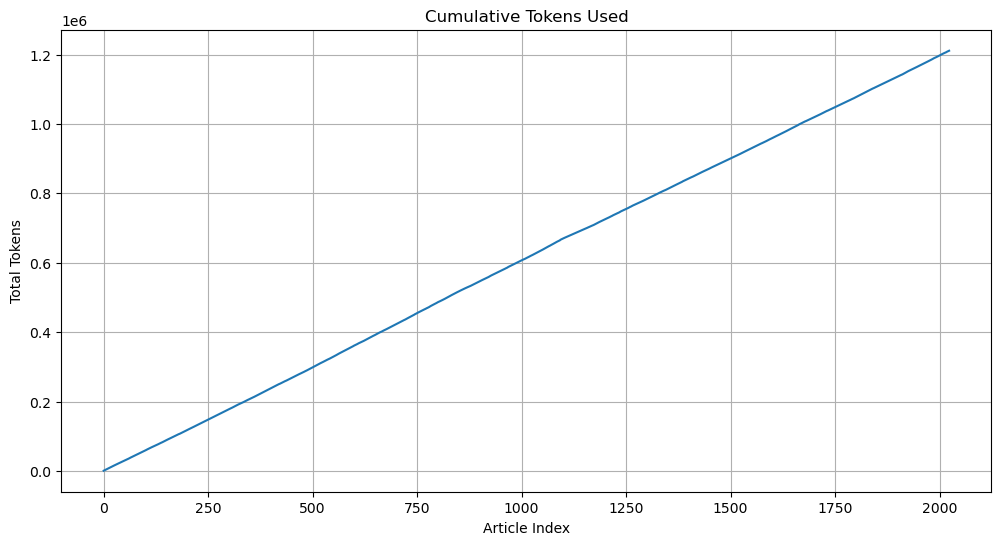

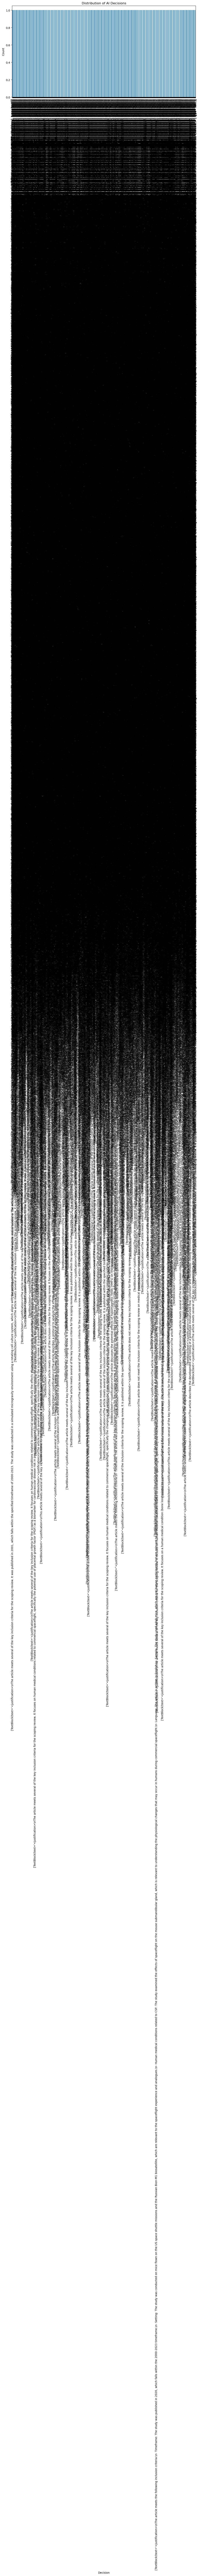

In [7]:
# Example usage
# Assuming 'df' is your pandas DataFrame containing 'Title', 'Published Year', and 'Abstract' columns
# If you're loading from a CSV file, you can use:
# df = pd.read_csv('your_data.csv')

df = process_all_articles(df)
plot_progress(df)

In [8]:
df.to_parquet('claude_3_haiku_v2_pt3_2024.parquet')

In [ ]:
import anthropic
import os
import pandas as pd
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import lru_cache
import json

# Set up the API key for Claude.AI
os.environ['ANTHROPIC_API_KEY'] = anthropic_api_key

# Initialize the Anthropic client
client = anthropic.Anthropic()

def process_article(title, year, abstract):
    prompt = f"""You are assisting in screening articles for a scoping review on medical screening for Commercial Spaceflight (CSF). Your task is to determine whether to include, exclude, or mark as "maybe" each article based on the provided criteria. 

Here are the key inclusion criteria:
[... include your criteria here ...]

Key exclusion criteria:
[... include your exclusion criteria here ...]

Please review the following article information:

Title: {title}
Year: {year}
Abstract: {abstract}

Based on this information, determine whether the article should be included, excluded, or marked as "maybe" for the scoping review. Consider the inclusion and exclusion criteria carefully.

First, provide a brief justification for your decision, explaining how the article meets or fails to meet the criteria. Then, state your decision.

Format your response as follows:
<justification>
[Your justification here]
</justification>

<decision>[INCLUDE/EXCLUDE/MAYBE]</decision>"""

    message = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=3000,
        temperature=0,
        messages=[
            {"role": "user", "content": prompt}
        ]
    )

    return message.content

def process_articles_batch(df, start_index, batch_size):
    results = []
    for i in range(start_index, min(start_index + batch_size, len(df))):
        row = df.iloc[i]
        try:
            result = process_article(row['Title'], row['Published Year'], row['Abstract'])
            results.append(result)
            time.sleep(1)  # Add a small delay between API calls
        except Exception as e:
            print(f"Error processing article {i}: {e}")
            results.append("Error: " + str(e))
    return results

def save_progress(df, results, filename):
    temp_df = df.copy()
    temp_df['AI_Decision'] = results + [''] * (len(df) - len(results))
    temp_df.to_parquet(filename)

def load_progress(filename):
    if os.path.exists(filename):
        return pd.read_parquet(filename)
    return None

def process_all_articles(df, batch_size=10, save_frequency=50):
    output_file = 'processed_articles.parquet'

    # Check if we have a saved progress
    loaded_df = load_progress(output_file)
    if loaded_df is not None:
        start_index = loaded_df['AI_Decision'].last_valid_index() + 1
        results = loaded_df['AI_Decision'].dropna().tolist()
        print(f"Resuming from article {start_index}")
    else:
        start_index = 0
        results = []

    total_articles = len(df)
    with tqdm(total=total_articles, initial=start_index) as pbar:
        while start_index < total_articles:
            batch_results = process_articles_batch(df, start_index, batch_size)
            results.extend(batch_results)
            start_index += len(batch_results)
            pbar.update(len(batch_results))

            if len(results) % save_frequency == 0 or start_index >= total_articles:
                save_progress(df, results, output_file)
                print(f"Progress saved. Processed {len(results)} out of {total_articles} articles.")

    return load_progress(output_file)

# Example usage
# Assuming 'df' is your pandas DataFrame containing 'Title', 'Published Year', and 'Abstract' columns
# If you're loading from a CSV file, you can use:
# df = pd.read_csv('your_data.csv')

processed_df = process_all_articles(df, batch_size=10, save_frequency=50)

# After processing, you can analyze the results
print(processed_df['AI_Decision'].value_counts())

# You can also plot the progress if needed
# plot_progress(processed_df)

In [ ]:
print(df)

In [ ]:
df

In [ ]:
df

In [ ]:
import pandas as pd
df = pd.read_parquet('intermediate_results_9850.parquet')

In [ ]:
df